##### Copyright 2018 The TensorFlow Authors.


# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [82]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
import pprint
import flask

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [43]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
    annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
    annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
    os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510574080/13510573713 [==============================] - 916s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [44]:
annotation_file

'C:\\Users\\anish\\projects\\nlp\\tf-image-caption/annotations/captions_train2014.json'

In [45]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [46]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [47]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [48]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A white sink and mirror in a room. <end>


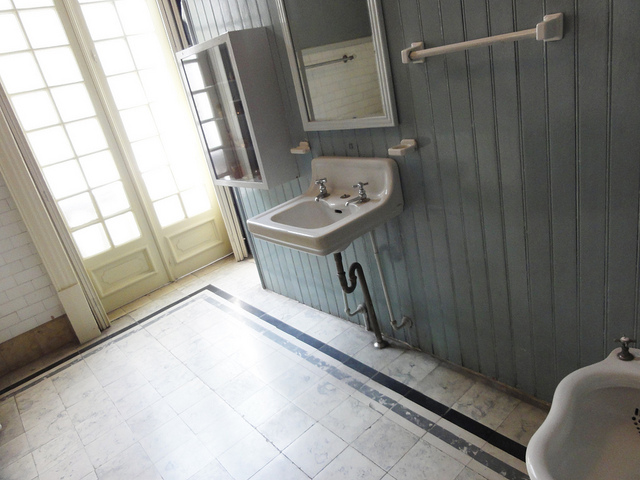

In [49]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [50]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [51]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install -q tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [52]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [53]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [54]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [55]:
# first 10 training sequences
pprint.pprint(train_seqs[:10])

[[3, 2, 22, 127, 10, 193, 8, 2, 47, 4],
 [3, 2, 127, 10, 193, 19, 412, 13, 2, 143, 8, 7, 68, 4],
 [3, 2, 68, 9, 2, 127, 1150, 10, 2, 725, 10, 193, 5, 7, 143, 4],
 [3, 266, 68, 9, 1226, 2, 127, 96, 10, 725, 4],
 [3, 15, 266, 68, 9, 188, 2100, 8, 100, 2, 313, 6, 950, 4],
 [3, 2, 34, 6, 20, 14, 88, 2, 25, 9, 59, 4],
 [3, 2, 34, 6, 230, 81, 18, 2, 25, 9, 59, 10, 461, 4],
 [3, 2, 454, 20, 19, 18, 7, 25, 564, 28, 59, 53, 263, 78, 7, 264, 4],
 [3, 34, 6, 81, 301, 10, 497, 2, 405, 4],
 [3, 2, 34, 6, 20, 27, 19, 14, 88, 2, 25, 4]]


In [56]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [57]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [58]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [59]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [60]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [61]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24004, 24004, 6002, 6002)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [62]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [63]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [64]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [65]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [66]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [67]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [68]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [69]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [70]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [71]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [72]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [73]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [74]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9744
Epoch 1 Batch 100 Loss 1.1473
Epoch 1 Batch 200 Loss 0.9527
Epoch 1 Batch 300 Loss 0.8817
Epoch 1 Loss 1.002061
Time taken for 1 epoch 1333.0749983787537 sec

Epoch 2 Batch 0 Loss 0.8074
Epoch 2 Batch 100 Loss 0.8035
Epoch 2 Batch 200 Loss 0.8151
Epoch 2 Batch 300 Loss 0.7044
Epoch 2 Loss 0.765805
Time taken for 1 epoch 1564.7555372714996 sec

Epoch 3 Batch 0 Loss 0.7461
Epoch 3 Batch 100 Loss 0.7033
Epoch 3 Batch 200 Loss 0.6211
Epoch 3 Batch 300 Loss 0.7004
Epoch 3 Loss 0.690242
Time taken for 1 epoch 2422.510798931122 sec

Epoch 4 Batch 0 Loss 0.7085
Epoch 4 Batch 100 Loss 0.6253
Epoch 4 Batch 200 Loss 0.6838
Epoch 4 Batch 300 Loss 0.5954
Epoch 4 Loss 0.640822
Time taken for 1 epoch 2343.2405784130096 sec

Epoch 5 Batch 0 Loss 0.5967
Epoch 5 Batch 100 Loss 0.6447
Epoch 5 Batch 200 Loss 0.5636
Epoch 5 Batch 300 Loss 0.5924
Epoch 5 Loss 0.601906
Time taken for 1 epoch 2452.793723344803 sec

Epoch 6 Batch 0 Loss 0.5219
Epoch 6 Batch 100 Loss 0.5342
Epoch 6 B

Epoch 13 Batch 100 Loss 0.3659
Epoch 13 Batch 200 Loss 0.3957
Epoch 13 Batch 300 Loss 0.4194
Epoch 13 Loss 0.395522
Time taken for 1 epoch 2357.233715772629 sec

Epoch 14 Batch 0 Loss 0.4135
Epoch 14 Batch 100 Loss 0.3751
Epoch 14 Batch 200 Loss 0.3546
Epoch 14 Batch 300 Loss 0.3793
Epoch 14 Loss 0.375837
Time taken for 1 epoch 2627.4382061958313 sec

Epoch 15 Batch 0 Loss 0.3776
Epoch 15 Batch 100 Loss 0.3697
Epoch 15 Batch 200 Loss 0.3509
Epoch 15 Batch 300 Loss 0.3584
Epoch 15 Loss 0.357147
Time taken for 1 epoch 3051.7988710403442 sec

Epoch 16 Batch 0 Loss 0.3759
Epoch 16 Batch 100 Loss 0.3245
Epoch 16 Batch 200 Loss 0.3271
Epoch 16 Batch 300 Loss 0.3311
Epoch 16 Loss 0.339660
Time taken for 1 epoch 3212.9870386123657 sec

Epoch 17 Batch 0 Loss 0.3694
Epoch 17 Batch 100 Loss 0.3432
Epoch 17 Batch 200 Loss 0.2957
Epoch 17 Batch 300 Loss 0.2937
Epoch 17 Loss 0.325385
Time taken for 1 epoch 3192.795547246933 sec

Epoch 18 Batch 0 Loss 0.3298
Epoch 18 Batch 100 Loss 0.3033
Epoch 18 Ba

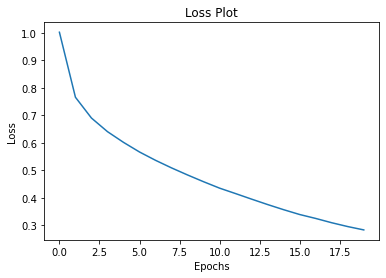

In [75]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [110]:
# saving the model
max_length_file = open('model/max_length.p', 'wb')
pickle.dump(max_length, max_length_file)
max_length_file.close()

attention_features_shape_file = open('model/attention_features.p', 'wb')
pickle.dump(attention_features_shape, attention_features_shape_file)
attention_features_shape_file.close()

tokenizer_file = open('model/tokenizer.p', 'wb')
pickle.dump(tokenizer, tokenizer_file )
tokenizer_file.close()

In [116]:
image_features_extract_model.load_weights('checkpoints/train/ckpt-1.index')

Instructions for updating:
Restoring a name-based tf.train.Saver checkpoint using the object-based restore API. This mode uses global names to match variables, and so is somewhat fragile. It also adds new restore ops to the graph each time it is called when graph building. Prefer re-encoding training checkpoints in the object-based format: run save() on the object-based saver (the same one this message is coming from) and use that checkpoint in the future.


AssertionError: Some objects had attributes which were not restored:
    <tf.Variable 'conv2d_94/kernel:0' shape=(3, 3, 3, 32) dtype=float32, numpy=
array([[[[-4.59105551e-01, -4.14526574e-02, -3.62577499e-03,
          -9.87672508e-02, -3.37070860e-02,  4.79929037e-02,
           2.32542142e-01,  3.23927671e-01,  5.90160079e-02,
           9.47738215e-02,  4.24996056e-02,  1.26620471e-01,
           1.33215979e-01,  1.22741833e-01, -7.92686343e-02,
           2.08227970e-02, -1.99647829e-01, -3.02687973e-01,
          -2.10659921e-01, -3.52898419e-01, -5.58023095e-01,
           3.20223093e-01,  4.53596050e-03, -3.09266411e-02,
          -6.86957911e-02,  2.00968519e-01,  1.14542745e-01,
           2.40372881e-01,  1.52943470e-02,  5.96231259e-02,
          -5.85714653e-02,  8.78173351e-01],
         [ 3.16376328e-01, -4.78494260e-03, -6.84681814e-03,
           7.44503662e-02, -1.97458476e-01,  5.20143658e-02,
          -1.24460436e-01,  3.36123914e-01,  3.01678218e-02,
          -1.26477107e-01, -1.05597451e-01, -5.31241074e-02,
          -2.43102223e-01,  1.66047230e-01, -1.03186309e-01,
          -6.55613691e-02,  2.60930099e-02,  1.16658449e-01,
          -1.60814777e-01, -3.49688202e-01, -7.33594477e-01,
           3.11471581e-01,  1.33009152e-02, -6.08066330e-03,
          -7.95056075e-02, -3.26563753e-02,  4.55954410e-02,
           2.36060649e-01,  5.62554598e-03,  6.51128590e-02,
           1.04702845e-01, -1.66790619e-01],
         [ 2.21712515e-01, -2.57035112e-03, -1.59502089e-01,
          -2.51942836e-02,  2.43941799e-01,  2.55493037e-02,
          -1.28795937e-01,  1.37704432e-01, -7.87055641e-02,
           4.10648547e-02,  2.80119162e-02, -1.07536890e-01,
           4.59116288e-02,  1.27241179e-01,  1.93367332e-01,
           1.53290546e-02, -2.00637266e-01,  2.24361420e-01,
          -1.29131392e-01, -9.51487944e-02, -3.70009631e-01,
           2.87032187e-01, -8.66315290e-02,  9.28180665e-02,
          -2.01310944e-02, -2.72079617e-01,  4.39127162e-02,
          -7.55708218e-02, -9.42188203e-02, -5.93317747e-02,
           3.96243595e-02, -6.19118512e-01]],

        [[-7.51269162e-01,  3.48210037e-02, -7.98967332e-02,
          -3.96422565e-01, -2.64644027e-01,  1.40673056e-01,
          -5.92360973e-01,  5.70569396e-01, -5.61487041e-02,
           1.59614719e-02,  1.91302866e-01, -3.66766155e-02,
           3.75389487e-01,  3.75071824e-01, -1.85502082e-01,
          -3.09550047e-01,  1.60525702e-02, -3.55118126e-01,
          -2.88537711e-01, -9.48302820e-02,  1.53166577e-01,
          -1.93490461e-01,  6.42974153e-02, -3.48205008e-02,
          -1.65828705e-01,  3.90365124e-01,  1.26349302e-02,
           1.53028890e-01,  1.33174499e-02,  7.45554641e-02,
          -1.92786697e-02,  1.75148576e-01],
         [ 3.55816573e-01, -3.14642340e-02,  1.28206044e-01,
          -1.28941059e-01, -5.46135902e-02,  2.78681666e-01,
           4.55734700e-01,  5.38976073e-01,  8.31630006e-02,
          -2.80416071e-01, -1.48861542e-01,  1.21901974e-01,
          -3.83083135e-01,  3.75166088e-01, -2.08227515e-01,
          -1.29338771e-01,  3.50710601e-01,  2.24829260e-02,
          -2.44429782e-01, -6.89486489e-02,  1.19071797e-01,
          -9.07485932e-02,  6.37152195e-02, -6.23455318e-03,
          -1.83708176e-01,  3.16314101e-02, -3.26027162e-02,
           1.46927759e-01,  5.60333719e-03,  1.00134099e-02,
           1.34500518e-01, -9.49547514e-02],
         [ 5.11001050e-01,  8.04265440e-02,  9.84589979e-02,
          -9.28192511e-02,  4.39067900e-01,  2.40116969e-01,
           1.48012802e-01,  2.06206009e-01, -3.86097394e-02,
           2.34553993e-01,  2.01258138e-02, -1.33050963e-01,
           1.42953947e-01,  1.52850181e-01,  3.48664939e-01,
          -2.21172974e-01, -1.68190915e-02,  2.35393152e-01,
          -1.90555871e-01, -3.70343146e-03,  1.04658179e-01,
          -3.13451141e-02,  8.90399516e-02,  4.66634482e-02,
          -7.73299858e-02, -3.79417181e-01, -4.08192798e-02,
          -4.52801585e-01, -7.00017810e-02, -9.71016958e-02,
           2.95030206e-01, -1.05120182e-01]],

        [[-7.53074363e-02, -2.06811968e-02,  8.94671679e-02,
           1.55051500e-02, -7.04864040e-02, -9.22501162e-02,
          -7.11003184e-01,  2.50318170e-01,  1.14692561e-01,
           9.74843428e-02,  8.26721266e-02, -6.69363514e-02,
           1.83123484e-01, -2.55230129e-01, -1.04877211e-01,
           8.40508714e-02, -1.46275967e-01, -3.01192343e-01,
          -1.65155828e-01, -1.95000917e-02,  2.92843819e-01,
          -2.51484841e-01,  8.99823979e-02, -5.07941581e-02,
          -1.54783919e-01,  3.13909143e-01,  4.67576571e-02,
           9.33493748e-02, -8.23359098e-03,  1.06634155e-01,
          -3.46046425e-02, -3.19266319e-01],
         [ 1.12931758e-01, -1.48703828e-02,  6.78641945e-02,
           1.50543079e-01, -1.13253519e-01,  8.58298391e-02,
           5.01982749e-01,  1.83798179e-01, -8.68951753e-02,
          -1.50101945e-01, -1.27019748e-01,  2.00995386e-01,
          -1.94146752e-01, -3.33526462e-01, -3.95116657e-02,
          -3.76722105e-02,  8.60670023e-03, -6.98672514e-03,
          -1.00546576e-01, -2.62953830e-03,  4.65099514e-01,
          -2.14414850e-01,  7.64784589e-02, -5.08379657e-03,
          -1.73704341e-01, -8.37199613e-02, -4.17399816e-02,
           1.73426822e-01,  2.95095835e-02,  6.04446344e-02,
           9.06928107e-02, -1.14271380e-02],
         [-7.29609355e-02,  3.49589698e-02, -1.79962412e-01,
           1.22079901e-01,  1.76442862e-01,  1.16373926e-01,
           2.30988681e-01,  3.72244976e-02, -3.20714563e-02,
           5.88952675e-02, -3.42379771e-02, -9.31739733e-02,
          -1.16255339e-02, -1.73515990e-01,  1.21214695e-01,
           1.40511736e-01, -2.19165638e-01,  1.94948763e-01,
          -9.93858278e-02, -1.37543278e-02,  2.88932323e-01,
          -2.54598916e-01,  8.18339437e-02,  1.16559630e-02,
          -9.36568975e-02, -2.18580514e-01, -1.22934952e-01,
           5.50779048e-04, -7.01512843e-02, -3.58531252e-02,
           1.04194552e-01,  2.88285494e-01]]],


       [[[-3.09671372e-01,  2.32201777e-02, -1.96793169e-01,
          -2.20510378e-01, -2.42669106e-01,  4.67890911e-02,
           2.48323604e-01, -1.66484311e-01, -3.84278834e-01,
           3.80987860e-02, -4.54362422e-01, -2.37979427e-01,
           3.29888821e-01,  3.41433752e-03, -8.28291476e-02,
           3.99100259e-02, -2.70952880e-01, -3.21505904e-01,
           1.00008205e-01,  5.77513278e-01, -4.18643892e-01,
           2.54249245e-01,  5.62861599e-02, -8.69987980e-02,
          -6.83216453e-02,  3.79922688e-01,  1.76942736e-01,
           2.11315155e-01,  6.92530796e-02, -1.69373155e-02,
          -2.29212847e-02,  4.36451226e-01],
         [ 1.85230255e-01,  1.21470345e-02,  1.15113854e-01,
           9.49417576e-02, -1.77649230e-01,  1.30133405e-01,
          -1.27454177e-01, -1.52578086e-01,  4.32037741e-01,
          -2.64863998e-01, -3.03227827e-02,  2.39914760e-01,
          -4.59962994e-01,  3.57799567e-02, -1.57588765e-01,
          -5.69069721e-02,  4.98269275e-02,  7.87699968e-02,
           9.30080563e-02,  6.36520803e-01, -5.54792702e-01,
           1.93763480e-01,  1.40769668e-02, -7.37030208e-02,
          -7.34341666e-02,  4.33748625e-02,  1.17953978e-01,
           3.15200478e-01,  4.22935151e-02, -3.14331055e-03,
           6.22104593e-02, -8.47976282e-02],
         [ 1.60247013e-01,  5.20873033e-02,  1.04668580e-01,
           6.11611344e-02,  3.69409770e-01,  4.96275760e-02,
          -1.12423740e-01, -5.49178086e-02, -9.42278504e-02,
           2.54325986e-01, -4.13073972e-02,  6.60333559e-02,
           1.11361548e-01,  3.90531085e-02,  2.56812125e-01,
           3.07825580e-02, -3.65221053e-01,  2.65386939e-01,
           8.95922631e-02,  2.37859935e-01, -2.19269782e-01,
           1.70323789e-01, -2.40444541e-02, -6.42235950e-02,
          -5.73639609e-02, -3.37285519e-01,  2.47313276e-01,
          -2.12214038e-01, -1.53777460e-02, -1.04467109e-01,
          -1.30376607e-01, -2.94386506e-01]],

        [[-5.50010741e-01,  1.43946797e-01, -5.10051787e-01,
          -4.68869209e-01, -5.08882999e-01, -1.71292290e-01,
          -1.13478772e-01, -5.71783721e-01, -3.67561132e-01,
          -1.21380776e-01, -1.13262475e-01, -6.48380578e-01,
           6.27203345e-01,  6.94373548e-01, -1.95106730e-01,
          -2.64451325e-01, -2.00940773e-01, -4.21104223e-01,
           3.08264852e-01,  8.29216838e-03,  3.95820379e-01,
          -3.35089803e-01,  9.52083990e-02,  2.36721095e-02,
          -1.13931984e-01,  6.35013640e-01,  6.06294833e-02,
           4.41855192e-01, -4.77887504e-02, -1.98351786e-01,
          -1.94868110e-02, -4.85313162e-02],
         [ 1.90947160e-01,  4.33590598e-02,  4.24152821e-01,
          -3.69650614e-03,  5.56460768e-03,  6.86372221e-02,
           1.50262251e-01, -5.79318464e-01,  3.83384645e-01,
          -3.96539152e-01, -2.05095951e-02,  5.08662283e-01,
          -6.81817293e-01,  6.39929175e-01, -2.63347208e-01,
          -1.64095819e-01,  1.31546974e-01,  7.51749100e-03,
           2.77786314e-01,  1.27530554e-02,  4.76832241e-01,
          -2.03199059e-01,  3.82504165e-02,  4.77481186e-02,
          -1.21142201e-01,  1.24962404e-01,  1.94157716e-02,
           4.35586035e-01, -5.81540316e-02, -2.21681744e-01,
           9.22068208e-02, -1.54824508e-02],
         [ 3.69268328e-01,  1.97107822e-01,  6.14967883e-01,
           1.44848540e-01,  6.79024100e-01,  8.71696472e-02,
          -2.52940003e-02, -2.09089696e-01, -7.00887442e-02,
           5.60278237e-01,  5.41306697e-02,  1.50142446e-01,
           1.22068822e-01,  2.51376867e-01,  4.28028524e-01,
          -1.99277475e-01, -3.64807039e-01,  3.26477617e-01,
           2.77842641e-01,  5.99431852e-03,  2.13500857e-01,
          -7.79086575e-02,  1.37640312e-01,  1.45664038e-02,
          -7.50476941e-02, -6.03472531e-01,  9.13274661e-02,
          -5.51822066e-01, -4.93564568e-02, -2.41208330e-01,
           1.42374914e-02,  7.20060058e-03]],

        [[-6.13205209e-02,  1.67170428e-02, -2.21705899e-01,
          -4.95959334e-02, -2.37929299e-01, -5.35335004e-01,
          -2.11950779e-01, -1.99938426e-03,  8.72384310e-02,
          -7.92514980e-02,  3.13561596e-02, -5.00510335e-01,
           3.16275716e-01, -1.79683864e-01, -7.73780569e-02,
           1.09483354e-01, -3.62387270e-01, -3.29678863e-01,
           9.10189226e-02, -6.27809390e-02,  3.97496015e-01,
          -2.75063694e-01,  9.81727690e-02, -9.63142794e-03,
          -1.43188626e-01,  3.90550435e-01,  6.00194223e-02,
           3.73257279e-01,  7.54999146e-02, -2.31349897e-02,
          -7.19401911e-02, -3.81740510e-01],
         [ 4.15264070e-02,  1.05704041e-02,  2.22087592e-01,
           2.28352740e-01, -8.31382945e-02, -2.79769450e-01,
           1.47461593e-01, -9.23275203e-03, -6.49965033e-02,
          -2.37697676e-01, -1.14193618e-01,  4.09631103e-01,
          -4.53702658e-01, -2.49112755e-01, -8.12669992e-02,
          -3.03775985e-02, -1.21517688e-01,  3.44517045e-02,
           8.81673172e-02, -8.83365348e-02,  5.15151560e-01,
          -2.08372459e-01,  3.21709625e-02,  5.33515327e-02,
          -1.59795165e-01, -8.11125860e-02, -1.20032309e-02,
           4.29726124e-01,  9.70903337e-02, -6.00864813e-02,
           3.75584215e-02,  5.58782928e-02],
         [-2.62930449e-02,  1.01349048e-01,  2.71942019e-01,
           2.09343761e-01,  3.21388841e-01, -1.02254741e-01,
           3.66898850e-02,  2.09949017e-02, -6.04890622e-02,
           3.25812578e-01, -2.36350242e-02,  9.74250138e-02,
          -3.49432509e-03, -1.29163429e-01,  1.58048660e-01,
           9.56366658e-02, -4.31959033e-01,  3.28082532e-01,
           3.51306573e-02, -6.12014011e-02,  2.15223819e-01,
          -1.76527336e-01,  9.22026634e-02,  2.45687384e-02,
          -1.40548587e-01, -4.53587860e-01, -9.22924131e-02,
          -1.26142427e-01, -4.48163524e-02, -1.39643848e-01,
          -8.38275552e-02,  2.74723858e-01]]],


       [[[ 1.61150634e-01, -2.86575016e-02,  7.11555034e-02,
          -2.07143471e-01,  5.29730059e-02,  9.41791460e-02,
           2.55565137e-01,  7.62317255e-02, -5.32264113e-02,
           1.34586126e-01, -9.10150483e-02, -1.65695250e-01,
           2.42919326e-01, -2.00146437e-01,  1.74079668e-02,
           7.50095099e-02,  1.55196548e-01, -2.58261949e-01,
          -4.92655626e-03,  4.16197777e-01, -3.86153311e-02,
           1.46446452e-01,  5.06453626e-02, -3.60621393e-01,
           1.15070350e-01,  2.89169192e-01,  1.00484222e-01,
          -1.09357260e-01, -7.28665618e-03,  4.20598984e-02,
          -3.83202098e-02, -1.05859242e-01],
         [ 6.39319569e-02, -3.89898079e-03,  4.97516058e-03,
          -6.25403598e-02, -2.42724687e-01,  2.47927323e-01,
          -1.59898847e-01,  4.75750826e-02,  1.23555377e-01,
          -1.89252675e-01,  1.06582632e-02,  1.46695763e-01,
          -2.47447804e-01, -2.17797235e-01, -5.32606617e-02,
          -1.12605102e-01,  3.69681597e-01,  6.58257976e-02,
          -9.96394455e-03,  4.14005488e-01,  5.81203122e-03,
          -2.15347242e-02, -1.33059714e-02, -2.35672444e-01,
           1.47929698e-01, -9.68965814e-02, -3.85954790e-02,
           3.19409184e-02, -2.63723861e-02,  1.10327229e-01,
           8.80503729e-02, -5.33311628e-02],
         [-2.27521077e-01,  3.65342870e-02, -1.42364472e-01,
          -1.69696268e-02,  1.87642574e-01,  1.41795829e-01,
          -1.04727075e-01, -3.72307226e-02, -7.86822960e-02,
           5.50233088e-02,  4.85404283e-02, -1.27198761e-02,
           4.12139669e-02, -8.29386860e-02,  2.39679087e-02,
           7.99235627e-02, -1.16620973e-01,  2.00591236e-01,
          -1.69659853e-02,  1.10958219e-01,  6.90503558e-03,
           2.02338211e-02, -3.25619727e-02, -2.45006755e-01,
           3.24574076e-02, -2.77086586e-01,  9.08047485e-04,
          -4.50409018e-03, -7.13055953e-02, -5.91237992e-02,
          -1.74784988e-01,  8.49652290e-02]],

        [[ 4.06208187e-02, -1.34799313e-02, -2.80702084e-01,
          -4.87784952e-01, -2.33685091e-01,  1.71019688e-01,
           2.52302170e-01, -5.00181317e-01, -8.71177763e-02,
          -2.00075116e-02,  3.82897705e-02, -4.43741232e-01,
           3.89617324e-01, -2.45864466e-01, -4.76957001e-02,
           1.28133371e-01,  3.14029723e-01, -3.26389074e-01,
           1.34655774e-01, -3.44568610e-01, -1.75894618e-01,
           1.71287939e-01,  5.22936471e-02, -2.89032217e-02,
           2.87097365e-01,  4.60938752e-01,  5.09101227e-02,
          -4.64511588e-02, -2.71178037e-01, -6.56533614e-02,
           5.03007583e-02, -1.58027932e-01],
         [ 3.31376269e-02, -1.52911358e-02,  6.23353198e-02,
          -1.69642091e-01, -1.95648819e-01,  3.87342900e-01,
          -1.82435453e-01, -4.02341664e-01,  9.91701782e-02,
          -2.99883604e-01, -1.95305813e-02,  3.51800621e-01,
          -4.53105867e-01, -2.41416395e-01, -1.03277519e-01,
          -7.88784996e-02,  4.33811039e-01,  7.86142126e-02,
           4.23696041e-02, -3.05828214e-01, -1.67982697e-01,
           1.13012172e-01, -1.87792554e-02,  5.92934899e-02,
           3.61771584e-01, -4.57345620e-02, -3.06100622e-02,
          -3.73655446e-02, -2.49070913e-01, -4.13494818e-02,
           2.06367165e-01, -6.83298660e-03],
         [-5.36594018e-02,  9.36179534e-02,  1.65238991e-01,
           5.53405955e-02,  2.57401228e-01,  2.50335783e-01,
          -6.45859763e-02, -1.18017726e-01, -7.41348714e-02,
           2.81930178e-01,  6.65699691e-02,  5.19486517e-02,
           4.24872227e-02, -1.16484366e-01,  1.29901171e-01,
           7.61362910e-02, -2.09316850e-01,  2.89463013e-01,
           1.01264454e-01, -1.38873145e-01, -1.44799188e-01,
           6.74227998e-02, -1.34168856e-03,  3.55463102e-02,
           2.26262435e-01, -5.01563668e-01, -4.28435691e-02,
          -2.84834534e-01, -1.30743161e-01, -1.03075445e-01,
          -9.36047584e-02,  1.46130726e-01]],

        [[ 8.36313888e-02, -8.29154029e-02, -6.68296069e-02,
          -3.35510015e-01,  8.31014588e-02, -1.64307915e-02,
           2.61760324e-01, -3.64583619e-02,  1.95155665e-01,
           3.21608484e-02,  8.42251927e-02, -2.32356116e-01,
           2.78860003e-01, -2.21362099e-01, -5.41272573e-03,
           4.74610850e-02,  1.59989282e-01, -2.72452205e-01,
           9.41323563e-02, -1.26402825e-01, -1.48332641e-02,
           9.81647000e-02,  5.77408485e-02, -6.89573810e-02,
           2.52074748e-01,  4.18857992e-01,  8.16523656e-02,
          -9.57819726e-03, -1.64164416e-02,  4.02872637e-02,
          -2.40528770e-02, -1.29585251e-01],
         [ 1.14373878e-01, -4.22538212e-03,  7.03023151e-02,
          -1.17636502e-01, -1.59701794e-01,  1.23792440e-01,
          -1.90807760e-01, -2.16314141e-02, -1.32634625e-01,
          -1.28451735e-01, -7.51707479e-02,  2.57721603e-01,
          -2.11595684e-01, -1.25269800e-01,  1.99442990e-02,
          -4.90545258e-02,  2.44563296e-01,  9.58911777e-02,
           5.96616194e-02, -1.61616415e-01, -1.09070748e-01,
          -1.20989429e-02, -7.77932117e-03,  6.38317689e-02,
           3.04483294e-01, -2.50075106e-02, -1.87520199e-02,
          -7.08285794e-02,  3.56728099e-02,  7.37871975e-02,
           1.14570551e-01, -6.01681806e-02],
         [-1.94149122e-01,  6.73346743e-02,  6.54700622e-02,
           5.41231073e-02,  9.72744748e-02,  8.48492980e-02,
          -8.35040435e-02, -3.32129709e-02, -1.16422340e-01,
           1.00631602e-01,  3.66899348e-03,  1.04717100e-02,
          -3.40034589e-02, -2.21335012e-02, -2.93729398e-02,
           3.90057638e-02, -1.44896954e-01,  2.96015412e-01,
          -2.27687247e-02, -9.77180004e-02, -8.71916488e-02,
          -7.66254216e-02, -3.22300009e-02,  1.45472540e-02,
           1.66192874e-01, -3.18722308e-01, -8.46264958e-02,
          -1.36219218e-01, -5.61135188e-02, -4.55730930e-02,
          -8.21031332e-02,  1.48212612e-01]]]], dtype=float32)>: ['conv2d_94/kernel']
    <tf.Variable 'batch_normalization_94/beta:0' shape=(32,) dtype=float32, numpy=
array([ 0.30642197, -1.408146  ,  1.2066168 ,  4.060442  ,  0.46849713,
        3.7279217 , -0.19197   ,  1.1407069 , -1.0027769 , -0.39678496,
       -0.7832382 , -0.06940158,  0.46450683,  1.8760432 , -0.81689674,
       -1.2841663 ,  4.242368  ,  0.07444862, -1.0287153 ,  1.8559531 ,
        1.0826433 ,  0.02630073, -0.74120116, -1.2152895 , -0.82486725,
        0.7499853 , -1.4319235 ,  1.7412437 , -0.751229  , -1.2139478 ,
       -1.441984  , -0.63903415], dtype=float32)>: ['batch_normalization_94/beta']
    <tf.Variable 'batch_normalization_94/moving_mean:0' shape=(32,) dtype=float32, numpy=
array([-1.5631364e-01, -1.1410455e-01, -1.8800385e-01,  1.8837783e-02,
       -2.8506920e-01, -2.4252538e-01, -9.1273338e-03,  1.7452823e-02,
        5.3064339e-02, -1.3902040e-01,  4.9178142e-02, -1.0329315e-01,
        9.6112214e-02, -1.6517146e-02, -1.4889747e-01,  6.3666873e-02,
        2.3986086e-01, -3.0795994e-01, -1.5001373e-02, -2.0025304e-04,
       -4.7800113e-03,  2.7176417e-02, -8.6162113e-02,  5.4481409e-02,
        7.6186988e-03,  4.1812924e-01, -3.5955798e-02,  8.9453861e-02,
        1.2399838e-01,  1.5157536e-01, -5.8845982e-02,  3.5276305e-02],
      dtype=float32)>: ['batch_normalization_94/moving_mean']
    <tf.Variable 'batch_normalization_94/moving_variance:0' shape=(32,) dtype=float32, numpy=
array([0.33156815, 0.13971157, 0.32001787, 0.9697031 , 0.6014242 ,
       0.8263911 , 0.02400758, 0.12124109, 0.08234932, 0.37005344,
       0.14611423, 0.46507058, 0.9134309 , 0.0870445 , 0.22095607,
       0.17579377, 0.64984983, 0.7864328 , 0.04192145, 0.06154748,
       0.18055663, 0.08713192, 0.26532215, 0.1964495 , 0.06226327,
       1.3068284 , 0.1558016 , 0.76300645, 0.22516336, 0.2364873 ,
       0.13452013, 0.02897254], dtype=float32)>: ['batch_normalization_94/moving_variance']
    <tf.Variable 'conv2d_95/kernel:0' shape=(3, 3, 32, 32) dtype=float32, numpy=
array([[[[ 7.42468759e-02,  7.99097791e-02, -1.20985091e-01, ...,
          -2.42504068e-02, -8.17770883e-03, -7.11583123e-02],
         [ 5.46021610e-02,  1.13289319e-01,  3.99106629e-02, ...,
           2.37093717e-02, -6.01868033e-02, -1.08440826e-02],
         [ 1.00897752e-01,  1.96732566e-01,  8.93706456e-02, ...,
           1.19806841e-01, -9.84039158e-02, -7.20797330e-02],
         ...,
         [-3.90735529e-02, -6.42493367e-02, -1.45747527e-01, ...,
          -4.56309021e-02,  5.81668466e-02,  4.03633993e-03],
         [ 8.64306930e-03,  4.85541411e-02, -1.07509829e-01, ...,
          -2.95046885e-02, -4.30538319e-02, -4.43571396e-02],
         [-2.84168776e-02, -4.00678925e-02, -1.12401426e-03, ...,
           1.10386163e-01,  3.43435220e-02, -5.37860990e-02]],

        [[ 2.15948462e-01, -1.07452594e-01, -1.90331623e-01, ...,
          -1.11632466e-01, -6.87363446e-02, -3.24665830e-02],
         [ 5.04970290e-02, -1.88592494e-01,  4.61934246e-02, ...,
          -1.06430324e-02, -3.58154364e-02,  2.24177688e-02],
         [ 1.53868675e-01, -4.37356979e-01,  1.42111182e-01, ...,
          -4.68438268e-02, -6.37560785e-02,  7.30710104e-02],
         ...,
         [-4.40823957e-02,  2.24926680e-01, -1.74393997e-01, ...,
          -5.96887581e-02,  3.38170910e-04, -3.99790332e-02],
         [ 6.53550699e-02,  1.54641634e-02, -9.14514288e-02, ...,
          -5.35752289e-02, -4.45950739e-02, -1.61512904e-02],
         [ 3.10535319e-02,  1.49251521e-01, -5.04461899e-02, ...,
           9.17666107e-02, -2.60227136e-02, -1.68829665e-01]],

        [[ 1.03251282e-02,  1.26150372e-02, -2.19645903e-01, ...,
          -1.66123211e-01,  9.07985196e-02, -1.06690768e-02],
         [ 2.66957120e-03, -4.81090210e-02, -1.31528927e-02, ...,
          -3.79646011e-02,  8.49297717e-02, -2.90323747e-03],
         [ 9.95492935e-03, -9.49906593e-04, -1.58173859e-01, ...,
          -2.27725014e-01,  2.25325570e-01,  2.38798205e-02],
         ...,
         [ 1.22975707e-02,  2.72139944e-02, -6.77735806e-02, ...,
          -3.91456820e-02, -5.47213964e-02, -5.10296458e-03],
         [-9.21799913e-02,  1.54265583e-01,  5.73863685e-02, ...,
          -4.55805212e-02,  5.21750301e-02, -5.78106716e-02],
         [-1.14997085e-02, -9.35634132e-03, -4.11710702e-02, ...,
           1.14935137e-01, -1.76997408e-02, -5.33720292e-02]]],


       [[[ 1.67090744e-02,  7.12214038e-02,  2.02799603e-01, ...,
           1.16696216e-01, -7.64076859e-02, -2.39704996e-02],
         [-1.17978663e-03, -3.06973625e-02,  1.10151567e-01, ...,
           5.60230948e-02, -6.76240101e-02,  4.65841405e-02],
         [-6.71134889e-02, -1.43466592e-01,  3.87502193e-01, ...,
           2.04619661e-01, -1.19212225e-01,  5.09281345e-02],
         ...,
         [ 2.04587020e-02,  2.87969690e-02, -5.73656447e-02, ...,
          -2.01027449e-02,  3.66506050e-03, -2.53430214e-02],
         [ 5.41347116e-02,  2.70228870e-02, -1.52887776e-02, ...,
           4.61761886e-03, -6.84568286e-02,  2.99527720e-02],
         [ 6.25339746e-02, -1.06886812e-02,  5.40210633e-03, ...,
           9.46345478e-02,  9.61190686e-02, -9.88118872e-02]],

        [[-7.33017027e-01,  1.46387126e-02,  2.22013518e-02, ...,
           2.50173192e-02, -9.63830128e-02,  1.73201367e-01],
         [-8.77087712e-02,  1.29143327e-01, -1.04928017e-01, ...,
           6.69623772e-03, -5.10823913e-02,  8.12883601e-02],
         [-4.13510144e-01,  3.57925743e-01, -2.10093468e-01, ...,
           1.23453401e-01, -8.05266872e-02,  2.46342868e-01],
         ...,
         [ 1.22624032e-01, -1.74008921e-01,  8.30310583e-02, ...,
          -5.02070673e-02, -1.01963524e-02, -5.66474758e-02],
         [ 6.22910410e-02, -6.58419877e-02, -4.96243276e-02, ...,
          -4.40357141e-02, -4.84280922e-02,  8.09182450e-02],
         [-2.09688157e-01, -3.99948917e-02,  6.13983423e-02, ...,
          -4.14721280e-01, -4.73312438e-02,  1.57886669e-01]],

        [[ 1.96683109e-01, -1.05110280e-01, -2.30544627e-01, ...,
          -1.12343676e-01,  1.84396714e-01,  4.30746488e-02],
         [ 6.06911853e-02,  6.76020011e-02, -3.80822942e-02, ...,
          -2.78057363e-02,  6.74408823e-02, -7.16171553e-03],
         [ 9.96380076e-02,  1.77723870e-01, -1.83133751e-01, ...,
          -1.51302889e-01,  1.61353827e-01, -1.94926690e-02],
         ...,
         [-5.50449565e-02, -7.39964843e-02,  6.12297691e-02, ...,
          -4.83399928e-02, -2.63557006e-02, -5.59351314e-03],
         [-5.74996732e-02, -3.52259539e-02,  1.70134902e-02, ...,
          -4.82739732e-02,  8.46255198e-02, -2.86628753e-02],
         [ 6.12332746e-02, -7.01161772e-02, -2.81381253e-02, ...,
          -4.54953834e-02,  1.34818163e-02,  1.92718729e-01]]],


       [[[ 8.58130008e-02, -6.40195161e-02,  2.94581741e-01, ...,
           7.80742243e-02, -1.16539709e-02, -6.70967810e-03],
         [ 4.25940380e-03, -6.08954616e-02, -2.14602780e-02, ...,
           4.81127240e-02, -3.97970006e-02,  1.15218700e-03],
         [ 4.47590873e-02, -1.15099020e-01,  1.43839762e-01, ...,
          -7.45672081e-03, -2.21853387e-02, -6.81359023e-02],
         ...,
         [-1.83911491e-02,  6.96137082e-03,  6.86858222e-02, ...,
          -5.46600856e-02,  1.71813089e-02,  1.15480982e-02],
         [-1.62531827e-02, -4.66724969e-02,  6.59601903e-03, ...,
          -1.08431345e-02, -3.44967917e-02,  4.29107696e-02],
         [-1.45611377e-03,  2.16894187e-02,  4.00928035e-02, ...,
           5.31957624e-03,  1.60861313e-02, -3.46944854e-02]],

        [[ 1.63699001e-01,  3.83942202e-02,  1.01265922e-01, ...,
           8.64739120e-02, -2.79816315e-02,  4.84394878e-02],
         [ 3.71044874e-02, -2.91357227e-02, -3.17117013e-02, ...,
           1.94135420e-02, -3.01136188e-02, -6.74839737e-03],
         [ 1.37572438e-01,  9.66539327e-03, -3.35221004e-04, ...,
           4.32167649e-02, -2.45654117e-02, -1.00749649e-01],
         ...,
         [-5.80370352e-02,  2.11239494e-02,  1.78779632e-01, ...,
          -6.30683005e-02,  1.58036310e-05,  1.86584424e-03],
         [ 1.38687026e-02,  2.38496270e-02,  6.31035790e-02, ...,
          -3.56095582e-02, -3.31789516e-02,  4.60586622e-02],
         [ 8.24820846e-02,  5.00847353e-04,  4.47956510e-02, ...,
          -1.34215087e-01, -1.38682202e-02,  1.10417530e-01]],

        [[-2.14411877e-02,  4.97641265e-02, -5.15453033e-02, ...,
           5.61795160e-02,  5.74385822e-02, -6.36914819e-02],
         [-3.38428244e-02, -5.12718000e-02, -5.24310097e-02, ...,
          -8.78553465e-03,  4.55683954e-02, -3.47172283e-02],
         [-9.26515758e-02, -4.35438827e-02, -1.62017539e-01, ...,
          -1.04242928e-01,  4.68756072e-02, -1.29051477e-01],
         ...,
         [ 2.05201916e-02,  1.00211650e-02,  1.44032717e-01, ...,
          -4.89615127e-02, -1.49116144e-02,  5.74512314e-03],
         [-5.57543486e-02, -5.50648570e-03,  7.31069595e-02, ...,
          -3.29866894e-02,  3.61047722e-02, -1.51652535e-02],
         [ 3.60057652e-02,  4.70752493e-02,  1.94469661e-01, ...,
          -2.11965665e-02, -6.09347485e-02, -2.50870250e-02]]]],
      dtype=float32)>: ['conv2d_95/kernel']
    <tf.Variable 'batch_normalization_95/beta:0' shape=(32,) dtype=float32, numpy=
array([ 1.5610276e+00,  1.3267887e+00,  1.3967026e+00, -8.7791240e-01,
       -3.4351227e+00,  1.4236350e-01,  1.1095905e+00,  1.0977312e-01,
        3.6144400e-01, -1.9098488e+00, -1.6867340e-01, -2.8697927e+00,
       -1.3345617e-01, -2.9199827e+00,  2.0098357e+00, -3.1252304e-01,
        3.9861405e-01,  8.5867506e-01, -2.4090137e+00,  4.5735675e-01,
       -2.7859604e-01, -4.8372082e-02,  3.2024715e-02, -1.9923817e-01,
       -4.0126985e-01,  4.8290923e-01,  6.3979983e-01, -3.8014811e-01,
       -1.5573416e-04, -2.6096421e-01, -4.4710788e-01, -1.8052216e-01],
      dtype=float32)>: ['batch_normalization_95/beta']
    <tf.Variable 'batch_normalization_95/moving_mean:0' shape=(32,) dtype=float32, numpy=
array([ 5.6795645e-01, -4.0053211e-02,  5.8837950e-01, -1.8454604e+00,
       -3.8997686e-01,  1.7852261e+00, -5.4649872e-01, -3.4344542e-01,
       -5.6126863e-02,  5.2568060e-01, -1.8863591e+00, -1.8927700e-07,
        1.4082437e+00, -3.2865731e-07, -1.5766761e+00,  1.5832039e+00,
       -1.2458545e+00,  1.0433992e-01, -6.4244533e-01, -7.8790063e-01,
        9.2182076e-01, -7.8999901e-01, -1.8619999e+00,  1.4068331e-01,
        4.1683059e+00, -1.1865814e+00, -1.5178986e+00, -4.2459488e-01,
       -2.9082878e+00, -6.1781130e+00, -4.0169626e-01, -8.2639849e-01],
      dtype=float32)>: ['batch_normalization_95/moving_mean']
    <tf.Variable 'batch_normalization_95/moving_variance:0' shape=(32,) dtype=float32, numpy=
array([7.8920400e-01, 8.5229975e-01, 1.5034165e+00, 6.1604530e-01,
       8.4927239e-02, 1.2377481e+00, 1.3938797e+00, 6.6051567e-01,
       7.4907265e+00, 1.5850390e-01, 1.4180877e+00, 1.8646851e-14,
       1.0200707e+01, 3.7446056e-14, 8.3439565e-01, 7.9099715e-01,
       8.8029184e+00, 1.8072422e+00, 1.3035788e-01, 7.7110844e+00,
       7.7505320e-01, 3.0575266e+00, 3.3013346e+00, 2.2439134e+00,
       2.6013527e+00, 8.7935524e+00, 5.5909295e+00, 1.1150341e+00,
       1.2138739e+01, 1.3824321e+00, 1.1284701e+00, 2.0831575e+00],
      dtype=float32)>: ['batch_normalization_95/moving_variance']
    <tf.Variable 'conv2d_96/kernel:0' shape=(3, 3, 32, 64) dtype=float32, numpy=
array([[[[-9.92684811e-03, -1.01585038e-01, -4.49755155e-02, ...,
           1.04256533e-02, -1.58442780e-02, -3.15490812e-02],
         [-2.68612187e-02, -6.36676326e-02, -3.68484408e-02, ...,
          -4.01748493e-02,  9.00024250e-02, -3.78430262e-02],
         [-7.21783042e-02, -3.83630581e-02, -1.08405665e-01, ...,
          -1.52469054e-02, -5.03732562e-02, -1.93640105e-02],
         ...,
         [ 4.30320837e-02, -2.80144345e-03, -7.47935399e-02, ...,
           7.18112141e-02,  5.55005111e-02,  2.19576452e-02],
         [ 3.27477604e-02,  3.30651850e-02,  7.65083218e-03, ...,
          -1.12927757e-01,  1.82781704e-02, -9.75750610e-02],
         [-3.51142846e-02,  3.13456431e-02,  5.83743863e-03, ...,
          -7.45870173e-02, -2.97004394e-02, -1.34727091e-01]],

        [[ 3.32707874e-02, -9.90521088e-02,  1.99567946e-03, ...,
          -2.62240823e-02, -6.16119444e-01, -8.97546858e-02],
         [ 6.20824918e-02, -1.77928302e-02,  2.46911612e-03, ...,
           2.91313846e-02, -3.90641689e-02, -5.50932884e-02],
         [ 4.98222597e-02, -3.81967165e-02, -7.43901283e-02, ...,
           2.01705936e-02,  4.31152880e-02, -4.48296629e-02],
         ...,
         [ 8.89894553e-03,  1.59918796e-02, -5.29661998e-02, ...,
          -3.13291959e-02, -2.69987322e-02,  2.15930631e-03],
         [-1.93823781e-02,  8.96729678e-02,  3.72926518e-02, ...,
          -5.67123815e-02,  1.08464910e-02, -1.67000636e-01],
         [-6.78052828e-02,  4.94431444e-02, -1.07259331e-02, ...,
          -3.70418765e-02,  2.11359449e-02, -1.63671404e-01]],

        [[ 2.97649670e-02, -2.07451046e-01, -4.72740903e-02, ...,
          -5.39627150e-02,  4.12492096e-01, -7.79300183e-02],
         [-2.29776707e-02, -7.95309469e-02, -6.27119914e-02, ...,
           2.28427034e-02,  1.06881615e-02, -3.43030281e-02],
         [ 1.57398335e-03, -2.81506088e-02,  1.96019541e-02, ...,
           3.52935470e-03, -5.58510721e-02, -1.66750792e-02],
         ...,
         [-6.11188784e-02, -6.79738224e-02, -6.32395074e-02, ...,
          -3.02823093e-02, -1.50789609e-02, -6.06823452e-02],
         [ 2.96526644e-02,  1.09209970e-03,  4.07209657e-02, ...,
          -6.40336378e-03,  4.75177309e-04, -4.44878452e-02],
         [-6.88452572e-02,  3.47122774e-02, -2.20129695e-02, ...,
          -1.00192346e-01, -1.55926660e-01, -1.02058455e-01]]],


       [[[-3.03299073e-02, -1.91189926e-02, -3.10184574e-03, ...,
           5.71213756e-03, -3.61919701e-01,  3.88878211e-02],
         [-1.79583803e-02, -5.56691587e-02,  1.01068346e-02, ...,
          -6.12336472e-02,  2.98092872e-01, -4.40017022e-02],
         [-3.36733386e-02,  1.37228239e-02, -1.87352270e-01, ...,
          -5.33070490e-02, -5.30207343e-03,  1.94372479e-02],
         ...,
         [ 5.03894724e-02,  1.67290233e-02, -7.28043318e-02, ...,
           3.78460176e-02,  5.93521073e-03,  1.55476283e-03],
         [ 1.03332736e-02, -5.23987263e-02, -1.35338968e-02, ...,
          -1.67809114e-01, -2.22017560e-02, -8.35954621e-02],
         [ 2.14846525e-03, -5.47400825e-02,  2.77417637e-02, ...,
          -1.25388857e-02, -9.08147357e-03, -4.67775576e-02]],

        [[ 4.56960835e-02,  6.16865419e-02,  4.91396077e-02, ...,
          -5.57973469e-03,  6.84930861e-01,  1.26276791e-01],
         [ 4.17010598e-02,  1.33215021e-02,  6.17933385e-02, ...,
          -3.27455848e-02, -5.59532225e-01, -1.02964737e-01],
         [-1.46403397e-02,  4.99980710e-02,  1.05097495e-01, ...,
          -8.20039809e-02,  1.19325206e-01, -2.15443745e-02],
         ...,
         [ 5.58958165e-02,  1.90541837e-02, -4.68773246e-02, ...,
           5.71147725e-02,  7.23165809e-04,  7.12824464e-02],
         [-6.74478114e-02,  9.64043848e-03, -8.68760701e-03, ...,
          -4.08482514e-02, -1.87850758e-01, -7.47825205e-02],
         [-4.98084873e-02, -3.11726816e-02, -7.00934557e-03, ...,
          -1.04924202e-01, -1.54829711e-01, -2.42546618e-01]],

        [[ 4.89803776e-02, -1.28771782e-01, -4.82300632e-02, ...,
           3.38302106e-02, -4.63133007e-02, -4.44044694e-02],
         [ 5.19939587e-02, -3.51077393e-02, -2.50918269e-02, ...,
          -6.66371137e-02,  1.26688987e-01, -5.89932278e-02],
         [-6.65704012e-02,  5.80808707e-03,  1.71528473e-01, ...,
          -8.75846520e-02, -8.68660733e-02, -7.50779063e-02],
         ...,
         [ 1.04029112e-01, -4.34477925e-02, -4.92428280e-02, ...,
           2.84844413e-02,  1.46838250e-02,  7.04299137e-02],
         [ 5.31669334e-02,  2.91629042e-02, -4.86512342e-03, ...,
          -6.07047230e-02, -4.17612307e-02, -1.10655911e-01],
         [ 3.26448530e-02,  8.26327950e-02,  1.65573973e-02, ...,
          -6.09134547e-02, -4.68449071e-02, -1.18752502e-01]]],


       [[[-7.92168304e-02, -1.06334696e-02, -3.57419997e-02, ...,
           3.10886651e-02,  6.64014965e-02, -3.40426117e-02],
         [-1.72042158e-02, -9.90133882e-02, -7.30851069e-02, ...,
          -5.14298603e-02, -2.88692296e-01,  8.94133970e-02],
         [ 9.66325495e-03, -4.99325730e-02, -1.08003773e-01, ...,
           2.15682760e-02, -5.60909398e-02, -2.33478993e-02],
         ...,
         [-5.14943413e-02,  5.12324646e-02,  7.87929865e-04, ...,
          -5.90277426e-02, -1.59648247e-02, -1.10928841e-01],
         [-7.61494972e-03,  7.72362873e-02,  6.57687262e-02, ...,
          -1.16825826e-01, -1.64260179e-01,  9.94519964e-02],
         [ 3.15340906e-02, -4.44784760e-02, -2.70168707e-02, ...,
          -4.84272353e-02,  5.93004525e-02,  9.04609263e-02]],

        [[-2.98212580e-02,  6.84277788e-02, -2.10386943e-02, ...,
          -8.24151654e-03,  1.39152259e-01, -5.49774105e-03],
         [ 9.18477867e-03, -2.61676814e-02,  9.07142367e-03, ...,
          -2.82800663e-02,  2.48481065e-01,  1.35475352e-01],
         [ 6.15931749e-02,  1.56251807e-02,  1.93830907e-01, ...,
           7.03107938e-02,  1.86309870e-02,  6.13081083e-02],
         ...,
         [-1.02648757e-01,  2.98621990e-02,  7.40584405e-03, ...,
           1.36687653e-02, -1.02247074e-01, -9.40779895e-02],
         [-1.90759450e-02,  9.31349769e-02,  5.63277304e-02, ...,
          -6.07382357e-02,  1.27261177e-01, -9.19532254e-02],
         [ 2.59795859e-02, -6.85597956e-02,  2.12934818e-02, ...,
          -2.73724161e-02, -1.63739964e-01,  4.75682728e-02]],

        [[-5.76568488e-03, -4.94352579e-02, -7.82527849e-02, ...,
          -9.94227454e-03, -2.51936227e-01,  9.44893658e-02],
         [-9.99950059e-03, -1.72936380e-01, -8.36455449e-02, ...,
          -1.69974044e-02,  1.76126361e-02,  5.84927062e-03],
         [-1.29810134e-02, -9.80824456e-02,  7.56196305e-02, ...,
           2.75699012e-02, -1.74997691e-02,  2.10394002e-02],
         ...,
         [-2.93123033e-02,  3.24779674e-02, -8.49333480e-02, ...,
           1.86352022e-02,  3.44165936e-02,  6.36169016e-02],
         [ 7.27968812e-02, -4.14641798e-02,  2.55276822e-02, ...,
           5.17439842e-03,  6.63707703e-02, -2.99557392e-02],
         [-7.36033358e-03,  2.36376356e-02,  5.14464676e-02, ...,
          -4.39894013e-02, -4.68443334e-03, -5.98195605e-02]]]],
      dtype=float32)>: ['conv2d_96/kernel']
    <tf.Variable 'batch_normalization_96/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.24586853, -2.1942685 ,  0.22968732, -2.0236866 , -0.12293702,
        1.0309154 , -0.32162973, -0.10429382, -0.15324973,  1.4684927 ,
        0.36740956,  1.4664489 , -0.10034814,  2.1964383 ,  0.01849035,
        0.43400872,  0.05274829,  0.28093705, -2.6531835 , -0.2505423 ,
        1.5912834 ,  2.4658127 ,  0.00826533, -0.00619103,  0.8432069 ,
        0.10780862,  0.3511065 ,  0.35290903,  0.5715278 ,  0.4684776 ,
        0.26195976,  2.1586902 ,  1.1758417 ,  0.34478134, -0.03715023,
       -0.21427834,  1.3091054 ,  0.68527454, -0.03334084,  0.19454427,
       -0.01757181, -0.21768081,  0.20077626, -0.09244729,  0.09001457,
        1.8197178 , -0.10117209, -0.11630526, -2.004318  ,  1.4390317 ,
       -0.15322565, -0.2895764 , -2.6934223 ,  0.05622396, -0.24192165,
        0.06406659, -0.06775326,  0.09951241, -0.16489638,  1.3971084 ,
        0.5169386 , -0.02441941,  1.4235208 , -0.15177178], dtype=float32)>: ['batch_normalization_96/beta']
    <tf.Variable 'batch_normalization_96/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.4321104 , -2.9366996 , -1.6796294 , -0.66594464, -1.3781329 ,
       -0.34642813, -1.5192968 , -1.2613782 , -1.5673449 , -0.2217369 ,
       -1.5398568 ,  0.69598407, -1.2929884 ,  0.05048418, -0.8663403 ,
       -1.5443771 , -0.81250715, -0.7610567 , -3.6653771 , -0.23411599,
       -0.52127993, -2.749836  ,  0.26077166,  0.01580109, -0.819861  ,
       -0.12346032, -4.5133214 , -1.0972652 , -0.12836646, -0.6753899 ,
       -2.1190643 ,  0.7589647 , -0.3598037 , -3.7372837 , -0.79300576,
       -1.0601001 , -0.34575525, -3.960707  , -0.95594704, -3.0911994 ,
       -3.6122453 , -1.9474314 , -2.560649  , -1.4466274 , -2.4219046 ,
        0.3884969 , -0.39688382, -0.34081233,  0.06453288, -1.2201589 ,
       -0.70205706, -3.2489898 , -4.0106087 , -1.8822542 , -1.6568981 ,
       -2.0861232 , -0.76977617, -1.4990071 , -0.5578568 , -0.64175075,
       -0.8498502 , -1.2572403 , -1.0905102 , -0.9185528 ], dtype=float32)>: ['batch_normalization_96/moving_mean']
    <tf.Variable 'batch_normalization_96/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([2.293004  , 0.24616742, 1.6923052 , 0.30244604, 1.069207  ,
       1.4229904 , 1.7634875 , 1.3852859 , 2.174918  , 1.3409644 ,
       1.0693173 , 5.0471964 , 2.4078305 , 2.0345862 , 1.4804059 ,
       2.3802512 , 1.7263925 , 1.9139366 , 0.3498276 , 1.4302919 ,
       1.5014299 , 3.0249927 , 1.4551041 , 2.875473  , 1.7839048 ,
       1.9011958 , 2.0675557 , 2.1408908 , 2.345694  , 1.8986918 ,
       1.5939721 , 4.6484127 , 1.3047258 , 1.7819176 , 2.5093403 ,
       0.6866698 , 1.9141575 , 2.3923664 , 2.7426472 , 1.7538073 ,
       2.3175995 , 1.2857021 , 1.8971735 , 1.4873111 , 2.0162785 ,
       2.1409218 , 1.5979897 , 0.84559023, 0.16036706, 1.9280188 ,
       2.1043742 , 1.1882778 , 0.37616354, 2.4749765 , 1.8462297 ,
       2.2073872 , 2.0484724 , 1.906888  , 1.9887966 , 1.7016492 ,
       1.6938474 , 2.673238  , 1.3090788 , 2.3128753 ], dtype=float32)>: ['batch_normalization_96/moving_variance']
    <tf.Variable 'conv2d_97/kernel:0' shape=(1, 1, 64, 80) dtype=float32, numpy=
array([[[[-0.5325134 , -0.30981103, -0.00386135, ...,  0.17409837,
          -0.00134111,  0.02488879],
         [ 0.11746936, -0.33454195, -0.00263786, ...,  0.24361432,
          -0.01125019,  0.12726721],
         [-0.10933876, -0.00748199,  0.0105056 , ...,  0.17569378,
          -0.0681094 , -0.04047021],
         ...,
         [ 0.13124304,  0.2735439 ,  0.1436207 , ...,  0.1794129 ,
          -0.09265288,  0.07950108],
         [-0.01962417,  0.0088933 , -0.09196962, ...,  0.14947368,
           0.01628619,  0.5165761 ],
         [ 0.18272942, -0.00349333,  0.06372052, ..., -0.15359293,
           0.06620985,  0.01428378]]]], dtype=float32)>: ['conv2d_97/kernel']
    <tf.Variable 'batch_normalization_97/beta:0' shape=(80,) dtype=float32, numpy=
array([-0.35262218,  0.11453513, -0.31336835,  0.11080887, -0.37682366,
       -0.29051885,  0.29476655, -0.04478003,  2.1226401 ,  0.03580058,
        0.00651895, -0.9123809 , -0.37781942,  0.57531977,  0.06979453,
       -0.00580842, -0.118178  ,  0.60816455,  0.7372079 , -0.32846436,
        0.21832004,  0.2880763 , -0.12780654, -0.2831955 , -0.29787883,
       -0.171979  ,  0.17623453,  3.8977976 ,  0.55741113, -0.6517981 ,
        0.9132494 , -0.16699632,  0.04309835, -0.37079853,  0.25445354,
       -0.10849522,  0.87798846,  0.14792632,  0.06024265, -0.6301375 ,
       -0.4970364 ,  0.04316464,  0.6961519 , -0.43260753,  0.21725425,
        0.40353963,  0.02643342, -1.6314642 ,  0.08978715,  0.4123833 ,
       -0.51687485,  0.04617748, -0.26122388, -0.2857649 ,  0.01862825,
        0.04314966,  1.0531118 , -0.8310394 ,  0.03615248,  0.640158  ,
       -0.33050373, -0.18621774,  2.023719  ,  1.0072112 ,  0.03796234,
       -0.02743365,  0.04540937, -0.06832427,  0.01112036,  0.11628754,
        0.24146335,  0.10882135,  0.16573884, -0.35150746, -0.070877  ,
       -0.10923984,  0.3579507 ,  1.7114636 ,  0.05966683,  0.344793  ],
      dtype=float32)>: ['batch_normalization_97/beta']
    <tf.Variable 'batch_normalization_97/moving_mean:0' shape=(80,) dtype=float32, numpy=
array([-1.790186  , -0.22760826, -2.9662762 , -0.22728196, -0.47903496,
       -1.8689139 , -0.32543832, -1.4410758 ,  4.535824  , -0.7100537 ,
       -0.04994701, -0.334527  , -0.84739757,  0.44062805, -1.25314   ,
       -0.35029694,  0.4035636 , -0.80340713,  1.4240576 , -1.3951194 ,
        0.54323775, -1.3480513 , -0.8105473 , -0.65877664, -1.259208  ,
       -2.3903801 ,  0.21754178, -6.5733624 ,  0.07826578,  0.509795  ,
       -2.1009655 , -2.1659558 ,  0.20087536, -1.0481087 , -0.26029134,
       -0.92403936,  0.1754145 , -0.88942397, -1.1370522 , -0.31710058,
       -1.7581114 , -0.6804434 ,  0.13557786, -1.1791133 , -0.9825336 ,
       -0.06551065, -0.419335  ,  0.00741053, -1.1075989 , -0.07130404,
       -1.1455538 , -0.38607457, -1.1840403 , -1.3411063 , -1.316203  ,
       -1.747221  , -1.0823525 ,  0.22719346, -1.739491  , -1.1347073 ,
       -2.304775  , -2.526183  ,  3.8298614 , -2.5598588 , -0.2731148 ,
       -0.5741838 , -1.3424942 , -0.699229  , -0.89149547, -1.3232632 ,
        0.15979089, -0.25197127, -1.9457507 , -1.4633688 , -1.053121  ,
       -1.9388541 , -1.7443225 ,  4.357758  , -0.7893409 , -0.57070345],
      dtype=float32)>: ['batch_normalization_97/moving_mean']
    <tf.Variable 'batch_normalization_97/moving_variance:0' shape=(80,) dtype=float32, numpy=
array([0.82006836, 1.1621404 , 1.16709   , 1.0709274 , 2.2442534 ,
       1.2258595 , 1.8524948 , 1.2093946 , 3.4282665 , 0.89047855,
       1.0111418 , 0.44112253, 1.0860165 , 4.3924236 , 0.9891888 ,
       0.9082474 , 1.317996  , 1.2120736 , 0.8434277 , 1.3505648 ,
       0.9972445 , 1.1157668 , 0.726865  , 1.0117759 , 1.1418129 ,
       1.2877047 , 1.1591614 , 4.2206793 , 1.2289315 , 0.5238078 ,
       1.6726644 , 1.4240558 , 0.91457415, 1.3913118 , 1.2000222 ,
       0.6271802 , 1.9709285 , 1.2321913 , 0.9646399 , 0.6145373 ,
       1.6374339 , 1.063472  , 1.5414351 , 1.136972  , 1.4169856 ,
       1.3199376 , 0.57913333, 0.1749316 , 0.67174214, 1.8329946 ,
       1.0519878 , 0.78510207, 1.4569952 , 1.4748813 , 1.3800012 ,
       0.8650472 , 1.7841558 , 0.268108  , 2.0808985 , 1.3818184 ,
       1.2003803 , 1.2189034 , 3.098189  , 1.6324409 , 0.9550647 ,
       0.571469  , 0.9602476 , 0.93061554, 0.61761445, 0.5850713 ,
       1.0966032 , 1.1910005 , 1.9225721 , 0.4296335 , 0.808254  ,
       1.0461105 , 1.7416344 , 3.4822052 , 0.99858403, 1.2084656 ],
      dtype=float32)>: ['batch_normalization_97/moving_variance']
    <tf.Variable 'conv2d_98/kernel:0' shape=(3, 3, 80, 192) dtype=float32, numpy=
array([[[[-3.41162793e-02,  4.74744253e-02, -2.52415566e-03, ...,
           2.14447640e-02, -1.34533830e-03, -3.71733768e-04],
         [ 1.40121172e-03,  9.30792093e-03,  7.86657408e-02, ...,
           7.06305867e-03, -4.92803194e-02, -5.28673455e-02],
         [ 9.22945663e-02, -4.13695304e-03,  4.54303389e-03, ...,
           3.65460925e-02,  1.78181510e-02, -8.79221782e-02],
         ...,
         [ 6.20670244e-02, -4.06317525e-02,  2.31469795e-02, ...,
          -8.84045139e-02, -1.44044936e-01, -7.07857758e-02],
         [ 4.05074693e-02, -1.02977001e-03, -2.71751117e-02, ...,
           4.21523862e-02,  2.10807659e-02, -1.51380878e-02],
         [ 1.98261123e-02, -8.50453216e-05,  2.00321842e-02, ...,
          -2.03511044e-02,  4.57979813e-02,  9.03835054e-03]],

        [[-3.36208683e-03,  5.79413492e-03, -1.41764972e-02, ...,
          -3.60978395e-02, -1.53555563e-02, -3.44671160e-02],
         [-1.31352236e-02,  2.78130802e-03,  1.14092842e-01, ...,
           2.42664162e-02, -7.18090311e-02,  1.23898923e-01],
         [ 5.98114133e-02,  2.07180548e-02,  2.67069526e-02, ...,
           7.10618123e-02, -3.74382664e-03, -2.18354315e-02],
         ...,
         [-3.95112596e-02, -9.28395241e-02, -3.09657045e-02, ...,
           3.74043025e-02, -2.48100221e-01,  1.58803120e-01],
         [-7.75065869e-02, -3.84241603e-02, -4.63184081e-02, ...,
           9.31927189e-03, -1.98834464e-02,  3.91166173e-02],
         [ 7.52215926e-03, -1.53116388e-02,  1.62095204e-02, ...,
          -1.91316456e-02,  2.61502527e-02, -2.77658030e-02]],

        [[ 1.73142701e-02, -2.93972977e-02, -2.92953588e-02, ...,
          -1.49923777e-02,  9.18679684e-03, -3.04598897e-03],
         [-1.94556974e-02,  2.90217786e-03,  1.06035687e-01, ...,
           2.28375178e-02, -2.55542323e-02, -1.12369455e-01],
         [ 6.67180941e-02, -2.82230554e-03,  4.69242707e-02, ...,
          -2.00937036e-02,  1.33655798e-02, -1.51564023e-02],
         ...,
         [ 1.80810932e-02,  1.55078679e-01, -9.11692530e-02, ...,
           4.40777615e-02, -8.06812048e-02, -9.19548422e-02],
         [-2.93697454e-02,  3.69924679e-02, -6.41514733e-02, ...,
           2.92195752e-03,  6.17663469e-03,  1.59816574e-02],
         [ 4.41380264e-03, -8.08281079e-03,  1.67324524e-02, ...,
          -1.91379921e-03, -1.44428490e-02,  6.48541600e-02]]],


       [[[-3.82570699e-02,  4.22674231e-02, -1.67358182e-02, ...,
           2.47670021e-02,  5.64709818e-03, -8.39236565e-03],
         [-7.77364597e-02,  4.11324166e-02, -6.87556923e-04, ...,
           1.14439568e-02,  1.07275555e-02, -9.84660462e-02],
         [ 2.53125690e-02, -1.46974940e-02,  1.57847814e-02, ...,
           1.00767307e-01, -2.11284980e-02, -2.48356387e-02],
         ...,
         [-1.32771824e-02, -4.32730801e-02,  5.20187169e-02, ...,
           1.38503667e-02, -9.75374505e-03, -1.34896681e-01],
         [-2.43918877e-02, -3.92034687e-02,  1.46787073e-02, ...,
          -2.86122989e-02,  1.29162259e-02, -7.26041617e-03],
         [ 3.06694508e-02,  2.09576357e-03,  7.37985643e-03, ...,
          -1.00336432e-01, -1.49573497e-02,  6.99211610e-03]],

        [[ 1.40089151e-02, -1.40716359e-02,  1.22950217e-02, ...,
           2.77673770e-02,  1.20321009e-02,  1.34210484e-02],
         [-9.45920721e-02,  9.84350499e-03,  3.40956450e-02, ...,
          -8.35944526e-03, -1.05900541e-02,  1.92450657e-01],
         [ 2.64043827e-02, -2.23708283e-02,  5.38323037e-02, ...,
           8.15814212e-02, -2.24219952e-02,  1.83000192e-02],
         ...,
         [-1.44833684e-01, -7.12829456e-02,  1.00016318e-01, ...,
          -1.58352200e-02,  5.70686683e-02,  3.29473093e-02],
         [-7.49426708e-02, -2.61590425e-02,  3.12474389e-02, ...,
          -1.74337588e-02,  1.44018121e-02,  2.87588616e-03],
         [ 1.96508560e-02, -1.57570634e-02, -4.71291225e-03, ...,
           2.43951697e-02, -2.16398332e-02, -4.71721552e-02]],

        [[-2.56685982e-03, -3.17311063e-02, -1.26455789e-02, ...,
           2.54827980e-02,  2.12295353e-02,  1.35893486e-02],
         [-8.57829750e-02, -9.27540362e-02,  8.71687010e-02, ...,
          -3.25029343e-03, -6.42054304e-02, -5.95457330e-02],
         [ 5.26654646e-02,  9.64147598e-03,  4.92112823e-02, ...,
           1.23599321e-02, -5.34766912e-03, -1.61517095e-02],
         ...,
         [-2.90353037e-02,  8.64163190e-02,  4.64717485e-02, ...,
          -6.22284570e-05,  4.22041118e-02, -4.26171422e-02],
         [ 4.28546779e-02,  8.11725482e-02,  1.62611995e-02, ...,
           1.94638837e-02,  5.77734830e-03,  2.40243915e-02],
         [ 5.07909944e-03, -3.84512320e-02, -1.31512545e-02, ...,
           1.74000207e-02, -4.55058739e-03,  2.68472079e-02]]],


       [[[-6.63074106e-03,  2.63229832e-02,  3.32516944e-03, ...,
           1.76733150e-03, -6.85803778e-03,  3.39947790e-02],
         [-3.03396577e-04,  7.64993252e-04, -1.54035106e-01, ...,
          -9.99321602e-03,  5.59323728e-02, -1.28693789e-01],
         [ 2.50908155e-02, -2.50786659e-03, -8.40738639e-02, ...,
           3.67637277e-02,  5.46765281e-03,  1.08962208e-02],
         ...,
         [-1.29313571e-02, -9.38110054e-02, -2.42014285e-02, ...,
           4.26942334e-02,  6.90281391e-02, -7.79110845e-03],
         [-5.22291735e-02, -7.01705590e-02, -2.46410836e-02, ...,
          -9.22239386e-03, -2.78324704e-03,  4.23141243e-03],
         [ 5.57489228e-03,  2.47525964e-02,  8.47897492e-03, ...,
          -2.21718866e-02,  5.94292535e-03,  5.71353622e-02]],

        [[ 8.06345511e-03, -3.90096605e-02,  2.40264870e-02, ...,
           1.57831032e-02, -1.53394463e-02,  1.50777651e-02],
         [-4.52363417e-02,  1.11354887e-02, -8.74952748e-02, ...,
           4.46496357e-04,  3.99749614e-02,  5.53937666e-02],
         [ 3.23687829e-02, -3.42031308e-02, -4.90079448e-02, ...,
           3.59240174e-03, -2.32381355e-02,  5.81028499e-02],
         ...,
         [-4.02618125e-02, -6.04589097e-03, -5.35426028e-02, ...,
          -8.60443860e-02,  1.45195067e-01,  5.11798300e-02],
         [-1.41053041e-02, -4.10464406e-02, -3.22200470e-02, ...,
          -7.46083306e-03,  3.25831920e-02, -2.12107692e-02],
         [ 1.20111341e-02,  5.23800869e-03,  2.28918605e-02, ...,
           5.57876453e-02, -4.41937242e-03, -4.04338762e-02]],

        [[-1.23085836e-02, -1.73551813e-02,  1.41176553e-02, ...,
          -1.84163712e-02, -9.20815952e-03, -3.36923227e-02],
         [-4.39890772e-02, -8.37826431e-02, -6.67861626e-02, ...,
          -5.37264720e-02,  1.95147488e-02, -6.20275624e-02],
         [ 5.82755432e-02,  4.08851430e-02, -2.94798166e-02, ...,
           6.56070281e-03,  1.90700162e-02, -2.35987585e-02],
         ...,
         [ 4.62634191e-02,  1.00046553e-01,  6.14914112e-02, ...,
          -6.85362294e-02,  9.90093350e-02,  3.08543164e-02],
         [ 5.32157049e-02,  6.50533512e-02,  1.59935374e-02, ...,
           3.33937593e-02, -1.71735249e-02,  3.21673006e-02],
         [ 1.41566908e-02, -2.49973983e-02,  3.73391919e-02, ...,
           4.80966754e-02, -2.56009080e-04, -8.15115962e-03]]]],
      dtype=float32)>: ['conv2d_98/kernel']
    <tf.Variable 'batch_normalization_98/beta:0' shape=(192,) dtype=float32, numpy=
array([ 0.89675784, -0.33274376, -0.34190995, -0.14420493, -0.16539878,
       -0.508806  ,  0.44701916, -0.26515576, -0.2850594 , -0.10600493,
        0.70171666, -0.23898011,  1.3475269 ,  1.9181014 ,  2.182038  ,
       -0.94255614,  0.5004508 , -0.25351945, -0.57640594,  1.0907031 ,
        1.6244588 ,  1.6504    , -0.6935767 , -0.43588784,  1.4930246 ,
        1.5861661 ,  1.1323429 , -0.4653612 ,  0.68323463, -0.19649418,
       -1.0123091 , -0.45523995, -0.42796245, -0.51594824, -0.29858348,
       -0.740909  , -0.50417405,  0.4000163 ,  1.4264802 ,  2.018792  ,
       -0.15081821, -0.3725118 ,  2.1986897 ,  1.8668369 ,  1.7643244 ,
        2.807875  , -0.1344318 , -0.47308388,  2.1874988 , -0.34043932,
        0.8182579 , -0.2989367 ,  2.3826013 , -0.40482444,  0.11785459,
        2.0815313 , -0.37530452, -0.47476676, -0.16835816, -0.13079189,
        0.41570744, -0.59074706,  2.5042722 ,  1.035959  ,  0.6630475 ,
       -0.08689417, -0.6006369 , -0.5384868 ,  0.01330651,  1.5934674 ,
       -0.68995494, -0.3692642 , -0.44069648,  2.0654788 ,  2.3531    ,
       -0.3235318 ,  2.2030408 , -0.54040146,  2.4042428 , -0.21065716,
       -0.5674029 ,  1.5207685 , -0.46698946, -0.47847775,  0.69579726,
       -0.07004868,  1.1611638 , -0.46201822, -0.51164436, -0.29568145,
       -0.4327953 ,  1.7264072 ,  1.2321142 ,  0.09955233,  2.4075131 ,
        2.079722  , -0.84621185,  1.4674443 ,  0.94067484, -0.2087582 ,
        1.5974729 , -0.12273026, -0.7854778 ,  0.04037189,  2.4154222 ,
        0.96891207, -0.29177856, -0.39226812,  2.130416  , -0.59540206,
       -0.20837547, -0.57184094,  2.326489  , -0.34429076,  2.550264  ,
        1.6666499 ,  2.0527995 ,  0.24478404, -0.39988592, -0.46944708,
        1.2602425 , -1.1886295 ,  1.7285565 ,  1.8891122 ,  0.96538436,
       -0.62926966,  2.2013745 ,  1.3333763 , -0.21787097, -0.4670406 ,
        0.9300218 ,  1.0980473 , -0.4538701 ,  1.504406  , -0.43680537,
        0.5427975 ,  1.0373114 , -0.03542256,  2.650566  , -0.17879395,
        2.2832727 ,  1.8030043 ,  1.1345674 ,  3.0748332 , -0.38079998,
       -0.5556696 ,  1.0711049 , -0.42597657, -0.2980649 ,  2.1450143 ,
        2.390739  , -0.5641532 , -0.10950867, -0.08592004, -0.22414745,
       -0.46096012, -0.38007417, -0.38986602, -0.32551768, -0.26645768,
        1.5294672 ,  1.4453377 , -0.42251843,  0.9163639 , -0.03423987,
        0.522932  ,  1.469577  , -0.22031201, -0.66125244, -0.33550563,
       -0.70588136,  0.30984494,  1.8299649 ,  1.6755822 , -0.72120905,
       -0.52056694, -0.560715  ,  1.2621987 ,  1.0280372 ,  0.40979114,
        2.1576803 ,  0.6840611 , -0.513379  ,  0.86588633,  2.5791955 ,
        0.03753557,  0.1498068 , -0.22784434,  1.9407395 , -0.9008775 ,
       -0.25722784, -0.4882429 ], dtype=float32)>: ['batch_normalization_98/beta']
    <tf.Variable 'batch_normalization_98/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([ 1.14109027e+00,  2.19253576e-04,  5.49130440e-01, -4.73475009e-01,
       -1.34384990e+00, -4.37169462e-01,  7.73357630e-01, -3.50757182e-01,
       -1.06092322e+00, -2.81720996e-01, -9.41971779e-01,  3.31811637e-01,
        1.04470170e+00,  3.64110649e-01,  1.89225161e+00, -7.20652640e-01,
       -5.53870618e-01, -3.85096133e-01, -6.67582512e-01, -1.06255710e+00,
       -1.15263009e+00, -1.27900696e+00, -4.75808501e-01, -2.46331364e-01,
       -8.69803309e-01,  1.93114746e-02, -9.41690445e-01, -5.42038560e-01,
       -1.54082108e+00, -4.26114440e-01, -3.63589793e-01, -1.21194625e+00,
       -1.06605083e-01, -4.48272675e-01, -7.29431629e-01, -9.92688656e-01,
       -1.56425786e+00,  4.14453030e-01, -3.79270583e-01, -7.44383454e-01,
        7.93344736e-01,  3.64071816e-01, -1.59120584e+00, -2.14828297e-01,
       -2.03708625e+00, -6.11620843e-01, -2.20374370e+00, -3.20334464e-01,
        4.92903143e-01,  2.53474146e-01, -4.47989136e-01, -5.28344393e-01,
       -1.17905779e+01,  6.31044149e-01, -2.10107303e+00, -1.57985580e+00,
        3.04540563e-02,  8.71074721e-02, -2.13423848e+00, -5.45540273e-01,
       -6.27700388e-01,  3.17125060e-02,  3.72077852e-01,  1.64235368e-01,
       -1.22375679e+00, -4.16100258e-03, -3.73010904e-01, -5.35398126e-01,
       -2.10056424e+00, -1.34148523e-01, -1.66318476e+00, -3.55348945e-01,
       -5.14907539e-01, -1.34242713e+00, -1.82331669e+00,  2.84345031e-01,
       -1.80174661e+00, -3.82141709e-01,  3.84092522e+00, -1.05622172e+00,
       -6.02839708e-01, -1.76176146e-01, -3.45400065e-01, -2.68409681e-02,
       -9.65138555e-01,  5.01674891e-01, -1.13607752e+00,  5.74833632e-01,
       -1.87847242e-01,  2.84014549e-02,  3.06473732e-01,  8.06393921e-01,
        1.27643013e+00, -1.17325246e+00,  9.31460202e-01,  1.15290093e+00,
        1.35799989e-01, -5.24095833e-01,  1.21437407e+00, -1.24812651e+00,
        1.84849992e-01, -6.92260861e-01,  6.35994136e-01, -4.59636003e-01,
       -1.41773021e+00, -5.28613091e-01, -5.58792531e-01,  5.02461158e-02,
        7.47661412e-01, -7.11073637e-01, -1.90004969e+00, -6.37943804e-01,
       -1.38663918e-01, -2.58366704e-01, -7.84010231e-01,  1.79085560e+01,
       -2.82730412e+00, -1.49688125e+00,  2.97603738e-02, -4.87209678e-01,
       -7.18551219e-01, -9.91418660e-01,  3.31660837e-01, -3.62844777e+00,
        2.53051519e+00, -1.42717493e+00,  2.84459174e-01, -3.43983680e-01,
       -2.18286738e-02,  4.19255435e-01, -8.79490137e-01,  5.57875931e-02,
       -1.07598758e+00, -2.59045511e-01, -3.39986950e-01, -7.02033758e-01,
       -6.11694276e-01, -2.17355624e-01, -1.69071925e+00,  7.66051933e-02,
       -1.23292851e+00,  1.26115918e-01,  1.85295120e-01,  3.09273577e+00,
       -2.17500716e-01, -1.12297177e+00, -7.75929987e-01,  6.76106334e-01,
       -1.86762929e+00, -1.41438901e+00, -1.92680240e+00, -3.86713624e-01,
       -1.24714398e+00, -2.22722721e+00,  6.57551229e-01,  7.91519880e-02,
        5.60175478e-01,  1.05802596e-01, -1.18465781e-01, -1.32047862e-01,
       -1.84721935e+00,  3.66262197e-01, -5.61732948e-01, -7.28931308e-01,
       -5.20879507e-01, -7.31676698e-01, -6.41230464e-01,  5.35020471e-01,
       -2.29724693e+00, -9.02043045e-01, -7.91508496e-01, -6.46054447e-01,
       -3.51033062e-01,  7.52899587e-01, -6.09833300e-01,  3.52714986e-01,
       -9.79521930e-01, -2.31168978e-02, -3.62336218e-01, -1.22841048e+00,
       -1.15804291e+00,  8.12084377e-01, -4.40150112e-01, -7.27639151e+00,
        9.22930121e-01, -1.12410188e+00, -2.53426850e-01,  3.75355214e-01,
       -2.30995417e+00, -1.24224019e+00,  3.21122140e-01,  1.78425550e-01],
      dtype=float32)>: ['batch_normalization_98/moving_mean']
    <tf.Variable 'batch_normalization_98/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([2.0081525 , 0.9776423 , 1.1467332 , 0.84790313, 1.1582769 ,
       0.95812887, 1.700117  , 1.1140634 , 0.5855261 , 1.3476855 ,
       0.7876796 , 0.8540764 , 1.9087805 , 1.2449912 , 5.339191  ,
       0.72545254, 0.96200997, 0.65906316, 0.56504023, 0.9854621 ,
       0.6656864 , 1.5004839 , 0.6232703 , 0.8092315 , 0.95437783,
       0.8227707 , 2.9253256 , 0.58702177, 0.65864813, 0.9207149 ,
       0.74852353, 1.3378984 , 0.8541343 , 0.78724456, 0.5963602 ,
       0.7775912 , 0.86770445, 1.5717285 , 2.0136998 , 0.79714316,
       1.303681  , 1.1776264 , 1.0634673 , 0.972647  , 1.2905195 ,
       4.7120056 , 1.8418715 , 1.0164993 , 3.3729377 , 1.2904292 ,
       0.7569145 , 0.75020266, 2.9463747 , 0.656398  , 1.2233955 ,
       3.012781  , 0.8250837 , 1.0268972 , 1.4019444 , 1.258522  ,
       0.7272224 , 0.7403207 , 3.554917  , 1.3487651 , 1.8148853 ,
       0.90762967, 0.54682183, 0.6768581 , 1.6720309 , 0.7655676 ,
       1.025533  , 1.3622801 , 0.8323813 , 3.2225947 , 1.0238515 ,
       1.035092  , 2.765015  , 0.88082945, 3.514773  , 0.8595684 ,
       0.684782  , 1.346277  , 1.1791564 , 0.5544566 , 0.65331995,
       0.6841826 , 1.0473409 , 0.67696095, 0.94711703, 1.0000241 ,
       1.0311128 , 3.6821074 , 2.334485  , 2.0277066 , 4.71773   ,
       3.3356225 , 0.45655042, 0.82019824, 1.8285601 , 1.0923496 ,
       0.9826371 , 0.88399285, 1.6838309 , 1.1737522 , 4.9474053 ,
       1.3199052 , 0.81786484, 0.7497052 , 4.8883276 , 0.8290785 ,
       1.4134655 , 0.61310244, 5.539489  , 1.2072417 , 6.5384097 ,
       6.9385185 , 2.2525957 , 1.1303947 , 1.7818724 , 0.8199889 ,
       1.0368807 , 0.47685844, 0.8284213 , 1.3776411 , 3.3129282 ,
       0.8252215 , 4.405674  , 0.9232869 , 0.54476935, 0.8488512 ,
       2.6789181 , 0.6782731 , 1.1511606 , 2.7472737 , 1.0094507 ,
       0.83680576, 1.0285903 , 1.2730378 , 4.7493873 , 0.9846054 ,
       2.6544328 , 1.0694423 , 1.3005179 , 3.8794224 , 1.0249317 ,
       1.0458585 , 3.4178672 , 0.7468171 , 0.84768367, 1.0398312 ,
       1.2508833 , 0.78387135, 0.9373233 , 1.7706494 , 1.3964742 ,
       1.1821604 , 1.0656662 , 0.98366576, 1.1843342 , 0.9041436 ,
       1.1616366 , 1.2071929 , 1.2325382 , 1.0039313 , 0.91024953,
       1.6137626 , 0.9031246 , 1.2787924 , 0.68436956, 1.2790124 ,
       0.5171242 , 0.8191714 , 1.2487183 , 2.3496823 , 0.70272994,
       0.9422685 , 0.8772185 , 0.6427777 , 0.965236  , 0.94562614,
       1.0625039 , 0.9616195 , 0.8985768 , 2.1948426 , 2.0162652 ,
       1.3424567 , 1.041852  , 0.98803717, 6.710106  , 0.79105455,
       1.0591009 , 0.83355284], dtype=float32)>: ['batch_normalization_98/moving_variance']
    <tf.Variable 'conv2d_102/kernel:0' shape=(1, 1, 192, 64) dtype=float32, numpy=
array([[[[-0.10365064, -0.30104414,  0.0421099 , ..., -0.02757531,
          -0.04743661,  0.01434194],
         [-0.03301217, -0.04504736,  0.0355846 , ..., -0.0104485 ,
           0.00243327, -0.04049565],
         [ 0.0147083 ,  0.07698732, -0.00129308, ...,  0.02155571,
          -0.02317255, -0.01749866],
         ...,
         [-0.17664789, -0.05367847, -0.07451151, ...,  0.01160236,
          -0.06051481,  0.00053497],
         [-0.02412673, -0.02790375, -0.0748006 , ..., -0.01896177,
          -0.05212591,  0.07649916],
         [-0.00293478, -0.03161008,  0.00171927, ..., -0.00785353,
          -0.02407833,  0.0131933 ]]]], dtype=float32)>: ['conv2d_102/kernel']
    <tf.Variable 'batch_normalization_102/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.2433023 , -0.20781343, -0.12286232, -0.39757985,  0.12035584,
        0.23411153,  0.08500921,  0.14622654, -0.08502722, -0.24647793,
       -1.2559321 , -0.48713732, -0.11396464, -0.2693283 ,  0.13006407,
        0.31140208,  0.13681516, -0.21926989, -0.4098916 , -0.2888251 ,
        0.37699386, -0.18599671, -0.62672734,  0.40304786,  1.6280472 ,
        1.7302027 ,  0.18262453, -1.2369136 ,  1.7422266 ,  0.32549533,
       -0.11785921, -0.44925883, -0.62660164,  1.0177345 , -0.32730442,
       -0.19246858,  0.16040558,  0.3100223 , -0.15186581, -0.2557335 ,
       -0.01656539, -0.29077458,  0.07777131, -0.08351033, -0.14051647,
        0.5955692 ,  0.12325393, -0.44225457,  0.00541032,  1.6448607 ,
        2.0078475 , -0.35732064, -0.09808921, -0.29723424, -0.2901632 ,
        1.7252104 ,  0.14598419, -0.4340817 , -0.7972311 ,  0.23225951,
       -0.5796872 , -0.02045367,  3.1909163 , -0.5643349 ], dtype=float32)>: ['batch_normalization_102/beta']
    <tf.Variable 'batch_normalization_102/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-1.6017628 , -1.7523392 , -0.80118454,  0.7584654 , -0.4938955 ,
       -0.3202952 ,  1.9664698 ,  0.38619524, -3.64636   ,  0.14691281,
       -0.46492743, -0.6444517 , -0.38540235, -0.49313322, -0.09257541,
        0.9107671 ,  0.44131657, -1.3072463 , -1.6086913 , -0.9157533 ,
       -1.4071449 ,  0.6386132 , -1.4894239 , -0.5449133 ,  4.0128775 ,
        2.0205443 , -1.0059861 , -2.0740128 ,  3.8929267 ,  0.3765341 ,
        1.1223183 , -1.1789308 ,  2.4310625 ,  1.7493804 ,  1.5046195 ,
       -0.41686875,  0.79230154,  0.60064465, -2.0896096 , -1.5521376 ,
       -0.7795504 , -0.10808304, -0.8690511 ,  0.47806627,  0.21871433,
       -1.1636729 , -2.3150446 , -0.61043876,  2.1739426 ,  0.91587293,
        1.7598289 ,  0.8841091 , -0.7409202 , -2.969595  ,  0.30950508,
        3.9472933 ,  0.25667542, -0.88384783, -2.9664028 ,  2.0758998 ,
       -0.6923422 , -3.4711437 , -8.386966  , -0.2999405 ], dtype=float32)>: ['batch_normalization_102/moving_mean']
    <tf.Variable 'batch_normalization_102/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1.0266771 , 0.7764303 , 0.932414  , 0.3074834 , 0.45882392,
       1.1321497 , 0.61316496, 1.2012235 , 0.7061745 , 0.67490506,
       0.26074362, 0.4294899 , 0.57496697, 0.4743363 , 0.6526509 ,
       1.0410962 , 0.97353804, 1.0722728 , 0.7911723 , 0.53449315,
       0.9143435 , 0.40833393, 0.45607513, 0.9197323 , 2.7392278 ,
       1.4440044 , 0.7047396 , 0.3285761 , 1.3720754 , 0.5535954 ,
       1.2249386 , 0.7542241 , 0.53057104, 1.1066642 , 0.53011984,
       1.0918401 , 1.1626136 , 1.2280422 , 0.87603736, 0.9460058 ,
       0.70923513, 0.79819655, 0.5633331 , 0.65980744, 0.6091336 ,
       1.2466908 , 0.50363696, 0.42472193, 0.5617508 , 5.955347  ,
       4.194223  , 0.30371925, 1.2233706 , 0.68832386, 0.41251504,
       1.9188155 , 1.2054421 , 0.44176152, 0.75727767, 0.76090765,
       0.70103097, 0.36894485, 3.0486953 , 0.5080255 ], dtype=float32)>: ['batch_normalization_102/moving_variance']
    <tf.Variable 'conv2d_100/kernel:0' shape=(1, 1, 192, 48) dtype=float32, numpy=
array([[[[-0.1591516 ,  0.07137198, -0.11836699, ..., -0.02796003,
           0.13462393, -0.00219233],
         [-0.00105035,  0.08173941,  0.00367538, ...,  0.03067141,
          -0.08826224, -0.06356636],
         [-0.0158591 ,  0.02047297,  0.04429334, ..., -0.05750549,
          -0.0351379 ,  0.05611979],
         ...,
         [ 0.00205628,  0.05381008, -0.01637647, ...,  0.04685017,
           0.01422315, -0.03062197],
         [ 0.03672202, -0.06468762,  0.03616054, ..., -0.06529354,
           0.05403859,  0.00677635],
         [-0.02896442,  0.03166832, -0.03537916, ...,  0.02814422,
          -0.00887473, -0.03350196]]]], dtype=float32)>: ['conv2d_100/kernel']
    <tf.Variable 'conv2d_103/kernel:0' shape=(3, 3, 64, 96) dtype=float32, numpy=
array([[[[-3.53885727e-04, -4.37389985e-02, -8.64708610e-03, ...,
          -1.64675415e-02,  3.61155272e-02,  2.80204937e-02],
         [-7.11651798e-03,  1.22430921e-02, -1.63869523e-02, ...,
          -1.90433152e-02,  4.68173772e-02, -5.31288907e-02],
         [-4.75705788e-03, -2.70198472e-02, -6.82204321e-04, ...,
           9.90573131e-03, -3.23543772e-02,  6.29533688e-03],
         ...,
         [-2.11209655e-02,  4.99162562e-02,  3.06229899e-03, ...,
          -2.32329406e-02, -9.56473965e-03, -6.23586238e-04],
         [-1.09373853e-02,  1.94199346e-02, -3.06022596e-02, ...,
           4.41744104e-02,  1.35580655e-02,  1.95558975e-03],
         [ 1.83335934e-02, -1.51982950e-02,  1.58769228e-02, ...,
          -2.32816255e-03,  1.00423340e-02, -2.57845204e-02]],

        [[ 3.89077282e-03, -5.41573167e-02, -1.22665809e-02, ...,
          -8.97189789e-03, -3.27920774e-03, -5.43928705e-03],
         [ 1.12659885e-02, -1.14625599e-02,  2.34545185e-03, ...,
          -9.55193210e-03,  3.42561491e-02, -4.25958671e-02],
         [ 3.38638313e-02, -2.52134651e-02, -1.51659260e-02, ...,
          -2.30981526e-03, -2.61247735e-02, -6.14191815e-02],
         ...,
         [-1.96534693e-02,  1.10703632e-01, -3.08024157e-02, ...,
          -3.76834497e-02, -1.41364979e-02,  7.30712665e-03],
         [ 6.17829803e-03,  1.08499199e-01, -3.25538032e-02, ...,
          -3.34699042e-02, -2.21465714e-02, -3.82632613e-02],
         [-9.77737829e-03, -2.20064763e-02,  1.23963319e-02, ...,
          -8.66937451e-03,  1.21597629e-02, -2.52532698e-02]],

        [[ 3.17298784e-03, -2.18989048e-02, -1.40139461e-02, ...,
           7.38041475e-03, -2.72340830e-02,  4.13470389e-03],
         [ 1.56024080e-02, -1.56106083e-02,  2.22992823e-02, ...,
           2.50699259e-02,  9.83864255e-03,  9.23931412e-03],
         [ 4.41379882e-02, -4.83147278e-02, -2.02248879e-02, ...,
          -2.06917878e-02,  1.19315373e-04,  6.28611480e-04],
         ...,
         [-1.23412972e-02,  2.44287644e-02, -1.60133429e-02, ...,
           2.54067760e-02, -4.78347242e-02,  3.35343033e-02],
         [-3.88590284e-02,  3.95668671e-02, -4.30084877e-02, ...,
           3.04459594e-02, -8.28569084e-02, -5.37731498e-03],
         [-1.11442385e-02, -8.62240512e-03,  2.80495919e-02, ...,
          -2.81188879e-02,  1.39016714e-02, -3.85858379e-02]]],


       [[[-2.17601787e-02, -7.51252472e-03, -1.78384688e-02, ...,
          -9.12233070e-03,  6.53972775e-02, -2.96517890e-02],
         [-3.00409868e-02,  1.03873257e-02, -1.90427601e-02, ...,
           1.05158119e-02,  7.41001032e-03, -1.88376978e-02],
         [-9.63479374e-03, -1.23668350e-02, -3.86267491e-02, ...,
           3.45046185e-02, -2.25075912e-02, -9.99628939e-03],
         ...,
         [ 1.43888325e-03,  3.02493982e-02, -3.31632589e-04, ...,
          -1.20354248e-02,  3.73829454e-02, -2.91905962e-02],
         [ 5.08167548e-03, -3.71283367e-02, -4.67703119e-02, ...,
          -6.78293109e-02,  9.31850970e-02,  8.63350108e-02],
         [ 2.08160165e-03, -2.85362508e-02, -1.32006994e-02, ...,
           1.58721115e-02,  6.21150574e-03, -1.34627968e-02]],

        [[-2.46021245e-02, -2.18987558e-03, -2.25207731e-02, ...,
          -2.11259834e-02,  5.38684754e-03, -1.22243010e-01],
         [-2.78899428e-02,  9.32616368e-03,  3.82378977e-03, ...,
          -1.32313753e-02,  1.85315087e-02, -5.38403578e-02],
         [ 2.45371126e-02,  8.98552872e-03, -3.83687671e-03, ...,
          -2.08168738e-02, -4.65192720e-02, -2.46734172e-02],
         ...,
         [ 1.16359647e-02,  1.00741073e-01, -8.91000126e-03, ...,
          -5.64296395e-02,  1.88558213e-02, -2.99834106e-02],
         [ 5.03444448e-02,  9.99396294e-02,  4.30741571e-02, ...,
          -1.19197937e-02,  8.96155834e-02, -2.70687044e-01],
         [-2.35999394e-02, -3.11755724e-02, -2.83617657e-02, ...,
          -1.18049718e-02, -1.44673577e-02,  1.29102189e-02]],

        [[ 8.35297070e-03, -1.92440022e-02, -3.32398750e-02, ...,
           1.05334781e-02, -3.15905660e-02, -4.24325652e-02],
         [ 1.99942458e-02, -1.51896849e-02,  6.47283439e-03, ...,
           1.51795801e-02, -1.69483218e-02, -4.35265824e-02],
         [ 2.10384633e-02, -4.29588277e-03,  3.00102197e-02, ...,
           1.14890765e-02, -8.02375202e-04, -3.35656479e-02],
         ...,
         [-7.44408369e-03,  9.06013791e-03, -1.06752124e-02, ...,
           5.46015687e-02, -2.11754292e-02, -3.65823098e-02],
         [ 1.95739362e-02, -4.64455970e-02, -2.25222167e-02, ...,
           7.25014731e-02, -5.31449690e-02,  6.90315887e-02],
         [-1.30726462e-02, -2.33081337e-02,  9.03358683e-03, ...,
          -4.30615135e-02, -5.19610941e-03, -3.60272080e-02]]],


       [[[-7.39457412e-03,  2.94039324e-02,  7.37604545e-03, ...,
           2.00227406e-02,  4.69931997e-02,  9.19878483e-03],
         [ 6.99795637e-05,  9.00439639e-03, -7.26685487e-03, ...,
           2.11913455e-02, -1.28108179e-02,  9.44998190e-02],
         [ 2.12336890e-03,  1.43208532e-02,  1.33223999e-02, ...,
          -2.28141267e-02,  5.69750438e-04,  4.72912528e-02],
         ...,
         [-1.44039840e-02,  9.71577223e-03, -2.47726105e-02, ...,
           5.60375769e-03, -2.06344407e-02, -9.64449532e-03],
         [-1.55561427e-02, -1.07684121e-01, -5.40872030e-02, ...,
           3.23584676e-02,  2.86511686e-02,  1.05008908e-01],
         [ 2.11496335e-02, -4.70069423e-02,  2.60888096e-02, ...,
          -1.68509278e-02,  2.84340903e-02,  3.49241286e-03]],

        [[-1.32613499e-02,  6.54585510e-02, -1.29841380e-02, ...,
           1.89562216e-02,  3.72543894e-02,  9.55961831e-03],
         [-1.28890174e-02,  6.14119284e-02, -3.54256742e-02, ...,
           1.04363980e-02,  2.00624205e-02,  2.05165669e-02],
         [ 2.00433228e-02,  4.44340594e-02,  1.60808600e-02, ...,
           1.23550445e-02,  7.94350915e-03,  5.43692969e-02],
         ...,
         [ 4.91216779e-03,  4.10681665e-02, -3.56487557e-02, ...,
           6.14990257e-02, -5.68517251e-03,  1.37238791e-02],
         [ 1.65410209e-02,  1.39486175e-02,  2.12469627e-03, ...,
           9.39763263e-02,  3.62444706e-02,  1.31066412e-01],
         [ 1.04252417e-02, -3.91713455e-02,  2.68668607e-02, ...,
          -4.74395268e-02,  4.80408920e-03, -2.49727666e-02]],

        [[ 1.49087524e-02,  4.03123014e-02, -3.14590968e-02, ...,
           2.03092495e-04,  1.23277213e-02,  1.28330849e-02],
         [ 3.83881107e-02,  3.00803818e-02, -2.12025251e-02, ...,
          -1.77039951e-02,  1.14792390e-02, -1.92791373e-02],
         [ 3.32146585e-02,  1.95964146e-02,  3.35350186e-02, ...,
           2.62851622e-02,  1.77768189e-02,  1.00220193e-03],
         ...,
         [ 6.85252948e-03,  1.03957951e-02, -1.43889235e-02, ...,
           1.25691770e-02, -3.39285582e-02, -2.25533321e-02],
         [-5.62918596e-02, -7.42328763e-02, -4.13869433e-02, ...,
           3.77958752e-02, -2.62339134e-03,  2.32537463e-03],
         [ 2.76787858e-03, -2.75440533e-02,  3.88979949e-02, ...,
           2.38894857e-02,  5.69377700e-03, -9.54713859e-03]]]],
      dtype=float32)>: ['conv2d_103/kernel']
    <tf.Variable 'batch_normalization_100/beta:0' shape=(48,) dtype=float32, numpy=
array([ 6.0545784e-01,  5.5613351e-01, -3.8653669e-01,  1.0141947e+00,
        1.8168011e+00, -1.4041665e-01, -2.0392203e-01,  4.9767718e-01,
       -2.4301322e-02, -6.2525994e-01,  1.2504981e+00,  1.0262886e+00,
       -2.1821642e-01, -2.1507807e-01,  1.6200733e+00,  3.8839766e-01,
        1.7593417e+00,  1.7387105e+00, -8.5415497e-02,  1.7372131e+00,
        1.6305265e+00, -2.1300565e-01,  6.1412483e-01, -3.2287326e-01,
        9.3823421e-01,  8.7682867e-01,  8.6328340e-01,  1.5885311e-01,
        4.7266331e-02,  2.7272671e-01, -4.6138786e-02, -2.0415373e-01,
       -1.3442904e-01,  6.4326024e-01,  4.9279115e-01, -5.3494237e-02,
       -3.4507582e-01,  1.1138958e-03,  8.8115013e-01,  1.7704751e+00,
        4.9408326e-01,  2.2983034e-01,  2.6103249e-01, -3.3718777e-01,
        7.2708333e-01,  5.4141599e-01, -1.5535450e-01, -2.3224317e-01],
      dtype=float32)>: ['batch_normalization_100/beta']
    <tf.Variable 'batch_normalization_100/moving_mean:0' shape=(48,) dtype=float32, numpy=
array([-0.35459688, -0.64676166,  0.093939  ,  1.3770543 , -0.3356088 ,
       -0.6968634 , -1.8706255 , -0.5825615 , -0.7320162 ,  0.03190512,
       -0.3657509 ,  1.4593382 ,  0.24914052,  1.5605716 , -1.9292881 ,
       -0.2785525 , -0.35310727, -1.0186604 , -1.7978035 , -0.5307565 ,
        1.0667087 , -0.05729695,  1.5745848 ,  1.4634279 ,  0.47002625,
        1.1705961 , -0.30132493, -1.3926063 ,  0.48311186,  0.12777692,
       -0.8212129 , -0.5682324 ,  0.83220774,  0.37394488,  2.6394808 ,
        1.668416  ,  0.43098128,  0.33262247,  1.9477035 , -0.5406221 ,
       -0.5525296 , -0.07172178, -0.98686355, -0.09563634,  0.32049724,
       -0.75148124, -0.9599917 , -0.91986614], dtype=float32)>: ['batch_normalization_100/moving_mean']
    <tf.Variable 'batch_normalization_100/moving_variance:0' shape=(48,) dtype=float32, numpy=
array([0.8790076 , 0.98660237, 0.67771405, 0.68241215, 3.0213652 ,
       0.6434942 , 0.4540811 , 0.549376  , 0.38654542, 0.45717376,
       0.97264904, 0.9073291 , 0.645875  , 0.46472743, 1.7194085 ,
       0.6733222 , 2.7416809 , 3.011394  , 0.47027028, 1.4551512 ,
       1.9338353 , 0.7696423 , 0.93875825, 0.41992176, 0.8988742 ,
       0.5167338 , 1.3294489 , 0.59318775, 0.565695  , 0.6213108 ,
       0.5339169 , 0.30517063, 0.57972354, 0.68612915, 1.5069134 ,
       0.8331118 , 0.3545136 , 0.5682667 , 0.94179   , 3.5718148 ,
       0.9808698 , 0.5406223 , 0.57352436, 0.5995716 , 1.0276868 ,
       1.0261629 , 0.53870344, 0.358689  ], dtype=float32)>: ['batch_normalization_100/moving_variance']
    <tf.Variable 'batch_normalization_103/beta:0' shape=(96,) dtype=float32, numpy=
array([-0.7734649 ,  0.22445118, -0.27318695,  0.7341356 , -0.41713208,
       -0.26036307,  0.1635189 , -0.34001663,  0.36360338,  0.6645224 ,
       -0.8288474 , -0.25040781,  0.327936  , -0.68897825, -0.44293606,
        1.9614637 ,  1.6019163 , -0.38883302, -0.24702585, -0.44885662,
       -0.6966134 , -0.24900672, -0.35085556, -0.54184   , -0.1736074 ,
        0.31948   , -0.3912641 , -0.4207663 , -0.37658992,  0.7030233 ,
       -0.73617595,  0.7992598 , -0.5547254 , -0.49881297, -0.62156504,
       -0.35183844, -0.3422028 , -0.3500274 , -0.2003049 ,  1.1932032 ,
       -0.05367837, -0.5029465 , -0.31403366,  0.23105021,  0.12229161,
       -1.3656021 , -0.5430179 , -0.24523379, -1.2983811 , -1.2224249 ,
       -0.27995768,  0.16562311, -1.0512742 ,  1.3530465 , -0.6326727 ,
       -0.5382318 , -1.146151  , -1.3880492 , -0.75360215, -0.3104402 ,
        0.14280093, -0.13630354, -1.0431907 , -0.63622487, -0.2605093 ,
       -0.45966196, -1.2248077 , -0.18523102, -0.3038609 ,  0.9235136 ,
       -0.5430857 , -0.4445574 , -0.66860276,  1.533437  , -1.1251209 ,
        0.7190494 , -0.8708188 , -0.4411911 , -0.11795715, -0.37536582,
       -0.34878132, -0.3753365 , -0.6687465 , -0.40852168, -0.7715554 ,
       -0.7939974 , -0.44055843, -0.9728316 , -1.2500026 , -0.7727328 ,
       -1.0061935 , -0.29828113,  1.7227699 , -0.50341284, -0.32840794,
        1.746189  ], dtype=float32)>: ['batch_normalization_103/beta']
    <tf.Variable 'batch_normalization_103/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([-1.1396579 ,  0.13941497, -2.4004858 ,  1.0832732 , -0.11806007,
       -0.7818539 ,  0.6689396 , -1.8118697 ,  0.65444094,  0.7546415 ,
       -1.1523062 ,  0.1776864 , -0.50516397, -0.88964796, -0.7600341 ,
       -2.1658514 , -1.1691886 ,  0.32536528, -0.70169127, -0.87046546,
       -1.6337432 ,  0.49037123,  0.18767974, -1.8059521 , -1.5038445 ,
        1.9213247 , -0.34621334, -0.08795598,  0.18147719,  0.21764772,
        1.2357018 ,  0.76583266, -0.88470995, -0.80302805, -0.46297348,
       -0.42504683, -1.2204754 , -2.8400133 , -0.3498557 , -2.0382247 ,
        0.4255157 ,  0.04314184, -0.05249598,  0.49460852,  0.5240897 ,
       -0.9986435 , -0.0999932 , -0.94193494, -1.2674491 , -0.47422653,
       -0.756218  ,  0.86822206, -1.4450222 , -0.10266159, -0.9193447 ,
        0.33494633, -1.0983055 , -1.3751707 , -0.5854739 , -2.4712968 ,
        0.25518534, -0.6772323 , -1.0699134 ,  0.8263099 ,  0.7310242 ,
       -0.11976598, -1.6630528 , -0.27443594, -0.14870872,  1.2625064 ,
       -1.1775213 , -1.9961542 , -1.2998939 ,  0.85422575,  0.53765243,
        0.28942364,  1.3111348 , -0.14543766, -0.36232093, -1.9583695 ,
       -2.19447   ,  0.5530326 , -0.9166704 , -0.49400184,  0.28053498,
       -1.6893904 , -0.41167176, -0.74044454, -0.7149421 ,  0.6721657 ,
        0.0660689 , -0.31764212, -3.2822278 ,  0.72004074,  0.08858848,
        0.0250688 ], dtype=float32)>: ['batch_normalization_103/moving_mean']
    <tf.Variable 'batch_normalization_103/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.7044649 , 1.0384371 , 0.5520468 , 1.5312077 , 0.31999037,
       0.7169974 , 0.6487335 , 0.34918773, 0.8763096 , 1.4740328 ,
       0.45688167, 0.41117963, 0.71410805, 0.27089342, 0.35103288,
       0.5070946 , 0.44894493, 0.60376656, 0.58225876, 0.40754092,
       0.86452746, 0.46494648, 0.5217621 , 0.69019186, 0.7716168 ,
       0.93318385, 0.39727765, 0.5181229 , 0.5198861 , 1.352961  ,
       0.5030575 , 1.0992591 , 0.40160725, 0.36120465, 0.5629019 ,
       0.5760137 , 0.5062265 , 1.0087751 , 0.47701615, 0.5452431 ,
       0.8928413 , 0.60548115, 0.7628565 , 0.85980994, 0.7456122 ,
       0.24354294, 0.29066965, 0.45518354, 0.27570665, 0.28752244,
       0.5397472 , 0.76705074, 0.20775767, 0.45743835, 0.451929  ,
       0.33865988, 0.4831819 , 0.16364738, 0.55701184, 0.61459935,
       0.81664795, 0.6375242 , 0.22992118, 0.39089975, 0.5393325 ,
       0.34097347, 0.1775907 , 0.48571762, 0.46313104, 0.9265274 ,
       0.30077213, 0.44286084, 0.4661241 , 0.6791835 , 0.21346667,
       1.371314  , 0.50706184, 0.39976192, 0.5464937 , 0.53431636,
       1.0026139 , 0.49734315, 0.31997946, 0.56982815, 0.40215176,
       0.613713  , 0.34255657, 0.54181117, 0.35658348, 0.44532734,
       0.50961226, 0.4151513 , 0.55176234, 0.31377497, 0.43960327,
       0.50506943], dtype=float32)>: ['batch_normalization_103/moving_variance']
    <tf.Variable 'conv2d_99/kernel:0' shape=(1, 1, 192, 64) dtype=float32, numpy=
array([[[[ 0.03825953, -0.0429968 ,  0.00463207, ..., -0.02128744,
           0.00259978,  0.02470144],
         [ 0.05122312,  0.03631987, -0.02485725, ...,  0.01468625,
          -0.03019784, -0.10422511],
         [ 0.03543986, -0.0078185 ,  0.01440961, ..., -0.00342571,
           0.02677344,  0.06005492],
         ...,
         [-0.02863874, -0.02586259, -0.12099117, ..., -0.0099643 ,
           0.06470204, -0.06974374],
         [-0.03015509, -0.00552916, -0.01775615, ..., -0.00321239,
           0.03346495,  0.0769732 ],
         [ 0.00516348, -0.05135022, -0.07017823, ..., -0.01445113,
           0.02578929, -0.16814007]]]], dtype=float32)>: ['conv2d_99/kernel']
    <tf.Variable 'conv2d_101/kernel:0' shape=(5, 5, 48, 64) dtype=float32, numpy=
array([[[[-3.31348106e-02,  3.07543902e-03,  9.76091903e-03, ...,
          -3.37486947e-03,  2.67772353e-03, -3.53362821e-02],
         [ 3.27260303e-03,  1.12820100e-02, -2.22618245e-02, ...,
          -1.96316205e-02, -4.53654415e-04, -2.35655755e-02],
         [-9.15562920e-03, -5.17129200e-03,  3.86553109e-02, ...,
          -1.80526602e-03,  3.07361372e-02,  5.72688470e-04],
         ...,
         [-1.49866724e-02, -1.82561222e-02, -1.26412259e-02, ...,
           1.53001281e-03,  2.82939170e-02,  5.15953964e-03],
         [ 7.08869984e-03,  1.89998727e-02,  1.69483107e-03, ...,
           8.33231583e-03,  7.54597550e-03,  2.75776815e-02],
         [ 3.24762473e-03, -1.13062633e-04,  3.44637618e-03, ...,
           3.25802760e-03, -1.09348549e-02,  6.63478812e-03]],

        [[-2.17702687e-02, -8.16393737e-03, -1.79290622e-02, ...,
          -1.88870374e-02,  1.50669999e-02, -4.12789658e-02],
         [ 2.98681436e-03,  1.85235552e-02, -3.18895280e-02, ...,
          -1.36578199e-03,  6.76607434e-03, -6.98713819e-04],
         [ 6.11835858e-03, -1.04830749e-02,  9.09515657e-03, ...,
           2.36054808e-02,  4.58910987e-02,  5.60161378e-03],
         ...,
         [-1.13472408e-02, -2.43269745e-02, -3.62031460e-02, ...,
          -1.97474156e-02,  2.74078548e-02, -2.83565037e-02],
         [ 4.13325103e-03,  1.62870006e-03,  1.81817007e-03, ...,
           1.55289751e-03,  1.71395589e-03,  3.03386785e-02],
         [-6.98193489e-03,  4.36843751e-04,  9.90849920e-03, ...,
           9.90889221e-03, -9.86775104e-03,  1.64665431e-02]],

        [[ 1.03256786e-02, -1.89071000e-02, -3.75089236e-02, ...,
          -4.22448516e-02,  3.59076113e-02, -4.02724706e-02],
         [-2.12111194e-02,  3.46748680e-02, -3.06316968e-02, ...,
           6.80571003e-03,  2.92292680e-03,  2.58077998e-02],
         [ 1.92178730e-02, -2.83507761e-02,  2.81360862e-03, ...,
           1.65729586e-03,  2.80551855e-02,  5.61086787e-03],
         ...,
         [-5.87591715e-03, -4.24036905e-02, -4.29923013e-02, ...,
          -3.13077196e-02,  4.55069020e-02, -3.27950940e-02],
         [ 2.36130413e-03, -1.67646520e-02,  2.18078587e-03, ...,
          -1.23621104e-02, -1.19824950e-02,  4.42578122e-02],
         [-1.02937631e-02, -2.34067254e-03,  2.90363049e-03, ...,
           1.72927659e-02, -1.63846966e-02,  3.93912941e-02]],

        [[-1.35203190e-02, -9.97504219e-03, -2.30873916e-02, ...,
          -1.81085933e-02,  9.84804612e-03, -1.61942467e-02],
         [-9.42643546e-03,  2.13938281e-02, -3.17334943e-02, ...,
          -4.15220670e-03,  2.19527837e-02,  4.55255760e-03],
         [ 2.44689430e-03, -2.22781338e-02,  2.07795836e-02, ...,
           3.04966746e-03, -1.70382054e-03,  7.35313026e-03],
         ...,
         [-1.68545768e-02, -6.54540677e-03, -3.20142210e-02, ...,
          -1.49636967e-02,  9.20379069e-03, -1.67511385e-02],
         [ 1.47275794e-02,  9.20351245e-04,  3.65655427e-03, ...,
          -1.52083617e-02, -1.95894856e-02,  6.59903232e-03],
         [-8.14887535e-05, -1.83528047e-02,  2.15853602e-02, ...,
           1.76004600e-02, -2.75339535e-03, -5.58836758e-03]],

        [[-2.02979054e-02, -1.46971839e-02, -2.46056206e-05, ...,
          -2.07096990e-03, -2.90636672e-03, -1.47375846e-02],
         [ 2.72095087e-03,  1.76562462e-02, -1.94855500e-02, ...,
          -1.31591633e-02,  7.19017722e-03, -1.18813394e-02],
         [-2.51817517e-03, -1.76980589e-02,  2.93210447e-02, ...,
           4.36685979e-03, -1.00452150e-03,  8.05615541e-03],
         ...,
         [-2.15243101e-02, -1.15475962e-02, -7.33027142e-03, ...,
           4.85539064e-03,  1.47881810e-05, -1.66505796e-03],
         [ 1.36565799e-02,  2.25413847e-03,  9.33337025e-03, ...,
          -2.40827240e-02, -7.32814940e-03,  2.70288740e-03],
         [ 1.28822681e-02, -7.61235738e-03,  5.43823792e-03, ...,
           1.21965017e-02,  3.17302672e-03, -1.93952248e-02]]],


       [[[-2.21873410e-02,  1.34930220e-02, -1.52341910e-02, ...,
           6.80123735e-03, -9.66863241e-03, -1.80745497e-02],
         [ 3.97261325e-03,  1.36420662e-02, -1.41635239e-02, ...,
          -1.41932229e-02, -8.38728528e-03, -3.32910428e-03],
         [ 3.73726850e-03, -6.01315172e-03,  3.72845344e-02, ...,
           7.39656761e-03,  3.75826955e-02,  1.61093648e-03],
         ...,
         [-2.60670390e-02, -3.30085447e-03, -5.15702087e-03, ...,
           9.50466096e-03, -4.82769590e-03,  1.16535043e-02],
         [ 8.12765583e-03,  2.02319287e-02,  4.51574242e-03, ...,
           1.69071257e-02, -3.17162112e-03,  2.78879609e-02],
         [ 1.07658999e-02,  8.90746247e-03, -1.02530569e-02, ...,
          -1.23682636e-04, -1.71010364e-02, -5.05409623e-03]],

        [[ 2.23134272e-02, -6.20240765e-03,  2.00306233e-02, ...,
          -2.55044196e-02, -2.75345109e-02, -1.58606507e-02],
         [-1.44219762e-02,  2.45354977e-02, -3.24800797e-02, ...,
           1.95618868e-02, -2.60637086e-02,  1.99036952e-02],
         [ 1.95820592e-02, -1.94592718e-02,  1.56031065e-02, ...,
           3.23823504e-02,  6.79739639e-02,  4.49630059e-03],
         ...,
         [-2.32528169e-02, -2.38035750e-02, -4.39155735e-02, ...,
          -3.44972424e-02,  1.29551087e-02, -1.81176811e-02],
         [ 4.61787265e-03, -1.38963363e-03,  4.88003669e-03, ...,
           3.69965495e-03, -3.91169591e-03,  3.64300162e-02],
         [-5.71747217e-03,  8.51520430e-03, -1.39681790e-02, ...,
           2.27823462e-02, -1.74173731e-02,  2.02494897e-02]],

        [[ 1.00447051e-02, -1.32813454e-02,  1.11772239e-01, ...,
          -2.20339783e-02,  6.85997168e-03, -2.71302797e-02],
         [-3.83572560e-03,  3.02380491e-02, -7.00505227e-02, ...,
           2.49018073e-02, -6.15850464e-02,  7.39980787e-02],
         [-2.75988691e-03, -3.17100845e-02, -1.85314585e-02, ...,
           1.63858477e-02,  7.09957257e-02, -1.36944174e-03],
         ...,
         [-2.24335212e-02, -6.02954179e-02, -9.16173160e-02, ...,
          -6.41291067e-02,  5.77504076e-02, -3.92503180e-02],
         [-9.09744762e-03, -2.36594062e-02,  1.44959742e-03, ...,
          -3.87006178e-02, -2.87076421e-02,  3.41178589e-02],
         [-1.84204988e-02,  2.20475178e-02, -4.38810699e-02, ...,
           2.51092091e-02, -8.59619770e-03,  6.07613176e-02]],

        [[-5.33929933e-03, -1.96074674e-04,  2.52382401e-02, ...,
          -8.95220879e-03,  5.48888696e-03,  7.71286106e-03],
         [-1.71388444e-02,  2.40451787e-02, -5.49437180e-02, ...,
           1.75716393e-02, -1.50445718e-02,  2.23123543e-02],
         [-1.32589824e-02, -2.51618158e-02, -1.90494228e-02, ...,
           1.50924409e-02,  2.03338489e-02, -3.20189167e-04],
         ...,
         [-2.55221333e-02, -1.83480531e-02, -6.52907193e-02, ...,
          -3.74351218e-02,  4.45260946e-03, -1.31597621e-02],
         [-5.27937198e-03,  4.73028485e-04, -3.27137262e-02, ...,
          -1.95370354e-02, -2.81350426e-02, -6.88649528e-03],
         [ 1.59273564e-04, -1.17990067e-02, -8.65207054e-04, ...,
           1.03611527e-02,  1.21884523e-02, -6.55121030e-03]],

        [[-1.06115518e-02,  3.90400737e-06, -2.27901004e-02, ...,
           5.17173856e-03, -7.19497970e-04, -7.51778542e-04],
         [ 4.92038205e-03,  2.68676411e-02,  8.57208390e-03, ...,
          -2.42730556e-03,  3.93444113e-03, -1.63217224e-02],
         [ 8.49331450e-03, -2.40930188e-02,  9.59897786e-03, ...,
           1.25627108e-02,  4.87206178e-03,  2.78479792e-03],
         ...,
         [-1.76109243e-02, -3.46282474e-03, -1.04183946e-02, ...,
           4.97076334e-03, -4.40758606e-03, -1.08774235e-04],
         [ 1.19048674e-02,  5.87429386e-03, -1.65267307e-02, ...,
          -1.38287675e-02, -1.21986195e-02,  8.80438648e-03],
         [ 4.51402506e-03, -2.52357055e-03, -7.55284121e-03, ...,
           4.64698859e-03,  6.86023664e-03, -6.01438433e-03]]],


       [[[ 1.51336100e-02,  2.68185791e-03, -2.86653247e-02, ...,
          -2.07562908e-03, -5.41414646e-03,  5.96925616e-03],
         [ 4.64354921e-03,  1.40930321e-02, -8.03514384e-03, ...,
          -1.05945431e-02, -2.32549128e-03,  2.08706707e-02],
         [ 2.16889963e-03, -1.47171021e-02,  4.92490344e-02, ...,
           3.56978551e-02,  4.83635403e-02, -3.54376342e-03],
         ...,
         [ 1.55010214e-03, -1.24084009e-02, -9.18100495e-03, ...,
           9.81045142e-03, -2.48240642e-02,  1.09572867e-02],
         [-6.59908226e-04,  2.21943539e-02, -8.29669740e-03, ...,
           1.12500284e-02, -1.06712366e-02,  7.95160048e-03],
         [-1.39383851e-02,  1.53548084e-02, -1.01396618e-02, ...,
          -6.56101247e-03, -6.46216469e-03, -3.55503522e-02]],

        [[ 2.63527930e-02, -2.29441412e-02, -1.91624034e-02, ...,
          -6.10937038e-03,  2.36672256e-02,  1.54887801e-02],
         [-1.61534511e-02,  4.76115756e-02,  2.36005690e-02, ...,
           1.51795093e-02, -1.80588458e-02,  4.64564599e-02],
         [ 1.06927259e-02, -2.08784975e-02,  3.42257991e-02, ...,
           7.56199360e-02,  8.62749442e-02, -7.80937634e-03],
         ...,
         [ 8.80698580e-03, -2.47710049e-02,  3.49616148e-02, ...,
          -4.78156172e-02,  5.09807933e-03,  8.62980541e-03],
         [ 2.42741848e-03,  5.64470713e-04, -1.05429739e-02, ...,
          -2.47226227e-02, -1.89499650e-02,  5.09430692e-02],
         [-1.64706521e-02,  1.21424478e-02, -3.39201302e-03, ...,
           3.93343158e-02, -5.87017421e-05, -2.09963471e-02]],

        [[-1.40171768e-02, -5.39107397e-02, -3.93778980e-02, ...,
          -1.84689276e-02,  9.25066024e-02,  1.50672765e-02],
         [-3.01192570e-02,  7.74743631e-02,  1.09512523e-01, ...,
           9.91711691e-02, -5.63695990e-02,  6.15651794e-02],
         [-7.96737149e-03, -1.27147557e-02, -1.92685239e-02, ...,
           4.45163101e-02,  6.69844151e-02, -3.81442276e-03],
         ...,
         [ 1.54372705e-02, -3.68934534e-02,  7.84941465e-02, ...,
          -1.44264504e-01,  7.48827755e-02, -1.99608002e-02],
         [ 3.06472578e-03, -2.62817889e-02,  1.28069399e-02, ...,
          -4.48811091e-02, -4.11039293e-02,  2.17385944e-02],
         [-1.62510225e-03,  1.85751691e-02, -5.13453893e-02, ...,
           3.72478031e-02,  1.40160723e-02,  2.80912081e-03]],

        [[-2.71848813e-02, -2.53137853e-02, -4.04236689e-02, ...,
          -1.50104146e-03,  7.35002523e-03,  1.83437113e-02],
         [-1.53529625e-02,  5.51493354e-02,  2.61591095e-03, ...,
           3.01074572e-02, -7.59403594e-03,  4.37853038e-02],
         [-3.40023674e-02, -1.49504524e-02, -6.17844053e-02, ...,
           1.05515383e-02,  1.18417488e-02, -7.53566995e-03],
         ...,
         [ 8.18064995e-03, -2.43660677e-02,  8.08395073e-03, ...,
          -4.71676029e-02, -6.03937032e-03, -1.83195015e-03],
         [-2.39895806e-02, -1.38434684e-02, -4.54789959e-02, ...,
          -9.05392691e-03, -1.40404850e-02, -2.78501417e-02],
         [ 1.49775259e-02, -4.98127425e-03, -2.99046934e-02, ...,
          -1.72675319e-03,  2.42063086e-02, -1.52781326e-02]],

        [[-9.96695738e-03, -8.65529012e-03, -4.10010340e-03, ...,
           2.67066923e-03,  4.50575585e-03,  1.89245946e-03],
         [-3.32109776e-04,  2.59101950e-02, -7.82587845e-03, ...,
           5.76696638e-03,  2.44996464e-03,  2.24118792e-02],
         [-6.68256124e-03, -1.26467180e-02, -2.01644213e-03, ...,
           1.41991088e-02,  6.66331826e-03, -2.52117738e-02],
         ...,
         [ 1.07392836e-02, -1.01285111e-02, -2.45149937e-02, ...,
           3.86055768e-03, -3.27744000e-02,  7.49838026e-03],
         [-2.47194781e-04, -1.09832091e-02, -2.46124901e-02, ...,
          -1.84673611e-02, -6.54883450e-03, -4.39193565e-03],
         [ 1.32516883e-02,  1.61943049e-03, -1.91416424e-02, ...,
           4.19099443e-03,  1.50930998e-03, -2.73837429e-02]]],


       [[[-1.24233589e-02,  7.89066311e-03, -1.74646974e-02, ...,
          -1.10828178e-03,  1.06793726e-02, -8.74832273e-03],
         [ 1.00880023e-02,  5.21615054e-03, -1.32065751e-02, ...,
          -1.36640156e-03, -1.46347247e-02,  4.24699346e-03],
         [ 7.18172733e-03, -1.16661703e-02,  4.63609844e-02, ...,
           1.00431927e-02,  5.66987228e-03,  1.88751686e-02],
         ...,
         [ 1.58831931e-03, -5.67809155e-04, -1.31070958e-02, ...,
           2.02000104e-02, -5.22423582e-03, -3.48475063e-03],
         [ 1.23529194e-03,  8.91047064e-03, -7.92935211e-03, ...,
           4.48153308e-03,  1.38446235e-03,  1.69313774e-02],
         [ 1.44173077e-03,  6.52594212e-03, -1.36778988e-02, ...,
          -1.31067238e-03,  5.97534934e-03, -2.48410366e-02]],

        [[-1.90196019e-02, -1.47563103e-03, -1.42499031e-02, ...,
          -3.42134163e-02,  3.91172394e-02,  2.84715332e-02],
         [ 3.10266931e-02,  2.95768194e-02, -1.42188529e-02, ...,
           7.85880536e-03, -2.07887162e-02,  7.38944393e-03],
         [ 5.64130070e-03, -2.65349932e-02,  3.67469937e-02, ...,
           4.48160432e-02,  2.66943723e-02,  1.37241343e-02],
         ...,
         [ 1.19359586e-02, -2.44264374e-04, -4.21907194e-03, ...,
          -3.20789590e-02, -1.07047297e-02,  2.31306199e-02],
         [ 7.47626275e-03,  2.79581291e-03, -2.02765502e-02, ...,
          -2.02240180e-02, -1.36176834e-03,  5.31950668e-02],
         [ 1.03278699e-05,  1.07197999e-03, -1.10384040e-02, ...,
           2.43674628e-02,  1.02252336e-02, -4.07115407e-02]],

        [[-3.72618367e-03, -1.61535125e-02, -5.20332828e-02, ...,
          -7.92656168e-02,  3.42079662e-02,  5.68752214e-02],
         [-4.83386859e-04,  1.93924457e-02,  5.64319231e-02, ...,
           5.85751683e-02, -3.84866111e-02, -1.80721320e-02],
         [-5.41557698e-03, -9.16315429e-03,  1.68924313e-02, ...,
           4.97212373e-02,  1.27792303e-02,  5.44010196e-03],
         ...,
         [ 1.64499134e-02,  2.08814908e-03,  3.50239091e-02, ...,
          -8.08001086e-02,  1.88759190e-03,  6.52192309e-02],
         [-3.49395094e-03, -1.23845385e-02,  1.81340538e-02, ...,
          -1.60758141e-02, -2.27242056e-02,  3.29887681e-02],
         [-4.08140337e-03,  1.74720474e-02, -3.43953297e-02, ...,
           9.23115853e-03,  1.02803474e-02,  7.40210665e-03]],

        [[-2.15318874e-02, -1.29087558e-02, -3.43671516e-02, ...,
          -3.20737250e-02,  2.26366334e-02,  1.37302466e-02],
         [ 3.58119458e-02,  1.26842670e-02,  8.39055609e-03, ...,
           4.27784864e-03, -3.05443686e-02,  1.28643541e-02],
         [-7.46946875e-03, -8.22822005e-03, -4.95852157e-03, ...,
           2.19088839e-03,  1.52504595e-03,  5.48205525e-03],
         ...,
         [ 1.05117010e-02, -1.53968949e-02,  1.31237600e-02, ...,
          -1.42806098e-02, -1.14013134e-02,  2.30806712e-02],
         [ 1.48286379e-03, -3.00973817e-03, -1.19021693e-02, ...,
          -1.72011799e-03, -6.90173544e-03,  2.73376564e-03],
         [ 8.17067362e-03,  1.77240036e-02, -2.05261335e-02, ...,
          -7.24789128e-03,  1.66961476e-02,  1.44553417e-02]],

        [[-2.05388125e-02, -1.89143475e-02, -8.24286789e-03, ...,
           7.48113031e-04, -5.45980525e-04, -1.66237056e-02],
         [ 2.38044262e-02,  1.10261468e-02, -1.77873822e-03, ...,
          -2.29770760e-03, -2.12229565e-02,  1.54117113e-02],
         [ 4.21164557e-03, -1.90578438e-02,  2.60416861e-03, ...,
          -5.12098707e-03,  4.44226200e-03, -1.17754343e-03],
         ...,
         [-2.67881248e-03, -1.56843774e-02, -1.42993070e-02, ...,
           4.82134474e-03, -2.98066554e-03, -1.27563265e-03],
         [ 2.43830420e-02,  3.21385986e-03, -9.30369738e-03, ...,
          -1.09821009e-02,  1.35328609e-03,  5.49897505e-03],
         [ 6.57854835e-03,  1.22760329e-02,  3.92122194e-03, ...,
           7.86141679e-03,  9.42665618e-03, -6.27166871e-03]]],


       [[[-1.36034014e-02, -3.05326609e-03, -1.39467595e-02, ...,
           8.99642520e-03, -2.91903992e-03, -8.84049386e-03],
         [ 3.68324621e-03,  4.85161273e-03, -7.68300437e-04, ...,
           1.51840709e-02, -8.78969301e-03, -1.17802806e-02],
         [ 4.20313375e-03, -9.57439933e-03,  4.13903072e-02, ...,
           2.27273889e-02,  6.89080311e-03,  1.49304587e-02],
         ...,
         [-1.08138062e-02,  9.00132395e-03,  5.45645086e-03, ...,
           4.07321081e-02, -5.95092075e-03, -1.25278172e-03],
         [ 7.49832625e-03,  1.02996808e-02, -3.40099866e-03, ...,
           5.51464362e-03,  2.68338574e-03,  1.67533681e-02],
         [ 6.82367245e-03,  7.31704710e-03,  2.41091987e-03, ...,
           2.43282435e-03,  4.29687928e-03, -9.67561326e-04]],

        [[-7.40733370e-03, -7.44958315e-03, -1.25097092e-02, ...,
           1.38593251e-02,  5.09729609e-03,  1.48077477e-02],
         [ 1.44517384e-02,  1.61186028e-02,  4.48870147e-03, ...,
          -6.60649175e-03, -6.02170220e-03, -1.92404054e-02],
         [-1.21525843e-02, -2.45608930e-02,  3.11328191e-02, ...,
           2.72097345e-02,  2.04650220e-02,  1.02581987e-02],
         ...,
         [-1.50571270e-02,  8.21367081e-04, -1.34159869e-03, ...,
           1.95789076e-02, -3.58869496e-04, -1.28980679e-02],
         [ 8.91585276e-03,  5.62850153e-03, -1.87897384e-02, ...,
          -7.08239106e-03,  9.58061684e-03,  2.06779260e-02],
         [ 9.93840490e-03,  3.95998359e-03,  1.21635748e-02, ...,
          -4.86856047e-03,  1.80674605e-02, -8.69907811e-03]],

        [[-3.33665907e-02, -9.17510688e-03, -1.66916382e-02, ...,
          -1.27084358e-02,  4.43795556e-03,  2.41997764e-02],
         [ 2.31596362e-02,  9.10567492e-03, -2.86006439e-03, ...,
           1.20629929e-02, -1.75373945e-02, -1.73210483e-02],
         [-1.30680378e-03, -7.21719209e-03,  2.51318291e-02, ...,
           1.37763638e-02,  1.11832730e-02, -3.14295874e-04],
         ...,
         [ 3.02643841e-03, -3.58833326e-03,  4.83513670e-03, ...,
          -3.39404843e-03,  1.63169466e-02,  8.76524765e-03],
         [-1.54111499e-03, -1.24305515e-02, -1.16237160e-02, ...,
           3.41515383e-03, -9.52556729e-03,  2.04732511e-02],
         [-3.86672118e-03,  2.12583095e-02,  1.12771662e-03, ...,
          -2.88967378e-02,  1.08965179e-02,  2.58159917e-02]],

        [[ 4.37526358e-03, -1.52048962e-02, -2.03456730e-02, ...,
          -2.44103465e-03, -1.04300343e-02,  5.41853253e-03],
         [ 1.49563197e-02,  1.38958031e-02,  1.94719213e-03, ...,
          -7.30554899e-03, -8.47331341e-03, -1.44279543e-02],
         [ 8.56970809e-03, -1.20974192e-02,  2.35950984e-02, ...,
          -2.37160828e-02,  2.50615238e-04, -9.62954666e-03],
         ...,
         [-7.63652427e-03, -4.41383105e-03, -4.74323984e-03, ...,
           1.70746166e-02, -6.34539174e-03,  2.71634813e-02],
         [ 8.36500153e-03, -1.13205099e-02, -1.21289259e-03, ...,
           3.24162189e-03, -1.22845229e-02,  6.84414618e-03],
         [-2.55655206e-04,  1.45700919e-02, -1.99155626e-03, ...,
           4.25499771e-03,  1.70767028e-02,  1.44513221e-02]],

        [[-7.08979368e-03, -1.94272324e-02, -8.85274727e-03, ...,
          -7.24744424e-03, -1.75077450e-02, -5.42886276e-03],
         [ 3.31671955e-03,  7.65494304e-03,  1.08293174e-02, ...,
           2.06323690e-03, -1.03802197e-02, -1.13029173e-02],
         [ 9.57629364e-03, -2.04068199e-02,  9.31843556e-03, ...,
          -2.65471600e-02,  8.38116393e-04, -7.74836307e-03],
         ...,
         [-3.16757746e-02, -3.53767443e-03, -8.49607773e-03, ...,
           1.89118274e-02, -2.32918188e-02,  1.22386636e-02],
         [ 2.56633647e-02, -4.67770873e-03, -6.91345474e-03, ...,
          -2.36847042e-03, -8.98424629e-03,  2.27968395e-03],
         [ 1.03370193e-02,  9.44454316e-03, -2.31870776e-03, ...,
           1.49212591e-02,  8.24830960e-03,  7.37842580e-04]]]],
      dtype=float32)>: ['conv2d_101/kernel']
    <tf.Variable 'conv2d_104/kernel:0' shape=(3, 3, 96, 96) dtype=float32, numpy=
array([[[[-2.43534483e-02, -1.56859960e-02,  1.40866230e-03, ...,
          -4.08356404e-03, -1.32853221e-02, -2.27786843e-02],
         [ 8.51619232e-04, -1.62723996e-02,  1.72226951e-02, ...,
           8.54358915e-03, -5.28167412e-02, -1.62171200e-02],
         [-1.24667054e-02,  2.23614965e-02, -1.54252788e-02, ...,
           2.41323709e-02, -3.50235477e-02, -3.38686928e-02],
         ...,
         [-4.94005065e-03, -5.21390848e-02,  1.00521203e-02, ...,
           2.43947469e-02,  8.82859249e-03, -1.42779229e-02],
         [-2.17647366e-02, -3.42988707e-02, -4.17216755e-02, ...,
          -5.88191813e-03, -3.70649341e-03, -7.61216460e-03],
         [ 9.33137815e-03,  3.27210128e-02, -1.58274062e-02, ...,
          -3.43895443e-02, -6.70167208e-02, -4.47930694e-02]],

        [[-4.50901128e-03, -9.20734275e-03, -1.19787669e-02, ...,
          -1.49312867e-02,  1.72974933e-02,  2.32662074e-02],
         [-5.96931726e-02,  2.05782577e-02,  5.94637133e-02, ...,
           7.32463971e-02,  1.85611956e-02, -3.81453410e-02],
         [-3.15860659e-03, -2.39831186e-03, -2.03368366e-02, ...,
          -6.00367691e-03, -3.64901349e-02, -1.46297673e-02],
         ...,
         [-2.50312239e-02, -2.28334256e-02,  3.09691988e-02, ...,
          -7.10435817e-03,  9.32090823e-03, -1.11444015e-03],
         [ 1.97498011e-03, -2.82276869e-02, -7.46876886e-03, ...,
          -3.30855884e-02, -3.08936555e-02, -3.29181403e-02],
         [-1.88108124e-02, -7.45413601e-02,  3.83932441e-02, ...,
           3.05366777e-02, -3.74285653e-02, -5.51371314e-02]],

        [[-1.40055316e-02, -1.13817584e-03, -2.59397868e-02, ...,
           2.80473474e-02, -2.46835989e-03,  1.43168168e-02],
         [ 1.89229362e-02,  3.85980681e-03,  3.34657654e-02, ...,
           2.62606237e-03, -4.45564054e-02, -2.72229332e-02],
         [-2.64963768e-02,  4.74566547e-03,  8.42505135e-03, ...,
           2.87572341e-03, -8.64441134e-03,  1.22787841e-02],
         ...,
         [-6.64616644e-04,  1.34846196e-02, -1.27552990e-02, ...,
          -3.17916572e-02,  2.10004058e-02,  5.95799414e-03],
         [-2.82475278e-02,  2.05682348e-02, -9.84622724e-03, ...,
          -4.54437919e-02,  1.80208646e-02,  7.73927430e-03],
         [-2.39822492e-02,  3.54483798e-02,  3.35354544e-03, ...,
          -8.70622508e-03, -2.20564008e-02,  2.34071016e-02]]],


       [[[-2.22509373e-02,  2.55569583e-03, -5.46684023e-03, ...,
          -1.50657771e-02,  3.01735513e-02,  3.62394680e-03],
         [-2.32725474e-03, -1.45413792e-02, -3.66884768e-02, ...,
           3.42675447e-02, -1.67235546e-02, -2.19241194e-02],
         [-3.78200896e-02,  7.62163335e-03, -1.76028851e-02, ...,
          -1.30619416e-02, -4.54680137e-02, -3.77627574e-02],
         ...,
         [ 3.13468091e-02, -2.38077845e-02,  1.69746224e-02, ...,
           3.92920598e-02, -4.10828069e-02, -2.60177981e-02],
         [-8.00333172e-02, -3.00423708e-02, -8.60625729e-02, ...,
          -4.25167801e-03,  2.29210388e-02,  2.16391943e-02],
         [ 3.80787365e-02, -4.73415200e-03,  4.50813882e-02, ...,
          -1.50900530e-02, -3.14106271e-02,  6.07776176e-03]],

        [[ 1.20961107e-02,  2.28004418e-02, -5.03997542e-02, ...,
          -4.35760058e-02,  3.84945869e-02,  2.14927141e-02],
         [-3.74203399e-02,  1.17314681e-02,  3.49055268e-02, ...,
           7.92936385e-02,  7.39856213e-02, -1.49549786e-02],
         [-1.60503865e-03, -3.70933232e-03, -1.56180505e-02, ...,
          -1.86020285e-02,  4.51567546e-02,  4.29188721e-02],
         ...,
         [ 7.08148405e-02,  5.60752898e-02,  4.39348854e-02, ...,
           3.77978459e-02, -3.06951050e-02,  2.86978334e-02],
         [ 1.01671061e-02,  5.99708233e-04, -2.35536862e-02, ...,
           2.33923481e-03,  1.89963840e-02,  5.94743667e-03],
         [ 4.65862080e-02,  5.73776886e-02, -1.03613697e-01, ...,
           3.84372436e-02,  6.30686954e-02,  8.24615210e-02]],

        [[ 6.42078603e-03,  3.62980366e-02, -5.26172519e-02, ...,
          -1.75622329e-02,  2.63784472e-02,  1.54293198e-02],
         [ 1.08951586e-03, -1.66933797e-02,  3.49569954e-02, ...,
           1.04354648e-02, -1.66449342e-02, -8.35941546e-03],
         [ 7.24273687e-03, -1.16430670e-02, -2.43645757e-02, ...,
           3.38574164e-02,  1.42201595e-02,  3.04979179e-03],
         ...,
         [-6.55945484e-03,  1.17373299e-02,  5.15131699e-03, ...,
          -9.43501800e-05, -9.02094133e-03, -1.47591382e-02],
         [ 3.42137134e-03, -4.12528496e-03,  5.53556792e-02, ...,
           3.60791292e-03,  1.19454395e-02,  2.26115226e-03],
         [ 3.62931681e-03, -2.94466037e-02,  4.11684588e-02, ...,
           4.86622825e-02, -2.50240751e-02, -2.17153467e-02]]],


       [[[-1.86159350e-02, -2.10369215e-03, -3.02655846e-02, ...,
          -5.66539960e-03, -1.03941215e-02,  8.30309931e-03],
         [ 1.95130818e-02, -2.56614052e-02, -1.06768841e-02, ...,
           3.90210524e-02, -1.33059658e-02,  5.37218701e-04],
         [ 1.07951695e-03, -1.01681696e-02, -2.79716104e-02, ...,
           4.96489890e-02, -1.90658141e-02, -1.96732841e-02],
         ...,
         [ 6.07844023e-03, -7.47133791e-03, -4.92670164e-02, ...,
          -1.78337353e-03,  1.94391399e-03, -2.38209534e-02],
         [-4.55825999e-02, -8.49069096e-03, -4.59097326e-02, ...,
          -3.23481075e-02,  1.16732167e-02,  2.16079373e-02],
         [-2.90397145e-02, -6.43844996e-03, -3.49678621e-02, ...,
          -1.28069031e-03, -7.80753046e-02, -3.63246165e-02]],

        [[-2.70240312e-03,  2.54753157e-02, -3.63017730e-02, ...,
          -7.19150202e-03,  1.81041714e-02,  1.61817763e-02],
         [ 2.73567624e-02, -1.73772674e-03,  1.52467992e-02, ...,
           7.09815174e-02,  2.37058960e-02, -4.08113096e-03],
         [-3.41109410e-02,  3.31373215e-02, -3.08673643e-03, ...,
           1.13476189e-02,  2.56002718e-03,  3.75128142e-03],
         ...,
         [ 1.38614541e-02, -9.50624049e-03,  5.73913706e-03, ...,
          -1.51069509e-02, -2.25083195e-02, -1.63750369e-02],
         [-9.87549592e-03,  6.64557749e-03, -7.80753791e-02, ...,
          -6.39434755e-02, -8.69568530e-03, -6.98318239e-03],
         [-9.77635290e-03,  1.92018338e-02,  1.76048148e-02, ...,
          -2.68580187e-02, -5.14676608e-03,  1.37521569e-02]],

        [[-2.44358033e-02,  3.27407978e-02, -2.00787671e-02, ...,
          -7.68374465e-03, -1.60623493e-03,  2.45897062e-02],
         [ 1.27240699e-02, -2.21049692e-02,  8.72327760e-03, ...,
           4.19622473e-02, -2.37253178e-02, -1.91330332e-02],
         [-1.90839916e-02,  5.73192304e-03, -1.62389316e-02, ...,
           7.51815783e-03, -6.27191318e-03, -2.08559986e-02],
         ...,
         [-2.06237976e-02, -8.68032500e-03,  7.50129744e-02, ...,
          -2.12027207e-02,  1.50540601e-02,  2.15494796e-03],
         [ 2.92919930e-02,  1.04980252e-03, -2.13427329e-03, ...,
          -8.58177710e-03, -2.84100547e-02, -8.40804167e-03],
         [-8.47800076e-03,  2.20537540e-02,  1.74716040e-02, ...,
           2.18066033e-02, -4.24018018e-02, -5.23047894e-02]]]],
      dtype=float32)>: ['conv2d_104/kernel']
    <tf.Variable 'conv2d_105/kernel:0' shape=(1, 1, 192, 32) dtype=float32, numpy=
array([[[[ 0.03832226,  0.01025316, -0.04404624, ...,  0.00596564,
          -0.04621631,  0.02385187],
         [-0.00245876,  0.02984856,  0.01520348, ..., -0.00209516,
          -0.0210163 , -0.00336858],
         [-0.04607614, -0.08558701,  0.03423428, ...,  0.0181877 ,
          -0.08308627, -0.04128878],
         ...,
         [-0.00241915, -0.03432528, -0.02327211, ..., -0.02052874,
          -0.03150847, -0.00363647],
         [-0.02069088, -0.01791994, -0.00694425, ..., -0.00894207,
           0.02442664,  0.03446766],
         [ 0.00457854,  0.00823156,  0.00396667, ...,  0.02564267,
           0.05019345,  0.02186806]]]], dtype=float32)>: ['conv2d_105/kernel']
    <tf.Variable 'batch_normalization_99/beta:0' shape=(64,) dtype=float32, numpy=
array([ 3.3381195 ,  2.469692  ,  3.1764956 ,  0.5180108 , -0.16691488,
        2.086786  , -0.1026594 ,  2.2197545 , -0.0173885 ,  3.4041905 ,
        1.9462599 ,  3.855329  , -0.21985666,  2.4453669 ,  0.175969  ,
        2.2561862 ,  4.204499  ,  0.14690548, -0.0579899 , -0.10045535,
        2.2114065 , -0.05872345,  3.3007183 ,  2.9549956 ,  1.3049358 ,
        0.12991676,  0.1483202 ,  0.6492363 ,  2.3041043 ,  3.3588433 ,
        0.20460317, -0.07602055,  0.71344316, -0.18058874,  2.2235165 ,
        0.17847745,  0.16682255, -0.51570624,  0.01336254,  3.7981815 ,
        2.727839  ,  0.01564461, -0.08754884,  1.9989922 ,  2.9805315 ,
        4.023614  ,  0.35314813,  1.8904424 , -0.17968462, -0.11897476,
       -0.18310769,  0.22350863,  2.0111122 ,  3.5348735 ,  2.1382792 ,
        1.4251693 , -0.44241104, -0.22044   ,  2.1354434 ,  2.1001275 ,
       -0.20904048,  0.08754188,  2.694626  , -0.33498245], dtype=float32)>: ['batch_normalization_99/beta']
    <tf.Variable 'batch_normalization_99/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 1.8127493 ,  3.2986023 ,  0.61518806,  1.4298737 , -0.9684539 ,
        5.1224675 , -0.6553729 ,  2.9755778 ,  1.0806514 ,  3.07844   ,
        1.8290789 ,  0.19257416, -0.21384233,  4.6291313 , -0.74641174,
        5.2374344 , -4.806328  , -0.52280486, -0.74767464, -1.38735   ,
        6.3130245 ,  0.7550832 ,  4.4870024 ,  2.5210795 ,  0.1073935 ,
        0.1481881 , -3.6151102 , -0.62245476,  1.5886531 , -2.1107392 ,
       -0.99834394,  0.23577677,  0.38859296, -0.33943352,  0.5480616 ,
       -0.02795062, -0.96162087,  0.6109205 , -0.8769393 ,  0.43075964,
        0.98837626, -0.90668124, -0.15041828, -2.669222  ,  2.3243892 ,
       -1.5037105 , -0.75247616, -1.0949398 , -1.0524131 , -0.04555686,
       -0.50704986,  0.9000785 ,  1.3173677 ,  0.5860848 ,  4.8152122 ,
        1.1475253 , -0.3876934 , -0.7452701 ,  2.1836658 ,  3.9018452 ,
       -0.5883316 , -1.0786406 ,  2.4958267 , -0.28289694], dtype=float32)>: ['batch_normalization_99/moving_mean']
    <tf.Variable 'batch_normalization_99/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([4.47551   , 3.9864972 , 4.4366665 , 1.0412623 , 0.8888154 ,
       2.6808045 , 0.97457075, 4.417795  , 0.88247216, 5.767983  ,
       1.517611  , 4.587804  , 0.5959922 , 2.049218  , 0.9759612 ,
       2.9502206 , 4.529336  , 0.87464327, 1.0282547 , 0.8331417 ,
       5.9404454 , 1.086122  , 4.971155  , 2.1414824 , 1.2848204 ,
       1.6411656 , 0.9366896 , 1.1486866 , 1.3533406 , 4.551922  ,
       0.6709375 , 0.6295053 , 1.3292418 , 0.8157809 , 2.1838186 ,
       2.0439677 , 0.783982  , 0.6502978 , 0.717432  , 1.1933126 ,
       2.750094  , 1.7486576 , 0.8938218 , 1.4045928 , 3.850313  ,
       3.0563126 , 1.2626946 , 1.8975995 , 0.6197999 , 0.63645214,
       0.6415768 , 1.2351108 , 1.0257213 , 1.5740929 , 2.2516193 ,
       4.6305    , 0.54870087, 0.5556448 , 1.3098272 , 2.347446  ,
       1.0326034 , 1.5507126 , 5.536324  , 1.0337589 ], dtype=float32)>: ['batch_normalization_99/moving_variance']
    <tf.Variable 'batch_normalization_101/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.43771583, -0.46098286,  0.06208722,  3.5916522 , -0.30918825,
        0.21784687,  0.03186883, -0.27859437, -0.45249668,  0.10184205,
        0.04593416,  0.16623771, -0.28351587,  0.76645815,  0.00979502,
       -0.6413282 , -0.04884849,  0.38563383, -0.2864321 , -0.26284856,
        1.8770286 ,  0.03310456, -0.33053058, -0.03565627, -0.545703  ,
       -0.12820229,  4.0899224 , -0.28813702,  0.23234081, -0.21378191,
       -0.4134451 ,  0.22967261,  3.2549312 ,  0.22270758, -0.77288204,
        0.12299202, -0.22630142, -0.17863035, -0.15555266, -0.41061035,
        0.4075973 , -0.5088977 , -0.5248755 ,  0.08486457, -0.41564474,
       -0.597632  ,  4.222256  ,  0.5148757 ,  0.07259037, -0.4210391 ,
       -0.44622493, -0.31183442, -1.2187651 , -0.7270051 , -0.22046693,
       -0.3614815 , -0.36944947, -0.7138951 , -0.77401793, -0.4834415 ,
       -0.7184144 , -0.7324186 , -0.87056565, -0.5992522 ], dtype=float32)>: ['batch_normalization_101/beta']
    <tf.Variable 'batch_normalization_101/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-1.9363765 , -1.9966942 ,  1.1231225 , -0.8557512 , -2.2109852 ,
        0.21496955, -0.9040204 ,  0.09958458, -1.0553516 , -0.66744053,
        0.64712197,  0.24477893, -0.3257048 , -4.6938357 ,  0.90938467,
       -0.2820532 , -2.114926  , -3.061166  , -0.7836595 , -1.7201171 ,
       -0.63093567,  0.40522656, -3.2618473 , -0.12524499, -0.9779816 ,
        0.18999845, -0.4953821 , -2.7677963 ,  0.99544483,  0.5196265 ,
        0.29153246,  0.317211  , -0.1300844 ,  1.318764  , -1.3767155 ,
        0.14318176, -0.7493444 , -1.8025155 ,  1.9329519 ,  0.2074015 ,
       -0.8546896 , -0.2307135 ,  0.3135488 ,  1.8689858 , -1.1214051 ,
       -0.42278305,  1.7702847 , -5.1692657 ,  0.886868  ,  0.29101205,
        0.19387503, -0.91178554, -5.352145  , -0.44347554,  0.39707717,
       -1.8454236 ,  0.22317944,  1.5539066 , -7.043642  , -0.94644904,
       -6.7155104 , -0.31824026,  0.26680073,  1.8497001 ], dtype=float32)>: ['batch_normalization_101/moving_mean']
    <tf.Variable 'batch_normalization_101/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1.7111448, 1.6593573, 1.3140541, 2.7080295, 1.9508262, 4.7856393,
       1.1249874, 1.817619 , 1.728754 , 5.684418 , 2.7504227, 4.579442 ,
       1.678123 , 5.8162026, 5.350095 , 2.0452232, 1.828548 , 1.6987945,
       1.6910143, 1.9643769, 1.8623602, 4.328996 , 1.5168239, 4.288883 ,
       1.7420962, 2.5955777, 3.1907094, 1.5777401, 4.8405256, 1.8884358,
       1.7635868, 4.884535 , 3.034123 , 3.5783062, 2.164875 , 6.8594522,
       1.9647167, 2.4315586, 1.8515962, 1.2975006, 4.176959 , 1.6160692,
       0.972386 , 8.703484 , 1.6702865, 1.5808301, 2.4984167, 4.4648404,
       7.5375853, 1.085907 , 0.9770745, 1.63273  , 0.8462582, 1.2086657,
       1.9114953, 1.4630605, 1.0603846, 1.5309547, 3.162203 , 1.6890146,
       2.7791598, 1.5860392, 1.2138443, 1.3324599], dtype=float32)>: ['batch_normalization_101/moving_variance']
    <tf.Variable 'batch_normalization_104/beta:0' shape=(96,) dtype=float32, numpy=
array([-0.57748246, -0.24668755,  0.5458378 , -0.32941532, -0.5797746 ,
       -0.3246483 , -0.8524606 , -0.28356752, -0.59457994, -0.5083523 ,
        0.7998204 , -0.3765481 , -0.3117534 , -0.57412696, -0.18512581,
       -0.98028195, -0.3027    , -0.49802002,  0.71599597, -0.22911613,
        0.02677049, -0.25266522, -0.23555717, -0.36955267, -0.25411555,
       -0.47269127, -0.42640457,  3.2310448 , -0.62396866,  0.48324782,
       -0.10900103, -0.61794335,  1.0256885 , -0.49715212, -0.3978413 ,
       -0.58842725, -0.10761806, -0.40555218, -0.72845846, -0.39128166,
       -0.1979807 , -0.507332  , -0.6208388 , -0.7302605 , -0.42824095,
       -0.3457492 ,  0.85307324, -1.4400861 , -1.4424436 , -0.6786234 ,
        0.01545499, -0.4793688 , -0.67758596,  3.3774276 , -0.58265793,
       -0.7311893 , -0.5737085 , -0.65722233, -0.2218176 , -0.19417942,
       -0.41460556,  0.11096512, -0.31600037, -0.42471907, -0.49387053,
        0.03907597, -0.49448588, -0.38894457, -0.5985508 , -0.3507325 ,
       -0.2057124 , -0.61703223, -0.38630423, -0.71169406,  0.82915044,
       -1.5204431 ,  1.1369112 ,  0.30547452, -0.45166212, -0.5810538 ,
       -0.581375  , -0.06177968, -0.52338946,  0.65233713, -1.1435888 ,
       -0.20081064, -0.6459697 , -0.7142603 , -0.55259705, -0.51288956,
       -0.37315845, -0.35582033,  0.23706357, -0.43204352, -0.8841639 ,
       -1.5098721 ], dtype=float32)>: ['batch_normalization_104/beta']
    <tf.Variable 'batch_normalization_104/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([-0.42793608,  1.7399672 ,  0.16830142, -0.46905312, -0.81705165,
       -0.4297173 , -0.21964337, -0.6963848 ,  0.4596426 , -0.65704775,
       -0.3934097 , -0.02674384, -0.63588786,  0.22658695, -0.17401482,
       -2.1612122 ,  0.08760417, -0.56602865, -0.6981086 , -0.86854804,
       -0.98134357, -0.58582544, -0.9332819 ,  0.09888966, -0.0753221 ,
        0.7751822 , -0.21296696,  0.18921478, -0.33345413,  0.47414234,
       -0.55839455, -0.40725037, -0.08124375, -0.23729631, -0.57446474,
       -0.19894718, -0.2545    , -0.0958771 , -1.0650473 , -0.3625509 ,
       -0.84226143, -0.49238345, -0.21804626, -2.2965963 , -0.88926125,
        0.18873152, -1.1325085 , -0.38167354,  0.08076065, -0.28339183,
       -0.0370797 , -0.24567279, -0.50248885,  0.44425645, -0.3518873 ,
       -0.76677144, -0.22291368, -0.28479478, -0.33945063, -0.25085345,
       -0.16431783,  0.21775064, -0.5057489 , -1.2747844 , -0.3717151 ,
        0.00508557, -0.77174747, -0.04254364, -0.27439284,  0.40054074,
       -0.17604707,  0.23953594, -0.3475413 ,  0.5895008 , -0.43942153,
       -0.07100145, -0.25235012, -0.8566282 , -0.7980662 , -0.2053589 ,
       -0.10425964,  0.37865004, -0.18701318, -0.27088717, -0.9702213 ,
       -0.32241583,  0.11810354, -0.7285654 , -0.23596245, -0.26842117,
       -0.32589996, -0.29190648, -0.6462395 ,  0.81703335, -1.8321624 ,
       -1.7418209 ], dtype=float32)>: ['batch_normalization_104/moving_mean']
    <tf.Variable 'batch_normalization_104/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.28885332, 0.67191064, 0.9390241 , 0.47352347, 0.31764427,
       0.27367583, 0.3338994 , 0.46455288, 0.40189713, 0.38994032,
       1.1994765 , 0.4601413 , 0.5089136 , 0.3989993 , 0.53674847,
       0.33579782, 0.5746708 , 0.3550186 , 1.482456  , 0.53413624,
       0.66917264, 0.5239891 , 0.79759645, 0.43660897, 0.4286748 ,
       0.3951797 , 0.45127916, 0.8817821 , 0.33740392, 0.659525  ,
       0.66466326, 0.4102257 , 1.7166443 , 0.36287853, 0.3211667 ,
       0.42307004, 0.43040282, 0.5083588 , 0.2978389 , 0.3640825 ,
       0.4851343 , 0.41373152, 0.36101663, 0.4592573 , 0.46198127,
       0.37494838, 0.8191822 , 0.24151376, 0.15238583, 0.35990158,
       0.72190714, 0.38596317, 0.22818716, 1.0310465 , 0.36456504,
       0.3402758 , 0.42708588, 0.2695591 , 0.84262365, 0.5926722 ,
       0.41035235, 0.78332764, 0.5894897 , 0.47390342, 0.31793806,
       0.5385121 , 0.40412518, 0.42063147, 0.27113748, 0.43083984,
       0.5104514 , 0.40123904, 0.3846539 , 0.26294768, 1.0086061 ,
       0.10598358, 0.7782885 , 0.9691136 , 0.35992792, 0.37966007,
       0.31456777, 0.68897235, 0.33901328, 0.66459304, 0.15980837,
       0.64610505, 0.42444116, 0.33516163, 0.36621913, 0.32037482,
       0.49550405, 0.50058293, 0.74606276, 0.5171224 , 0.5049267 ,
       0.27390492], dtype=float32)>: ['batch_normalization_104/moving_variance']
    <tf.Variable 'batch_normalization_105/beta:0' shape=(32,) dtype=float32, numpy=
array([-1.1258495 , -0.41080233, -0.32228106, -0.2220251 , -0.28615543,
       -0.40828276, -0.4049085 , -0.24002804, -0.501634  , -0.2927698 ,
        0.33107567, -0.4489177 , -0.5247986 , -0.6406178 , -0.13083   ,
       -0.5937784 , -0.15826042, -0.11402228, -0.6233375 , -0.39295647,
       -0.54082793, -1.2989992 , -0.34678933, -0.8325448 , -0.07622885,
       -0.46261883, -0.36263746, -0.01492034, -0.19590412, -0.41897923,
       -0.4501019 , -0.53511316], dtype=float32)>: ['batch_normalization_105/beta']
    <tf.Variable 'batch_normalization_105/moving_mean:0' shape=(32,) dtype=float32, numpy=
array([ 0.9024848 , -1.7595965 , -0.85240805,  2.767031  ,  0.7064381 ,
       -1.3261261 , -0.9521415 , -0.7549617 , -0.4415733 ,  0.7794001 ,
        1.8980616 , -0.37528396, -1.4387344 , -1.1128334 ,  0.06597262,
        1.5181208 , -1.2685605 , -0.9214888 ,  0.03143272, -1.4114031 ,
       -0.42030826,  0.11085438, -0.76479   , -0.7677777 ,  1.0606887 ,
        0.2385834 , -1.585081  , -0.9622598 ,  3.0590017 ,  0.28703824,
        2.621009  ,  0.04937163], dtype=float32)>: ['batch_normalization_105/moving_mean']
    <tf.Variable 'batch_normalization_105/moving_variance:0' shape=(32,) dtype=float32, numpy=
array([0.20284615, 0.2238339 , 0.28290713, 0.21940957, 0.3726378 ,
       0.24852519, 0.10166431, 0.3411343 , 0.23406303, 0.32487154,
       0.35297668, 0.50576115, 0.32622537, 0.2787642 , 0.17977983,
       0.23112662, 0.30076298, 0.43869618, 0.16129293, 0.39902335,
       0.1498592 , 0.23857984, 0.25905022, 0.17442524, 0.3152597 ,
       0.20806627, 0.39965665, 0.773667  , 0.22389923, 0.55177   ,
       0.26023012, 0.1521328 ], dtype=float32)>: ['batch_normalization_105/moving_variance']
    <tf.Variable 'conv2d_109/kernel:0' shape=(1, 1, 256, 64) dtype=float32, numpy=
array([[[[-0.00972654, -0.05690091, -0.03005879, ...,  0.06867497,
           0.10219007,  0.02524494],
         [ 0.01457945,  0.01385004, -0.00483015, ..., -0.02990048,
           0.02475637,  0.01540706],
         [-0.01129202,  0.04501498,  0.08937975, ...,  0.02148469,
           0.00666654,  0.09466402],
         ...,
         [ 0.01240282,  0.0209726 , -0.01969538, ..., -0.0163843 ,
           0.00433273, -0.00344834],
         [ 0.00368626,  0.01298166, -0.00326983, ..., -0.02230319,
           0.01725835, -0.01945229],
         [ 0.01825608,  0.00326758,  0.02501921, ..., -0.01060917,
          -0.00150797,  0.04440804]]]], dtype=float32)>: ['conv2d_109/kernel']
    <tf.Variable 'batch_normalization_109/beta:0' shape=(64,) dtype=float32, numpy=
array([-2.5358135e-01, -2.0488515e-01,  1.7708670e-01,  3.0301148e-02,
       -8.6922371e-01, -2.6388288e-01,  4.4036906e-02,  7.8669775e-01,
       -4.3494764e-01,  2.1036155e+00,  6.2468851e-01, -5.6620347e-01,
       -7.3769724e-01,  7.9951560e-01, -2.9958683e-01,  9.7573380e-04,
       -1.5916574e-01, -5.2290356e-01, -1.5748796e-01, -1.8088073e-01,
       -1.5490343e-01, -3.2780781e-01,  1.4160502e-01, -1.1104741e+00,
        1.4900053e+00,  1.4651349e-02,  1.0286249e+00, -5.7178062e-01,
       -6.8989521e-01, -7.0762026e-01, -1.3040574e-01, -5.5382520e-01,
       -1.9512643e-01,  5.5760813e-01, -2.5479791e-01, -5.8704787e-01,
       -6.1653209e-01, -5.9973426e-02, -1.9015299e-01, -1.0274808e-01,
       -2.8977993e-01, -4.9966302e-02, -4.2971447e-01, -3.2353905e-01,
       -2.3172103e-01,  2.1640248e+00, -8.2981622e-01,  1.2991908e+00,
       -5.8506185e-01, -1.2428672e-01,  2.8976429e-01,  2.7937469e-01,
       -3.1486440e-01, -9.9183485e-02,  6.2716715e-02,  1.6035441e+00,
       -2.2455347e-01, -2.6309964e-01,  4.9072430e-02, -6.5220612e-01,
       -2.3259704e-01, -4.5727050e-01, -1.0512178e-01, -2.5879151e-01],
      dtype=float32)>: ['batch_normalization_109/beta']
    <tf.Variable 'batch_normalization_109/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.5203985 , -0.5178756 ,  0.3445245 ,  1.2397875 , -0.1057663 ,
       -1.0542709 ,  0.02367106, -2.9984953 ,  0.3419281 , -3.4679658 ,
       -0.92157793, -0.7518008 ,  0.9522463 , -0.5725648 ,  0.45395496,
       -1.43197   , -3.0495331 , -1.0117815 , -1.4794148 ,  0.5285708 ,
       -0.16983789,  0.43443584, -1.5473359 ,  1.3896235 ,  1.3399673 ,
       -0.05975445,  1.0528895 , -1.4532003 ,  0.25271904, -0.70542085,
       -2.3468032 ,  0.692407  ,  1.2486912 , -1.2064065 , -0.9020937 ,
        0.40307513, -0.7957243 , -2.1230347 , -0.19989833,  0.4486906 ,
        0.04270479, -2.0628364 , -1.7476711 , -1.6089869 ,  0.7435452 ,
       -0.6290945 ,  0.54087365, -0.63517374, -0.8346921 ,  0.69318914,
       -0.6231987 , -0.7249652 , -0.4146253 , -2.3603542 ,  0.41603923,
        5.364492  , -0.59129435,  2.4221766 ,  0.7856139 , -0.48199165,
        0.03786144,  0.22591916,  0.7997097 , -0.54514486], dtype=float32)>: ['batch_normalization_109/moving_mean']
    <tf.Variable 'batch_normalization_109/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.19018571, 0.3315009 , 1.0132059 , 0.74329066, 0.18589658,
       0.6588735 , 0.29406598, 1.0826242 , 0.2716107 , 2.198427  ,
       0.9970315 , 0.23752712, 0.1816712 , 0.88483936, 0.39080623,
       0.44902045, 0.6339666 , 0.30849198, 0.3674251 , 0.30885   ,
       0.6095344 , 0.35597742, 0.44202954, 0.39090723, 2.1611042 ,
       0.5949639 , 0.6219062 , 0.3700944 , 0.33657044, 0.17647064,
       0.49045098, 0.18196496, 0.5769592 , 0.48981753, 0.5222356 ,
       0.26622322, 0.24229535, 0.4604678 , 0.2048937 , 0.5737348 ,
       0.36367464, 0.65201604, 0.3139682 , 0.43264115, 0.49492866,
       0.5184583 , 0.25217932, 0.5314074 , 0.35600296, 0.4286325 ,
       0.36641967, 0.6784692 , 0.3266939 , 0.41096613, 0.51756686,
       1.3240333 , 0.62431115, 0.23695135, 0.33531183, 0.22775087,
       0.43193555, 0.47929367, 0.50786847, 0.45849794], dtype=float32)>: ['batch_normalization_109/moving_variance']
    <tf.Variable 'conv2d_107/kernel:0' shape=(1, 1, 256, 48) dtype=float32, numpy=
array([[[[ 0.02194485, -0.01709243, -0.07081769, ...,  0.03380946,
           0.02166034,  0.11866143],
         [ 0.05202361, -0.06692892, -0.063325  , ..., -0.01047678,
          -0.01297036, -0.09085821],
         [-0.0216086 ,  0.03401357, -0.01943907, ...,  0.05296231,
           0.03200818, -0.02734009],
         ...,
         [ 0.04450129, -0.03028605,  0.00475284, ...,  0.01786849,
           0.02157823, -0.04255302],
         [ 0.03576561, -0.01539053, -0.13128175, ...,  0.00555877,
          -0.01850239, -0.02982001],
         [-0.05019063, -0.00255121, -0.02529788, ...,  0.01902507,
           0.01147745, -0.00960311]]]], dtype=float32)>: ['conv2d_107/kernel']
    <tf.Variable 'conv2d_110/kernel:0' shape=(3, 3, 64, 96) dtype=float32, numpy=
array([[[[ 2.81179138e-02, -3.55140455e-02,  5.61296707e-03, ...,
          -4.80434969e-02, -6.54277252e-03, -7.45043624e-03],
         [-3.17041613e-02,  2.11115330e-02,  1.44852446e-02, ...,
          -7.20577454e-03,  2.50489861e-02, -3.29868048e-02],
         [ 3.43595594e-02, -1.63283348e-02, -2.23446917e-02, ...,
           1.22401668e-02, -2.45382115e-02, -4.39874418e-02],
         ...,
         [-2.81728478e-03,  3.56121995e-02, -2.31547393e-02, ...,
          -1.81110315e-02, -8.17362033e-03,  1.67422052e-02],
         [-4.38696109e-02,  2.94727348e-02, -4.36239969e-03, ...,
           2.67057773e-03, -1.73108140e-03,  2.27849633e-02],
         [-2.66296137e-02, -3.64971603e-03, -6.73407828e-03, ...,
          -1.76956784e-02,  9.53216478e-03,  9.23597626e-03]],

        [[-9.16171912e-03,  8.04665778e-03,  6.48375927e-03, ...,
          -4.87598442e-02,  1.61614793e-03,  2.28670873e-02],
         [-3.31815369e-02, -1.79058164e-02,  2.06418172e-03, ...,
           7.22498894e-02,  5.07665752e-03, -5.44413663e-02],
         [ 6.15058059e-04, -4.06297818e-02, -8.29282030e-03, ...,
          -4.14218232e-02, -2.02562921e-02, -6.11393750e-02],
         ...,
         [-6.26844838e-02, -9.82998237e-02, -4.25934605e-02, ...,
           1.06389947e-01, -7.32614547e-02,  1.33021519e-01],
         [-1.26115888e-01, -7.49673171e-04, -2.90471278e-02, ...,
           7.27891028e-02, -9.47267637e-02,  2.56303679e-02],
         [ 1.40208872e-02,  2.75644250e-02, -2.13288125e-02, ...,
           2.05677859e-02,  2.28021964e-02, -3.72161251e-03]],

        [[-1.41390739e-02, -1.66281871e-02,  3.63818929e-02, ...,
          -2.49752663e-02, -1.05364136e-02,  1.52077386e-03],
         [-4.23549768e-03,  6.91286940e-03,  1.49188947e-03, ...,
          -3.54572572e-02, -3.02512851e-02, -1.03098731e-02],
         [ 2.52595525e-02, -2.68378519e-02,  5.01131825e-02, ...,
           1.09728333e-02, -2.39761025e-02, -1.43988598e-02],
         ...,
         [-8.54091570e-02,  8.46241508e-03,  6.07520435e-03, ...,
           5.49317524e-02, -4.01130319e-02,  6.58443570e-02],
         [-6.39062375e-02,  6.04375564e-02, -1.09907389e-02, ...,
           3.22536975e-02, -7.15979422e-03,  9.60103516e-03],
         [-2.63614226e-02,  1.39031708e-02, -2.80867815e-02, ...,
           1.36933466e-02,  3.57193011e-03,  6.11028913e-03]]],


       [[[ 2.38936935e-02,  4.91299853e-03, -5.01032337e-04, ...,
           2.07777079e-02, -1.87586043e-02, -3.28686498e-02],
         [-4.57339846e-02,  2.46728044e-02,  1.75388996e-02, ...,
          -2.71920599e-02, -4.63985428e-02,  1.49637787e-02],
         [ 1.54837919e-02, -3.35049145e-02, -5.06173261e-02, ...,
           1.21141886e-02, -1.45860538e-02,  6.66355249e-03],
         ...,
         [ 3.24524194e-03,  2.08521467e-02,  9.12092924e-02, ...,
           1.70210283e-02,  1.67178959e-02,  4.86086216e-03],
         [-7.38597512e-02, -5.29088255e-04, -2.05073832e-03, ...,
           2.54598130e-02,  5.52051365e-02,  6.43025339e-02],
         [-7.09825382e-03,  1.49544142e-02,  2.16097776e-02, ...,
           8.57654028e-03,  5.61774056e-03,  5.02580684e-03]],

        [[-5.43651218e-03,  2.83663366e-02, -1.60553306e-03, ...,
           9.38608721e-02, -1.89409051e-02, -2.75875535e-02],
         [-4.17012116e-03, -9.94690508e-03,  2.22914871e-02, ...,
           5.58681563e-02, -4.69389372e-02,  4.80105877e-02],
         [-3.89167219e-02, -2.11613402e-02, -1.89559497e-02, ...,
          -1.21821009e-01, -3.83826457e-02, -1.08866720e-02],
         ...,
         [ 2.22250484e-02, -1.02931298e-01,  1.07645288e-01, ...,
           2.73530353e-02, -1.64708924e-02,  6.12878427e-02],
         [-8.63741245e-03,  3.75098400e-02,  4.65406254e-02, ...,
           5.33545241e-02, -1.35707222e-02,  9.53848287e-02],
         [ 2.87464466e-02,  9.35928151e-03, -2.29646321e-02, ...,
           7.92095512e-02, -1.31655280e-02,  3.17412574e-04]],

        [[-1.56288948e-02, -2.79095080e-02,  1.16712023e-02, ...,
           2.21537575e-02,  1.68653037e-02, -3.98346521e-02],
         [ 3.72748040e-02,  1.58208553e-02,  1.55079244e-02, ...,
          -1.88347716e-02, -3.27229351e-02,  4.94824760e-02],
         [ 3.66096385e-02,  2.37103067e-02,  8.88137445e-02, ...,
           2.59774867e-02, -1.12553602e-02,  2.44162381e-02],
         ...,
         [ 3.03768343e-03,  3.64034660e-02, -1.04661267e-02, ...,
           1.93850547e-02, -2.73937881e-02, -1.42082758e-02],
         [ 2.22685225e-02,  3.32708247e-02, -3.31663294e-03, ...,
           2.84030885e-02, -6.39613047e-02, -2.70056073e-02],
         [-1.02522643e-02,  9.11910180e-03, -1.80625021e-02, ...,
           6.68525025e-02, -1.78815462e-02,  8.27816408e-03]]],


       [[[-2.03550458e-02,  2.96124145e-02, -3.54557356e-04, ...,
          -6.35596644e-03,  4.27289447e-03, -1.13303335e-02],
         [-1.40004056e-02,  3.17839235e-02,  1.74281336e-02, ...,
          -2.02989895e-02, -1.11097461e-02,  3.46269533e-02],
         [ 2.64351740e-02, -1.29989656e-02,  3.66983353e-03, ...,
           4.98076938e-02, -1.86568964e-02, -8.66882317e-03],
         ...,
         [ 2.85761058e-02, -1.68053042e-02,  9.78685021e-02, ...,
          -2.86481399e-02,  5.58707900e-02, -6.04725396e-03],
         [-1.31326001e-02, -6.85835257e-03,  1.03774602e-02, ...,
           2.57787462e-02,  8.35778192e-02,  3.23637798e-02],
         [-1.22449617e-03,  1.25249056e-03, -3.79734882e-03, ...,
          -2.40767002e-02, -1.35960951e-02,  1.70532404e-03]],

        [[ 7.21355900e-03,  2.20559333e-02,  1.82010252e-02, ...,
          -4.54507321e-02, -1.23650404e-02,  1.54639538e-02],
         [-1.44945120e-03,  8.74341838e-03,  8.67485534e-03, ...,
          -4.08634618e-02,  1.47615457e-02,  7.56444782e-02],
         [ 2.03784909e-02, -7.54073123e-03, -1.48492530e-02, ...,
           3.00726648e-02, -4.93778475e-02,  2.42261793e-02],
         ...,
         [ 3.93554009e-02,  1.55829331e-02,  8.31339061e-02, ...,
          -8.16733018e-02,  2.11611316e-02, -4.33591194e-02],
         [ 1.09264903e-01,  5.47410324e-02,  5.28992191e-02, ...,
          -3.00081857e-02,  5.14199920e-02,  6.09798077e-03],
         [ 5.82249602e-03,  4.35476145e-03, -2.22721007e-02, ...,
          -1.50289387e-02, -2.10845452e-02, -1.10092321e-02]],

        [[ 1.63366925e-02,  1.52834831e-02,  3.22879553e-02, ...,
          -1.10579736e-03, -1.40638230e-02, -2.22687814e-02],
         [-3.26476954e-02,  6.06749672e-03, -1.05758524e-03, ...,
          -1.98634733e-02,  2.48253886e-02,  5.53756859e-03],
         [ 2.28639282e-02,  2.38279700e-02,  3.52501497e-02, ...,
           1.67526025e-02, -3.96781713e-02, -1.39372125e-02],
         ...,
         [-2.01050825e-02,  3.04789897e-02, -3.38942781e-02, ...,
           2.87117753e-02, -4.87558842e-02, -1.95297953e-02],
         [ 3.78827378e-02, -6.45651892e-02, -2.19498179e-05, ...,
          -3.09693124e-02, -1.57005228e-02, -6.71549793e-03],
         [ 1.44753149e-02,  1.26087675e-02, -1.89899292e-03, ...,
          -1.88938044e-02, -1.69095793e-03,  7.69396499e-03]]]],
      dtype=float32)>: ['conv2d_110/kernel']
    <tf.Variable 'batch_normalization_107/beta:0' shape=(48,) dtype=float32, numpy=
array([-0.2178996 , -0.435466  , -0.6451346 ,  0.7840412 , -0.17331456,
        0.6684629 , -0.60563856,  0.5045229 ,  0.28637344, -0.6680041 ,
        1.4169838 , -0.26238158, -0.13400024,  1.1602467 ,  0.12662697,
       -0.19506598, -1.0685254 , -0.2840876 ,  0.23231624, -0.7417694 ,
       -0.29838005, -0.35922536,  0.44718334, -0.6674347 , -0.63559574,
       -0.4469921 ,  0.5252648 , -0.27814573, -0.31587914, -0.66808647,
        0.09093902,  0.75500995, -0.15198776,  1.2682756 , -0.2199748 ,
       -0.16918305, -0.16029552,  0.44204554, -0.23346831,  0.3823696 ,
       -0.3737177 ,  0.18540269, -0.36522567,  0.28763923, -0.8941901 ,
       -0.22517848, -0.5203579 ,  0.5234859 ], dtype=float32)>: ['batch_normalization_107/beta']
    <tf.Variable 'batch_normalization_107/moving_mean:0' shape=(48,) dtype=float32, numpy=
array([ 1.6778900e-01,  1.2066870e+00,  6.0882866e-01, -8.8210392e-01,
       -1.2647098e+00, -2.7911055e-01, -8.4617203e-01, -3.6065000e-01,
       -1.2551939e+00,  8.0872655e-01, -3.3550889e+00, -1.0761697e+00,
        1.6698322e-01,  1.6745261e+00, -1.4292881e-01,  1.2141551e+00,
        5.0766742e-01,  5.4710433e-02, -1.9307983e+00,  7.1319598e-01,
       -3.4007877e-01, -1.1214910e+00, -1.2860384e+00, -6.7273849e-01,
       -2.3715813e-01, -4.3457055e-01, -8.8132668e-01, -2.1574664e+00,
        2.0236366e+00,  1.3468698e+00,  3.8427820e+00, -1.4839349e+00,
       -6.9561332e-01, -3.8048646e-01,  3.4916422e-03,  2.4961764e-01,
       -1.4920104e+00,  5.4070687e-01, -7.7966607e-01, -5.5396885e-01,
       -1.5451509e+00, -6.0471773e-01, -6.6320264e-01,  1.6844389e-01,
        1.9026867e-01,  1.7047074e-01, -2.0294575e-01,  1.2107220e+00],
      dtype=float32)>: ['batch_normalization_107/moving_mean']
    <tf.Variable 'batch_normalization_107/moving_variance:0' shape=(48,) dtype=float32, numpy=
array([0.2860189 , 0.38697025, 0.26068804, 0.40024322, 0.24536467,
       1.0026352 , 0.23081942, 0.6670499 , 0.62389386, 0.19117862,
       0.36814645, 0.536956  , 0.9606424 , 0.6227328 , 0.41213736,
       0.4167662 , 0.18287343, 0.28561568, 0.8339835 , 0.23671418,
       0.412565  , 0.30697596, 1.3634255 , 0.20658404, 0.21624142,
       0.21286798, 0.64226043, 0.43090755, 0.54507405, 0.27363274,
       0.6615845 , 0.56607115, 0.34266058, 0.5728761 , 0.26574537,
       0.53753674, 0.25732753, 0.741035  , 0.3797497 , 2.037807  ,
       0.6100968 , 0.35259476, 0.31396624, 0.66636133, 0.2244623 ,
       0.47624448, 0.28625488, 0.64123327], dtype=float32)>: ['batch_normalization_107/moving_variance']
    <tf.Variable 'batch_normalization_110/beta:0' shape=(96,) dtype=float32, numpy=
array([ 0.37823218, -0.87355524, -0.5675712 , -0.91646254,  0.0046867 ,
       -0.8001305 ,  0.98366266, -0.6936758 , -0.11892359, -0.5759493 ,
       -0.8198399 , -0.6640187 , -0.5588187 , -0.4160803 , -0.2729048 ,
       -0.7566216 ,  1.5029722 , -0.62903905, -0.630296  , -0.8088621 ,
       -0.564089  , -0.5033741 , -0.67642814, -0.5064281 , -0.10045359,
       -0.96221954, -0.84261626,  0.21348909, -0.10784506,  0.5513243 ,
       -0.6914507 ,  1.3893918 , -0.5754245 , -0.6710191 , -0.7853071 ,
        0.2703382 , -0.8038084 , -1.5481898 , -0.5749578 , -0.60951316,
       -0.9518406 , -1.11489   , -0.40738088, -0.4789779 , -0.29241306,
       -0.11847503, -0.5005969 , -2.0253067 ,  1.49586   , -0.7565173 ,
       -0.5139985 , -0.4896266 , -0.03855576, -1.4337617 , -0.07379189,
        1.2446928 , -0.82488614, -0.5688325 , -0.92199385, -0.6948634 ,
       -0.924725  , -0.29325438, -0.284907  , -0.5290313 , -0.5753551 ,
       -0.732694  ,  0.37805855, -0.6736315 , -0.7774474 , -0.9868106 ,
       -0.7796086 , -0.5052609 , -0.7365858 , -0.35182363, -0.7915164 ,
       -0.65555495, -0.89788103, -0.28955075,  0.36530417, -0.4142774 ,
       -1.2617304 , -0.663094  , -0.7091241 , -0.7207575 , -0.7138902 ,
        1.6381091 , -0.3395339 ,  0.4025054 , -0.05121524, -0.50240296,
       -0.63480633, -0.35720414, -0.34022763,  1.3918175 , -0.65933704,
       -0.67114264], dtype=float32)>: ['batch_normalization_110/beta']
    <tf.Variable 'batch_normalization_110/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([-0.3209826 , -0.5305621 ,  0.09616768, -0.9890112 , -0.84961337,
        0.12348124, -1.967625  , -0.8787168 , -0.95295835, -0.47209486,
        0.11244029, -0.4167634 ,  0.04362856, -0.24048916, -0.45401213,
       -1.2202455 , -2.295498  , -0.20803502, -0.34934476, -0.78026325,
       -0.7057951 , -0.76134205, -0.09196746, -0.5706029 ,  0.02463496,
       -0.74835485, -0.775454  ,  0.01904328, -1.1934965 ,  0.68934536,
       -0.9033667 , -2.1413176 , -0.80273944,  0.48250705, -0.07206722,
        1.2709856 , -0.8335062 , -1.0506659 , -0.7511868 , -1.7972366 ,
       -1.166656  ,  0.520723  , -0.3256106 , -1.9063011 , -0.9629487 ,
       -1.0694692 , -1.075362  , -1.9392942 , -1.3719664 , -0.21985206,
       -0.2995315 ,  0.10630798,  0.48689637, -2.1031768 , -0.60953623,
       -1.7077382 , -0.6804282 , -0.44829926, -0.23293662, -0.5079982 ,
       -0.67701995, -0.37381113, -0.5476168 , -0.6899393 , -0.16320805,
        0.04684439,  1.2148228 , -0.03777204, -0.80431145, -0.63990664,
       -0.35180786, -1.304571  , -0.62675047,  0.14828897,  0.17456627,
       -0.4318137 , -0.90218335, -0.8092723 ,  1.4951316 , -0.41344863,
       -2.7992356 , -1.0760533 , -1.3143103 , -0.44556642, -2.0110383 ,
       -1.1261982 , -0.22538467, -1.013008  ,  0.50461155, -0.60151976,
       -0.4675118 , -0.2912596 , -0.5943489 , -1.6018426 , -0.21903515,
       -0.00881533], dtype=float32)>: ['batch_normalization_110/moving_mean']
    <tf.Variable 'batch_normalization_110/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.6632559 , 0.25705877, 0.62344855, 0.30472085, 1.119031  ,
       0.39000013, 0.80425364, 0.3095164 , 0.44767833, 0.44999102,
       0.47030336, 0.42769903, 0.63228554, 0.4413049 , 0.49673757,
       0.37261662, 0.53269565, 0.5830348 , 0.4529642 , 0.28765476,
       0.57354563, 0.76263684, 0.3427068 , 0.33473864, 1.3692265 ,
       0.23020259, 0.31320903, 1.8022637 , 0.9587435 , 1.1962957 ,
       0.47644347, 0.490049  , 0.3581276 , 0.7174903 , 0.23301655,
       1.8253728 , 0.3607991 , 0.27461272, 0.3156007 , 0.50352365,
       0.23361796, 0.29003933, 0.54402083, 0.5541735 , 0.62646794,
       1.0170095 , 0.4182214 , 0.17631899, 0.39640602, 0.32281923,
       0.48435694, 0.77680343, 0.5716718 , 0.31076288, 0.9858125 ,
       0.6996832 , 0.401656  , 0.8480037 , 0.34160423, 0.4372927 ,
       0.24983317, 0.748183  , 0.6958035 , 0.4824596 , 0.8422759 ,
       0.46861857, 1.9258748 , 0.4616523 , 0.43036208, 0.26569128,
       0.4279075 , 0.5878832 , 0.5174476 , 0.5131195 , 0.50133026,
       0.42464772, 0.28327873, 0.42913836, 1.159893  , 1.0006593 ,
       0.47638667, 0.28333375, 0.36939403, 0.551836  , 0.4480527 ,
       0.615879  , 0.79859006, 1.0168208 , 0.5596512 , 0.36551547,
       0.43071246, 0.41656625, 0.46362212, 0.44432843, 0.4012072 ,
       0.37802103], dtype=float32)>: ['batch_normalization_110/moving_variance']
    <tf.Variable 'conv2d_106/kernel:0' shape=(1, 1, 256, 64) dtype=float32, numpy=
array([[[[ 0.15306252,  0.14306559,  0.07771301, ..., -0.03276467,
          -0.07304555, -0.00862889],
         [ 0.09528124, -0.08241957,  0.15195036, ..., -0.08489233,
          -0.10229206,  0.18738936],
         [-0.09217441,  0.15034904,  0.0722117 , ..., -0.16425309,
          -0.17493638, -0.02745999],
         ...,
         [-0.01123382,  0.15539145, -0.01150908, ...,  0.07221826,
           0.01432732,  0.00770794],
         [ 0.0820557 , -0.00473776, -0.03580938, ..., -0.01565714,
          -0.03404552,  0.0022617 ],
         [ 0.0023153 , -0.11392913, -0.01516586, ..., -0.02700113,
           0.0293541 , -0.0495386 ]]]], dtype=float32)>: ['conv2d_106/kernel']
    <tf.Variable 'conv2d_108/kernel:0' shape=(5, 5, 48, 64) dtype=float32, numpy=
array([[[[-2.58837678e-02, -2.56121494e-02,  1.13487430e-02, ...,
           1.47726182e-02, -5.10374606e-02,  5.01119671e-03],
         [ 4.32974426e-03,  1.12012606e-02, -6.66469242e-03, ...,
          -3.18023935e-02, -1.51430825e-02,  1.48205394e-02],
         [-1.52656005e-03, -3.46713476e-02,  1.63212363e-02, ...,
           2.32996797e-04, -1.70408227e-02,  1.05653377e-02],
         ...,
         [-2.57051922e-02, -9.92111862e-03,  2.01048423e-03, ...,
           1.72404181e-02,  7.57100352e-04, -2.84286514e-02],
         [-7.11143203e-03, -4.61114850e-03, -6.79042423e-03, ...,
          -1.94429457e-02, -1.74638198e-03,  2.37012049e-03],
         [-1.33443540e-02, -1.69815347e-02,  8.25195387e-03, ...,
          -1.33959539e-02, -3.45758609e-02,  1.58854276e-02]],

        [[-2.05851048e-02, -8.13907385e-03,  3.79584506e-02, ...,
           1.37673831e-02, -2.56512593e-02, -2.18605288e-04],
         [ 1.18021257e-02,  8.41984991e-03,  1.85403693e-02, ...,
          -4.58460934e-02, -1.60781166e-03,  4.51784953e-02],
         [ 1.74187701e-02, -9.65973362e-03, -5.98452520e-04, ...,
           2.04016976e-02, -1.84701215e-02,  1.41574750e-02],
         ...,
         [-9.69651714e-03, -1.33659998e-02, -1.33009218e-02, ...,
           1.65976882e-02,  1.53167015e-02, -1.73509531e-02],
         [ 2.98460573e-02,  1.16884394e-03,  2.13032104e-02, ...,
          -3.48057449e-02, -4.33953060e-03,  1.42832184e-02],
         [-4.68143728e-03,  2.00624811e-03, -1.92872118e-02, ...,
          -1.22310380e-02, -1.73140168e-02, -3.73395946e-04]],

        [[-1.66366734e-02,  1.19908061e-02,  8.92249867e-03, ...,
          -2.08236772e-04, -1.34234717e-02, -4.51178737e-02],
         [-5.08773315e-04, -1.61569007e-02,  1.72531549e-02, ...,
          -9.59571674e-02, -3.50156985e-02, -1.62975453e-02],
         [ 1.18664959e-02, -3.86035256e-03,  3.76595091e-03, ...,
           1.66249685e-02, -7.11630192e-03,  2.98237093e-02],
         ...,
         [-3.98075469e-02,  2.24095676e-02,  1.61069687e-02, ...,
           2.47004479e-02, -1.06329555e-02, -2.58134585e-02],
         [ 2.67239697e-02, -1.08762216e-02,  6.30483311e-03, ...,
          -8.94131809e-02, -5.40345814e-03, -1.49044264e-02],
         [-9.51979402e-03,  6.53926842e-03, -1.73305478e-02, ...,
           4.85103438e-03, -1.81712657e-02,  1.01342136e-02]],

        [[-2.32479610e-02,  1.79928411e-02,  2.07784083e-02, ...,
          -7.75088603e-03, -6.80282107e-03,  4.73073591e-03],
         [-4.57887771e-03,  1.74297392e-02,  2.48006359e-03, ...,
          -6.58811107e-02,  3.40259867e-03, -4.95377108e-02],
         [ 4.74436441e-03, -1.88576933e-02, -2.54263938e-03, ...,
           1.62183959e-02,  3.29629122e-03, -8.10450525e-04],
         ...,
         [-3.41348760e-02,  1.02838334e-02,  3.22516523e-02, ...,
           1.07956566e-02, -2.22741831e-02,  1.67670703e-04],
         [-9.14098136e-03,  3.00676422e-03,  2.55018640e-02, ...,
          -4.21514660e-02,  1.11620566e-02,  1.47872034e-03],
         [ 3.10290605e-03,  2.19944939e-02, -8.90616328e-03, ...,
           1.56201860e-02, -1.10397646e-02,  3.66794877e-03]],

        [[-1.41965528e-03,  5.50227705e-03, -1.56106772e-02, ...,
           1.38135068e-02, -2.74514351e-02,  7.84618966e-03],
         [-3.15073901e-03,  4.95393202e-03,  4.08559572e-03, ...,
          -2.10456848e-02, -4.44356957e-03, -4.53185849e-02],
         [ 3.14916694e-03, -2.73279771e-02, -5.99714927e-03, ...,
           1.35778636e-02, -1.60658006e-02, -2.43757223e-03],
         ...,
         [-3.25343832e-02,  4.55867732e-03, -8.28062592e-04, ...,
          -1.82577129e-02, -1.99884791e-02, -7.16842990e-03],
         [-7.94394966e-03, -1.06341932e-02, -7.51755247e-03, ...,
          -6.23857044e-03, -6.48825197e-03, -2.85886414e-02],
         [-7.89588783e-03,  6.08769152e-03, -1.71050976e-03, ...,
          -7.67147820e-03, -3.81493717e-02,  1.77578032e-02]]],


       [[[-1.64759420e-02, -2.55676860e-04, -1.36511901e-03, ...,
          -6.94514113e-03, -3.35707515e-02, -1.51281413e-02],
         [-1.73592065e-02,  1.85276438e-02, -1.45247951e-02, ...,
          -1.10310391e-02, -5.92480646e-03,  1.02416705e-02],
         [ 1.56383440e-02, -3.34335044e-02,  1.85689442e-02, ...,
           1.11536402e-02, -4.12486916e-05, -1.76081695e-02],
         ...,
         [-1.51264938e-02, -2.64734356e-03, -2.11968971e-03, ...,
          -1.65023783e-04,  1.21051474e-02, -4.62689288e-02],
         [-5.02847508e-03,  1.77281741e-02,  1.61802061e-02, ...,
          -2.19295602e-02, -1.30645139e-02, -1.69398561e-02],
         [-2.40725949e-02, -1.12431822e-02, -1.84254348e-02, ...,
          -9.31018963e-03,  1.09608620e-02, -2.09091343e-02]],

        [[-2.01899186e-02, -6.79512182e-03,  1.95131972e-02, ...,
          -7.99588114e-02, -3.40019725e-02,  6.13936856e-02],
         [-3.66152520e-03,  4.06042393e-03,  3.07710022e-02, ...,
          -5.45672625e-02,  1.22634647e-02,  5.68023883e-02],
         [ 4.09612618e-02, -2.68137697e-02, -7.29509722e-03, ...,
           1.81178022e-02,  4.07252926e-03, -5.28310128e-02],
         ...,
         [ 3.82616953e-03, -3.53289046e-03, -3.44435275e-02, ...,
           6.35833619e-03,  8.79927445e-03, -4.72343229e-02],
         [ 2.71389186e-02,  1.89923216e-02,  1.15495420e-03, ...,
          -1.94358714e-02, -1.71001870e-02, -1.14553496e-02],
         [-3.78193744e-02,  9.85386781e-03, -1.16009573e-02, ...,
           2.80237030e-02, -3.31187323e-02, -2.31443401e-02]],

        [[-5.07914787e-03, -2.48597492e-03,  6.03554910e-03, ...,
           8.55689682e-03,  1.72865987e-02,  4.17478755e-02],
         [ 1.48640685e-02, -2.29971241e-02,  3.15569863e-02, ...,
          -1.00945219e-01, -6.47481240e-04,  3.38182524e-02],
         [ 2.64886264e-02,  2.41607823e-03, -1.38829146e-02, ...,
          -5.12484740e-03, -4.60349023e-03, -2.17487272e-02],
         ...,
         [-8.97742156e-03,  2.24029385e-02, -3.60411070e-02, ...,
          -5.07197669e-03,  2.27730293e-02, -3.10029965e-02],
         [ 5.00901565e-02, -2.87290066e-02, -3.41975456e-03, ...,
          -6.26538768e-02, -6.09176699e-03, -6.04554005e-02],
         [-2.36683376e-02,  4.98535717e-03,  5.76790888e-03, ...,
          -1.90452058e-02, -7.05806632e-03, -1.66749619e-02]],

        [[-2.90708058e-02,  1.88462008e-02,  2.47394070e-02, ...,
           4.50169519e-02, -4.72827209e-03,  1.74546689e-02],
         [ 2.08915938e-02,  1.79396477e-02,  8.00236687e-03, ...,
          -4.06163409e-02,  1.36884721e-02, -1.33789917e-02],
         [-5.81936911e-03, -2.09292974e-02,  1.36486031e-02, ...,
           3.05380821e-02, -1.61060244e-02, -1.12055726e-02],
         ...,
         [-1.65282469e-02,  1.26517527e-02,  3.52761857e-02, ...,
          -2.70231701e-02, -9.52218752e-03,  1.95127376e-03],
         [ 2.58613192e-02,  1.52059961e-02,  9.35411733e-03, ...,
          -1.04962639e-03, -5.76491980e-03, -3.16981338e-02],
         [-8.97375681e-03,  1.10285114e-02, -4.30916846e-02, ...,
          -5.31148724e-02, -2.96104513e-02,  3.15399328e-03]],

        [[ 2.41494295e-03, -1.02022030e-04,  8.07283446e-03, ...,
          -9.74866282e-03, -1.98455825e-02,  5.50614819e-02],
         [ 2.17726845e-02,  2.73602474e-02, -8.98220763e-03, ...,
           6.00203685e-03,  6.74107485e-03, -2.13635061e-03],
         [-5.89222368e-03, -1.64920259e-02, -1.08214132e-02, ...,
           1.78171042e-02, -6.75270800e-04,  6.86133886e-03],
         ...,
         [-1.84816290e-02,  1.40097849e-02,  2.67719273e-02, ...,
          -5.28749786e-02, -1.85485464e-02,  1.18351653e-02],
         [-1.78599544e-02,  2.13835444e-02, -8.57026316e-03, ...,
          -7.41703575e-03,  6.92987023e-03, -1.86693147e-02],
         [-8.40148609e-03, -8.73324182e-03, -2.31691846e-03, ...,
           9.57181118e-03, -2.71636527e-02,  6.63614040e-03]]],


       [[[-1.93854887e-02,  2.80860271e-02,  9.90513526e-03, ...,
          -1.59087032e-02, -7.44177774e-03, -3.44366431e-02],
         [-5.63798822e-04,  2.76374705e-02, -5.93968760e-03, ...,
           4.51508258e-03,  4.03570617e-03, -1.41133526e-02],
         [ 3.40994610e-03, -7.99613260e-03, -7.30802165e-03, ...,
          -2.93369265e-03,  2.01226212e-02,  9.65580810e-03],
         ...,
         [-4.16921414e-02,  6.17691781e-03,  1.68848727e-02, ...,
           2.74042301e-02, -2.72066817e-02, -5.56036793e-02],
         [-2.47012218e-03,  1.13763539e-02,  2.38923449e-02, ...,
          -5.23820799e-03,  1.16468472e-02, -2.87172832e-02],
         [-1.25770997e-02, -2.17837337e-02, -2.98638456e-02, ...,
           9.42211691e-03, -4.88813333e-02,  2.74270605e-02]],

        [[ 7.28899264e-04, -6.50615105e-03, -2.53233723e-02, ...,
          -1.43975923e-02,  9.73723456e-03,  7.44090751e-02],
         [ 1.21603953e-02,  1.02261929e-02,  2.29324065e-02, ...,
          -8.84466618e-03,  3.39232534e-02, -1.60438963e-03],
         [ 3.92343663e-03, -7.43150618e-03,  8.77559464e-03, ...,
          -1.94409285e-02,  3.60167190e-03, -3.47315706e-02],
         ...,
         [-6.64168224e-03, -3.26733803e-03, -2.88437549e-02, ...,
           1.21554546e-02,  1.13340383e-02, -5.08709773e-02],
         [ 2.68878005e-02,  9.01915599e-03, -1.98609699e-02, ...,
           1.54871168e-02, -5.51450439e-02, -2.25205608e-02],
         [-1.59124639e-02,  4.32221626e-04,  1.56501762e-03, ...,
           7.33842282e-03, -6.89965412e-02, -7.43749272e-03]],

        [[-2.72724722e-02, -4.11475962e-03,  1.82238907e-01, ...,
          -3.66429277e-02,  9.66453627e-02,  3.49282026e-02],
         [-3.57534550e-03, -2.10026372e-02,  3.97092197e-03, ...,
          -5.28525561e-02,  3.44518758e-02,  8.02724622e-04],
         [-5.51691465e-02,  5.10565704e-03, -8.06260854e-02, ...,
          -1.04095843e-02, -2.01023240e-02, -1.41673461e-02],
         ...,
         [ 3.17487828e-02,  6.47247443e-03, -5.21428548e-02, ...,
           1.59227252e-02,  1.16695039e-01, -2.68974062e-02],
         [ 1.78821702e-02, -2.05146037e-02, -3.42339315e-02, ...,
          -2.91910134e-02, -6.75846636e-02, -2.29585227e-02],
         [ 5.04434407e-02, -1.12443939e-02,  1.19563930e-01, ...,
          -1.45614371e-02,  1.05899386e-01, -3.82564813e-02]],

        [[-2.00720616e-02,  4.61602490e-03, -5.27252220e-02, ...,
           4.43890840e-02,  3.41057330e-02, -8.73081945e-03],
         [ 7.05202390e-03,  7.35530024e-03,  1.20886443e-02, ...,
           1.12364534e-02,  2.49242503e-02,  1.07917991e-02],
         [-9.03843343e-03, -1.82673186e-02,  2.48809885e-02, ...,
           2.64420621e-02, -2.07664203e-02, -1.69070270e-02],
         ...,
         [-1.01575060e-02,  8.08191299e-03, -2.28449572e-02, ...,
          -2.44478881e-02,  2.26316229e-02,  4.09476534e-02],
         [ 4.83557656e-02,  1.87600031e-02, -2.27133464e-02, ...,
           2.83975713e-02, -2.32285727e-02,  4.82437667e-03],
         [-1.55913765e-02, -7.54540181e-03,  1.88603234e-02, ...,
          -1.26705123e-02, -4.80737351e-02,  2.52248812e-02]],

        [[-2.84838248e-02,  1.13768857e-02,  1.73205435e-02, ...,
          -1.18875597e-02, -1.54810147e-02,  6.35057688e-02],
         [-1.22143759e-03,  3.39053646e-02,  1.87867060e-02, ...,
          -8.35147034e-03,  2.77639600e-03,  4.70260195e-02],
         [ 1.52410129e-02, -5.18530561e-03, -1.31292352e-02, ...,
           2.10148245e-02, -1.68345438e-03, -1.03454934e-02],
         ...,
         [-3.35575417e-02,  9.79470927e-03,  1.31647149e-02, ...,
          -5.83499447e-02, -1.34798363e-02,  5.78237623e-02],
         [-1.15205469e-02,  3.75661217e-02,  2.39335429e-02, ...,
          -1.63534954e-02,  2.71223877e-02, -2.10783258e-03],
         [-1.07455170e-02, -1.57014485e-02, -4.15698253e-02, ...,
           7.43682683e-03, -5.33348210e-02,  6.73245825e-03]]],


       [[[-3.25060673e-02,  2.02062987e-02,  1.70766730e-02, ...,
           5.43583371e-03, -1.37070874e-02,  1.43190296e-02],
         [ 1.92393046e-02,  3.05682346e-02,  2.15905136e-03, ...,
           8.75758566e-03,  1.13294367e-02,  1.31790806e-02],
         [-1.11079600e-03, -1.67162269e-02, -7.05471961e-03, ...,
           8.68903531e-04,  4.34670039e-03,  1.05898865e-02],
         ...,
         [-3.72440927e-02,  1.36087984e-02,  3.90053540e-02, ...,
           1.26697496e-02, -3.07466444e-02, -3.65814976e-02],
         [-8.09229165e-03, -3.24670854e-03, -5.23369433e-03, ...,
           6.21783035e-03,  2.09909100e-02,  1.74032971e-02],
         [ 8.25086050e-03, -1.85803082e-02,  1.22002941e-02, ...,
           2.02529784e-02, -2.51984894e-02,  2.20406917e-03]],

        [[-3.80435735e-02,  1.76953301e-02, -1.05243158e-02, ...,
           1.80526655e-02,  9.86404531e-03,  9.83942673e-03],
         [ 9.91731603e-03,  5.28215198e-03, -1.22605693e-02, ...,
           2.81575099e-02,  2.62409449e-03, -1.02031967e-02],
         [-1.11374604e-02, -1.97549742e-02,  2.00788863e-02, ...,
           1.50634842e-02, -1.61688402e-02,  1.88544616e-02],
         ...,
         [ 4.74187825e-03,  7.31632020e-03,  4.42826841e-03, ...,
           1.49024520e-02,  2.65967986e-03, -3.19446027e-02],
         [ 2.77055567e-03, -4.20603901e-03,  6.41610147e-03, ...,
           5.59516139e-02, -7.89836142e-03,  1.04384380e-03],
         [-6.56540971e-03,  5.79716731e-03, -6.99886158e-02, ...,
          -3.23918611e-02, -5.61426617e-02,  5.93771366e-03]],

        [[-2.00759601e-02, -1.19860182e-02,  3.72963659e-02, ...,
           2.26177163e-02, -5.66482404e-03, -5.77403307e-02],
         [ 4.52516659e-04, -2.93638445e-02,  3.06612607e-02, ...,
           1.95722282e-02, -7.47967698e-03, -1.04438804e-01],
         [-9.31590516e-03, -1.52430655e-02, -2.50193314e-03, ...,
           6.04643822e-02, -3.34833786e-02,  1.98003510e-03],
         ...,
         [ 8.03872943e-03,  2.09152307e-02, -4.53530774e-02, ...,
           5.86996495e-04,  3.83472107e-02, -9.69936256e-04],
         [ 2.17875671e-02, -3.47135849e-02,  1.06041292e-02, ...,
           2.78847739e-02,  2.12991815e-02, -2.86511686e-02],
         [-8.84776353e-04,  7.75870634e-03, -9.43736732e-03, ...,
           1.80981662e-02, -2.82283742e-02,  1.76668738e-03]],

        [[-2.39870828e-02, -1.20156584e-02, -8.48636031e-03, ...,
           1.73833035e-02, -2.66653392e-02, -8.68808404e-02],
         [ 1.31227600e-03,  2.75052804e-03,  6.53036591e-03, ...,
           3.03231291e-02,  2.94180820e-03, -6.13368601e-02],
         [ 3.66485454e-02, -2.66924109e-02, -1.33101270e-02, ...,
          -1.63895059e-02, -2.26283353e-02,  2.06907578e-02],
         ...,
         [ 4.70698299e-03,  2.53460743e-03, -2.97538973e-02, ...,
          -1.65657233e-03,  1.00044794e-02,  8.98230448e-03],
         [ 2.62584984e-02,  1.31744314e-02, -1.68526415e-02, ...,
           4.73804921e-02, -1.45129384e-02, -1.39389690e-02],
         [-2.01095231e-02,  5.95945818e-03, -1.39739355e-02, ...,
          -2.83018546e-03, -1.68758910e-02,  5.32158278e-02]],

        [[-2.73866206e-02, -1.46107003e-02,  1.06693842e-02, ...,
          -9.25415289e-03,  1.86666613e-03,  8.01739097e-03],
         [-7.51547795e-03,  2.06259321e-02, -1.73446145e-02, ...,
           4.92575299e-03, -1.38138300e-02,  4.17724159e-03],
         [ 2.23116670e-02, -1.46733737e-02, -2.64468626e-03, ...,
          -7.51189841e-03,  3.40000435e-04, -4.11241781e-03],
         ...,
         [-3.08203814e-03,  3.49875167e-03, -3.17956530e-03, ...,
          -6.75363373e-03, -5.06565487e-03, -8.21941253e-03],
         [-7.11848959e-03,  1.30660115e-02,  2.02082060e-02, ...,
           1.24074798e-02,  1.49979005e-02, -1.12091079e-02],
         [-1.66796334e-02, -3.13987350e-03, -2.46904641e-02, ...,
           1.04436725e-02, -5.09986980e-03, -1.96967795e-02]]],


       [[[-9.58308019e-03,  1.20529374e-02, -1.71491615e-02, ...,
          -8.67679436e-03, -3.38621028e-02,  3.85974646e-02],
         [-1.95250139e-02,  2.57088877e-02, -6.79004705e-03, ...,
          -2.42104157e-04, -1.96968038e-02,  6.75262697e-03],
         [-2.49089877e-04, -3.78607512e-02, -1.38501544e-02, ...,
          -8.01864488e-04, -4.35835915e-03, -2.78675533e-03],
         ...,
         [-5.01619056e-02,  1.46534452e-02,  4.05744277e-02, ...,
          -1.03985146e-02, -5.06016016e-02, -1.35864913e-02],
         [-1.53843490e-02, -1.46545079e-02, -3.13892253e-02, ...,
          -1.00529240e-02,  4.43898421e-03, -1.09645166e-03],
         [-1.20095704e-02, -8.51675961e-03,  2.92015588e-03, ...,
           1.32827917e-02, -3.56597677e-02, -1.12261521e-02]],

        [[-3.28260586e-02,  2.17790473e-02,  5.35367616e-03, ...,
          -8.63056630e-03, -2.97810286e-02,  5.07774167e-02],
         [-1.76864304e-02,  8.56123306e-03, -3.17349657e-03, ...,
           3.09896953e-02, -2.66050978e-04, -8.94325413e-03],
         [ 4.50489158e-03, -3.51342000e-02, -7.83683360e-03, ...,
           7.55919656e-03,  6.02884078e-03, -1.72633259e-03],
         ...,
         [-3.66475806e-02,  7.49260513e-03,  4.94645052e-02, ...,
          -1.02066649e-02, -3.03362887e-02,  5.69913071e-03],
         [-1.92730315e-02, -5.33630745e-03,  8.11908022e-03, ...,
           3.15140970e-02,  1.29856002e-02, -1.55554023e-02],
         [-9.49842669e-03, -6.13477547e-03, -2.12587416e-03, ...,
          -1.01540266e-02, -2.94931419e-02,  1.69355609e-02]],

        [[-3.04516703e-02,  2.86635105e-03,  4.30080593e-02, ...,
          -3.22417058e-02, -1.96760539e-02,  3.94226648e-02],
         [-2.80625606e-03, -2.48657241e-02,  3.40609741e-03, ...,
           1.30307535e-02, -2.57874168e-02, -5.97343035e-02],
         [-2.76863109e-03, -2.10491698e-02, -2.94443103e-03, ...,
          -1.14503119e-03, -6.58434210e-03,  1.82637293e-03],
         ...,
         [-3.99707258e-02,  2.61981320e-02, -1.96943758e-03, ...,
          -2.86371615e-02, -7.16440566e-03,  5.10553122e-02],
         [ 4.19945922e-03, -2.95512043e-02,  4.03963812e-02, ...,
           2.08748039e-02,  4.19023708e-02, -4.72244546e-02],
         [-1.00209909e-02, -1.31104456e-03, -2.58001126e-02, ...,
           6.61246059e-03, -2.89192330e-02,  2.45493501e-02]],

        [[-2.47137994e-02, -7.96068273e-03,  4.16037142e-02, ...,
          -1.57968085e-02, -3.32854837e-02, -3.21688280e-02],
         [ 2.52813753e-03,  7.12779071e-03,  1.79965366e-02, ...,
           2.75608674e-02, -1.23173837e-02, -8.91099274e-02],
         [ 9.85931791e-03, -3.19881551e-02, -1.06711788e-02, ...,
          -1.35102514e-02, -9.26514715e-03,  1.02510471e-02],
         ...,
         [-8.10549036e-03, -8.42037797e-03, -1.28721800e-02, ...,
          -9.66366939e-03,  3.96571029e-03,  2.24806517e-02],
         [-1.66558707e-03,  5.80936717e-03,  1.44832442e-02, ...,
           1.86645668e-02, -1.36139980e-02, -3.73415947e-02],
         [-5.33720246e-03, -1.78320874e-02, -6.12784643e-03, ...,
          -4.20029927e-03, -3.45447590e-03,  2.46967599e-02]],

        [[-2.28900835e-02, -6.72437483e-03,  3.61992791e-02, ...,
          -2.19631474e-02, -2.03303192e-02, -1.66164935e-02],
         [-1.48818996e-02,  1.07791414e-02, -3.45027968e-02, ...,
           9.00465716e-03, -3.11748832e-02, -4.74748500e-02],
         [-7.38091255e-03, -2.59663630e-02,  1.04357433e-02, ...,
          -9.32272989e-03,  6.38937578e-04, -9.65977460e-03],
         ...,
         [-2.92968042e-02, -2.33143987e-03, -1.15938401e-02, ...,
          -1.68892480e-02,  7.47682294e-03,  3.74929421e-03],
         [-7.70711899e-03, -4.41101874e-04, -3.41632683e-03, ...,
          -9.64737684e-03,  4.65792511e-03, -3.51238693e-03],
         [-1.71628296e-02, -1.72209926e-02,  6.27577212e-03, ...,
           2.53113955e-02, -4.39757630e-02, -3.33261453e-02]]]],
      dtype=float32)>: ['conv2d_108/kernel']
    <tf.Variable 'conv2d_111/kernel:0' shape=(3, 3, 96, 96) dtype=float32, numpy=
array([[[[-4.25621606e-02,  3.15126590e-02,  1.36216180e-02, ...,
          -3.09502333e-03,  4.35130624e-03, -1.08247995e-02],
         [-2.45470554e-02,  2.77148299e-02,  5.59075829e-03, ...,
          -5.40571399e-02,  1.34000815e-02, -4.76730987e-03],
         [-1.19525837e-02, -4.01415257e-03,  3.43938777e-03, ...,
          -1.54525163e-02, -7.19055161e-03,  1.90141555e-02],
         ...,
         [-1.74487215e-02, -2.97732837e-02,  7.05183856e-03, ...,
           6.69790804e-03,  6.11724555e-02, -8.90711602e-03],
         [-9.48607642e-03, -7.48393964e-03, -1.58998966e-02, ...,
          -5.20678051e-03, -1.91467330e-02, -2.03367658e-02],
         [-3.93795371e-02, -1.92634892e-02, -1.31364372e-02, ...,
          -1.92060566e-03,  3.13530527e-02,  2.30175741e-02]],

        [[-7.81796779e-03,  1.77460872e-02, -7.32618151e-03, ...,
           1.54709164e-02, -3.16462219e-02, -5.40764071e-03],
         [-8.51425994e-03,  8.42847303e-03,  6.22817501e-03, ...,
           6.07283004e-02, -5.26874103e-02,  1.96319278e-02],
         [-1.45022897e-02, -1.33174723e-02,  1.40075954e-02, ...,
           2.44763214e-03, -3.54371965e-02,  3.49833593e-02],
         ...,
         [ 1.15999384e-02,  5.29680774e-03, -1.71032511e-02, ...,
           2.03029551e-02, -3.24857496e-02, -1.75483637e-02],
         [-3.52216214e-02, -6.53920183e-03, -2.01887675e-02, ...,
          -1.85398329e-02,  3.84096093e-02, -5.13792969e-03],
         [ 2.10267920e-02,  6.67758519e-03,  2.68778391e-02, ...,
           7.44509604e-03,  1.31028844e-02,  9.17870086e-03]],

        [[ 1.73213612e-02, -2.53460221e-02, -4.83697373e-03, ...,
           2.55745556e-02, -4.32489924e-02, -2.74428055e-02],
         [ 2.87646800e-03,  2.04862817e-03,  3.95571720e-03, ...,
           8.32594093e-03, -4.31946814e-02, -1.89505797e-02],
         [-2.27493024e-03,  2.30174977e-02,  6.70168141e-04, ...,
          -1.04070297e-02, -1.04372175e-02, -1.23780929e-02],
         ...,
         [-5.96433965e-05, -9.78137553e-03,  6.62293332e-03, ...,
          -9.49465390e-03,  4.64716367e-03, -4.68727783e-04],
         [-6.17579231e-03, -6.35229226e-04, -1.33772576e-02, ...,
          -9.17869061e-03, -1.61277093e-02, -4.72891517e-02],
         [-5.23276255e-02, -2.39108000e-02, -1.06578218e-02, ...,
          -6.18351551e-05, -2.80603580e-02, -3.72253987e-03]]],


       [[[-2.24719811e-02,  3.43490131e-02, -4.65383790e-02, ...,
           2.04573628e-02, -8.21008533e-03, -3.16894730e-03],
         [-1.48534346e-02,  3.97175550e-02, -3.01395170e-03, ...,
           8.66643991e-03, -5.55730239e-03, -9.87030100e-03],
         [-2.36753318e-02,  3.23314744e-04, -2.01423392e-02, ...,
          -4.24658094e-04, -5.42302690e-02,  6.34643529e-03],
         ...,
         [-3.14504653e-02, -2.54642814e-02, -1.96719673e-02, ...,
           3.04533057e-02, -7.63133243e-02,  2.60205427e-03],
         [-4.34494315e-04,  9.47353314e-04,  4.82503977e-03, ...,
           3.28804106e-02, -9.04218704e-02, -2.78827269e-02],
         [-1.50804063e-02, -1.50436135e-02, -7.41935987e-03, ...,
          -1.57470498e-02, -4.18057479e-03,  1.25376983e-02]],

        [[-1.64928660e-02,  9.85101704e-03,  1.73100922e-02, ...,
           1.02863535e-02,  6.59429654e-03,  3.03293020e-02],
         [-2.28774175e-02, -4.71246056e-03, -6.97417092e-03, ...,
           4.15499177e-04, -3.81166525e-02,  2.27225106e-03],
         [-1.99094368e-03,  1.01341582e-04,  1.73803084e-02, ...,
           5.36904857e-03, -6.64374605e-02,  1.94798633e-02],
         ...,
         [ 1.15495163e-03,  3.61424051e-02,  3.98779511e-02, ...,
           4.32273373e-02,  3.56038176e-02,  2.44636484e-03],
         [-9.00137704e-03, -2.21115015e-02,  2.33705412e-03, ...,
           2.19724644e-02,  2.49946024e-02, -3.89608834e-03],
         [ 4.06184532e-02,  2.17645019e-02, -3.71018052e-02, ...,
           4.24388517e-03,  2.82640476e-02,  3.75511013e-02]],

        [[ 2.62836050e-02, -2.27128770e-02,  1.77479570e-03, ...,
           2.54514068e-02, -3.14327478e-02, -1.41116781e-02],
         [ 1.93603728e-02,  7.49573857e-03, -3.05398391e-03, ...,
          -2.49110460e-02, -2.44112778e-02, -2.68280357e-02],
         [ 5.34521695e-03,  3.18205100e-03, -7.95071200e-03, ...,
          -1.66654047e-02, -6.28379593e-03,  1.84234269e-02],
         ...,
         [-2.94672158e-02, -2.23185699e-02, -1.78676024e-02, ...,
           8.55481997e-03, -2.48794649e-02, -8.70903488e-03],
         [ 3.61355171e-02,  1.24606984e-02,  7.04684900e-03, ...,
           4.00891062e-03,  2.13420969e-02, -8.08402244e-03],
         [-2.50823721e-02, -2.59904843e-02, -1.25999218e-02, ...,
          -1.97084695e-02, -2.09813640e-02, -6.56238291e-03]]],


       [[[-4.72774758e-04,  3.17654498e-02,  2.00496539e-02, ...,
          -1.44059514e-03,  3.11203729e-02, -7.02206045e-03],
         [ 3.23846005e-03,  1.83417834e-02, -1.69256814e-02, ...,
           1.37872910e-02, -2.11680587e-02, -8.77556577e-03],
         [-5.16510336e-03, -5.42368973e-03,  1.77437142e-02, ...,
          -1.21154897e-02, -1.91243384e-02,  3.03119188e-04],
         ...,
         [ 2.24581771e-02, -1.57126412e-02,  2.02186331e-02, ...,
           3.62559073e-02,  2.47203186e-02,  5.59632853e-03],
         [ 4.96173203e-02, -2.00672774e-04, -9.07777064e-03, ...,
          -7.28196790e-03, -1.31557463e-03, -3.96498665e-02],
         [-3.37084532e-02, -1.99338701e-02,  5.44147007e-03, ...,
          -1.91035233e-02, -2.84341648e-02,  1.53758777e-02]],

        [[-2.47973227e-03, -9.89410374e-03, -2.24642735e-02, ...,
          -1.23459352e-02,  3.76157761e-02,  2.35573743e-02],
         [-3.31311151e-02, -1.21494178e-02, -7.67318998e-03, ...,
          -4.87727933e-02, -2.26632114e-02, -1.05726449e-02],
         [ 1.75891593e-02, -5.36421896e-04,  2.22139480e-03, ...,
          -2.26186886e-02, -3.11368275e-02,  1.72319729e-02],
         ...,
         [ 4.14330326e-02,  1.96871418e-03, -3.04081198e-02, ...,
           1.14311455e-02, -7.09830201e-05, -1.17275575e-02],
         [ 1.57827958e-02, -1.72827616e-02, -1.48245692e-03, ...,
          -9.45656467e-03,  2.23976262e-02, -8.19221605e-03],
         [-1.09107103e-02,  4.65535522e-02, -1.34829041e-02, ...,
          -1.74020126e-03, -9.73216200e-04, -6.44997414e-03]],

        [[-3.36683285e-03, -5.83470473e-03, -9.07345582e-03, ...,
          -1.09165190e-02, -1.78576186e-02, -3.10137328e-02],
         [-2.83918809e-03, -1.71647305e-04, -3.44752247e-04, ...,
          -2.15305705e-02, -2.97890771e-02, -3.21194939e-02],
         [-1.04261830e-03,  2.15161424e-02,  1.16298525e-02, ...,
          -3.01375482e-02, -2.37086862e-02,  2.04245783e-02],
         ...,
         [-1.01417657e-02,  4.18453850e-03,  1.28885340e-02, ...,
           2.90743057e-02, -2.69961134e-02, -1.77330226e-02],
         [ 2.43465044e-02,  7.02292658e-03, -1.68910939e-02, ...,
          -1.64122861e-02,  2.81254319e-03,  1.80867538e-02],
         [-3.04121934e-02, -3.00742164e-02,  7.97675177e-03, ...,
          -3.56752761e-02, -3.67677235e-03, -1.64830349e-02]]]],
      dtype=float32)>: ['conv2d_111/kernel']
    <tf.Variable 'conv2d_112/kernel:0' shape=(1, 1, 256, 64) dtype=float32, numpy=
array([[[[-0.02147763, -0.00385832, -0.02450217, ...,  0.03711198,
          -0.02015265, -0.01217608],
         [-0.00148997,  0.034491  , -0.01992909, ...,  0.03563786,
           0.02098633,  0.0405386 ],
         [ 0.01365984,  0.06715646, -0.08672437, ...,  0.01392754,
           0.10289018, -0.02018387],
         ...,
         [-0.01502347,  0.06353868,  0.0585967 , ..., -0.01471159,
          -0.0407741 ,  0.0207832 ],
         [-0.01930037,  0.00066907, -0.02108485, ..., -0.06917702,
          -0.03168523,  0.02260695],
         [ 0.01501901,  0.02136466, -0.0218868 , ...,  0.02932698,
          -0.00744089, -0.05380588]]]], dtype=float32)>: ['conv2d_112/kernel']
    <tf.Variable 'batch_normalization_106/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.790138  ,  0.21365878,  0.24332967,  0.8867537 ,  3.1141667 ,
        1.1089275 ,  2.466517  ,  1.0050975 , -0.3398075 ,  0.42484295,
        0.83913946,  0.735392  ,  1.1263087 ,  0.12492148, -0.28210953,
       -0.10674437,  3.4449983 ,  0.01682742,  0.3225421 ,  0.32437012,
       -0.1401689 ,  0.6178224 ,  0.78536147,  3.4247768 ,  3.5193038 ,
        3.0255494 , -0.26370215, -0.02581984, -0.29175037,  0.9137629 ,
        0.7961556 ,  0.5518077 ,  1.3134688 ,  0.54716724,  0.31692076,
        2.8967052 ,  3.8205595 ,  1.6400185 ,  3.5614104 ,  0.09070877,
        0.11968228,  1.0966079 , -0.27433237,  1.0396547 ,  2.7416883 ,
        0.24538834,  2.34664   ,  0.61545897,  0.997505  ,  0.9064005 ,
        0.7557115 ,  3.8444765 ,  0.5460934 ,  0.8013382 ,  0.06243849,
        0.16300884, -0.25494927,  0.00769167, -0.47133163, -0.18544059,
        3.5227246 ,  0.1456463 ,  1.2009224 ,  0.27059445], dtype=float32)>: ['batch_normalization_106/beta']
    <tf.Variable 'batch_normalization_106/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-1.4631047 ,  2.6009972 , -0.51383436,  0.934116  ,  1.696155  ,
        3.1176574 ,  0.6130175 ,  0.7028428 ,  0.35220233, -1.2865047 ,
       -0.05060947,  1.2292126 , -0.03900644, -2.2744718 ,  0.8664387 ,
        2.136945  ,  4.493645  , -0.20114262, -0.04576354,  0.6991533 ,
        0.7799206 ,  4.449585  ,  0.87113905,  2.3077788 ,  1.0428348 ,
        2.8538978 , -0.3060285 , -1.40283   ,  0.42623836, -2.3362315 ,
        1.8680476 ,  4.4594274 ,  1.4774152 ,  3.8800879 ,  0.5798745 ,
       -1.5684142 ,  2.1221166 , -1.2432975 ,  0.36879864, -2.1003265 ,
        0.08440996, -0.31448576,  2.4931338 ,  2.3922503 ,  7.071254  ,
       -0.89589953,  1.328998  , -3.357954  , -2.5128744 ,  2.0729759 ,
        4.205675  , -0.47179714, -0.48580393,  1.1157019 ,  1.9480639 ,
       -2.873475  ,  0.15452564, -2.534628  , -0.55067617,  0.5183324 ,
        0.7672836 , -2.3204226 ,  0.2694365 ,  3.4597323 ], dtype=float32)>: ['batch_normalization_106/moving_mean']
    <tf.Variable 'batch_normalization_106/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1.5796411 , 0.73766166, 0.95363724, 1.0085624 , 2.6786022 ,
       2.0222063 , 1.1001691 , 1.1825854 , 0.52069765, 0.7502643 ,
       0.9189058 , 0.9027263 , 1.5457429 , 1.0215414 , 0.48589534,
       0.58883005, 1.6091992 , 1.4333551 , 1.0807257 , 1.0758721 ,
       0.5834542 , 2.134742  , 0.5186649 , 1.7895954 , 2.7609615 ,
       2.8849578 , 0.47322127, 0.8194078 , 0.4900186 , 2.135272  ,
       1.8287529 , 2.7813704 , 0.9917837 , 1.3053569 , 0.8090934 ,
       1.3260355 , 4.5407724 , 1.3747082 , 2.5041103 , 1.2590506 ,
       0.75591093, 1.0165467 , 0.48521447, 0.83258146, 4.7160354 ,
       0.7578052 , 1.2341138 , 1.9843011 , 1.9239043 , 1.4305464 ,
       1.4328923 , 2.676053  , 0.79921645, 0.56856495, 1.4422435 ,
       0.8760531 , 0.4246869 , 0.65766084, 0.28546003, 0.4731811 ,
       1.8243929 , 1.173795  , 0.7688626 , 0.8968729 ], dtype=float32)>: ['batch_normalization_106/moving_variance']
    <tf.Variable 'batch_normalization_108/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.26408565, -0.41781688, -0.83316016,  0.40098727, -0.20064867,
       -0.52254367, -0.32642904, -0.4547184 ,  0.2334362 , -0.6291748 ,
       -0.1838848 , -0.2311583 , -0.33427012, -0.42367828, -0.39393792,
        0.08125284, -0.5335652 , -0.18358377, -0.5207449 ,  0.05503675,
       -0.7228465 , -0.0893546 , -0.29661188,  0.8114265 , -0.8170156 ,
        0.18373133, -0.26110688,  0.8177908 , -0.8098623 ,  0.21321756,
       -0.88012964, -0.20524926, -0.64496374, -0.10443152,  2.4444351 ,
        2.6609106 , -0.5935794 , -0.19096227, -0.06599532,  1.7839013 ,
       -0.25583133, -0.13179356, -0.36385328, -0.11071396,  2.0539827 ,
       -0.57206494,  0.17720982, -0.2009963 , -0.29516613, -0.8187504 ,
       -0.73731   , -0.37881166, -0.20631139, -0.11290183, -1.0409948 ,
       -0.69203234, -0.01350004, -1.3402139 , -0.25195476, -0.60709023,
       -0.1535445 ,  0.03611764, -0.68231833, -0.24645364], dtype=float32)>: ['batch_normalization_108/beta']
    <tf.Variable 'batch_normalization_108/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-0.58752877, -0.32688522, -0.7293126 , -1.7879664 , -0.23784804,
       -1.167411  ,  0.22022514, -1.1005081 , -0.7759367 ,  0.0928695 ,
       -1.51875   , -0.52523214, -0.15345605, -0.42346478, -2.6918533 ,
       -1.3177289 , -0.35000816, -0.33955255, -0.8479639 , -0.56612587,
       -0.542854  , -0.6305    , -0.6632088 ,  0.26495683, -3.8388088 ,
       -0.96841955, -0.9883774 , -1.7763191 , -1.649472  , -0.9794473 ,
       -0.5548579 , -0.8049756 , -0.33646607, -0.90747315, -1.7571576 ,
       -0.5806252 ,  0.19291574,  0.1850584 ,  0.06573346, -1.3818102 ,
       -0.6514257 , -0.15711126, -2.2390883 , -1.3399398 , -2.5565464 ,
       -0.15330659, -0.8728927 , -0.70428497, -0.8014068 , -1.7990566 ,
       -0.7981883 , -0.6496867 , -0.88663363, -0.7175063 , -2.4703298 ,
        1.6257194 , -0.09422801, -0.9935731 ,  0.7681946 , -1.1844908 ,
       -0.79811704,  0.05826769, -1.2451116 , -0.4976602 ], dtype=float32)>: ['batch_normalization_108/moving_mean']
    <tf.Variable 'batch_normalization_108/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([1.1618263 , 0.6693089 , 0.5566695 , 2.6497717 , 0.77412325,
       0.7900683 , 0.90240383, 1.0540596 , 2.9610262 , 0.75527936,
       1.0157256 , 0.97156596, 0.6383005 , 0.50711936, 1.0091023 ,
       1.459439  , 0.65233713, 0.7064553 , 0.6778562 , 1.1882938 ,
       0.76650596, 1.3101274 , 0.98968196, 1.2821577 , 0.794416  ,
       1.2144476 , 0.8375383 , 1.3084145 , 0.49751368, 3.1093023 ,
       0.47495028, 1.2669317 , 0.5949966 , 1.3135135 , 1.4361215 ,
       1.1543882 , 0.51914513, 0.697379  , 1.2023476 , 1.2904574 ,
       1.0367038 , 1.1049132 , 0.8307295 , 0.63970804, 1.5102613 ,
       0.762487  , 1.2547239 , 1.2211466 , 0.7292593 , 0.698977  ,
       0.4941117 , 0.80236983, 1.1273286 , 0.61382425, 0.77216756,
       0.6485919 , 1.0550184 , 0.48558357, 0.5480965 , 0.7804105 ,
       0.6833345 , 0.9462217 , 0.8052825 , 1.0770837 ], dtype=float32)>: ['batch_normalization_108/moving_variance']
    <tf.Variable 'batch_normalization_111/beta:0' shape=(96,) dtype=float32, numpy=
array([-0.13330832, -1.416125  , -2.1209598 , -0.52204293, -0.3261835 ,
       -0.412173  , -0.5231332 , -0.67079294, -0.7239512 , -0.4627774 ,
        0.5927282 , -0.49536067, -0.8553375 , -0.6594169 , -0.15882099,
       -0.3233315 , -0.42766368, -0.5787788 ,  0.60606503, -0.27920765,
       -0.4763185 ,  0.7708918 , -0.946098  , -1.3221643 , -0.6807952 ,
       -0.2005101 , -0.6125362 , -0.4819965 , -0.43595985, -0.42652258,
       -0.38914242, -1.5248318 ,  0.86335886, -0.33059582, -0.29589054,
       -0.4170779 , -0.5368832 , -0.5512776 , -0.17216992, -0.64711064,
        1.2291334 , -0.44294864, -0.4585902 , -0.26524526, -0.6494178 ,
        0.43242165,  1.5487087 ,  0.06547536, -0.50718695, -1.104587  ,
        0.5073679 , -0.3160036 , -1.0037389 , -0.789113  , -0.5901926 ,
       -0.39044043, -0.00793143, -0.72057736, -0.2287298 ,  0.49236664,
       -0.494472  , -0.6574471 , -0.37985587, -0.36683214, -0.06251477,
       -0.45357376,  0.12598825, -0.79031414, -0.43669683, -0.59157825,
       -0.9160683 , -0.5319765 , -0.43094257, -0.07761274, -0.29838517,
       -0.7483935 ,  0.0171069 ,  0.43521464, -0.3086295 , -0.80590576,
       -0.5943925 , -0.8871328 , -0.13187261, -0.10878801, -0.7750963 ,
        2.0770805 , -0.3034139 , -0.13999946,  0.26804903, -0.56405085,
       -0.6086149 , -0.31110138, -0.6585472 , -0.5694228 ,  0.36000347,
       -0.54136854], dtype=float32)>: ['batch_normalization_111/beta']
    <tf.Variable 'batch_normalization_111/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([-0.0447713 , -0.7769255 , -0.41504672, -0.24948981, -0.30785158,
       -0.16051814, -0.16285384, -0.44302347,  0.13017277, -0.3410881 ,
        0.38581133,  0.23460265, -0.23975629,  0.47601172, -0.2132409 ,
       -0.6480253 , -0.17202811,  0.1926108 , -0.2801191 , -0.50054383,
       -0.39828217,  0.22786506, -0.25417817, -0.6451913 ,  1.001694  ,
        0.01480939,  0.11277674, -0.51604867, -0.11687342, -0.25779366,
       -0.1769792 ,  0.11087535, -0.39284027,  0.01900127,  0.17886539,
        0.4265839 , -0.12068339, -0.32701495, -0.49556053, -0.4198215 ,
        0.20666379, -0.38504112, -0.2831649 ,  0.13616312, -0.31441382,
       -0.29371822,  0.18196502, -0.01500427, -0.06501874, -0.6250853 ,
        1.0629861 ,  0.10230017, -0.8398791 , -0.46261084, -0.30614907,
       -0.8977669 , -0.09169552, -0.24057107, -0.25826442, -0.10124405,
       -0.07584997,  0.37912968, -0.23716131,  0.41140968, -0.56467384,
       -0.06322063, -0.02813724, -0.3183053 ,  0.14706953, -0.35231915,
       -0.50894505, -0.38310677, -0.5282586 , -0.36193943, -0.24029002,
       -0.29319867, -0.40944922,  0.2348482 ,  0.0226191 , -0.15565437,
        0.08970934, -0.3851938 , -0.50003487, -0.06660755, -0.24069868,
        0.29039618, -0.4320107 ,  0.08515099, -0.17318428, -0.20247135,
       -0.28343636,  0.07820421, -0.5661974 ,  0.01871589, -0.30271286,
       -0.14976612], dtype=float32)>: ['batch_normalization_111/moving_mean']
    <tf.Variable 'batch_normalization_111/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.4365272 , 0.2600896 , 0.05609836, 0.34577966, 0.37710434,
       0.42824686, 0.39221653, 0.37552574, 0.29323313, 0.38322806,
       1.2315449 , 0.3430701 , 0.24804218, 0.37156984, 0.4484505 ,
       0.3123036 , 0.3057653 , 0.2552395 , 0.82498586, 0.36230388,
       0.27248946, 1.0859005 , 0.2829882 , 0.2926541 , 0.38728222,
       0.32171303, 0.26102924, 0.45155   , 0.4484298 , 0.39176542,
       0.36932194, 0.13914096, 0.82384825, 0.29758143, 0.47721294,
       0.5144612 , 0.36166176, 0.29864687, 0.47609118, 0.26310298,
       0.66150516, 0.31826678, 0.34641215, 0.44858503, 0.24124879,
       0.8264674 , 0.64847463, 0.75772667, 0.34999147, 0.26667058,
       1.0490358 , 0.26953638, 0.3395649 , 0.2332183 , 0.22271842,
       0.60020673, 1.101271  , 0.26720992, 0.3576311 , 0.4707049 ,
       0.28408524, 0.23670189, 0.34271944, 0.38898322, 0.41317996,
       0.3337491 , 0.6119963 , 0.27016756, 0.30316874, 0.37335065,
       0.23665603, 0.28151402, 0.4611593 , 0.51228637, 0.4410922 ,
       0.25015286, 0.5505952 , 0.8511869 , 0.37747905, 0.2428373 ,
       0.38998744, 0.291269  , 0.5587943 , 0.4829596 , 0.24448745,
       0.6069115 , 0.47705236, 0.6585206 , 0.8195931 , 0.24999866,
       0.22480121, 0.36415327, 0.3507193 , 0.26864687, 0.7573774 ,
       0.2701185 ], dtype=float32)>: ['batch_normalization_111/moving_variance']
    <tf.Variable 'batch_normalization_112/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.29406446, -0.4978361 , -1.3685535 , -0.34467575, -0.6654792 ,
       -1.2146198 , -0.53483593, -1.4403394 , -0.33919993, -0.6922581 ,
       -0.7579446 , -0.48344633, -0.4263602 , -0.55975705, -0.5830842 ,
        0.01811948, -0.6242097 , -0.99201196, -0.6739968 , -0.8164179 ,
       -0.9555327 , -0.13880649, -0.33020392, -0.86250293, -0.4610049 ,
       -0.8447001 , -0.914569  , -0.4015574 , -0.70089275, -0.41837528,
       -1.3035927 , -0.9623404 , -0.5922993 , -0.4611792 , -0.50191855,
       -0.95056736, -0.7859598 , -0.6940066 , -0.8953977 , -0.7998595 ,
       -0.7088489 , -0.66047615, -1.0727127 , -0.9296573 , -0.8576911 ,
       -0.98022556, -0.6381821 , -0.5535013 , -0.5112923 , -0.6111483 ,
       -0.42788702, -0.628622  , -0.66236067, -0.54071414, -0.18246394,
       -0.89909816, -0.23493296, -0.05464994, -0.87068033, -0.42554298,
       -0.8128297 , -0.47174972, -0.23738585, -0.63534564], dtype=float32)>: ['batch_normalization_112/beta']
    <tf.Variable 'batch_normalization_112/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.42440507, -2.0178657 , -0.5967679 , -1.7873765 , -1.3716494 ,
       -0.6555632 , -0.2862966 , -1.1469623 ,  1.503831  , -1.1509086 ,
        1.1409348 , -0.7318018 , -0.23065844,  0.19047743,  0.20086129,
       -0.33536276, -0.16327383,  1.1091061 , -0.19304948, -0.7264854 ,
       -0.85505915, -0.5746017 , -1.2749251 , -2.3367164 , -0.09695987,
       -1.1485522 , -1.5319512 , -1.6395284 ,  0.08194953, -2.114762  ,
        0.4155646 ,  0.13770846, -1.2474378 ,  0.11466542, -0.87828016,
       -0.65906984,  0.30703163, -0.3335708 ,  0.6996438 , -1.9089718 ,
        0.31583205, -0.4300183 , -0.10777016, -1.0276493 , -1.0173178 ,
       -2.073619  , -0.0712366 ,  1.1125101 , -0.26575056, -0.6608855 ,
       -0.6358588 , -0.9502139 , -0.5323515 , -0.89533615, -0.76586384,
       -0.20151427,  0.18970715, -1.2598164 ,  0.12002892, -1.071787  ,
        0.36329958, -0.46885085,  0.09493783,  0.11103981], dtype=float32)>: ['batch_normalization_112/moving_mean']
    <tf.Variable 'batch_normalization_112/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.59992564, 0.16828473, 0.12170067, 0.14809805, 0.2493087 ,
       0.08290757, 0.21828562, 0.06370562, 0.23174717, 0.15321787,
       0.16618134, 0.29661995, 0.14854887, 0.25867283, 0.2397325 ,
       0.36062616, 0.10567021, 0.12680316, 0.1582722 , 0.21561328,
       0.141966  , 0.31291825, 0.31766453, 0.23851009, 0.23174559,
       0.132649  , 0.09645194, 0.21469884, 0.2122621 , 0.27594993,
       0.06222731, 0.11034506, 0.11372173, 0.15858951, 0.26154003,
       0.13568285, 0.0952616 , 0.10889619, 0.07194894, 0.29106236,
       0.13669394, 0.2237    , 0.09654534, 0.10835657, 0.09321374,
       0.15462601, 0.17515314, 0.14564955, 0.13631497, 0.14085585,
       0.16081929, 0.14125161, 0.17624328, 0.23928091, 0.37875143,
       0.1277723 , 0.09972584, 0.33267206, 0.23343617, 0.25323293,
       0.14099428, 0.16286042, 0.23813632, 0.10367791], dtype=float32)>: ['batch_normalization_112/moving_variance']
    <tf.Variable 'conv2d_116/kernel:0' shape=(1, 1, 288, 64) dtype=float32, numpy=
array([[[[ 0.05615777, -0.03009545, -0.04136838, ..., -0.0279307 ,
          -0.0430813 ,  0.01840299],
         [ 0.00953439,  0.05190978, -0.01384537, ...,  0.04888792,
          -0.06052423,  0.01564833],
         [ 0.06800822,  0.03789056, -0.03524889, ..., -0.05074372,
          -0.04830745,  0.00179195],
         ...,
         [-0.02552615,  0.01139121, -0.05444448, ..., -0.04417015,
          -0.09820416, -0.02374465],
         [-0.00978575,  0.00787896, -0.03457488, ...,  0.01437951,
           0.07793815,  0.00879479],
         [ 0.01217433, -0.01745374,  0.07887611, ...,  0.08137354,
          -0.02730048,  0.05600828]]]], dtype=float32)>: ['conv2d_116/kernel']
    <tf.Variable 'batch_normalization_116/beta:0' shape=(64,) dtype=float32, numpy=
array([ 0.08167994, -0.47688723, -0.00533968,  1.3271635 ,  0.10371552,
        0.01987622, -0.81109077, -0.8265283 , -0.822398  ,  0.2082814 ,
       -0.620364  , -0.1137929 ,  0.9740025 ,  2.2869775 , -0.28008342,
       -0.5379792 ,  0.44158876, -0.48754224, -0.8122292 , -0.6988593 ,
        0.35664275, -0.16420273, -0.38708982,  0.1704657 , -0.17527397,
        2.1005814 ,  0.6589578 , -0.06580023, -0.38157666, -0.17232552,
       -0.40434003,  2.2384665 ,  0.8961579 ,  0.9640534 , -0.24614461,
        0.49947324,  0.36373898, -0.24213392,  0.88286245,  0.15409458,
       -0.14791644, -0.1459599 , -0.6195328 ,  0.99963117, -0.78240305,
       -0.47146043, -0.55579203, -0.26557556, -0.14905488,  0.43429297,
        0.7389041 , -0.53070074, -0.24183968, -0.56718045,  0.1522298 ,
        0.46179026, -0.22753796,  0.8107343 , -0.43586278, -0.3510642 ,
        0.62406504, -0.3072733 ,  0.28751245,  1.4800982 ], dtype=float32)>: ['batch_normalization_116/beta']
    <tf.Variable 'batch_normalization_116/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 1.2465814 ,  0.20813362,  0.94733155,  4.3849087 , -0.9363149 ,
        0.12985481,  0.87752086, -0.08106041,  0.9060882 ,  1.820514  ,
        0.40650633,  0.24148932,  2.9222927 ,  0.3279292 , -0.5247255 ,
        1.1101713 , -0.27159786,  0.10149999, -0.10420433,  0.38494495,
        0.62345517, -0.04697544,  0.34180638,  0.5840032 , -0.3253655 ,
       -2.5059273 , -1.3076072 , -0.56798446,  0.21673994,  0.02061847,
       -0.52498424,  1.4863303 ,  0.66227776, -0.5356551 ,  0.7870002 ,
        0.51555943,  0.2788857 ,  1.2775487 ,  0.6598682 ,  0.14068338,
       -0.02831852,  1.3890975 ,  1.09097   , -2.5363867 , -0.07974742,
        0.26062936,  0.13142386,  2.6114566 ,  0.52216285,  0.675361  ,
        3.5945969 ,  0.0186153 , -0.26829696, -0.27521992,  0.34689137,
        0.08907509, -0.84449077,  0.0094823 ,  0.40981308, -0.58185726,
       -1.5923442 , -0.39122385, -1.5156685 , -2.7498813 ], dtype=float32)>: ['batch_normalization_116/moving_mean']
    <tf.Variable 'batch_normalization_116/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.44632766, 0.32093865, 0.4121214 , 1.6112887 , 0.50479865,
       0.37122196, 0.3682477 , 0.34804654, 0.35904688, 0.48605496,
       0.37158218, 0.38806555, 1.2970898 , 0.7494478 , 0.39321798,
       0.40613288, 0.66145974, 0.26100966, 0.2943317 , 0.2653502 ,
       0.5078567 , 0.26266354, 0.37751284, 0.80802923, 0.5728723 ,
       0.7296196 , 0.8846669 , 0.4634251 , 0.31284523, 0.4156349 ,
       0.3371782 , 0.5754837 , 0.43309423, 0.5547177 , 0.3725291 ,
       0.8305466 , 0.6757734 , 0.3090001 , 0.49918684, 0.46337584,
       0.28124073, 0.33182147, 0.2714049 , 1.4119748 , 0.39762387,
       0.39793396, 0.37988767, 0.7526241 , 0.28728077, 0.64321876,
       1.2867119 , 0.4092625 , 0.3038651 , 0.2084775 , 1.0092683 ,
       1.185638  , 0.45438224, 0.5591658 , 0.47448227, 0.47508898,
       0.48539925, 0.30977356, 0.7513163 , 1.6102157 ], dtype=float32)>: ['batch_normalization_116/moving_variance']
    <tf.Variable 'conv2d_114/kernel:0' shape=(1, 1, 288, 48) dtype=float32, numpy=
array([[[[ 0.19842163, -0.05395497,  0.1601397 , ..., -0.07152727,
          -0.00145964, -0.0279582 ],
         [ 0.02013628, -0.0013508 , -0.02220755, ...,  0.03923347,
          -0.00155136, -0.03773317],
         [ 0.14402339, -0.04660498,  0.00636253, ..., -0.05216697,
          -0.03148847, -0.01522552],
         ...,
         [ 0.07511207,  0.01712447, -0.06627452, ...,  0.07446373,
          -0.03870615, -0.0670461 ],
         [-0.03921198,  0.04482143,  0.0255401 , ...,  0.01355245,
          -0.04227221,  0.00739493],
         [ 0.00686994,  0.04751491,  0.11636408, ..., -0.04778092,
          -0.0097178 ,  0.05675702]]]], dtype=float32)>: ['conv2d_114/kernel']
    <tf.Variable 'conv2d_117/kernel:0' shape=(3, 3, 64, 96) dtype=float32, numpy=
array([[[[-3.12679484e-02,  1.41872745e-02, -3.41674574e-02, ...,
           3.73028927e-02, -1.89593714e-02, -8.21224041e-03],
         [ 5.11684455e-02,  5.80248833e-02, -4.30721976e-03, ...,
          -8.54999851e-03,  1.61390342e-02, -4.24884725e-03],
         [-6.26007020e-02, -2.54568900e-03, -3.14340880e-03, ...,
           5.58139458e-02,  4.09042500e-02,  1.94844548e-02],
         ...,
         [ 2.07588840e-02,  3.86975072e-02, -2.88754236e-02, ...,
           3.41849402e-02, -2.63961926e-02, -6.66184817e-04],
         [ 5.85322566e-02, -3.26429820e-03,  3.38767059e-02, ...,
          -2.53833062e-03, -1.91621017e-02,  4.99427588e-05],
         [-1.05912508e-02,  2.92395484e-02, -4.21862267e-02, ...,
           1.87101960e-02, -6.45500259e-04,  2.01968495e-02]],

        [[ 3.94273736e-03,  4.24455516e-02, -4.99144308e-02, ...,
           2.74404790e-02, -7.59567022e-02, -3.01558264e-02],
         [ 1.56570412e-02,  7.34891817e-02,  3.29972012e-03, ...,
          -9.05221421e-03,  5.75023815e-02,  3.21203656e-02],
         [ 2.76588704e-02, -4.83173765e-02, -2.65728291e-02, ...,
          -1.11585651e-02,  2.43537288e-04, -3.57252266e-03],
         ...,
         [ 5.14977947e-02,  4.37880605e-02, -8.61845352e-03, ...,
          -1.02037250e-03, -4.87308353e-02, -6.11971878e-03],
         [ 1.08908437e-01, -1.76473372e-02, -2.86644902e-02, ...,
          -3.26703303e-02, -3.62482667e-02,  1.67180058e-02],
         [ 1.44427881e-01, -3.67942266e-02,  3.48533131e-02, ...,
          -4.59881388e-02, -1.35022625e-01, -5.60884140e-02]],

        [[ 1.17631033e-02,  1.93997659e-02, -1.43050076e-02, ...,
           2.66708247e-02, -2.98700538e-02, -5.19999750e-02],
         [ 3.52244116e-02,  5.43208867e-02, -1.10971937e-02, ...,
          -1.66130939e-03,  2.84364671e-02, -6.51592538e-02],
         [-1.28422184e-02, -4.01964225e-03, -2.24156734e-02, ...,
          -4.99543734e-02,  1.39248557e-02, -1.37151098e-02],
         ...,
         [ 3.87380086e-02,  4.33042571e-02, -1.56741925e-02, ...,
          -2.15730108e-02, -7.00970786e-03, -7.57672871e-03],
         [ 1.01280764e-01, -3.44389528e-02,  9.37627256e-03, ...,
          -3.61749306e-02, -2.98476573e-02, -7.00640259e-03],
         [ 8.59564170e-02, -2.68466678e-02, -5.00273183e-02, ...,
          -5.74658588e-02, -3.82071175e-02, -8.67777616e-02]]],


       [[[-7.39573464e-02,  3.54336090e-02, -5.19834533e-02, ...,
          -2.21184026e-02,  2.99322437e-02, -1.13148177e-02],
         [ 1.27213933e-02,  1.92988757e-02, -6.40097400e-03, ...,
          -1.39196287e-03,  1.59944668e-02, -2.96505913e-02],
         [-8.04158580e-03, -1.24372933e-02,  5.48331067e-02, ...,
          -1.28497705e-01, -1.37860021e-02,  9.10249446e-03],
         ...,
         [ 1.27455667e-02, -5.10859350e-03, -9.73270182e-03, ...,
          -2.77180877e-02, -2.78977528e-02,  2.54145474e-03],
         [-3.42053957e-02,  4.44676317e-02,  1.78001840e-02, ...,
          -3.38457339e-02,  1.63524467e-02,  1.23978695e-02],
         [-2.08417177e-02,  8.77130311e-03, -6.14222325e-03, ...,
          -4.43241149e-02,  2.27881372e-02,  6.31760061e-02]],

        [[-1.08101651e-01,  1.38838571e-02, -1.49620464e-02, ...,
          -2.56152973e-02, -5.60915023e-02,  2.62834318e-02],
         [-1.46718025e-02, -3.40427123e-02,  3.36242956e-03, ...,
          -2.21909769e-02, -5.15055610e-03,  8.46935064e-02],
         [ 3.37774977e-02, -9.00479779e-02,  2.10872032e-02, ...,
           4.16749232e-02,  1.12241032e-02,  3.17015190e-04],
         ...,
         [-1.35666393e-02,  3.88032719e-02, -6.20746426e-02, ...,
          -1.40499799e-02,  2.87550632e-02, -2.58909594e-02],
         [-6.92488328e-02, -5.75659946e-02,  5.06819924e-03, ...,
           9.22048185e-03, -4.22349805e-03,  4.82921451e-02],
         [ 4.80704457e-02,  2.72391558e-01,  5.98397925e-02, ...,
           6.91635907e-03,  1.64428487e-01, -2.28933617e-02]],

        [[-5.05693816e-02,  2.53132638e-02, -8.69894307e-03, ...,
           3.02198734e-02,  1.31636364e-02, -1.22220432e-02],
         [ 4.57834378e-02,  3.33702080e-02, -2.96141263e-02, ...,
           1.52482383e-03,  2.09865859e-03, -3.37921157e-02],
         [ 2.19635200e-03, -5.11856005e-02,  1.50412591e-02, ...,
           1.67725429e-01, -4.07532044e-02, -3.01521760e-03],
         ...,
         [ 4.51499503e-03,  2.34570610e-03, -2.73746718e-02, ...,
          -2.93221767e-03,  4.34706779e-03, -3.04513355e-03],
         [-3.44650894e-02,  1.46628078e-02,  5.13449172e-03, ...,
           6.13675080e-02, -2.35951245e-02,  5.60526596e-03],
         [ 1.12635046e-02, -6.55929819e-02,  3.03131323e-02, ...,
           1.00349300e-01,  1.63372066e-02, -7.40735009e-02]]],


       [[[-5.98612092e-02,  2.21038181e-02, -1.18648726e-02, ...,
           6.85027771e-05,  2.91109644e-02, -1.79862082e-02],
         [-1.46254303e-03,  4.26274352e-03,  1.20818093e-02, ...,
           2.54425127e-03,  1.65836737e-02, -4.36040424e-02],
         [ 1.23694669e-02,  8.64026975e-03,  9.56656039e-03, ...,
           7.51485825e-02, -4.06189486e-02,  1.64341163e-02],
         ...,
         [ 4.38950844e-02,  1.50378384e-02,  2.03218078e-03, ...,
           1.11129610e-02,  6.76573138e-04,  1.29293166e-02],
         [-5.34458943e-02, -1.26559082e-02,  3.67903896e-02, ...,
          -7.70418346e-03,  2.29965039e-02,  5.19814994e-03],
         [-4.04500440e-02, -1.47653287e-02, -7.56552117e-03, ...,
           1.14800567e-02, -1.03097940e-02,  8.96613151e-02]],

        [[-7.18440861e-02,  1.55893844e-02, -5.28891152e-03, ...,
          -5.02038049e-03,  3.41138802e-02, -3.84912756e-03],
         [-1.14824250e-02, -6.12248620e-03,  6.18344266e-03, ...,
          -5.03377756e-03,  5.52022038e-03, -2.59212870e-03],
         [-2.29446813e-02, -3.84809412e-02,  3.74843460e-03, ...,
           9.16789658e-03, -2.57663503e-02, -1.57951508e-02],
         ...,
         [ 5.31932851e-03,  2.04258021e-02,  1.25963539e-02, ...,
           3.57941957e-03,  5.29775843e-02, -3.19786742e-03],
         [-9.33449790e-02, -2.07966715e-02,  3.88247930e-02, ...,
          -1.85932983e-02,  3.80193107e-02,  2.51595484e-04],
         [-4.41924222e-02, -1.10615812e-01,  6.89247577e-03, ...,
          -3.56552266e-02,  7.60117620e-02,  8.57356489e-02]],

        [[-3.46547440e-02, -1.42222866e-02, -1.66785270e-02, ...,
           8.43845215e-03,  6.67840168e-02,  9.43731610e-03],
         [ 3.38665508e-02,  2.30823439e-02, -3.18382215e-03, ...,
           1.71696348e-03,  2.66603474e-02, -2.74127033e-02],
         [-1.96204484e-02, -1.97696723e-02,  1.04911858e-02, ...,
          -7.18314722e-02, -2.16794349e-02, -9.24865133e-04],
         ...,
         [ 7.71717587e-03,  2.00685300e-03, -1.57594513e-02, ...,
          -1.02844378e-02,  2.26014182e-02, -1.12505080e-02],
         [-6.83099851e-02, -1.59008913e-02,  4.41176742e-02, ...,
          -2.26882286e-02,  6.89577311e-03, -1.79159399e-02],
         [-2.05909256e-02, -3.30935270e-02,  1.49016511e-02, ...,
          -2.79249009e-02, -3.08771078e-02,  4.44312096e-02]]]],
      dtype=float32)>: ['conv2d_117/kernel']
    <tf.Variable 'batch_normalization_114/beta:0' shape=(48,) dtype=float32, numpy=
array([ 0.6507232 ,  0.2558006 ,  0.20368922, -0.17364281,  0.7406731 ,
       -0.14695767,  0.32846498, -0.43198118,  0.22397001,  0.8723986 ,
       -0.60831666,  0.09743085, -0.16063806, -0.19039357, -0.06527841,
       -0.3351865 , -0.50335366, -0.14529425, -0.22552525,  0.58626807,
       -0.50825256, -0.0244518 ,  0.36882162,  0.13266948, -0.15306075,
       -0.4586387 , -0.28828502, -0.7826862 ,  0.05101259,  0.22132854,
        0.23501761, -0.7506283 , -0.09208576, -0.9955209 , -0.20741323,
       -0.05639978, -0.2943708 , -0.34859294, -0.1688747 , -0.51701987,
        0.8526971 , -0.45917514,  0.20561296, -0.5332264 ,  0.20813224,
        0.52336556, -0.60849524,  0.80845374], dtype=float32)>: ['batch_normalization_114/beta']
    <tf.Variable 'batch_normalization_114/moving_mean:0' shape=(48,) dtype=float32, numpy=
array([ 1.9931533 , -1.2844853 ,  0.397968  ,  1.8542328 ,  1.0557773 ,
       -0.07351155,  0.19390602,  1.0832983 ,  0.06071108, -1.3578821 ,
        0.08261275, -0.2746144 ,  1.3048166 ,  0.01003745, -0.5073998 ,
       -1.939953  , -0.6754769 , -0.75612146,  0.7133248 , -0.48575518,
       -1.5842898 , -1.0476366 , -1.4991581 ,  0.24687228, -1.5838238 ,
       -1.0453142 ,  1.7659799 , -0.09144729,  1.3514977 , -1.755456  ,
       -0.49631292, -0.88817143, -2.067686  , -0.3337165 , -1.3439091 ,
       -0.50581354,  0.38843977, -1.6772525 , -0.5787359 ,  1.3219914 ,
       -1.1857873 ,  0.6939053 ,  0.91942126,  1.4587    , -0.2926107 ,
       -0.3189426 ,  0.02940626, -1.572233  ], dtype=float32)>: ['batch_normalization_114/moving_mean']
    <tf.Variable 'batch_normalization_114/moving_variance:0' shape=(48,) dtype=float32, numpy=
array([1.0569545 , 0.58767647, 0.6891212 , 0.7532742 , 0.7907771 ,
       0.5820302 , 1.0616647 , 0.5208815 , 0.83211493, 0.96542406,
       0.36366913, 0.45989022, 0.32266575, 0.72686785, 0.7766419 ,
       0.6429654 , 0.4814453 , 0.7777609 , 0.924408  , 0.87266773,
       0.42687836, 0.600149  , 0.8473414 , 0.8182658 , 0.5678486 ,
       0.43759534, 0.8934892 , 0.22452402, 0.81531113, 0.7705127 ,
       0.7251988 , 0.36124578, 0.8930644 , 0.2155906 , 0.5132634 ,
       0.45813987, 0.43991452, 0.8611792 , 0.67495334, 0.51610935,
       0.8332055 , 0.3483437 , 0.534256  , 0.36720845, 0.55272055,
       0.9313489 , 0.28576195, 0.69102   ], dtype=float32)>: ['batch_normalization_114/moving_variance']
    <tf.Variable 'batch_normalization_117/beta:0' shape=(96,) dtype=float32, numpy=
array([ 0.01113987,  1.2947483 , -0.66261977, -1.4104927 , -0.03104445,
        0.6916656 , -1.1104438 , -0.03784783, -0.31277287, -0.15479118,
       -0.27926028,  0.03505249, -0.8962961 , -1.4499509 , -0.04031951,
       -0.83717024,  0.03108321, -0.02723062, -0.91186035,  0.9561938 ,
        0.19744743,  0.02821301,  0.20465297, -1.0101638 ,  0.8996238 ,
        0.11260725,  0.09442816, -0.4674893 , -0.6099843 , -0.8279623 ,
        0.15102455, -0.08369581, -0.06464072, -0.93335193, -1.2311532 ,
        0.32492182, -0.6910215 , -0.85579985,  0.20226766, -0.57153434,
       -0.840168  , -0.23443511,  0.09654411, -0.9729959 , -1.3385066 ,
       -1.1845446 , -0.43376783,  0.22916056, -0.5867416 , -0.06677555,
       -0.08717722, -0.28481892, -1.7533062 , -0.7013139 ,  0.02884111,
       -0.7756514 , -0.11225063, -1.1822186 , -0.6022518 , -0.2686521 ,
       -0.783174  , -1.3805737 , -1.5222036 , -0.06609765, -0.07076066,
       -0.0601695 , -0.04037993, -0.7543985 ,  0.01730452, -0.27105057,
       -0.6064951 , -0.00313834, -1.5946928 , -0.2693696 , -1.135267  ,
        0.26425955, -1.3178293 , -0.1928528 , -0.5878273 ,  0.5163804 ,
       -0.6114953 , -0.5613446 , -0.68380475,  0.01918943, -0.82053167,
       -0.12960333, -0.6671556 , -0.9158473 , -0.9216319 , -0.32519042,
        0.27327427, -0.79972094, -1.5029105 , -1.0229788 ,  0.40084058,
       -1.3934811 ], dtype=float32)>: ['batch_normalization_117/beta']
    <tf.Variable 'batch_normalization_117/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([-1.2228291 , -0.30839416, -0.9339469 , -0.8895962 , -0.3267722 ,
        0.6176725 , -0.9055665 , -0.04612674, -0.5090269 ,  0.5182745 ,
       -1.1975387 , -0.4619908 ,  0.15477642, -0.564138  , -0.5618925 ,
       -0.2499635 , -1.1179866 , -0.06701925, -1.0359572 , -0.6699989 ,
        0.08998675, -0.88939357, -0.79113865, -0.8761279 , -1.1071033 ,
       -0.21410687,  0.08702802, -0.43800777, -1.162066  , -0.31120625,
        0.37036654, -0.25430417, -0.69404215,  0.12106219,  0.24355707,
        0.12832665,  0.20416117,  0.18471098, -0.7424306 , -0.17826279,
       -0.15048082, -0.89460045,  0.06076142,  0.06789191, -0.56032497,
       -0.18458839, -0.8957025 , -1.2394931 , -0.19867893, -0.7134243 ,
        0.64808923, -0.43083712, -0.35158575, -0.4354795 , -1.063509  ,
       -0.8779144 , -0.12439147, -0.39284736, -0.30934194, -0.31969258,
        0.16804832, -0.30146787, -0.15351269, -0.4539222 , -0.7430766 ,
       -0.5901712 , -0.16741465,  0.22734839, -0.14573768,  0.01300875,
       -0.8135983 , -0.50320154, -0.46315187, -0.4659834 , -0.5597221 ,
       -0.7704854 , -0.883258  , -0.09050512, -0.4681832 ,  0.25169733,
       -0.50550205, -0.946508  , -0.49984115, -0.99823225, -0.7795141 ,
       -0.42149603,  0.14319462, -0.46339786,  0.12863374, -0.60107726,
       -1.1144505 , -0.24934821, -0.7416666 , -0.70225763, -0.39074868,
       -0.43614823], dtype=float32)>: ['batch_normalization_117/moving_mean']
    <tf.Variable 'batch_normalization_117/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([1.9293747 , 0.9130024 , 0.4296174 , 0.34178945, 1.0506235 ,
       0.49234068, 0.3895789 , 1.0660846 , 0.79468304, 0.61746085,
       0.6890501 , 1.1302143 , 0.36441812, 0.27504593, 1.0007498 ,
       0.3794591 , 1.5436138 , 1.87754   , 0.3882312 , 0.87217   ,
       0.8440291 , 1.2628747 , 1.9487495 , 0.34871686, 0.827411  ,
       1.2216319 , 1.4205732 , 0.48646197, 0.602376  , 0.52473825,
       0.44663307, 1.6586955 , 1.8437406 , 0.36465025, 0.256313  ,
       1.0350721 , 0.4774054 , 0.44381797, 0.95514804, 0.41857657,
       0.3460382 , 0.75125355, 1.2173502 , 0.33569866, 0.41900218,
       0.3539832 , 0.5885248 , 1.0844212 , 0.344043  , 0.8936166 ,
       1.083203  , 0.7167235 , 0.26091427, 0.56743115, 2.462767  ,
       0.52230394, 0.7499744 , 0.34823236, 0.60515136, 1.1993523 ,
       0.5341047 , 0.3543963 , 0.3158423 , 1.2358195 , 1.4131333 ,
       0.9111861 , 1.1804354 , 0.5670562 , 1.498229  , 0.8824211 ,
       0.5717465 , 1.7964156 , 0.26847437, 1.0673765 , 2.1813776 ,
       2.0411668 , 0.21447693, 0.9207025 , 0.64790106, 0.92794997,
       0.48203814, 0.59947854, 0.48719472, 2.5695193 , 0.5221422 ,
       0.99973214, 0.550535  , 0.39263543, 0.40859598, 1.00531   ,
       0.72692686, 0.41768408, 0.32334638, 0.25464204, 1.1862487 ,
       0.42912376], dtype=float32)>: ['batch_normalization_117/moving_variance']
    <tf.Variable 'conv2d_113/kernel:0' shape=(1, 1, 288, 64) dtype=float32, numpy=
array([[[[ 0.04205019,  0.02622392, -0.00403931, ...,  0.01387042,
          -0.00609983, -0.00858576],
         [ 0.00786269, -0.00026936, -0.07493759, ..., -0.08167443,
          -0.00779026,  0.01674448],
         [-0.09466452,  0.05953063, -0.07087002, ..., -0.03015047,
           0.01716701, -0.02900318],
         ...,
         [-0.10366045,  0.03805863,  0.0176014 , ...,  0.01396094,
           0.05030933,  0.07495322],
         [-0.02240868,  0.09605462,  0.05380123, ...,  0.06183152,
          -0.00531854, -0.03273914],
         [ 0.04959613, -0.03793185, -0.00978392, ..., -0.12838174,
           0.08091148, -0.05795943]]]], dtype=float32)>: ['conv2d_113/kernel']
    <tf.Variable 'conv2d_115/kernel:0' shape=(5, 5, 48, 64) dtype=float32, numpy=
array([[[[-2.69163474e-02, -4.08911668e-02, -9.63629596e-03, ...,
           6.30317107e-02,  6.04921347e-03,  3.81302903e-03],
         [ 2.24727467e-02, -3.94571805e-03,  7.66480807e-03, ...,
          -2.65672375e-02, -5.44396648e-03,  2.61448207e-04],
         [ 2.61608092e-03, -2.96056028e-02,  7.80027406e-03, ...,
          -4.17041555e-02,  8.68359115e-03, -2.14959290e-02],
         ...,
         [-3.41464090e-03,  3.70518602e-02, -2.42865388e-03, ...,
           3.37218530e-02, -2.04677116e-02, -1.38427801e-02],
         [ 4.52990597e-03,  6.70353835e-03,  3.04927980e-03, ...,
           4.78425343e-03, -2.08980907e-02,  1.19497301e-02],
         [-2.10058596e-02, -7.77126150e-03, -1.18215084e-02, ...,
           1.39191765e-02,  1.54299317e-02, -2.76904944e-02]],

        [[-8.37763958e-03,  8.63943715e-04, -3.59565043e-03, ...,
           1.85278375e-02,  4.52020555e-04, -1.14161251e-02],
         [ 1.28766531e-02, -2.29146443e-02,  3.58456112e-02, ...,
           3.51246540e-03,  4.06478671e-03,  3.26934531e-02],
         [-1.19645670e-02, -8.47983174e-03,  2.75515970e-02, ...,
          -6.88841119e-02,  1.55609567e-02, -9.28104483e-03],
         ...,
         [-1.53643521e-03, -4.11658734e-02, -5.54172210e-02, ...,
           2.46982090e-02, -1.45985344e-02,  1.47221256e-02],
         [ 1.95086133e-02,  1.10750971e-02,  1.02488557e-02, ...,
           2.53032893e-02, -5.06342342e-03,  2.98206974e-03],
         [-9.31255333e-03, -1.65810063e-02,  2.36687413e-03, ...,
           1.56220691e-02,  1.83941815e-02, -3.67799774e-02]],

        [[ 2.83719320e-02, -7.60951219e-03, -4.10740897e-02, ...,
           5.40042520e-02,  1.19486134e-02, -1.12613505e-02],
         [ 4.40059649e-03,  1.41716599e-02,  2.04355624e-02, ...,
           2.62483601e-02,  9.91935469e-03,  9.04839393e-03],
         [-2.55890656e-02,  1.11262854e-02,  1.79750919e-02, ...,
          -6.93557560e-02,  5.15946047e-03, -2.62969397e-02],
         ...,
         [-1.04577718e-02,  1.54442089e-02,  4.50947918e-02, ...,
          -3.91701143e-03,  2.94987597e-02,  5.03019197e-04],
         [ 5.83203994e-02,  1.61430687e-02,  1.28484634e-03, ...,
           1.61589757e-02, -1.95397008e-02,  3.35853510e-02],
         [ 4.63951454e-02, -2.60160509e-02, -2.66630314e-02, ...,
          -3.38213071e-02, -1.56511348e-02, -4.80306614e-03]],

        [[-3.15491015e-05, -1.40829543e-02, -3.16786915e-02, ...,
           7.47046918e-02,  4.89510642e-03,  7.91020878e-03],
         [ 2.06349008e-02,  4.19854708e-02,  7.52040744e-03, ...,
          -2.03260314e-02,  1.42746232e-02, -8.09387639e-02],
         [-1.55532369e-02,  7.73417950e-03, -5.40012494e-03, ...,
          -4.71183620e-02, -4.56971629e-03,  2.84936484e-02],
         ...,
         [-5.60373906e-03, -1.16672590e-02,  3.70821953e-02, ...,
          -9.38096922e-03,  4.11287993e-02, -4.91837263e-02],
         [ 2.47053191e-04,  8.01667012e-03,  2.18694881e-02, ...,
           2.20938362e-02, -3.04904510e-03,  1.32645993e-02],
         [-1.31066749e-02, -1.78079754e-02, -5.63381659e-03, ...,
          -9.82298795e-03, -1.48019157e-02,  4.48350310e-02]],

        [[-3.39933150e-02,  1.35743059e-02, -7.33726285e-03, ...,
           3.71517092e-02,  1.31176272e-02,  6.13707409e-04],
         [ 2.89928704e-03, -1.47564206e-02,  2.03394722e-02, ...,
          -3.68130431e-02,  1.99469775e-02, -9.34801903e-03],
         [-9.68172215e-03,  1.11765666e-02, -2.63834242e-02, ...,
          -5.40421419e-02, -1.56975109e-02, -3.18710245e-02],
         ...,
         [-7.73881422e-03,  1.22868293e-03,  1.63273551e-02, ...,
          -4.11907304e-03,  9.08569247e-03,  2.22936925e-02],
         [ 1.62689872e-02,  6.68611377e-03,  4.13992293e-02, ...,
          -5.01285540e-03,  1.99982896e-02, -6.20771479e-03],
         [-1.68067068e-02,  5.32867480e-03,  6.41839812e-03, ...,
           2.33877730e-02, -9.18209273e-03, -3.52794938e-02]]],


       [[[ 8.25134572e-03, -5.55770062e-02, -2.74701044e-02, ...,
           3.82470526e-03,  2.60467120e-02, -6.80337055e-03],
         [ 9.17654671e-03, -4.56819916e-03,  3.57861770e-03, ...,
           3.57876234e-02, -2.32444089e-02,  9.85742640e-03],
         [ 4.00572829e-03, -2.80938037e-02, -3.06933955e-03, ...,
          -3.36864181e-02, -1.47482334e-02, -1.99382622e-02],
         ...,
         [-7.72597501e-03, -1.08012091e-02,  1.13048544e-02, ...,
           1.66929457e-02,  7.64142969e-05, -3.59987491e-03],
         [ 2.65517808e-03,  1.59014273e-03, -9.81740095e-03, ...,
           4.71408069e-02,  1.65891778e-02, -1.14428382e-02],
         [-2.35310569e-03,  5.87500492e-03, -5.40710567e-03, ...,
           2.39114929e-02, -2.64423173e-02, -2.40031127e-02]],

        [[ 2.40659551e-03, -6.52771592e-02, -4.93436642e-02, ...,
           2.35025007e-02,  2.80969068e-02,  2.34919135e-02],
         [ 3.89451347e-03, -3.47385928e-02, -2.51332019e-02, ...,
          -2.29712594e-02, -7.44284736e-03,  4.60273288e-02],
         [-1.90754049e-02, -2.05445997e-02,  7.14339167e-02, ...,
          -2.15668138e-02, -4.54922207e-02, -4.34076935e-02],
         ...,
         [-3.23771089e-02, -6.87400401e-02, -6.62068948e-02, ...,
          -2.78206132e-02,  3.26411948e-02, -2.18486786e-03],
         [ 2.20363550e-02, -7.91249797e-03,  6.31744089e-03, ...,
          -1.03692040e-02, -1.25751011e-02, -2.16197707e-02],
         [-1.04253050e-02,  8.41311663e-02,  1.95660014e-02, ...,
          -1.25506530e-02, -5.55245951e-02, -3.81567292e-02]],

        [[ 7.73462653e-02, -7.26425275e-03,  3.34606059e-02, ...,
           1.02568552e-01,  4.12552357e-02, -4.64551710e-02],
         [-4.61763218e-02, -5.75448833e-02,  2.23095771e-02, ...,
           5.76783754e-02,  2.65316870e-02, -3.71437036e-02],
         [-6.67635575e-02, -1.70123484e-02,  5.71557321e-03, ...,
           9.87967625e-02, -1.49029102e-02, -3.98119763e-02],
         ...,
         [-1.99607071e-02, -1.31858122e-02,  4.73739989e-02, ...,
          -1.25578970e-01, -1.94964726e-02, -1.58911571e-02],
         [ 9.09823850e-02, -5.97607228e-04,  3.06149721e-02, ...,
           4.46035005e-02, -1.09044379e-02,  2.41665379e-03],
         [ 3.69963758e-02,  9.95155722e-02, -2.78094821e-02, ...,
           3.22849210e-03, -3.79673801e-02,  1.98337398e-02]],

        [[-2.24835021e-04,  2.40351688e-02,  2.70082839e-02, ...,
          -2.35699713e-02,  9.81728174e-03, -6.62576035e-02],
         [ 2.70559918e-02, -4.66475151e-02, -2.46418379e-02, ...,
           1.28680626e-02,  3.34132537e-02, -5.97872883e-02],
         [ 1.33501589e-02,  4.44099568e-02, -1.00847445e-01, ...,
          -5.90403751e-03,  8.41823872e-03, -1.10661900e-02],
         ...,
         [-2.96000224e-02, -5.96103817e-02,  7.62588382e-02, ...,
          -2.50113178e-02, -6.41760305e-02,  3.46112773e-02],
         [ 9.07464419e-03,  1.24808131e-02, -1.02634064e-03, ...,
           9.18625947e-03, -5.12324087e-03,  6.63088122e-03],
         [-1.14475377e-02,  8.65996256e-03,  1.08606173e-02, ...,
           2.72790175e-02,  2.02442817e-02,  2.19434593e-02]],

        [[-3.56590524e-02,  2.58921441e-02,  5.09772031e-03, ...,
          -2.22910345e-02, -7.14402692e-03,  7.12412689e-03],
         [ 3.23889516e-02, -7.24056736e-02, -2.32701655e-02, ...,
          -4.25481200e-02,  3.37972306e-03, -3.46009852e-03],
         [ 7.83914700e-03, -1.34380115e-03, -3.06479204e-02, ...,
           8.98102671e-03,  3.21016759e-02, -1.80399343e-02],
         ...,
         [-1.19360946e-02, -3.03698536e-02,  3.03060724e-03, ...,
          -2.81535834e-02, -2.94553898e-02,  2.73963362e-02],
         [ 7.57438596e-03,  3.91349988e-03,  2.75449082e-02, ...,
           2.09302828e-02,  1.03962980e-02, -4.34651069e-04],
         [ 1.80748012e-02,  4.19176370e-03, -6.30118884e-04, ...,
          -1.59464832e-02,  5.27558252e-02, -8.01739469e-03]]],


       [[[-6.08018860e-02, -3.26535515e-02, -3.81047279e-02, ...,
           3.31813060e-02, -7.88339786e-03,  1.20092342e-02],
         [-1.89615916e-02,  2.85348166e-02, -3.03776562e-02, ...,
           8.60292315e-02, -1.02045471e-02,  5.18326275e-02],
         [ 4.35064249e-02, -3.53831351e-02,  2.58721411e-02, ...,
           1.24214888e-02,  2.21325979e-02, -3.88257974e-03],
         ...,
         [-2.00074986e-02,  5.63939428e-03, -2.93311290e-02, ...,
           8.85088276e-03, -2.55891252e-02, -1.47998761e-02],
         [ 2.77520195e-02,  4.61477786e-02,  1.86187366e-03, ...,
           1.22301793e-02, -6.79680798e-03,  1.54188648e-02],
         [-5.95953222e-03, -3.46125290e-02,  1.68644208e-02, ...,
          -1.57187600e-02,  7.82209337e-02,  1.90174188e-02]],

        [[-7.09770769e-02, -9.06662047e-02, -9.21686739e-02, ...,
           5.16094193e-02, -3.34573835e-02,  8.51761550e-02],
         [ 3.35270055e-02,  3.95988896e-02, -5.69915883e-02, ...,
           7.66641786e-03,  3.57424431e-02,  3.22047509e-02],
         [ 5.78109734e-02, -7.53102452e-02,  1.29479021e-01, ...,
           1.71289351e-02,  4.35094796e-02, -7.59521797e-02],
         ...,
         [-1.17593534e-01, -5.92197431e-03, -8.65894854e-02, ...,
          -1.24729909e-02, -1.07785128e-01, -1.59760267e-02],
         [ 5.25135621e-02,  1.72187909e-02,  2.17594337e-02, ...,
           1.63260642e-02, -1.58175733e-02, -2.13409192e-03],
         [ 1.26207769e-02,  9.44356713e-03,  3.28256637e-02, ...,
          -5.61712272e-02,  6.12227321e-02, -3.80380340e-02]],

        [[ 1.06581040e-02, -1.66314747e-02, -8.92640799e-02, ...,
           2.74771266e-02, -1.73869524e-02, -1.27347469e-01],
         [-1.55145740e-02, -3.40351835e-02,  6.90016747e-02, ...,
           6.63457513e-02,  8.07537115e-04, -1.05732791e-02],
         [-1.41683780e-02, -3.05934902e-02, -3.06320433e-02, ...,
          -5.07920003e-03,  6.28040880e-02,  2.29509287e-02],
         ...,
         [-1.26740947e-01, -1.53145501e-02,  6.50961772e-02, ...,
           1.39827747e-03, -1.32380083e-01,  5.19450009e-03],
         [ 1.75132722e-01, -9.16010235e-04,  3.52077037e-02, ...,
           2.05148190e-01, -2.67603099e-02, -2.77691940e-03],
         [ 8.60064626e-02, -1.17975418e-02,  4.95245904e-02, ...,
          -8.37485269e-02,  8.07503462e-02,  1.02747872e-01]],

        [[-6.37823492e-02,  9.51008648e-02,  1.12640159e-02, ...,
          -6.07445724e-02, -5.18317381e-03, -9.77179036e-03],
         [ 1.09049782e-01, -8.77654329e-02,  1.83047373e-02, ...,
           5.62768690e-02, -1.65878721e-02, -3.35691161e-02],
         [ 5.83583899e-02,  4.92960513e-02, -1.96014225e-01, ...,
          -6.89327866e-02, -2.25041364e-03, -6.91863820e-02],
         ...,
         [-1.28323466e-01, -4.33609262e-03,  1.67989820e-01, ...,
           5.80000617e-02, -1.07006788e-01,  3.95490564e-02],
         [ 3.71944159e-02, -8.17697670e-04, -1.36130117e-02, ...,
           2.49286853e-02, -7.28723081e-03,  2.89007034e-02],
         [-9.50230099e-03, -2.17128880e-02, -3.01758461e-02, ...,
           1.36378696e-02, -4.47856175e-04, -2.42550503e-02]],

        [[-4.58416045e-02,  5.27809672e-02,  1.42558645e-02, ...,
          -3.45558226e-02,  7.10733840e-03,  8.83300323e-04],
         [ 8.22086781e-02, -8.82932544e-02, -2.63253991e-02, ...,
           2.25054361e-02, -2.04199757e-02, -4.31072462e-04],
         [ 2.45415941e-02,  7.20526129e-02, -9.55100581e-02, ...,
           1.04297558e-02,  3.85233462e-02, -3.80612612e-02],
         ...,
         [-2.93739606e-02, -3.16307172e-02, -1.28444806e-02, ...,
           1.64973848e-02, -3.99709307e-02,  9.91194230e-03],
         [ 1.44946473e-02,  2.44708024e-02,  2.62850225e-02, ...,
          -6.40359358e-04,  9.78915952e-03,  2.97418388e-04],
         [-1.15496852e-02,  1.91541035e-02, -2.61112545e-02, ...,
          -6.69693667e-03,  9.73993260e-03,  2.04487368e-02]]],


       [[[-2.13119406e-02, -2.33983789e-02, -1.76900048e-02, ...,
           8.78385175e-03, -4.81516980e-02,  4.29471880e-02],
         [-1.14036361e-02, -1.50473723e-02, -3.21231410e-02, ...,
           1.00830896e-02,  6.34411175e-04,  4.21659201e-02],
         [-7.13962270e-03, -4.89445031e-02,  4.23056781e-02, ...,
          -3.25758196e-03, -4.10107663e-03,  6.03022100e-03],
         ...,
         [-1.10145258e-02,  2.34435331e-02, -2.21250895e-02, ...,
          -7.06603518e-03, -3.24629769e-02, -1.19403405e-02],
         [-1.63881457e-03,  2.97169760e-02,  2.99987420e-02, ...,
           6.43637171e-03,  1.26477375e-04, -5.62219881e-03],
         [ 3.79355699e-02, -3.56402434e-02,  3.50191840e-04, ...,
          -3.13653685e-02,  1.02761248e-02, -5.33581804e-03]],

        [[ 1.64491907e-02, -8.64184648e-02, -1.03606954e-01, ...,
          -3.64940800e-02, -1.12811849e-02, -1.07937586e-02],
         [-7.31096715e-02,  1.32899284e-02,  1.22774288e-03, ...,
           5.25692180e-02,  1.61034912e-02, -7.01083976e-04],
         [-4.47818749e-02, -4.69563007e-02,  6.29937053e-02, ...,
          -7.38556385e-02, -1.05807846e-02, -1.53528601e-02],
         ...,
         [-3.44717316e-02,  2.51375865e-02, -4.72366400e-02, ...,
           8.79764208e-04, -2.23733652e-02, -1.33351947e-03],
         [-3.86347212e-02,  1.38406660e-02, -2.39705089e-02, ...,
          -1.12919351e-02, -2.06099404e-03,  5.54810790e-03],
         [ 1.22119458e-02, -6.06268570e-02, -7.51723768e-03, ...,
           7.25239143e-02, -1.81111619e-02, -8.20012391e-03]],

        [[ 1.00941084e-01, -4.24811728e-02, -8.34891051e-02, ...,
          -3.92730236e-02, -1.43393548e-02, -8.14568698e-02],
         [-9.76293087e-02, -1.15926573e-02, -9.55786277e-03, ...,
          -2.14233398e-02, -4.53418866e-03, -3.82368802e-03],
         [-6.46983683e-02, -1.00388182e-02,  1.17817996e-02, ...,
          -7.95130357e-02, -4.72829640e-02,  8.04293435e-03],
         ...,
         [-2.60701571e-02,  1.22575993e-02,  6.54253643e-03, ...,
           7.58158863e-02,  5.51019087e-02,  2.14268453e-02],
         [ 3.05501409e-02,  2.50584707e-02, -4.59715314e-02, ...,
           3.05884797e-02, -4.68170689e-03, -8.65418185e-03],
         [ 5.38851582e-02, -1.04998693e-01, -3.44687179e-02, ...,
           4.50578369e-02, -6.37064874e-02,  4.03123982e-02]],

        [[ 4.04460952e-02,  2.48697735e-02, -1.03101842e-02, ...,
          -3.53333284e-03, -2.94923931e-02,  1.22273648e-02],
         [-4.11394089e-02, -5.06189018e-02, -5.12866396e-03, ...,
          -3.94606031e-02, -2.71436200e-02,  1.05818687e-02],
         [-4.26339693e-02, -2.86971740e-02, -2.28201803e-02, ...,
          -5.61309308e-02, -5.04072569e-02, -6.50049075e-02],
         ...,
         [-4.12959680e-02,  6.39111549e-02,  2.51792725e-02, ...,
           3.45931053e-02,  5.43361455e-02, -2.39769346e-03],
         [-2.80421227e-02,  3.14539298e-02, -2.28689499e-02, ...,
          -1.45476190e-02,  5.19522140e-03, -4.75488184e-03],
         [ 5.76411188e-03, -9.42176506e-02, -3.39186937e-02, ...,
          -1.34288827e-02, -7.67681301e-02, -3.98151875e-02]],

        [[-1.86253665e-03,  2.40420420e-02, -4.07548100e-02, ...,
          -2.11918745e-02, -6.32859592e-04, -3.93851241e-03],
         [-3.97514813e-02, -4.58490886e-02, -2.27885898e-02, ...,
           1.21964398e-03, -6.90349797e-03, -2.16213660e-03],
         [-5.38379792e-03, -9.26533435e-03, -1.00307651e-02, ...,
          -5.76396147e-03, -1.84488967e-02, -1.62779330e-03],
         ...,
         [-4.32821065e-02, -5.16191139e-05,  2.19460502e-02, ...,
           4.32629557e-03, -3.18991882e-03, -9.91277397e-03],
         [-2.13071425e-03,  2.79964134e-02,  2.92124469e-02, ...,
          -2.44731270e-02,  3.44054326e-02, -6.58950629e-03],
         [ 1.22148870e-02, -4.53616679e-02, -2.93141287e-02, ...,
          -2.05661245e-02, -3.45515497e-02, -5.59714797e-04]]],


       [[[-1.06185004e-02, -3.11047751e-02,  1.85932945e-02, ...,
          -1.33646773e-02, -2.16961391e-02, -3.50453542e-04],
         [-5.99517114e-03, -1.08742742e-02,  2.84611504e-03, ...,
           5.04088998e-02, -4.15127762e-02,  3.76926176e-02],
         [-1.77015066e-02, -1.00859497e-02,  1.81053095e-02, ...,
          -2.98569594e-02, -2.14253720e-02, -1.70505177e-02],
         ...,
         [-4.02729074e-03,  3.41057144e-02, -1.56926364e-02, ...,
          -8.28880642e-04, -1.49270119e-02, -1.45387752e-02],
         [ 1.08948452e-02,  5.91886509e-03,  2.50139888e-02, ...,
           8.15686584e-03,  3.56641598e-02, -7.19623500e-03],
         [ 6.09717052e-03, -2.78495327e-02, -2.27675736e-02, ...,
           1.54172033e-02, -2.67119762e-02, -1.24418074e-02]],

        [[ 3.85792740e-03, -3.54816206e-02, -3.22157666e-02, ...,
          -1.50893414e-02, -9.73506831e-03, -3.33251655e-02],
         [-2.65707215e-03, -2.67770886e-03,  1.13855582e-02, ...,
           3.06916162e-02, -5.09766908e-03,  3.53813283e-02],
         [-3.47681120e-02,  2.01355703e-02,  2.36559636e-03, ...,
          -4.23488282e-02, -3.06020547e-02, -6.53988402e-03],
         ...,
         [ 1.51824281e-02,  2.81796064e-02, -2.97262874e-02, ...,
          -2.68086325e-02,  3.05324290e-02,  2.30377559e-02],
         [-2.56196745e-02, -3.43292253e-03, -1.09523758e-02, ...,
          -4.69244979e-02,  1.60691198e-02,  8.80244095e-03],
         [-2.56292112e-02, -1.45427522e-03,  3.81485163e-03, ...,
           2.75143632e-03, -8.72270484e-03, -3.52578238e-03]],

        [[ 2.11328119e-02,  2.30528601e-02, -4.80117247e-04, ...,
          -4.09769826e-03, -8.81605037e-03, -8.55394732e-03],
         [-2.35138070e-02,  5.42703271e-03,  2.86983568e-02, ...,
           4.89937253e-02, -3.70502891e-03, -2.04413161e-02],
         [-2.33514197e-02,  8.69832095e-03,  2.05834154e-02, ...,
          -1.18261483e-02,  5.86535921e-03, -5.20153553e-04],
         ...,
         [ 5.64715872e-03,  5.72850043e-03,  2.33942773e-02, ...,
           2.40566973e-02,  3.87865789e-02,  2.12679226e-02],
         [ 4.23265472e-02,  6.89881528e-03,  2.13462599e-02, ...,
          -4.32108715e-02, -6.45911461e-03,  2.55045611e-02],
         [ 2.94448584e-02, -3.69936638e-02,  1.33534020e-03, ...,
           2.69086473e-03,  3.54627904e-04,  2.55470909e-02]],

        [[-9.25845560e-03, -9.94503591e-03,  2.28227694e-02, ...,
          -3.54430079e-02,  9.23894113e-04,  9.72421141e-04],
         [-2.20202412e-02, -2.92733051e-02, -2.75145471e-03, ...,
           8.71239882e-03, -1.45457909e-02, -1.30268587e-02],
         [-1.89133827e-02, -7.72951730e-03,  2.44872905e-02, ...,
          -3.87487374e-02,  1.07242763e-02, -7.51180667e-03],
         ...,
         [ 1.56430677e-02,  7.72309722e-03,  2.45604776e-02, ...,
           6.19474379e-03,  1.56110413e-02, -2.90417243e-02],
         [-1.22372545e-02, -6.81742374e-03,  8.35377083e-04, ...,
          -4.22003791e-02, -7.34233949e-03, -8.30409210e-03],
         [-7.46133970e-03, -3.40513401e-02, -2.08181154e-04, ...,
           2.80464087e-02,  6.71751378e-03, -2.95098145e-02]],

        [[-2.55269166e-02,  2.69340836e-02, -4.44266908e-02, ...,
          -9.60838515e-03,  1.18824141e-03, -4.78231255e-03],
         [-5.71436398e-02, -3.31527852e-02, -3.14147733e-02, ...,
           2.84809787e-02,  1.25507237e-02,  5.44623472e-03],
         [ 6.29810104e-03, -4.62781871e-03, -9.98415751e-04, ...,
          -2.42979471e-02, -1.39939401e-03,  6.01850823e-03],
         ...,
         [ 7.32932240e-03,  6.27488689e-03, -2.62670335e-03, ...,
          -1.16650471e-02,  5.52245677e-02,  5.56810002e-04],
         [-5.37968753e-03,  8.71242303e-03,  1.21949278e-02, ...,
          -3.07953730e-02,  6.83813589e-03, -7.22222310e-03],
         [-2.72483006e-02, -2.85692662e-02,  1.20384227e-02, ...,
           2.54774708e-02, -9.46911983e-03, -3.89626389e-03]]]],
      dtype=float32)>: ['conv2d_115/kernel']
    <tf.Variable 'conv2d_118/kernel:0' shape=(3, 3, 96, 96) dtype=float32, numpy=
array([[[[-1.24570038e-02, -3.39604132e-02,  2.94205099e-02, ...,
          -3.48008014e-02,  1.90406491e-03,  4.78668429e-04],
         [-5.71156852e-03, -2.02060975e-02, -2.75329668e-02, ...,
           4.54508141e-03,  1.66242477e-03, -1.38591435e-02],
         [ 3.32844723e-03, -1.37828682e-02, -1.92918703e-02, ...,
          -1.70017071e-02,  9.34716139e-04,  2.90272031e-02],
         ...,
         [-4.54732543e-03, -3.03440243e-02,  1.77839547e-02, ...,
          -5.14177419e-03,  3.31860892e-02, -2.30548736e-02],
         [ 1.63523611e-02, -1.60937309e-02,  5.78876399e-03, ...,
          -1.69544928e-02,  1.45498598e-02,  1.38809485e-02],
         [-1.28889419e-02, -8.22560210e-03,  4.71178209e-03, ...,
          -4.43710247e-03, -2.16210652e-02, -3.57271172e-02]],

        [[ 1.92235652e-02, -2.61827875e-02,  2.79914513e-02, ...,
          -6.86340779e-02,  3.14490013e-02, -1.67485345e-02],
         [-4.49223369e-02, -2.09723250e-03, -6.40686378e-02, ...,
           1.86895244e-02,  2.55856439e-02, -2.61754915e-02],
         [ 2.55703479e-02, -2.26749517e-02,  1.29855238e-02, ...,
           2.09752880e-02,  3.11676646e-03,  1.75551679e-02],
         ...,
         [ 6.49954705e-03, -1.47671113e-02, -4.50147316e-03, ...,
          -2.12928057e-02, -1.52585516e-02, -2.23487951e-02],
         [ 9.37703475e-02,  2.62407120e-03,  4.89626406e-03, ...,
           1.64186042e-02,  2.37492193e-02, -3.49194370e-03],
         [ 1.48717957e-02, -1.84754450e-02, -4.58973506e-03, ...,
           6.53198808e-02, -2.74595078e-02, -2.82435473e-02]],

        [[-1.76664386e-02,  2.75487290e-03, -4.45323065e-02, ...,
          -2.93428581e-02, -1.39357476e-02, -2.56819581e-03],
         [-1.13673806e-02,  3.18523087e-02, -3.09919883e-02, ...,
          -1.10595580e-02,  4.17816173e-03, -1.06459744e-02],
         [ 3.47654335e-02, -2.31534299e-02,  4.08268347e-02, ...,
          -2.15721261e-02, -6.68507023e-03,  2.91981325e-02],
         ...,
         [ 2.34622266e-02,  1.54918088e-02, -2.88805049e-02, ...,
          -2.84702200e-02, -1.49180936e-02, -2.88855843e-03],
         [ 3.42931133e-03,  5.75688761e-03,  2.65206695e-02, ...,
           9.20967106e-03, -2.51104664e-02, -1.32264628e-03],
         [-2.82960339e-03, -2.14225855e-02,  2.01131823e-03, ...,
           9.13513005e-02, -1.35351764e-02, -1.95285380e-02]]],


       [[[-3.83314230e-02,  1.62754524e-02, -4.57189642e-02, ...,
          -6.42553493e-02,  1.18350387e-02,  5.47782816e-02],
         [-7.09539130e-02,  1.86152235e-02, -3.05220298e-02, ...,
           1.08065875e-02, -3.30455303e-02, -2.22967360e-02],
         [-3.32276747e-02, -2.27884091e-02,  2.60877069e-02, ...,
          -3.35728074e-03,  3.91886979e-02,  2.29088981e-02],
         ...,
         [ 2.07130741e-02, -2.61195116e-02,  3.06709521e-02, ...,
           2.88207363e-02,  8.98326933e-02,  1.05107725e-02],
         [ 3.15829143e-02,  3.34121212e-02,  6.26896471e-02, ...,
          -1.75701734e-02, -5.10970037e-03,  9.95695591e-03],
         [-9.80695710e-03,  8.31677951e-03, -5.77068608e-03, ...,
           1.12924753e-02, -1.74834784e-02, -3.49870250e-02]],

        [[-2.30026636e-02,  3.40447091e-02, -9.47116762e-02, ...,
          -8.64283517e-02,  6.43568933e-02,  3.85930426e-02],
         [ 1.16645940e-01,  1.00074641e-01,  4.57148626e-02, ...,
           1.74157880e-02,  4.30145077e-02,  4.73464057e-02],
         [-5.74155450e-02, -2.90118475e-02,  5.31561524e-02, ...,
           4.12882417e-02,  3.08339801e-02, -1.06868269e-02],
         ...,
         [ 1.71335377e-02,  1.12240231e-02, -5.10286577e-02, ...,
           4.23115306e-03,  1.72793344e-02,  1.72716957e-02],
         [ 1.04728721e-01,  3.45147774e-02,  9.50876996e-02, ...,
           1.16997166e-02,  6.19749948e-02,  1.08330688e-02],
         [-4.87479381e-02,  1.51441316e-03, -2.48495527e-02, ...,
           1.59933940e-02, -2.53406614e-02, -5.89105524e-02]],

        [[-1.14678657e-02,  1.23849520e-02, -3.92772146e-02, ...,
          -5.71441799e-02, -3.10898628e-02,  2.54809409e-02],
         [-1.96233746e-02,  3.84987425e-03,  5.01664616e-02, ...,
           1.21452741e-03, -4.15626075e-03,  1.93461012e-02],
         [-3.25471759e-02, -1.51513619e-02,  1.16321547e-02, ...,
          -1.43443979e-02, -8.47997889e-03,  5.91476560e-02],
         ...,
         [ 2.37971339e-02,  1.13970079e-02, -2.42852829e-02, ...,
           4.28695083e-02, -9.73368343e-03, -7.12843286e-03],
         [ 1.77989379e-02, -8.71304609e-03,  8.50006379e-03, ...,
           1.78461112e-02,  3.07366252e-03,  3.81759508e-03],
         [ 3.37018445e-02,  2.39613578e-02,  6.70710625e-03, ...,
           3.72458696e-02,  9.10810009e-03, -1.10409455e-02]]],


       [[[ 3.85074504e-02,  4.55030017e-02, -8.21023993e-03, ...,
          -4.84672897e-02,  2.30227001e-02,  1.10457735e-02],
         [-6.37258077e-03, -5.09547535e-03,  4.45928983e-02, ...,
          -4.99687111e-03,  1.39636751e-02, -1.01569202e-02],
         [-2.54444741e-02, -1.05096027e-02,  1.26668962e-03, ...,
           3.05360686e-02, -3.58459765e-05, -2.22817957e-02],
         ...,
         [-1.98590048e-02,  1.12640590e-03, -2.30702255e-02, ...,
           2.76383013e-03,  6.63542375e-03,  1.11798535e-03],
         [-7.19670346e-03, -3.22148129e-02,  6.12896532e-02, ...,
           1.31742954e-02, -6.17408520e-03, -4.24533784e-02],
         [ 2.69654468e-02,  4.41629998e-02, -6.93009095e-03, ...,
           2.36695949e-02, -4.34338637e-02, -3.06414478e-02]],

        [[ 1.77843515e-02,  3.79174687e-02,  2.33139303e-02, ...,
          -7.93026835e-02,  4.63074073e-02,  1.51932696e-02],
         [-5.52109769e-03, -4.96049039e-02,  2.77472455e-02, ...,
          -3.86220925e-02,  4.39905096e-03, -2.76261102e-02],
         [ 7.32087484e-03,  1.41822714e-02, -3.52794938e-02, ...,
           3.80738974e-02,  1.08151361e-02, -2.62053758e-02],
         ...,
         [-5.50020998e-03,  2.19424218e-02, -2.08345987e-02, ...,
          -1.11495089e-02, -5.05340472e-03, -7.73508975e-04],
         [-3.88720371e-02, -8.17561001e-02,  3.70191075e-02, ...,
           6.83689639e-02,  6.61246330e-02, -5.64813577e-02],
         [ 2.27763150e-02,  3.07333264e-02, -2.51039024e-03, ...,
           6.66155107e-03, -2.10038163e-02, -2.72173472e-02]],

        [[ 3.82751897e-02, -6.02216739e-03,  3.11372802e-02, ...,
          -4.95580137e-02, -4.88460111e-03,  1.49928918e-02],
         [-5.92867797e-03, -5.93034253e-02, -1.61546823e-02, ...,
          -6.66068494e-03,  2.38091592e-02,  1.59122925e-02],
         [-1.22422362e-02, -7.51998648e-03, -4.05782498e-02, ...,
           3.04037556e-02, -1.24094617e-02,  2.10285299e-02],
         ...,
         [ 1.11475559e-02,  5.70300268e-03, -1.16909842e-03, ...,
          -6.56790333e-03,  1.34285446e-02, -4.36674291e-03],
         [-9.64523666e-03, -4.58636358e-02, -5.18394308e-03, ...,
           3.35653573e-02,  1.72703285e-02, -2.12280564e-02],
         [ 1.91922300e-02,  1.83141474e-02,  4.46713902e-03, ...,
          -3.46962875e-03,  5.23820426e-03, -2.71133333e-02]]]],
      dtype=float32)>: ['conv2d_118/kernel']
    <tf.Variable 'conv2d_119/kernel:0' shape=(1, 1, 288, 64) dtype=float32, numpy=
array([[[[-0.10453128,  0.05189423, -0.05583515, ..., -0.04423034,
          -0.06747838, -0.13164093],
         [ 0.00032684,  0.01965289,  0.1456278 , ..., -0.00711731,
           0.01474042,  0.04403045],
         [-0.00610375,  0.07114135, -0.02403039, ..., -0.01460136,
          -0.08879512, -0.03885281],
         ...,
         [ 0.02839196,  0.06156132,  0.0055157 , ...,  0.00325839,
          -0.03363508, -0.04694192],
         [-0.01660025, -0.01368892,  0.24131107, ..., -0.00699827,
          -0.00265435,  0.03428829],
         [ 0.00876264,  0.02841142, -0.03001086, ...,  0.05783095,
           0.00341093,  0.04312981]]]], dtype=float32)>: ['conv2d_119/kernel']
    <tf.Variable 'batch_normalization_113/beta:0' shape=(64,) dtype=float32, numpy=
array([ 8.64352435e-02, -3.82478535e-01,  5.25377281e-02, -2.69943237e-01,
       -2.36937612e-01, -2.79856384e-01,  1.69175550e-01, -1.46816492e-01,
       -2.14112863e-01,  5.20985305e-01, -3.38307709e-01, -2.61005610e-01,
       -2.43624061e-01, -4.63828295e-02, -1.91519391e-02,  1.55900621e+00,
       -2.11770371e-01, -1.20748460e-01, -3.47435981e-01, -7.37326220e-02,
        4.26324797e+00, -1.95533350e-01, -3.62894498e-02,  2.77120501e-01,
       -5.58539331e-01, -1.22198224e-01, -2.68981367e-01, -2.91244566e-01,
        1.64598835e+00,  3.09870553e+00, -3.14407587e-01, -9.33553949e-02,
        3.29779387e-01, -1.49095714e-01, -8.38585272e-02,  3.44800949e-01,
       -8.92894745e-01,  6.81461841e-02, -2.80361533e-01,  2.03315184e-01,
       -4.72181506e-04, -1.45209968e-01,  2.89160818e-01, -2.97803074e-01,
       -1.13143429e-01, -1.18106864e-01, -3.45542639e-01,  1.18190997e-04,
       -4.24534529e-01, -3.00917059e-01, -4.76295315e-03, -4.34029460e-01,
        2.46356592e-01, -4.46206719e-01,  5.01956761e-01, -4.30962861e-01,
       -7.18444809e-02,  6.70416206e-02,  1.12868220e-01,  1.75275874e+00,
       -4.15263981e-01,  7.05219060e-03, -3.83384198e-01, -3.44234109e-02],
      dtype=float32)>: ['batch_normalization_113/beta']
    <tf.Variable 'batch_normalization_113/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-1.6468363e+00,  4.7916353e-01,  3.2637462e-02,  2.6129761e+00,
        1.4538282e-01, -1.2218176e+00,  7.0725077e-01,  3.0035362e-01,
        2.5177565e+00, -1.6256469e-01, -7.2180229e-01, -9.0519845e-01,
       -3.7380692e-01, -2.1967660e-01,  2.0158455e-02,  9.8545283e-01,
        1.0788382e+00, -1.8733280e+00,  2.8649149e+00,  4.3835780e-01,
       -4.7245517e-02, -7.8636873e-01,  1.2501386e-01,  2.2252684e+00,
       -4.8861629e-01,  1.6487358e+00, -2.5654156e+00,  9.1044453e-04,
        1.1805962e+00,  1.9050657e+00, -2.4555878e-01,  1.5186102e+00,
        9.7538120e-01, -9.4313186e-01, -2.2276379e-01, -2.3210092e+00,
       -1.1047001e+00, -1.5042363e+00, -3.6612751e+00,  2.5459945e+00,
       -5.0668359e-01, -7.0179737e-01, -1.2111470e+00,  2.9210836e-01,
        1.4603034e+00,  5.4484665e-02, -1.7466865e+00, -1.6630325e+00,
        1.9940327e+00, -9.6889931e-01,  1.4946498e-01,  8.7435275e-01,
       -2.2655566e+00,  4.6161078e-02, -2.3945477e+00, -2.0010569e+00,
       -8.4962714e-01,  1.8896428e+00,  7.6816308e-01,  6.2543553e-01,
       -2.3079886e-01, -1.6185656e-01, -5.4138258e-02, -2.5370639e-02],
      dtype=float32)>: ['batch_normalization_113/moving_mean']
    <tf.Variable 'batch_normalization_113/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.88456327, 0.77104753, 1.6669278 , 0.9615319 , 1.4918789 ,
       0.61896056, 1.4151797 , 0.86412203, 0.85651124, 2.0150933 ,
       1.0334454 , 0.8026816 , 0.7296104 , 0.81682384, 0.91437095,
       1.016388  , 1.0429823 , 1.4753892 , 1.1762327 , 1.0152869 ,
       1.170084  , 0.87733716, 1.4317937 , 1.7633104 , 0.7959013 ,
       2.099793  , 1.0260183 , 0.85506886, 1.259625  , 0.8928874 ,
       0.89291596, 1.1799037 , 1.1896783 , 0.9388201 , 0.88457114,
       1.3296683 , 0.33334225, 1.8206227 , 0.8968667 , 1.4769499 ,
       1.6642889 , 0.79694253, 2.3727982 , 1.2204403 , 1.1427597 ,
       0.8155791 , 1.0745333 , 0.7009102 , 0.9402892 , 0.7841703 ,
       0.9450651 , 0.92474604, 0.87788737, 0.748692  , 2.7241638 ,
       1.0105208 , 1.3586379 , 1.2681125 , 0.9300953 , 1.292686  ,
       0.9368358 , 1.5819154 , 0.6919232 , 0.7527119 ], dtype=float32)>: ['batch_normalization_113/moving_variance']
    <tf.Variable 'batch_normalization_115/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.52585405,  0.0329934 , -0.37667987, -0.11529516, -0.36605692,
       -0.13111235, -0.37441778, -0.18734537,  1.5447011 , -0.3292674 ,
       -0.26673445, -0.68493867,  0.33842427, -0.14100802, -0.29176015,
       -0.975387  , -0.3500657 , -0.3949768 , -0.8528806 , -0.35553515,
       -0.0421773 , -0.36338207, -0.52703816, -0.2417154 , -0.22391704,
       -0.49854144, -0.22173722, -0.5427744 ,  0.1671727 ,  2.7860286 ,
        0.05488784, -1.0884534 , -1.4228582 , -0.7490604 , -0.49946678,
       -0.29229054, -0.5987435 , -0.3694261 , -0.06616881, -0.27281365,
       -0.2624398 , -0.8465355 ,  1.1755033 , -0.3463517 , -0.31643677,
       -0.86792165, -0.2265143 , -0.20003006,  0.2926007 , -0.33724418,
       -0.7413577 ,  0.8467482 , -0.13886857, -0.5732555 , -0.3297045 ,
       -0.6076764 , -0.6388673 , -0.23867965, -0.06257167,  0.82138723,
       -0.67007947,  1.299454  , -0.7439202 , -0.44485453], dtype=float32)>: ['batch_normalization_115/beta']
    <tf.Variable 'batch_normalization_115/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([-0.8334945 , -0.35614595, -1.148738  , -0.24299227,  0.33288237,
       -0.61513025, -0.28353977, -0.43783247, -0.26287496,  0.06719033,
       -0.06605188, -0.13949688, -1.1209707 , -0.7272081 , -0.82790494,
       -0.45485422, -0.4727226 , -0.42069393, -0.2995023 ,  0.56721014,
       -0.56861293, -0.6920272 , -0.5665386 , -0.06372906, -0.21548353,
       -0.46147144, -0.723383  , -0.3121865 , -0.27352217,  0.09898587,
       -0.754339  ,  0.10791624, -0.89977586,  0.03340584, -0.44269586,
       -0.19191034, -0.5123021 , -0.28799337, -0.55011165, -0.56454015,
       -1.0329396 , -0.82823837,  0.0051447 , -0.37919822,  0.0242657 ,
        0.07995408, -0.3384298 , -1.5921803 , -0.53702426, -0.3060727 ,
        0.03376304, -0.9858351 , -0.60319406,  0.02749982,  0.37072518,
        0.33202082, -0.5679255 ,  0.13007458, -0.19373405, -0.1466019 ,
       -0.40383166, -0.1986459 , -0.12148167, -0.5650603 ], dtype=float32)>: ['batch_normalization_115/moving_mean']
    <tf.Variable 'batch_normalization_115/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.84100306, 1.6859392 , 1.0954868 , 1.584488  , 1.1038278 ,
       1.5217186 , 1.0601984 , 1.6095469 , 2.476896  , 1.2817814 ,
       1.1458657 , 1.2341149 , 1.1929061 , 1.0120974 , 1.3498898 ,
       1.0531927 , 1.2457796 , 0.9689937 , 1.1925728 , 1.2197173 ,
       1.6692557 , 1.111177  , 1.1733472 , 1.0411565 , 1.1457468 ,
       0.7767918 , 1.591951  , 1.2745464 , 1.1542794 , 1.7123548 ,
       1.7874656 , 0.81753165, 0.6975237 , 0.99251395, 1.0772277 ,
       1.0474914 , 0.9711391 , 0.8148253 , 1.7653077 , 1.0438757 ,
       1.6449186 , 1.0141275 , 1.4476403 , 0.9318199 , 1.0268312 ,
       0.8756214 , 1.553926  , 1.4198704 , 1.532044  , 0.92915606,
       1.0783572 , 1.9371849 , 1.5027311 , 1.0015501 , 1.4287308 ,
       0.6698977 , 1.2863231 , 1.4700295 , 1.7380714 , 1.7697768 ,
       0.7402879 , 1.7956706 , 1.0236677 , 1.2453686 ], dtype=float32)>: ['batch_normalization_115/moving_variance']
    <tf.Variable 'batch_normalization_118/beta:0' shape=(96,) dtype=float32, numpy=
array([ 0.4810413 , -0.41419384, -0.5765524 , -0.40708038, -0.18456034,
       -0.34894285,  0.03807151, -0.60997355, -0.58137405, -0.44506413,
       -0.17391136, -0.22701237, -0.4268207 , -0.167429  , -0.2662606 ,
       -0.70405513, -0.20067881, -0.48391202, -0.42962986, -0.5781492 ,
       -0.27103126, -0.4842218 , -0.40625602, -0.31201565, -0.20426415,
       -0.23982517, -0.63616437,  0.48826072, -0.35901573, -0.65846854,
       -0.22121389,  1.0953983 , -0.1453444 , -0.34414837, -0.4237694 ,
       -0.64403695, -0.2417068 , -0.4883248 , -0.41232312, -0.43143195,
       -0.23390055, -0.6355001 ,  0.01823129, -0.3581481 , -0.4474678 ,
       -0.4704856 , -0.38554457, -0.21804701, -0.23789982, -0.08320531,
       -0.53733444, -0.46749705, -0.6410801 , -0.47627118,  0.27284133,
       -0.27247068, -0.48766872, -0.3780583 , -0.27751878, -0.4606438 ,
       -0.32661104, -1.3035647 , -0.54118186, -0.43070203, -0.6617782 ,
       -0.23693354, -0.25377357, -0.4376123 , -0.6778653 , -0.44080445,
       -0.21373002, -0.30882797, -0.49771345, -0.48268896, -0.22248402,
       -0.42889667, -0.37720805, -0.36697942, -0.28498787, -0.4453745 ,
       -0.25975034, -0.3194267 , -0.46338433, -0.23259288, -0.4321142 ,
       -0.19285333, -0.64411753, -0.4211631 , -0.44129974, -0.2646795 ,
       -0.49273798, -0.6080352 , -0.5462446 , -0.2208924 , -0.69418806,
       -0.8102444 ], dtype=float32)>: ['batch_normalization_118/beta']
    <tf.Variable 'batch_normalization_118/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([ 8.0017680e-03, -6.0275102e-01, -3.1928036e-01, -6.0296506e-01,
       -2.5314510e-01, -7.5915027e-01, -9.0845925e-01, -1.2069070e+00,
       -2.6043805e-01, -4.9574676e-01, -5.1111007e-01, -5.9740770e-01,
       -6.8127483e-01, -5.5315882e-01, -7.1927571e-01, -3.5852411e-01,
       -5.0768590e-01, -8.5629821e-01, -4.8294139e-01, -3.7739167e-01,
       -4.4272333e-01, -7.3495531e-01, -5.5245459e-01, -5.1214498e-01,
       -5.1419270e-01, -3.7705216e-01, -2.5216636e-01, -5.7432282e-01,
       -2.1447445e-01, -3.0629721e-01, -5.1376742e-01, -9.3387455e-01,
       -6.1522555e-01, -5.6413954e-01, -6.5661484e-01, -3.1615466e-01,
       -3.9630315e-01, -4.9496767e-01, -5.8003467e-01, -3.6363038e-01,
       -5.3235996e-01, -4.3148988e-01, -6.2324244e-01, -6.2653011e-01,
       -5.0812465e-01, -6.2790656e-01, -5.2951038e-01, -4.4670981e-01,
       -2.1930970e-01, -4.8590344e-01, -4.1746446e-01, -7.2708678e-01,
       -4.4065201e-01, -3.0816957e-01, -4.6421039e-01, -2.9325604e-01,
       -3.9428803e-01, -4.8296353e-01, -9.1109931e-01, -3.7434241e-01,
       -2.3432817e-01, -5.4702133e-01, -4.4905373e-01, -4.6396774e-01,
        8.5265845e-02, -1.9628605e-01, -4.3874544e-01,  7.1478012e-04,
       -3.9934060e-01, -3.5769662e-01, -4.6471724e-01, -5.1319212e-01,
       -6.4412922e-01, -3.4251702e-01, -5.0678903e-01, -5.6327528e-01,
       -6.0682607e-01, -5.3083152e-01, -5.5163169e-01, -6.0072583e-01,
       -2.9853284e-01, -4.4586381e-01, -9.1777855e-01, -5.0174654e-01,
       -7.0607775e-01, -2.3384421e-01, -5.8169204e-01, -5.7331103e-01,
       -4.1609636e-01, -4.1860414e-01, -7.9323840e-01, -7.6179367e-01,
       -7.5352567e-01, -3.1902671e-01, -3.5331222e-01, -5.9160799e-01],
      dtype=float32)>: ['batch_normalization_118/moving_mean']
    <tf.Variable 'batch_normalization_118/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.8113878 , 0.5507058 , 0.4706684 , 0.4752497 , 1.0084321 ,
       0.61474663, 0.5778024 , 1.2239251 , 0.35635573, 0.78274536,
       0.81494176, 0.8444448 , 0.52617484, 0.9271359 , 0.77436775,
       0.44284558, 0.8750376 , 0.6487999 , 0.6890705 , 0.43622467,
       0.7145984 , 0.64448303, 0.44644362, 0.8236336 , 0.82493985,
       0.6672079 , 0.45852005, 0.83067435, 0.51752603, 0.41235206,
       0.6062963 , 1.1912001 , 0.93615764, 0.54368323, 0.63830215,
       0.47298998, 0.5387044 , 0.58722454, 0.58962137, 0.49402928,
       0.7135539 , 0.4851192 , 1.1664252 , 0.47740906, 0.61563677,
       0.540539  , 0.61309135, 0.6044864 , 0.9977429 , 0.5955738 ,
       0.5156414 , 0.54699683, 0.40363926, 0.4738919 , 0.7713506 ,
       0.6370209 , 0.4989086 , 0.60084057, 0.7173299 , 0.4450218 ,
       0.65120417, 0.4067072 , 0.55183125, 0.5626245 , 0.49319568,
       0.81175107, 1.0080198 , 0.419069  , 0.52388644, 0.95033246,
       0.9212947 , 0.89875007, 0.38659984, 0.40370688, 0.5372872 ,
       0.5436784 , 0.52376866, 0.48985803, 0.8636181 , 0.532061  ,
       0.8132778 , 0.572736  , 0.71783805, 0.7618308 , 0.58231974,
       0.6085219 , 0.5786099 , 0.45574918, 0.50276667, 0.8060881 ,
       0.5313875 , 0.48829785, 0.5448173 , 0.82340103, 0.50793797,
       0.5411347 ], dtype=float32)>: ['batch_normalization_118/moving_variance']
    <tf.Variable 'batch_normalization_119/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.6247797 , -0.43005225, -0.55912155, -0.78234285, -0.29718232,
       -0.39532152, -1.0581503 , -0.32238373, -0.6258249 , -0.7274879 ,
       -1.1873794 , -0.25264734, -0.07226298, -0.71562845, -0.58984804,
       -0.93639433, -0.65364635, -0.5993946 , -0.18203813, -0.6450892 ,
       -0.17553611,  0.09001199, -0.36601728, -0.9225103 , -0.3127804 ,
       -0.9014005 , -0.41458517, -1.5162945 , -0.3920199 , -0.59224445,
       -0.41847393, -0.17713583, -0.72582763, -0.27462646, -0.2535912 ,
       -1.3825183 , -0.78092724, -0.52580464, -0.37221   , -0.3044901 ,
       -0.5296913 , -0.16906913, -0.8575518 , -0.15321812, -0.53806794,
       -0.22251272, -0.30882853, -0.43604136, -0.4123062 , -0.6477835 ,
       -0.6845314 , -0.37786037, -0.8899012 , -0.55608773, -0.94160265,
       -0.92298293, -0.5202277 , -0.6423272 , -0.49714503, -0.700078  ,
       -0.42938727, -0.14131682, -0.51699024, -0.27333912], dtype=float32)>: ['batch_normalization_119/beta']
    <tf.Variable 'batch_normalization_119/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.09189784, -0.744401  ,  0.17000358,  0.07284429,  0.43472296,
       -1.8798683 , -0.09792075,  0.05740584, -0.77667564, -1.1569346 ,
       -0.306011  ,  2.1348548 ,  0.4300177 , -0.78116924, -0.6407155 ,
       -0.64950395, -0.73152494, -0.9464075 ,  1.0119185 ,  0.5912526 ,
        0.36977032,  0.47082365,  0.4166977 ,  0.0373871 ,  0.14394854,
        1.1208994 ,  2.027429  ,  0.4241565 , -0.91157407, -1.1518881 ,
        0.357866  ,  0.01297494, -1.18238   , -0.7500259 , -0.84141064,
        0.54522735,  0.10771234, -0.2410551 , -0.326648  , -1.8142327 ,
       -0.19238026, -0.99578255, -1.4071285 , -1.6641135 ,  0.51878273,
       -1.5064552 , -0.5620581 , -0.06911313, -0.39294347, -0.17155097,
        0.8292331 , -0.16053785, -0.1411342 , -0.2488872 , -1.4822576 ,
        0.3556499 ,  1.9987915 ,  0.15380763, -0.3301066 , -0.29165867,
        0.4460934 , -0.6304248 , -0.9974943 , -0.71142083], dtype=float32)>: ['batch_normalization_119/moving_mean']
    <tf.Variable 'batch_normalization_119/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.18740533, 0.36023363, 0.24102117, 0.18686907, 0.3132397 ,
       0.7086354 , 0.14314319, 0.24682611, 0.2626103 , 0.17946728,
       0.09613847, 0.6102704 , 0.38083732, 0.12372875, 0.24327666,
       0.10811079, 0.24128628, 0.25307843, 0.71523225, 0.43367955,
       0.3498195 , 0.6231959 , 0.39512163, 0.19723852, 0.5084576 ,
       0.17390296, 0.70491   , 0.10638536, 0.2156197 , 0.2070342 ,
       0.21796635, 0.45593828, 0.21102345, 0.35718718, 0.3223838 ,
       0.1470816 , 0.14190693, 0.3176212 , 0.3806092 , 0.44787642,
       0.22363184, 0.39238328, 0.17624982, 0.32964656, 0.42062622,
       0.2140536 , 0.4061847 , 0.27138272, 0.286428  , 0.14649616,
       0.24570712, 0.34959012, 0.1893719 , 0.20952202, 0.14783819,
       0.16820297, 0.2185542 , 0.23712006, 0.25174826, 0.23082264,
       0.19973017, 0.29183784, 0.2642371 , 0.4539144 ], dtype=float32)>: ['batch_normalization_119/moving_variance']
    <tf.Variable 'conv2d_121/kernel:0' shape=(1, 1, 288, 64) dtype=float32, numpy=
array([[[[-6.25002459e-02, -7.84058124e-03, -5.75722307e-02, ...,
          -4.60558794e-02, -1.12484843e-02,  2.47331132e-04],
         [-1.22760432e-02, -1.40723795e-01,  2.10415665e-02, ...,
           3.28402072e-02, -1.17983250e-03, -6.12452533e-03],
         [ 4.21662927e-02,  1.04747884e-01,  2.07351856e-02, ...,
          -2.25771964e-05,  4.16344255e-02, -5.55053353e-02],
         ...,
         [-6.03273790e-03, -1.32517042e-02, -1.27840796e-02, ...,
          -3.60949598e-02, -1.33164898e-02, -2.47865953e-02],
         [-3.12284324e-02, -1.28353864e-01,  3.19813751e-02, ...,
          -1.62732881e-02, -2.18695402e-02, -3.99815943e-03],
         [ 3.63024548e-02, -5.59916943e-02, -7.78746838e-03, ...,
           5.01986630e-02,  1.61122847e-02, -4.91630007e-03]]]],
      dtype=float32)>: ['conv2d_121/kernel']
    <tf.Variable 'batch_normalization_121/beta:0' shape=(64,) dtype=float32, numpy=
array([-0.6445714 , -0.31521207, -0.05279049, -0.62905747, -0.7550732 ,
       -0.17449617, -0.43429294, -0.4606334 , -0.64821845, -0.32724446,
       -0.5053531 ,  0.08752669, -0.4963636 , -0.664682  , -0.33372894,
       -0.2535661 ,  0.5070703 , -0.6869845 , -0.58619905, -0.0511264 ,
       -0.6158671 , -0.482961  , -0.28878248, -0.8733234 , -0.20627977,
       -0.32951334, -0.06609778, -0.3956047 ,  0.21612862, -0.30158004,
       -0.4955615 , -0.3129195 , -0.5376433 , -0.3104121 , -0.2671146 ,
       -0.45145145,  0.4164864 , -0.250924  , -0.16994669, -0.5269671 ,
       -0.16679983, -0.17923732, -0.97368664,  0.12142422, -0.1018981 ,
       -0.7812079 ,  0.63168854, -0.61365014, -0.37253296, -0.9529097 ,
       -0.37403345, -0.01035775, -0.3529293 , -0.6930425 , -1.0143912 ,
       -0.49763623, -0.12345157, -0.05227891, -0.02647636, -0.3829571 ,
        0.08331189, -0.5471077 , -0.5281996 , -0.5265535 ], dtype=float32)>: ['batch_normalization_121/beta']
    <tf.Variable 'batch_normalization_121/moving_mean:0' shape=(64,) dtype=float32, numpy=
array([ 0.4031518 , -1.0933452 , -0.7203306 , -0.22375393,  0.09554261,
       -2.0738256 , -0.0994895 , -0.33779442,  1.0899987 ,  0.9427447 ,
       -0.16067101,  0.2838148 ,  0.13797571,  0.09026007, -0.4371495 ,
        0.13880402, -1.049924  ,  0.54693586, -0.39689308,  1.6349759 ,
        0.05764441,  0.19324301,  1.3784261 ,  0.14285214,  0.01567228,
        0.01515057, -0.34234267,  0.466477  , -0.49008885,  0.47070226,
        0.9900005 , -0.43395042,  0.14135438,  0.35238603,  0.05501551,
        1.0505126 , -0.49699327, -0.2847457 , -0.30298093,  0.25300413,
       -0.608419  ,  0.5284986 ,  0.19672333,  1.2348768 , -0.5842831 ,
        0.48266342, -0.9865676 ,  0.5763398 ,  0.5276571 , -0.42359883,
       -0.23079485, -0.19516052, -0.14591572, -0.91729337, -0.04892123,
        0.5766275 ,  0.21518607,  0.8029864 , -0.09395698,  0.44809824,
        0.936436  ,  0.3469137 ,  0.44644037,  0.7883159 ], dtype=float32)>: ['batch_normalization_121/moving_mean']
    <tf.Variable 'batch_normalization_121/moving_variance:0' shape=(64,) dtype=float32, numpy=
array([0.24581483, 0.5031685 , 0.24020432, 0.29345727, 0.18584327,
       0.3080732 , 0.28084213, 0.3948508 , 0.38828638, 0.33965737,
       0.28746232, 0.46554628, 0.26649702, 0.2304093 , 0.4308604 ,
       0.3375797 , 0.4771643 , 0.22010416, 0.2639864 , 0.5619324 ,
       0.19460075, 0.19652098, 0.54276365, 0.20338917, 0.34333515,
       0.3211426 , 0.3829573 , 0.28234965, 0.6495477 , 0.31864804,
       0.32956892, 0.4281842 , 0.2632713 , 0.3524525 , 0.37325755,
       0.31194302, 0.52438   , 0.2890467 , 0.31631666, 0.33755898,
       0.37196985, 0.31232345, 0.1908614 , 0.35848787, 0.20801169,
       0.1682919 , 0.60086435, 0.23170584, 0.2505468 , 0.15256608,
       0.40209234, 0.43326485, 0.23302624, 0.25151092, 0.20809822,
       0.35190982, 0.3719708 , 0.35837397, 0.3167019 , 0.3263641 ,
       0.41391426, 0.28780368, 0.4839693 , 0.37478685], dtype=float32)>: ['batch_normalization_121/moving_variance']
    <tf.Variable 'conv2d_122/kernel:0' shape=(3, 3, 64, 96) dtype=float32, numpy=
array([[[[-4.92128078e-03,  2.72254925e-02,  6.40200730e-03, ...,
          -1.62177738e-02, -2.27860007e-02,  1.45475508e-03],
         [-4.48860046e-05, -4.24826518e-03, -2.20008325e-02, ...,
           4.82811369e-02,  1.08290371e-03,  1.44709097e-02],
         [-1.25434576e-02,  2.38615610e-02,  5.29624186e-02, ...,
           1.46111110e-02,  2.75353924e-03, -1.08689927e-02],
         ...,
         [-4.89587896e-03, -2.68900138e-03, -1.77913886e-02, ...,
           2.46757101e-02,  6.08213283e-02,  4.20355573e-02],
         [-2.58112960e-02, -2.38922928e-02, -1.57308243e-02, ...,
           2.41033174e-02,  4.69227433e-02, -9.80080757e-03],
         [-1.25497533e-02,  4.35470566e-02, -4.38511036e-02, ...,
           1.22702746e-02, -1.33186281e-02,  6.10839203e-03]],

        [[-1.89249814e-02, -2.16255393e-02,  1.72633436e-02, ...,
          -1.87405311e-02,  4.18059574e-03, -2.68300176e-02],
         [-3.56800780e-02,  8.99227802e-03, -7.69520598e-03, ...,
           1.08249886e-02, -1.05546275e-02,  3.57014313e-03],
         [ 2.27253176e-02, -9.04398039e-03,  4.09545982e-03, ...,
          -2.80950349e-02, -9.40164737e-03, -1.80922542e-02],
         ...,
         [ 1.86873581e-02, -5.16502596e-02, -2.13456042e-02, ...,
           1.44262416e-02,  8.27003494e-02, -5.60271600e-03],
         [-2.92321593e-02, -1.20173453e-03, -1.85289774e-02, ...,
          -9.22677666e-03,  6.10197075e-02, -8.33655801e-03],
         [-1.62533019e-02,  3.74003984e-02, -2.82721464e-02, ...,
          -1.95775125e-02, -1.22722173e-02, -5.67690656e-02]],

        [[-5.75295687e-02,  5.27367834e-03, -3.92614165e-03, ...,
           1.12565877e-02, -1.62908491e-02,  6.69647660e-03],
         [-1.31189022e-02,  9.49711632e-03,  1.10473707e-02, ...,
           1.40545303e-02,  3.21659376e-04, -2.85796784e-02],
         [ 3.13036852e-02, -2.02520452e-02, -1.91049594e-02, ...,
           1.54944258e-02, -3.08473911e-02,  2.41487157e-02],
         ...,
         [ 3.08281183e-02,  1.59429933e-03, -3.08559686e-02, ...,
           1.10405413e-02,  3.98739800e-02, -1.32190008e-02],
         [ 2.27210531e-03, -2.40093470e-02,  9.41612350e-04, ...,
           6.47658948e-03,  6.15618657e-03,  4.75054095e-03],
         [ 5.23020960e-02,  1.32207451e-02,  1.19414646e-03, ...,
          -8.95637553e-03,  2.94651208e-03, -3.35930288e-02]]],


       [[[ 3.05755958e-02,  2.82712858e-02, -3.70372497e-02, ...,
          -1.20101459e-02, -2.56962478e-02, -4.43400443e-03],
         [-7.31503684e-03, -3.26453801e-03, -1.38249376e-03, ...,
           7.58574170e-04, -4.02962752e-02,  4.93355915e-02],
         [-1.45773357e-02,  6.85387058e-03,  6.16879202e-02, ...,
          -5.85656464e-02, -1.68316308e-02,  2.49124356e-02],
         ...,
         [-7.54936412e-03, -2.51946058e-02, -1.05818063e-02, ...,
           7.13509088e-03, -2.43519507e-02,  3.59745361e-02],
         [-1.31608956e-02, -1.70717854e-02, -2.69136857e-02, ...,
          -5.85172605e-03,  6.86596613e-03,  1.82700194e-02],
         [-1.58333611e-02,  6.95381453e-03, -3.83861326e-02, ...,
           2.29831412e-02, -6.37002802e-03,  1.73709132e-02]],

        [[ 5.30691035e-02, -4.69384380e-02, -1.90980788e-02, ...,
          -2.97931917e-02,  5.63662499e-03, -3.30729634e-02],
         [-3.02138198e-02,  1.73834432e-02, -1.04898242e-02, ...,
          -4.14182059e-02, -3.73066366e-02, -6.48042373e-03],
         [-1.58139989e-02, -5.69405034e-02,  1.14889536e-02, ...,
          -3.87141146e-02, -1.66555904e-02, -2.75512151e-02],
         ...,
         [ 1.85810700e-02, -5.36548831e-02, -2.11255718e-02, ...,
          -2.94823525e-03, -3.02485283e-02, -1.80361085e-02],
         [-1.52776632e-02,  7.46668782e-04, -4.27537225e-02, ...,
          -2.53385156e-02,  3.20236897e-03, -3.77420540e-04],
         [-2.77796984e-02,  1.46033615e-02, -1.26208663e-02, ...,
          -1.91541389e-02, -6.92722620e-03, -4.46736924e-02]],

        [[ 1.63899288e-02, -1.36958566e-02, -2.73275636e-02, ...,
          -3.53080430e-03, -1.34822587e-02,  1.04422150e-02],
         [ 1.18107703e-02,  1.38316322e-02, -3.04113906e-02, ...,
           4.59147729e-02, -1.79156009e-02, -4.33248281e-02],
         [ 2.56431941e-02,  1.95550285e-02, -3.45863812e-02, ...,
           5.25468355e-03, -1.87142696e-02,  1.04367770e-02],
         ...,
         [ 7.26014934e-03, -5.66631043e-03, -3.57040279e-02, ...,
          -1.97394174e-02, -3.75114717e-02, -2.42174454e-02],
         [ 5.25945274e-04,  1.85750164e-02, -1.38860215e-02, ...,
          -4.69042100e-02, -2.70306394e-02, -2.42615696e-02],
         [-4.21934848e-04,  2.44076736e-02,  3.15356478e-02, ...,
           5.08906040e-03,  1.67348329e-02, -3.68022993e-02]]],


       [[[ 4.96869162e-02,  4.81611937e-02, -3.99977379e-02, ...,
           4.85825265e-04,  3.45429452e-03,  1.31537281e-02],
         [-1.88300351e-06, -1.50478417e-02, -7.90671166e-03, ...,
          -1.08146819e-03, -6.45535020e-03,  2.44924915e-04],
         [ 4.59257066e-02, -9.25517455e-03,  9.34438966e-03, ...,
           2.34797653e-02,  5.82386507e-03, -1.89189371e-02],
         ...,
         [-2.54209973e-02,  2.41737701e-02, -4.68587363e-03, ...,
           1.74240544e-02, -2.65796036e-02,  4.73617837e-02],
         [-4.30494656e-05,  1.08553860e-02,  1.72849395e-03, ...,
           3.05793490e-02, -5.79399541e-02,  3.09434365e-02],
         [-8.10256973e-03, -1.63570978e-02, -3.58916353e-03, ...,
           5.54545643e-03, -3.25909420e-03,  2.04108264e-02]],

        [[ 3.10725458e-02,  3.89340110e-02, -1.94134600e-02, ...,
          -2.77555641e-03,  2.85025127e-02,  1.88932824e-03],
         [-1.80701800e-02, -2.79155131e-02, -2.89277919e-03, ...,
           2.43898970e-03, -3.17141856e-03,  6.35771314e-03],
         [ 4.48007062e-02, -8.14688206e-03,  2.13435795e-02, ...,
           7.22711731e-04, -2.64093676e-03, -2.50156093e-02],
         ...,
         [-2.47187223e-02, -6.39997702e-03, -1.23659298e-02, ...,
          -3.45255509e-02, -2.60020178e-02,  7.32679479e-03],
         [-9.35257506e-03,  1.77956149e-02, -3.85475717e-02, ...,
           1.43539459e-02, -5.85182048e-02,  2.81845815e-02],
         [-1.25911869e-02, -1.95774399e-02, -3.71938040e-05, ...,
          -1.92591157e-02, -1.50007680e-02, -1.06401518e-02]],

        [[ 2.63659358e-02, -2.87322933e-03,  8.54755286e-03, ...,
           1.15487706e-02, -1.58360805e-02,  4.69319038e-02],
         [ 2.92521901e-02, -3.21996957e-02, -3.34984474e-02, ...,
           3.27732153e-02,  3.90063319e-03, -3.96265183e-03],
         [-1.12751210e-02,  1.91067792e-02, -3.48423161e-02, ...,
           1.81324482e-02, -3.85181862e-03,  1.60086993e-02],
         ...,
         [ 3.30458698e-03,  1.12914294e-03, -3.60841341e-02, ...,
          -4.55751233e-02, -3.05773970e-02, -1.57839581e-02],
         [-1.08246217e-02,  5.47436904e-03, -2.80215833e-02, ...,
          -1.04451142e-02, -4.41839248e-02, -5.97654050e-03],
         [ 1.51045183e-02, -9.17284470e-03,  9.19528585e-03, ...,
          -1.93004142e-02,  2.06242744e-02, -1.00396816e-02]]]],
      dtype=float32)>: ['conv2d_122/kernel']
    <tf.Variable 'batch_normalization_122/beta:0' shape=(96,) dtype=float32, numpy=
array([-1.1959544 , -1.1404419 , -0.6889723 , -0.47537136, -1.0525835 ,
       -0.45037648, -0.59254974, -1.0746331 , -0.73360133, -0.47183657,
       -0.9649662 , -1.200731  , -0.6363409 , -0.7997897 , -0.5141243 ,
       -0.8776383 , -0.60372466, -0.65743876, -0.5843106 , -0.56892806,
       -0.7842029 , -0.85235256, -1.0491322 , -0.7885829 , -0.9748201 ,
       -0.90452105, -0.9315717 , -1.1288767 , -0.8980328 , -0.69728917,
       -0.99195683, -1.0094383 , -0.9064344 , -0.8616231 , -0.77658945,
       -0.9158895 , -0.6883001 , -0.9561396 , -1.0435591 , -0.68642974,
       -0.9495754 , -0.52439725, -0.82388556, -0.7695942 , -0.44916227,
       -0.8968151 , -0.8115777 , -1.1178491 , -1.0914004 , -0.9367879 ,
       -0.79018134, -0.9971057 , -0.8659409 , -1.2793722 , -0.5963795 ,
       -0.6717223 , -1.1510304 , -1.1538665 , -0.8539615 , -1.5079786 ,
       -1.3595418 , -1.2479737 , -0.5482349 , -1.0665116 , -1.0358707 ,
       -0.8719139 , -0.93831164, -1.9702083 , -0.74883455, -0.88638645,
       -0.93590665, -0.82311344, -0.8026085 , -0.71767807, -0.88595176,
       -0.6970598 , -1.2892818 , -0.92887175, -0.85081995, -0.7789943 ,
       -0.9088631 , -0.89345807, -0.6853241 , -0.9013481 , -0.8481949 ,
       -1.1168586 , -0.7272814 , -0.83964217, -0.9562229 , -0.80938995,
       -1.1472423 , -0.760128  , -0.7338046 , -1.1864445 , -0.60663515,
       -1.0399197 ], dtype=float32)>: ['batch_normalization_122/beta']
    <tf.Variable 'batch_normalization_122/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([ 0.22959985, -0.52453554, -0.7254912 , -0.5538244 , -0.64741784,
       -0.8231423 , -0.6839875 , -0.66259897, -0.27166843, -0.5145864 ,
       -0.40922186, -0.39931765, -0.45121512, -0.41627583, -0.2161812 ,
       -0.49151498, -0.5914323 , -0.48587188, -0.7154987 , -0.41290414,
       -0.7901743 , -0.64513946, -0.54768026, -0.5809394 , -0.5622974 ,
       -0.08217267, -0.74369615,  0.02403638, -0.09356048, -0.41495663,
       -0.13298613, -0.9248731 , -0.6984341 , -0.04442012, -0.13760404,
       -0.72781503, -0.55526364, -0.64262223, -0.717108  , -0.2461253 ,
       -0.44434705, -0.44067055, -0.66072017, -0.84398663, -0.45775232,
       -0.76142967, -0.19616234, -0.49659356, -0.7148497 , -0.6030306 ,
       -0.4190328 , -0.41292048, -0.82667804, -0.73549646, -0.6456201 ,
       -0.40292668, -0.58110636, -0.52808726, -0.53511643, -0.6367474 ,
       -0.24432151,  0.99701995, -0.5567043 , -0.15710352, -0.7301899 ,
       -0.5658056 , -0.6519024 ,  0.371668  , -0.43069467,  0.17161323,
       -0.40119547, -0.60517883, -0.36706117, -0.69671226, -0.59067595,
       -0.54805183, -0.95038474, -0.89141214, -0.4647249 , -0.52544254,
       -0.84304786, -0.28199884, -0.66129124, -1.0369425 , -0.41856423,
       -0.56939626, -0.53732747, -0.6164135 , -0.44868   , -0.47244072,
       -0.79998356, -0.6870485 , -0.6399554 , -0.6484318 , -0.43622386,
       -0.26845315], dtype=float32)>: ['batch_normalization_122/moving_mean']
    <tf.Variable 'batch_normalization_122/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.32308573, 0.21715574, 0.37425414, 0.4671409 , 0.22324881,
       0.4860299 , 0.44162628, 0.25557995, 0.29368743, 0.45097095,
       0.3356485 , 0.2072997 , 0.48296463, 0.3187603 , 0.4089117 ,
       0.30198607, 0.46114644, 0.43902835, 0.3230326 , 0.38275865,
       0.3271525 , 0.2713533 , 0.26554316, 0.38262236, 0.27963573,
       0.35798857, 0.3263387 , 0.27614105, 0.29050845, 0.29657644,
       0.27220553, 0.28541037, 0.25876153, 0.29156712, 0.3144044 ,
       0.38204485, 0.46265072, 0.2942461 , 0.22133109, 0.37794286,
       0.28135222, 0.36008888, 0.35212478, 0.3097614 , 0.45727506,
       0.2961957 , 0.28810692, 0.23834515, 0.25188455, 0.31030643,
       0.31083697, 0.2617617 , 0.3373477 , 0.23866662, 0.40284428,
       0.37305006, 0.2221311 , 0.2095595 , 0.26321635, 0.181768  ,
       0.20671156, 0.308508  , 0.3357918 , 0.21372193, 0.20133556,
       0.2735881 , 0.24845637, 0.15720084, 0.30243084, 0.3130456 ,
       0.2618581 , 0.37344807, 0.25811365, 0.40264288, 0.3011412 ,
       0.41665238, 0.21355505, 0.33106112, 0.32485047, 0.3992253 ,
       0.34934708, 0.22285637, 0.30993035, 0.36386856, 0.29972914,
       0.27011687, 0.33657905, 0.31150228, 0.21175432, 0.34474853,
       0.24217024, 0.3477436 , 0.26210815, 0.19771212, 0.42526478,
       0.24774674], dtype=float32)>: ['batch_normalization_122/moving_variance']
    <tf.Variable 'conv2d_120/kernel:0' shape=(3, 3, 288, 384) dtype=float32, numpy=
array([[[[-1.04996841e-02, -5.38935978e-03,  1.99377593e-02, ...,
           2.88262148e-04,  6.57920213e-03, -1.83438808e-02],
         [-4.74396301e-03,  2.63755005e-02, -5.67129813e-04, ...,
          -3.15822614e-03,  1.31917531e-02,  5.06826350e-03],
         [-1.41581535e-04,  2.34199828e-03,  3.73508502e-03, ...,
           7.18355551e-03, -2.80449744e-02,  6.20855484e-03],
         ...,
         [-1.02274185e-02, -1.42572811e-02,  1.07697854e-02, ...,
          -9.65235475e-03,  9.27892420e-03, -1.41825490e-02],
         [ 6.75792946e-03, -1.29924691e-03,  2.36386317e-03, ...,
          -2.21524294e-03,  4.36812453e-03, -1.53548224e-02],
         [-9.19098780e-03,  5.14577329e-03, -5.69324940e-03, ...,
           4.35168017e-03,  7.98335485e-03, -3.52781266e-02]],

        [[ 7.38456007e-03, -3.30854184e-03,  7.69725256e-03, ...,
          -3.89614189e-03,  4.29870375e-03, -9.19772312e-03],
         [ 1.75686751e-03,  2.67885122e-02,  3.86223802e-03, ...,
          -2.54550111e-03,  7.71670928e-03, -1.66311413e-02],
         [ 9.51043144e-03, -2.86875409e-03, -4.36294125e-03, ...,
          -9.58701223e-03, -2.85358932e-02,  1.01787271e-02],
         ...,
         [-1.64588932e-02, -1.38044897e-02,  4.55334224e-03, ...,
          -1.13653420e-02,  1.38491415e-03, -3.17985495e-03],
         [-6.04108628e-03, -1.75426237e-03,  2.35143024e-03, ...,
           5.36780804e-03,  6.07157964e-03, -1.01259174e-02],
         [-1.63815673e-02,  8.07925593e-03,  5.15863625e-03, ...,
           7.24089565e-03, -9.24712885e-03, -5.83706424e-03]],

        [[-4.44988860e-03,  2.98019797e-02, -2.70913425e-03, ...,
          -8.34778696e-03,  3.20987892e-03,  2.59366464e-02],
         [-4.75502899e-03,  2.66714841e-02,  1.19131831e-02, ...,
          -4.73923319e-05,  2.74314992e-02, -9.12364293e-03],
         [-4.72483691e-03, -1.89071964e-03,  1.00472001e-02, ...,
          -1.12928441e-02, -2.26120800e-02,  1.64385233e-02],
         ...,
         [-3.72471334e-03, -7.86017720e-03,  4.79196111e-04, ...,
          -1.94129609e-02, -4.79048351e-04,  2.75334436e-03],
         [-1.96341425e-03, -4.86408407e-03,  2.13066046e-03, ...,
          -8.06458120e-04,  7.51176244e-03,  5.48392441e-03],
         [-1.10298498e-02,  3.86227667e-03,  2.04000827e-02, ...,
           7.21870223e-03,  2.53617670e-03,  2.23982856e-02]]],


       [[[ 5.15031023e-03, -3.19350660e-02,  9.03563341e-04, ...,
           9.81135201e-03, -7.78471399e-03, -3.83324064e-02],
         [-5.26849506e-03,  1.01938413e-03,  9.37792566e-03, ...,
          -1.01083051e-02,  1.19277870e-03,  1.51285436e-03],
         [ 2.08078939e-02, -3.64150852e-04,  1.87162738e-02, ...,
          -1.10061197e-02, -2.08117403e-02, -5.41397464e-03],
         ...,
         [-4.25662985e-03, -5.68719674e-03,  1.17484257e-02, ...,
          -2.51306850e-03,  1.73745141e-03, -1.44000053e-02],
         [ 1.12260794e-02,  4.04832466e-03,  2.86210445e-03, ...,
          -4.53980127e-03,  2.93106947e-04, -9.56176873e-03],
         [-1.27051696e-02, -6.34383922e-03, -9.61148273e-03, ...,
           5.79901272e-03,  1.34988141e-03, -2.02865284e-02]],

        [[ 1.13046542e-02, -2.66659297e-02,  1.01144100e-02, ...,
           1.36015229e-02, -6.75676484e-03, -1.29347797e-02],
         [-1.18977518e-03,  6.35514082e-03, -5.89433080e-03, ...,
          -9.68286395e-03, -5.39043266e-03, -2.73555890e-02],
         [ 3.26266997e-02, -7.99209159e-03,  1.32264923e-02, ...,
          -1.26190931e-02, -1.75901372e-02,  5.13666915e-03],
         ...,
         [-1.23889362e-02, -2.52937141e-04,  1.24419369e-02, ...,
           1.09505017e-04, -3.39298625e-03, -7.92219583e-03],
         [-1.06615305e-03,  1.82893767e-03,  6.11827185e-04, ...,
           5.15951356e-03,  2.59607099e-03, -4.09764098e-03],
         [-1.52601656e-02,  4.17327159e-04, -2.54484615e-03, ...,
           5.55834640e-03, -5.32143936e-03,  2.26237765e-03]],

        [[ 1.31713478e-02,  8.25489871e-03,  1.46931028e-02, ...,
           5.36331534e-03,  9.40691796e-04,  3.60584743e-02],
         [-9.68794152e-03,  2.14584041e-02, -2.30312324e-03, ...,
           4.99763759e-03,  8.31615273e-03, -2.12138090e-02],
         [ 2.74391510e-02, -1.42285926e-02,  2.68531274e-02, ...,
          -1.12039885e-02, -1.38118034e-02,  3.33718420e-03],
         ...,
         [-1.31371869e-02,  3.86629207e-03,  6.63138460e-03, ...,
          -8.56101234e-03, -7.89814442e-03, -3.07895592e-03],
         [ 7.89739948e-04, -6.25623018e-03, -6.48313155e-03, ...,
          -1.14072592e-03,  2.79587531e-03,  8.47259257e-03],
         [-9.59395431e-03,  8.74055456e-03,  8.14696122e-03, ...,
           8.63526855e-03,  4.87084687e-03,  2.66674217e-02]]],


       [[[ 1.26452558e-02, -3.93132679e-02, -7.23929377e-03, ...,
           8.76881741e-03, -9.30296443e-03, -4.72371392e-02],
         [-5.41279558e-03,  2.31148209e-03,  1.48373435e-03, ...,
          -1.03656640e-02,  9.59852152e-03,  5.53784752e-03],
         [-1.27978576e-02, -1.58304279e-03, -5.55005390e-03, ...,
           1.27696311e-02, -2.88514439e-02, -6.56778831e-03],
         ...,
         [ 1.69089960e-03, -2.07070503e-02,  1.07302889e-02, ...,
          -1.48685398e-02,  2.36814264e-02, -2.94668954e-02],
         [ 1.60184354e-02,  5.88361220e-03,  1.47319324e-02, ...,
          -7.82178063e-03, -3.35105811e-03, -1.08240945e-02],
         [-1.06511882e-03, -1.42840482e-02,  1.11597292e-04, ...,
           8.25834461e-03,  5.62778767e-03, -1.62168890e-02]],

        [[-3.40380589e-03, -1.97549332e-02, -4.54179803e-03, ...,
           1.16533013e-02, -1.08398274e-02, -1.17321759e-02],
         [ 1.70464546e-03,  1.47589087e-03, -4.71040001e-03, ...,
          -2.74264393e-03,  3.28582770e-04, -2.44607311e-02],
         [-2.26734043e-03, -5.54631418e-03, -2.04530382e-03, ...,
          -5.12991799e-04, -2.82035172e-02,  8.66614399e-04],
         ...,
         [-7.54069677e-03, -1.49131836e-02,  1.63035393e-02, ...,
          -8.31191614e-03,  1.61490645e-02, -1.03491759e-02],
         [ 9.79376398e-03,  5.59016829e-03,  1.33412043e-02, ...,
           2.30352860e-03, -3.69389527e-05, -9.32507217e-03],
         [-7.55492831e-03, -1.97161455e-03, -8.58579413e-04, ...,
           5.94306923e-03, -2.99347402e-03,  2.35768198e-03]],

        [[-1.19227581e-02,  2.20268033e-02,  4.02599201e-03, ...,
          -2.77604209e-03, -5.11972047e-03,  3.48293297e-02],
         [-5.52069349e-03,  1.38822515e-02,  9.24162380e-03, ...,
          -9.77652613e-03,  5.26574533e-03, -8.80318694e-03],
         [-8.84443801e-03, -6.35147095e-03,  1.33599350e-02, ...,
           2.53466237e-03, -2.58298405e-02,  1.70307830e-02],
         ...,
         [-1.29705314e-02, -1.39297042e-02,  2.04240214e-02, ...,
          -1.22851394e-02,  9.77559388e-03,  2.15023174e-03],
         [ 1.39345219e-02, -4.97441692e-03,  6.44967472e-03, ...,
          -2.03629234e-03, -5.70254447e-03, -4.92214225e-03],
         [ 3.10779409e-03,  5.63453650e-03,  1.75711850e-03, ...,
           8.88946839e-03,  6.63546845e-03,  2.26717647e-02]]]],
      dtype=float32)>: ['conv2d_120/kernel']
    <tf.Variable 'conv2d_123/kernel:0' shape=(3, 3, 96, 96) dtype=float32, numpy=
array([[[[-1.91361364e-02, -1.69766247e-02, -1.71687570e-03, ...,
           1.47052398e-02, -1.01289498e-02, -2.47468008e-03],
         [-4.13580798e-02,  2.30264198e-03,  4.93594166e-03, ...,
           1.64984372e-02,  8.05523694e-02,  2.54425369e-02],
         [ 1.36874327e-02,  6.73541892e-03, -7.24805985e-03, ...,
           1.94591924e-03, -1.25073269e-02, -4.78045233e-02],
         ...,
         [ 7.81173818e-03, -1.28863065e-03,  7.19151692e-04, ...,
          -3.14952359e-02,  9.90114734e-03, -3.44816744e-02],
         [-3.43632177e-02, -1.02487169e-02, -1.87521763e-02, ...,
           2.41318368e-03, -1.69689134e-02, -1.46615449e-02],
         [ 1.78332385e-02,  1.35727329e-02,  5.96516812e-03, ...,
          -1.87384617e-02, -6.68201456e-03, -4.03114446e-02]],

        [[-2.65690777e-02, -1.42587377e-02,  9.10024904e-03, ...,
          -4.39275336e-03, -5.84319048e-03, -5.15938271e-04],
         [ 9.40907896e-02, -4.61788801e-03,  2.02267468e-02, ...,
           1.87884159e-02,  1.42482355e-01,  5.36808148e-02],
         [ 2.77622305e-02,  2.13773479e-03,  2.43422738e-03, ...,
           3.29673872e-03, -1.41769564e-02, -3.53848673e-02],
         ...,
         [-6.68554381e-03,  6.32489240e-03,  2.81099901e-02, ...,
          -7.11681088e-03,  1.85418744e-02, -2.60699876e-02],
         [ 3.72751267e-03, -1.26462439e-02,  2.40286961e-02, ...,
           3.42429592e-03, -3.39522697e-02, -3.75331333e-03],
         [ 1.43450052e-02,  3.35660875e-02, -1.44273769e-02, ...,
          -2.99094971e-02, -1.24402503e-02, -3.01345736e-02]],

        [[-4.88675199e-02, -6.02449698e-04,  4.88001667e-03, ...,
          -1.76330581e-02, -7.15318602e-03,  4.26215529e-02],
         [ 9.14298072e-02,  2.07638536e-02,  1.87894851e-02, ...,
           1.83884799e-02,  9.91934985e-02,  2.72984151e-02],
         [ 4.86765901e-04,  6.41257549e-03,  1.48632191e-02, ...,
          -1.39458282e-02, -3.89791988e-02, -9.57386009e-03],
         ...,
         [-2.27149632e-02,  2.03163531e-02,  4.06342484e-02, ...,
          -2.92816223e-03,  1.13122091e-02, -7.96994846e-03],
         [ 3.91300656e-02, -1.98067469e-03,  5.76327592e-02, ...,
           1.75774097e-02, -2.90108863e-02,  2.56158877e-03],
         [-5.70806488e-03, -2.64278729e-03, -3.42335999e-02, ...,
          -2.52372641e-02, -1.46414004e-02, -2.77798180e-03]]],


       [[[-1.06887445e-02, -2.72696633e-02, -1.95647962e-03, ...,
           9.90843680e-03, -2.58552711e-02, -7.41745345e-03],
         [-2.56324206e-02, -1.55117577e-02, -5.74831618e-03, ...,
           1.29418345e-02,  1.04956932e-01,  4.50608991e-02],
         [ 3.70644324e-04,  8.60321615e-03,  2.44513457e-03, ...,
          -5.03084343e-03,  1.17197679e-02, -5.87295406e-02],
         ...,
         [ 1.23059526e-02, -5.39884111e-03,  2.01072320e-02, ...,
           2.63059279e-03,  2.04240694e-03, -1.80808306e-02],
         [-6.07665591e-02, -3.47628281e-03,  4.69690934e-02, ...,
          -1.23778861e-02, -4.48738150e-02, -2.13460606e-02],
         [ 1.99361444e-02,  9.13235638e-03, -3.40579636e-02, ...,
          -2.39776801e-02, -2.45198756e-02, -5.17977066e-02]],

        [[-4.05528257e-03, -1.48736462e-02,  9.51308850e-03, ...,
           1.64080632e-03, -1.06527535e-02, -1.97724756e-02],
         [ 1.08606897e-01, -2.45192014e-02,  1.02683883e-02, ...,
           1.84444748e-02,  1.66278481e-01,  4.80325334e-02],
         [ 2.32628267e-03, -6.68611098e-03, -2.02057097e-04, ...,
          -7.27844052e-03, -1.41472146e-02, -5.55396043e-02],
         ...,
         [-1.99319310e-02, -1.07276691e-02,  2.96600051e-02, ...,
          -1.07614687e-04, -2.99525913e-03, -1.95619976e-03],
         [ 8.79850145e-03, -2.28159828e-03,  4.25161049e-02, ...,
          -1.58425383e-02, -4.93394285e-02,  1.61820545e-03],
         [ 8.37408938e-03,  2.90273950e-02, -3.12243961e-02, ...,
          -2.87137572e-02, -1.67332888e-02, -4.75342534e-02]],

        [[-2.24557798e-02, -1.58193316e-02,  4.69487393e-03, ...,
          -6.08878722e-03, -1.44907162e-02,  1.25890756e-02],
         [ 8.55735242e-02, -5.91184432e-03, -8.40119179e-03, ...,
           2.04059165e-02,  1.13475494e-01,  4.30185087e-02],
         [ 1.21826138e-02,  1.15323924e-02,  2.05366802e-03, ...,
          -2.29523052e-02, -3.75745222e-02, -9.88487992e-03],
         ...,
         [-1.72760691e-02,  1.44275255e-03,  4.55362648e-02, ...,
           1.22590587e-02,  6.86091371e-03, -3.29650519e-03],
         [ 2.60638930e-02, -1.01783057e-03,  7.01273084e-02, ...,
           4.32225829e-03, -1.87722966e-02, -2.33430061e-02],
         [ 1.46225644e-02,  5.30727999e-03, -1.86309870e-02, ...,
          -1.69796087e-02, -2.03183796e-02, -1.94225181e-02]]],


       [[[-3.13924323e-03, -6.98981583e-02, -7.36664515e-03, ...,
          -3.18565033e-02, -2.95459274e-02,  2.27432065e-02],
         [-5.43843359e-02, -1.92064687e-03,  7.18248426e-04, ...,
          -3.07667721e-03,  6.88261762e-02,  3.42261381e-02],
         [-8.53320025e-03,  8.76316684e-04,  2.12774780e-02, ...,
          -2.24345718e-02,  1.86601058e-02, -2.91792955e-02],
         ...,
         [ 1.25344722e-02,  3.46539775e-03,  3.91424075e-02, ...,
           2.01540324e-03,  4.82044043e-03,  8.50765780e-03],
         [-4.06050235e-02,  1.26856808e-02,  3.19835320e-02, ...,
           5.05841989e-03, -2.80735213e-02, -1.81605760e-02],
         [ 5.48023544e-03,  9.39539913e-03, -4.51956093e-02, ...,
           2.06419762e-04, -2.88893078e-02, -4.00726460e-02]],

        [[-4.30032704e-03, -3.06342505e-02,  8.82215984e-03, ...,
          -1.97209511e-02, -1.14738457e-02, -5.04298415e-03],
         [ 1.75747219e-02, -2.63184961e-02, -5.97515469e-03, ...,
           1.55504681e-02,  9.14810076e-02,  1.94107424e-02],
         [-1.28963925e-02,  1.31362742e-02, -6.05685962e-03, ...,
          -1.51448529e-02, -4.09121858e-03, -2.01065876e-02],
         ...,
         [ 1.99749824e-02, -9.20636579e-03,  3.24133076e-02, ...,
           2.97306404e-02,  1.42430505e-02, -1.93768274e-03],
         [ 3.59494152e-04,  3.27731343e-03,  3.25780474e-02, ...,
          -1.40005536e-02, -4.46116850e-02, -4.66032652e-03],
         [ 1.03974519e-02,  2.53260881e-02, -2.23745629e-02, ...,
          -1.33982569e-03, -3.29232402e-02, -1.31569793e-02]],

        [[ 6.37354841e-03, -3.16102020e-02,  5.35692507e-03, ...,
          -1.66466292e-02, -4.06238995e-03, -1.77239310e-02],
         [ 3.98949273e-02, -3.62347215e-02, -4.27049585e-03, ...,
           2.59095728e-02,  5.90215959e-02,  1.34386551e-02],
         [-4.61919466e-03,  1.17455488e-02, -1.21129826e-02, ...,
          -1.31339384e-02, -1.54075064e-02, -1.16924439e-02],
         ...,
         [-7.84842577e-03, -1.44978566e-02,  6.30236231e-03, ...,
           1.97173934e-02,  4.49803798e-03,  1.55932945e-03],
         [ 2.80370489e-02,  1.48268268e-02,  5.73922507e-02, ...,
          -9.54045076e-03, -3.03110629e-02,  1.00085698e-03],
         [ 2.64136773e-03, -1.56701985e-03,  2.91123870e-03, ...,
           9.19734221e-03, -2.70626228e-02,  2.17492990e-02]]]],
      dtype=float32)>: ['conv2d_123/kernel']
    <tf.Variable 'batch_normalization_120/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.4364594 , -0.43973714, -0.5210046 , -0.3865031 , -0.48801935,
       -0.7486881 , -0.4968382 , -0.70650005, -0.888993  , -0.65327376,
       -0.428604  , -0.3945941 , -0.5572794 , -0.86982596, -0.5133992 ,
       -0.4756781 , -0.44535863, -0.88277036, -0.6263848 , -0.5584235 ,
       -0.3843956 , -0.6291729 , -1.3290626 , -0.5215811 , -0.54833394,
       -0.3734488 , -0.7438947 , -0.43529543, -0.43165642, -0.7232589 ,
       -0.5705355 , -0.41418433, -0.66986334, -0.880825  , -0.306949  ,
       -0.74724   , -0.8073305 , -0.56164384, -0.606866  , -1.0331932 ,
       -0.230571  , -0.699483  , -0.2914848 , -0.41695458, -0.8331764 ,
       -0.5219528 , -0.56017995, -0.6808378 , -0.47258142,  0.6207426 ,
       -0.74903846, -0.55553025, -0.38403443, -0.8456524 , -0.5222706 ,
       -0.7040115 , -0.767004  , -0.31395593, -0.52794117, -0.5341513 ,
       -0.55474603, -0.5904227 , -0.6250286 , -0.7852588 , -0.61372715,
       -0.06233679, -0.8430567 , -0.60542816, -0.66387516, -0.56223744,
       -0.17012328, -0.36093232, -0.5291223 , -0.42701218, -0.5052987 ,
       -0.43419987, -0.31924695, -0.75828165, -0.62060934, -0.26315728,
       -0.7835654 , -0.6227101 , -0.47355616, -0.5336094 , -0.42793095,
       -0.3289449 , -0.566216  , -0.5834733 , -0.492135  , -0.44963634,
       -0.6282336 , -0.83811575, -0.20619103, -0.34335384, -0.7033971 ,
       -0.5325736 , -0.5495378 , -0.3007857 , -0.69622296, -0.3476392 ,
       -0.6657857 , -0.62197584, -0.82513356,  0.13063821, -0.57838535,
       -0.7450689 , -0.5145918 , -0.59657216, -0.71876466, -0.6359952 ,
       -0.7271369 , -0.6513992 , -0.6808555 , -0.558569  , -0.5527961 ,
       -0.41425925, -0.49215195, -0.6799151 , -0.2890426 , -0.16335   ,
       -0.89978254, -0.8573205 , -0.6290473 , -0.5848925 , -0.42423958,
       -0.6110474 , -1.1943396 , -0.813     , -0.52020663, -0.5953745 ,
       -0.5319663 , -0.3930047 , -1.0156591 , -0.01432314, -0.54617584,
       -0.6810787 , -0.26524836, -0.46902487, -0.30634138, -0.6388845 ,
       -0.5560687 , -0.7094621 , -0.6269508 , -0.48483488,  0.07639172,
       -0.9108242 , -0.8183812 , -0.75494176, -0.8045859 , -0.5887934 ,
       -0.4459397 , -0.42534298, -0.31448475, -0.67595756, -0.7127254 ,
       -0.5984294 , -0.1343803 , -0.70549524, -0.35062248, -0.7626056 ,
       -0.9138666 , -0.50695896, -0.35777706, -0.8303603 , -0.72732985,
       -0.58124524, -0.78529304, -0.62042576, -0.54126525, -0.03429061,
       -0.8005998 , -0.5246064 , -0.71918327, -0.58550125, -0.7191055 ,
       -0.4428461 , -0.47892198, -0.7160186 , -0.7991217 , -0.57850945,
       -0.31614792, -0.4760303 , -0.5531369 , -0.5672801 , -0.7487478 ,
       -0.46782574, -0.51730835, -0.75835013, -0.7284199 , -0.47058824,
       -0.49172902, -0.8624487 , -0.66157264, -0.6938946 , -0.56608933,
       -0.3030148 , -0.5654682 , -0.6336469 , -0.98504674, -0.68425035,
       -0.91541904, -0.7006791 , -0.4141795 , -0.29273194, -0.6737992 ,
       -0.14781289, -0.6328958 , -0.710554  , -0.7129871 , -0.11605848,
       -0.5734807 , -0.4398689 , -0.8636358 , -0.46990946,  0.11235294,
       -0.52486783, -0.72612435, -0.81360394, -0.43016794, -0.31119955,
       -0.71249294, -1.0634009 , -0.6554667 , -0.9948521 , -0.68477446,
        0.04603776, -0.51236236, -0.5114791 , -0.7355713 , -0.66063654,
       -0.8610566 , -0.7423611 , -0.09820005, -0.63423824, -0.8609202 ,
       -0.6134046 , -0.37837583, -0.39209944, -0.61862886, -0.46127686,
       -0.6504817 , -0.4344924 , -0.69930154, -0.66182476, -0.2965652 ,
       -0.5147068 , -0.64695793, -0.6773256 , -0.28356346, -0.6696971 ,
       -0.3585408 , -0.77052134, -0.34977013, -0.950884  , -0.37268093,
       -0.4741631 , -0.7288276 , -0.3301625 , -0.5229934 , -0.7200496 ,
       -0.66001314, -0.52043   , -0.63325614, -0.22808121, -0.6211797 ,
       -0.48933646, -0.41539887, -0.5891313 , -0.5032214 , -0.8598645 ,
       -0.57240415, -0.28663623, -0.5380468 , -0.7109948 , -0.8396635 ,
       -0.58445483, -0.63760936, -0.43360686, -0.5729702 , -0.43256083,
       -0.6027413 , -0.4994895 , -0.5225537 , -0.5653406 , -0.44629747,
       -0.71060544, -0.67678285, -0.13530631, -0.48222998, -0.09360163,
       -0.6085722 , -0.48983985, -0.6109456 , -0.613388  , -0.8996041 ,
       -0.512039  , -0.6997814 , -0.6951286 , -0.66484535, -0.7785346 ,
       -0.51280266, -0.5537725 , -0.4357552 , -0.29784688, -0.6126167 ,
       -0.63746035, -0.5915164 , -0.57982016, -0.80494994, -0.5004466 ,
       -0.37256885, -0.7724079 , -0.6336531 , -0.38197273, -0.46487415,
       -0.04114002, -0.3494724 , -0.3761995 , -0.30215248, -0.8700557 ,
       -0.6451375 , -0.5720901 , -0.35849455, -0.65569663, -0.6626177 ,
       -0.18478438, -0.7850732 , -0.4061148 , -0.4932181 , -0.57787263,
       -0.34720495, -0.5019002 , -0.6201908 , -0.81877506, -0.70916617,
       -0.63293767, -0.51644063, -0.58197534, -0.5268572 , -0.5156829 ,
       -0.670734  , -0.56806076, -0.7480472 , -0.43809772, -0.74448323,
       -0.44077653, -0.73647785,  0.04801362, -0.8013982 , -0.60908717,
       -0.276536  , -0.6457909 , -0.49463117, -0.48291248, -0.4136022 ,
       -0.6566025 , -0.64354116, -0.5747007 , -0.67220485, -0.23275529,
       -0.42533815, -0.7408624 ,  0.15578039, -0.62313855, -0.83452785,
       -0.5703397 , -0.56473607, -0.91942745, -0.52305883, -0.5153497 ,
       -0.9195806 , -0.84705997, -0.7510971 , -0.57188624, -0.6401905 ,
       -0.59498847, -0.8642777 , -0.5399181 , -0.69604915, -0.48197445,
       -0.5996946 , -0.7751926 , -0.7528693 , -0.49457702], dtype=float32)>: ['batch_normalization_120/beta']
    <tf.Variable 'batch_normalization_120/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.23231386, -0.7808758 , -0.23834114,  0.3788157 ,  0.40742055,
        0.30551812, -0.39829132,  0.86907065,  0.43000296,  0.6033189 ,
        0.04878685, -0.720539  , -0.11977156,  0.24944478, -0.81988746,
       -0.18609534, -0.45700756,  0.09866414, -0.6949209 ,  0.8045944 ,
       -1.7224776 , -0.01566314, -0.7137739 ,  0.582644  , -0.16760679,
       -0.19380252,  0.05152278,  0.7460953 ,  0.07338817,  0.12379088,
        0.31378502, -0.16110705, -0.1980293 ,  0.6918412 , -0.29150307,
        0.6534874 , -0.52735823, -0.16492961, -0.07781341, -0.5005185 ,
        0.80509144, -0.6052093 , -0.25179473,  0.42164296, -0.63333976,
       -0.21438338, -0.25234982,  0.26326185,  0.2379182 , -4.7466974 ,
        0.15849072, -0.59211856, -0.11361739, -0.27431282, -0.61494005,
        0.06613   , -0.45871967, -0.10861473, -1.6943256 ,  0.29588908,
       -0.11570124, -1.060653  , -0.21867535, -0.7452895 ,  0.25179783,
       -3.3901732 , -0.03436942, -0.36027884, -0.13108398,  0.00538001,
        0.2596214 , -0.59681714, -0.68973786,  0.28998396, -1.8443861 ,
       -1.3792124 , -0.10200822,  0.84657943, -0.04377076, -1.4680148 ,
       -0.83425605,  0.250447  , -0.03187409,  0.5364536 , -0.17602266,
       -0.41746798,  0.28440005, -0.10635541, -1.0290047 , -0.19917676,
       -1.6195918 , -0.7347674 ,  1.61168   , -0.5924459 , -0.10472187,
        1.9377335 ,  0.24248059,  0.37334758, -0.9135509 , -0.7030949 ,
       -0.20111299, -0.30547005, -0.5742014 ,  0.8050285 ,  0.18459938,
       -0.48509678, -0.08114222,  0.69994766,  0.4246723 , -0.42295545,
       -0.00540337,  0.37029123,  0.80472016, -1.5090246 , -0.42816618,
       -0.64791536,  0.54102814, -0.38031593,  1.9229968 , -0.1264524 ,
       -0.25301877,  0.31627795,  0.09035853, -1.6980017 , -0.02280824,
       -0.01193969,  1.3540637 ,  0.28367952,  0.97204286,  0.11807441,
       -0.06244365, -0.41301683,  0.19408076,  0.3099026 , -0.23284893,
        0.9830212 , -0.41959405,  0.71611786,  0.83183694,  0.32565877,
       -0.16679773, -0.89487755, -0.1044829 ,  0.7494037 , -1.6859025 ,
        0.37431896,  0.4227307 , -0.92500305,  0.11981986,  0.66871893,
        0.1545666 ,  1.1074736 , -0.08480935, -0.8931415 ,  1.3260335 ,
        0.39709973, -1.8918686 , -0.07749699,  0.06455334, -0.8558316 ,
       -0.67930406, -0.7252601 ,  0.6409461 , -0.7584196 ,  1.0831391 ,
       -0.43312904, -1.1155306 , -0.31347743, -0.28488365, -0.8413466 ,
       -0.5767732 ,  0.17061064,  0.566617  , -2.3172307 , -1.3863341 ,
       -1.1260874 , -0.49575576,  0.13505381, -0.00699952,  0.10714673,
        1.5973053 ,  0.69365764, -0.6742295 ,  0.23004416, -0.96548086,
       -0.13125396, -0.3282024 ,  0.25684857, -0.5106352 ,  0.11530658,
       -0.6001475 ,  1.9363765 ,  0.71813446, -0.6447597 , -0.62362784,
       -0.05775588,  0.3620714 , -0.16106883,  0.01731291,  0.6028926 ,
       -0.33595267, -0.8041034 ,  0.33221608, -0.2734677 , -0.3637502 ,
        0.17741989, -0.05962389,  0.94641036, -0.12044025, -1.4849203 ,
       -0.60058653,  0.30429992, -0.64558226,  0.60454875, -4.7222753 ,
        0.48645496,  0.48291183, -0.96940535, -0.09367321, -0.49999097,
       -0.06519562, -0.1385844 , -0.05839843,  0.12970538, -1.0978173 ,
       -0.65546584,  0.17095834, -1.0405828 , -0.796224  , -0.9567927 ,
        0.28419352, -0.33516955, -0.43446887,  0.78684384, -0.9108825 ,
        0.22778757, -0.280381  ,  0.3423508 , -0.93856674,  0.5931595 ,
        0.2948259 ,  0.7668029 , -0.3292175 ,  0.14981693,  0.4352494 ,
        0.4853439 , -0.6112094 ,  1.3756431 , -0.3244738 , -0.5137242 ,
       -0.12201323, -1.1252505 ,  0.5582996 , -0.7854432 ,  0.48369545,
       -0.29725155, -0.9549921 ,  1.9096856 ,  0.38588694, -0.24909307,
       -0.16839415,  1.0495545 ,  0.41021398,  1.2411356 ,  0.65990376,
       -0.07823936,  0.31570572, -0.20680088,  0.37941962,  0.5759722 ,
       -2.2600267 , -0.4969806 , -0.36281282,  0.2589094 ,  0.14350887,
       -0.3843766 , -1.4870689 ,  0.46219128, -0.7064824 , -0.30082628,
        0.5429072 , -0.30606326,  0.0427708 ,  0.37894768,  0.15466318,
        0.5067489 , -0.83107823, -1.0371082 , -0.5630432 ,  0.22330996,
        0.14169382, -0.15414588, -0.7281656 ,  0.03314978,  0.29402545,
        0.42832568, -1.1124072 ,  0.19434708, -0.5571362 , -0.27035943,
        0.7362493 , -0.5763127 ,  0.13984466, -2.1083422 , -0.52066654,
        1.9322053 , -0.91389936, -0.39538375,  0.55679536,  0.19764294,
       -0.21415927,  1.7368203 , -0.51825064, -0.3506822 ,  0.5480448 ,
       -1.4858983 ,  0.22477867, -0.70005697,  1.0370266 , -0.01783776,
        0.85981727, -0.31003112, -0.2622286 , -0.29969418, -2.7350328 ,
        1.5583551 , -0.26222   , -0.5877775 ,  0.5014838 , -0.4267242 ,
        0.08401673, -0.05823518,  0.13212436, -1.3888282 ,  0.83565044,
        0.09343617, -0.06638167,  0.3702194 ,  0.31059638, -0.03820641,
       -0.23825802,  0.22133374,  0.25658685, -1.013363  , -0.5412155 ,
       -0.38668993,  0.54591334,  0.445491  , -0.62982476, -0.03834732,
        0.5686533 ,  0.49916956, -0.03222034,  0.5245298 , -0.13329878,
        0.43347076, -0.9533996 ,  0.5981909 , -0.5544577 , -0.19535929,
       -1.1982021 , -0.48508978,  1.0006827 ,  0.21100807, -0.8347464 ,
       -1.1743087 ,  0.5453565 , -0.9970129 ,  0.45649308, -0.2007917 ,
        0.38903305, -0.01687269, -1.9980775 ,  0.8709595 ,  0.04726156,
        0.02906946, -0.64914507, -0.5543273 , -0.5806782 ,  0.10273078,
       -0.5499878 , -0.25553158, -1.5836464 ,  0.6538648 ], dtype=float32)>: ['batch_normalization_120/moving_mean']
    <tf.Variable 'batch_normalization_120/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.53022724, 0.61545473, 0.4856422 , 0.3987372 , 0.5134367 ,
       0.31891254, 0.5103857 , 0.40889886, 0.37128896, 0.51115423,
       0.46352082, 0.7201473 , 0.57801926, 0.42378843, 0.61235243,
       0.6951648 , 0.63094795, 0.40938506, 0.33680505, 0.51855135,
       0.60934407, 0.4218454 , 0.40843466, 0.448096  , 0.41131952,
       0.57629925, 0.39116853, 0.62748915, 0.72799397, 0.3812382 ,
       0.44837153, 0.6812338 , 0.38662583, 0.3750411 , 0.47510013,
       0.519365  , 0.329378  , 0.36446583, 0.560133  , 0.34337226,
       0.7242096 , 0.46272013, 0.6809603 , 0.5901778 , 0.5576433 ,
       0.6727227 , 0.6618883 , 0.36834317, 0.69758767, 1.2293242 ,
       0.33413917, 0.8079168 , 0.6205947 , 0.39189008, 0.4736221 ,
       0.34878433, 0.35779387, 1.0954655 , 0.7382803 , 0.49514377,
       0.45208272, 0.51144636, 0.60004216, 0.32619202, 0.6589547 ,
       0.9797889 , 0.45015728, 0.4654918 , 0.34117466, 0.5206549 ,
       0.75547767, 0.78748655, 0.6072383 , 0.45511144, 0.6034328 ,
       0.49138921, 0.5524492 , 0.3894906 , 0.46763402, 0.54539746,
       0.35407636, 0.5739397 , 0.43094176, 0.45252717, 0.5479904 ,
       0.38364395, 0.42065257, 0.540912  , 0.55154485, 0.42500156,
       0.48085997, 0.33154315, 0.73001415, 0.60348904, 0.5272792 ,
       0.9034452 , 0.73132384, 0.57955027, 0.4272249 , 0.61203164,
       0.4818967 , 0.5178604 , 0.33866975, 0.71886533, 0.62654316,
       0.43149585, 0.35311085, 0.32471058, 0.41536534, 0.2971957 ,
       0.39647782, 0.34404942, 0.3725997 , 0.5297343 , 0.5112413 ,
       0.60428315, 0.4421158 , 0.44163644, 0.81354356, 0.6158765 ,
       0.2787975 , 0.2871409 , 0.4728713 , 0.71161795, 0.46360576,
       0.36996883, 0.32269964, 0.4196976 , 0.5389377 , 0.38214043,
       0.49750203, 0.6166923 , 0.31793964, 0.7292019 , 0.44483045,
       0.36219323, 0.74491644, 0.69565684, 0.50877136, 0.36890274,
       0.53281754, 0.74297696, 0.43626404, 0.51851124, 1.2800163 ,
       0.24705191, 0.42484656, 0.36421916, 0.39400363, 0.39447865,
       0.6813627 , 0.48563105, 0.658444  , 0.35344535, 0.46103427,
       0.33922714, 0.7412124 , 0.306428  , 0.60590607, 0.4372908 ,
       0.2943274 , 0.49244687, 0.60713065, 0.3060903 , 0.34264025,
       0.83468896, 0.27348495, 0.33472887, 0.49259788, 0.676305  ,
       0.4894646 , 0.49278104, 0.46274516, 0.5151658 , 0.3727926 ,
       0.6923991 , 0.690693  , 0.38369125, 0.5575482 , 0.5233519 ,
       0.67350805, 0.51992273, 0.6495715 , 0.5116007 , 0.3963667 ,
       0.5922739 , 0.38562387, 0.38810438, 0.3869358 , 0.5715241 ,
       0.5806695 , 0.7541275 , 0.2668303 , 0.36996198, 0.43175897,
       0.4877669 , 0.34585166, 0.51252335, 0.2586745 , 0.33569932,
       0.33569428, 0.53261477, 0.49464455, 0.6113356 , 0.30484974,
       0.76400036, 0.3939228 , 0.31061324, 0.42823607, 0.58006066,
       0.5408376 , 0.47791302, 0.31957582, 0.5316494 , 1.2561014 ,
       0.48947635, 0.38580552, 0.32492754, 0.4617142 , 0.7302048 ,
       0.6385244 , 0.29983103, 0.40358225, 0.3720914 , 0.52474827,
       0.8419806 , 0.40240297, 0.39566278, 0.50944585, 0.6758067 ,
       0.3871372 , 0.33683   , 0.7699523 , 0.42387977, 0.3540884 ,
       0.3430876 , 0.51008344, 0.69192606, 0.5021838 , 0.5581169 ,
       0.46012574, 0.4013084 , 0.46189624, 0.36178103, 0.47619855,
       0.6453249 , 0.46312597, 0.4901346 , 0.81978714, 0.5276546 ,
       0.68478334, 0.30885574, 0.6805203 , 0.292655  , 0.7971834 ,
       0.5564753 , 0.3939049 , 0.69843507, 0.36688304, 0.31716678,
       0.44791692, 0.5452011 , 0.45590448, 0.5964998 , 0.37549636,
       0.4641958 , 0.51129013, 0.43684167, 0.46247646, 0.4515653 ,
       0.7396284 , 0.52992934, 0.45366603, 0.42008418, 0.33144796,
       0.46211958, 0.3765365 , 0.44258133, 0.53598434, 0.48082355,
       0.48658615, 0.46199122, 0.48653036, 0.4486395 , 0.6175026 ,
       0.4200066 , 0.4564248 , 0.79404926, 0.6951459 , 0.55658036,
       0.41467643, 0.45305097, 0.41383886, 0.37234917, 0.40118554,
       0.9524512 , 0.4531431 , 0.50677276, 0.4021849 , 0.33314615,
       0.5973803 , 0.40049002, 0.4865703 , 1.2215339 , 0.6676792 ,
       0.47829634, 0.39013213, 0.48700976, 0.32297143, 0.6312024 ,
       0.5655184 , 0.4519075 , 0.4812433 , 0.6917582 , 0.7396632 ,
       0.70655066, 0.5897095 , 0.44202027, 0.6061063 , 0.37226224,
       0.54776055, 0.37113035, 0.7101802 , 0.50055796, 0.53292996,
       0.7363187 , 0.42266887, 0.53731775, 0.59110874, 0.36847916,
       0.66208506, 0.6731639 , 0.38268062, 0.3599696 , 0.63964564,
       0.64927644, 0.56008744, 0.41321656, 0.5622624 , 0.5037834 ,
       0.4823951 , 0.5617323 , 0.28561506, 0.6050965 , 0.4392899 ,
       0.5052833 , 0.46027178, 0.9407347 , 0.28847826, 0.50194687,
       0.6086982 , 0.3853434 , 0.7726482 , 0.44577113, 0.54359007,
       0.44249713, 0.37800884, 0.534781  , 0.41868207, 0.7636739 ,
       0.6789415 , 0.4317902 , 0.77462506, 0.35756555, 0.36457032,
       0.56964815, 0.41528842, 0.25955904, 0.6032498 , 0.6679772 ,
       0.6832653 , 0.34920275, 0.40878186, 0.63779885, 0.41996595,
       0.3858663 , 0.26398313, 0.37890756, 0.3981057 , 0.54602665,
       0.34248114, 0.4109808 , 0.34496346, 0.5330921 ], dtype=float32)>: ['batch_normalization_120/moving_variance']
    <tf.Variable 'batch_normalization_123/beta:0' shape=(96,) dtype=float32, numpy=
array([-0.41170457, -0.19532837, -0.14360501, -0.03551057, -0.20685782,
        0.08569358, -0.099732  ,  0.15761036, -0.12156465, -0.4739738 ,
       -0.3151191 , -0.19772585,  0.3030523 , -0.06342395, -0.49492288,
       -0.13660872,  0.63257277,  0.5675835 , -0.08740248,  0.15940061,
       -0.02976896, -0.6082599 ,  0.14173785, -0.07989014, -0.16511889,
       -0.16752756, -0.22025482, -0.1673602 , -0.42250428, -0.37964395,
        0.18187897, -0.00342083, -0.06015885,  0.07931025,  0.38272017,
        0.4832692 , -0.31366792,  0.7087419 , -0.1359401 , -0.09207419,
        0.5749048 , -0.23085612, -0.30313256,  0.03346375,  0.84504485,
       -0.09479247,  1.2771643 ,  0.00702415,  0.06230412, -0.43526575,
       -0.05482542, -0.0626916 ,  0.0824568 , -0.06084798,  0.18567377,
        0.9671116 ,  0.3181764 , -0.3218086 , -0.01140365,  0.50723904,
        1.1323754 , -0.37237185,  0.5235727 , -0.29647523,  0.23391192,
        0.28600526, -0.2767445 ,  0.93427217,  0.06723177, -0.18438685,
       -0.5051601 , -0.08530717, -0.22244824, -0.11141364, -0.17292982,
        0.25992623, -0.01768897, -0.37974772, -0.35911334, -0.47184917,
        0.60693043, -0.17308097,  1.0644407 , -0.3113164 , -0.05977016,
       -0.05839201,  0.03702701, -0.37750277, -0.1950286 , -0.31744304,
       -0.08078402,  0.1525744 , -0.50799465, -0.46224993, -0.00457591,
        0.2773647 ], dtype=float32)>: ['batch_normalization_123/beta']
    <tf.Variable 'batch_normalization_123/moving_mean:0' shape=(96,) dtype=float32, numpy=
array([-0.00312679,  0.04334123, -0.2648216 ,  0.03810567, -0.12505797,
       -0.02282546, -0.0372573 , -0.09064376, -0.11816734, -0.07350941,
        0.05991988, -0.00766003, -0.221253  , -0.0092826 , -0.04772653,
        0.04605461,  0.00313892,  0.04018947, -0.04232435, -0.40319532,
       -0.1915531 ,  0.3144653 , -0.02622002, -0.09477533, -0.06307077,
       -0.10771233, -0.00675353, -0.30430505,  0.03717817, -0.03332851,
        0.07678507, -0.24180624, -0.05867433, -0.35388345, -0.05952669,
       -0.31492284, -0.04356668, -0.13869017,  0.01585144, -0.03210706,
       -0.08998084, -0.11851545, -0.05154248,  0.13068758, -0.15340923,
       -0.12256401,  0.03704588, -0.1130107 ,  0.04510635, -0.04811598,
       -0.09359012, -0.05563181, -0.02698419, -0.19474262,  0.00602247,
       -0.2121888 , -0.12314547, -0.10312414,  0.13676314, -0.12674813,
        0.27753088,  0.02947925, -0.29570723, -0.02584713, -0.43895558,
       -0.21778679,  0.00241651, -0.13470583,  0.01349281, -0.07959767,
       -0.1388503 , -0.0177907 , -0.15309846,  0.19083606, -0.03050321,
       -0.14540504, -0.13838416, -0.17409007, -0.02281886, -0.10733939,
       -0.25234368, -0.08602214,  0.31730738, -0.07144246, -0.00414919,
       -0.13187867,  0.00769776,  0.07013449,  0.00559279, -0.1325277 ,
       -0.06186474, -0.36428538,  0.2424449 , -0.08496964, -0.1344508 ,
       -0.33204   ], dtype=float32)>: ['batch_normalization_123/moving_mean']
    <tf.Variable 'batch_normalization_123/moving_variance:0' shape=(96,) dtype=float32, numpy=
array([0.11909542, 0.11045729, 0.20056422, 0.17484684, 0.11215445,
       0.14176132, 0.12359664, 0.1685479 , 0.12921913, 0.12998992,
       0.10326093, 0.0965939 , 0.22348645, 0.14809692, 0.08889345,
       0.14814314, 0.16082191, 0.15022995, 0.11148463, 0.18064041,
       0.16014065, 0.1607033 , 0.14780985, 0.14698827, 0.13605526,
       0.1571036 , 0.11839917, 0.14610061, 0.12327935, 0.09954071,
       0.14374274, 0.15617757, 0.09934939, 0.20491087, 0.16335005,
       0.22831818, 0.11999602, 0.17613123, 0.11650965, 0.18486945,
       0.2037534 , 0.13690771, 0.10028916, 0.15475672, 0.22062694,
       0.13159148, 0.19798343, 0.21983695, 0.17268588, 0.12315822,
       0.15345265, 0.17238621, 0.15542766, 0.18898338, 0.13990818,
       0.21299605, 0.17988099, 0.16163267, 0.12416913, 0.22056632,
       0.30045536, 0.10221104, 0.16545758, 0.09972325, 0.28682342,
       0.20047073, 0.11154799, 0.2775694 , 0.17202401, 0.12819102,
       0.12066299, 0.14074679, 0.1558546 , 0.18481177, 0.17521021,
       0.2257672 , 0.15460616, 0.10324044, 0.09793437, 0.1337731 ,
       0.20083176, 0.12437437, 0.27747917, 0.13097292, 0.16778016,
       0.1060387 , 0.19121839, 0.08757626, 0.09315   , 0.11607739,
       0.15107903, 0.21809964, 0.12154666, 0.11597708, 0.09951392,
       0.21910283], dtype=float32)>: ['batch_normalization_123/moving_variance']
    <tf.Variable 'conv2d_128/kernel:0' shape=(1, 1, 768, 128) dtype=float32, numpy=
array([[[[-0.02294844,  0.04092814,  0.0739254 , ..., -0.00180381,
          -0.01459835, -0.01104573],
         [ 0.00515983, -0.01142937,  0.00379245, ..., -0.00075411,
           0.0028165 ,  0.00439932],
         [ 0.02039462, -0.00596215,  0.03292446, ...,  0.00403598,
          -0.00409094,  0.00466434],
         ...,
         [ 0.03784808, -0.03077983,  0.02079708, ...,  0.04384486,
           0.01006514, -0.01289942],
         [ 0.02638107, -0.0016581 , -0.00067328, ..., -0.00560235,
          -0.00965949,  0.00370617],
         [-0.02393449,  0.0063549 ,  0.03934702, ..., -0.00300268,
          -0.02230853,  0.01100311]]]], dtype=float32)>: ['conv2d_128/kernel']
    <tf.Variable 'batch_normalization_128/beta:0' shape=(128,) dtype=float32, numpy=
array([-0.56816894, -0.52006537,  0.12013797, -0.32401773, -0.11794166,
       -0.5387613 , -0.9199205 , -1.0386237 , -0.67700434, -0.52669406,
       -0.3477171 , -0.6930368 , -1.0730715 ,  0.18805641, -0.5512209 ,
       -0.20001385,  0.08848316, -0.32648146, -0.82708377, -0.18606088,
       -0.58561486, -0.7176071 , -0.00682163, -0.6342466 , -0.5045273 ,
       -1.0789696 , -0.40013894, -0.06941896, -0.9286083 , -0.8049134 ,
       -0.3807746 , -0.6032258 , -0.41141108, -0.3504908 , -0.4450354 ,
       -0.6881916 , -0.5422509 , -0.37156346, -0.6047521 , -0.4021245 ,
       -0.48565048,  0.67756397,  0.4162493 , -0.59803134, -0.37277678,
       -0.6119848 , -0.45326373, -0.3590668 , -0.70001984, -0.41577896,
       -0.26916566, -0.27213794,  0.17680742, -0.83343863, -0.655791  ,
       -0.5654482 , -0.09930681, -0.41135582,  0.10240532, -0.8310155 ,
       -0.17635919, -0.8981125 , -0.7125626 , -0.09120297, -0.3077131 ,
       -0.39400396, -0.6861038 , -0.35181063, -0.5254829 , -0.33536622,
       -0.07228906, -0.18274364, -0.15196018, -0.11776985, -0.61454546,
        0.01194558, -0.76280767, -0.32147056,  0.39945313, -0.3612882 ,
       -0.56911516, -0.19858469, -0.82081366, -0.06330477, -0.46671715,
       -0.43970814, -0.6427897 , -0.46347407, -0.7309902 , -0.57778543,
       -0.6729392 , -0.4674666 , -0.83349   , -0.95036167, -0.6021804 ,
        1.0227628 , -0.713856  ,  2.0156791 , -0.89884335,  0.2836359 ,
       -0.5959114 ,  0.62968355, -0.33624107, -0.11378428, -0.6138008 ,
       -0.61201304, -0.43994808, -0.887221  , -0.7002605 , -0.7619921 ,
       -0.5497267 , -0.50017947,  0.11229274, -0.64559263, -0.5350643 ,
       -0.1817985 , -0.76978767,  1.1893522 , -0.54551363, -0.60811484,
       -0.7295018 , -0.5277677 , -0.4138173 , -0.8104741 , -0.4315339 ,
       -0.48195747, -0.4247472 ,  0.34999537], dtype=float32)>: ['batch_normalization_128/beta']
    <tf.Variable 'batch_normalization_128/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-5.4684728e-01,  6.6278949e-02, -1.7445185e+00, -5.8803278e-01,
        9.3294516e-02,  2.3074882e-01,  9.9665910e-02,  3.0232891e-01,
        4.8684421e-01, -3.1155199e-01,  5.8393610e-01, -4.5451277e-01,
       -7.9970963e-02,  1.5043893e-01, -6.9850093e-01,  4.0084031e-01,
        1.3236089e+00, -6.6852200e-01, -1.2175382e-01,  1.3650158e-01,
        3.9616132e-01, -7.2389030e-01, -1.1228888e+00, -3.4215978e-01,
       -5.5803800e-01, -1.6071662e+00, -7.1609753e-01, -5.6095742e-02,
       -1.0673553e+00, -5.7621139e-01,  2.2056197e-01, -5.3451008e-01,
       -3.8515380e-01,  1.7974010e-01, -4.1455007e-01,  5.4423279e-01,
        4.0754688e-04,  2.4644924e-02, -7.4769926e-01, -7.2220445e-02,
       -4.0341020e-01,  6.5149760e-01, -2.5042003e-01,  2.5333515e-01,
       -1.0553933e+00, -9.0389237e-02, -3.3512360e-01,  5.5750227e-01,
        9.7991288e-02,  6.3232042e-02,  1.4881544e-01, -3.7210143e-01,
       -5.5373389e-01,  2.4874496e-01,  3.5467401e-01, -5.3911224e-02,
        6.3486016e-01, -1.5399758e+00,  1.8637308e-01, -2.9985905e-01,
        6.0892200e-01, -1.2198986e+00,  2.6168182e-01,  1.4062412e-01,
       -9.4687551e-01,  3.1217154e-02,  5.2769687e-03, -7.9522645e-01,
        4.1822755e-01, -7.9022539e-01,  2.6772562e-01,  8.2803285e-01,
        1.0408963e+00,  2.1448031e-03,  3.0511379e-01,  3.8636827e-01,
       -5.2194750e-01,  1.4492828e-01,  3.1620926e-01,  2.7452761e-01,
        7.2800910e-01,  5.3208834e-01,  2.9110041e-01, -1.6720374e+00,
       -6.9533885e-01,  5.3054172e-01, -7.5034076e-01,  6.7319012e-01,
        3.3011895e-01, -1.3292189e+00, -5.5498481e-01, -1.2024138e+00,
        5.2242804e-01,  7.6210093e-01, -5.7818556e-01,  1.2908119e+00,
       -3.8707498e-01,  3.0062661e+00,  3.5724863e-01,  1.3285824e+00,
       -1.0815982e-01,  7.2675079e-01,  2.7632645e-01,  8.4483385e-01,
        3.7096360e-01, -1.4209294e+00, -6.5731287e-01,  2.8956658e-01,
        4.0217873e-01, -2.8947708e-01,  3.0033907e-01, -9.5794213e-01,
       -5.8279490e-01, -6.6771483e-01, -3.2094952e-01, -4.4147691e-01,
        2.7354732e-01,  6.0772932e-01, -1.7764385e-01,  2.1631882e-02,
       -2.7983165e-01, -7.5495973e-02,  2.7420729e-01,  9.6218592e-01,
       -3.1415400e-01, -6.7527324e-01, -4.3926713e-01, -4.2778769e-01],
      dtype=float32)>: ['batch_normalization_128/moving_mean']
    <tf.Variable 'batch_normalization_128/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.25014773, 0.24899042, 0.46873584, 0.44974387, 0.56433403,
       0.21964346, 0.22204535, 0.21079524, 0.21630988, 0.26097375,
       0.35912636, 0.23656115, 0.1507191 , 0.7749762 , 0.54834783,
       0.39359188, 0.55544555, 0.3492755 , 0.22247396, 0.2871021 ,
       0.2096823 , 0.16910143, 1.0209762 , 0.3106072 , 0.28062674,
       0.23743539, 0.3359661 , 0.57745534, 0.25670972, 0.17220865,
       0.26581082, 0.32076454, 0.27663374, 0.39391   , 0.39452896,
       0.27970102, 0.240883  , 0.20856006, 0.49822333, 0.36467472,
       0.3755937 , 2.4011934 , 0.76376545, 0.28121445, 0.34636274,
       0.273111  , 0.29640922, 0.28987607, 0.46705055, 0.42052758,
       0.25311416, 0.5161677 , 0.71472555, 0.32071018, 0.31003484,
       0.24997255, 0.34785554, 0.330491  , 0.9902672 , 0.19675377,
       0.3459202 , 0.37220842, 0.23455685, 0.3556799 , 0.49418488,
       0.40308622, 0.2906466 , 0.5777701 , 0.36248758, 0.76410764,
       0.5260517 , 0.4056899 , 0.38005623, 0.29975408, 0.2745551 ,
       0.46454513, 0.22821061, 0.37737614, 1.2071989 , 0.3317984 ,
       0.49857587, 0.2944866 , 0.20809622, 0.7827235 , 0.2769305 ,
       0.3944927 , 0.25446236, 0.29094082, 0.24598862, 0.23734996,
       0.21147723, 0.5429725 , 0.2995512 , 0.22340381, 0.2507209 ,
       1.5129905 , 0.29358357, 4.612843  , 0.1675414 , 1.7276571 ,
       0.19095868, 2.1624782 , 0.35917813, 0.44476426, 0.36705947,
       0.34814385, 0.3175553 , 0.18127489, 0.26630777, 0.20928568,
       0.34817773, 0.6072039 , 0.4675669 , 0.29782996, 0.25217983,
       0.26618302, 0.28135726, 2.3619845 , 0.26676506, 0.2692783 ,
       0.24361296, 0.26127872, 0.25422487, 0.34628913, 0.42073748,
       0.42065692, 0.33136272, 0.577368  ], dtype=float32)>: ['batch_normalization_128/moving_variance']
    <tf.Variable 'conv2d_129/kernel:0' shape=(7, 1, 128, 128) dtype=float32, numpy=
array([[[[-6.40853681e-03,  1.13148876e-02, -2.52626836e-03, ...,
           2.42359452e-02,  1.50770601e-02,  2.50018109e-03],
         [-1.59761719e-02, -2.06098240e-02, -1.90260094e-02, ...,
           8.34531989e-03, -6.47047255e-03, -1.24514885e-02],
         [-4.40248623e-02, -1.00697698e-02,  9.33413301e-03, ...,
           2.63406918e-03,  2.37301942e-02,  5.35025485e-02],
         ...,
         [-1.86823530e-03,  9.91641544e-03, -1.07713630e-02, ...,
          -2.60759494e-04, -2.39493023e-03,  2.52302345e-02],
         [-1.12688579e-02,  2.49490626e-02, -8.72668996e-03, ...,
          -5.41257998e-03,  9.77264368e-04,  4.81764302e-02],
         [-2.24876087e-02, -7.30505958e-03, -1.39995739e-02, ...,
           1.41508505e-03,  9.95853264e-03,  1.00216800e-02]]],


       [[[-1.00630447e-02,  7.51669658e-03,  2.65414896e-03, ...,
           2.09739804e-02, -9.09951166e-04,  1.04441103e-02],
         [-6.59016613e-03, -2.69697956e-03, -6.45603845e-03, ...,
           1.22116385e-02,  4.90763225e-03, -1.15932329e-02],
         [-4.47975770e-02, -2.88198865e-03,  1.09854881e-02, ...,
          -1.06892344e-02, -1.00946594e-02,  3.76567915e-02],
         ...,
         [-1.20509444e-02, -4.92562819e-03, -4.34851600e-03, ...,
          -1.77144315e-02, -8.66006245e-04, -6.86128988e-05],
         [-3.81605397e-03,  4.05156612e-02,  1.19214980e-02, ...,
          -1.23619463e-03, -1.00800730e-02,  1.76945366e-02],
         [ 1.68227090e-03,  1.33533627e-02, -1.98832098e-02, ...,
          -1.24844853e-02,  2.13068593e-02,  1.57208722e-02]]],


       [[[-3.52805853e-02, -7.31384475e-03, -1.73617471e-02, ...,
          -3.78422579e-03, -1.27359685e-02,  3.17135797e-04],
         [-9.46009066e-03,  1.84310991e-02, -1.15326867e-02, ...,
           5.68313412e-02, -7.83906144e-04, -2.88415346e-02],
         [-2.04310883e-02,  2.22377218e-02, -3.73689719e-02, ...,
          -1.69730037e-02, -2.23017205e-03, -1.70220453e-02],
         ...,
         [-1.26728443e-02, -1.64579991e-02,  1.27011416e-02, ...,
           1.03359632e-02,  3.60215781e-03, -2.29618102e-02],
         [-1.16971722e-02,  3.14769223e-02,  3.63527611e-02, ...,
           3.30466889e-02, -1.48070874e-02,  4.52199485e-03],
         [ 2.23253015e-03, -7.48079922e-03, -1.20540597e-02, ...,
          -3.35260108e-02,  1.71642266e-02,  5.13099693e-03]]],


       ...,


       [[[-1.85456648e-02,  6.56350330e-03,  1.48102241e-02, ...,
          -9.55810770e-03,  3.86329531e-03,  2.17564423e-02],
         [-3.86434756e-02, -9.61413793e-03, -7.37244124e-03, ...,
          -7.38609070e-03, -1.01506617e-02, -5.13160555e-03],
         [-7.53311142e-02,  8.86770431e-03, -6.79615438e-02, ...,
           1.82506200e-02, -2.13325676e-02,  2.84690708e-02],
         ...,
         [-3.57134715e-02, -1.81905378e-03, -6.82735583e-03, ...,
           9.04210564e-03, -1.64537150e-02, -8.33093934e-03],
         [-5.02706990e-02,  2.58630578e-04,  3.56323598e-03, ...,
           1.07830772e-02,  3.48836882e-03, -2.66876444e-02],
         [-2.62137111e-02, -2.78237695e-03, -2.18376779e-04, ...,
           1.99726839e-02, -2.67779455e-03,  4.91597839e-02]]],


       [[[-1.90836785e-03,  2.37146877e-02,  2.45637656e-03, ...,
           1.39597636e-02, -1.58485509e-02,  1.91081632e-02],
         [ 3.17197200e-03, -1.72902476e-02, -6.23151427e-04, ...,
           2.72908644e-03,  4.93576517e-03,  3.42267426e-03],
         [-6.38372591e-03, -5.31811360e-03, -6.56243227e-03, ...,
          -1.37092257e-02,  2.40916386e-03,  1.46376388e-02],
         ...,
         [-1.25298677e-02,  2.88643576e-02,  4.84377425e-03, ...,
          -7.73872668e-03,  3.08251947e-05, -1.58690978e-02],
         [-1.88997183e-02, -1.52567904e-02, -2.22896948e-03, ...,
           1.56570766e-02,  4.47839797e-02,  7.52637209e-03],
         [-2.04884075e-03, -7.95786211e-04,  5.14287455e-03, ...,
           2.17422247e-02, -7.04071438e-03,  2.22748350e-02]]],


       [[[-2.76299147e-03,  8.17757798e-04,  3.00576142e-03, ...,
           5.40521462e-03, -4.10901420e-02,  4.03296612e-02],
         [ 8.08554888e-03,  1.51974466e-02, -1.30343083e-02, ...,
           9.99162346e-03,  1.28361713e-02,  1.04163522e-02],
         [-1.05977412e-02,  1.75032783e-02, -7.05866329e-03, ...,
           7.68109411e-03,  2.13517155e-02,  3.93151417e-02],
         ...,
         [-7.86449108e-03,  2.26909537e-02,  1.01554568e-03, ...,
          -1.14159491e-02, -7.05002714e-03, -1.24903945e-02],
         [ 7.43828947e-03, -8.62664357e-03, -1.93424467e-02, ...,
           7.35368254e-03,  8.58998746e-02, -1.31819230e-02],
         [ 2.76635587e-02, -1.91689897e-02, -2.19811145e-02, ...,
           5.37048047e-03, -1.15035288e-02,  1.12313246e-02]]]],
      dtype=float32)>: ['conv2d_129/kernel']
    <tf.Variable 'batch_normalization_129/beta:0' shape=(128,) dtype=float32, numpy=
array([ 0.22737417, -0.15426438, -0.4236232 , -0.34666985, -0.38592333,
       -0.35273367,  1.1072353 , -0.60771054, -0.5527366 , -0.35703263,
       -0.25041148,  0.4508017 , -0.65215856, -0.08524379, -0.69250494,
       -0.34536147, -1.29124   , -0.40332443, -0.36249006, -0.9898699 ,
       -0.3031718 , -0.6275833 ,  0.6253934 , -0.5728606 , -0.781815  ,
       -0.39346352, -0.2398813 , -0.39843196, -0.8729058 , -0.02534425,
       -0.2106164 , -0.33411792, -0.26600504, -0.22995834, -0.4640269 ,
       -0.36421248, -0.6212797 ,  0.09873503, -0.6467591 ,  1.5321245 ,
       -0.06873438,  0.7211526 ,  0.5808538 , -0.13041404, -0.4484589 ,
       -0.7378077 ,  0.04308811,  0.199235  ,  0.32460597, -0.78298765,
       -0.09669895,  1.2868239 , -0.31749234, -0.8434341 , -0.69595426,
       -0.73589444, -0.24371746,  0.52588075, -0.4486081 ,  0.41087404,
       -0.12981486, -0.46115673, -0.64316875, -1.822154  , -0.24764854,
        0.1533281 , -0.30921355, -0.36947328, -0.6238139 , -0.63434505,
       -0.5081953 , -0.8246416 , -0.48387608, -0.5241667 , -0.35351068,
        0.04378226, -0.46228248, -0.10738117, -0.05835366, -0.8741736 ,
       -0.03671253,  0.38683075, -0.2846335 , -0.48024827, -0.8328025 ,
       -0.43180838, -0.37055585, -0.30825466,  0.956866  , -0.42546186,
       -0.15211907, -0.45346126, -0.26513982, -0.68183213, -0.8532299 ,
       -0.27917275, -0.8639201 , -0.7724623 , -0.41443875, -0.6889141 ,
       -0.67102545, -0.6528839 , -0.26759946, -0.5949559 ,  0.5188348 ,
        0.0171676 , -0.45105422, -0.378205  , -0.09616122, -0.5290048 ,
       -0.0793444 ,  0.10425487, -0.13303073, -0.55507183, -0.60928065,
        0.32970697, -0.1930353 , -0.47698954, -0.5417954 , -0.5689393 ,
        0.24286544, -0.22125712, -0.44217417, -0.33448404, -0.02950508,
       -0.38264024, -0.5663362 , -0.2880194 ], dtype=float32)>: ['batch_normalization_129/beta']
    <tf.Variable 'batch_normalization_129/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([ 2.3902442e-01, -3.2983169e-01,  2.8441724e-01, -1.6568995e-01,
       -2.5381649e-01,  1.4985162e-01, -2.4215655e-01, -5.6724563e-02,
       -2.0531079e-01, -3.3593765e-01, -7.4017477e-01,  2.8744769e-01,
       -3.1066636e-04, -8.4796965e-02,  4.8776311e-01, -4.6779990e-01,
        7.4692932e-03, -2.0482056e-01,  2.1202808e-02, -2.8896949e-01,
        2.7124223e-01, -5.6696874e-01,  8.2980432e-03,  2.4129631e-01,
       -3.5597226e-01,  2.9833695e-01, -3.4484804e-01, -4.3268868e-01,
       -3.9944610e-01,  2.9664078e-01,  5.0825918e-01, -1.2323440e-01,
        2.5033721e-01, -5.6258154e-01, -3.4057763e-01,  3.2369357e-02,
       -2.6077965e-01,  6.0016096e-01, -3.2379779e-01,  4.8585397e-01,
        8.2366252e-01, -3.6721429e-01, -9.9561673e-01,  1.5029241e-01,
        2.4914768e-01, -4.6324277e-01,  7.3104972e-01, -2.5878271e-01,
        5.3302145e-01, -1.5793958e-01, -2.7408862e-01,  3.9600872e-02,
        2.4273606e-01, -1.7751737e-01, -3.8314167e-01, -3.6142558e-01,
       -6.3507527e-01,  1.1641953e+00,  1.8887612e-01,  3.9861807e-01,
        2.7373502e-01, -3.5423455e-01,  2.4762722e-03, -9.5856112e-01,
       -7.4159794e-02,  2.7737114e-01, -1.2749012e+00, -7.4496582e-02,
       -2.1031861e-01,  2.9914480e-02,  4.5543488e-02, -1.1398274e-02,
       -3.8520634e-02,  9.0465732e-02, -2.2981532e-01, -3.4658447e-01,
       -3.6943659e-02,  9.5370531e-01,  1.2063571e-01, -2.3879184e-01,
       -3.3365497e-01, -4.5662338e-01, -7.9020798e-01,  5.4231368e-02,
       -3.7026012e-01, -5.1744610e-01,  2.3956105e-01, -2.6793554e-02,
       -1.1180848e-01, -1.7124757e-01, -7.9859042e-01,  5.0462860e-01,
        1.2094573e-03, -5.5119991e-01, -1.3728650e-01,  2.7771512e-01,
        1.3519612e-01, -3.5072598e-01,  1.2082319e+00,  6.3183856e-01,
       -2.8021973e-01, -3.6424673e-01, -4.3724084e-01, -5.5568214e-03,
        8.5776049e-01, -6.5895385e-01, -1.3981263e-01, -2.3114994e-01,
        6.4294499e-01, -1.1024426e-01, -5.1635809e-02, -1.9679312e-01,
        5.2395540e-01, -2.2213587e-01,  1.1595560e-01,  3.7351093e-01,
       -1.0435399e+00, -4.0027753e-01, -3.3980697e-01, -5.3603685e-01,
        1.1038623e+00,  1.5047126e-01, -4.6109533e-01,  3.9457750e-01,
       -3.5595486e-01, -1.8464592e-01,  2.8465584e-01,  4.0584770e-01],
      dtype=float32)>: ['batch_normalization_129/moving_mean']
    <tf.Variable 'batch_normalization_129/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([1.0485857 , 0.22915594, 0.19523755, 0.323424  , 0.1844586 ,
       0.32858643, 1.265173  , 0.26476654, 0.26757377, 0.2049099 ,
       0.4749147 , 1.2915878 , 0.23255672, 0.42898834, 0.19781533,
       0.29342553, 0.10826606, 0.27236286, 0.27487502, 0.14429258,
       0.2628987 , 0.18284556, 0.4955499 , 0.22868545, 0.11689806,
       0.3491228 , 0.28905517, 0.2555567 , 0.12458443, 0.37258604,
       0.30354467, 0.25014865, 0.29589802, 0.6258993 , 0.2938237 ,
       0.27718556, 0.21057846, 0.58026844, 0.16036355, 1.3798584 ,
       0.57436204, 0.8373007 , 0.7515201 , 0.43587512, 0.24204563,
       0.16080493, 0.60867214, 0.40178972, 0.54165703, 0.18435545,
       0.34668016, 1.6732854 , 0.27316394, 0.1410363 , 0.15865777,
       0.27228585, 0.47562537, 1.424451  , 0.31170982, 0.81838465,
       0.40051886, 0.1961763 , 0.2145261 , 0.50434995, 0.3035015 ,
       0.5838353 , 0.3418755 , 0.21026853, 0.23720331, 0.22924303,
       0.19192569, 0.19655323, 0.21747217, 0.23322727, 0.23534162,
       0.33875132, 0.2147047 , 0.634779  , 0.47190532, 0.22205354,
       0.29352477, 0.48505443, 0.5254479 , 0.26631862, 0.1457621 ,
       0.18678795, 0.30434555, 0.40119508, 0.93700695, 0.26361415,
       0.6215315 , 0.21813965, 0.29425687, 0.19243835, 0.14636198,
       0.3410942 , 0.30658528, 0.2001377 , 0.26563248, 0.22488424,
       0.17663395, 0.2498555 , 0.29638487, 0.33433715, 0.579929  ,
       0.8266261 , 0.30313653, 0.24027026, 0.53409237, 0.25017214,
       0.36276326, 0.42231646, 0.33456057, 0.23616865, 0.23302522,
       0.81396985, 0.6947279 , 0.39844823, 0.33091316, 0.20687544,
       0.86696327, 0.3386898 , 0.20116146, 0.26020703, 0.38363302,
       0.3187239 , 0.2173684 , 0.29420698], dtype=float32)>: ['batch_normalization_129/moving_variance']
    <tf.Variable 'conv2d_125/kernel:0' shape=(1, 1, 768, 128) dtype=float32, numpy=
array([[[[ 3.3038523e-02, -1.8255154e-02, -1.0483341e-02, ...,
          -2.1668412e-02, -3.3321879e-03,  1.4627058e-02],
         [ 1.8110439e-02,  2.3276100e-02,  4.4311512e-02, ...,
           1.4502896e-02,  1.0011596e-02, -8.9583911e-05],
         [-2.6309069e-03,  1.1772484e-02,  2.5263936e-03, ...,
           2.6943894e-02, -3.5692148e-02, -3.0977831e-03],
         ...,
         [-1.8614138e-02, -8.2423687e-03,  2.6322572e-02, ...,
          -3.8972709e-02, -5.0831612e-02,  1.5358900e-02],
         [ 8.1689628e-03, -2.2576073e-02,  2.6299665e-02, ...,
           3.8197380e-02, -2.0264830e-02,  1.0290729e-02],
         [-2.6461197e-02,  2.4985880e-02,  4.8941344e-02, ...,
          -1.3497308e-02,  2.1090744e-02,  2.3570526e-03]]]],
      dtype=float32)>: ['conv2d_125/kernel']
    <tf.Variable 'conv2d_130/kernel:0' shape=(1, 7, 128, 128) dtype=float32, numpy=
array([[[[ 1.52967088e-02, -1.67994797e-02, -4.73635383e-02, ...,
          -6.08321205e-02, -1.46955913e-02,  2.08163913e-02],
         [-8.36734008e-03, -1.19838621e-02, -1.26472423e-02, ...,
          -3.67817841e-02,  2.52187978e-02, -2.79275613e-04],
         [-2.45919041e-02,  6.19441876e-03,  1.62410568e-02, ...,
           6.92626555e-03,  3.84285152e-02,  2.06826087e-02],
         ...,
         [ 4.43732040e-03, -9.04503372e-03, -3.24761719e-02, ...,
          -1.10345809e-02,  1.13049904e-02, -9.20300744e-03],
         [-2.07470288e-03, -4.02378999e-02,  1.68616185e-03, ...,
          -1.12965247e-02, -7.26204272e-03,  1.66367814e-02],
         [ 7.79611059e-03, -4.27597249e-03, -1.52583728e-02, ...,
           1.25213654e-03, -3.76310199e-02,  1.40119819e-02]],

        [[ 1.05099753e-02, -1.82397570e-02, -2.84056887e-02, ...,
          -4.16970514e-02, -3.08359135e-03, -1.92840234e-03],
         [-1.03503540e-02, -1.36245107e-02, -8.36075842e-03, ...,
          -2.51751617e-02,  1.83270592e-02, -1.53635694e-02],
         [ 1.46028819e-03, -2.98237801e-03,  1.98295303e-02, ...,
          -1.74379088e-02,  7.87545170e-04,  1.34077426e-02],
         ...,
         [ 4.09151148e-03,  5.85798589e-05, -2.90762093e-02, ...,
          -1.01200771e-02,  3.84518714e-03, -7.62751885e-03],
         [-3.91452946e-03, -3.15872692e-02, -4.53030784e-03, ...,
          -1.67827904e-02,  8.03502568e-04,  2.18880512e-02],
         [ 7.93620944e-03,  4.05709678e-03, -2.42779255e-02, ...,
           1.75981484e-02, -3.79554592e-02,  1.66477039e-02]],

        [[ 1.99059751e-02,  1.32431649e-02, -3.91132683e-02, ...,
          -5.76039404e-02, -2.19763331e-02, -1.03414506e-02],
         [-4.59303008e-03, -2.07094718e-02,  1.17394712e-03, ...,
          -4.05867249e-02,  8.06845073e-03, -1.26840891e-02],
         [-3.89726609e-02,  9.09740385e-03,  2.66748406e-02, ...,
          -2.23908965e-02, -1.65551566e-02,  6.68091001e-03],
         ...,
         [-8.78093939e-04, -1.84777961e-03, -4.01029289e-02, ...,
          -1.09065389e-02, -2.34916657e-02, -2.32523549e-02],
         [-3.48511105e-03, -4.23885770e-02,  1.14088114e-02, ...,
          -1.72862019e-02,  8.98766145e-03,  1.53159099e-02],
         [ 2.75278208e-03,  6.02235831e-03, -9.69536323e-03, ...,
          -7.71598006e-03, -2.29785517e-02, -1.74461920e-02]],

        ...,

        [[ 1.83608551e-02,  4.63801064e-03, -2.41503492e-02, ...,
           3.07062697e-02, -2.57194806e-02, -7.93644460e-04],
         [-5.93412155e-03,  3.50980996e-03,  1.27016986e-02, ...,
           2.52648201e-02, -1.20425271e-02,  5.53384610e-03],
         [-3.50914747e-02,  1.68076213e-02,  1.71798132e-02, ...,
           1.20283458e-02,  1.37779862e-03,  4.55913926e-03],
         ...,
         [-4.21972759e-03, -1.53694898e-02, -4.60127108e-02, ...,
           1.26926182e-02, -3.36863548e-02, -1.94921736e-02],
         [-1.04002666e-03, -3.52566205e-02,  1.67905521e-02, ...,
           1.02004018e-02, -7.48608960e-03,  6.79105427e-03],
         [ 3.49693210e-03,  7.15422537e-03, -8.12491775e-03, ...,
           1.08381538e-02, -2.59677358e-02, -1.71115790e-02]],

        [[ 1.26604233e-02, -1.16236983e-02, -2.14603357e-02, ...,
           7.49189854e-02, -9.87573992e-03,  7.14884140e-03],
         [-8.75099283e-03, -1.54609010e-02, -6.09689904e-03, ...,
           4.62121181e-02,  6.75038388e-03,  4.20056889e-03],
         [ 9.89260338e-03,  3.78474966e-03,  4.44610370e-03, ...,
           1.05330143e-02, -3.80444061e-03,  1.21401157e-02],
         ...,
         [-8.45657021e-04,  1.04387561e-06, -3.19389924e-02, ...,
           1.68642942e-02,  1.36812516e-02,  3.06849950e-04],
         [-7.06498465e-03, -2.48118527e-02, -3.82380211e-03, ...,
           1.38058160e-02, -5.31544443e-04,  1.37581294e-02],
         [ 7.80361705e-03,  5.24111511e-03, -1.50798010e-02, ...,
           1.42940218e-02, -3.13327275e-02,  1.39260693e-02]],

        [[ 1.29095130e-02, -1.52838351e-02, -3.51605341e-02, ...,
           8.83370116e-02, -8.82873964e-03,  2.34750472e-02],
         [-5.68633620e-03, -1.19879553e-02, -6.62418269e-03, ...,
           5.39896898e-02,  1.48136886e-02, -7.16997357e-03],
         [-2.34739203e-02,  1.56941023e-02, -2.96104886e-03, ...,
          -3.21765542e-02,  3.66449542e-02,  2.37449724e-02],
         ...,
         [-6.67785760e-04,  6.67614536e-03, -3.17279510e-02, ...,
           3.59507985e-02,  1.14510525e-02, -3.95674072e-03],
         [-2.75188754e-03, -3.79788838e-02,  1.06154680e-02, ...,
           3.79494205e-03,  2.72532809e-04,  1.32522071e-02],
         [ 5.05565060e-03, -1.00024149e-03, -1.99946500e-02, ...,
          -3.81846074e-03, -3.56667116e-02,  5.13047865e-03]]]],
      dtype=float32)>: ['conv2d_130/kernel']
    <tf.Variable 'batch_normalization_125/beta:0' shape=(128,) dtype=float32, numpy=
array([-0.62079865, -0.40907058, -0.45940575, -0.45199546, -0.4679758 ,
       -0.8338772 , -0.8170446 , -0.6256324 , -0.5609458 , -0.4036003 ,
       -0.6808171 , -0.57513297, -0.7461075 , -0.53232723, -0.21841095,
       -0.58007485, -0.43924907, -0.86485285, -0.5527955 , -0.55171365,
       -0.6404811 , -0.5910227 , -0.48548383, -0.573952  ,  0.2438005 ,
       -0.35652542, -0.40110484, -0.5952854 , -0.74563926, -0.41139296,
       -0.62789935, -0.68202204, -0.82274586, -0.37504578, -0.7460256 ,
       -0.55821973, -0.64114916, -0.80329084, -0.18661469, -0.9524135 ,
       -0.8278701 , -0.825748  , -0.4631401 , -0.5686883 , -0.5672029 ,
       -0.5956564 , -0.16718951, -0.42072004, -0.6380204 , -0.6791289 ,
       -0.844161  , -0.87370986, -0.56325084, -0.78918624, -1.0922999 ,
       -0.46556452, -0.35220405, -0.79507494, -0.3798913 , -0.4493671 ,
       -0.916249  , -0.4508244 , -0.3815842 , -0.6102172 , -0.66217464,
       -0.18961832, -0.4316601 , -0.62452483, -0.49571514, -0.4024612 ,
       -0.59921175, -1.209251  , -0.44124636, -0.44795862, -0.7872216 ,
       -0.6089844 , -0.4294282 , -0.40937355, -0.7824028 , -0.3927677 ,
       -0.6760662 , -0.70320696, -0.05003465, -0.65594727, -0.50533694,
       -0.59319067, -1.4894799 , -0.22419298, -0.49915338, -0.60640824,
       -0.27137205,  0.05563325, -0.85256463, -0.6375207 , -0.6613593 ,
       -0.67791796, -0.47879165, -0.4760987 , -0.70687693, -0.5222437 ,
       -0.5774298 , -0.5689888 , -0.5254184 , -0.65553445, -0.38439417,
       -0.58405   , -0.4877224 , -0.86325943, -0.6992343 , -0.5054436 ,
       -0.8274076 , -0.42021787, -0.13123721, -0.31731018, -0.15220018,
       -0.7278379 , -1.0770317 , -0.6129795 , -0.70446473,  0.10894576,
        0.02557027,  0.26615474, -0.69969976, -0.9291995 , -0.7389981 ,
       -0.52365464, -0.4348373 , -0.57633775], dtype=float32)>: ['batch_normalization_125/beta']
    <tf.Variable 'batch_normalization_125/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-1.4322522e+00,  8.0953711e-01, -7.1952415e-01, -8.5735999e-02,
       -4.0277150e-01, -2.6185790e-01,  9.2680998e-02,  1.0166249e-03,
       -4.5099172e-01,  3.4205818e-01, -7.2470814e-02,  2.6870823e-01,
       -4.8761639e-01,  3.1689811e-01,  3.6989622e-02, -2.4247263e-01,
       -1.0366173e+00,  1.6450325e-01,  3.8309726e-01, -3.6864728e-01,
       -5.2543545e-01,  6.2722200e-01, -5.3413022e-01,  3.1662756e-01,
       -3.5992453e-01, -1.1446820e+00, -2.3502973e-01, -9.8981462e-02,
       -2.8263071e-01, -6.2458009e-02,  7.4888915e-01, -9.3800557e-01,
       -4.3483358e-03, -4.6068460e-01, -4.0311494e-01,  5.6945756e-02,
       -6.8580285e-02, -3.8517910e-01, -3.5763613e-03,  8.9769304e-02,
        7.9797179e-02,  4.5095724e-01,  5.4765102e-02, -3.0585366e-01,
       -4.2025116e-01, -1.7761621e-01, -1.4676889e+00, -3.1278628e-01,
       -6.5705013e-01, -1.2432899e-01,  6.5227613e-02, -2.3689112e-01,
       -4.8499367e-01, -1.0003374e+00,  9.2314434e-01,  4.4653255e-02,
        3.5324785e-01, -7.5640760e-02,  1.3269626e+00, -1.2872851e+00,
        3.0382818e-01, -1.6396919e-01, -1.8851584e-01,  9.6454191e-01,
        4.7519717e-01,  9.6440405e-02, -2.0832041e-01,  7.1723189e-04,
       -2.2582440e-01, -5.5753797e-01,  5.3453702e-01, -3.5920188e-01,
       -3.9422408e-01, -1.1186295e+00, -2.8861779e-01, -5.2803069e-01,
        4.7593299e-01,  3.7218919e-01, -6.5181442e-02, -4.2246342e-01,
       -6.0865659e-02, -9.6063958e-03, -8.7840807e-01, -2.7465385e-01,
       -9.9259800e-01,  1.7266926e-01, -1.1726255e-01, -3.9123946e-01,
        7.3197484e-02, -2.5147223e-01, -2.7312782e-01, -9.5672411e-01,
        3.4391412e-01, -8.6355828e-02,  5.2580935e-01,  3.5965791e-01,
       -2.1578778e-01, -5.4231901e-02,  1.4944723e-01, -5.8342788e-02,
       -1.3231349e+00, -7.0310277e-03, -9.1405600e-02, -6.8671301e-02,
       -4.7344410e-01, -2.4756776e-01, -1.1702890e+00, -1.8583800e-01,
       -1.3688525e+00,  1.8683738e-01, -1.7857920e-01, -2.4479863e-01,
       -1.8211886e-01, -5.7014233e-01, -6.1048949e-01, -4.5690045e-02,
       -4.3351117e-01, -4.4771212e-01,  3.4217894e-02, -7.0920056e-01,
       -1.5336542e+00, -6.8389881e-01,  7.1811807e-01,  6.1468709e-02,
       -5.7590675e-01,  3.7592784e-01, -8.1849897e-01,  2.2017097e-01],
      dtype=float32)>: ['batch_normalization_125/moving_mean']
    <tf.Variable 'batch_normalization_125/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.69247484, 0.6181768 , 0.42990732, 0.6627538 , 0.72552174,
       0.41672623, 0.33384937, 0.55014306, 0.82605994, 0.6936837 ,
       0.41149047, 0.49544543, 0.5364286 , 0.58286494, 0.6492354 ,
       0.8423576 , 0.45885643, 0.2593633 , 0.3219824 , 0.43581465,
       0.5803641 , 0.5502006 , 0.5318123 , 0.58032364, 1.226318  ,
       0.5447311 , 0.52885973, 0.53952914, 0.35803908, 0.67141235,
       0.29953125, 0.48524162, 0.40011096, 0.66391844, 0.42584035,
       0.5776102 , 0.4292384 , 0.25740412, 0.8317106 , 0.32913467,
       0.40742257, 0.25027958, 0.4130202 , 0.4707795 , 0.7562038 ,
       0.5195424 , 0.8271275 , 0.5293963 , 0.5687577 , 0.38798335,
       0.28484067, 0.37564987, 0.54334915, 0.31310558, 0.389025  ,
       0.4769214 , 0.74798393, 0.3074793 , 0.6045843 , 0.46022332,
       0.2479517 , 0.5594268 , 0.64904016, 0.4531931 , 0.41690296,
       0.7941233 , 0.46756703, 0.4855314 , 0.48340565, 0.68668866,
       0.48106635, 0.21340328, 0.51731455, 0.46835694, 0.2920209 ,
       0.576793  , 0.5019129 , 0.6988119 , 0.38410226, 0.61393785,
       0.37947875, 0.44806647, 1.1200905 , 0.40712297, 0.51255906,
       0.50284976, 0.22031416, 0.7989068 , 0.52787364, 0.35528627,
       0.6122115 , 1.252488  , 0.34477028, 0.3631619 , 0.49894056,
       0.43919456, 0.58525145, 0.48328683, 0.34204507, 0.55143505,
       0.43492028, 0.36614195, 0.6449653 , 0.5087401 , 0.58998924,
       0.44288245, 0.60371083, 0.3709568 , 0.49916753, 0.4677469 ,
       0.374522  , 0.56956816, 0.82838064, 0.59563726, 0.7063022 ,
       0.48064092, 0.32637382, 0.5157107 , 0.44264695, 1.2546834 ,
       1.2179983 , 1.3370041 , 0.38052997, 0.28985327, 0.352732  ,
       0.50337577, 0.6100215 , 0.47109142], dtype=float32)>: ['batch_normalization_125/moving_variance']
    <tf.Variable 'batch_normalization_130/beta:0' shape=(128,) dtype=float32, numpy=
array([-1.9529349 , -0.2490529 ,  0.05011523,  0.11778582, -0.1731972 ,
       -0.09067092,  0.14066814, -0.9409267 , -0.2207567 , -0.08185877,
       -0.55218804,  0.25695637, -0.06148938, -0.04770593,  0.85808396,
       -0.36517936, -0.5533206 , -0.626328  , -0.6935234 , -0.2651803 ,
       -0.6488114 ,  0.31827664,  1.0554943 , -0.7090465 ,  0.27113628,
        0.11914408, -0.11898673, -0.27997795, -0.6720138 , -0.12142024,
       -0.44874257,  0.333206  , -0.17036583, -0.37153727,  0.12430039,
       -0.6682718 , -0.519921  , -0.13158749, -0.6093374 , -0.5245587 ,
       -0.34748942,  0.06670509, -0.4225391 ,  0.05237887,  0.08926827,
       -0.65915555, -0.54775786, -0.01234781, -0.6764821 , -0.33846894,
        0.0214819 , -0.4523458 , -0.5282657 , -0.27098975, -0.52054346,
       -0.04703238, -0.40416643, -0.54902846, -0.6051945 , -0.91801304,
       -0.17782135, -0.6942338 , -0.00553945, -0.5805345 , -0.27161622,
       -0.81146216,  0.8389156 , -0.54241127, -0.23017527, -0.00220247,
       -0.0380169 , -0.7866067 , -0.7359051 , -0.33008388, -0.7135554 ,
       -0.5568623 , -0.41262168, -0.90797424, -0.4347607 , -0.48860848,
       -0.23479718, -0.3710472 , -0.4065944 , -0.10790475, -0.51605594,
       -0.47054008, -0.48803163, -0.40729696, -0.02370249, -0.4043811 ,
       -1.0162556 , -0.46361023, -0.77811205,  0.921379  , -0.652496  ,
       -0.6865925 ,  0.11957522, -0.78023136, -0.3688499 ,  0.2953059 ,
       -0.10631591, -0.23990153,  0.02280819, -1.0474716 , -0.66497886,
        0.23556747, -0.44743213, -0.45138952, -0.3973626 , -0.27557626,
       -0.3520852 , -0.8808914 , -0.22377454, -0.07499304, -0.45531535,
        0.02183692, -0.42514738, -0.45883292, -0.35590914, -0.7202822 ,
       -0.5242588 , -0.55114865, -0.4037942 ,  0.15904671, -0.37734374,
       -0.3538215 , -0.26614267, -0.00289085], dtype=float32)>: ['batch_normalization_130/beta']
    <tf.Variable 'batch_normalization_130/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.4815693 , -0.4354789 , -0.4335167 ,  0.4003947 , -0.02720232,
       -0.12465192, -0.65856653, -0.9220979 , -0.08961987,  0.31356576,
       -0.15406369, -1.110945  , -0.29665563, -0.02303763,  0.25250164,
       -0.8545263 , -0.523845  ,  0.36545864, -0.5974965 ,  0.02744276,
       -0.556925  , -0.12129476, -0.70428824, -0.06514106, -1.0929338 ,
       -1.225943  ,  0.38813105, -1.0455222 , -0.09402177, -0.7032225 ,
        0.35729668, -1.097868  , -1.2226348 , -0.74265397, -0.8664162 ,
       -0.13699102, -0.28702956, -0.32131848, -0.03563194, -0.17751157,
       -0.12263533,  0.3226539 , -0.12615061, -0.10796181,  0.28800732,
        0.28970513,  0.10402655, -0.40808463, -0.03526686, -0.32987967,
       -0.91545457, -0.94920135,  0.17091776, -0.32466534, -0.12355446,
        0.19528751, -0.08586102, -0.8043645 ,  0.02488559,  0.19332962,
       -0.11991423,  0.09551779,  0.23052175,  0.11925129, -0.2823529 ,
       -0.60348123, -0.9067129 , -0.32445455, -0.09473184,  0.21750313,
       -0.30219617,  0.5380222 , -0.34573197, -0.28848407, -0.4152951 ,
        0.27065805, -0.7440858 ,  0.38169926, -0.3319876 , -0.26315442,
       -1.2067506 ,  0.03382151,  0.15309148, -0.20629339, -1.5711961 ,
       -0.787913  , -0.82880116, -0.46005026,  0.30163965, -0.01021634,
       -0.16630465,  0.28104636, -0.9000182 , -0.59580916, -0.33869165,
       -0.04387013, -0.8238201 , -0.3345483 , -0.22226578, -0.07333736,
        0.11562736,  0.05889342, -0.46102867, -1.147252  ,  0.16701421,
       -0.09251968, -0.89612484, -0.6446251 , -0.23855516,  0.26655275,
        0.14524351, -0.07861461,  0.25713137,  0.32249   , -0.48879206,
       -0.4337914 ,  0.12612678, -0.26423478,  0.32791582, -0.2726047 ,
       -0.03622679, -0.00165844, -0.20210712, -0.8608412 , -0.18560237,
        0.02818707, -1.2063302 , -0.80779725], dtype=float32)>: ['batch_normalization_130/moving_mean']
    <tf.Variable 'batch_normalization_130/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.22222717, 0.7143484 , 1.0340722 , 0.9621125 , 0.5203113 ,
       0.5960024 , 0.9137121 , 0.16663231, 0.44570017, 0.5278159 ,
       0.2554836 , 0.70923847, 0.668681  , 0.48664933, 0.5591763 ,
       0.2921216 , 0.3254441 , 0.2859754 , 0.22702797, 0.4029099 ,
       0.39047924, 0.409495  , 0.77723664, 0.25802198, 0.52581173,
       0.42705625, 0.45641717, 0.4606638 , 0.18950774, 0.45784524,
       0.34420368, 0.9880047 , 0.5639967 , 0.35255048, 0.6662268 ,
       0.20796715, 0.22818741, 0.40100312, 0.1975626 , 0.2387481 ,
       0.34929383, 0.44973952, 0.2892828 , 0.57442904, 0.5756854 ,
       0.1891601 , 0.27123395, 0.35999948, 0.21532753, 0.32770467,
       0.9087487 , 0.24080855, 0.2615982 , 0.49823713, 0.25929242,
       0.5325072 , 0.3400949 , 0.2600837 , 0.26671925, 0.6439919 ,
       0.5164424 , 0.23332451, 0.7384003 , 0.20188957, 0.36695388,
       0.18086813, 1.072863  , 0.3027586 , 0.397135  , 0.6562052 ,
       0.7969782 , 0.16678302, 0.22219016, 0.35084334, 0.21162727,
       0.3384782 , 0.35858232, 0.17427948, 0.33818117, 0.27906227,
       0.33876577, 0.3740699 , 0.30526304, 0.27861062, 0.3234744 ,
       0.3354457 , 0.33082926, 0.3512263 , 0.4954135 , 0.41668472,
       0.14195988, 0.28025514, 0.29137215, 0.64997834, 0.21265449,
       0.21071571, 0.6516538 , 0.19613902, 0.3374275 , 0.6954784 ,
       0.6126981 , 0.32478812, 0.6497122 , 0.4973875 , 0.20026483,
       0.6522254 , 0.36464813, 0.3062232 , 0.24911073, 0.26511222,
       0.30165252, 0.20955437, 0.4104584 , 0.64238846, 0.39846104,
       0.44374132, 0.30765438, 0.28204194, 0.26704648, 0.256711  ,
       0.2527887 , 0.28787345, 0.3220155 , 0.6377202 , 0.35882786,
       0.38411865, 0.30661422, 0.7343212 ], dtype=float32)>: ['batch_normalization_130/moving_variance']
    <tf.Variable 'conv2d_126/kernel:0' shape=(1, 7, 128, 128) dtype=float32, numpy=
array([[[[-5.15567176e-02, -1.85126383e-02,  2.13011950e-02, ...,
           5.27878990e-04, -2.80186329e-02,  8.87889008e-04],
         [-1.99114364e-02, -2.48473026e-02,  1.73447039e-02, ...,
           1.47687672e-02,  1.41643593e-02, -1.40725262e-02],
         [-2.98537733e-03, -9.43323597e-03, -8.44564755e-03, ...,
           3.14113824e-03,  1.48561827e-04,  6.88678073e-03],
         ...,
         [-4.89718234e-03, -9.51459166e-03,  7.40248058e-03, ...,
          -6.30021235e-03, -3.22798602e-02,  2.85819278e-05],
         [-2.14351360e-02, -5.82832890e-03, -6.57604868e-03, ...,
           4.14089649e-04,  1.57073308e-02, -5.09159500e-03],
         [-3.12724453e-03, -1.09612457e-02,  1.30945295e-02, ...,
          -3.18190618e-03,  1.14160804e-02, -2.34547928e-02]],

        [[-4.95576449e-02, -1.13219640e-03, -4.02286323e-03, ...,
          -4.20524068e-02, -2.52585635e-02, -8.57719965e-03],
         [-4.60749567e-02, -2.41003260e-02,  3.19109894e-02, ...,
           4.48411657e-03, -2.96437647e-03,  3.08523886e-04],
         [ 3.04774335e-03,  1.29242977e-02,  1.47569040e-02, ...,
          -4.03510407e-03,  3.57473046e-02, -3.86081100e-03],
         ...,
         [-4.60214651e-04,  4.22718888e-03,  1.23042834e-03, ...,
          -2.38075033e-02, -4.62385900e-02,  8.82857386e-03],
         [-1.33879175e-02,  2.46287771e-02,  3.20322216e-02, ...,
           1.74019039e-02, -1.93415280e-03, -1.50905559e-02],
         [-2.80955099e-02, -9.20833182e-03, -8.38871486e-03, ...,
           1.85483173e-02,  2.57141925e-02, -9.04553526e-05]],

        [[-2.80961879e-02,  3.45079824e-02,  7.02936621e-03, ...,
          -4.91259024e-02, -4.72160801e-02, -2.13375427e-02],
         [-7.06775561e-02, -2.39424109e-02,  4.30201516e-02, ...,
          -3.25264409e-02,  1.44217536e-02,  4.20560740e-04],
         [ 4.07257453e-02,  3.73997018e-02, -4.27503977e-03, ...,
           1.77568384e-02,  3.23651247e-02, -3.77536118e-02],
         ...,
         [ 6.66642154e-04,  9.06573515e-03, -1.86387226e-02, ...,
          -1.41901309e-02,  1.75486747e-02, -3.10363360e-02],
         [-2.61086784e-02,  3.04243714e-02,  1.44038321e-02, ...,
           3.67914774e-02,  4.11508903e-02,  2.04099510e-02],
         [-7.48280957e-02, -3.46608423e-02,  8.37310962e-03, ...,
           1.21648964e-02,  1.49353929e-02, -1.35842767e-02]],

        ...,

        [[ 8.66734330e-03, -1.81137137e-02,  1.43070295e-02, ...,
          -7.45458575e-03, -1.84175000e-02, -4.41693775e-02],
         [ 4.28470075e-02,  1.46461260e-02, -8.13413505e-03, ...,
          -2.05128640e-02,  2.62421705e-02, -3.79451029e-02],
         [-2.59071197e-02, -4.88064252e-02, -3.12684744e-04, ...,
           1.10204136e-02,  3.02224997e-02,  2.97567658e-02],
         ...,
         [-1.22391498e-02, -1.72528736e-02,  5.64652644e-02, ...,
          -2.15088241e-02,  1.72470212e-02,  3.31803188e-02],
         [ 1.96168553e-02, -4.21645865e-02, -1.95487570e-02, ...,
           4.64559495e-02, -2.55571883e-02,  7.62904203e-03],
         [ 1.88502371e-02,  4.64097932e-02,  1.00982962e-02, ...,
           4.61902097e-02,  5.35054365e-03,  2.92802099e-02]],

        [[-1.71433873e-02, -1.08476365e-02,  1.39919389e-02, ...,
          -2.06112955e-02, -1.84965096e-02, -6.52707694e-03],
         [ 1.56361610e-02, -6.18201960e-03, -8.45799781e-03, ...,
           1.04450027e-03,  1.32830022e-02, -5.84439700e-03],
         [-8.46797414e-03, -2.26670615e-02,  6.68318383e-03, ...,
           1.05035519e-02,  1.15049295e-02, -2.65381020e-03],
         ...,
         [ 2.82420963e-02, -1.31281782e-02,  3.50586930e-03, ...,
          -9.24895983e-03, -3.00687607e-02, -1.66284591e-02],
         [ 7.56604690e-03, -8.94230697e-03,  1.56551099e-03, ...,
           5.72481491e-02,  1.43479034e-02, -2.69311070e-02],
         [-2.73170546e-02, -4.35404247e-03,  4.17712703e-02, ...,
           2.82383263e-02,  1.84752289e-02,  2.88277585e-02]],

        [[ 1.28030414e-02,  4.73846681e-03,  3.25436853e-02, ...,
          -4.04780209e-02, -3.08852792e-02, -8.20382871e-03],
         [-2.46633701e-02,  2.93240678e-02,  3.74628347e-03, ...,
           1.68294702e-02,  4.86740144e-03, -2.46395264e-03],
         [-5.89291099e-03, -5.56057598e-03,  1.69291124e-02, ...,
          -6.02652738e-03,  3.10621224e-03, -1.08204978e-02],
         ...,
         [ 7.35840388e-03, -1.88300684e-02,  4.28063516e-03, ...,
          -3.75022851e-02, -3.10953017e-02, -2.01993883e-02],
         [ 7.83332065e-03, -1.11734215e-02, -6.94471458e-03, ...,
           4.65994179e-02, -3.15788798e-02, -3.52109149e-02],
         [-2.32916716e-02, -1.78541187e-02,  1.79145467e-02, ...,
           3.73815969e-02,  2.97917333e-02,  3.28619592e-02]]]],
      dtype=float32)>: ['conv2d_126/kernel']
    <tf.Variable 'conv2d_131/kernel:0' shape=(7, 1, 128, 128) dtype=float32, numpy=
array([[[[-8.94069858e-03,  4.77468818e-02,  7.96121452e-03, ...,
           4.79111122e-03, -1.47161272e-03,  3.59412357e-02],
         [-2.69054044e-02, -4.25769612e-02,  5.45732910e-03, ...,
           4.39746827e-02,  1.32462354e-02, -1.52344722e-03],
         [-1.90412812e-02, -4.57970835e-02,  4.58068661e-02, ...,
          -5.66875748e-03,  2.21276414e-02, -1.58779882e-02],
         ...,
         [-1.82404798e-02, -1.45027554e-02,  8.83506087e-04, ...,
          -6.03275327e-03, -4.36850265e-02,  1.97542235e-02],
         [-1.07882107e-02, -6.36623800e-02, -5.41776866e-02, ...,
          -9.00557358e-03,  6.77112304e-03,  1.70658808e-02],
         [ 4.51936498e-02,  2.98963860e-02, -3.65870260e-02, ...,
          -1.74977705e-02, -1.27154952e-02, -5.78323305e-02]]],


       [[[-8.12749378e-03,  4.50713299e-02,  2.04800870e-02, ...,
           1.56279583e-03,  2.22285511e-03,  2.46816594e-02],
         [-2.20781788e-02, -2.58858241e-02,  1.69593468e-02, ...,
           2.42912155e-02,  9.00086295e-03, -1.80361921e-03],
         [-1.39476163e-02, -1.18647823e-02, -4.00466658e-02, ...,
           1.19738448e-02, -1.21643394e-02,  2.08254214e-02],
         ...,
         [ 3.04295355e-03,  4.37355274e-03,  5.30261965e-03, ...,
          -1.06371203e-02, -3.30897830e-02,  2.07387693e-02],
         [ 1.01434756e-02, -1.10902796e-02, -1.71175878e-02, ...,
          -7.64360325e-03, -7.28473580e-03, -9.84289125e-03],
         [ 9.95825790e-03, -4.63249534e-03, -1.02568129e-02, ...,
           9.72630177e-03,  7.97098503e-03, -2.03928687e-02]]],


       [[[-6.91725360e-03,  2.04480886e-02, -4.50182706e-03, ...,
          -6.05057180e-03,  8.83477926e-03,  1.75774515e-01],
         [-2.52351426e-02, -3.18221673e-02, -2.20630045e-05, ...,
           1.25863338e-02,  1.26241834e-03,  1.08366553e-02],
         [ 5.09667210e-03, -5.27634891e-03, -6.82181939e-02, ...,
          -9.11101606e-03, -1.87288858e-02, -1.30235159e-03],
         ...,
         [-1.06820073e-02, -1.70007031e-02, -5.07358136e-03, ...,
          -1.59649737e-02, -3.76291014e-02,  2.04898673e-03],
         [-8.82231817e-03, -1.89494826e-02, -2.93435100e-02, ...,
           1.59928901e-03, -6.94093900e-03,  1.12669487e-02],
         [ 1.15323078e-03, -1.16734011e-02, -1.32499641e-04, ...,
          -7.25475000e-03,  1.69652253e-02, -2.64884438e-02]]],


       ...,


       [[[-2.29454902e-03,  4.57423227e-03,  2.28075031e-02, ...,
          -2.00121757e-03,  7.32482690e-03,  1.74318612e-01],
         [-1.27030294e-02, -5.03949597e-02,  4.28682985e-03, ...,
           3.95202124e-03,  6.44865818e-03,  7.83163123e-03],
         [-1.12496875e-02,  5.24750852e-04, -1.73785631e-02, ...,
          -2.08741776e-03, -2.76765861e-02, -1.52225494e-02],
         ...,
         [-1.97902527e-02, -2.30796654e-02, -1.53999869e-03, ...,
          -1.05854021e-02, -5.34432083e-02, -1.41153596e-02],
         [ 6.80305110e-03, -9.09341034e-03, -1.06263533e-02, ...,
           1.03590302e-02,  7.24361802e-04, -1.31942211e-02],
         [ 2.90718637e-02,  1.26048587e-02, -2.64694095e-02, ...,
           1.17787747e-02, -2.21820418e-02, -1.20596970e-02]]],


       [[[-1.46610010e-03,  1.77889764e-02,  2.20080465e-02, ...,
           2.58054538e-03,  4.76060621e-03,  5.19887023e-02],
         [-1.71683263e-02, -2.32222080e-02,  3.42944972e-02, ...,
           2.11100075e-02,  9.36949346e-03,  2.13408060e-02],
         [-1.72527768e-02, -1.00646764e-02, -1.82758421e-02, ...,
           2.84694601e-04, -1.75627805e-02,  9.17526369e-04],
         ...,
         [-1.26038212e-02, -7.80199468e-03, -1.34806696e-03, ...,
          -2.32220720e-02, -2.10507549e-02,  3.14367330e-03],
         [-4.74085053e-03, -1.84673853e-02, -2.99880747e-02, ...,
          -1.06694577e-02, -3.83174120e-05, -3.31721012e-03],
         [ 1.53202172e-02,  3.57344095e-03, -5.13612665e-03, ...,
           4.55852365e-03, -1.42820189e-02, -8.52109771e-03]]],


       [[[-2.27647345e-03,  2.06480753e-02, -1.66616822e-03, ...,
          -1.17789512e-03,  2.13279994e-03,  2.96876277e-03],
         [-1.25979772e-02, -5.98467924e-02,  3.66565958e-02, ...,
           1.69941038e-02,  2.90412921e-02,  1.64759252e-02],
         [-1.95804499e-02,  9.45992582e-03,  7.27600243e-04, ...,
           1.38490777e-02, -3.64437886e-02, -5.24834497e-04],
         ...,
         [-2.01720428e-02, -1.89151075e-02, -2.72430945e-03, ...,
          -3.83381881e-02, -2.24605314e-02,  1.02773337e-02],
         [-1.65338162e-02, -4.43055034e-02, -2.97359023e-02, ...,
           8.54076818e-03,  2.69584656e-02,  4.09907959e-02],
         [-8.12917948e-04,  2.65076589e-02, -1.94838755e-02, ...,
          -1.71840247e-02, -3.03845154e-03, -4.64195833e-02]]]],
      dtype=float32)>: ['conv2d_131/kernel']
    <tf.Variable 'batch_normalization_126/beta:0' shape=(128,) dtype=float32, numpy=
array([-3.34715962e-01, -4.96402681e-01, -3.58172476e-01,  6.26561791e-02,
       -1.25858319e+00, -2.86561728e-01, -9.85843465e-02, -3.51202011e-01,
        2.68201977e-01, -1.96475089e-01, -4.98020439e-04, -3.28134865e-01,
       -5.09805441e-01, -2.77181715e-01,  1.15908854e-01, -2.46549636e-01,
        1.09519951e-01, -1.37308732e-01, -7.99998734e-03, -6.48082733e-01,
       -3.91847819e-01,  1.35670811e-01, -3.97449404e-01, -5.05088329e-01,
       -1.99334502e-01, -5.12808919e-01, -3.59648794e-01, -1.36918828e-01,
        2.89121270e-01, -7.17978254e-02, -3.98360372e-01, -4.60399061e-01,
       -3.16835612e-01,  3.40480715e-01, -1.46500587e-01, -4.38165665e-01,
       -3.35914612e-01, -3.89483213e-01, -2.20185965e-01, -3.09187304e-02,
       -8.01011100e-02,  2.87513465e-01, -4.61603582e-01, -1.11854360e-01,
       -7.72155225e-02,  2.03405350e-01, -4.16758478e-01, -3.74801069e-01,
        1.70602590e-01, -2.46365994e-01, -1.24907412e-01, -6.52179897e-01,
       -3.06779623e-01, -1.98147640e-01, -1.88153133e-01, -1.74045354e-01,
       -4.64534909e-01, -3.77611846e-01, -5.25952041e-01, -2.48249158e-01,
       -3.71405482e-01, -5.13059556e-01, -2.65026659e-01, -4.75753307e-01,
       -6.36581928e-02, -3.88333291e-01,  2.45829806e-01,  8.52176130e-01,
       -4.65204954e-01, -1.75202396e-02, -3.67343634e-01, -4.68946397e-01,
       -2.17073765e-02, -2.42063642e-01, -5.58878660e-01, -2.49802202e-01,
       -4.55176204e-01, -2.48531803e-01, -1.75750274e-02, -8.51481333e-02,
       -3.31414104e-01, -2.18718037e-01, -3.27225715e-01, -9.89425063e-01,
       -2.10113451e-01, -1.29493475e-01,  5.99942878e-02, -3.68874133e-01,
       -2.70093799e-01, -4.60637599e-01, -2.86358476e-01, -4.50922459e-01,
       -3.88171285e-01, -2.84680039e-01, -3.87365103e-01, -4.24025118e-01,
        5.17758317e-02, -4.04525459e-01, -6.16218150e-01, -1.97214171e-01,
       -3.27865273e-01, -7.89917111e-02, -2.29544535e-01, -1.87259033e-01,
       -2.41603449e-01, -3.00723338e-03, -2.07019523e-01, -1.50618717e-01,
       -2.91367024e-01, -3.65068406e-01,  9.21720862e-02, -1.17980845e-01,
       -1.00492992e-01, -4.00735199e-01,  6.10153675e-01, -5.88531196e-02,
        9.04584154e-02,  2.08469823e-01,  2.00767532e-01,  1.09845966e-01,
       -2.25449309e-01, -2.04129919e-01, -3.10854465e-01, -3.77050400e-01,
       -1.86280280e-01, -1.10569604e-01, -2.87573606e-01, -2.65027881e-01],
      dtype=float32)>: ['batch_normalization_126/beta']
    <tf.Variable 'batch_normalization_126/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.48196423, -0.0905117 , -0.11634871, -0.1097261 ,  0.0104833 ,
       -0.18315358,  0.1128415 , -0.08718388, -0.581669  , -0.03061182,
        0.21886848, -0.46984124, -0.23881735, -0.8422886 , -0.6256371 ,
       -0.3878267 , -0.48127064, -0.40275386,  0.664001  , -0.31623614,
        0.08942364, -0.72643626, -0.29238215, -0.33438262, -0.6351385 ,
        0.05258387, -0.33304155, -0.20703943, -1.4751563 , -0.22044177,
        0.08886633,  0.50946486,  0.13460901, -0.8696594 , -0.13665195,
       -0.16364254, -0.8856403 , -0.52676004,  0.08408944, -0.3618916 ,
       -0.13730243, -0.76766574, -0.5357    ,  0.02105333, -0.30613327,
       -0.61079675, -0.4317441 , -0.5565062 , -0.5966937 ,  0.01105511,
       -0.26544648, -0.36994594, -0.60439223, -0.29246703, -0.5123353 ,
       -0.21351682, -0.35309237, -0.3849842 , -0.47178975,  0.5050967 ,
       -0.1237162 , -0.683844  , -0.842213  , -0.7989174 , -0.07352153,
       -0.33516717,  0.19507098, -0.90817666, -0.01719559, -0.13826647,
       -0.01747061, -0.08666454, -0.4184727 , -0.3010143 , -0.45560226,
       -0.20352733, -0.3137174 , -0.3999466 , -0.20889261, -0.00869362,
        0.13949764, -0.48938954, -0.37581962, -0.20593978, -0.34041518,
        0.02706803,  0.19627754, -0.20386997, -0.36685187, -0.17041211,
       -0.408096  , -0.18435259, -0.11761042, -0.62744737, -0.70211494,
       -0.09834411, -0.1339561 ,  0.2655987 , -0.31083566, -0.32324803,
        0.024262  , -0.18760371, -0.28617755, -0.10937729, -0.28514344,
       -0.6201476 , -0.4203724 , -0.48141596, -0.05113881, -0.07804121,
        0.16690789, -0.42264432, -0.06369362, -0.41810247, -0.8309081 ,
       -0.35749245, -0.2396069 , -0.88171655, -0.14129697, -0.08877353,
       -0.52467006, -0.5853808 , -0.17618705, -0.45401102, -0.4122618 ,
       -0.55912614, -0.60070366, -0.4277077 ], dtype=float32)>: ['batch_normalization_126/moving_mean']
    <tf.Variable 'batch_normalization_126/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.48330143, 0.32394573, 0.4025267 , 0.40242267, 0.24911202,
       0.58677393, 0.5960584 , 0.32994205, 0.4808868 , 0.5168378 ,
       0.5234611 , 0.53867435, 0.34103644, 0.5472741 , 0.5944806 ,
       0.553348  , 0.4041487 , 0.68355113, 0.4627699 , 0.26634595,
       0.26282287, 0.43608785, 0.4130216 , 0.3402507 , 0.40266684,
       0.30420834, 0.46017897, 0.51107645, 0.8286657 , 0.4705082 ,
       0.35829163, 0.30952835, 0.32179195, 0.41711038, 0.53788763,
       0.3226385 , 0.34353516, 0.48438153, 0.8256431 , 0.39867762,
       0.42763722, 0.7478073 , 0.26464278, 0.32296708, 0.44026294,
       1.2413173 , 0.34470275, 0.4624869 , 0.5567326 , 0.35965925,
       0.37286925, 0.26934525, 0.2944832 , 0.640829  , 0.30708984,
       0.41785744, 0.27970424, 0.27410442, 0.28717458, 0.5005056 ,
       0.33247828, 0.23493578, 0.25208336, 0.28460085, 0.43967494,
       0.23847684, 0.62246376, 0.89830524, 0.4423365 , 0.6374585 ,
       0.31192458, 0.28845516, 0.85682315, 0.27049518, 0.46387258,
       0.3558411 , 0.40066168, 0.41889536, 0.3106673 , 0.45827934,
       0.54893297, 0.35330394, 0.6057505 , 0.1641258 , 0.27972043,
       0.4230484 , 0.5704514 , 0.5019107 , 0.66279745, 0.24084757,
       0.38223198, 0.2993677 , 0.34641173, 0.49928614, 0.28857988,
       0.4800068 , 0.38103634, 0.4180559 , 0.22287229, 0.4442225 ,
       0.3044111 , 0.33457392, 0.425823  , 0.27454183, 0.33730736,
       0.33835685, 0.5869332 , 0.75342464, 0.59604776, 0.3918957 ,
       0.6696053 , 0.40719467, 0.3871534 , 0.4109115 , 0.9338144 ,
       0.8175545 , 0.46182606, 0.67311966, 0.5900647 , 0.74669254,
       0.591231  , 0.34622324, 0.3767571 , 0.376876  , 0.7302523 ,
       0.4225938 , 0.28002223, 0.5988073 ], dtype=float32)>: ['batch_normalization_126/moving_variance']
    <tf.Variable 'batch_normalization_131/beta:0' shape=(128,) dtype=float32, numpy=
array([ 0.16001378,  0.22485228, -0.49296615,  0.79297596, -0.33164918,
       -0.15084288, -0.249655  , -0.37690765, -0.280033  , -0.6990456 ,
       -0.43908986, -0.16924873, -0.20396517, -0.5777432 , -0.5507065 ,
        0.35266405,  0.2769679 ,  0.40901065, -0.74816465,  0.4992366 ,
       -0.3909242 , -0.10620414,  0.18958576, -0.3242778 , -0.04672024,
        0.2752979 ,  0.03699627,  0.20287013, -0.6282113 , -0.64339453,
       -0.18870611,  0.38802627, -0.4166036 , -0.6783887 ,  0.35841686,
       -0.1800482 ,  0.01884155, -0.340122  , -0.21172649, -0.03847049,
       -0.3412285 , -0.36243838, -0.45268   , -0.34835973, -0.37586993,
       -0.35796776,  0.27458987,  0.5309357 ,  0.01519044,  0.0498787 ,
       -0.5234846 , -0.37203887, -0.00215992, -0.7206363 ,  0.47814977,
       -0.23881115, -0.5441217 ,  0.16880362,  0.27631518, -0.7793704 ,
        0.30246264,  0.7168995 , -0.38255224, -0.4601271 , -0.39218062,
       -0.26686078,  0.62973946, -0.6132493 ,  0.23976614, -0.16749157,
        0.7064908 ,  0.2219572 ,  0.17341056, -0.37671235, -0.25888982,
       -1.3849392 ,  0.03852074, -0.7512061 , -0.605261  , -0.56000876,
        0.02717589, -0.25757527, -0.39546886, -0.31733575,  0.14265229,
        0.43722582, -0.30029064, -0.09340535, -0.25061208,  0.06243228,
       -0.26233476, -0.71240747,  0.00340267, -0.36520183, -0.38430116,
        0.18036546, -0.1958559 , -0.5826693 , -0.36709473, -0.29308334,
       -0.21016328,  0.34685683,  0.05886533, -0.7716169 ,  0.325515  ,
        0.17436324,  0.14015514, -0.3606673 , -0.3917331 ,  0.24284542,
       -0.49697703,  0.5839709 , -0.15215163,  0.5769212 , -0.8155917 ,
       -0.4600736 ,  0.06582778, -0.5243265 , -0.07636335,  0.51504165,
       -0.3121501 , -0.16826609, -1.207786  ,  0.06106965,  0.97417796,
       -0.18332785, -0.05919311, -0.525246  ], dtype=float32)>: ['batch_normalization_131/beta']
    <tf.Variable 'batch_normalization_131/moving_mean:0' shape=(128,) dtype=float32, numpy=
array([-0.7018168 , -0.7078372 , -1.3279519 ,  0.07227791,  0.15156646,
       -0.521511  , -0.3470986 , -0.03554757, -0.07430177,  0.08779823,
       -0.17272405, -0.12013747, -0.34024358, -0.03814976, -0.1891709 ,
       -1.1244465 , -0.08752841, -1.24345   , -0.484588  , -1.51181   ,
       -0.6374819 , -0.80541694, -0.6158351 , -0.15004855, -0.73442006,
        0.06777912, -0.47060543, -0.94221663, -0.07804818, -0.28231275,
        0.01622802, -1.2563965 ,  0.2776304 ,  0.07069871,  0.1897279 ,
       -0.3191617 , -0.42989394,  0.20307152, -0.12903574,  0.1647788 ,
       -0.7082115 , -0.40120584,  0.05014461,  0.21345656, -0.24846692,
        0.00492677, -1.1666204 , -0.04839737, -0.6361327 , -0.15430492,
       -0.864157  ,  0.12555158, -0.26134583, -0.10580301, -0.57226676,
        0.02316438, -0.26717335,  0.01593987, -1.3523537 , -0.05653925,
       -0.8440007 , -0.05789159, -0.20326811,  0.06524003,  0.01114391,
       -0.09618951,  0.24667642, -0.2053146 , -0.33651218, -0.7910558 ,
        0.25758138,  0.09843414, -0.8995904 , -0.21815912, -0.14963652,
       -0.2973912 ,  0.06298425,  0.6534603 , -0.2399858 , -0.5891674 ,
       -0.34697512, -0.0457698 , -0.1083275 , -0.51765597, -0.29715633,
       -0.1594643 , -0.37162703, -0.07972857,  0.1126817 , -0.35054928,
       -0.2304327 , -0.34905627,  0.04994739, -0.26149982, -0.37398657,
       -0.4289547 , -0.6127051 , -0.11017133, -0.3697816 , -0.04036944,
        0.03062605, -0.03320784, -0.65896106, -0.04068452, -0.8367432 ,
        0.05940386, -0.11969077, -0.4208068 , -0.31374562,  0.04384279,
       -0.3464634 , -0.8573664 ,  0.853786  ,  0.12378527,  0.02712948,
        0.0845376 , -0.26547974, -0.07487066, -0.31081474,  0.16748492,
       -0.03294239, -0.94914305,  0.5087565 , -0.5318052 ,  0.16471897,
       -0.759499  , -0.70568687, -0.46881416], dtype=float32)>: ['batch_normalization_131/moving_mean']
    <tf.Variable 'batch_normalization_131/moving_variance:0' shape=(128,) dtype=float32, numpy=
array([0.49010003, 0.5425313 , 0.48065642, 0.7150113 , 0.23416243,
       0.36851394, 0.28861624, 0.31628427, 0.44789863, 0.11974862,
       0.24521656, 0.33312666, 0.5293369 , 0.1739211 , 0.30913174,
       0.50706017, 0.4571376 , 0.6123954 , 0.29327554, 0.7935717 ,
       0.26707897, 0.3209387 , 0.4001103 , 0.2413384 , 0.30346578,
       0.6911439 , 0.44220847, 0.5990065 , 0.23314278, 0.21191347,
       0.32801938, 0.65059155, 0.26934117, 0.16078322, 0.5675657 ,
       0.42848805, 0.6176655 , 0.22040863, 0.3983003 , 0.42750344,
       0.24864551, 0.41928014, 0.24048954, 0.3478415 , 0.32511345,
       0.31584787, 0.7382535 , 0.3866515 , 0.27108648, 0.428718  ,
       0.25428972, 0.25371212, 0.50129414, 0.18064897, 0.6471042 ,
       0.50519943, 0.19910386, 0.507998  , 0.52923083, 0.12547126,
       0.50333256, 0.57366985, 0.40904474, 0.35955   , 0.35238606,
       0.43190715, 0.4765562 , 0.31658572, 0.5069551 , 0.4878638 ,
       0.6795565 , 0.45224285, 0.60558265, 0.37140116, 0.32074723,
       0.09203258, 0.53437895, 0.19058204, 0.28851193, 0.26405385,
       0.33120722, 0.39341217, 0.3020784 , 0.28861532, 0.40885693,
       0.5785403 , 0.3265328 , 0.31692472, 0.28067055, 0.40008926,
       0.4562489 , 0.1440754 , 0.46281698, 0.23692021, 0.2493324 ,
       0.50496656, 0.33185637, 0.27068776, 0.40877947, 0.31524992,
       0.32313377, 1.0113461 , 0.41691366, 0.1547111 , 0.5395314 ,
       0.35568506, 0.62529284, 0.30690065, 0.31276292, 0.445252  ,
       0.24066903, 0.6952996 , 0.3654733 , 0.5070617 , 0.28625458,
       0.30206087, 0.43580243, 0.19616322, 0.2928638 , 0.63703895,
       0.31498134, 0.40166545, 0.16188872, 0.37007737, 0.590521  ,
       0.33380538, 0.38091448, 0.19608578], dtype=float32)>: ['batch_normalization_131/moving_variance']
    <tf.Variable 'conv2d_124/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.00937022, -0.04320212,  0.03463161, ..., -0.03084987,
          -0.05631007, -0.03574771],
         [ 0.05647694,  0.01685332,  0.029535  , ...,  0.03003215,
           0.03006925, -0.03429547],
         [ 0.01884486,  0.00446611,  0.01803227, ..., -0.06204657,
          -0.00345451, -0.0044171 ],
         ...,
         [-0.04744568,  0.00532017,  0.02407266, ...,  0.0484891 ,
          -0.02189746, -0.01303956],
         [ 0.05305157,  0.04797264,  0.04923126, ...,  0.01722083,
          -0.02557399, -0.02857697],
         [-0.05796875, -0.03806651, -0.01153762, ..., -0.12594266,
           0.04674219, -0.04230279]]]], dtype=float32)>: ['conv2d_124/kernel']
    <tf.Variable 'conv2d_127/kernel:0' shape=(7, 1, 128, 192) dtype=float32, numpy=
array([[[[-6.15863688e-03, -2.26530563e-02, -9.19601321e-03, ...,
           8.34297203e-03,  1.36662861e-02, -2.10393453e-03],
         [-2.96681537e-03,  3.21661099e-03, -8.54641106e-03, ...,
          -1.78218186e-02,  1.52338911e-02,  5.07501699e-03],
         [ 7.47963507e-03, -1.56012073e-03, -6.10095495e-03, ...,
           1.54458275e-02,  1.72209796e-02, -2.58659683e-02],
         ...,
         [ 1.20427106e-02,  8.80057551e-03,  9.94410273e-03, ...,
          -2.07547145e-03, -4.04117331e-02, -7.04079568e-02],
         [-2.55791489e-02, -2.06487700e-02, -6.68157300e-04, ...,
          -4.85896692e-03,  4.43075374e-02,  8.32826085e-03],
         [-2.59830547e-03, -1.24006923e-02, -1.04870070e-02, ...,
           1.73743989e-03, -1.48196109e-02, -4.08649724e-03]]],


       [[[ 2.20782924e-02, -3.73802031e-03,  6.97028358e-03, ...,
           1.01406826e-02, -1.87714002e-03,  7.11907074e-03],
         [-6.18264952e-04,  4.58764751e-03, -9.94145032e-03, ...,
          -8.22315086e-03,  2.33166348e-02, -5.01751713e-03],
         [ 1.72813777e-02, -2.87704319e-02, -5.87777374e-03, ...,
           2.13567656e-03,  1.24511798e-03, -1.22101968e-02],
         ...,
         [-6.56180596e-03,  2.08155792e-02,  1.66819710e-02, ...,
          -1.92998070e-02, -3.87885831e-02, -4.25309427e-02],
         [-2.55235285e-02,  1.66247208e-02,  1.21840220e-02, ...,
          -1.14635667e-02,  4.13962938e-02,  2.53358148e-02],
         [ 1.52222104e-02,  4.81351092e-03,  9.81507264e-03, ...,
          -5.27153304e-03, -1.53038166e-02,  1.00827897e-02]]],


       [[[ 3.38977389e-02,  1.44825978e-02,  1.53730316e-02, ...,
           2.19049118e-02,  2.43867864e-03, -1.39636053e-02],
         [-3.36192176e-03, -9.70744435e-03, -2.68715639e-02, ...,
           9.49891564e-03,  6.18907018e-03,  8.96530785e-03],
         [ 3.08999270e-02, -5.56567982e-02,  1.31512396e-02, ...,
          -1.58706158e-02, -3.96240950e-02, -3.54755595e-02],
         ...,
         [-3.97414085e-04,  4.09630910e-02,  3.00475471e-02, ...,
          -1.94572490e-02, -2.56461874e-02, -4.29984480e-02],
         [-2.88041811e-02,  4.76691537e-02, -1.48724364e-02, ...,
          -1.27198715e-02,  3.55133191e-02, -1.01973414e-02],
         [ 1.43255098e-02,  4.71416535e-03, -1.64661428e-03, ...,
           2.77398396e-02,  6.91506546e-03, -4.10973560e-03]]],


       ...,


       [[[-3.36614065e-02, -3.48825157e-02, -4.20399904e-02, ...,
          -1.87009647e-02,  5.14991395e-02, -1.00362562e-02],
         [-1.74845115e-03,  1.74028315e-02,  5.99194728e-02, ...,
           2.26461682e-02,  2.29099896e-02,  1.34520950e-02],
         [-4.44458378e-03, -2.89253481e-02, -8.99411971e-05, ...,
          -2.25207787e-02,  3.39988316e-03,  2.88335513e-03],
         ...,
         [-1.33287460e-02, -3.08309365e-02, -5.35083860e-02, ...,
          -3.58630344e-02, -1.19302906e-02,  1.19018266e-02],
         [ 3.88438813e-02,  1.09808603e-02, -4.11619022e-02, ...,
           1.91795861e-03, -3.89077403e-02,  2.57000215e-02],
         [-2.51817815e-02, -1.72772743e-02, -1.32770650e-02, ...,
          -5.89891849e-03,  8.56722519e-03, -2.31406223e-02]]],


       [[[ 3.25313909e-03,  5.86320274e-03, -1.80789325e-02, ...,
           1.81322396e-02,  9.90409590e-03, -8.82549118e-03],
         [-7.14489119e-03, -3.59151675e-03,  1.35095753e-02, ...,
          -1.26996748e-02, -1.91833097e-02, -1.34086795e-03],
         [-1.88257005e-02,  2.38903835e-02,  2.63734590e-02, ...,
           1.53481988e-02, -1.25843035e-02,  1.42446868e-02],
         ...,
         [-9.28214099e-03,  1.36698214e-02, -3.78379710e-02, ...,
          -1.60734579e-02,  1.43872630e-02,  2.01379647e-03],
         [ 7.08064111e-03,  8.45452398e-03,  2.58110203e-02, ...,
          -2.49376101e-03,  2.32607615e-03,  1.13608735e-02],
         [ 9.95232072e-03,  2.34135799e-03, -1.93613637e-02, ...,
          -1.71995943e-03, -1.57392137e-02, -2.44132262e-02]]],


       [[[ 3.43303196e-03, -6.19003037e-03,  4.72322572e-03, ...,
           2.09239610e-02, -2.40336806e-02, -1.55579224e-02],
         [-5.86813129e-03,  8.99539422e-03,  1.22628193e-02, ...,
          -5.89391636e-03, -1.58851761e-02,  6.83580851e-03],
         [ 1.24975862e-02,  5.70563553e-03,  1.40204001e-03, ...,
          -2.58211559e-03, -1.70551776e-03,  7.04914972e-04],
         ...,
         [-6.50343811e-03, -1.90527551e-03, -1.38197336e-02, ...,
          -4.12844941e-02,  5.34495758e-03, -4.09367523e-04],
         [ 1.54689355e-02, -3.69327096e-03, -8.13598372e-03, ...,
          -3.35776545e-02,  7.54888309e-03,  7.44027505e-03],
         [-3.39985103e-03, -5.10831177e-03, -1.18695758e-02, ...,
          -2.23749466e-02, -1.08587611e-02, -3.26775648e-02]]]],
      dtype=float32)>: ['conv2d_127/kernel']
    <tf.Variable 'conv2d_132/kernel:0' shape=(1, 7, 128, 192) dtype=float32, numpy=
array([[[[ 0.0259292 , -0.0130132 , -0.04083819, ..., -0.00770799,
           0.01413437, -0.03487728],
         [-0.01450088,  0.01846082, -0.00027373, ..., -0.01241526,
           0.02622736,  0.00940022],
         [-0.01554498,  0.00986147, -0.01352489, ...,  0.01021128,
          -0.00302992, -0.01796954],
         ...,
         [ 0.01313634,  0.01769579, -0.02590312, ..., -0.00515344,
           0.00704438, -0.01982674],
         [ 0.00383338,  0.01710491, -0.02991562, ...,  0.01089363,
          -0.00751298, -0.00061259],
         [ 0.00324747,  0.00227652, -0.03520791, ...,  0.00014988,
          -0.01031851, -0.00701633]],

        [[ 0.01471669, -0.03628818, -0.05767967, ..., -0.00113489,
           0.01674558, -0.02057945],
         [-0.00848365,  0.01682062, -0.00944885, ..., -0.00056227,
           0.00426405,  0.00595055],
         [-0.01188518, -0.00512048, -0.00772944, ...,  0.00625179,
          -0.00787924, -0.02100686],
         ...,
         [ 0.00911888,  0.00891053, -0.00283549, ..., -0.00207507,
           0.001421  , -0.00496297],
         [ 0.00558343,  0.03768279, -0.06780501, ...,  0.01395311,
           0.02084367,  0.01309117],
         [ 0.00458707, -0.0227733 , -0.02590996, ...,  0.00202939,
           0.00793097, -0.00729425]],

        [[-0.00578206, -0.0407306 , -0.02907166, ..., -0.01409841,
           0.0573226 , -0.00475684],
         [-0.02595614,  0.0146425 , -0.01026171, ..., -0.01002643,
           0.01978441, -0.00342035],
         [-0.00925631, -0.00895281, -0.00688313, ...,  0.00687721,
           0.00391067, -0.02144408],
         ...,
         [ 0.00319425,  0.00549196, -0.01186367, ...,  0.00241627,
           0.01261843,  0.0004266 ],
         [-0.01496755,  0.03916484, -0.06417022, ..., -0.00121421,
           0.03673806,  0.02171451],
         [-0.0056242 , -0.02505102, -0.03023257, ..., -0.0064113 ,
           0.01653253, -0.00787639]],

        ...,

        [[-0.00971801, -0.05138451,  0.02921177, ..., -0.00667096,
          -0.00144632,  0.01111309],
         [-0.03301662,  0.01209099, -0.01600589, ..., -0.00065389,
          -0.00806623,  0.01041446],
         [-0.00330026, -0.01375181, -0.01003188, ...,  0.0049879 ,
           0.00938223, -0.02106852],
         ...,
         [ 0.00552109, -0.00326473, -0.00928186, ..., -0.00846683,
           0.00038229,  0.00332242],
         [-0.00644819, -0.01677429,  0.04032975, ..., -0.009754  ,
           0.00898965,  0.02325025],
         [-0.01228064, -0.06179813, -0.03359034, ..., -0.0067823 ,
          -0.00513855, -0.00646942]],

        [[ 0.01160686, -0.01231615, -0.00160627, ..., -0.02786076,
           0.02111024, -0.00126086],
         [-0.01938128,  0.00432934, -0.0043101 , ...,  0.00715992,
           0.00237437,  0.00730506],
         [-0.00608302,  0.00024919, -0.01613524, ..., -0.00028274,
          -0.00023022, -0.01946722],
         ...,
         [ 0.00151958, -0.00626305,  0.00443893, ...,  0.00129581,
           0.01577904,  0.00911528],
         [-0.00580869, -0.01269484,  0.01952988, ..., -0.0183507 ,
           0.00453117, -0.00012212],
         [-0.01077138, -0.05304357, -0.02803564, ..., -0.00536479,
          -0.01702027, -0.00914625]],

        [[-0.01038465, -0.04087697,  0.00993445, ..., -0.02889432,
           0.02416721, -0.01841666],
         [-0.02096865,  0.02633318, -0.00397825, ..., -0.01812804,
           0.00287616,  0.00157681],
         [-0.00805366,  0.00741378, -0.01683622, ..., -0.00560536,
          -0.00375861, -0.0167591 ],
         ...,
         [ 0.00729192, -0.00156126,  0.00526538, ..., -0.00904635,
           0.00039504,  0.0152184 ],
         [-0.00460192, -0.03388969,  0.04931649, ..., -0.01569843,
          -0.00593605, -0.00476867],
         [-0.00902089, -0.01625543, -0.02878967, ..., -0.02372775,
          -0.01984894, -0.00651278]]]], dtype=float32)>: ['conv2d_132/kernel']
    <tf.Variable 'conv2d_133/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-4.2489644e-02, -3.4431763e-02, -5.0262890e-05, ...,
           4.5279553e-03, -1.2481378e-02,  1.8372774e-03],
         [ 1.0546529e-02,  1.0661726e-02,  2.2156663e-02, ...,
           5.6600303e-04, -7.0090289e-03,  6.3078646e-03],
         [ 2.5223193e-03,  6.9060400e-02, -1.8852424e-02, ...,
          -7.1723335e-03, -5.4148585e-03, -1.3519773e-02],
         ...,
         [ 3.4812924e-02,  1.0557512e-01, -1.8245127e-02, ...,
          -6.9438061e-03,  4.5253579e-02,  2.9248782e-02],
         [-4.0440205e-02, -3.5225209e-02,  4.3023676e-03, ...,
          -1.1266337e-02,  4.8878629e-02, -1.0768232e-02],
         [-6.3691353e-03,  7.3738396e-02,  1.4644067e-02, ...,
           5.6985945e-02,  8.7605156e-02,  6.9610469e-02]]]],
      dtype=float32)>: ['conv2d_133/kernel']
    <tf.Variable 'batch_normalization_124/beta:0' shape=(192,) dtype=float32, numpy=
array([-3.74301761e-01, -3.31622452e-01, -4.71933872e-01,  1.82444662e-01,
       -4.43526179e-01,  6.74052211e-03, -3.79415363e-01, -1.60496980e-01,
       -1.99968070e-01, -1.05010360e-01, -1.70399442e-01, -3.88677120e-01,
       -4.29009199e-01, -4.55025285e-01, -4.36551362e-01, -3.89851302e-01,
       -5.58377206e-01, -1.87869400e-01,  4.73634094e-01, -3.81555617e-01,
        3.56421113e-01, -7.95509517e-01, -1.45607427e-01, -8.77092183e-02,
        4.80887234e-01, -3.18650275e-01,  9.53028575e-02, -4.41811293e-01,
       -1.32890135e-01, -2.90745437e-01, -1.53062060e-01, -2.86577851e-01,
       -4.51170385e-01, -3.11190665e-01,  4.28312421e-02, -2.25781262e-01,
       -3.79926383e-01, -2.03795031e-01,  5.50933421e-01, -6.49748445e-02,
        2.08706766e-01,  4.47653741e-01, -8.02410841e-02,  4.91097391e-01,
       -3.78040642e-01, -4.79829788e-01, -3.50886822e-01, -7.94046462e-01,
        2.72501130e-02, -2.15045899e-01,  4.65885937e-01,  5.79887331e-01,
       -1.81140885e-01, -2.34387293e-01, -4.93648738e-01, -7.07928479e-01,
       -1.01973012e-01,  1.53304869e-03, -6.05381072e-01, -6.74733102e-01,
       -5.11625528e-01,  2.50548810e-01, -4.79059368e-01, -2.14727983e-01,
       -3.62756066e-02, -3.80206555e-01,  3.26150990e+00, -7.51456544e-02,
       -4.26054090e-01,  1.96536407e-01,  2.78943866e-01, -5.27874112e-01,
       -5.59689462e-01, -2.34688938e-01, -1.44559190e-01, -4.66520131e-01,
        4.18017268e-01,  4.85326082e-01, -3.28697324e-01,  1.46128625e-01,
       -1.85082138e-01,  1.30230516e-01, -1.07752472e-01,  2.86691729e-02,
       -2.37646401e-01, -1.95179060e-01, -1.22289643e-01, -6.99887499e-02,
       -3.36064368e-01,  3.43928397e-01,  6.40661240e-01,  2.09407255e-01,
       -2.24906027e-01, -1.44513026e-01, -2.38347709e-01, -4.33250695e-01,
       -5.51283471e-02,  1.63932126e-02, -1.54755637e-01, -5.54632962e-01,
       -4.09858346e-01, -1.19354978e-01, -4.93311137e-02, -1.54492289e-01,
       -9.60944220e-02, -2.82826036e-01, -6.21695295e-02, -4.31148201e-01,
        3.12816203e-01,  5.43337464e-01, -4.62829739e-01, -4.97538626e-01,
       -5.30818939e-01,  3.69791687e-01,  4.45558280e-01, -2.37228826e-01,
       -1.30752340e-01,  2.21393660e-01, -3.51992160e-01, -1.15690567e-01,
        1.15716085e-01, -6.28672719e-01, -3.73126179e-01, -6.19604578e-03,
       -3.09054106e-01, -3.24962765e-01, -5.67203760e-01, -3.75017136e-01,
       -3.45890105e-01,  3.28839391e-01, -2.73860097e-01, -2.57502407e-01,
       -3.91162008e-01, -3.83041054e-01, -3.40835571e-01,  6.68018162e-02,
       -3.46632570e-01, -4.97653782e-01, -7.24176466e-01, -5.82533062e-01,
       -9.93983626e-01, -3.13009828e-01, -4.20956343e-01, -6.23900414e-01,
       -6.50959730e-01, -1.64877817e-01, -6.18130744e-01, -2.39747077e-01,
       -6.12448514e-01,  2.31534553e+00, -4.54480983e-02, -3.01958710e-01,
       -3.96359414e-01, -1.68986451e-02, -6.80520773e-01, -3.80763799e-01,
       -4.38622475e-01, -3.47729743e-01, -3.11877839e-02, -5.91021776e-02,
        9.11862075e-01, -5.57944000e-01,  6.98385388e-02, -1.86949968e-01,
       -2.33046055e-01, -2.46470217e-02, -1.37708589e-01, -1.17958248e-01,
       -2.64778078e-01, -7.40209520e-01, -5.18331639e-02, -2.70881683e-01,
        3.31630558e-01, -1.48797154e-01, -1.28782570e-01, -1.05445713e-01,
        8.17422032e-01, -5.47520697e-01, -1.51100934e-01, -4.82420176e-01,
       -8.98859203e-02,  1.15654528e-01, -8.71677399e-01, -1.52432257e-02,
       -5.11472762e-01,  1.78723037e-01,  1.59511790e-01, -5.15902927e-03,
       -1.26295850e-01, -6.85977161e-01, -3.15090656e-01, -3.41715395e-01],
      dtype=float32)>: ['batch_normalization_124/beta']
    <tf.Variable 'batch_normalization_124/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.31758252, -1.092225  ,  0.7823186 , -0.6910602 ,  0.31929556,
       -0.40991262,  0.4034588 ,  0.44383028,  0.15696552, -0.5326881 ,
        0.3465953 , -0.64044774, -0.48958617,  0.5361024 , -0.13059556,
        0.15915045, -0.05359622, -1.4306495 ,  0.4118833 , -0.48337287,
        0.10173678, -1.4252944 ,  0.29901803, -0.25204504,  0.8779573 ,
        1.1120893 ,  1.2800031 ,  0.6209299 ,  1.333011  ,  0.01663137,
       -0.9656282 , -0.5926815 ,  0.14915557,  0.29892075,  0.6259583 ,
       -0.77231985,  1.5650425 , -0.06484026,  0.56196296, -0.25394222,
        0.3343765 ,  1.3878679 , -0.4095699 , -0.21176198,  0.35064977,
        0.07477292,  0.02172592, -1.4951189 ,  0.57943046,  1.2071288 ,
        0.5798522 ,  0.22507295, -0.04650484,  0.04415601,  1.5409707 ,
        0.6438772 , -1.0999973 , -0.06806654, -0.42993188,  0.23513208,
       -0.67457664, -0.01395987, -0.8644591 , -0.79291046,  0.04359888,
        0.32745007, -0.18972282, -0.0928155 ,  0.5950371 , -0.55735874,
        0.2913496 , -2.2384043 , -0.67725366,  0.36589235,  0.30752677,
       -0.8456156 , -0.27747753,  1.0862064 , -0.13537581,  0.53372645,
        0.45303294,  0.7607758 , -0.79782534,  0.18763869,  0.04983399,
       -0.52966416, -0.16119944, -0.07167076, -0.24835473, -0.13736437,
        1.3647405 ,  0.21267961,  0.04800969,  0.1538157 ,  0.27659866,
        0.4184658 ,  0.62490577, -0.35971323, -0.26218912, -1.4447201 ,
       -1.25069   ,  0.2539978 ,  0.4655499 ,  0.7014283 , -0.8436885 ,
       -0.8734754 ,  0.15952708,  0.20297676,  0.07103287,  0.96963125,
       -0.42673627, -0.78386486, -0.27150643, -0.96125406,  0.09598023,
       -0.20231114,  0.9909505 ,  0.45245665, -0.31790698,  0.6347291 ,
        0.3359217 , -0.34133932, -0.11980023, -0.02075288,  0.04157735,
        0.06866838, -0.01065038,  0.6755123 ,  0.60828906, -2.6029432 ,
        0.35696802, -0.33947203, -0.6580965 ,  0.12514015,  0.09322671,
        0.13479525, -0.285621  ,  0.02059357,  1.0820972 ,  0.43955675,
        0.38122022,  0.5614803 , -0.02678776, -0.11463282, -1.1340985 ,
        0.90414524, -0.22281228, -0.03406959,  0.10451142,  1.7307215 ,
        0.18190254,  1.2348539 , -0.04856293, -0.43330586, -0.01155036,
       -0.0170043 ,  1.1491896 , -0.33253765,  0.39288205,  0.5155921 ,
        1.3518456 ,  0.39727685,  0.44795364,  1.0157585 , -0.10868466,
       -0.15543051, -0.38912815, -0.61542064, -0.7504569 ,  0.67552096,
        0.63132286,  0.5346134 ,  4.016434  , -1.2656057 , -0.29399747,
       -3.02269   , -0.54244304, -0.31273204,  0.5169402 ,  0.60129756,
       -0.05425292, -0.05346766, -0.7023963 , -0.48580906, -0.915329  ,
       -0.09789733,  0.93413484, -0.10940659, -0.38849124,  0.7764656 ,
        1.1074231 ,  0.27363405], dtype=float32)>: ['batch_normalization_124/moving_mean']
    <tf.Variable 'batch_normalization_124/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.4114904 , 0.57532996, 0.66162384, 0.8884563 , 0.5858476 ,
       1.0124336 , 0.6326937 , 0.7938455 , 1.3535746 , 0.82195413,
       0.9954565 , 0.7243239 , 0.4696321 , 0.71623087, 0.54020125,
       0.4523449 , 0.41236356, 0.65185183, 1.5038222 , 0.46871132,
       1.3468428 , 0.37739998, 0.6590268 , 1.0001487 , 2.040953  ,
       0.7589409 , 0.9945312 , 0.5856805 , 0.8274623 , 0.51138055,
       0.72663176, 1.0306655 , 0.5149331 , 0.5200245 , 0.6763653 ,
       1.1133349 , 0.6525614 , 0.6858662 , 2.17605   , 1.9594715 ,
       0.82895726, 0.8932988 , 1.0516893 , 1.1998079 , 0.4853866 ,
       0.54507226, 0.5001203 , 0.41296074, 0.83657706, 0.8292825 ,
       0.90513825, 1.0233165 , 0.6364203 , 0.7017417 , 0.64292276,
       0.45543554, 1.1595172 , 0.83429015, 0.60107774, 0.47110072,
       0.47427702, 1.391907  , 0.4248423 , 0.46591014, 1.0250212 ,
       0.7091959 , 6.249194  , 1.0884672 , 0.42519343, 0.8998575 ,
       2.3824844 , 0.45160708, 0.532618  , 0.73672366, 1.3925307 ,
       0.54928285, 1.6343752 , 2.327904  , 0.46569842, 0.8889032 ,
       0.7938454 , 0.84347284, 1.1210196 , 1.3932401 , 0.58281404,
       0.58803445, 0.649681  , 0.8317013 , 0.5820017 , 1.4407736 ,
       1.3978982 , 3.2253628 , 0.52743685, 0.7118834 , 0.6478535 ,
       0.5731349 , 0.69913775, 1.2117554 , 1.2047676 , 0.44275   ,
       0.5571678 , 0.98935133, 1.0566952 , 1.3075131 , 1.7896342 ,
       0.8017623 , 0.8402442 , 0.5256689 , 0.917773  , 2.2825053 ,
       0.67186123, 0.5322461 , 0.4233295 , 1.2336929 , 0.8796737 ,
       0.8863597 , 0.9166353 , 1.3665445 , 0.5810291 , 0.6704917 ,
       0.8897312 , 0.41479877, 0.47106865, 1.3821168 , 1.0474278 ,
       0.48707774, 0.33701494, 0.6199696 , 0.556355  , 2.2990544 ,
       0.5940601 , 0.75099677, 0.62507004, 0.86696875, 0.5729083 ,
       0.55728847, 0.49845573, 0.65680605, 0.45530316, 0.4395191 ,
       0.34638843, 0.69213104, 0.52148026, 0.37413985, 0.46618876,
       0.52693814, 0.42117792, 0.50785875, 0.38815966, 6.4305687 ,
       0.7777373 , 0.74826497, 0.58809525, 1.1771418 , 0.37183622,
       0.7258828 , 0.64407545, 0.42644402, 0.7385041 , 0.92324924,
       1.517488  , 0.4150034 , 1.2086171 , 0.877585  , 0.85016495,
       1.4445896 , 0.8441875 , 0.7404919 , 0.45637655, 0.43166363,
       0.8527372 , 0.57593864, 2.9652667 , 0.71660686, 0.8679833 ,
       1.8191637 , 1.3706669 , 0.681121  , 0.73601854, 0.60550904,
       0.77459055, 0.82296234, 0.31448567, 0.79666555, 0.3994052 ,
       0.86798733, 2.7743938 , 1.4651005 , 1.44608   , 0.4472808 ,
       0.5903035 , 0.45921138], dtype=float32)>: ['batch_normalization_124/moving_variance']
    <tf.Variable 'batch_normalization_127/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.68751776, -0.39659122, -0.3308411 , -1.1864023 , -0.602473  ,
       -0.85921544, -0.80110496, -0.63841367, -0.3967846 , -0.79830635,
       -0.47726777, -0.6886788 , -0.8729416 , -0.71128595, -1.4995435 ,
       -0.6736885 , -0.45197353, -0.4720072 , -0.61599773, -0.16863775,
       -0.7883362 ,  0.24159117, -0.5160742 , -0.23169746, -0.62509346,
       -0.5498085 , -0.5103867 , -0.729987  , -0.37728167,  0.0367398 ,
        0.38016644, -0.31795788, -0.93941665, -0.6396131 , -0.35874045,
       -0.80944645, -0.934092  , -0.5621063 , -0.9390645 , -0.6876758 ,
       -0.54268974, -0.2713342 , -0.7065215 , -0.85586005, -0.50467855,
       -0.69139147, -0.4802285 , -0.6669344 , -0.52882737, -0.42917198,
       -0.59531325, -0.6665102 , -0.2749023 , -0.7987729 , -0.33444786,
       -0.50253254, -0.6039466 , -1.2380971 , -0.5628956 , -0.6212454 ,
       -0.5130424 , -0.88625   , -0.31139478, -0.24911292, -1.4437932 ,
       -0.7437784 , -0.42699662, -0.23860621, -0.32365704, -0.64213043,
       -0.71779823, -0.6234687 , -0.6080747 , -0.8101104 , -0.13488965,
       -0.59716713, -0.61524224, -0.04923521, -0.70803267, -0.7132313 ,
       -0.4135195 , -0.19133426, -0.5840285 , -0.29701674, -0.40942207,
       -1.1116574 , -0.7073961 , -0.6113954 , -0.5986362 , -0.7722379 ,
       -0.6601838 , -0.90167993, -0.8047613 , -0.66443723, -0.70426226,
       -0.36093816, -0.84240925, -0.67797875, -0.69166166, -0.6277168 ,
       -0.46302247, -0.42075697, -0.45873564, -0.6358846 , -0.55583143,
       -0.36630142, -0.40610388, -0.5831826 , -0.9582326 , -0.5005747 ,
       -0.66438663, -0.55272716, -0.43692562, -0.50294393, -0.46587083,
       -0.89029425, -0.4557761 , -0.68437827, -0.7487413 , -0.57298666,
       -0.69341373, -0.28383934, -0.9212286 , -0.9365753 , -0.39685017,
       -0.5219024 , -0.25154987, -0.48752952, -0.6913439 , -0.18133232,
       -0.36528683, -0.38806137, -0.47718498, -0.59035236, -0.72121465,
       -0.8967027 , -0.1937964 , -0.49757865, -0.5760132 , -0.62149036,
       -0.58116657, -0.86419016, -0.5870778 , -0.4973753 , -0.60362273,
        0.09955841, -0.6497307 , -0.20845251, -0.44981408, -0.58359796,
       -0.35777   , -0.8380399 , -0.4507898 , -0.61637115, -0.92320204,
       -1.0959114 , -0.70517486, -0.54306275,  0.12385418, -0.4263785 ,
       -0.2650427 , -0.77671796, -0.48898074, -0.59707564, -0.5573337 ,
       -0.7380704 , -0.6871661 , -0.7551927 , -0.33526382, -0.51038104,
       -0.5271136 , -0.3230185 , -0.64864415, -0.43641463, -0.30774304,
       -0.626726  , -0.33309442, -0.737643  , -0.5977722 ,  0.66066283,
       -0.36574265, -0.8281064 , -0.7093168 , -0.7152991 , -0.36030564,
       -0.71428883, -0.2786996 ,  0.21430218, -0.5932906 , -0.49780667,
       -0.5027001 , -0.94061154], dtype=float32)>: ['batch_normalization_127/beta']
    <tf.Variable 'batch_normalization_127/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-4.10688892e-02,  3.66826594e-01, -1.38568449e+00, -4.36660022e-01,
       -5.47758460e-01,  2.01342627e-01,  1.10423177e-01, -7.89906502e-01,
       -2.46351957e-01, -7.43289471e-01, -3.75136882e-01, -3.01065803e-01,
       -3.57196361e-01, -4.33065891e-01, -5.37731834e-02, -1.03308938e-01,
       -8.92021656e-01, -8.66458714e-02, -5.98517776e-01, -1.19689214e+00,
       -5.31087220e-01,  7.90842772e-02,  1.82159185e-01, -1.03425252e+00,
        2.32490469e-02, -3.98033381e-01, -1.78346410e-01, -3.76572907e-01,
       -5.90170383e-01, -1.27343559e+00, -1.08776070e-01, -1.04650676e+00,
       -9.55958292e-02, -4.32497799e-01,  3.13377194e-02, -9.11191285e-01,
       -9.28601548e-02,  9.31069672e-01, -5.09044826e-01,  2.05620244e-01,
       -2.16002196e-01, -5.36994278e-01, -2.28511304e-01, -5.00506282e-01,
       -3.40795308e-01, -2.18699440e-01, -6.37767434e-01, -3.45538557e-01,
       -1.10166632e-01, -4.76607680e-01, -2.22821519e-01, -1.42490268e-01,
       -1.88871467e+00, -4.22424227e-01, -8.56948674e-01, -4.15854812e-01,
       -5.11541367e-01, -7.35022724e-01,  1.85757935e-01, -3.21819931e-01,
       -6.23296678e-01, -3.58292788e-01, -7.67919004e-01, -9.23180938e-01,
       -3.64740819e-01, -3.41915525e-02,  1.29850537e-01, -7.83694386e-01,
        2.45069712e-01, -2.71473855e-01, -7.63971448e-01, -6.29828334e-01,
       -3.23026121e-01, -6.34913817e-02, -1.39127846e-03, -7.95526206e-01,
       -6.96808040e-01, -8.70991647e-02, -4.20085490e-01, -7.15273619e-01,
       -2.13256404e-01, -9.99308169e-01, -2.99260527e-01, -6.82406843e-01,
       -6.48752034e-01, -3.00312579e-01, -5.98908603e-01, -5.60025096e-01,
       -4.80896205e-01, -3.32254469e-01, -1.97758943e-01, -5.73206127e-01,
       -5.90641677e-01, -3.05214047e-01, -5.56729853e-01, -5.63213170e-01,
        2.20664456e-01, -1.72021106e-01, -1.54558122e-01, -3.70055437e-01,
       -7.26927459e-01, -1.44115305e+00, -3.20078582e-01, -4.05007601e-01,
       -4.03724819e-01,  3.06446195e-01, -1.00834236e-01, -2.56465912e-01,
       -1.39451981e-01, -9.02561784e-01, -2.67451674e-01, -3.15278381e-01,
       -5.30650318e-01, -1.16743505e+00, -7.62868524e-01, -4.68149781e-01,
       -1.12470460e+00, -3.04385591e-02, -8.05491686e-01, -5.53904176e-01,
        1.89416423e-01, -1.36860102e-01, -8.61115098e-01,  2.97502100e-01,
        5.81679583e-01, -2.87295699e-01, -2.08857022e-02, -3.04186732e-01,
        9.45340842e-02, -6.23136103e-01, -2.31151432e-01, -5.13524532e-01,
       -1.88177470e-02, -1.82049945e-01, -2.99333006e-01,  8.19084406e-01,
       -4.51804787e-01, -4.12752986e-01, -4.15124968e-02,  1.21329343e-02,
       -1.99536189e-01, -8.96880209e-01, -5.74817359e-01, -1.21912979e-01,
        4.36257571e-02, -5.31063259e-01, -5.92185438e-01, -4.15964365e-01,
       -9.66795087e-01, -1.23462826e-02, -8.85636926e-01, -6.10801995e-01,
       -5.51330805e-01, -4.95501220e-01, -1.49611413e-01, -7.86614478e-01,
       -6.93285882e-01,  1.02962399e+00, -1.06248689e+00,  1.68221653e-01,
       -4.25509661e-01, -1.90232158e-01, -3.54723372e-02,  1.96407750e-01,
       -3.70032131e-03, -5.45132607e-02, -6.68624103e-01, -8.59972239e-01,
       -3.35427403e-01, -3.33420724e-01, -2.48173356e-01,  3.17897886e-01,
       -8.30417216e-01, -2.98748463e-01, -1.43083417e+00, -1.62629902e-01,
       -4.34512757e-02, -1.61702916e-01, -2.90970653e-01, -4.64374065e-01,
       -3.35615247e-01, -2.81033844e-01, -6.56851888e-01, -9.08292830e-01,
        1.40292794e-01, -6.11728668e-01, -6.34120882e-01, -4.16458726e-01,
       -1.23647898e-02, -2.71453142e-01, -4.58111227e-01, -2.02165917e-01],
      dtype=float32)>: ['batch_normalization_127/moving_mean']
    <tf.Variable 'batch_normalization_127/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.3557898 , 0.4525116 , 0.48418704, 0.21070033, 0.314757  ,
       0.52904576, 0.30762738, 0.3086914 , 0.38705388, 0.31567958,
       0.45960435, 0.2993116 , 0.4379486 , 0.49514624, 0.14556064,
       0.38392887, 0.46777314, 0.36888847, 0.4513102 , 0.8015969 ,
       0.28022623, 0.77418077, 0.36767364, 0.42910686, 0.40400043,
       0.29715165, 0.51663595, 0.30982774, 0.7193479 , 0.7355964 ,
       0.7485495 , 0.6366262 , 0.40919065, 0.52740544, 0.49335554,
       0.4760539 , 0.30582005, 0.4460165 , 0.24943173, 0.3474903 ,
       0.6549334 , 0.6033842 , 0.5647041 , 0.3186895 , 0.4200331 ,
       0.47021943, 0.33436617, 0.49647963, 0.4285896 , 0.42731902,
       0.43339837, 0.30787238, 0.6408517 , 0.31142148, 0.4958598 ,
       0.35108232, 0.3281815 , 0.22903314, 0.3946231 , 0.3748711 ,
       0.5435595 , 0.444153  , 0.6136391 , 0.44544244, 0.19935358,
       0.46979886, 0.5024265 , 0.5152592 , 0.44556797, 0.5018837 ,
       0.3282084 , 0.32702327, 0.33313477, 0.5872989 , 0.70564634,
       0.3634731 , 0.40492174, 0.6158216 , 0.36300066, 0.33225703,
       0.3834105 , 0.4213143 , 0.28580746, 0.71349967, 0.5152153 ,
       0.3554521 , 0.39069226, 0.35944486, 0.30240208, 0.23518766,
       0.412943  , 0.41342264, 0.25566676, 0.37313104, 0.48512512,
       0.63933593, 0.2485894 , 0.3283634 , 0.4774821 , 0.49601233,
       0.3697957 , 0.60455763, 0.65363866, 0.32561356, 0.30930418,
       0.5379305 , 0.36409155, 0.42074   , 0.30677357, 0.47978663,
       0.4322756 , 0.41824666, 0.4782149 , 0.3480589 , 0.41572934,
       0.34707668, 0.5145389 , 0.3371325 , 0.32940984, 0.3487379 ,
       0.46392977, 0.58751595, 0.60268134, 0.5236698 , 0.4685177 ,
       0.37139878, 0.5505014 , 0.45910877, 0.44024113, 0.4800625 ,
       0.5086279 , 0.48261195, 0.47572288, 0.45333165, 0.32995307,
       0.41444254, 0.68847877, 0.55482423, 0.45391506, 0.39376992,
       0.42991802, 0.2973704 , 0.35376474, 0.354982  , 0.38939646,
       0.59934086, 0.5761692 , 0.94684106, 0.5522611 , 0.37107912,
       0.3932271 , 0.29359442, 0.54063374, 0.36190414, 0.36123043,
       0.24239656, 0.26711705, 0.58472973, 0.43586642, 0.45789596,
       0.47125268, 0.2786423 , 0.38106337, 0.43845987, 0.34384045,
       0.35956958, 0.3527488 , 0.28753155, 0.5478207 , 0.3913804 ,
       0.4741149 , 0.40537706, 0.33906096, 0.43682203, 0.5793493 ,
       0.31893706, 0.52138925, 0.40219334, 0.47752902, 0.9215055 ,
       0.47933388, 0.33667752, 0.28755066, 0.3840583 , 0.43980345,
       0.32162488, 0.49289358, 0.8031642 , 0.44370475, 0.40150714,
       0.41526687, 0.3053806 ], dtype=float32)>: ['batch_normalization_127/moving_variance']
    <tf.Variable 'batch_normalization_132/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.5720388 , -0.42259172, -0.57129437, -0.46425483, -0.5618605 ,
       -1.0380408 , -0.9538662 , -0.74007696, -0.5626685 , -1.4529916 ,
       -0.6956814 , -0.8504796 , -0.7340599 , -1.1371422 , -0.93703645,
       -0.64462036, -0.73273504, -0.87769365, -0.99311775, -0.70941436,
       -0.8723928 , -0.8457799 , -0.850881  ,  0.525631  , -1.2328076 ,
        0.29574817, -0.5065719 , -1.2288219 , -1.1280849 , -0.5343259 ,
       -0.48385394, -1.1205665 , -0.57594895, -0.8004918 , -1.3223472 ,
       -0.9696741 , -0.8356593 , -1.1788225 , -1.2423245 , -0.9642114 ,
       -0.6771782 , -1.0158867 , -0.23396246, -0.74476737, -1.0291864 ,
       -1.4051378 , -1.2855762 , -0.81237257, -0.68418306, -0.8236871 ,
       -0.6817367 , -0.88845074, -0.7192734 , -0.825004  , -1.0474857 ,
        0.01132299, -0.6015526 , -0.5679264 , -0.8846808 , -0.5791692 ,
       -0.6747    , -0.38235295, -0.93949705, -0.665716  , -1.0931101 ,
       -0.603457  , -0.71809787, -0.89384615, -0.37513337, -0.7491819 ,
       -0.7120995 , -1.2228138 , -1.1255536 , -0.79975975, -1.2120321 ,
       -0.73126054, -0.7199872 , -0.58452964, -1.1813406 , -0.6907673 ,
       -0.8119778 , -0.6046765 , -0.46397758, -0.25512016, -0.65602297,
       -0.56609106, -1.1173809 , -0.9301133 , -0.77721775, -0.5711254 ,
       -0.8510807 , -0.97463524, -0.32671583, -0.658672  ,  0.06138157,
       -1.60712   , -0.32618484, -0.3687101 , -0.8169205 , -1.1579357 ,
       -1.3376533 , -0.9223161 , -1.5902414 , -0.68446517, -0.6898258 ,
       -0.42442408, -0.88503104, -0.6898399 , -0.72328603, -0.37787804,
       -0.6202756 , -0.23854947, -0.991607  , -0.8309744 , -0.2888536 ,
       -1.7834951 , -0.7478239 , -0.53214765, -0.29309922, -1.0429507 ,
       -1.0076737 , -0.2801385 , -0.5767277 ,  0.01911646, -0.8845464 ,
       -0.70962065, -0.81994563, -0.8351716 , -0.35372257, -0.65313977,
       -0.7376642 , -1.6353805 , -0.50826246, -0.91343564, -0.58795273,
       -0.702531  , -0.22749121, -0.7512237 , -0.45413226, -0.86922765,
       -0.80012494, -0.09660051, -1.2430779 , -1.7008739 , -0.7778865 ,
       -0.7390755 , -0.48749173, -0.696176  , -0.14290558, -0.73926985,
       -0.39695358, -0.8127327 , -0.6079232 , -0.41430238, -0.7744114 ,
       -1.0908502 , -0.41271192, -0.72968924, -0.5479065 , -0.48323774,
        0.22830524, -0.766666  , -0.44846478, -0.83635384, -1.1113845 ,
       -0.42413107, -0.6390789 , -0.41584086, -0.8694572 , -0.42893   ,
       -0.6035031 , -1.3597841 , -0.655573  , -0.9492802 , -0.9231407 ,
       -0.28897354, -0.96369725, -1.0700535 , -0.4712764 , -1.0096296 ,
        0.00770369, -0.72684103, -0.96198267, -0.8809891 , -0.86170393,
       -1.000439  , -0.7530465 , -0.7458753 , -1.2510376 , -0.5148469 ,
       -0.7290236 , -0.7067854 ], dtype=float32)>: ['batch_normalization_132/beta']
    <tf.Variable 'batch_normalization_132/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-2.86989331e-01, -9.20106590e-01, -6.48419440e-01, -1.22081447e+00,
       -1.74853101e-01, -7.06525385e-01,  1.60370275e-01, -1.50425673e-01,
       -8.62609744e-01, -2.79504895e-01, -3.64230365e-01, -5.05789340e-01,
       -1.19156361e-01, -6.74835682e-01, -3.37374538e-01,  1.95132896e-01,
       -3.39946747e-01, -3.35876584e-01, -2.51608342e-01,  2.92694956e-01,
       -2.86096364e-01, -4.51364577e-01,  2.35543996e-01, -1.77205786e-01,
       -5.11502326e-01, -1.68468928e+00, -3.89271706e-01,  1.94085404e-01,
       -7.10811079e-01,  7.88464665e-01,  1.29708290e-01, -6.07012749e-01,
       -4.65534568e-01, -6.09969378e-01, -2.12025747e-01, -4.20592219e-01,
       -3.66618454e-01, -4.26907301e-01, -7.58446157e-02, -6.55653358e-01,
       -3.65216613e-01, -8.57649088e-01, -6.94379568e-01, -3.66254538e-01,
       -6.23103604e-02, -7.55029976e-01, -5.39060116e-01, -1.68498307e-01,
        1.15505256e-01, -1.90422729e-01, -4.60645020e-01, -7.39605010e-01,
       -2.26674289e-01, -6.90255836e-02, -1.92534178e-01, -4.97063965e-01,
       -5.93293250e-01, -5.42854011e-01, -2.20300704e-01, -1.02061136e-02,
       -4.00696188e-01, -5.76029122e-01, -7.83201456e-02, -2.05917597e-01,
       -2.11482465e-01, -3.60643268e-01, -6.39043450e-01, -3.99954051e-01,
       -8.77659321e-01, -4.39915299e-01, -8.07064831e-01, -1.51232094e-01,
       -6.40148222e-01, -4.20593858e-01, -8.27518642e-01, -7.57306695e-01,
       -2.68614441e-01, -5.99365234e-01,  4.27916020e-01, -2.16994107e-01,
       -5.87829888e-01, -1.07004905e+00, -1.06787121e+00,  2.58356184e-01,
       -8.34898949e-01, -4.20718074e-01, -2.45725363e-01, -8.80830288e-01,
       -4.71577078e-01, -9.60288346e-01, -3.68565083e-01,  2.75013056e-02,
       -4.88611490e-01, -9.29659724e-01, -4.26252186e-01, -9.75260794e-01,
       -7.59179056e-01, -6.27506018e-01,  1.20547727e-01, -3.34921211e-01,
        1.01498619e-01, -5.07335067e-01, -3.65564346e-01, -8.13180804e-01,
       -5.38483143e-01, -9.06053066e-01,  2.63913929e-01, -4.35947657e-01,
       -3.35630029e-01, -9.77669001e-01, -1.33877957e+00, -8.93235803e-01,
       -2.79851049e-01, -1.68929264e-01, -1.13946319e+00, -1.88885182e-01,
       -7.33375013e-01, -6.55831695e-01, -1.08597136e+00, -4.62396383e-01,
       -3.39961410e-01, -9.71256554e-01, -1.06254601e+00, -2.79100418e-01,
       -1.13083577e+00, -4.19727176e-01, -1.59091473e-01, -2.83999771e-01,
       -8.58797908e-01, -4.21511352e-01,  8.92773420e-02,  8.82425159e-02,
       -2.49488831e-01, -5.57371557e-01, -7.99324036e-01, -2.03955069e-01,
       -1.21985400e+00, -1.17857313e+00, -1.25982568e-01, -6.65264845e-01,
       -3.15646008e-02, -8.19011405e-02, -3.51236224e-01,  1.59570917e-01,
        3.53140622e-01, -6.74173772e-01, -1.06616306e+00, -2.66474307e-01,
       -5.43170452e-01, -6.00389056e-02, -4.60439213e-02, -7.21789598e-01,
       -1.01586211e+00, -9.66241419e-01,  1.32664800e-01, -4.75951105e-01,
       -8.80402803e-01, -4.15655047e-01, -3.34001988e-01, -8.38452816e-01,
       -1.42946053e+00, -2.34723195e-01, -2.19336718e-01,  2.02416420e-01,
       -1.94767602e-02, -5.89153528e-01, -7.43386328e-01, -7.96894550e-01,
       -2.00876389e-02, -9.22810733e-01, -9.66554582e-01, -4.71078932e-01,
       -1.34565318e+00, -3.37232620e-01, -4.75320250e-01, -2.66170692e+00,
        7.85672013e-03, -4.57681209e-01, -1.03515774e-01, -4.74733919e-01,
       -8.79405022e-01,  4.03066725e-02, -1.40574586e+00, -7.52642751e-01,
        2.61945138e-03,  1.19831994e-01, -5.28644025e-01, -3.11419576e-01,
       -1.09833956e+00, -7.38218576e-02, -3.63663002e-03, -3.58929902e-01],
      dtype=float32)>: ['batch_normalization_132/moving_mean']
    <tf.Variable 'batch_normalization_132/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.357842  , 0.7540727 , 0.3663309 , 0.62106305, 0.37766424,
       0.25561833, 0.29184175, 0.45547432, 0.39665413, 0.22320947,
       0.32079533, 0.27354854, 0.3043303 , 0.20831823, 0.26669657,
       0.30836418, 0.30237207, 0.27935764, 0.2789913 , 0.27993914,
       0.26638845, 0.23574816, 0.35921305, 1.9978735 , 0.11771096,
       1.8873265 , 0.53235346, 0.33692697, 0.2283309 , 0.52359796,
       0.7349148 , 0.29897177, 0.48512077, 0.3616933 , 0.16839984,
       0.28422064, 0.2614229 , 0.1789853 , 0.28104982, 0.24698879,
       0.4196802 , 0.38754606, 0.6584501 , 0.45713905, 0.26701543,
       0.21349034, 0.44481108, 0.36988366, 0.35277432, 0.30770957,
       0.3044947 , 0.30232126, 0.41974682, 0.3360227 , 0.21969144,
       1.1952764 , 0.5080753 , 0.4101856 , 0.17591041, 0.48916814,
       0.2829054 , 0.6796406 , 0.27543452, 0.31112942, 0.21901995,
       0.36116388, 0.2678473 , 0.4239385 , 0.7091395 , 0.28154495,
       0.35808456, 0.12755634, 0.28669018, 0.49777555, 0.20751895,
       0.41590205, 0.3574019 , 0.43244964, 0.32315257, 0.36674002,
       0.31732032, 0.3915189 , 0.37163976, 0.68298894, 0.39054355,
       0.34981927, 0.19350445, 0.28708157, 0.35243782, 0.41543713,
       0.277133  , 0.18130039, 0.6588006 , 0.5161948 , 0.6938414 ,
       0.1824962 , 0.4408553 , 0.6046363 , 0.33502766, 0.20113987,
       0.2943028 , 0.27650708, 0.2476346 , 0.47863802, 0.2628252 ,
       0.5751386 , 0.25398064, 0.27704492, 0.5448632 , 0.8233846 ,
       0.55105525, 0.597099  , 0.20315878, 0.19007225, 0.7654673 ,
       0.16614887, 0.3223397 , 0.44178694, 1.4076824 , 0.20237963,
       0.31469703, 0.88772637, 0.32723683, 0.91666645, 0.32659814,
       0.24091199, 0.37651852, 0.2859847 , 0.66464555, 0.41929424,
       0.24470639, 0.11428729, 0.319772  , 0.37448183, 0.42728144,
       0.34767154, 0.69421   , 0.31789598, 0.54291797, 0.2626722 ,
       0.4081247 , 0.79401493, 0.15498605, 0.1431663 , 0.2862545 ,
       0.32787845, 0.67484105, 0.34041125, 1.2018414 , 0.31988734,
       0.33454007, 0.3048339 , 0.39864382, 0.5476235 , 0.3682676 ,
       0.23449954, 0.41922078, 0.26488945, 0.50406814, 0.50085336,
       1.1017252 , 0.2599963 , 0.73105896, 0.37490055, 0.2878735 ,
       0.6796452 , 0.330062  , 0.46131727, 0.29370546, 0.41482687,
       0.4035956 , 0.1861797 , 0.3693254 , 0.20264421, 0.4000039 ,
       0.7414181 , 0.3991328 , 0.25113964, 0.5127087 , 0.24172117,
       0.8784995 , 0.29727784, 0.28259352, 0.337979  , 0.26863894,
       0.26945314, 0.28622848, 0.25754258, 0.25806034, 0.43750852,
       0.37187958, 0.33613512], dtype=float32)>: ['batch_normalization_132/moving_variance']
    <tf.Variable 'batch_normalization_133/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.5033712 , -0.35967115, -0.89837825, -0.6695008 , -0.51815027,
       -0.6453591 , -1.0387264 , -0.6281236 , -0.54921865, -0.5408406 ,
       -0.835069  , -0.65426534, -0.6339835 , -0.92153984, -0.49909478,
       -0.39777026, -0.36991924, -0.86565036, -1.0273603 , -0.69639474,
       -0.35252222, -1.1404297 , -0.7942482 , -0.6789325 , -0.4567943 ,
       -0.8777621 , -0.7635476 , -0.6935992 , -0.95954615, -0.88853735,
       -0.83714676, -0.8535055 , -0.75916857, -0.8819422 , -1.2735564 ,
       -0.7273231 , -0.5645655 , -0.7724319 , -0.8026134 , -0.37001774,
       -0.6676894 , -0.7296124 , -0.45676425, -0.92434245, -1.0418823 ,
       -0.60827106, -0.71189535, -0.63090956, -1.034445  , -0.86659247,
       -0.6461976 , -0.64744294, -0.97237444, -0.6535224 , -0.602283  ,
       -0.97061807, -1.0592132 , -0.80643916, -0.53579205, -0.72919416,
       -0.9190898 , -0.7262987 , -0.6744275 , -0.48368925, -0.67942536,
       -0.61563   , -0.8246863 , -0.67246187, -0.5674722 , -0.7912367 ,
       -1.0136876 , -0.7407033 , -0.64312327, -0.80768687, -0.31285888,
       -0.8414668 , -0.48158103, -1.2971822 , -0.61516404, -0.76374066,
       -0.68917036, -0.47323427, -0.6556859 , -0.9248093 , -0.57164055,
       -0.685394  , -0.55684507, -0.62516415, -0.74932677, -0.44727528,
       -0.6411142 , -0.9885795 , -0.64212775, -0.8685232 , -1.0563017 ,
       -0.69203967, -0.6014475 , -0.39246804, -0.7153067 , -0.7642332 ,
       -0.58850735, -0.5255122 , -0.3458903 , -0.6089385 , -0.41785073,
       -0.99835265, -0.896122  , -0.6184787 , -0.9440242 , -0.708863  ,
       -0.7034877 , -0.8039131 , -0.714049  , -0.7326756 , -0.6345784 ,
       -0.6866758 , -0.49819744, -0.66645217, -0.61219126, -0.66887814,
       -0.60693073, -0.52489907, -0.69099146, -0.61682653, -0.6439349 ,
       -0.93869644, -0.66648626, -0.49001098, -0.541958  , -0.69134724,
       -0.67608756, -0.5346502 , -0.6852797 , -1.0326049 , -0.60137707,
       -0.59938365, -0.87674326, -0.90843976, -0.23569901, -0.5776745 ,
       -0.5095467 , -0.6862683 , -0.92876756, -0.80683804, -1.0365012 ,
       -1.0849544 , -0.3236246 , -0.9367761 , -0.71330374, -0.787053  ,
       -0.24834064, -0.21426979, -0.8963195 , -0.58352816, -1.0711943 ,
       -0.8363838 , -0.8050288 , -0.7219987 , -0.89512664, -0.74361175,
       -0.70314056, -0.53982717, -0.57227147, -0.6933155 , -0.600706  ,
       -0.51178735, -0.91917413, -0.5787129 , -0.41284752, -0.63542974,
       -0.6253215 , -1.0592253 , -0.7316639 , -0.8149935 , -0.94195664,
       -0.46965206, -0.6474334 , -0.8449145 , -0.9086753 , -0.9015705 ,
       -0.97302246, -0.70082605, -1.0615655 , -0.7900457 , -0.9140363 ,
       -1.0956943 , -0.8648816 , -0.69290423, -0.60072356, -0.60063124,
       -0.54061514, -0.8014921 ], dtype=float32)>: ['batch_normalization_133/beta']
    <tf.Variable 'batch_normalization_133/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.19461842, -1.1729727 ,  0.09580374, -0.70432484, -0.5804394 ,
       -0.07247112, -0.39300495, -0.25142935, -0.5262169 , -0.49464652,
        0.108411  , -0.02644229, -0.6788882 ,  0.06301311, -0.19642337,
       -0.20281078, -0.5594564 , -0.4790844 ,  0.39241296,  0.8352054 ,
        0.24857688,  0.0976036 , -0.15435398, -0.27135256, -0.805977  ,
        0.1872906 , -0.24568687, -0.9297265 ,  0.05129541,  0.0948738 ,
        0.29962295, -0.28767255, -0.26639196, -0.6870658 , -0.37055048,
       -0.46780607, -0.7148587 ,  0.03143069, -0.26952648, -0.9465271 ,
        0.2800481 ,  0.0164977 ,  0.31685898, -0.5310826 , -0.525862  ,
       -0.44686693, -0.19261427,  0.19064587, -0.07914733, -0.04945676,
       -0.525932  , -0.2997023 , -0.39647582,  0.61605555, -0.13872315,
       -0.28908107, -0.5560154 , -0.36844268, -1.1133165 , -0.21087742,
       -0.0932724 , -0.28236938, -0.21146083, -0.47669473, -0.03238308,
       -0.56555897, -0.33736947, -0.15083936, -0.45910934,  0.1159611 ,
       -0.38696375, -0.31358984, -0.62603825,  0.12708151, -0.04224681,
       -0.01442999, -0.06957763, -0.3429842 , -0.7079927 ,  0.10466004,
        0.3861112 ,  1.0037957 , -0.76649237,  0.04003857,  0.03866822,
       -0.1053711 , -0.16718741, -0.29938725,  0.77707833, -0.29391646,
       -0.27625868, -0.5305351 , -0.4621077 , -0.45763654, -0.50959086,
       -0.25165963, -0.28528583, -0.24662161, -0.6352319 ,  1.2108332 ,
       -0.09413507, -0.15659292,  0.15919743,  0.06470829, -0.34306222,
        0.04954651,  0.04197472, -0.79787415, -0.88680655, -0.15754335,
       -0.49493325, -0.8075479 ,  0.19049248, -0.43774995, -0.3910045 ,
       -0.22196968, -0.10837798, -0.14918405, -0.09911317, -0.5251428 ,
       -0.10669313,  0.146664  ,  0.38268596, -0.52022856, -0.48423827,
        0.3193747 , -0.6643074 , -0.1029397 ,  0.07605512, -0.33976948,
       -0.7725523 ,  0.41706192,  0.459243  , -0.6374208 ,  1.1574004 ,
       -0.11691436, -0.4572562 ,  0.3117364 ,  0.79435825,  0.06693469,
       -0.64904886, -1.4738015 ,  0.19642213, -0.23957995, -0.66460615,
       -0.95151746,  0.46447656,  0.11219991, -0.05498825,  0.05402599,
       -0.0894655 ,  0.21296537, -0.15328217, -0.6429252 , -0.19450715,
        0.1345647 ,  0.18856552, -0.03002834, -0.842071  , -0.24356683,
       -0.19365597, -1.6779149 ,  0.05078562, -0.55451936, -0.4518141 ,
       -0.21749821,  0.02422749, -0.7590786 ,  0.14615802, -0.2715409 ,
       -0.70644194, -0.4448322 , -0.05958706, -0.53353345,  0.02152456,
       -0.1722862 ,  0.3176142 ,  0.3478089 , -0.32792062,  0.11248135,
       -1.8513982 , -0.74599236,  0.22636074, -0.27117056, -0.3758057 ,
        0.7732931 ,  0.16352268, -0.2897813 ,  0.4043541 , -0.6688775 ,
       -0.8456706 ,  0.8447681 ], dtype=float32)>: ['batch_normalization_133/moving_mean']
    <tf.Variable 'batch_normalization_133/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.21586384, 0.37147656, 0.20130026, 0.14284602, 0.1773256 ,
       0.19622149, 0.09895951, 0.15114217, 0.21613474, 0.26468775,
       0.12117971, 0.1712714 , 0.19696198, 0.10494417, 0.25445515,
       0.28551245, 0.31989568, 0.11287713, 0.08681922, 0.14309515,
       0.5142338 , 0.1417832 , 0.19604348, 0.26002008, 0.18538785,
       0.10741864, 0.22043353, 0.23990023, 0.09499643, 0.13857797,
       0.19768478, 0.2306438 , 0.14838195, 0.10897639, 0.09728272,
       0.1339346 , 0.21540153, 0.1285902 , 0.12894425, 0.33941   ,
       0.21324216, 0.18913649, 0.2571516 , 0.10133933, 0.11079002,
       0.16033237, 0.17965466, 0.18133149, 0.08817442, 0.10901013,
       0.11732335, 0.24747364, 0.10147481, 0.19702803, 0.15389863,
       0.12062475, 0.09677835, 0.19216928, 0.21952063, 0.13373716,
       0.098177  , 0.19332011, 0.15919937, 0.2584051 , 0.13268545,
       0.16071379, 0.17590043, 0.22106649, 0.18848906, 0.15104112,
       0.10946438, 0.14424177, 0.16888878, 0.13442126, 0.25403386,
       0.11553904, 0.30243897, 0.06289943, 0.14779261, 0.23946038,
       0.1411361 , 0.1902856 , 0.21060996, 0.0980256 , 0.19846064,
       0.14338198, 0.12140836, 0.25243244, 0.17703125, 0.19121787,
       0.13258862, 0.13620232, 0.18868616, 0.12855919, 0.12863873,
       0.19785258, 0.17624816, 0.25675043, 0.21430261, 0.09644189,
       0.17638257, 0.18242875, 0.6352557 , 0.49682936, 0.24738395,
       0.10003989, 0.25277996, 0.18539932, 0.1631039 , 0.11896352,
       0.18890263, 0.17902137, 0.18991618, 0.19238159, 0.23972511,
       0.1535743 , 0.1593629 , 0.20045996, 0.16541941, 0.20425138,
       0.18957537, 0.21365887, 0.13185053, 0.19556893, 0.12360241,
       0.15740697, 0.2724327 , 0.2602522 , 0.16557719, 0.14264575,
       0.13066621, 0.22704364, 0.17325445, 0.10199127, 0.1814549 ,
       0.13454595, 0.13237411, 0.10550349, 0.21365502, 0.24442333,
       0.18672222, 0.15712833, 0.12232045, 0.16432923, 0.09042913,
       0.09173452, 0.30310854, 0.12968948, 0.24580951, 0.17855082,
       0.3464113 , 0.31195104, 0.10700098, 0.17249364, 0.09476986,
       0.1056767 , 0.10327646, 0.20232674, 0.11620274, 0.15146774,
       0.2175267 , 0.2749953 , 0.34440723, 0.20766741, 0.18489532,
       0.18701656, 0.11886256, 0.16854739, 0.17266774, 0.16850549,
       0.15617599, 0.07110837, 0.10335226, 0.10728227, 0.10044822,
       0.13060871, 0.16123539, 0.12902121, 0.10085407, 0.10782722,
       0.11592997, 0.19098715, 0.07410802, 0.1420318 , 0.16790597,
       0.11426903, 0.13297082, 0.24583735, 0.12141673, 0.19568096,
       0.21229242, 0.21905296], dtype=float32)>: ['batch_normalization_133/moving_variance']
    <tf.Variable 'conv2d_138/kernel:0' shape=(1, 1, 768, 160) dtype=float32, numpy=
array([[[[-0.01510754,  0.00592275, -0.02367318, ..., -0.00958942,
           0.00919566, -0.00410219],
         [ 0.00132952, -0.00031663, -0.05054171, ...,  0.00904306,
          -0.06286792,  0.02859633],
         [ 0.00516276,  0.01291551,  0.03946136, ..., -0.03473871,
          -0.00608886,  0.02806325],
         ...,
         [-0.00861567,  0.00568204, -0.03526415, ..., -0.06415846,
          -0.04974637,  0.00147322],
         [-0.02534673,  0.01545225, -0.0024062 , ...,  0.03527205,
          -0.00757057,  0.00185299],
         [ 0.01092034,  0.00235609, -0.04542664, ...,  0.03019015,
           0.01097034,  0.00094527]]]], dtype=float32)>: ['conv2d_138/kernel']
    <tf.Variable 'batch_normalization_138/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.12674427, -1.0127697 , -1.127835  , -0.3967274 , -0.86561644,
       -0.6234305 , -0.24793693, -0.37633425, -0.30548355, -0.59307367,
       -0.57149744, -0.6130333 , -0.6892909 , -0.87957716, -0.43913656,
       -0.1377405 , -0.5873287 , -0.7378029 , -0.38431695, -0.15401983,
       -0.5681133 , -0.7390091 , -0.64542806, -0.11311767,  0.27470466,
       -0.77813023, -0.77967274, -0.7666654 ,  0.88349795, -0.0960748 ,
       -1.1030083 , -0.78112596,  0.29218245, -0.3567089 ,  0.17419864,
       -0.4409647 , -0.96120495, -0.45218235, -0.6490088 , -0.58543783,
       -0.521952  , -0.39867932, -0.5075536 , -0.5317136 , -0.584436  ,
       -0.1139232 , -0.74485785,  1.2766397 , -0.8776964 ,  0.0613178 ,
       -0.8779087 , -0.49913523, -0.82655233, -0.14704742,  0.01924977,
       -0.20854786, -1.0929328 , -0.7549071 , -0.18594788, -1.0651839 ,
       -0.96970934, -0.8067429 , -0.8842505 ,  0.301879  ,  0.35768405,
       -0.67005116, -0.46912727, -0.70202106, -0.50084925, -0.87061274,
       -0.69970745, -0.22056402, -0.81242615, -0.7528423 , -0.080451  ,
       -0.43930292, -0.6316274 , -0.14190091, -0.5468121 , -0.6701796 ,
       -0.6271301 , -0.2993592 ,  0.02713419, -0.53120476, -0.6265867 ,
       -0.78981334, -0.6456765 , -0.14724474, -1.0333586 , -0.7684225 ,
       -0.3596083 , -0.71545494, -0.36349142,  0.70441794, -0.10542957,
        0.01353104, -0.6525667 , -0.39208785, -0.5643913 , -0.53276634,
       -0.70912564, -0.4278611 ,  0.06556823, -0.8126754 , -1.2140434 ,
       -0.03281342,  0.34011835, -0.726852  , -0.95370084, -0.3809676 ,
       -0.18843022, -0.8614412 , -0.23426561, -0.7074145 , -0.8194082 ,
       -0.6825204 , -0.1109091 , -0.7030584 , -0.9237015 , -0.6315911 ,
       -0.9196093 , -1.158951  ,  0.26448682, -0.31278428, -0.6064086 ,
       -0.4643481 , -0.3525834 , -0.7395917 , -0.63388   , -0.53491294,
       -0.6125154 , -0.39234236, -0.8366951 , -0.6304581 , -0.80894893,
       -0.9007842 , -0.6315261 , -0.8062944 , -0.5247545 , -0.53186595,
       -0.22320418, -0.68928003, -0.5903956 , -0.5168631 , -0.9124736 ,
       -0.596938  ,  0.45255816, -0.8925122 , -0.84779817, -0.7075811 ,
       -0.621062  , -0.8678694 , -0.56355554, -0.69875026, -0.51748157,
       -0.4468836 , -0.9324611 , -0.5698091 , -0.7591836 , -0.32599095],
      dtype=float32)>: ['batch_normalization_138/beta']
    <tf.Variable 'batch_normalization_138/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-4.29970533e-01,  4.15522128e-01,  9.41330791e-02,  3.45306873e-01,
       -4.90505546e-01,  2.11027458e-01, -9.73372996e-01,  1.31804898e-01,
       -7.36383021e-01, -1.88890085e-01,  3.42021078e-01,  1.92311585e-01,
       -3.18713933e-01, -1.11836299e-01,  1.81340411e-01,  4.06338692e-01,
        1.04113162e+00,  2.30643582e-02, -5.31689763e-01,  2.23197460e-01,
       -7.72230268e-01, -5.51240087e-01, -4.14516926e-01,  3.23979586e-01,
       -1.15126920e+00, -2.49017686e-01, -9.15534329e-03, -1.29208699e-01,
        3.97380161e+00, -8.47164020e-02, -1.70886040e-01, -4.82673138e-01,
       -4.07620445e-02, -5.25334835e-01, -5.49000204e-01, -2.13803083e-01,
       -2.41776109e-01,  5.60206711e-01, -3.93724084e-01, -3.18766892e-01,
       -4.55920160e-01, -2.67130405e-01,  7.73177519e-02, -1.25591025e-01,
       -4.27736759e-01,  6.78591877e-02,  5.19952536e-01, -2.18476129e+00,
        2.46281922e-01, -3.84078711e-01,  8.07721093e-02, -1.32987231e-01,
       -3.24526966e-01,  2.82629341e-01,  9.63679790e-01,  8.93274128e-01,
       -1.54364154e-01,  1.54788733e-01, -2.55119085e-01,  6.27832895e-04,
        2.34631315e-01, -2.21602008e-01, -1.85265064e-01,  3.92334372e-01,
       -5.60402691e-01, -8.06055725e-01, -3.15704972e-01,  3.22479934e-01,
       -9.26197332e-04, -2.02320918e-01,  3.37060690e-02, -3.14261079e-01,
       -2.84464747e-01,  3.11404943e-01, -3.01621377e-01,  2.17570528e-01,
        4.45262492e-02, -1.30036533e-01,  5.55515647e-01,  4.43920761e-01,
        2.01097637e-01,  5.16077280e-01, -3.49327832e-01, -3.12949568e-01,
       -5.00721037e-01, -2.10521966e-01,  3.67628843e-01,  1.33012123e-02,
        7.78377235e-01, -2.62551695e-01, -9.74201709e-02, -3.13476920e-02,
        3.54627788e-01,  3.33884406e+00, -5.40114054e-03,  9.01875019e-01,
        2.04168662e-01, -7.33135128e-03, -9.61169779e-01,  2.38760933e-02,
        1.87218159e-01,  4.78955954e-02,  4.54355888e-02, -2.59528775e-02,
       -4.56100792e-01, -4.05362584e-02, -2.47101441e-01, -5.67547202e-01,
       -1.06139041e-01, -1.19272366e-01, -5.82115948e-01, -3.41184437e-01,
        3.00637335e-01, -2.48945624e-01, -2.42665842e-01, -3.73973280e-01,
       -1.97859347e+00, -3.49957168e-01, -1.15177348e-01,  4.19874072e-01,
        1.94072455e-01, -2.10672989e-01, -1.11344039e+00,  4.92042035e-01,
       -2.05459714e-01, -2.80348361e-01, -1.92773014e-01, -1.04205072e-01,
       -2.11579919e-01,  2.29615286e-01, -1.97156742e-01, -4.87393230e-01,
       -6.55602694e-01,  1.45910680e-01, -3.34819347e-01, -2.64843732e-01,
       -1.96368992e-01, -1.98576137e-01, -3.98948640e-01,  1.03723049e-01,
       -1.12970328e+00, -6.40133142e-01, -1.10197043e+00, -2.87714392e-01,
       -3.50910991e-01,  4.33618397e-01,  2.96050638e-01,  3.95779870e-02,
       -6.26496136e-01, -1.02812655e-01, -3.91474403e-02, -2.64314175e-01,
       -1.09621704e-01,  7.28105664e-01, -1.21448420e-01, -2.62091190e-01,
        6.02929555e-02,  3.72322857e-01, -7.54868239e-02, -8.43274593e-02],
      dtype=float32)>: ['batch_normalization_138/moving_mean']
    <tf.Variable 'batch_normalization_138/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.2679167 , 0.12766169, 0.13360319, 0.28824845, 0.14753495,
       0.14692467, 0.26571733, 0.14344661, 0.25517735, 0.15508392,
       0.17824158, 0.23960222, 0.1843587 , 0.13655666, 0.1862644 ,
       0.23096773, 0.20946318, 0.1554215 , 0.22269782, 0.16190943,
       0.20996694, 0.17478886, 0.23442756, 0.19184773, 0.38261634,
       0.13793002, 0.16771787, 0.20324619, 1.3152342 , 0.22472876,
       0.11159669, 0.18483108, 0.52140373, 0.17296237, 0.33078113,
       0.24331135, 0.21088699, 0.21429147, 0.11861088, 0.1935908 ,
       0.20112123, 0.14700809, 0.13220395, 0.1528592 , 0.11177544,
       0.20902947, 0.12238422, 1.5199902 , 0.1288207 , 0.46995148,
       0.1848297 , 0.12813333, 0.16174522, 0.25718036, 0.36749247,
       0.3020892 , 0.11029466, 0.16835219, 0.24372843, 0.10517788,
       0.0908848 , 0.10060128, 0.19398032, 0.35093546, 0.30695683,
       0.18389794, 0.14770414, 0.18637495, 0.17529848, 0.10721988,
       0.14782113, 0.27518573, 0.19986032, 0.16351649, 0.44942665,
       0.2478896 , 0.17069057, 0.2088419 , 0.19585536, 0.12963645,
       0.15060487, 0.25255445, 0.26183516, 0.13369448, 0.19121963,
       0.2133405 , 0.1653911 , 0.3817001 , 0.11565086, 0.1528439 ,
       0.1895251 , 0.1944788 , 0.18540858, 0.9032143 , 0.34556565,
       0.7434362 , 0.12213165, 0.2566126 , 0.1919444 , 0.22520223,
       0.11244219, 0.1976331 , 0.42846897, 0.13257569, 0.10312467,
       0.39761183, 0.36357987, 0.1322196 , 0.12448996, 0.19638535,
       0.22691679, 0.18456109, 0.2740294 , 0.15879837, 0.11101124,
       0.13064684, 0.34583536, 0.15660226, 0.11635837, 0.16440736,
       0.14759645, 0.13542135, 0.4293841 , 0.15722042, 0.19394426,
       0.20156157, 0.21693972, 0.17499948, 0.15406786, 0.15458483,
       0.12582518, 0.25666893, 0.11872605, 0.18326813, 0.19693786,
       0.1283934 , 0.18410419, 0.16137086, 0.18230085, 0.13150091,
       0.3261829 , 0.1386232 , 0.20233636, 0.21822889, 0.11545186,
       0.22571109, 0.90522903, 0.11842329, 0.11541131, 0.13921499,
       0.15777148, 0.14359078, 0.18726051, 0.24977063, 0.24502088,
       0.23987785, 0.15464632, 0.17527765, 0.13543618, 0.2621178 ],
      dtype=float32)>: ['batch_normalization_138/moving_variance']
    <tf.Variable 'conv2d_139/kernel:0' shape=(7, 1, 160, 160) dtype=float32, numpy=
array([[[[ 1.06361303e-02,  1.68761555e-02, -1.66711062e-02, ...,
          -1.31809581e-02,  5.18808030e-02,  7.82746635e-03],
         [ 4.70369309e-03,  1.17289163e-02, -6.01400807e-03, ...,
          -1.53494291e-02, -1.67663060e-02, -1.59188954e-03],
         [-1.61663964e-02, -1.37870396e-02, -2.15553362e-02, ...,
           1.18408976e-02, -1.95582099e-02, -7.39742443e-03],
         ...,
         [ 1.49374688e-02, -1.46152060e-02, -1.74436439e-02, ...,
           6.55890163e-03,  1.75165664e-02, -9.62393172e-03],
         [ 7.83416033e-02, -1.20703457e-02, -1.90385198e-03, ...,
           2.14639474e-02, -1.89217180e-02, -3.58027928e-02],
         [-1.34611577e-02, -1.12839155e-02, -5.11256605e-03, ...,
          -1.46393273e-02, -6.86811609e-03, -9.56737157e-03]]],


       [[[ 1.55707682e-02, -8.46921187e-03, -6.92502083e-03, ...,
          -5.63903153e-03,  3.09697539e-02,  8.76061432e-03],
         [ 1.13322604e-02,  1.80812459e-02, -7.28194648e-03, ...,
           1.20437359e-02,  3.63240973e-03, -8.18282459e-03],
         [-2.59054247e-02, -2.34495308e-02, -2.62447279e-02, ...,
           3.22884833e-03, -1.51350386e-02, -9.66481399e-03],
         ...,
         [ 2.58387309e-02, -1.71461217e-02, -1.11097228e-02, ...,
           4.02798504e-03,  3.05517484e-02, -8.36672727e-03],
         [ 5.50521910e-02, -6.47746259e-03,  3.98774585e-03, ...,
           2.16378607e-02, -1.76145379e-02, -9.88702872e-04],
         [-2.50712503e-04, -6.98205549e-03,  4.11411893e-05, ...,
          -2.24269480e-02,  2.55360343e-02, -1.08453920e-02]]],


       [[[ 3.04035880e-02, -5.37632443e-02, -1.70897897e-02, ...,
           2.23971932e-04,  2.52150707e-02,  1.15282992e-02],
         [ 1.16474759e-02,  1.89064071e-02,  3.71159078e-03, ...,
          -4.79488866e-03, -1.22005178e-03, -8.51274841e-03],
         [-1.43450266e-02, -2.34409869e-02, -9.48514231e-03, ...,
           1.45182749e-02, -1.90395606e-03, -1.82038248e-02],
         ...,
         [ 1.16204889e-02, -2.66903415e-02, -8.57995916e-03, ...,
          -4.98047471e-03,  2.21554916e-02, -2.30816305e-02],
         [ 1.32673765e-02, -1.48457987e-02,  9.62961651e-03, ...,
           7.41835043e-04, -3.07461470e-02, -2.41512842e-02],
         [-2.42060516e-03, -6.31718477e-03,  3.92553024e-03, ...,
           5.88011649e-03, -7.66091608e-03, -3.50231603e-02]]],


       ...,


       [[[-1.05625093e-02,  2.57870220e-02,  1.28752720e-02, ...,
          -1.27485872e-03,  2.94040632e-03,  1.72403008e-02],
         [ 1.17529053e-02,  2.56220456e-02,  1.32460920e-02, ...,
          -1.07922703e-02, -1.24834245e-04,  6.10605720e-03],
         [ 4.89578117e-03, -1.24616995e-02,  7.22466316e-03, ...,
           2.71991491e-02, -4.98155272e-03, -2.32287589e-02],
         ...,
         [ 1.53767609e-03, -2.79824599e-03, -7.28732022e-03, ...,
           1.44226253e-02,  3.88017483e-02, -3.37415561e-02],
         [-9.76527482e-03,  8.11020657e-03,  5.39882481e-03, ...,
           3.69339138e-02, -2.67206095e-02, -2.76943929e-02],
         [ 5.58642554e-04, -8.08403827e-03, -2.55941530e-03, ...,
           3.37630622e-02, -5.96414693e-03, -1.56423450e-02]]],


       [[[ 9.19404905e-03,  8.00216105e-03, -2.77957115e-02, ...,
           5.27597906e-04, -4.62910440e-03, -3.88409593e-03],
         [ 9.86812729e-03,  1.26018133e-02,  8.64931010e-03, ...,
          -8.75151902e-03, -6.48305519e-03,  2.13902425e-02],
         [ 5.92596084e-03,  3.86148784e-03,  1.22351060e-02, ...,
           8.39310791e-03,  1.58673024e-03, -1.51769109e-02],
         ...,
         [ 5.39058121e-03,  1.73109639e-02, -2.20632758e-02, ...,
           1.03294672e-02,  3.73174883e-02,  5.03674289e-03],
         [-2.59877294e-02,  1.25417765e-02,  1.84544940e-02, ...,
           3.28905806e-02, -2.91159768e-02, -2.37036906e-02],
         [-1.48904575e-02,  1.94660798e-02,  6.16597570e-03, ...,
           2.15740111e-02,  2.27820221e-03,  3.91228404e-03]]],


       [[[ 7.27160601e-04,  1.38008909e-03, -2.44847424e-02, ...,
          -9.71623976e-03, -6.09130692e-03, -1.33856926e-02],
         [ 5.93105005e-03,  1.66038834e-02,  6.84851268e-03, ...,
          -9.68369562e-03,  4.51560336e-04,  2.32999437e-02],
         [-1.59907548e-04,  7.49918632e-03,  2.25703586e-02, ...,
           9.54513438e-03,  1.02309473e-02, -1.81777962e-02],
         ...,
         [ 1.52117852e-02,  1.76377501e-03, -2.50160228e-02, ...,
           4.02351767e-02,  2.77314056e-02,  3.24558653e-02],
         [-3.28075401e-02, -1.04178209e-02,  2.56937426e-02, ...,
           3.62581760e-02, -3.60865109e-02, -1.93514526e-02],
         [-5.23567619e-03,  1.13670435e-02,  2.84858830e-02, ...,
           1.30365565e-02, -1.32764447e-02,  2.35717259e-02]]]],
      dtype=float32)>: ['conv2d_139/kernel']
    <tf.Variable 'batch_normalization_139/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.4219139 , -0.201996  , -0.8998992 , -0.05259256, -0.425046  ,
       -0.4933592 , -0.46661443,  1.5209035 , -0.6084074 , -0.7976838 ,
       -0.15143546, -0.07923042, -0.869913  , -0.05776162, -0.76547545,
       -0.06204931, -0.53579164,  0.35204348, -1.0082959 , -0.6264647 ,
       -0.6889692 , -0.2141523 , -0.6758367 , -0.85758615, -0.15414824,
       -0.82359225, -0.28385302, -0.5466293 , -0.90381575, -0.6016336 ,
        0.19103026, -0.63358825, -0.76137084, -0.50819296, -0.46867064,
       -0.67130786, -0.673878  , -0.8079817 , -0.6493027 , -0.429423  ,
       -0.8912671 , -0.11934816, -0.36284542, -0.412888  , -0.9556572 ,
       -0.363585  , -0.47322473, -0.58552927, -0.3709739 , -0.32935816,
       -0.93239725, -0.911396  , -0.63644093, -0.7068102 , -0.5321321 ,
       -0.5464983 , -1.0662622 , -0.3037032 , -0.51014036, -0.33061633,
       -0.70723855, -0.8023816 , -0.8747416 , -0.444929  , -0.35211936,
       -0.46528715, -0.9251834 , -0.55201566, -0.50303864, -0.45813414,
       -0.8087223 , -0.4862787 , -0.9723545 , -0.7048682 , -0.6736908 ,
       -0.79174304, -0.61209214, -0.5514238 , -0.5860087 , -0.61380726,
       -0.5701649 , -0.7371549 , -0.7849017 , -0.60483015, -0.64911664,
       -0.7353477 , -0.75612384, -0.2541898 , -0.5910789 , -0.63688964,
        0.1699106 , -0.6896391 , -0.6615276 , -0.82897866, -0.6559411 ,
       -0.98203075, -0.9516226 , -1.0330085 , -0.60546416, -0.5927284 ,
       -0.9774563 , -1.0705079 , -0.5990414 , -0.53828377, -0.5911287 ,
       -0.65160185, -0.6038863 , -0.7887062 , -0.64120245, -0.28626063,
       -0.6416667 , -0.49038234, -0.84733444, -0.27717882, -0.1128903 ,
       -0.46120816, -0.28792724,  0.80862194, -0.6331114 , -0.8029239 ,
       -0.95624983, -0.14336638, -0.6696405 ,  0.06565937, -0.77579933,
       -0.46309805, -1.2199799 ,  0.89225024, -0.8776842 , -0.14943229,
       -0.71400315, -0.48922247, -0.5384131 , -0.07969988, -0.471372  ,
       -0.6221855 ,  0.54663956,  0.36869553, -0.4363059 ,  1.1815039 ,
       -0.6950123 , -0.71352625, -0.60253334, -0.7388445 , -0.16742039,
       -0.18243183, -1.0211626 , -0.30954647, -0.39399722, -1.0107723 ,
       -0.1336616 , -0.42165205, -0.67378414, -0.54281783, -0.62020063,
       -0.47487563, -0.50142133, -0.49062213,  0.10497418,  0.08357541],
      dtype=float32)>: ['batch_normalization_139/beta']
    <tf.Variable 'batch_normalization_139/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.18184435, -0.34963915, -0.31405866, -0.4678487 , -0.961928  ,
       -0.3240713 , -0.2996096 ,  0.21432158, -0.19568846, -0.3997591 ,
        0.20656821, -0.11010762, -0.25154808, -0.1805458 , -0.28070438,
       -0.17293906, -0.37883672,  0.01390536, -0.03788834, -0.22754213,
       -0.18598072, -0.75956136,  0.43600616, -0.42547035,  0.03569306,
        0.01788346, -0.35738823, -0.02852353, -0.30244407, -0.40194103,
       -0.13195267, -0.05777286, -0.16624881, -0.19459377, -0.18695952,
       -0.07506996, -0.57493234, -0.16874474, -0.1071832 , -0.3849424 ,
       -0.37699595, -0.67553115,  0.197194  , -0.16362771, -0.54100806,
        0.05895425,  0.01540329, -0.12053171, -0.1319932 , -0.49603873,
       -0.11036803, -0.41584992, -0.13910383, -0.19732171, -0.37899554,
       -0.01761762, -0.17923248, -0.5155793 , -0.28080717, -0.5966686 ,
       -0.06313929, -0.379097  , -0.16090512, -0.19380608, -0.2811859 ,
       -0.5360764 , -0.34316176, -0.53946286, -0.09626588,  0.12272757,
       -0.12883793, -0.5356918 , -0.20202227, -0.6085323 , -0.03821313,
       -0.18672436, -0.21297953, -0.1497055 ,  0.2972414 , -0.2886094 ,
       -0.12428132,  0.06043054, -0.29282215, -0.04109398, -0.3413858 ,
       -0.23247224, -0.3649675 , -0.34545007, -0.2699134 , -0.40608162,
        0.03902036, -0.8662086 , -0.46128058, -0.17436174, -0.351677  ,
        0.0854326 , -0.01395921,  0.12500052, -0.325091  , -0.8262635 ,
       -0.22125508,  0.05141914, -0.20567147, -0.25574186, -0.3338729 ,
       -0.32891414, -0.61296165, -0.2563889 , -0.53584635, -0.6181479 ,
        0.24103086, -0.6627378 , -0.37020072, -0.24246015,  0.16267735,
       -0.2842082 , -0.15532936,  0.1105452 , -0.28683293, -0.24064758,
       -0.2316292 , -0.530538  , -0.38198513, -0.4400525 , -0.25162354,
       -0.05392839,  0.0534017 ,  0.08786912, -0.37679845, -0.6112363 ,
       -0.5791818 , -0.52178717, -0.04871454,  0.05909749, -0.45969066,
       -0.16605741,  0.45847902, -0.05990897,  0.12221976,  0.6854857 ,
       -0.25046632, -0.26686925, -0.12977591, -0.19187383,  0.56643516,
       -0.42775905, -0.17611605, -0.32984722, -0.37072036, -0.17565088,
       -0.34612417, -0.512212  , -0.22387901, -0.08809204, -0.26658174,
        0.01900619, -0.04342945, -0.48111168, -0.21506709, -0.40299314],
      dtype=float32)>: ['batch_normalization_139/moving_mean']
    <tf.Variable 'batch_normalization_139/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.24656424, 0.37636918, 0.1590783 , 0.3023333 , 0.32823402,
       0.18997778, 0.19363762, 0.72733796, 0.2327058 , 0.1854557 ,
       0.40910935, 0.32070553, 0.16828334, 0.28259978, 0.15574603,
       0.8884717 , 0.18948935, 0.9172021 , 0.11375639, 0.25937846,
       0.19275633, 0.518805  , 0.28530443, 0.13790342, 0.31719378,
       0.12691005, 0.30941203, 0.25895017, 0.13380635, 0.30261028,
       0.5001886 , 0.25000742, 0.25992918, 0.20089221, 0.20869474,
       0.17766196, 0.22474253, 0.15384525, 0.21906932, 0.47958717,
       0.12320616, 0.6170906 , 0.31703904, 0.23182563, 0.14674008,
       0.29039648, 0.22938728, 0.19830383, 0.28081214, 0.3019482 ,
       0.14144501, 0.13340196, 0.22362247, 0.19048013, 0.22037928,
       0.21577087, 0.12302335, 0.270167  , 0.2116949 , 0.2006452 ,
       0.1585689 , 0.11357617, 0.16418815, 0.22725633, 0.22346146,
       0.21947694, 0.12608072, 0.25124064, 0.20525235, 0.23136984,
       0.15850909, 0.23894703, 0.1473026 , 0.19481163, 0.17219546,
       0.1523352 , 0.15071021, 0.29249525, 0.24555753, 0.19477701,
       0.2279619 , 0.14843848, 0.15977767, 0.16973017, 0.23193823,
       0.1893815 , 0.14548169, 0.34177852, 0.17672253, 0.18885507,
       0.5140524 , 0.23333499, 0.24303885, 0.17712541, 0.2544445 ,
       0.18040186, 0.12902641, 0.18000358, 0.11669502, 0.19694008,
       0.14834973, 0.16132961, 0.17527303, 0.29641426, 0.21394156,
       0.14389895, 0.17682354, 0.1354698 , 0.14831115, 0.6005344 ,
       0.13164346, 0.21339853, 0.1738381 , 0.256842  , 0.41632262,
       0.2557502 , 0.29928997, 0.8613831 , 0.1864929 , 0.15626939,
       0.14460462, 0.56295687, 0.2369721 , 0.31976807, 0.18028252,
       0.29217565, 0.15855463, 0.6059499 , 0.14779711, 0.36580294,
       0.17528991, 0.18249995, 0.2347393 , 0.5220426 , 0.30470955,
       0.17731674, 0.7090906 , 0.5166627 , 0.23905684, 2.66375   ,
       0.17421448, 0.19685449, 0.31128553, 0.20016661, 0.24074608,
       0.42091832, 0.1171276 , 0.29357582, 0.32345003, 0.1316066 ,
       0.68346727, 0.19793972, 0.14491855, 0.23366998, 0.29427564,
       0.27128002, 0.24886075, 0.22072649, 0.5863516 , 0.55067986],
      dtype=float32)>: ['batch_normalization_139/moving_variance']
    <tf.Variable 'conv2d_135/kernel:0' shape=(1, 1, 768, 160) dtype=float32, numpy=
array([[[[-0.00471805, -0.00516506, -0.01074365, ...,  0.01183617,
           0.03874384,  0.0238323 ],
         [ 0.03211343,  0.0116333 , -0.02602301, ...,  0.02652476,
           0.00792037, -0.00410418],
         [-0.02522466, -0.03011986, -0.03500639, ..., -0.01494595,
          -0.00909325, -0.00992239],
         ...,
         [-0.01649505,  0.00194467,  0.03302352, ...,  0.00167259,
           0.00510645,  0.01164753],
         [ 0.04345725,  0.02186515, -0.01561754, ...,  0.02599846,
          -0.03081875, -0.0283097 ],
         [ 0.01138522, -0.00797961, -0.02429173, ..., -0.00606668,
          -0.02748463,  0.01176661]]]], dtype=float32)>: ['conv2d_135/kernel']
    <tf.Variable 'conv2d_140/kernel:0' shape=(1, 7, 160, 160) dtype=float32, numpy=
array([[[[ 1.58241403e-03,  8.26893933e-03,  2.05451623e-02, ...,
          -1.43904686e-02, -2.15362422e-02,  1.93771403e-02],
         [-9.21980292e-02,  2.39656791e-02,  7.30625959e-03, ...,
          -1.31142884e-02, -5.80825284e-03,  9.02409572e-03],
         [-1.53622888e-02,  1.71908233e-02, -9.26806591e-03, ...,
           2.73803901e-02,  2.04149578e-02,  3.37001891e-03],
         ...,
         [-3.63678113e-02, -6.84460159e-03, -5.42137399e-03, ...,
           1.46581549e-02, -3.11623737e-02,  1.65468231e-02],
         [ 3.03297881e-02, -9.31607373e-03, -9.69390757e-03, ...,
           3.73535380e-02, -9.73279681e-03,  2.36378275e-02],
         [-6.35169744e-02, -7.66860927e-03, -2.55498998e-02, ...,
          -1.77002919e-03,  1.31241120e-02,  3.91456261e-02]],

        [[-8.98391940e-03,  1.44278107e-03,  1.77355632e-02, ...,
           7.12574506e-03, -7.50814006e-03,  1.48059512e-02],
         [-2.14574076e-02,  8.65993742e-03, -6.64459949e-04, ...,
          -1.02849249e-02, -1.36844292e-02,  1.92340706e-02],
         [-1.21943494e-02,  7.93222617e-03, -3.96596966e-03, ...,
           4.30110916e-02,  3.57672460e-02, -6.11618234e-05],
         ...,
         [-2.03839727e-02, -2.16959254e-03, -5.12781832e-03, ...,
           8.78912769e-03, -2.40615346e-02,  1.72296781e-02],
         [-3.27507569e-03, -1.49299884e-02,  5.60241332e-03, ...,
           1.83285121e-02, -1.50326882e-02,  8.99183005e-03],
         [-4.81151370e-03,  1.73074543e-03, -1.36346500e-02, ...,
          -1.72823928e-02,  9.04799160e-03,  3.18914242e-02]],

        [[-1.11636491e-02, -1.16166342e-02,  1.23328343e-02, ...,
           8.25692341e-03,  6.22655684e-03,  1.75668765e-02],
         [ 2.60986388e-02,  1.24285929e-03, -5.23976935e-03, ...,
           1.95460953e-02, -3.01019172e-03,  1.16971675e-02],
         [ 2.45969440e-03,  5.00078034e-03,  1.45567791e-03, ...,
           3.72862071e-02,  1.67695843e-02, -1.18734678e-02],
         ...,
         [ 9.82656516e-03, -7.18375621e-03, -1.69212837e-03, ...,
          -1.85743887e-02, -1.73034947e-02,  9.35867988e-03],
         [-2.41274782e-03, -9.45033878e-03,  3.58286388e-02, ...,
          -1.23938881e-02,  3.47866512e-06,  2.50882618e-02],
         [-9.80349910e-03,  7.28306407e-03, -1.75893903e-02, ...,
          -4.23304830e-03, -1.17940782e-02,  3.37996595e-02]],

        ...,

        [[-1.69898721e-03, -1.03055974e-02,  2.83636786e-02, ...,
          -3.43737844e-03,  7.29175925e-04,  1.84651688e-02],
         [-8.03489238e-05,  9.11464076e-03, -5.60085941e-03, ...,
          -1.23097533e-02,  1.20694973e-02,  1.15363533e-02],
         [ 8.61257035e-03,  1.24087441e-04, -1.05260107e-04, ...,
          -3.14426236e-02,  7.00267265e-03, -1.17061744e-02],
         ...,
         [ 1.17100356e-02,  1.54559407e-03, -6.99967030e-04, ...,
          -2.08533853e-02,  1.61623787e-02,  1.43932179e-02],
         [-1.48971314e-02, -1.05810231e-02,  2.48920955e-02, ...,
           1.20439464e-02, -8.36185459e-03,  2.51478553e-02],
         [ 1.22718457e-02,  3.86173581e-03, -2.18006633e-02, ...,
          -1.16456309e-02,  3.25016975e-02,  4.41670381e-02]],

        [[ 1.04889674e-02, -1.23452172e-02,  1.74057316e-02, ...,
          -5.11201704e-03, -2.28891727e-02,  1.76214539e-02],
         [-3.40758376e-02,  4.47499705e-03, -9.26680118e-03, ...,
          -7.66657104e-05,  1.40455263e-02,  1.57308299e-02],
         [-3.28249088e-03,  4.82858298e-03, -1.73971336e-03, ...,
          -2.72794235e-02,  7.09802750e-03,  2.92256963e-03],
         ...,
         [ 1.50785372e-02, -4.44293395e-03, -1.00134476e-03, ...,
          -8.76293983e-03,  7.55846361e-03,  1.85961071e-02],
         [-6.41013449e-03, -9.75450594e-03,  7.70598301e-04, ...,
           1.58258546e-02, -3.21893441e-03,  1.69284139e-02],
         [ 1.26708578e-02,  2.83014704e-03, -1.49535351e-02, ...,
          -2.38479190e-02,  2.59010270e-02,  2.90176310e-02]],

        [[ 2.23809294e-03,  4.41685272e-03,  1.72896981e-02, ...,
           3.64521006e-03, -3.61111201e-02,  1.73733197e-02],
         [ 9.20964032e-03,  2.06000116e-02, -1.31247891e-03, ...,
           1.19566433e-02,  2.56024841e-02,  1.07904021e-02],
         [ 4.81754774e-03,  1.15651218e-02, -4.38979641e-03, ...,
          -2.40530744e-02, -4.78580315e-03,  2.09104083e-03],
         ...,
         [ 3.74116339e-02, -2.57600239e-03, -6.67859567e-03, ...,
          -1.07580367e-02,  1.79489865e-03,  1.00196395e-02],
         [-7.17611844e-03, -3.77054815e-03, -1.28825633e-02, ...,
           2.52799504e-02, -1.67110935e-02,  1.79483965e-02],
         [ 2.88192015e-02, -2.40877401e-02, -2.92726625e-02, ...,
          -1.21601196e-02,  2.66273655e-02,  2.63913982e-02]]]],
      dtype=float32)>: ['conv2d_140/kernel']
    <tf.Variable 'batch_normalization_135/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.7209373 , -0.64908457, -0.71367925, -0.43785375, -0.45708716,
       -0.581386  , -0.61887497, -0.77781016, -0.69193655, -0.5245597 ,
       -0.75068414, -0.67444783, -0.75551945, -0.6842642 , -0.62506765,
       -0.68035036, -0.6066719 , -0.768179  , -0.6121359 , -0.718781  ,
       -0.35723102, -1.0588726 , -0.6064549 , -0.37309283, -1.0791775 ,
       -0.6693955 , -0.2047392 ,  0.3706574 , -0.41908205, -0.57226694,
       -0.6517937 , -0.68744665, -0.47140092, -0.75594294, -0.62439764,
       -0.42458734, -0.58948857, -0.5594095 , -0.62241435, -0.75089324,
       -0.63651514, -0.4427196 , -0.1428358 ,  0.2724778 , -0.5566705 ,
       -0.63997346, -0.58906436, -0.7011003 , -0.7576501 , -0.3634492 ,
       -0.33240914, -0.7929207 , -0.52550966, -0.66080546, -0.5665322 ,
       -0.32865244, -0.46283638, -0.12717186, -0.6843751 , -0.43425447,
       -0.2625346 , -0.05551358, -0.9977505 , -0.6047577 , -0.65955734,
       -0.05739981, -0.57684517, -0.5673358 , -0.49252453,  0.0981047 ,
       -0.13217813, -0.6481494 , -0.448742  , -0.77860576, -0.57056063,
       -0.4859915 , -0.40687257, -0.42033356, -0.93775284, -0.7005857 ,
       -0.29494834, -0.41645545,  0.63062865, -0.2861783 , -0.04270958,
       -0.5761721 , -0.5481095 , -0.6256684 , -0.7796695 ,  0.20540118,
       -0.2392065 , -0.5771498 , -0.628112  ,  0.62792486, -0.4740885 ,
       -1.280203  , -0.6473975 , -0.48449144, -0.8721047 , -1.4264392 ,
       -1.1432066 , -0.4432001 , -0.6990823 , -0.6345601 , -0.6619991 ,
       -0.6992863 ,  0.46317002, -0.6066301 , -0.4645371 , -0.17268516,
       -0.6945684 , -0.6675387 , -0.37226424, -0.3672736 , -0.3761947 ,
       -0.66435516, -0.6792578 , -0.26904058, -0.41994756,  0.42174214,
       -0.05377473, -0.7649015 , -0.46325856, -0.82917553, -0.19556409,
       -0.50412315, -0.42384657, -0.905549  , -0.42214483, -0.4036031 ,
       -0.52723736, -0.2791162 , -0.96998507,  0.25363865, -0.3676607 ,
       -0.62524223, -0.04954984, -0.00320231, -0.5866551 , -0.48557642,
       -0.6290688 , -0.50297344, -0.6481753 , -0.5399352 , -0.64101225,
       -0.7768174 , -0.9907666 , -0.78665733,  0.12303041, -0.8570992 ,
       -0.6397147 , -0.49128202, -0.58798486, -0.3207277 , -0.6487819 ,
       -0.5637333 , -0.47739825, -1.2281525 , -0.90707713, -0.63961077],
      dtype=float32)>: ['batch_normalization_135/beta']
    <tf.Variable 'batch_normalization_135/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-2.8861299e-01, -3.4108129e-01, -5.8983696e-01, -9.0425134e-01,
       -1.4078701e-01, -2.5718582e-01, -2.7501041e-01,  3.8761811e-04,
       -3.7958419e-01,  7.1031831e-02, -2.6899418e-01, -4.1263375e-02,
       -4.5102403e-01, -5.5957240e-01, -5.2010238e-02, -1.4511485e-01,
       -5.2045357e-01, -3.8179982e-01, -1.8184721e-01, -1.9112901e-01,
       -3.0215037e-01, -3.2267973e-01, -1.8801515e-01, -2.4850677e-01,
       -3.3942506e-01, -4.8883039e-01, -2.8858075e-01, -4.0158305e-02,
       -2.9677004e-01, -4.7893602e-01, -2.8568089e-01, -6.3541192e-01,
       -1.6869193e-01, -2.8627411e-01, -2.7836016e-01, -1.7601182e-01,
       -1.7496780e-01, -5.2073233e-02, -5.0883794e-01, -1.8524587e-01,
       -9.2155732e-02, -3.5504338e-01, -3.1011608e-01, -4.8001865e-01,
       -1.6014867e-01, -5.6419539e-01, -2.8494307e-01, -5.7361406e-01,
       -1.8668295e-01, -3.1222412e-01, -1.3271694e-01, -5.2590007e-01,
       -5.3120434e-01, -2.6915070e-01, -4.3015423e-01, -2.4202877e-01,
       -4.0960932e-01, -1.1574333e-01, -3.3882877e-01, -2.2212538e-01,
       -2.1451443e-01, -2.9836059e-02, -4.0156424e-01, -5.3942204e-01,
       -3.4902367e-01, -1.5907052e-01, -3.9780825e-02, -2.4781120e-01,
       -5.5012125e-01, -3.2538560e-01, -3.0532748e-01, -1.8080099e-01,
       -1.8073606e-01,  4.9348578e-01, -2.1568750e-01, -7.4877048e-01,
       -5.1604366e-01, -1.1740426e-01,  6.2785856e-02, -1.5142845e-01,
        1.0309386e-03, -5.2561510e-01, -1.4077497e-02, -8.3076209e-01,
       -2.0648694e-01,  9.6405350e-02, -1.8268086e-01, -2.4427123e-01,
        5.0585055e-01, -3.8246199e-01, -3.9988577e-01, -2.1579199e-01,
       -3.8103551e-01, -1.0495196e-02, -1.1723917e-01, -5.6856537e-01,
       -2.2077387e-02, -3.9994600e-01, -3.6065727e-01, -4.9813959e-01,
       -4.8490384e-01, -3.6549249e-01, -5.6385857e-01, -2.4941584e-01,
        3.6482330e-02, -4.9441394e-01, -5.4918952e-02, -2.7818221e-01,
       -3.3830139e-01, -4.0594098e-01, -4.0504405e-01, -4.9868155e-02,
       -1.7476280e-01, -1.1377553e-01, -6.9138235e-01, -1.6657950e-01,
       -4.8669162e-01, -2.8796700e-01, -9.4041206e-02, -1.5717462e-01,
       -1.7752327e-01, -2.6950911e-01, -3.6862144e-01,  1.2898637e-01,
       -2.9824886e-01, -1.5178733e-01, -4.6350944e-01, -4.2440543e-01,
       -1.5449880e-01, -6.4671081e-01, -2.9157668e-01, -4.4487439e-02,
       -3.2270461e-01, -2.3076093e-01, -1.4618328e-01, -1.5796158e-01,
       -5.3135145e-01, -7.2186345e-01, -4.8262411e-01,  1.7545898e-01,
       -3.1125700e-01, -3.4324062e-01, -2.5514811e-01, -5.3071505e-01,
       -3.8534105e-01, -3.5557672e-01, -6.2191379e-01, -5.7302719e-01,
        1.5731826e-01, -2.8902292e-01, -4.6194803e-02, -4.0897533e-01,
       -1.3165255e-01, -1.2775050e-01, -2.7811217e-01, -1.5586762e-01,
       -2.7545533e-01, -1.0313060e-03, -4.0762702e-01, -2.4150006e-01],
      dtype=float32)>: ['batch_normalization_135/moving_mean']
    <tf.Variable 'batch_normalization_135/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.2139012 , 0.19504812, 0.22830695, 0.31364778, 0.28871349,
       0.26115295, 0.280322  , 0.26488233, 0.1933431 , 0.23525394,
       0.19931738, 0.22664484, 0.22522497, 0.22528826, 0.23548943,
       0.16907838, 0.2282865 , 0.19881232, 0.18683882, 0.21005486,
       0.31568116, 0.25247076, 0.2854759 , 0.24230963, 0.1805212 ,
       0.20870474, 0.31407204, 0.757189  , 0.5328339 , 0.25856298,
       0.22350901, 0.19927116, 0.19957387, 0.16956702, 0.25883004,
       0.2572289 , 0.22981259, 0.27277014, 0.21077536, 0.20713356,
       0.30660966, 0.22075598, 0.33257616, 0.68614334, 0.2840601 ,
       0.2371582 , 0.28871498, 0.1989391 , 0.15383382, 0.37474203,
       0.30841464, 0.20898175, 0.26239258, 0.17965795, 0.23875408,
       0.2658422 , 0.24897978, 0.6419069 , 0.24857703, 0.3056341 ,
       0.4315529 , 0.42891592, 0.1967639 , 0.24428327, 0.18352859,
       0.30973956, 0.23946767, 0.26760203, 0.26594663, 0.6897931 ,
       0.44582444, 0.27735913, 0.23004973, 0.22046278, 0.3076197 ,
       0.27220696, 0.34582978, 0.3632932 , 0.18288103, 0.21840996,
       0.42481998, 0.21213157, 1.8432649 , 0.4063216 , 0.9971956 ,
       0.2237796 , 0.27946952, 0.31828654, 0.23017845, 0.9267209 ,
       0.4691084 , 0.29691857, 0.24714993, 0.9541232 , 0.23065144,
       0.1600395 , 0.21574615, 0.422179  , 0.19135483, 0.12794457,
       0.1798199 , 0.27339047, 0.18876252, 0.21654966, 0.28902984,
       0.20703568, 1.0734043 , 0.20727624, 0.34005377, 0.3737677 ,
       0.17897965, 0.16421229, 0.2434348 , 0.27662092, 0.40309894,
       0.20056401, 0.35764438, 0.31478748, 0.29111302, 1.0746734 ,
       0.624231  , 0.20441972, 0.33726218, 0.19745104, 0.35971305,
       0.2826808 , 0.35731792, 0.2382049 , 0.26995108, 0.36185977,
       0.28907713, 0.23896034, 0.18126409, 1.0755129 , 0.31769598,
       0.22534598, 0.4399717 , 0.32213587, 0.29370826, 0.3058656 ,
       0.21700118, 0.27395383, 0.2521672 , 0.3394426 , 0.21464129,
       0.18810718, 0.1870622 , 0.20758675, 0.38323614, 0.18927729,
       0.18876001, 0.24289311, 0.2176309 , 0.2972234 , 0.23478472,
       0.2569905 , 0.28812772, 0.1318608 , 0.2187008 , 0.21211125],
      dtype=float32)>: ['batch_normalization_135/moving_variance']
    <tf.Variable 'batch_normalization_140/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.49103564, -1.0156523 , -1.092491  , -0.57548434, -0.38449034,
       -0.8275625 , -0.3931415 , -0.9264853 , -0.5103077 ,  0.01567037,
       -0.1788478 , -0.8912703 , -0.4496695 , -0.7338211 , -0.51062095,
       -0.8298839 ,  0.00539252, -0.18755628, -0.6203619 , -0.6217029 ,
       -0.6267727 , -0.4993513 ,  0.08886757, -0.35352394, -0.5453282 ,
       -0.6058396 , -0.5093467 ,  0.30809045, -0.5879095 , -0.3949734 ,
       -0.7364858 , -0.6785766 , -0.34871095, -0.8814623 , -0.14901699,
       -0.44876313, -0.2768171 , -0.8675675 , -0.43756926, -0.48130924,
       -0.6665537 ,  0.30665258, -1.053265  ,  0.94325095, -0.5752095 ,
        0.24690023, -0.76176697, -0.47752246, -0.57800967, -0.50218326,
       -0.28327546, -0.74948883, -0.7715473 , -0.5731903 , -0.9269388 ,
       -0.83758575, -0.25139114, -0.5236221 , -0.5169225 , -0.6918516 ,
       -0.33783683, -0.46345332, -0.44329315,  0.2871292 ,  0.25933373,
       -0.64568096, -0.3988744 , -0.10871767, -0.61808497, -0.63669246,
       -0.7650823 , -0.7149214 , -0.6684408 , -0.40266868, -0.67388666,
       -0.2446866 , -0.6082663 , -0.772768  , -0.48668703,  0.53791004,
       -0.3708158 ,  0.23541968, -0.28693387, -0.7199369 , -0.22931467,
       -0.610931  , -0.6897382 , -0.85959756, -0.43828598, -0.75395674,
        0.02883374, -1.4664383 , -0.3976979 , -0.56584454, -0.45580745,
       -0.06571663, -0.61241704, -0.7619988 , -0.5814475 , -0.48812348,
       -0.88677824,  0.44563675, -0.8918475 , -0.31040132, -0.7168815 ,
       -0.6867591 , -0.71341836, -0.48435026, -0.6181949 , -0.9133875 ,
       -0.09296437, -1.1406595 , -0.64664423, -0.6932147 , -0.38874042,
       -0.8846326 , -0.4066882 , -0.66089934,  0.25744584, -0.63127244,
        0.37202916, -0.02798154, -0.52165115, -0.76956826, -0.8215114 ,
       -0.94463426, -0.07694133, -0.74831134, -0.77033556, -0.60067475,
       -0.53866637, -0.8223491 , -0.7200261 , -0.00970658, -0.36908424,
       -0.6400896 , -1.0182486 , -0.93525636, -0.06320147, -0.58262175,
       -1.1246706 , -0.49599615, -1.0311606 , -0.6384027 , -0.51271313,
       -0.65169936, -0.5161804 ,  0.28474426, -0.6821222 , -0.7647801 ,
       -0.02817323,  0.0438066 , -0.79906356, -0.4870294 , -0.03499984,
       -0.50974435, -0.32858872, -0.6338077 , -0.33352432, -0.7037754 ],
      dtype=float32)>: ['batch_normalization_140/beta']
    <tf.Variable 'batch_normalization_140/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.14972734, -0.41921335, -0.12127771, -0.5768928 , -1.0088611 ,
       -0.15694539, -0.12823729, -0.65811723, -0.00487978, -0.32133004,
       -0.5666781 , -0.04641843, -0.49075285, -0.31495902, -0.2096621 ,
       -0.07256521, -0.8538401 , -0.20320916, -0.3637892 , -0.12150522,
       -0.01383382,  0.00681414, -0.32035494, -0.1099426 , -0.07834023,
        0.0044267 , -0.18995772, -0.71489954, -0.1581441 , -0.58685887,
       -0.05912532, -0.38488305, -0.15539761, -0.16262716, -0.2713864 ,
       -0.7015455 , -0.08194685, -0.18723574, -0.21583015, -0.0620167 ,
       -0.24860461, -0.36623487,  0.0625126 ,  0.5595588 , -0.06078485,
        0.11553311, -0.3346741 , -0.5318002 ,  0.00210511,  0.00318643,
       -0.4228253 , -0.43910134, -0.8174562 ,  0.18072717,  0.23262154,
       -0.08092435, -0.5374013 , -0.30213058, -0.6308322 , -0.20831935,
       -0.2070405 , -0.19495054, -0.6600211 , -0.12680188,  0.29907402,
       -0.26740214, -0.19303259,  0.0911314 , -0.50103027, -0.17467366,
       -0.17557509, -0.18142883, -0.4240499 ,  0.00469175, -0.390587  ,
       -0.60371435, -0.24784255, -0.14353019, -0.3968854 , -0.35146552,
       -0.21395005, -0.35066286, -0.38666722, -0.22279586, -0.9022162 ,
       -0.6063833 ,  0.39619553, -0.26817992, -0.2409475 , -0.4333989 ,
       -0.09661607,  0.2643648 , -0.21382494,  0.14852935, -0.19516264,
        0.32490882, -0.5972158 , -0.53292185, -0.40520322, -0.15623143,
       -0.07124335, -0.42870948, -0.41411227,  0.10022965, -0.2486371 ,
        0.16115767, -0.9068804 , -0.12430666, -0.15574889,  0.01827162,
       -0.8174196 ,  0.16826911, -0.09628432, -0.481773  , -0.14954048,
       -0.28682125, -0.166951  , -0.636503  , -0.6539648 , -0.11634777,
       -0.51852906, -0.23339188, -0.30750155, -0.2089729 , -0.5525444 ,
       -0.5483284 , -0.6653014 , -0.12924744, -0.00545181, -0.21569315,
       -0.47911403, -0.7994413 , -0.48421746, -0.4858227 , -0.20570572,
       -0.05719335, -0.21314459, -0.07019486, -0.7430273 , -0.5215284 ,
        0.09417977, -0.10217303,  0.19505435, -0.6546159 , -0.3471941 ,
       -0.07214958, -0.0373453 ,  0.09941534, -0.22489424, -0.780098  ,
       -0.54502934,  0.2430117 , -0.25004146, -0.0444778 , -0.59645206,
       -0.37355375, -0.4832619 ,  0.00328669, -0.32023388,  0.16389047],
      dtype=float32)>: ['batch_normalization_140/moving_mean']
    <tf.Variable 'batch_normalization_140/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.20228687, 0.11652492, 0.16613095, 0.1726245 , 0.22345272,
       0.14601514, 0.21704395, 0.13671158, 0.2439868 , 0.60864925,
       0.25084925, 0.12257154, 0.17538127, 0.14531784, 0.23434271,
       0.14371112, 0.41130182, 0.28609717, 0.18952422, 0.17983948,
       0.1894082 , 0.22097449, 0.48070377, 0.18922147, 0.2043099 ,
       0.19310758, 0.1967505 , 0.40176064, 0.20670906, 0.23913269,
       0.15374155, 0.12946102, 0.21019018, 0.18756378, 0.2590264 ,
       0.22833313, 0.23823744, 0.11767223, 0.2380599 , 0.173774  ,
       0.16921319, 0.34173027, 0.14850044, 1.0962917 , 0.17074677,
       0.56723505, 0.14864391, 0.260537  , 0.1477434 , 0.15540653,
       0.3359084 , 0.12612393, 0.21761578, 0.1797949 , 0.1722488 ,
       0.18240392, 0.29493913, 0.18075009, 0.19445954, 0.16742124,
       0.31999737, 0.20472646, 0.23579302, 0.27952784, 0.6142413 ,
       0.14146888, 0.2588375 , 0.41699737, 0.15687597, 0.12529972,
       0.12468188, 0.16356683, 0.18532152, 0.16498187, 0.16603824,
       0.2628718 , 0.1817398 , 0.15607142, 0.1778101 , 0.48418364,
       0.23784046, 0.35891953, 0.2301267 , 0.18903337, 0.27412626,
       0.15554392, 0.16485019, 0.16506748, 0.25552195, 0.16980702,
       0.42106482, 0.08343735, 0.21552612, 0.21614812, 0.17235847,
       0.46676835, 0.16557485, 0.20102382, 0.14868167, 0.17508394,
       0.13355236, 0.34464398, 0.09193499, 0.31016102, 0.18360977,
       0.19389848, 0.16014631, 0.17850934, 0.15495537, 0.16436084,
       0.36539498, 0.09811825, 0.18577917, 0.15468208, 0.18470688,
       0.16311745, 0.20400405, 0.13694493, 0.7833617 , 0.14838696,
       0.90785456, 0.53215027, 0.20269811, 0.16215244, 0.15401404,
       0.19657357, 0.29948282, 0.17892784, 0.14770435, 0.22362845,
       0.16773763, 0.19824468, 0.12296346, 0.42128915, 0.24695806,
       0.18221195, 0.12840232, 0.13472041, 0.37160248, 0.22056101,
       0.10923006, 0.23884821, 0.16058034, 0.14801691, 0.19897014,
       0.13826334, 0.24063079, 0.97712827, 0.19302286, 0.18090674,
       0.52867264, 0.5865632 , 0.13809392, 0.20324363, 0.4380364 ,
       0.18575028, 0.2992738 , 0.2032441 , 0.26264763, 0.2182194 ],
      dtype=float32)>: ['batch_normalization_140/moving_variance']
    <tf.Variable 'conv2d_136/kernel:0' shape=(1, 7, 160, 160) dtype=float32, numpy=
array([[[[-0.00099396,  0.00343294,  0.01916614, ...,  0.01757829,
          -0.03855263, -0.01439917],
         [ 0.0040251 ,  0.01515317,  0.04229264, ...,  0.00365338,
          -0.01037227,  0.01007748],
         [-0.0024347 ,  0.02486675,  0.01172224, ..., -0.00986768,
          -0.04034061, -0.00963154],
         ...,
         [ 0.02928185,  0.0176699 , -0.02178565, ..., -0.017704  ,
           0.00459755, -0.0013916 ],
         [-0.00684246, -0.01353878, -0.00304369, ..., -0.00497609,
           0.0171608 , -0.03730316],
         [ 0.00249287,  0.01536674, -0.00673335, ...,  0.00795155,
          -0.01651863, -0.01715006]],

        [[ 0.01419168,  0.00546724,  0.01581407, ...,  0.00070564,
          -0.02108162, -0.01928351],
         [ 0.01183984, -0.03372375,  0.01135796, ..., -0.00265578,
          -0.00553204, -0.00332608],
         [ 0.00475148,  0.00951328, -0.00760796, ..., -0.02693583,
          -0.03895348, -0.01669342],
         ...,
         [ 0.02009446,  0.01652634, -0.00841198, ..., -0.00883115,
           0.01247223,  0.01074744],
         [-0.01252131, -0.00262048,  0.01255006, ...,  0.02349418,
          -0.01516656, -0.01174874],
         [-0.01984714, -0.0077058 , -0.01040086, ...,  0.00618389,
          -0.0153078 , -0.00411558]],

        [[ 0.007212  ,  0.00320987,  0.03299953, ...,  0.00370405,
          -0.00176318, -0.01180791],
         [ 0.00635015,  0.03090257,  0.03055989, ...,  0.01785468,
          -0.01702705,  0.02047786],
         [-0.002139  , -0.00201717, -0.01223262, ..., -0.03810413,
          -0.00835231, -0.00666997],
         ...,
         [ 0.00331671, -0.0044494 , -0.00399705, ..., -0.01908943,
          -0.0037908 ,  0.00845794],
         [ 0.02835414,  0.0376925 ,  0.01053514, ...,  0.0005342 ,
          -0.03826157, -0.00252694],
         [-0.02198705,  0.0142907 , -0.01432873, ...,  0.01204212,
          -0.08549961,  0.03232504]],

        ...,

        [[ 0.00455253, -0.01636859, -0.01856259, ..., -0.00627574,
          -0.01206771,  0.03014792],
         [-0.01291265,  0.04195538,  0.01752842, ...,  0.03011303,
           0.00760032, -0.03042805],
         [-0.01448031, -0.01877164,  0.01764107, ..., -0.05219881,
          -0.02759917, -0.03620422],
         ...,
         [ 0.01866283,  0.02805779, -0.01850604, ..., -0.01493017,
          -0.01283669, -0.0313202 ],
         [ 0.03100599,  0.00970925,  0.05247208, ...,  0.00362795,
           0.00424927, -0.00633734],
         [-0.03070228, -0.03172876, -0.04433715, ...,  0.02983203,
          -0.00633746, -0.00041402]],

        [[ 0.01305785,  0.00864005, -0.00831334, ..., -0.00943124,
          -0.00734515,  0.00442181],
         [-0.0173391 ,  0.02327137, -0.02382092, ..., -0.01261603,
           0.01237111, -0.0113667 ],
         [ 0.00674663, -0.01009393,  0.00627272, ..., -0.02083612,
          -0.02391175, -0.0066821 ],
         ...,
         [ 0.03146326,  0.00102635, -0.02022741, ...,  0.00069272,
          -0.00585432, -0.02092563],
         [-0.01999675,  0.01952425,  0.03562472, ...,  0.02322191,
           0.00515228,  0.03146369],
         [-0.00584134, -0.01527584, -0.01119481, ...,  0.01528816,
          -0.02269883,  0.00519109]],

        [[ 0.00768214,  0.01757861,  0.00333275, ...,  0.00469815,
          -0.00084445, -0.01629865],
         [-0.03247138,  0.03442208, -0.02995617, ...,  0.00660931,
           0.00761567, -0.0265208 ],
         [-0.01227672, -0.01045515,  0.01299008, ..., -0.01067856,
          -0.02010728, -0.00062946],
         ...,
         [ 0.01161658,  0.00609612, -0.02698139, ..., -0.00448649,
          -0.00842218, -0.02242126],
         [-0.01685737, -0.00593274,  0.07338379, ...,  0.01086202,
          -0.02516006,  0.03174328],
         [ 0.01613522, -0.01548867, -0.02189474, ..., -0.02303654,
          -0.02336268, -0.00050595]]]], dtype=float32)>: ['conv2d_136/kernel']
    <tf.Variable 'conv2d_141/kernel:0' shape=(7, 1, 160, 160) dtype=float32, numpy=
array([[[[ 0.00275062,  0.0034519 ,  0.00811244, ..., -0.0033119 ,
          -0.00515663, -0.02676574],
         [-0.01109599, -0.00065074,  0.02333435, ..., -0.03894115,
           0.00267431,  0.0149571 ],
         [ 0.03390893,  0.00413138,  0.03221649, ..., -0.00705915,
          -0.01948033,  0.04219155],
         ...,
         [-0.01112514,  0.01127502,  0.01104981, ..., -0.014315  ,
          -0.00674638, -0.02892949],
         [ 0.00068417, -0.00589329,  0.00412759, ..., -0.01356112,
          -0.00588411, -0.00818564],
         [ 0.01896952,  0.01349069,  0.00980938, ..., -0.0164769 ,
          -0.01032225, -0.00147337]]],


       [[[-0.00089741,  0.00226677, -0.0015322 , ..., -0.01002378,
          -0.00215553, -0.01962013],
         [ 0.03474466,  0.00213556,  0.02191229, ..., -0.02311769,
           0.01401815,  0.01158335],
         [ 0.00405147, -0.01257833,  0.012037  , ..., -0.00341939,
          -0.01382648,  0.02210378],
         ...,
         [-0.02300792,  0.00633782,  0.00976695, ..., -0.00926506,
          -0.01485664, -0.02721907],
         [-0.00786782, -0.02071446, -0.00160839, ..., -0.02036476,
          -0.01820364, -0.02486844],
         [ 0.01582688, -0.00113214, -0.00611531, ..., -0.00965572,
          -0.02092207,  0.00265129]]],


       [[[-0.01227131,  0.01176066,  0.0048902 , ...,  0.01491781,
          -0.0079434 , -0.01524029],
         [ 0.0420028 ,  0.00119071,  0.01129955, ..., -0.00579134,
          -0.00060017,  0.00124795],
         [-0.00264327, -0.01041596,  0.01084408, ...,  0.01095403,
          -0.01257355,  0.00667785],
         ...,
         [-0.03602952,  0.00691692,  0.02563531, ..., -0.02184167,
          -0.01195377, -0.02140836],
         [ 0.00190227, -0.01880373, -0.00204275, ..., -0.01111198,
          -0.02586149, -0.02920134],
         [ 0.00550545, -0.01771953, -0.01178243, ..., -0.00717262,
          -0.00265396, -0.00257321]]],


       ...,


       [[[-0.00509514, -0.00437034, -0.01532718, ...,  0.02292884,
          -0.01352272,  0.00709215],
         [ 0.03543596,  0.00143816,  0.01463486, ..., -0.00835186,
          -0.00194907,  0.01710507],
         [ 0.01473202, -0.01233052, -0.01322225, ...,  0.00225712,
          -0.0102427 , -0.00521231],
         ...,
         [ 0.03471036, -0.01056955, -0.00928437, ..., -0.02191428,
          -0.00758015, -0.00472332],
         [ 0.00619628, -0.00717616, -0.02337874, ...,  0.00366971,
          -0.00109684,  0.00034621],
         [-0.00990848,  0.01829158,  0.00549705, ..., -0.01254549,
          -0.00814999,  0.02129652]]],


       [[[ 0.00177213,  0.01025965, -0.01329509, ...,  0.01323867,
          -0.01207538, -0.00017144],
         [ 0.01240421,  0.00173112,  0.01312094, ..., -0.01369788,
          -0.01241033,  0.01766146],
         [ 0.01359786, -0.01096328, -0.02018424, ...,  0.0049066 ,
          -0.00488344, -0.00402191],
         ...,
         [ 0.03163989, -0.00290088,  0.00066989, ..., -0.02182595,
          -0.00705126,  0.00873221],
         [ 0.02154812, -0.00666842, -0.01129613, ..., -0.02170804,
          -0.00971059,  0.01741134],
         [ 0.01365228, -0.00553398, -0.0001573 , ..., -0.02440709,
          -0.01731949,  0.02395857]]],


       [[[ 0.00477976,  0.02053484, -0.00886683, ...,  0.00847535,
          -0.00607831,  0.01256029],
         [ 0.00353502,  0.01159039, -0.0065967 , ..., -0.01140871,
          -0.02202493,  0.05371253],
         [ 0.01011819,  0.00824537, -0.00862298, ...,  0.01123742,
           0.00345244, -0.00038086],
         ...,
         [ 0.00818926, -0.00647738, -0.00524087, ..., -0.02171675,
          -0.00137873,  0.0329716 ],
         [ 0.01428107,  0.00130347, -0.02148371, ..., -0.02478048,
          -0.00572962,  0.0141513 ],
         [ 0.01290753,  0.00230995, -0.00848164, ..., -0.03141662,
          -0.00926629,  0.00953481]]]], dtype=float32)>: ['conv2d_141/kernel']
    <tf.Variable 'batch_normalization_136/beta:0' shape=(160,) dtype=float32, numpy=
array([ 0.24170451, -0.7079355 , -0.0620131 , -0.500972  , -0.09935246,
       -0.38832095, -1.149288  , -0.05767768, -0.5824508 , -0.3696671 ,
       -0.44124553, -0.47556242, -1.2009811 , -0.57389313, -0.25820285,
       -0.71199214,  0.02765612, -0.01077661, -0.5792504 , -0.5573417 ,
       -0.2593501 ,  0.08161639, -0.3733893 , -0.630013  , -0.43429658,
       -0.22752213, -0.1852804 , -0.40362063, -0.04444386, -0.4401141 ,
       -0.41826752, -0.43729794, -0.28833422,  0.05503711, -0.7748727 ,
       -0.3399549 ,  0.09087127, -0.15023558, -0.18971722, -0.21689323,
        0.21201792, -0.3603519 , -0.14402582, -0.49228594,  0.01167758,
       -0.18230328, -0.35140863, -0.5028758 , -0.06798998, -0.8447821 ,
       -0.04346488, -0.4196347 , -0.24685472, -0.5805185 , -0.4884173 ,
       -0.168657  ,  0.51162213, -0.18539838, -0.57910764, -0.35007203,
       -0.25287402, -0.3499802 , -0.27390182,  0.2371281 , -0.11383412,
       -0.50146675, -0.57319033, -0.31170455, -0.02989715, -0.42674145,
       -0.12819974, -0.52964246, -0.28661087, -0.30846784, -0.20843343,
       -0.42507583, -0.20251901,  0.07197731,  0.36947277, -0.491993  ,
       -0.36313042, -0.5620586 , -0.19053453, -0.65386504, -0.2888202 ,
       -0.42527515, -0.48659232, -0.5598547 , -0.6268964 , -0.39046156,
       -0.79781055, -0.54047346, -0.33514696, -0.09201738,  0.29513907,
       -0.25370374, -0.09672102, -0.33695376, -0.3053623 , -0.3696218 ,
       -0.37514046, -0.08627768, -0.5454735 , -0.28389594,  0.04491903,
       -0.29625216, -0.12291715, -0.639117  ,  0.346846  , -0.47307992,
       -0.5613297 , -0.482167  ,  0.22685894, -0.36570817, -0.35613537,
       -0.12958083, -0.53150016, -0.7003511 , -0.7515688 , -0.6016631 ,
       -0.31697565, -0.5643764 , -0.55898744, -0.1793669 , -0.43657628,
       -0.5384946 , -0.13655008, -0.4835975 , -0.68440855, -0.42754796,
       -0.4048219 , -0.34748957, -0.42730138, -0.17794958, -0.4428671 ,
       -0.17646109, -0.24308677, -0.14780389,  0.0235035 , -0.617629  ,
       -0.5115703 , -0.42074886,  0.0231014 , -0.5431744 , -0.38015532,
        0.31460717, -0.35629475,  0.3884607 , -0.36821577, -0.49073064,
       -0.44166252, -0.35576513, -0.51748604, -0.5681069 , -0.3040991 ,
       -0.7549206 , -0.38463047, -0.3298291 ,  0.08061033, -0.49833786],
      dtype=float32)>: ['batch_normalization_136/beta']
    <tf.Variable 'batch_normalization_136/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.44445816, -0.3293605 , -0.11207218, -0.71670216,  0.12332138,
       -0.13294423, -0.13541996, -0.4927634 ,  0.3299937 , -0.29612762,
       -0.06662462, -0.21134815, -0.601813  , -0.51703644, -0.36196506,
       -0.01974929,  0.2113983 , -0.23044467, -0.02303137,  0.17226563,
        0.8531248 ,  0.11464802, -0.19281928, -0.16344139, -0.21167889,
       -0.05922909, -0.89513016,  0.02880091, -0.5012018 , -0.00467767,
       -0.556698  , -0.29762387, -0.4190955 , -0.6735478 , -0.2588459 ,
       -0.15547761, -0.29919252, -0.26329383, -0.4850433 , -0.3970672 ,
       -0.57851994, -0.06372411,  0.04902363, -0.09979301,  0.184124  ,
       -0.44030485, -0.09199137, -0.14575623, -0.41243643, -0.2758298 ,
        0.01553133, -0.2608524 , -0.40912545, -0.47701168,  0.01150795,
       -0.04459196,  0.05318169,  0.12230612, -0.08031029, -0.07091544,
       -0.2297154 , -0.35527775,  0.16501983, -0.46932936, -0.06331198,
       -0.21674943, -0.14639437, -0.67161775, -0.1485993 , -0.00376352,
       -0.31596404, -0.39187983, -0.21082048, -0.08634209, -0.54552794,
       -0.27425787, -0.18826184,  0.29740638, -0.42827624, -0.19592308,
        0.31026584, -0.47435403, -0.4189813 , -0.2587525 , -0.033174  ,
       -0.15737954, -0.2838484 , -0.14099625, -0.45522147,  0.14731237,
       -0.39139804, -0.2103101 , -0.42702156,  0.02094763, -0.83496296,
        0.06126945, -0.4174004 ,  0.08140297, -0.6031912 , -0.14107615,
       -0.45548427,  0.09986234, -0.3533675 , -0.7473124 , -0.2750737 ,
       -0.10608028, -0.42644727, -0.40882027, -0.42645118, -0.49726272,
       -0.6074331 , -0.26452324,  0.25547346,  0.00126602,  0.02127064,
       -0.19346018, -0.323934  , -0.41586703, -0.4926859 , -0.5996252 ,
        0.27862233, -0.30214503, -0.28153124, -0.06472918, -0.21123272,
       -0.22650866, -0.3939004 , -0.2534147 , -0.4153149 , -0.6425938 ,
       -0.64755696, -0.35661554, -0.06673221, -0.4506978 , -0.18164206,
       -0.43080166,  0.10626229, -0.35166305, -0.0542151 , -0.3897787 ,
       -0.43359998, -0.11636747, -0.40777984, -0.19955213, -0.29617175,
       -0.7565167 , -0.27984023, -0.56853724, -0.33572578, -0.08591094,
       -0.3182135 ,  0.03209179, -0.42015725, -0.07945883, -0.54290974,
       -0.51560736, -0.19209035,  0.24812965,  0.37166098,  0.03184437],
      dtype=float32)>: ['batch_normalization_136/moving_mean']
    <tf.Variable 'batch_normalization_136/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.521248  , 0.26878688, 0.49114314, 0.31353447, 0.424626  ,
       0.26650825, 0.2994542 , 0.71187246, 0.20489305, 0.45432106,
       0.3025551 , 0.28829747, 0.15880956, 0.26602915, 0.6083831 ,
       0.1990966 , 0.7536988 , 0.38005534, 0.26304287, 0.26375133,
       0.43598914, 0.44654888, 0.3674925 , 0.3111648 , 0.45407742,
       0.43864596, 0.6404438 , 0.4357305 , 0.44517118, 0.3387661 ,
       0.3752013 , 0.29529664, 0.5526796 , 0.4259345 , 0.22213364,
       0.35225114, 0.56637084, 0.36861643, 0.37899613, 0.31860793,
       0.46193   , 0.3676275 , 0.46447203, 0.36582613, 0.7836694 ,
       0.4143887 , 0.39035282, 0.2906134 , 0.4262005 , 0.19334508,
       0.54064   , 0.25466904, 0.4799838 , 0.31889883, 0.2986965 ,
       0.37838438, 0.96134603, 0.5603272 , 0.26454794, 0.35269925,
       0.34060213, 0.36469132, 0.41515628, 0.79219115, 0.45003656,
       0.26616824, 0.24447711, 0.45456746, 0.56290865, 0.35941273,
       0.41143155, 0.29202333, 0.4307019 , 0.35283887, 0.38475776,
       0.30741364, 0.5878566 , 0.624254  , 0.6860155 , 0.30863127,
       0.4456744 , 0.27635133, 0.50340825, 0.21341833, 0.3532738 ,
       0.2962455 , 0.2881695 , 0.27346054, 0.31051886, 0.36407676,
       0.32428646, 0.30729258, 0.44285637, 0.40354386, 0.56963676,
       0.4347381 , 0.40946248, 0.3558169 , 0.47067168, 0.3609115 ,
       0.44774482, 0.4418501 , 0.22911613, 0.43085754, 0.5396159 ,
       0.38585657, 0.4232267 , 0.27013084, 0.59791625, 0.33036894,
       0.33422515, 0.25867394, 0.832017  , 0.44297045, 0.30225614,
       0.35515577, 0.32902268, 0.243929  , 0.21948281, 0.23338757,
       0.33017823, 0.25055307, 0.25637737, 0.36092433, 0.44045106,
       0.27853048, 0.6475805 , 0.33278033, 0.25929257, 0.3297351 ,
       0.35288733, 0.4525591 , 0.30926338, 0.5712654 , 0.33937615,
       0.34666595, 0.35985687, 0.3838718 , 0.5697205 , 0.30059332,
       0.3737011 , 0.3944237 , 0.45708135, 0.24432679, 0.4160393 ,
       0.9944393 , 0.42318395, 1.1050441 , 0.39722243, 0.35421583,
       0.4334195 , 0.30550176, 0.30670813, 0.24335684, 0.35740432,
       0.28593543, 0.35280412, 0.28853974, 0.5705664 , 0.27340618],
      dtype=float32)>: ['batch_normalization_136/moving_variance']
    <tf.Variable 'batch_normalization_141/beta:0' shape=(160,) dtype=float32, numpy=
array([-8.7973368e-01, -3.0064949e-01, -3.8395101e-01, -3.3433896e-01,
       -6.6549724e-01, -5.0600439e-01, -4.9322188e-01, -5.9073704e-01,
       -6.4138845e-02, -8.1206232e-02, -7.3173958e-01,  1.0148686e+00,
       -4.9203959e-01, -7.1658164e-01, -2.5750643e-01,  3.3312717e-01,
       -1.4524394e-02, -2.6634496e-01, -6.1105132e-01, -5.8415538e-01,
       -7.4730504e-01, -8.5344154e-01, -9.5870024e-01, -1.4435490e+00,
       -6.4912540e-01, -5.3272456e-01,  7.3100352e-01, -2.7457738e-01,
        4.9719021e-02,  5.0662363e-01, -6.5291655e-01, -3.3160880e-01,
       -3.2882449e-01, -4.8617759e-01,  5.6006324e-01, -5.1897907e-01,
       -3.3659619e-01, -6.8532133e-01, -2.0254628e-01, -1.0429351e+00,
       -6.2349492e-01, -1.5272467e+00, -3.4759822e-01, -2.7340683e-01,
        6.3004933e-02,  2.0594357e-01, -6.5921581e-01, -3.6296183e-01,
       -3.7932166e-01, -3.5303134e-01, -5.5281031e-01,  1.2764259e-01,
       -4.9767390e-01, -1.9663161e-01, -7.0775533e-01,  1.6804700e-01,
       -1.3146228e-01, -3.8390487e-01, -3.4839824e-01, -2.1314304e-01,
       -6.9694227e-01, -1.3637438e+00, -6.4258355e-01, -4.8393929e-01,
       -4.0049955e-01, -4.2846113e-01, -3.7175006e-01, -3.2491884e-01,
        2.5975010e-01, -8.3168072e-01,  2.7286546e-02, -4.3056670e-01,
        6.5513361e-01,  6.6089237e-01,  2.9325032e-01, -3.7393773e-01,
        1.0726432e+00,  2.8774038e-01, -5.0164467e-01, -4.0016347e-01,
       -6.8340492e-01,  3.0988667e-02, -3.4203401e-01, -8.2034159e-01,
       -5.6912827e-01,  1.8501492e-01, -1.0242574e-01, -7.6751149e-01,
        4.2280864e-02, -1.5883981e-01,  2.3071150e-01,  4.1176358e-01,
       -3.7000659e-01,  1.5138601e-03,  5.4408622e-01, -3.1824237e-01,
       -6.3175672e-01, -3.1215411e-01, -2.4212611e-01, -4.0850574e-01,
       -4.7114110e-01, -4.2402458e-01, -6.1270380e-01, -6.5810025e-01,
        2.7769282e-01, -9.6005283e-02, -4.4508299e-01, -7.9642081e-01,
       -3.0735323e-01, -6.0271088e-02, -3.9248648e-01, -9.5399350e-01,
       -4.4683683e-01, -5.3746033e-01,  1.7167865e-01,  9.7486889e-03,
       -6.7213708e-01, -3.2306102e-01, -3.1103966e-01, -5.0530362e-01,
       -7.4861091e-01, -1.1876386e+00, -6.6251224e-01, -5.4251361e-01,
       -5.4034543e-01,  2.6877344e-01, -5.7409179e-01, -3.3569241e-01,
        3.6008117e-01, -2.9802814e-01,  1.9001916e-02, -4.2106858e-01,
        6.0632955e-02, -5.2111012e-01, -6.3594288e-01, -4.0380612e-01,
       -5.4210597e-01, -3.2413384e-01, -3.4172711e-01,  7.3233050e-01,
       -3.1722832e-01, -2.3883308e-01, -5.4529309e-01,  1.3619864e-01,
       -5.8841169e-01, -4.0021750e-01,  1.9657061e-01, -7.0533830e-01,
       -7.2684026e-01, -4.1120911e-01, -4.7766712e-01,  8.8925683e-01,
       -8.7005451e-02, -3.9801258e-01,  7.5556135e-01, -2.1530770e-02,
       -1.1522360e-02,  1.4595972e-01, -4.9137005e-01, -4.4979069e-01],
      dtype=float32)>: ['batch_normalization_141/beta']
    <tf.Variable 'batch_normalization_141/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.24690881,  0.3026576 , -0.24837561, -0.37954235, -0.08937243,
       -0.14503315, -0.5540996 , -0.04826402, -0.4269251 , -0.45300528,
       -0.03886003,  1.0211263 , -0.11394688, -0.06497155, -0.16765754,
       -0.63963383, -0.29348654, -0.5717002 ,  0.3643133 , -0.28954732,
       -0.30652398,  0.2217701 , -0.26821938, -0.5167873 , -0.34490594,
       -0.37257737,  0.29557222, -0.24102408, -0.39397562, -0.7185351 ,
       -0.2524403 , -0.41212153, -0.0306646 , -0.16957077,  0.50345063,
       -0.24544053, -0.16381592, -0.104892  , -0.34666026, -0.3840556 ,
       -0.00360754,  0.26012382, -0.09716062, -0.19686574, -0.497145  ,
       -0.49786153, -0.13424039, -0.35662255, -0.0639948 , -0.379455  ,
       -0.21205544,  0.59335554, -0.34082296, -0.03540938,  0.04861246,
       -0.23057792, -0.15560852, -0.5168612 , -0.04647784, -0.11981627,
       -0.1603076 , -0.01049352, -0.07120936, -0.18716073, -0.2477338 ,
       -0.17458071, -0.0246329 , -0.58682877, -0.46782225, -0.26606855,
        0.10081051, -0.23344128, -0.37743998, -0.7948211 , -0.47937605,
       -1.4757664 ,  0.05921942, -0.28674155, -0.20560186, -0.38969386,
       -0.15186392,  0.27262568, -0.25218195,  0.0960407 , -0.01233883,
       -0.38187975, -0.17138335, -0.19325462, -0.476849  , -0.47447854,
        0.00852144, -0.31775397, -0.3944006 , -0.46628815, -0.25129297,
       -0.10609814, -0.31147277, -0.16163492, -0.37677962, -0.41555178,
       -0.18016623, -0.2203201 , -0.5293877 , -0.35920516, -0.09203293,
       -0.46565464, -0.35154718, -0.15865149, -0.5427918 , -0.50262964,
       -0.68974435,  0.03460886, -0.06711191, -0.24220109, -0.3497164 ,
       -0.15982585, -0.29516137, -0.19353235, -0.05403828,  0.13528532,
       -0.13090368, -0.12128669, -0.33185244,  0.00911743, -0.15664786,
       -0.43843666, -0.13497613,  0.16832563, -0.16582218, -0.12995997,
       -0.5421175 , -0.16455403, -0.41071618, -0.0630343 , -0.39777812,
       -0.08778676, -0.21775849, -0.3788095 , -0.1281188 , -0.24326451,
       -0.17951065, -0.47337696, -0.2003755 , -0.2279383 , -0.18004087,
       -0.36083516, -0.43066832, -0.05492247, -0.253211  , -0.00911456,
       -0.4725941 , -0.05265174, -0.08913751, -0.39546737,  0.27790856,
       -0.5376447 ,  0.540518  , -0.3901228 , -0.3774248 , -0.08512027],
      dtype=float32)>: ['batch_normalization_141/moving_mean']
    <tf.Variable 'batch_normalization_141/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.11411846, 0.41161954, 0.24405658, 0.18913507, 0.16903296,
       0.16970737, 0.16874313, 0.17508656, 0.38106203, 0.3077234 ,
       0.16696739, 0.63456905, 0.17160949, 0.15655048, 0.2913039 ,
       0.3196748 , 0.35419828, 0.19535121, 0.16004302, 0.14888345,
       0.12975614, 0.14161354, 0.18244107, 0.1214878 , 0.10553809,
       0.15094766, 1.1176919 , 0.44125366, 0.54381335, 0.56068176,
       0.14866123, 0.17416479, 0.36240202, 0.14374505, 0.6888331 ,
       0.17808239, 0.2030897 , 0.12015258, 0.23149502, 0.20300628,
       0.11143176, 0.10120932, 0.25499597, 0.27577284, 0.40561503,
       0.31343803, 0.163218  , 0.20765612, 0.23896615, 0.23435023,
       0.21619534, 0.7508087 , 0.26885134, 0.18916237, 0.1858596 ,
       0.38324702, 0.24806255, 0.16698535, 0.2901239 , 0.34403995,
       0.19910787, 0.098439  , 0.19884698, 0.2155566 , 0.23459497,
       0.11442062, 0.16209692, 0.21106324, 0.40489295, 0.14861354,
       0.50898874, 0.19302717, 0.28456268, 0.4857097 , 0.4099913 ,
       0.42102107, 0.43651536, 0.41717798, 0.21168947, 0.209514  ,
       0.146611  , 0.42005306, 0.2601614 , 0.15518099, 0.18399553,
       0.309151  , 0.23799148, 0.10565159, 0.42404932, 0.23040861,
       0.8048401 , 0.5744385 , 0.14847717, 0.31507954, 0.3108523 ,
       0.20244393, 0.1596978 , 0.17031188, 0.19085586, 0.19187197,
       0.16779193, 0.21299514, 0.21581486, 0.16403005, 0.36999607,
       0.28953397, 0.17559555, 0.10946712, 0.2008081 , 0.3429165 ,
       0.15778671, 0.12144857, 0.1880188 , 0.1661051 , 0.33189076,
       0.33919194, 0.11883102, 0.26481265, 0.19654252, 0.16774519,
       0.16101791, 0.09413697, 0.12141372, 0.14350142, 0.16741915,
       0.42708534, 0.22303332, 0.1396791 , 0.5689227 , 0.24442868,
       0.22854087, 0.18594189, 0.3304268 , 0.1780423 , 0.13161002,
       0.14523257, 0.1340639 , 0.1900103 , 0.28523248, 0.37611175,
       0.26010153, 0.25176278, 0.15525572, 0.30141756, 0.12058417,
       0.14892796, 0.24008983, 0.14729144, 0.20867491, 0.22537215,
       0.13665766, 0.4264469 , 0.29210034, 0.18012105, 1.0403697 ,
       0.2988287 , 0.28809503, 0.29643226, 0.17955743, 0.21843855],
      dtype=float32)>: ['batch_normalization_141/moving_variance']
    <tf.Variable 'conv2d_134/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.01079702, -0.01385   , -0.00861976, ..., -0.01076236,
          -0.06301845, -0.03796603],
         [ 0.0352741 , -0.04658072, -0.05983047, ..., -0.02767737,
          -0.07191601, -0.02600389],
         [ 0.01290327,  0.0187786 ,  0.00848517, ..., -0.10037837,
           0.06658752, -0.0083141 ],
         ...,
         [ 0.05303271, -0.01437918, -0.0123074 , ..., -0.00192827,
           0.0063669 , -0.05601041],
         [ 0.01844739, -0.00549927,  0.01143934, ..., -0.00619416,
          -0.05373285,  0.00997213],
         [ 0.06144111, -0.01854235,  0.03944039, ...,  0.04175226,
          -0.03292877,  0.00813607]]]], dtype=float32)>: ['conv2d_134/kernel']
    <tf.Variable 'conv2d_137/kernel:0' shape=(7, 1, 160, 192) dtype=float32, numpy=
array([[[[-3.08611281e-02, -4.68061417e-02,  1.71161033e-02, ...,
          -3.14826146e-02,  5.27680665e-03,  4.69608679e-02],
         [-1.32973278e-02, -1.52870303e-03, -8.77870154e-03, ...,
          -1.29787438e-03, -4.26800549e-03,  9.35677532e-03],
         [-1.14131467e-02,  3.10222656e-02,  1.82435121e-02, ...,
           8.11400712e-02, -6.75207702e-03, -7.15841260e-03],
         ...,
         [ 4.52826079e-03, -9.23238229e-03, -1.58903915e-02, ...,
          -8.94381257e-04,  1.01908268e-02,  2.73293741e-02],
         [-3.45648522e-03,  1.35566667e-02,  1.47853838e-02, ...,
          -1.02840796e-01, -3.06533976e-03, -3.27703841e-02],
         [-1.80356391e-03, -1.10852122e-02,  1.35510564e-02, ...,
           7.14063551e-03,  9.60104633e-03, -5.19871572e-03]]],


       [[[-2.02566776e-02, -2.85931043e-02,  1.36357360e-03, ...,
          -9.52108856e-03,  1.03688817e-02,  2.36193035e-02],
         [-1.13254813e-02, -1.47478031e-02,  2.74448842e-03, ...,
          -2.55917874e-03, -2.15154402e-02, -1.46531546e-02],
         [-9.76420008e-03,  3.46131399e-02, -1.34692071e-02, ...,
           4.22025658e-02, -1.34016173e-02, -2.29139198e-02],
         ...,
         [-8.77410453e-03, -1.66047439e-02, -1.56054962e-02, ...,
          -4.17311443e-03, -4.90990328e-03,  1.26448432e-02],
         [-4.27156035e-03,  9.41530429e-03,  1.13951471e-02, ...,
          -6.94706365e-02,  1.79122910e-02, -1.32182576e-02],
         [-1.19167920e-02, -3.82395089e-02,  1.75972586e-03, ...,
          -2.91736405e-02, -1.43421267e-03, -1.49668790e-02]]],


       [[[-1.64826326e-02, -3.75912711e-02,  6.90938253e-03, ...,
          -4.06149449e-03,  1.46310907e-02, -1.69431660e-02],
         [-4.06029634e-02, -6.63213944e-03,  1.52402595e-01, ...,
           1.02930805e-02, -1.35578518e-03, -1.19569004e-02],
         [-1.80247538e-02,  6.42681569e-02, -1.74634550e-02, ...,
           1.01172298e-01,  2.11445964e-03,  4.51568607e-03],
         ...,
         [-9.26253200e-03, -2.24746354e-02, -3.07575129e-02, ...,
           2.87469127e-03,  1.99262844e-03, -2.67493110e-02],
         [-7.79509451e-03, -2.11017276e-03, -5.49406919e-04, ...,
          -6.90061077e-02,  1.24197677e-02,  3.69561813e-03],
         [-2.88834353e-03, -4.32541631e-02, -8.04136600e-03, ...,
          -2.38641296e-02,  2.01897286e-02, -2.38257926e-02]]],


       ...,


       [[[ 2.04033889e-02,  5.86255677e-02,  6.55544177e-03, ...,
           1.14723714e-02, -1.15954774e-02, -3.39979306e-02],
         [ 3.06028351e-02, -1.02628730e-02, -1.00337103e-01, ...,
          -2.79779127e-03,  1.46448764e-03, -1.86452605e-02],
         [ 1.34999184e-02, -4.90123928e-02, -4.08327021e-03, ...,
          -3.41381170e-02,  3.10954871e-03, -1.70275271e-02],
         ...,
         [-2.81130672e-02,  1.04918471e-02, -3.75354737e-02, ...,
          -2.69965827e-02, -2.51579639e-02, -2.69016623e-03],
         [-7.82308355e-03, -7.46818539e-03, -2.42678095e-02, ...,
           8.99585709e-02, -2.03723460e-02, -1.44081237e-02],
         [-8.49783141e-03,  5.22399182e-03, -2.42205933e-02, ...,
           1.02906190e-02, -4.33215173e-03, -5.02880327e-02]]],


       [[[-1.27430689e-02,  3.20884436e-02,  2.15299278e-02, ...,
          -4.71789530e-03, -1.53182046e-02, -4.15595099e-02],
         [-2.08681030e-03, -1.43493181e-02, -3.26592065e-02, ...,
           4.18868195e-03, -1.58122461e-02, -1.91607664e-03],
         [ 3.16647277e-03, -3.18455286e-02, -1.21507226e-02, ...,
          -3.25033404e-02, -3.73136927e-03,  1.16956597e-02],
         ...,
         [-2.41617560e-02,  1.77876111e-02, -2.69685294e-02, ...,
          -3.13404948e-02, -2.39465386e-02, -2.65402759e-05],
         [-1.19221639e-02, -1.96689125e-02, -2.55607557e-03, ...,
           4.76727560e-02,  5.26345940e-03, -1.82330143e-03],
         [-5.37976436e-03,  2.22556200e-03,  1.59561785e-03, ...,
           2.11212710e-02, -4.65609226e-03, -6.76215719e-03]]],


       [[[ 1.24428049e-02,  8.90666340e-03,  1.86311489e-03, ...,
           1.63233269e-03, -2.58386396e-02, -3.68613494e-03],
         [-9.29447729e-03,  1.83871144e-03,  8.37625563e-03, ...,
           2.12789290e-02,  1.51191019e-02, -2.10717227e-02],
         [ 1.09677715e-02, -4.08223383e-02, -3.53420782e-03, ...,
          -6.68674037e-02, -1.96159864e-03,  1.56222088e-02],
         ...,
         [-4.30288352e-03, -6.56032935e-03, -1.53977489e-02, ...,
          -2.59104203e-02, -4.98547480e-02,  9.14120581e-03],
         [ 2.11745384e-03, -2.34291870e-02,  3.44296568e-03, ...,
           7.60547891e-02, -5.59488777e-03, -4.09489963e-03],
         [-9.10174474e-03, -2.24334281e-02, -1.17688375e-02, ...,
           2.78267864e-04, -1.26369782e-02, -1.56276990e-02]]]],
      dtype=float32)>: ['conv2d_137/kernel']
    <tf.Variable 'conv2d_142/kernel:0' shape=(1, 7, 160, 192) dtype=float32, numpy=
array([[[[-9.93024372e-03, -5.23823383e-06,  6.42164657e-03, ...,
          -2.96139414e-03,  1.48244491e-02, -7.09556974e-03],
         [-1.64810587e-02, -3.43814790e-02, -2.77667828e-02, ...,
          -5.94691560e-03, -1.35231554e-03, -1.39280222e-02],
         [-1.42754298e-02, -5.75024122e-03,  5.12176845e-03, ...,
          -1.07765188e-02, -9.96642467e-03,  2.06412398e-03],
         ...,
         [-8.46322440e-03, -1.84464436e-02, -4.59040562e-03, ...,
          -4.05653100e-03, -5.44144772e-02, -1.52958576e-02],
         [-1.53417299e-02,  3.93782929e-03,  2.00406183e-02, ...,
           4.67221206e-03, -3.65178697e-02, -3.04941088e-03],
         [-1.00723272e-02,  1.04525518e-02, -5.62545191e-03, ...,
          -1.07381353e-02,  2.79765781e-02, -7.10888114e-03]],

        [[-1.52189878e-03,  4.42693429e-03, -1.88733381e-03, ...,
          -8.74184258e-03,  2.18488090e-02, -7.13367388e-03],
         [-5.25422022e-03, -1.68055743e-02, -5.95329795e-03, ...,
          -1.61570050e-02, -8.99710401e-04, -1.28039299e-02],
         [-9.80367977e-03, -2.47449391e-02,  8.99945479e-03, ...,
          -1.19065847e-02, -5.30395377e-03,  8.61555710e-03],
         ...,
         [ 2.43559070e-02,  4.39648703e-03,  6.80555450e-03, ...,
           1.45927537e-02, -4.87254597e-02, -2.37225648e-03],
         [ 4.61803982e-03,  9.53056850e-03,  1.42031135e-02, ...,
          -8.49070551e-04, -3.40531394e-02,  1.45128239e-02],
         [-7.08886283e-03,  5.19126188e-03, -2.84536462e-02, ...,
          -1.78620424e-02,  2.25789268e-02, -7.81669933e-03]],

        [[ 4.99211438e-03,  1.45843122e-02,  1.93680672e-03, ...,
          -4.90118517e-03,  2.79228631e-02,  1.31259086e-02],
         [-1.27154868e-02,  2.92318803e-03, -4.00916068e-03, ...,
          -9.33393557e-03,  8.56052618e-03, -6.00317679e-03],
         [-5.23143215e-03, -1.12100765e-02, -6.53440552e-03, ...,
          -7.04766996e-03,  1.84789654e-02,  1.14298274e-03],
         ...,
         [ 3.96511704e-02,  1.05985161e-02,  1.21656926e-02, ...,
          -4.54444997e-03, -2.42194943e-02, -2.10636891e-02],
         [ 1.60873234e-02, -1.71120279e-02,  2.71898210e-02, ...,
           3.32189794e-03, -7.85996858e-03,  9.76903457e-03],
         [-1.22114746e-02,  9.62706935e-03, -4.68255915e-02, ...,
          -1.33596696e-02,  1.09143304e-02, -3.83826508e-03]],

        ...,

        [[-2.50809966e-03,  5.14586596e-03,  2.23080022e-03, ...,
           3.10645741e-03,  5.14939390e-02,  9.56940092e-03],
         [-1.02994889e-02, -1.36846362e-03, -8.73058103e-03, ...,
          -7.36287376e-03,  1.77511238e-02, -6.70679053e-03],
         [-1.29838940e-03,  1.51519384e-03,  6.96230447e-03, ...,
          -5.38820261e-03,  1.79954544e-02, -1.53094605e-02],
         ...,
         [ 2.23602653e-02, -8.40662234e-03,  9.44054686e-03, ...,
           7.30802212e-03, -5.97162219e-03,  1.78788451e-03],
         [ 1.80271696e-02, -1.40030282e-02,  1.47997523e-02, ...,
           9.43595369e-05, -2.49520410e-03,  2.78604403e-03],
         [-1.65097360e-02,  1.11287013e-02, -4.20170054e-02, ...,
          -1.05406409e-02,  1.61972493e-02,  5.65040391e-03]],

        [[ 1.03674633e-02,  3.16428696e-03,  9.49747860e-03, ...,
           6.43557578e-04,  2.00113319e-02,  1.59638189e-02],
         [-2.04531755e-02, -8.98792688e-03, -2.18681269e-03, ...,
          -1.73878875e-02,  7.05952337e-03, -7.30199134e-03],
         [-1.10452408e-02, -7.05721276e-03,  1.26721617e-02, ...,
           1.78865495e-03, -1.05294492e-03,  4.56051715e-03],
         ...,
         [ 2.53593661e-02, -4.51622438e-03, -9.56556643e-04, ...,
          -1.68113876e-03, -6.49615424e-03, -1.86212398e-02],
         [ 5.95528958e-03,  4.02774801e-03,  1.15715405e-02, ...,
          -1.27679100e-02, -1.32273827e-02, -7.15427799e-03],
         [-1.99676324e-02,  7.82991480e-03, -2.38686409e-02, ...,
          -1.08332699e-03,  1.93551276e-02,  1.04892505e-02]],

        [[ 1.85912661e-02, -1.31056935e-03, -7.78114481e-04, ...,
           2.61378498e-03,  9.28153656e-03,  2.49015316e-02],
         [-1.78576373e-02, -3.59760672e-02, -1.70543026e-02, ...,
          -1.58490315e-02,  1.89120695e-03, -1.76609233e-02],
         [-4.48511913e-03, -1.98428314e-02,  1.24243889e-02, ...,
          -1.31066674e-02, -1.75019614e-02, -1.42034245e-04],
         ...,
         [ 2.63841450e-02, -3.41033610e-03,  1.42671366e-03, ...,
           1.52146230e-02,  2.44824961e-02,  4.06980189e-03],
         [ 8.35074391e-03, -7.09670363e-03,  1.44680701e-02, ...,
          -1.66950282e-03, -5.61334612e-03, -6.64798869e-03],
         [-2.76487097e-02,  1.64846722e-02, -1.15139345e-02, ...,
          -4.69855964e-03,  1.88650750e-02,  9.79673397e-03]]]],
      dtype=float32)>: ['conv2d_142/kernel']
    <tf.Variable 'conv2d_143/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[ 0.04271958, -0.05223291,  0.02992465, ...,  0.00773003,
          -0.00573139, -0.03333698],
         [-0.02097818, -0.01922714,  0.03668164, ..., -0.09241345,
          -0.01660377, -0.03293001],
         [ 0.0278    , -0.01443305,  0.01989907, ..., -0.01568801,
          -0.07085365,  0.02996816],
         ...,
         [ 0.02614773, -0.01281165,  0.04584367, ..., -0.02581647,
          -0.0111051 ,  0.0257887 ],
         [ 0.01517572, -0.00318769, -0.0062455 , ..., -0.0258448 ,
          -0.06725228, -0.05503633],
         [ 0.02673989,  0.04552335, -0.02255899, ..., -0.05742078,
          -0.0484873 , -0.00285454]]]], dtype=float32)>: ['conv2d_143/kernel']
    <tf.Variable 'batch_normalization_134/beta:0' shape=(192,) dtype=float32, numpy=
array([-4.9376887e-01, -5.8257329e-01, -4.0004680e-01, -5.4012012e-01,
       -6.2584728e-01,  3.0382064e-01,  1.2291659e-01, -2.0652217e-01,
       -1.9138998e-01, -7.6410413e-01, -3.0661571e-01, -1.4701273e-01,
       -2.8950045e-01, -4.1327190e-01, -2.5697407e-01, -3.8345966e-01,
       -5.0790471e-01, -2.9361138e-01, -4.5526460e-01, -4.7030497e-01,
        2.2695009e-01, -9.8896585e-02, -6.5359867e-01, -6.3994962e-01,
       -6.8837476e-01, -2.1760347e-01, -1.0620092e-01, -9.7912863e-02,
       -4.2693502e-01, -6.5005791e-01,  1.1478462e-03, -5.6776041e-01,
        8.8865322e-01, -1.0412197e-01,  1.4531612e-01, -1.5865563e-01,
       -1.4884679e-01, -1.2559126e-01,  4.6263784e-02, -2.6451641e-01,
       -4.9702552e-01,  4.3675378e-03, -8.1551455e-02, -2.0920391e-01,
       -2.3330021e-01, -2.8594437e-01, -1.9853544e-01,  2.0973581e-01,
       -4.1922796e-01,  1.7861274e-01, -1.9184524e-01, -2.6332697e-01,
        7.5567853e-01, -2.6443610e-01, -7.7363022e-02, -2.0146601e-01,
        2.4361020e-02,  5.1713359e-01, -6.0793269e-01,  9.0796456e-02,
        1.1561644e-01,  1.0866871e+00, -3.9578432e-01, -6.1539143e-01,
       -3.2884008e-01, -4.6951321e-01,  3.6488868e-02, -3.1507513e-01,
        7.5229876e-02, -2.8441897e-01, -4.5546836e-01, -1.1862034e-01,
       -4.7026592e-01,  2.6586022e+00, -3.2662970e-01, -4.3828976e-01,
       -3.4614378e-01,  5.5488154e-02,  1.2731211e-01, -3.2984784e-01,
       -3.6842313e-01, -6.5246439e-01,  5.9892859e-02, -3.1425455e-01,
       -3.2571682e-01, -6.9416833e-01,  7.4120313e-01, -1.5758066e-01,
        9.4391865e-01, -4.7910455e-01, -3.2638663e-01,  2.2300243e+00,
       -2.3048790e-01, -5.3544647e-01,  3.1651536e-01, -4.7913015e-01,
        3.5394080e-02, -1.6414487e-01,  3.6280704e-01, -6.9865173e-01,
       -7.1987289e-01, -3.2500318e-01, -4.9113619e-01, -2.9709849e-01,
       -8.2197291e-01, -2.7182394e-01, -6.1668503e-01, -2.3177689e-01,
       -3.0697343e-01, -4.8695081e-01, -2.0484146e-01,  9.3625849e-01,
       -6.5508568e-01, -4.2093571e-02, -8.9714104e-01, -2.4098583e-01,
       -3.3438271e-01,  3.3472779e-01, -6.0235369e-01,  6.9801882e-02,
       -3.9495239e-01,  3.4340616e-02, -4.5026228e-01, -3.0465099e-01,
       -3.2796875e-01, -2.3699027e-01,  5.1565426e-03,  1.6913484e-01,
        7.0978850e-01, -1.3935721e-01,  2.8586441e-01, -1.4263004e-01,
       -4.1632056e-01, -4.7678488e-01, -2.1443661e-01,  1.5015458e-01,
       -7.5488269e-01,  1.2335805e-01, -6.5079224e-01,  1.2999825e-01,
        1.0896764e-01,  3.8166267e-01, -4.8712355e-01, -4.0798572e-01,
       -5.1817930e-01,  8.6206272e-02, -1.0087611e-01, -7.6759613e-01,
        7.5261514e-03, -5.4186136e-01, -4.8390895e-01, -2.6016086e-01,
       -3.0158308e-01, -2.8922749e-01, -4.6843016e-01, -4.8943809e-01,
       -5.8361167e-01, -2.2240959e-01, -3.4510630e-01,  1.2651573e-01,
       -5.4604745e-01, -2.4541314e-01, -1.7489517e-01, -5.4386604e-01,
       -4.1529048e-02,  1.0191404e+00, -5.6393766e-01, -6.0441834e-01,
       -4.9856004e-01, -2.5318220e-01, -3.4740582e-01, -3.3696812e-01,
        1.0670199e+00,  2.5430402e-01, -1.2327345e-01, -2.6593125e-01,
       -5.7276601e-01, -4.6355605e-01, -6.7409801e-01,  4.2538326e-02,
       -1.5329832e-01,  4.9659669e-01, -2.7100682e-01, -2.1151881e-01,
        1.5646437e-01, -3.2246998e-01, -3.8202465e-01, -2.1629421e-01,
       -3.8914579e-01, -1.2517835e-01,  5.4260727e-02, -2.8323227e-01],
      dtype=float32)>: ['batch_normalization_134/beta']
    <tf.Variable 'batch_normalization_134/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([ 0.20454133, -0.6689642 , -0.3845239 ,  0.6580718 , -0.64452523,
       -0.47109056, -0.4052686 , -0.06625323,  0.05627578, -0.45182833,
       -0.1637613 ,  0.05730525, -0.4546073 , -0.07864388, -0.19831705,
       -0.03057275, -0.15061562,  0.6104989 , -0.7364827 ,  0.14033735,
       -0.2162479 , -0.35292563, -0.25563326, -0.55698216, -0.31204098,
        0.0213925 , -0.01804839,  0.01697353, -0.3124355 , -0.1382435 ,
       -0.12397821, -0.3206974 ,  0.06583839,  0.04238078, -0.36994165,
        0.11406258, -0.05243225, -0.20910694, -0.2991431 , -0.4341467 ,
       -0.49810252, -0.25522485, -0.15109777, -0.3042278 , -0.1313253 ,
       -0.27142227,  0.17196138, -0.01270223, -0.53249997, -0.13569911,
       -0.06042922,  0.8208571 , -0.1796375 , -0.26993805, -0.09072621,
       -0.36715055, -0.09086657, -0.4263914 , -0.17529537, -0.29924035,
       -0.29620212,  0.43151507, -0.56679904, -0.22486973,  0.05752124,
       -0.25956035, -0.22978047, -0.27493805,  0.32719907, -0.00437384,
       -0.2741213 ,  0.05034159, -0.5402824 ,  0.48597935, -0.03898217,
       -0.19018264, -0.63066614,  0.04657712, -0.23324412,  0.07710177,
        0.03131398, -0.09017755,  0.01536745, -0.14959331, -0.12527794,
       -0.53126097,  0.17530946,  0.19335209,  0.13416733, -0.34444615,
       -0.34088194,  0.24989444, -0.51928663, -0.13131301,  0.02749853,
       -0.2667852 , -0.43597966, -0.32870078, -0.06618668, -0.5905357 ,
       -0.2883061 , -0.2563563 ,  0.15121502, -0.48528528, -0.44516125,
       -0.33758065, -0.36898953,  0.5460796 , -0.40820026, -0.64028865,
       -0.03547285,  0.17193961, -0.03335484, -0.43605676, -0.19147916,
       -0.22760361, -0.269399  ,  0.00867005, -0.14855748, -0.07298862,
       -0.05209721, -0.24873483, -0.10355559, -0.35699722, -0.35440162,
       -0.00109555, -0.08561995, -0.13490658,  0.124852  ,  0.0088051 ,
       -0.06847025, -0.5433171 , -0.49542344, -0.59756386,  0.16859652,
        0.05040328, -0.5679623 ,  0.5536973 , -0.11488144, -0.7215259 ,
       -0.25610372, -0.46650925, -0.34891877, -0.5371166 , -0.37570947,
        0.01666821, -0.29470718,  0.03455933,  0.4245244 , -0.66840005,
       -0.4775666 , -0.32872185, -0.11575048,  0.09640653,  0.47902706,
       -0.11941189, -0.08591883, -0.45972776, -0.23463324,  0.05587466,
       -0.42303678, -0.20435637, -0.1500258 , -0.98690087, -0.5166968 ,
        0.17481603, -0.16708365, -0.42861477,  0.1457911 ,  0.05946142,
       -0.1376723 ,  0.10989207,  0.08917038, -0.17645124, -0.19107907,
       -0.3264083 , -0.5541048 , -0.21769612, -0.1750175 , -0.01449192,
       -0.04028491,  0.4356964 ,  0.09229062, -0.15331873, -0.14442384,
       -0.18828042, -0.22199191, -0.50714374, -0.4951748 , -0.10966381,
        0.20830125, -0.26809248], dtype=float32)>: ['batch_normalization_134/moving_mean']
    <tf.Variable 'batch_normalization_134/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.26881984, 0.3109354 , 0.45788744, 0.35980928, 0.29234096,
       0.5495838 , 0.80801815, 0.3289763 , 0.40787402, 0.28276753,
       0.40325895, 0.6824175 , 0.68651754, 0.47244743, 0.49828002,
       0.342556  , 0.4799468 , 0.59590864, 0.33335188, 0.3963512 ,
       0.7279375 , 0.5153381 , 0.3114538 , 0.31239328, 0.2634707 ,
       0.43736848, 0.6234603 , 0.65400875, 0.3159773 , 0.34507272,
       0.6666999 , 0.38125417, 1.0236447 , 0.57695365, 0.6602041 ,
       0.8093097 , 0.66201687, 0.502835  , 0.69524974, 0.45282608,
       0.3664836 , 0.6115121 , 0.6128488 , 0.50693214, 0.41038918,
       0.41664165, 0.5548355 , 0.6015598 , 0.42639005, 0.7984688 ,
       0.58705115, 0.4444744 , 0.57210857, 0.83819604, 0.586717  ,
       0.41906244, 0.52634704, 0.66760397, 0.424201  , 0.5900206 ,
       1.5816116 , 0.9496101 , 0.39420187, 0.34020734, 0.35212222,
       0.4032698 , 0.45475838, 0.55427986, 1.1027782 , 0.30841517,
       0.4418314 , 0.463991  , 0.40006834, 1.1050867 , 0.6404395 ,
       0.3798373 , 0.6385637 , 0.57574105, 0.74449414, 0.39098307,
       0.46751934, 0.24591553, 0.6504248 , 0.47889015, 0.41008407,
       0.2821813 , 0.7378694 , 0.79390734, 0.7947899 , 0.29667047,
       0.49607944, 1.0722052 , 0.46323755, 0.33617532, 0.6282054 ,
       0.42932212, 0.46862963, 0.7575444 , 0.64717025, 0.34562227,
       0.2588561 , 0.4286943 , 0.40323707, 0.2863953 , 0.2453495 ,
       0.47921568, 0.31243995, 0.6741271 , 0.3080547 , 0.3713019 ,
       0.39505646, 1.1947865 , 0.2828584 , 0.64745194, 0.27689132,
       0.39000785, 0.4357267 , 1.2846954 , 0.28017783, 0.4256886 ,
       0.38541555, 0.58136165, 0.41976282, 0.5283059 , 0.3170197 ,
       0.5199879 , 0.4526484 , 0.54884475, 0.6553766 , 0.5031629 ,
       0.67449486, 0.33790424, 0.42639893, 0.6217584 , 0.6496245 ,
       0.5402049 , 0.34214985, 0.49134874, 0.27287   , 1.1801684 ,
       1.0433098 , 1.0052748 , 0.38926938, 0.42295766, 0.38479295,
       1.0079089 , 0.61249435, 0.3399632 , 0.5130068 , 0.34346676,
       0.36405808, 0.3168259 , 0.28160816, 0.5093444 , 0.363219  ,
       0.34417272, 0.39661142, 0.74486923, 0.3475728 , 0.64402884,
       0.26330382, 0.41809237, 0.48791012, 0.37005353, 0.8755889 ,
       0.68481845, 0.34045103, 0.28108233, 0.38959303, 0.6325827 ,
       0.3953481 , 0.5963398 , 1.5056195 , 0.5212584 , 0.7100218 ,
       0.44083548, 0.3528113 , 0.43540317, 0.2920169 , 0.93278915,
       0.52657175, 0.5546375 , 0.5757388 , 0.38430732, 0.48702008,
       0.45945483, 0.35083377, 0.47145632, 0.44472954, 0.49366215,
       0.4915236 , 0.42768374], dtype=float32)>: ['batch_normalization_134/moving_variance']
    <tf.Variable 'batch_normalization_137/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.70327824, -0.5323295 , -0.73050076, -0.87884116, -0.48543426,
        0.25596216, -0.8351249 , -0.6907997 , -0.30775464, -0.5263181 ,
       -0.46730128, -0.3384897 , -0.69192547, -0.7983508 , -0.46010607,
       -0.44673115, -0.8843954 , -0.23127612, -0.41660106, -0.9001381 ,
       -0.61089   , -0.5564011 , -0.8063756 , -0.75777197, -0.15317033,
       -0.7100669 , -0.49768594, -0.31844607, -0.5293883 , -0.23342578,
       -0.7978277 , -0.470444  , -0.52228963, -0.74936706, -0.903905  ,
       -0.6432029 , -0.6254163 , -0.5682639 , -0.41996136, -0.79186565,
       -0.4351325 , -0.59007835, -0.5172557 , -0.78908026, -0.63669795,
       -0.40458223, -0.15534721, -0.5597078 , -0.45637056, -0.3860206 ,
       -0.40101233, -1.0110083 , -0.74874884, -0.82927954, -0.49618596,
       -0.7278935 , -0.38532865, -0.84700435, -0.51576895, -0.51292664,
       -0.46164733, -0.88044554, -0.46161106, -0.6387269 , -0.57126534,
       -1.0311506 , -0.45043448, -0.83267546, -0.5381818 , -0.9680184 ,
       -0.46654463, -0.50879884, -0.69286346, -0.44036078, -0.5223231 ,
       -0.45558244, -0.5297804 , -0.51047343, -0.9027234 , -0.8888168 ,
       -0.46452346, -0.55031973, -0.51480526, -0.38995746, -0.32255313,
       -0.66161174, -0.3340534 , -0.4297712 , -0.5910426 , -0.3989676 ,
       -0.6804198 , -0.19872583, -0.6980504 , -0.5064978 , -0.22768624,
       -0.16194978, -0.8067486 , -0.46300602, -0.03390405, -0.50434566,
       -0.33442393,  0.0655208 , -0.09842622, -0.8819776 , -0.94464386,
       -0.7297663 , -0.5919707 , -0.9771806 , -0.7262368 , -0.7966015 ,
        0.01003345, -0.16375707, -0.36621934, -0.5353495 , -0.45075408,
       -0.53406477, -0.5492413 , -0.6293942 , -0.48679483, -0.47641432,
       -1.6843643 , -0.5983028 , -0.601908  , -0.27124017, -0.4921566 ,
       -0.54952234, -0.41218725, -0.521097  , -0.4813287 , -0.81323093,
       -0.91959566, -0.69063634, -0.39429888, -0.7614832 , -0.39635423,
       -1.0253621 , -0.38303053, -0.4114777 , -0.04169482, -0.4429452 ,
       -0.68602616, -0.05329535, -0.42740545, -0.38130996, -0.5228372 ,
       -0.5491514 , -1.2079668 , -0.77322507, -0.32893294, -0.15194651,
       -0.5484273 , -0.5598993 , -0.6030695 , -0.5068048 , -0.44644648,
       -0.7189665 , -0.25097767, -0.38849598, -0.05635399, -0.7407503 ,
       -0.7640588 , -0.42433125, -0.7274335 , -0.6819683 , -0.2105218 ,
       -0.9115206 , -0.5876838 , -0.91486704, -0.5113157 , -0.8404384 ,
       -0.4120716 , -0.51341105, -0.8496895 , -0.32416728, -0.45566577,
       -0.3533129 , -0.3919928 , -1.065794  , -0.97283363, -0.55322933,
       -0.69693387, -0.75647706, -0.4817832 , -0.40915865, -0.40035287,
       -0.49791372, -0.46275738, -0.44979975, -0.31957963, -0.78214955,
       -0.29992643, -0.20063649], dtype=float32)>: ['batch_normalization_137/beta']
    <tf.Variable 'batch_normalization_137/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-3.3373855e-02, -2.0133494e-01, -5.3630573e-01,  1.0903536e-01,
       -5.8270204e-01,  1.2429051e+00, -3.5763845e-01, -4.8206255e-01,
       -3.2559437e-01, -2.6885429e-01, -2.2551100e-01, -2.3091839e-01,
       -3.2312727e-01, -3.7195939e-01, -1.0127025e+00, -6.1427903e-01,
       -7.9078235e-02, -3.4233159e-01, -4.5296586e-01, -5.6272918e-01,
       -4.5146573e-01,  1.4019135e-01, -5.3323362e-02, -3.3675981e-01,
       -3.3794990e-01, -1.0058929e+00, -1.1836509e+00, -6.2500185e-01,
       -2.9126945e-01, -3.6851496e-01, -2.2826631e-01, -4.7156590e-01,
       -6.8973279e-01, -4.9188781e-01, -6.4468896e-01, -7.8723228e-01,
       -6.4392805e-01, -6.6612834e-01,  7.6816492e-02, -2.1253160e-01,
       -1.5464696e-01, -4.4296807e-01, -5.2654749e-01, -2.5211290e-01,
       -5.3299093e-01, -4.1587430e-01, -4.3659675e-01, -1.4937909e-01,
       -4.7849026e-01,  1.4408728e-01, -1.9950405e-01, -9.1500652e-01,
       -4.6835840e-01, -5.2787143e-01, -5.4682124e-01, -3.8421777e-01,
       -6.1838818e-01, -2.6609802e-01, -2.7281421e-01, -1.5828882e-01,
       -6.1066812e-01, -3.4168726e-01, -5.8681822e-01, -2.7722073e-01,
       -5.0900203e-01, -5.1007384e-01, -2.5368372e-01, -1.2473807e-01,
       -5.4855102e-01, -7.2324443e-01,  3.2569602e-01, -2.6208274e-03,
       -6.4695680e-01, -1.2085208e-01, -1.0820693e-01, -4.4059566e-01,
       -8.9724493e-01, -3.1177777e-01, -7.2761953e-01, -3.7745491e-01,
       -4.3106452e-01, -5.6505686e-01, -3.0390882e-01, -7.7829504e-01,
        2.7495180e-03, -6.3892066e-01, -2.6757801e-01, -6.8765575e-01,
       -4.3720230e-01, -6.9661736e-01,  3.8891935e-01, -7.4817789e-01,
       -4.2113593e-01, -4.7589168e-01, -7.5526923e-01, -1.4129421e+00,
        7.9439528e-02, -2.8961942e-01, -9.8683879e-02, -1.6531600e-01,
       -7.1423584e-01, -3.6561155e-01,  2.0864923e-01, -2.9060051e-01,
       -3.7796116e-01, -2.7238467e-01, -5.7623458e-01, -5.5218047e-01,
       -5.2456099e-01, -3.4750113e-01, -6.4818090e-01, -6.1146873e-01,
       -3.1630069e-01, -2.3907897e-01, -1.2212637e-01, -7.4280047e-01,
       -1.3906780e-01, -6.2001222e-01, -3.7981781e-01, -3.0854765e-01,
        4.0135179e-02, -5.4310411e-01, -6.5986937e-01,  1.4434558e-01,
       -5.7968265e-01, -4.4948274e-01, -5.6787807e-01, -2.2724688e-01,
       -2.2984453e-01, -4.0404573e-01, -3.2791206e-01, -5.2870250e-01,
       -2.0834164e-01, -2.8836107e-01, -5.0835627e-01, -5.4884964e-01,
        8.2551216e-04, -5.2174348e-01, -3.3735785e-01, -4.4219732e-01,
       -3.1492832e-01, -3.4953696e-01, -6.5524626e-01, -3.3423126e-01,
       -7.5662929e-01, -9.5881350e-02, -9.9802367e-02, -2.4652009e-01,
       -4.0521544e-01, -2.2692540e-01, -3.2205695e-01, -3.7719399e-01,
       -5.9917623e-01, -3.3450368e-01, -7.9862159e-01, -2.5185069e-01,
       -2.6394159e-01, -1.7233749e-01, -1.2656300e+00, -5.9657198e-01,
        2.6071660e-02, -2.0617856e-02, -5.2835095e-01, -4.9138924e-01,
       -4.3246984e-01, -2.9568982e-01, -1.5182886e-01, -2.6812106e-01,
       -6.0304898e-01, -1.7952122e-01, -3.8757113e-01, -4.7182778e-01,
       -5.6728476e-01, -5.6749648e-01, -2.4960813e-01, -5.5185479e-01,
       -5.4881620e-01, -3.5360417e-01,  1.3731803e-01, -6.0162598e-01,
       -3.0137825e-01, -4.2867559e-01, -4.0332603e-01,  1.5912342e-01,
       -5.3326601e-01, -1.2590916e-01, -4.7826791e-01, -7.2842801e-01,
        3.9453775e-02, -1.4612295e-01,  2.9612520e-01, -5.2777958e-01],
      dtype=float32)>: ['batch_normalization_137/moving_mean']
    <tf.Variable 'batch_normalization_137/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.38871485, 0.44309235, 0.46976674, 0.36747402, 0.5012956 ,
       0.6208131 , 0.30535057, 0.39988863, 0.5694781 , 0.38440782,
       0.42598313, 0.46612388, 0.49908707, 0.35154387, 0.4178347 ,
       0.47454178, 0.39211273, 0.6543831 , 0.46022806, 0.28717044,
       0.34535113, 0.35809246, 0.2851473 , 0.40012378, 0.71066964,
       0.37968692, 0.45466208, 0.46902522, 0.43979478, 0.5862057 ,
       0.32851034, 0.34211046, 0.434334  , 0.35348865, 0.2969302 ,
       0.3145666 , 0.34190553, 0.34557968, 0.49942103, 0.3815211 ,
       0.4556973 , 0.4032039 , 0.36626542, 0.2918798 , 0.4986124 ,
       0.5817333 , 0.8828824 , 0.61111856, 0.42381564, 0.7550535 ,
       0.67536235, 0.40496638, 0.3242279 , 0.21231067, 0.5410355 ,
       0.3383255 , 0.8039898 , 0.3302541 , 0.40825215, 0.53710634,
       0.46617448, 0.30136463, 0.44853306, 0.37166557, 0.48069987,
       0.28870863, 0.5902267 , 0.20734854, 0.48828998, 0.35116088,
       0.43756774, 0.4435925 , 0.41550028, 0.37218806, 0.41730338,
       0.38209283, 0.42403558, 0.4359269 , 0.40053654, 0.34003145,
       0.5980797 , 0.3871862 , 0.40377188, 0.59868157, 0.55997187,
       0.43666947, 0.7327333 , 0.43256077, 0.39368686, 0.4665552 ,
       0.32273772, 0.72884154, 0.35052428, 0.5402041 , 0.5915296 ,
       0.5163837 , 0.46094996, 0.5480749 , 0.51965666, 0.4149786 ,
       0.38578472, 0.55221474, 0.832294  , 0.27625445, 0.29027843,
       0.37233523, 0.35619476, 0.2565074 , 0.33089587, 0.32460824,
       0.79749674, 0.8340586 , 0.56574476, 0.41146687, 0.42303002,
       0.39397857, 0.44610828, 0.5147181 , 0.43990523, 0.45420805,
       0.28551623, 0.4268977 , 0.48202577, 0.6228419 , 0.3755512 ,
       0.50538975, 0.73805946, 0.39367905, 0.41859904, 0.2548737 ,
       0.3515124 , 0.3289403 , 0.6389127 , 0.40013433, 0.46019572,
       0.23632972, 0.6253094 , 0.5948521 , 0.5227003 , 0.45541918,
       0.59113854, 1.1183575 , 0.49440342, 0.46748638, 0.46681687,
       0.3250955 , 0.25059247, 0.33651528, 0.62653464, 0.5981997 ,
       0.41733462, 0.3754093 , 0.40589565, 0.4105057 , 0.37420368,
       0.3495749 , 0.43971902, 0.49945942, 0.65655434, 0.2881255 ,
       0.38822648, 0.5440982 , 0.32951525, 0.37911865, 0.49850613,
       0.31131005, 0.36287105, 0.25275415, 0.53976184, 0.25443557,
       0.45264533, 0.54907084, 0.34348673, 0.5010826 , 0.6227979 ,
       0.51687956, 0.38317713, 0.25401562, 0.29943907, 0.5290273 ,
       0.29602736, 0.26832774, 0.51430166, 0.50280696, 0.41622016,
       0.58919936, 0.43064138, 0.48475286, 0.4243905 , 0.3047499 ,
       0.60004514, 0.61690944], dtype=float32)>: ['batch_normalization_137/moving_variance']
    <tf.Variable 'batch_normalization_142/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.70017135, -0.5794692 , -1.0361454 , -1.3217611 , -0.8138758 ,
       -1.0364367 , -0.3786654 , -1.1162807 , -0.7212372 , -0.95305383,
       -1.0419787 , -1.0876261 , -0.31877097, -1.4689014 , -0.51791817,
       -0.81342435, -0.974699  , -1.2684662 , -1.166819  , -0.74032724,
       -1.5568663 , -1.4051383 , -0.88046646, -1.5359852 , -1.0704988 ,
       -1.14676   , -0.8971624 , -0.9506733 , -0.70742095, -0.9321703 ,
       -0.7763942 , -1.3589518 , -1.3711917 , -0.71234715, -1.1453305 ,
       -0.8677061 , -0.8297133 , -0.79074705, -1.0560753 ,  0.2401641 ,
       -0.8510909 , -0.72064793, -1.5434545 , -0.7571283 , -0.4518019 ,
       -1.1591065 , -1.0361798 , -0.9200278 , -0.95401055, -0.7785254 ,
       -0.7400104 , -1.1306537 , -0.76427644, -0.7256465 , -0.63552225,
       -0.7737864 , -0.6513326 , -0.95093256, -0.80750734, -0.729806  ,
       -0.96657664, -0.2866187 , -1.0695006 , -0.99276704, -1.0230371 ,
       -1.3461902 , -1.6867718 , -1.0868487 , -0.9053548 , -0.35399392,
       -0.72350496, -0.701627  , -0.9104002 , -1.0744349 , -0.20766725,
       -1.1148834 , -0.72244173, -1.4094937 , -0.54685926, -1.1508495 ,
       -0.52439284, -0.9907078 , -0.22307773, -0.5630008 , -1.2922825 ,
       -0.9050039 , -0.27897677, -0.7528115 , -0.35963824, -1.28352   ,
       -0.85257053, -0.87609524, -1.1474261 , -0.79202074, -1.0410718 ,
       -0.19300209, -0.5202904 , -1.3134586 , -1.3523409 , -0.82992375,
       -2.1363978 , -0.48060754, -0.7915932 , -1.2123282 , -1.1100365 ,
       -1.109396  , -0.94055593, -0.9823235 , -1.4250933 , -0.9135932 ,
       -0.9383146 , -1.0093423 , -0.6236412 , -1.0983932 , -1.1192604 ,
       -0.68460214, -0.4889175 , -0.72720015, -1.9899913 , -1.5448643 ,
       -0.70614856, -0.7790693 , -0.89161575, -1.2457522 ,  0.2138644 ,
       -1.5529262 , -0.9543956 , -1.0956717 , -0.8806319 , -1.1014954 ,
       -0.87568855, -1.4276667 , -1.344446  , -1.2090468 , -1.1015662 ,
       -0.16501755, -1.1451242 , -1.2769865 , -0.6352194 , -0.66975766,
       -0.6705902 , -0.79278016, -0.9229559 , -1.0882179 ,  0.5165191 ,
       -1.173816  , -0.9942205 , -1.0977108 , -0.81120133, -0.48808312,
       -0.7776861 , -0.76784813, -0.14186226, -1.2403849 , -1.4266425 ,
       -1.1288953 , -0.96417165, -0.7047011 , -0.5800686 , -0.9163181 ,
       -0.3802879 , -0.6930357 , -1.1586933 , -1.0974977 , -0.6899015 ,
       -1.1716589 , -1.0609304 , -0.8211876 , -1.3357029 , -0.975284  ,
       -1.2584933 , -0.97776073, -0.83288217, -0.8056724 , -0.24224986,
       -1.4835556 , -0.49638066, -0.34537488, -1.7712286 ,  0.18912111,
       -0.75208473, -1.3722913 , -0.91556495, -0.6734501 , -1.053507  ,
       -0.824999  , -0.9632159 , -0.46279082, -0.9815569 , -0.99645406,
       -0.41750154, -0.6917477 ], dtype=float32)>: ['batch_normalization_142/beta']
    <tf.Variable 'batch_normalization_142/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.43828303, -1.8400463 , -0.92419726, -0.4971254 , -0.8908002 ,
       -0.5111441 , -1.3399398 , -0.48389354, -0.6687054 , -0.6643673 ,
       -0.6671652 , -0.20445879, -1.1092252 , -0.7189332 , -0.35319856,
       -0.4870467 , -0.4630923 , -0.20126237, -0.31685308, -1.0636326 ,
       -0.23223671, -0.25119543, -0.39878422, -0.51881903, -0.43998572,
       -0.05840119, -0.35603178, -0.02956166, -1.3445308 , -0.74161065,
       -0.37675425, -0.3839536 , -0.13542397, -1.2021364 , -0.77958953,
       -0.7536203 , -0.45533314, -0.9740825 , -0.52978367, -1.1972743 ,
       -0.9498236 , -0.84267116, -0.576517  , -1.1959001 , -0.26405844,
       -0.5122576 , -0.06027845, -0.27983555, -0.08322968, -0.35730147,
       -1.1048297 , -0.58966017, -0.4585979 , -0.6107075 , -0.38128108,
       -1.0251591 , -1.4810768 , -1.0289018 , -0.25801036, -0.7945152 ,
       -0.23038936, -0.41296595,  0.01472874, -0.61637   , -0.35151336,
       -0.2749058 , -1.0422113 , -0.8543617 , -0.80793726, -1.1652241 ,
       -0.7738668 , -1.4573108 , -0.28640056, -0.5663003 , -0.95466006,
       -0.28657067, -1.1611147 , -0.7331261 , -0.8179378 , -0.9257708 ,
       -0.6694882 , -0.59254396, -1.4022697 , -1.0220289 , -0.37109956,
       -0.2609986 , -1.8872502 , -0.61523396, -2.633769  , -1.332671  ,
       -0.492778  ,  1.3147696 , -0.28682652, -0.24130866, -1.1930205 ,
        0.0638845 , -0.45407978, -0.9267184 , -0.33684567, -0.5533951 ,
       -0.7166641 , -1.263756  , -0.89729625, -0.20886505, -0.21080776,
       -0.20942883, -0.7745405 ,  0.03286144, -0.34423712, -0.84828705,
       -0.8026791 , -0.76018023, -0.3776898 , -0.53600425, -0.86866105,
       -0.47351512, -1.7368982 , -1.2306715 , -0.8042295 , -1.0405836 ,
       -0.8946319 , -0.63724566, -0.6083395 , -0.53685105, -0.06921341,
       -0.18645844, -0.16501908, -0.81421345, -0.62114483, -0.30707315,
       -0.25606033, -0.91404146, -0.43961862, -0.3173582 , -0.4852773 ,
       -0.9576709 , -0.42320082, -0.23478085, -0.98640907, -0.39593977,
       -0.37562612, -0.43928674, -1.0389501 , -0.54880834, -0.39896068,
       -0.91142297, -0.6875623 , -0.17364542, -0.37985912, -0.9422075 ,
       -1.7128118 , -0.8949098 , -0.6953851 , -0.5350705 , -0.19243243,
       -0.65830404, -0.52755594, -0.35472307, -0.3758721 , -0.2648293 ,
       -0.89488107, -0.56924254, -0.34100747, -0.9649008 , -0.53766125,
       -0.30664682, -0.37913907, -0.48782003, -0.25916865, -0.5514115 ,
       -0.6762392 , -0.84618765, -0.65659785,  0.10322595,  0.01380395,
       -0.7536367 , -1.0729415 , -0.75464785, -0.71749973, -1.5466827 ,
       -0.4740089 , -0.18050623, -0.304205  ,  0.02156526, -0.7625741 ,
       -0.33239037, -0.4971572 , -0.611605  , -0.09218728, -0.6645224 ,
       -0.9186032 , -0.40468317], dtype=float32)>: ['batch_normalization_142/moving_mean']
    <tf.Variable 'batch_normalization_142/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.36156157, 0.703856  , 0.25277805, 0.12125587, 0.2714986 ,
       0.26043725, 0.5086057 , 0.26683718, 0.47978234, 0.29243276,
       0.20394708, 0.23063682, 0.5492808 , 0.16994052, 0.31905732,
       0.3298884 , 0.23026612, 0.18967086, 0.15622112, 0.33033377,
       0.1690091 , 0.21363366, 0.34158453, 0.1839527 , 0.13675232,
       0.19191435, 0.29266313, 0.25907964, 0.33166906, 0.29484075,
       0.3335952 , 0.16379154, 0.18288112, 0.26890287, 0.25296018,
       0.16467223, 0.358434  , 0.39359295, 0.23084705, 1.9479634 ,
       0.28049517, 0.277884  , 0.11244584, 0.51358527, 0.38770938,
       0.20835972, 0.2377571 , 0.3183972 , 0.2015748 , 0.29980654,
       0.2767141 , 0.17600687, 0.23708886, 0.32095537, 0.32030392,
       0.26853672, 0.29940078, 0.38462257, 0.3911019 , 0.46320528,
       0.25960448, 0.89673734, 0.3096997 , 0.2380122 , 0.18896456,
       0.13646339, 0.15359253, 0.28178507, 0.2409801 , 0.88731045,
       0.47517082, 0.2824632 , 0.2548747 , 0.19345415, 1.2998468 ,
       0.1439249 , 0.33388942, 0.22182497, 0.43379378, 0.26035908,
       0.60118866, 0.29059243, 1.3569894 , 0.5016744 , 0.18783565,
       0.25055245, 1.4722214 , 0.30532244, 0.80891854, 0.3152061 ,
       0.27173522, 0.2875316 , 0.15574075, 0.31916988, 0.3217403 ,
       1.1329719 , 0.44750097, 0.1897454 , 0.11284576, 0.5188784 ,
       0.12522879, 0.542094  , 0.380292  , 0.16146642, 0.16303486,
       0.2127977 , 0.23013818, 0.24110559, 0.1816602 , 0.31732482,
       0.20412283, 0.31002653, 0.61390924, 0.17513949, 0.2092467 ,
       0.320717  , 0.5238056 , 0.2479781 , 0.16955738, 0.15035616,
       0.3123222 , 0.28842983, 0.2670533 , 0.16729361, 0.7776132 ,
       0.21208806, 0.2561957 , 0.301681  , 0.38256145, 0.19259353,
       0.24735828, 0.19479088, 0.16100584, 0.16053875, 0.1982258 ,
       1.3428653 , 0.21185131, 0.2492134 , 0.52818835, 0.4621595 ,
       0.50883913, 0.4033356 , 0.2750783 , 0.31291288, 2.332693  ,
       0.3002506 , 0.28481975, 0.18996656, 0.20902315, 0.39605266,
       0.42502463, 0.30541462, 0.9248664 , 0.17940967, 0.1194032 ,
       0.15784198, 0.31397384, 0.24059075, 0.5802482 , 0.24687302,
       0.73339415, 0.40806755, 0.17965037, 0.19470306, 0.27278328,
       0.18901432, 0.18853576, 0.27477363, 0.15514024, 0.22000478,
       0.23976809, 0.25496185, 0.43214455, 0.22035298, 0.995879  ,
       0.14362396, 0.44428238, 0.5203742 , 0.14326508, 2.2106128 ,
       0.32891273, 0.15378962, 0.25543195, 0.19807816, 0.23671888,
       0.23749475, 0.2741963 , 0.4233938 , 0.18010107, 0.22578312,
       0.5138553 , 0.4139657 ], dtype=float32)>: ['batch_normalization_142/moving_variance']
    <tf.Variable 'batch_normalization_143/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.89683324, -0.93124354, -0.5891323 , -0.78165525, -1.3213174 ,
       -0.7546594 , -0.71730006, -0.50634843, -0.72754395, -0.6485226 ,
       -0.7834341 , -0.52438706, -0.83768576, -1.1829928 , -0.53042144,
       -0.9411446 , -0.69849586, -0.61957395, -0.5208049 , -0.68158025,
       -0.8997342 , -0.5102867 , -0.96090734, -0.6946765 , -0.89152336,
       -1.0410659 , -0.5025803 , -0.42404923, -0.8356102 , -0.84631795,
       -0.76083076, -0.9547211 , -0.83420867, -0.9608524 , -0.5274757 ,
       -0.8181848 , -0.6327697 , -0.67177975, -0.53385407, -0.81527925,
       -1.0458798 , -0.93129843, -0.66136897, -0.7254747 , -0.87777376,
       -0.62091047, -0.7053726 , -1.2062234 , -0.86137694, -0.89399886,
       -0.3898144 , -0.37413195, -0.62379074, -0.8059658 , -0.8613654 ,
       -0.690411  , -0.70939666, -0.6783143 , -0.7324467 , -0.67914313,
       -0.5248539 , -0.93796325, -0.64160985, -0.48176324, -0.45827687,
       -0.94737935, -0.85822743, -0.6445479 , -0.7831982 , -0.59690756,
       -1.1405442 , -0.61159736, -0.646101  , -0.7880702 , -0.69872475,
       -0.80348146, -0.83018005, -0.66216093, -0.8114701 , -0.6712303 ,
       -0.6459286 , -0.49218085, -0.7736002 , -0.61854935, -0.7515187 ,
       -0.9686444 , -0.72860616, -0.77084196, -0.7575729 , -0.9014311 ,
       -0.52879745, -0.6695733 , -0.4747756 , -0.95823133, -0.54226106,
       -0.8845199 , -0.92910475, -0.80950725, -0.85955477, -0.9237536 ,
       -0.8109163 , -0.8174626 , -0.90810364, -0.93367463, -0.6392456 ,
       -0.813778  , -0.83432835, -0.9171195 , -0.7239755 , -1.1264576 ,
       -0.69170386, -0.5821008 , -0.9376823 , -0.3621933 , -0.583878  ,
       -0.51741403, -1.444371  , -0.52781165, -0.71002305, -0.6255164 ,
       -0.84936047, -0.9533738 , -0.6820569 , -0.7432822 , -0.5565194 ,
       -0.7981423 , -0.68885404, -0.868112  , -0.38974008, -0.9286381 ,
       -0.87298656, -0.6693853 , -0.5409878 , -0.8243455 , -0.74881923,
       -0.90077233, -0.7356212 , -0.9816897 , -0.6745023 , -0.47578365,
       -0.72755206, -0.7374651 , -0.3963795 , -0.7138948 , -0.6186673 ,
       -0.7151457 , -0.72832704, -0.77903986, -0.69604146, -1.3024712 ,
       -0.8148474 , -0.68134975, -1.1783602 , -0.5895512 , -0.5879951 ,
       -0.7934537 , -0.6515468 , -0.8094188 , -0.7367457 , -0.6747814 ,
       -0.5217197 , -0.80020493, -0.6434201 , -0.87261677, -0.6873933 ,
       -0.69686866, -0.6806154 , -0.879253  , -1.0172069 , -0.6625341 ,
       -0.8101056 , -0.792321  , -0.688613  , -0.6283734 , -0.7450373 ,
       -0.9224027 , -0.8648028 , -0.5003595 ,  0.01061091, -0.80605227,
       -0.75142103, -0.52514476, -0.83512646, -0.83686304, -0.87049633,
       -0.88906235, -0.44367573, -0.526554  , -0.76596636, -0.5091919 ,
       -0.6211477 , -0.51523435], dtype=float32)>: ['batch_normalization_143/beta']
    <tf.Variable 'batch_normalization_143/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.1814154 , -0.26865143, -0.7072416 , -0.5366461 , -0.4844114 ,
       -0.6298535 , -0.40555698,  0.24800247, -0.09737312, -0.20411308,
       -0.28581545, -0.42704397, -0.48490202, -0.22519723, -0.2774736 ,
       -0.5561853 , -0.04184586, -0.5032797 , -0.29311484, -0.28705126,
        0.5973978 , -0.11887169,  0.34846938, -0.17223926,  0.0010713 ,
       -0.17703512, -0.55600435, -0.35158777, -0.27476656, -0.6694865 ,
       -0.34546196, -0.36893192, -0.4260895 , -0.1863263 ,  0.09637674,
       -0.6493111 , -0.25972876, -0.11627981, -0.19938008, -0.12892146,
       -0.5659598 , -0.2615847 , -0.517247  , -0.39648783, -0.11169475,
       -0.35518977, -0.49832815, -0.2287077 , -0.04019416, -0.06435109,
       -0.21151376, -0.46181425, -0.09102942,  0.0155996 , -0.16568439,
       -0.1497676 , -0.1920821 , -0.45734948, -0.46920058,  0.11510801,
       -0.6050788 , -0.2899585 ,  0.01236318, -0.5177564 , -0.24221282,
       -0.33722186, -0.25042453, -0.7858458 , -0.2185395 , -0.43366322,
       -0.04223913, -0.1390987 , -0.06029214, -0.49611878, -0.21860452,
       -0.09593981, -0.13909818, -0.18350928,  0.02200088, -0.24538428,
       -0.0812582 , -0.18710913, -0.12832677, -0.24386066, -0.38118285,
        0.025581  , -0.13634741, -0.43972272,  0.0641389 , -0.2636062 ,
       -0.3640854 , -0.22012885, -0.12875251, -0.39208302, -0.20489275,
       -0.31243986, -0.06724799, -0.20555535, -0.07484948, -0.12441105,
       -0.17889176, -0.53291106, -0.18525498,  0.20804067, -0.42366531,
       -0.4772275 , -0.5279205 , -0.03070146, -0.34410626,  0.08913433,
       -0.03618798, -0.46877334, -0.09391791, -0.16417429, -0.0601621 ,
       -0.05203359,  0.02562526, -0.45411932, -0.2910657 , -0.14095582,
       -0.6964795 , -0.333599  , -0.29530305,  0.01052334, -0.22857812,
       -0.20367724, -0.09037347, -0.38886863, -0.20002942, -0.22883187,
        0.00699385, -0.1687937 , -0.21034785, -0.03973977,  0.17835234,
       -0.27803555, -0.05066854, -0.31044358, -0.44945455, -0.29056835,
       -0.43701896, -0.58909875, -0.07170308, -0.07907388, -0.31769308,
       -0.19627903, -0.27705067,  0.08158081, -0.3061643 , -0.4363209 ,
       -0.12571384, -0.16323227, -0.00431362, -0.37408912, -0.4484734 ,
       -0.16334106, -0.01978953, -0.22896293, -0.1391099 ,  0.05638676,
       -0.15828796, -0.3354027 , -0.31375435, -0.07046282, -0.3595363 ,
       -0.258672  , -0.0815395 , -0.2728571 , -0.34746382, -0.33897376,
       -0.3083539 , -0.16900985, -0.42668703, -0.16369368, -0.6088217 ,
       -0.02566873, -0.25191575, -0.38776705, -0.06137862, -0.2121176 ,
       -0.12744819, -0.12075386, -0.3624627 , -0.30142993, -0.20355804,
       -0.21774955,  0.07062139, -0.2608379 , -0.28442368, -0.3508115 ,
       -0.35233542, -0.35627618], dtype=float32)>: ['batch_normalization_143/moving_mean']
    <tf.Variable 'batch_normalization_143/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.11575157, 0.09584289, 0.14582822, 0.11429038, 0.07413734,
       0.16521223, 0.10792936, 0.14562416, 0.13895682, 0.1413312 ,
       0.09769554, 0.14293264, 0.10364757, 0.06869742, 0.16287985,
       0.09681978, 0.12107642, 0.12861413, 0.22098763, 0.1802037 ,
       0.09986624, 0.15245064, 0.09468276, 0.1510965 , 0.12097661,
       0.08780952, 0.14574617, 0.23134664, 0.10162679, 0.12321895,
       0.11176367, 0.07894439, 0.14751889, 0.08200764, 0.22410189,
       0.12781791, 0.15310109, 0.10431644, 0.14981681, 0.17460449,
       0.09258533, 0.09056631, 0.13656333, 0.11542533, 0.10049313,
       0.15441033, 0.1284242 , 0.06214955, 0.12463421, 0.10262422,
       0.18653738, 0.20164812, 0.12541683, 0.10280751, 0.14244223,
       0.11415049, 0.14525524, 0.1155149 , 0.13666756, 0.11298449,
       0.15759733, 0.12415445, 0.18116388, 0.21237092, 0.23849532,
       0.08779661, 0.11081592, 0.14643577, 0.11010567, 0.20917888,
       0.07086311, 0.13937193, 0.14465256, 0.12249528, 0.15546773,
       0.13328351, 0.10279642, 0.11657629, 0.11692264, 0.09176993,
       0.17134023, 0.2385124 , 0.12173757, 0.16398984, 0.10598479,
       0.09873168, 0.15269019, 0.12999913, 0.11226639, 0.09570284,
       0.20589018, 0.1453446 , 0.21212238, 0.10033639, 0.15423693,
       0.10388239, 0.08916315, 0.10112711, 0.09291449, 0.07164058,
       0.1311071 , 0.13358387, 0.09209283, 0.09983852, 0.12425316,
       0.10914411, 0.13572495, 0.08110008, 0.09394847, 0.09846549,
       0.14964995, 0.17191127, 0.1104735 , 0.23991983, 0.190817  ,
       0.12122948, 0.08032724, 0.16055594, 0.09655847, 0.13917905,
       0.26992056, 0.08924249, 0.15797529, 0.11789176, 0.23193154,
       0.10794873, 0.15492587, 0.08475875, 0.2757813 , 0.09174638,
       0.10926697, 0.13126731, 0.20960984, 0.12679203, 0.18091942,
       0.08732989, 0.14900385, 0.09475839, 0.11610264, 0.1624032 ,
       0.11773771, 0.14791362, 0.24037042, 0.12383024, 0.1354061 ,
       0.13184586, 0.16151924, 0.11461715, 0.1509154 , 0.06861681,
       0.10959987, 0.12873606, 0.08108611, 0.20886938, 0.1961983 ,
       0.1315081 , 0.1530479 , 0.12370846, 0.09864717, 0.12066773,
       0.1290074 , 0.11531412, 0.15050304, 0.10389009, 0.12211978,
       0.16789664, 0.14280652, 0.14011079, 0.0924282 , 0.12492459,
       0.09750275, 0.10944589, 0.11354948, 0.16951339, 0.18427825,
       0.07958645, 0.12027452, 0.24382031, 0.7366897 , 0.0952742 ,
       0.09050697, 0.19422615, 0.07659669, 0.10390352, 0.0998081 ,
       0.10627752, 0.17388387, 0.14573817, 0.12590073, 0.19901289,
       0.14582929, 0.18293567], dtype=float32)>: ['batch_normalization_143/moving_variance']
    <tf.Variable 'conv2d_148/kernel:0' shape=(1, 1, 768, 160) dtype=float32, numpy=
array([[[[ 0.03259188,  0.00914948, -0.02080988, ..., -0.0073957 ,
           0.011455  ,  0.00532307],
         [-0.05459461, -0.04395987, -0.02511122, ..., -0.01768487,
          -0.02003086, -0.03089885],
         [-0.00882144,  0.01934511, -0.02335333, ..., -0.03759851,
           0.04829485, -0.00114525],
         ...,
         [ 0.02068121, -0.00174125,  0.00818482, ..., -0.00939898,
          -0.04951662,  0.00557027],
         [-0.01070758,  0.02789093,  0.0432731 , ...,  0.00440057,
          -0.03331582,  0.03047386],
         [ 0.01059977,  0.00903993, -0.01892213, ..., -0.01567051,
          -0.01889577, -0.00651338]]]], dtype=float32)>: ['conv2d_148/kernel']
    <tf.Variable 'batch_normalization_148/beta:0' shape=(160,) dtype=float32, numpy=
array([-1.0052723 , -0.71229434, -0.771031  , -1.0128056 , -0.73846567,
       -0.4864899 , -1.5682265 , -0.98411316, -0.6967939 , -0.9674544 ,
       -0.8437758 , -0.15292661, -0.5594917 , -0.558016  , -0.48987255,
       -0.6946954 , -0.73453116, -0.6555664 , -0.8920503 , -0.19864865,
       -0.9926966 , -0.23541768, -0.7842841 , -0.6695202 , -0.51529264,
       -0.57423687, -0.7502729 , -1.4625068 , -0.95202607, -0.76688886,
       -0.5708665 ,  0.2524505 , -0.8744324 , -0.5786853 , -0.91352224,
       -0.5687903 , -0.46825272, -0.11457528, -1.0534828 , -0.6419524 ,
       -1.4356399 , -0.5092648 , -0.53826606, -0.10305103, -1.0827593 ,
       -0.92974764, -0.29250285, -0.47573572, -1.3603482 , -0.56437767,
       -0.7473767 , -0.9783168 , -0.80476534, -1.1025114 , -0.23479024,
       -0.5838067 , -1.0493633 , -0.5695843 , -0.11461854, -0.32627684,
       -0.7940097 , -0.24810068, -0.7225312 , -0.8611398 , -0.26089278,
       -0.26072693, -0.49651584, -0.59756637, -1.3541986 , -0.73325616,
       -1.1813515 , -0.76495063, -0.6565239 , -0.2842284 ,  0.1228558 ,
       -0.52752334, -0.7216392 , -0.04156734, -0.7891255 , -0.89300483,
       -1.1889508 , -0.7293773 , -0.5791053 , -0.81801194, -0.18901448,
       -0.7034467 , -0.57415664, -1.0139883 , -1.1644356 , -0.08000809,
       -0.47725606, -0.51434195, -1.0511752 , -1.1398102 , -0.5296667 ,
       -0.53708935, -1.0236253 , -0.7689268 , -1.0354055 , -0.7745799 ,
       -1.1989921 , -0.49676922, -0.66568816, -0.5653254 , -0.9635727 ,
       -0.85834086, -0.8486408 , -0.8914099 , -0.2275714 , -0.5320186 ,
       -0.20143367, -0.9013051 , -1.3788742 , -0.14320697, -0.4319696 ,
       -0.61148524, -0.747732  , -0.99246734, -0.7852425 , -0.68890524,
       -0.6084678 , -0.7297803 , -0.47326937, -0.87988883, -1.2451255 ,
       -1.57335   , -0.69513553, -0.5134897 , -0.5038773 , -0.05236518,
       -0.8497565 , -0.7215798 , -0.9348293 , -0.71679795, -1.113056  ,
       -0.22425938, -0.3692242 , -0.4758538 , -1.2633042 , -0.33396578,
       -0.73821366, -0.841973  , -0.59175336, -0.92671365, -1.2743069 ,
       -0.6349496 , -0.87894017, -0.6429374 , -0.7705591 , -1.2244673 ,
       -0.47017246,  0.39569095,  0.29227182, -0.438346  , -0.68145406,
       -1.065927  , -1.351246  , -0.5309351 , -0.8109341 , -0.3672376 ],
      dtype=float32)>: ['batch_normalization_148/beta']
    <tf.Variable 'batch_normalization_148/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.5468305 , -0.34857306, -0.7164054 , -0.60550195, -0.8676414 ,
       -0.7836618 , -0.6643435 , -0.29007965, -0.29667506, -0.42733404,
       -0.51476187, -0.21090643, -0.06792822, -0.46101183, -0.36686528,
       -0.5450599 , -0.38042015,  0.12945308, -0.71985286, -0.41287434,
       -0.26975027,  0.20714195, -0.39767078, -0.54455394,  0.4045845 ,
       -0.48180303, -0.4470971 ,  0.35080892, -0.26695967, -0.590572  ,
       -0.5728345 , -0.5791361 , -0.2978735 , -0.09258088, -0.29553345,
       -0.39726323, -0.45312092, -0.829996  , -0.6487407 , -0.46064994,
       -0.7412877 , -0.4041278 , -0.45685917, -0.63356876, -0.2701908 ,
       -0.37352622,  0.12447302, -0.28645298, -0.4549974 , -0.00293402,
       -0.07499347, -0.33849287, -0.5114991 , -0.328464  , -0.09770808,
       -0.5550895 , -0.34074813, -0.32071868, -0.34750393, -0.39267832,
        0.16970961, -0.07937351, -0.42805344, -0.255319  , -0.6265672 ,
       -0.36235437, -0.162295  ,  0.01623912, -0.9804434 , -1.0490974 ,
       -0.37415448, -0.4065249 , -0.49607733, -0.14382775, -0.661286  ,
        0.1089731 , -0.4025846 ,  0.03847643, -0.34022614, -0.4614985 ,
       -0.68847364, -0.4242118 , -0.8092239 , -0.23915923, -0.20078109,
       -0.52176994, -0.1222747 ,  0.47195542, -0.69479334, -0.25306767,
        0.24842583, -0.7275194 , -0.37184873, -0.3754915 ,  0.11473896,
       -0.25166973, -0.9641018 , -0.67021304, -0.2883055 ,  0.85233396,
       -0.24498656, -0.13617346, -0.25721905, -0.40342927, -0.72802454,
       -0.24315253,  0.09379236, -0.62613297, -0.6323545 , -0.578361  ,
       -0.75622135, -0.6330568 , -0.7680348 , -0.5853122 , -0.5089651 ,
       -0.49133298, -0.36298236, -0.6020951 , -0.02281746, -0.2636446 ,
       -0.07915637, -0.21957204, -0.39735317, -0.5278308 , -0.18093921,
       -0.70131004, -0.19014964, -0.30912715, -0.07994   ,  0.22593383,
       -0.40578526, -0.37332186, -0.18727863, -0.12352523, -0.56288815,
        0.07142302, -0.01739821, -0.31322944, -0.3158077 , -0.0384997 ,
       -0.3553655 , -0.4601544 , -0.6023159 , -0.44482887, -0.6351957 ,
       -0.20287815, -0.73679274, -0.4478261 , -0.8332638 ,  0.22971487,
       -0.02142291,  0.9406232 , -0.45950183, -0.20368066, -0.7710591 ,
       -0.71986777, -0.86730254, -0.7335882 , -0.2795813 , -0.702996  ],
      dtype=float32)>: ['batch_normalization_148/moving_mean']
    <tf.Variable 'batch_normalization_148/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.19513202, 0.21748501, 0.28989372, 0.23220003, 0.2970151 ,
       0.3383079 , 0.17553453, 0.19659334, 0.285911  , 0.19529267,
       0.3751466 , 0.41819316, 0.24481305, 0.36731097, 0.3010147 ,
       0.28031588, 0.285471  , 0.29679486, 0.5432507 , 0.42700368,
       0.19078171, 0.30493033, 0.27947402, 0.26931974, 0.25503656,
       0.24967532, 0.2731106 , 0.18831316, 0.16392288, 0.32079124,
       0.2882933 , 0.741509  , 0.21713531, 0.30672997, 0.3080175 ,
       0.23523487, 0.30060855, 0.8687333 , 0.2943138 , 0.37933257,
       0.19642566, 0.32574552, 0.36808595, 0.6148919 , 0.190152  ,
       0.28122336, 0.98142654, 0.31866395, 0.1641027 , 0.34109882,
       0.32629627, 0.21102308, 0.20061088, 0.16639534, 0.3889376 ,
       0.34422204, 0.20103993, 0.32633284, 0.67166543, 0.51639116,
       0.22391999, 0.4226646 , 0.21034312, 0.24012697, 0.6092834 ,
       0.4560073 , 0.31702688, 0.25229198, 0.25093865, 0.34153864,
       0.17983377, 0.28104967, 0.27199188, 0.3431209 , 0.49546456,
       0.37920493, 0.23808183, 0.56733215, 0.22539859, 0.1915181 ,
       0.16649655, 0.233948  , 0.2572656 , 0.23509224, 0.41955453,
       0.32700446, 0.3149715 , 0.23282729, 0.20752339, 0.66862965,
       0.3859954 , 0.32548603, 0.19465354, 0.18067136, 0.26792732,
       0.31866363, 0.23868753, 0.30796108, 0.19668512, 0.3282946 ,
       0.15077059, 0.30894133, 0.4233528 , 0.4100043 , 0.18643671,
       0.29637024, 0.27271655, 0.35199168, 0.3726105 , 0.35556954,
       0.5515135 , 0.24781568, 0.19615981, 0.55638534, 0.31220642,
       0.3468107 , 0.21644102, 0.2169128 , 0.2763802 , 0.27558988,
       0.34504732, 0.27580172, 0.53559154, 0.2955151 , 0.19014964,
       0.1455957 , 0.29449958, 0.35733017, 0.31543598, 0.6955136 ,
       0.3096266 , 0.23126365, 0.18547599, 0.21897814, 0.18931124,
       0.74309087, 0.50223774, 0.30223835, 0.14195949, 0.40817204,
       0.30322435, 0.2790515 , 0.27078184, 0.23117685, 0.22646935,
       0.3196562 , 0.2204973 , 0.25619602, 0.30516568, 0.14497343,
       0.34267658, 0.9696781 , 0.7795477 , 0.4383044 , 0.3760521 ,
       0.20279773, 0.21854551, 0.31730708, 0.2642536 , 0.44105402],
      dtype=float32)>: ['batch_normalization_148/moving_variance']
    <tf.Variable 'conv2d_149/kernel:0' shape=(7, 1, 160, 160) dtype=float32, numpy=
array([[[[-0.00964809,  0.03445861,  0.0230388 , ...,  0.00720804,
          -0.01091929, -0.00160932],
         [-0.00044025,  0.01240042,  0.0267027 , ..., -0.00954238,
           0.00139676,  0.01664707],
         [ 0.02434365, -0.02483301, -0.04863944, ..., -0.00797183,
          -0.0091727 , -0.02888688],
         ...,
         [-0.03517935, -0.03407183,  0.00246696, ...,  0.00918911,
          -0.00370778, -0.01792278],
         [ 0.03547122, -0.00296678,  0.00167852, ..., -0.02876427,
          -0.05688013, -0.00119372],
         [ 0.01960197,  0.00893306, -0.03916449, ...,  0.00601455,
          -0.00045542, -0.0399328 ]]],


       [[[-0.02596188,  0.00703046,  0.02036424, ..., -0.00682718,
          -0.02106191,  0.02591426],
         [ 0.00920923,  0.03863491, -0.00487648, ...,  0.00051929,
          -0.0174254 , -0.00418371],
         [-0.00118607, -0.02934764, -0.03588481, ..., -0.01449706,
           0.00392511, -0.00207196],
         ...,
         [ 0.00966894, -0.02714488,  0.03209207, ...,  0.00914765,
           0.00730124, -0.00155858],
         [ 0.01119117, -0.01391614,  0.0025793 , ..., -0.00035647,
          -0.02753234, -0.01079727],
         [ 0.01879113, -0.01647326, -0.03922053, ...,  0.01348904,
          -0.0068214 ,  0.00498226]]],


       [[[-0.01278736,  0.01389421, -0.00365049, ...,  0.01224955,
          -0.00511407, -0.02417734],
         [ 0.00305408,  0.03570253,  0.02911729, ...,  0.04250807,
          -0.00374807,  0.00854221],
         [-0.00683209,  0.00035663, -0.04107657, ..., -0.02196704,
           0.00386815, -0.00335044],
         ...,
         [-0.02126036, -0.01731436,  0.00917598, ..., -0.00407852,
          -0.01016559,  0.0056878 ],
         [ 0.01438302, -0.01926806,  0.01512339, ..., -0.033019  ,
          -0.01717287, -0.01536465],
         [-0.01284983, -0.01947655, -0.02397503, ...,  0.02803601,
          -0.00873452, -0.03098747]]],


       ...,


       [[[-0.00538022,  0.03832562, -0.02172326, ...,  0.00887789,
          -0.00684261,  0.02921228],
         [-0.0097383 ,  0.01235537,  0.01185855, ..., -0.01625622,
           0.01417983, -0.01556043],
         [ 0.02676444, -0.01362494, -0.03274772, ..., -0.01446084,
          -0.01174724,  0.01708183],
         ...,
         [-0.00868172, -0.00079411,  0.01490629, ...,  0.00763686,
           0.02518751,  0.02356081],
         [ 0.00039429, -0.00402635,  0.04009917, ..., -0.05343009,
          -0.03196554,  0.0237642 ],
         [ 0.0206224 , -0.01401163,  0.03048905, ...,  0.01206307,
           0.02520388,  0.04277821]]],


       [[[ 0.01235283,  0.02137388, -0.0403842 , ..., -0.01936413,
          -0.00399712,  0.01492444],
         [-0.00230537, -0.00134029,  0.00809753, ...,  0.00311716,
           0.00517518, -0.02245053],
         [ 0.01875413, -0.00344506, -0.0454865 , ..., -0.01110634,
          -0.01909185,  0.01696419],
         ...,
         [ 0.00065495, -0.00123335, -0.0087643 , ..., -0.00422348,
          -0.00693549,  0.02060914],
         [-0.00761088, -0.01355962,  0.03396106, ..., -0.02643957,
          -0.03177001, -0.00697213],
         [ 0.02994984, -0.00426655,  0.03199458, ...,  0.0045375 ,
          -0.00946033,  0.01057026]]],


       [[[ 0.00490281,  0.05925383, -0.02236297, ..., -0.01150389,
          -0.00741447,  0.01251916],
         [ 0.0209949 ,  0.00366715,  0.02037601, ...,  0.01133416,
          -0.01268616,  0.00529786],
         [ 0.03052472,  0.01137321, -0.05370325, ..., -0.00815835,
          -0.0041409 ,  0.02636977],
         ...,
         [ 0.00252715, -0.02799224,  0.0035999 , ..., -0.00544841,
          -0.0028675 ,  0.05200513],
         [-0.0072166 , -0.01582957,  0.05172316, ..., -0.03591688,
          -0.03405968, -0.01949647],
         [ 0.05926961,  0.03113622,  0.10068429, ..., -0.02396931,
          -0.032325  ,  0.03075503]]]], dtype=float32)>: ['conv2d_149/kernel']
    <tf.Variable 'batch_normalization_149/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.7538177 , -0.5613275 , -0.20849179, -0.7355081 , -0.80003446,
       -0.9107619 , -0.3873349 , -0.3169998 , -0.7192322 , -0.5524604 ,
       -0.25702408, -0.7053797 , -0.46965864, -0.01841542, -0.4464208 ,
       -0.2361861 , -0.30560508, -0.49511936, -0.8419578 , -0.1446592 ,
        0.04332749, -0.50255805, -0.42846897, -0.35196546, -0.29834005,
       -0.12618001, -1.0165645 , -0.20231476, -0.07528035, -0.8306717 ,
       -0.68235385, -0.4787152 , -0.3955713 , -0.2702928 , -0.779191  ,
       -0.48470294, -0.31895995, -0.45360327, -0.09290571, -1.420189  ,
       -0.32084382, -0.13571697, -0.543661  , -0.42761257, -0.3770281 ,
       -0.39689422, -0.6606344 , -0.5303675 , -0.64723295, -0.02267121,
       -0.41462287, -0.05232922, -0.3192748 , -0.73841673, -0.38100573,
       -0.41301003, -0.6139019 , -1.0856857 , -0.552671  , -0.7162995 ,
       -0.7659439 , -0.5481929 , -0.21158198, -0.5559993 , -0.1673238 ,
       -0.43295088, -0.3338919 , -0.71891755, -0.77155566, -0.5461467 ,
       -0.51303494, -1.0115483 , -0.6970504 , -0.5701934 , -0.5625536 ,
       -1.2429217 ,  0.07855012, -0.6171282 , -1.2702545 , -0.48757306,
        0.22855583, -0.8178746 , -0.09237489, -0.5974137 , -0.7906641 ,
       -0.44192576, -0.34037843,  0.45394963, -0.28387213,  0.561604  ,
       -0.7107483 , -0.47930476, -0.4584272 , -0.7760446 , -0.5773392 ,
       -0.6874725 , -0.14448793, -0.29977036, -0.6494774 , -0.68247044,
       -0.6814906 , -0.32009923, -0.5149446 , -0.4333618 , -0.10587767,
       -0.40545505, -0.802305  , -0.05894912, -0.3560148 , -0.24392095,
       -0.65363157, -0.3544815 ,  0.5799347 , -0.08698318, -0.5426475 ,
       -0.4069655 , -1.1582683 , -0.25549334, -0.33332536, -0.5635674 ,
       -0.45139065, -0.91516125, -0.49359313,  0.03295379, -0.6786047 ,
       -0.17350782, -1.1243366 , -0.59295785, -0.26033455, -0.9530495 ,
       -0.3310388 , -0.21672083, -0.01375462, -0.7694112 , -0.03601256,
       -0.42461526, -0.61217004, -0.6749247 , -0.1287182 , -0.7355196 ,
       -0.40679318, -0.19597201, -0.25171575, -0.6566773 , -0.3301694 ,
       -0.49071398, -0.6841541 , -0.24262154, -0.75661415, -0.2297674 ,
       -0.37837505, -0.39985225, -0.5471834 , -0.05289869, -0.231131  ,
       -0.7443365 , -0.6379264 , -0.16608892, -0.37502125, -0.44398788],
      dtype=float32)>: ['batch_normalization_149/beta']
    <tf.Variable 'batch_normalization_149/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-1.6564356e-01, -3.9051506e-01, -6.2300879e-01, -5.2149171e-01,
       -3.9715347e-01, -5.3197300e-01, -2.5644833e-01, -2.5093764e-01,
       -5.3966928e-01, -2.9893935e-01, -3.2047740e-01, -4.6056232e-01,
       -1.5912089e-01, -3.3125615e-01, -5.1191241e-01,  6.6640899e-02,
        1.2806777e-02, -3.3780262e-01, -4.1102165e-01, -2.3544674e-01,
       -9.8223698e-01, -4.0432718e-01, -6.6011143e-01, -5.4807329e-01,
       -4.5928620e-02, -8.2752675e-01, -3.9177513e-01, -7.1964681e-01,
       -2.8899598e-01, -3.0039901e-02, -4.3247685e-01, -3.0350640e-01,
       -9.9416539e-02, -4.8447251e-02, -2.2214323e-01, -6.7729837e-01,
       -1.7810760e-01, -5.6523359e-01, -3.7677079e-01, -4.3552601e-01,
       -9.1242510e-01, -3.4411788e-01, -2.2073826e-01, -6.5102524e-01,
       -6.9577229e-01, -2.2446015e-01, -2.2563133e-01, -6.4219302e-01,
       -1.3823558e-01, -3.9199707e-01, -4.7461283e-01, -3.9356917e-01,
       -2.5870740e-01, -1.6270962e-01, -4.5891121e-01, -4.7409150e-01,
        1.4982609e-01, -3.0275005e-01, -5.2791798e-01, -3.6361650e-01,
       -3.3496130e-01, -2.7912703e-01, -1.7027579e-01, -3.9172351e-01,
       -4.6483180e-01, -5.1181608e-01, -3.8704622e-01, -5.1040018e-01,
       -2.7774078e-01, -3.1145382e-01, -4.5252571e-01, -4.5324937e-01,
       -4.2859626e-01, -3.3559984e-01, -5.7322800e-01, -3.8563967e-01,
       -4.6486062e-01, -6.4064360e-01, -2.9059502e-01, -5.7441628e-01,
       -3.8144705e-01, -1.3589843e-01, -3.8748658e-01, -2.9072627e-01,
       -3.0647615e-01, -3.4775424e-01, -2.1571714e-01,  5.2382529e-01,
       -4.6282765e-01,  3.5286582e-01, -4.3298596e-01, -2.2507142e-01,
       -1.7330575e-01, -3.6815441e-01, -4.5479819e-01, -3.9517716e-01,
       -2.8786448e-01, -3.8699603e-01, -5.1707208e-01, -3.9360747e-01,
       -4.5147401e-01, -3.7667766e-01, -2.1535362e-01, -5.0240856e-01,
       -2.9828182e-01, -3.8007918e-01, -1.3134483e-01, -4.6705884e-01,
       -4.7530502e-01, -1.1138748e-01, -2.3144215e-01, -8.7985880e-04,
       -1.4507185e-01, -6.9589233e-01, -5.9075075e-01, -3.2712972e-01,
       -4.0882722e-01, -2.0946537e-01, -2.2878055e-01, -4.7172871e-01,
       -6.2184310e-01, -3.0646989e-01, -2.4259667e-01, -2.9379743e-01,
       -2.6406461e-01, -1.1813381e-01, -3.3364877e-01,  2.9447579e-01,
       -4.7678682e-01, -2.5827301e-01, -2.9490194e-01,  4.2883839e-02,
       -2.3065308e-01, -2.4960347e-01, -3.1345251e-01, -3.0932498e-01,
       -3.7847424e-01, -3.7573045e-01, -9.0998280e-01, -3.8460129e-01,
       -2.8850770e-01, -3.5617277e-01, -2.6926813e-01, -3.3203942e-01,
       -3.9892405e-01, -3.8240770e-01, -2.8703094e-01, -2.0889023e-01,
        5.6743115e-01, -2.4272923e-01, -3.3639285e-01, -4.9439865e-01,
       -6.2194097e-01, -6.8688029e-01, -1.9566658e-01, -4.7718582e-01,
       -4.6561551e-01, -1.9585308e-01,  2.3881027e-01, -2.0171744e-01],
      dtype=float32)>: ['batch_normalization_149/moving_mean']
    <tf.Variable 'batch_normalization_149/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.15619315, 0.2409568 , 0.37533635, 0.19293588, 0.16061299,
       0.25892207, 0.3520269 , 0.28645897, 0.20079264, 0.23436978,
       0.35929522, 0.2149056 , 0.21881752, 0.64284974, 0.2656008 ,
       0.33184597, 0.37853593, 0.2605234 , 0.17358655, 0.63031733,
       0.5045057 , 0.23181678, 0.42591906, 0.28862566, 0.31793928,
       0.31878605, 0.14319605, 0.33836946, 0.6755601 , 0.14107993,
       0.1574701 , 0.29900113, 0.27896145, 0.36466905, 0.23063992,
       0.2887462 , 0.3133728 , 0.21183091, 0.40122768, 0.10908324,
       0.54764986, 0.41400057, 0.21025114, 0.33290893, 0.3310723 ,
       0.33288634, 0.1788671 , 0.20421374, 0.2080572 , 0.7703859 ,
       0.42731637, 0.7439374 , 0.26092407, 0.22761196, 0.23882148,
       0.27065304, 0.22245136, 0.13389482, 0.28953734, 0.18761866,
       0.1971572 , 0.22242048, 0.37614104, 0.22848193, 0.38197   ,
       0.283533  , 0.27453873, 0.18573588, 0.15348133, 0.20363194,
       0.24845488, 0.13267414, 0.21588874, 0.24687557, 0.33214408,
       0.11483609, 0.5990933 , 0.36371997, 0.09572248, 0.26787308,
       0.5725289 , 0.20215644, 0.4328996 , 0.32987404, 0.18431407,
       0.2568059 , 0.3111246 , 0.63779294, 0.46606964, 0.9532035 ,
       0.23520865, 0.6142675 , 0.2603311 , 0.2174775 , 0.23831557,
       0.15834628, 0.6095827 , 0.34446916, 0.21613328, 0.21339302,
       0.21043341, 0.48961487, 0.32121974, 0.2415287 , 0.39365134,
       0.23075373, 0.16403891, 0.3019602 , 0.30440956, 0.31858692,
       0.22242591, 0.32729128, 0.6838677 , 0.3803115 , 0.25101104,
       0.4024789 , 0.13263439, 0.37372923, 0.2914815 , 0.24105541,
       0.42258495, 0.15280613, 0.21452162, 0.3812266 , 0.20005117,
       0.34496698, 0.13030042, 0.22049493, 0.37216124, 0.15730788,
       0.3359582 , 0.375142  , 0.44718048, 0.16283184, 0.53365463,
       0.26752263, 0.22928791, 0.22812353, 0.5623147 , 0.18843825,
       0.26347515, 0.36682624, 0.31277174, 0.21464875, 0.2876712 ,
       0.25643966, 0.16699976, 0.28314728, 0.2678174 , 0.31193948,
       0.27259675, 0.29045838, 0.3070953 , 0.47856534, 0.39528045,
       0.2100436 , 0.23248507, 0.47425988, 0.30589768, 0.21322863],
      dtype=float32)>: ['batch_normalization_149/moving_variance']
    <tf.Variable 'conv2d_145/kernel:0' shape=(1, 1, 768, 160) dtype=float32, numpy=
array([[[[ 1.9586587e-02, -3.7186321e-02, -2.0060701e-02, ...,
          -7.2474345e-03, -1.5206776e-03,  2.4769142e-02],
         [-2.1102203e-02,  7.5148712e-03, -3.9446317e-03, ...,
          -2.5831806e-02,  7.3005505e-02,  3.3807103e-02],
         [-3.1247303e-02,  9.9151643e-05,  3.2314390e-02, ...,
           5.3669635e-02,  1.6989924e-02,  1.6171036e-02],
         ...,
         [-6.6180239e-03,  1.8709505e-02, -1.1015579e-02, ...,
          -6.6805659e-03, -2.9694063e-03,  3.3031255e-02],
         [ 1.0116617e-02, -3.0041672e-03,  7.9657152e-02, ...,
          -2.3434239e-02, -8.7871472e-04, -4.1489225e-02],
         [ 3.1322115e-03, -3.1181213e-02, -2.2674605e-02, ...,
          -1.6435883e-03, -7.1350886e-03,  1.0562791e-02]]]],
      dtype=float32)>: ['conv2d_145/kernel']
    <tf.Variable 'conv2d_150/kernel:0' shape=(1, 7, 160, 160) dtype=float32, numpy=
array([[[[ 1.44098606e-02, -1.80272963e-02, -1.07592542e-03, ...,
          -5.31930523e-03, -2.23828154e-03,  6.68388139e-03],
         [ 1.34376558e-02, -1.72582716e-02,  3.06763556e-02, ...,
          -2.26813164e-02,  1.30622750e-02,  2.88601760e-02],
         [ 5.73027413e-03,  1.38818892e-02, -5.53549128e-03, ...,
           1.82640534e-02, -2.68048923e-02, -1.95226781e-02],
         ...,
         [ 1.21625531e-02,  1.25277424e-02, -3.15605775e-02, ...,
          -9.67217796e-03,  2.24883924e-03, -4.09220047e-02],
         [-1.16701322e-02, -3.84779251e-03,  7.83253286e-04, ...,
           5.08491555e-03, -2.20017321e-02, -2.33887862e-02],
         [-1.59274898e-02, -1.97797343e-02,  8.96794070e-03, ...,
          -3.81995807e-03,  2.45076194e-02, -6.75830431e-03]],

        [[ 1.72613040e-02,  7.31100619e-04, -8.64286255e-03, ...,
           1.05705848e-02,  2.11068429e-03,  3.09672230e-03],
         [ 2.22368538e-02, -1.65990703e-02,  1.90292187e-02, ...,
          -6.15511835e-03,  1.28207561e-02,  6.42635673e-03],
         [-1.30269220e-02, -3.29199200e-03, -1.83687378e-02, ...,
           3.10073025e-03, -5.34292450e-03,  1.54196788e-02],
         ...,
         [-1.68332607e-02, -9.90718231e-03, -7.98081234e-02, ...,
           7.41331233e-03, -4.10246141e-02,  3.19092302e-04],
         [-1.79539155e-03,  5.83246350e-03,  9.92576685e-03, ...,
           7.95095600e-03, -2.61703134e-02,  1.80655569e-02],
         [ 3.06500333e-05, -9.40455310e-03,  3.62404622e-03, ...,
          -7.08586024e-03,  1.09676104e-02,  5.93448814e-04]],

        [[ 3.13969441e-02,  2.90183667e-02, -1.93477329e-02, ...,
           2.03101430e-02,  1.45024294e-02, -1.18953828e-02],
         [-6.96003297e-03, -1.20570520e-02,  1.86519939e-02, ...,
           2.45714393e-02, -1.26292964e-03,  3.47584821e-02],
         [-6.83704251e-03,  1.01581905e-02, -2.37642042e-03, ...,
           2.75366642e-02, -5.61532611e-03,  2.27231365e-02],
         ...,
         [-1.31573630e-02, -3.82997058e-02, -6.92644790e-02, ...,
           2.82386746e-02, -2.55404823e-02,  3.75457853e-02],
         [-1.13580609e-02, -2.75794938e-02, -2.26760954e-02, ...,
          -4.22463607e-04, -3.54468152e-02, -2.38434467e-02],
         [-8.76893755e-04, -1.36705711e-02,  2.31189816e-03, ...,
          -6.38218923e-03,  2.61513423e-02, -1.63098834e-02]],

        ...,

        [[ 2.41570137e-02,  1.76424216e-02,  6.02954300e-03, ...,
           1.98325273e-02, -1.48507953e-03,  2.23777369e-02],
         [ 5.77244442e-03, -1.15269423e-02, -1.78674348e-02, ...,
           2.87025422e-02,  2.42138770e-03,  1.37268780e-02],
         [-1.83040760e-02,  1.02102831e-02, -1.04899751e-02, ...,
           2.69312151e-02,  1.22053372e-02,  2.96242051e-02],
         ...,
         [-8.74004420e-03, -2.50276178e-02, -5.53161651e-02, ...,
           3.33867334e-02, -1.97423305e-02,  8.78270002e-05],
         [-9.69118159e-03, -2.83958036e-02,  4.08498291e-03, ...,
           1.06461020e-02,  5.12711331e-03,  3.56923975e-03],
         [-1.55143281e-02, -8.94803926e-03,  2.20561456e-02, ...,
          -1.58743914e-02,  2.27201972e-02,  2.38620806e-02]],

        [[ 1.38886375e-02, -4.86412784e-03,  9.99319088e-03, ...,
           5.10263443e-03, -3.88379791e-03,  1.77005883e-02],
         [ 1.10963611e-02, -1.74140725e-02, -1.62198592e-03, ...,
           1.02917245e-02,  8.14674050e-03, -2.35206578e-02],
         [ 8.37182917e-04,  4.54602856e-03, -5.86115709e-03, ...,
           2.52677454e-03,  1.11659504e-02,  1.43998943e-03],
         ...,
         [-3.08697186e-02,  2.31982488e-03,  3.88047588e-03, ...,
          -8.83865356e-03,  1.43986475e-02,  3.03655695e-02],
         [ 2.30406262e-02,  1.86965875e-02,  2.56054308e-02, ...,
           1.09829456e-02, -1.11779962e-02,  2.32939739e-02],
         [-7.08852056e-03, -1.30158954e-03, -5.99091360e-03, ...,
           8.35074391e-03,  3.75789730e-03, -3.67970578e-03]],

        [[ 1.49875721e-02, -2.65590474e-02,  2.78323088e-02, ...,
          -8.96351691e-03, -6.54635951e-03,  9.40997712e-03],
         [ 9.69033688e-03, -2.30784286e-02,  4.92703961e-03, ...,
          -1.03176944e-02,  1.71332248e-02, -1.67141948e-02],
         [ 2.25940738e-02,  6.03772467e-03, -1.87279470e-02, ...,
           4.26009437e-03,  3.80299985e-02,  1.18986452e-02],
         ...,
         [-2.47083302e-03,  4.89955582e-03, -1.09137930e-02, ...,
           1.26926769e-02, -6.11145340e-04,  6.94167763e-02],
         [-8.40056315e-03,  7.38008041e-03,  1.50988111e-03, ...,
           1.40881410e-03, -3.09724938e-02, -2.94340518e-03],
         [-1.00186141e-02, -3.01086828e-02,  7.24287843e-03, ...,
          -6.00331603e-03,  1.06207561e-02,  4.05357108e-02]]]],
      dtype=float32)>: ['conv2d_150/kernel']
    <tf.Variable 'batch_normalization_145/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.30375385, -0.3933289 , -0.83491164, -0.61661035, -0.75269   ,
       -0.5059782 , -0.52728647, -0.44633955, -0.36809495, -0.3498983 ,
       -0.6510824 , -0.42535487, -0.11504515, -0.50354326, -0.5991272 ,
        0.02719859,  0.11649344, -0.5053657 , -0.99348813, -1.1628177 ,
        0.26669958, -0.33515376, -0.58083695, -0.2743587 , -0.9306053 ,
       -0.4824154 , -0.63040453, -0.74951196, -0.23917453, -0.5333155 ,
       -0.78510934, -0.6176347 , -0.79095596, -0.86037743, -0.9075294 ,
       -1.2348758 , -0.49632344, -0.5643782 , -0.26655692, -0.39284667,
       -0.5991596 , -0.1923952 , -0.4167287 , -0.4283993 , -0.5275985 ,
       -0.44454268, -0.66889507, -1.0755534 , -0.8600214 , -0.32202035,
       -0.97725374, -0.5961219 , -0.41922757, -0.60007346, -1.1985897 ,
       -0.5440614 , -0.13680682, -0.29407185, -0.20382221, -0.04977834,
       -0.4912037 ,  0.05005314, -0.35463113, -1.1347963 , -0.437808  ,
       -1.0106857 , -1.461554  , -0.35346943, -0.44707865, -0.28682542,
       -0.2569061 , -0.5407792 , -0.69316405, -0.5421023 , -0.7059438 ,
       -0.69203454, -0.47257745, -0.61419904, -0.44871587, -0.9597948 ,
       -0.98270935, -0.60968417, -0.33838776, -0.5685608 , -0.55661654,
       -0.69950813, -0.5601997 , -0.13946487, -0.3550476 , -0.7037707 ,
       -0.40134838, -0.6673996 , -1.1393871 , -0.76178235, -0.5933882 ,
       -0.9239072 , -0.67698526, -0.44953534, -0.57346046, -0.19587073,
       -1.385799  , -0.54458886, -0.69219494, -0.7145943 , -0.9395541 ,
       -0.45029098, -0.92235637,  0.4725053 , -0.5352261 , -0.76118004,
       -0.6829195 , -1.0044371 , -0.9746819 , -0.00706306, -0.4807718 ,
       -0.56688315, -0.37124038, -1.2435622 , -0.47260743, -0.36104596,
       -0.3540183 , -0.5170818 , -0.65603775, -1.2353116 , -0.6608326 ,
       -1.5138268 , -1.370928  , -0.92035645, -0.5693017 , -0.54566765,
       -0.5855795 , -0.7281561 , -0.55655867, -0.5404409 , -0.6359532 ,
       -0.40736836, -0.5097935 , -0.8176463 , -0.5824904 , -0.7246362 ,
        0.14382407, -0.29126823, -0.14046152, -1.0243584 , -0.4391079 ,
       -0.37471598, -0.78759575, -0.92691004, -0.4746143 , -0.05305802,
       -0.1409549 ,  0.04978961, -0.64387316, -0.06277881, -0.8578195 ,
       -0.7308357 , -0.6690795 , -0.03165998, -0.894188  , -0.46381512],
      dtype=float32)>: ['batch_normalization_145/beta']
    <tf.Variable 'batch_normalization_145/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.49703833,  0.07620669,  0.02657476, -0.26724452, -0.24018009,
       -0.39701495,  0.21139997, -0.39154568, -0.5846937 , -0.37821728,
       -0.1551519 , -0.05681561, -0.47731322, -0.3990557 , -0.26257822,
       -0.6518173 , -0.39892474, -0.48250496, -0.29235312, -0.5954378 ,
       -0.01481459, -0.75020677, -0.930677  , -0.09600941, -0.28415748,
       -0.45751455,  0.18239875, -0.22640695, -0.04559882, -0.02186128,
       -0.08528075, -0.5686469 , -0.52038646, -0.17644693, -0.5031232 ,
       -0.25731772, -0.13221426, -0.39079842, -0.17877057,  0.13183986,
       -0.01353279, -0.15930669, -0.5377517 , -0.40551144, -0.04094514,
       -0.4468426 , -0.43831047,  0.73812276, -0.3263617 , -0.17779386,
       -0.34235123, -0.18302837,  0.36325273, -0.6040926 , -0.40502226,
       -0.35422343, -0.30959845, -0.50574464, -0.374555  ,  0.32991794,
       -0.18658018, -0.16885786, -0.5462127 , -0.20822912, -0.13686581,
       -0.503698  , -0.56863075, -0.01616202, -0.42175   , -0.23075925,
        0.01846031, -0.40557206, -0.09911495, -0.127556  , -0.3687947 ,
       -0.3163185 , -0.23554492, -0.07881275, -0.11935533, -0.24496897,
        0.40517023, -0.4433659 , -0.60982645, -0.2864092 , -0.01500259,
       -0.15994902,  0.89396006, -0.10918086,  0.14653318, -0.20480552,
       -0.13426915, -0.49508736, -0.5158945 , -0.31153092, -0.02906637,
       -0.4278195 , -0.40330148, -0.45670226, -0.49059334,  0.06558853,
       -0.33780703, -0.2699789 , -0.47910798, -0.94125605, -0.08612702,
        0.22115684, -0.5194009 , -0.6429645 , -0.02344273, -0.66312486,
       -0.27550238, -0.43524933, -0.47536412, -0.43721917, -0.34122133,
        0.43114096, -0.7956723 , -0.3771823 ,  0.24900387, -0.37752172,
       -0.02847609,  0.15187886, -0.0774463 , -0.64656484,  0.44277906,
       -0.33514673, -0.34637934, -0.24578317, -0.24309945,  0.06183325,
       -0.30934295, -0.08829307, -0.27066305, -0.43027288, -0.13630107,
       -0.4517088 , -0.69893557, -0.34816098, -0.35906303, -0.55892724,
       -0.23777115, -0.5555144 , -0.47114688, -0.30200797, -0.5144647 ,
       -0.2605916 , -0.08126428, -0.15678988, -0.33780575,  0.57678545,
       -1.173564  , -0.8167095 ,  0.13634424, -0.6020403 , -0.3877757 ,
       -0.37535822, -0.20822267, -0.07107878, -0.6941239 ,  0.01417081],
      dtype=float32)>: ['batch_normalization_145/moving_mean']
    <tf.Variable 'batch_normalization_145/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.3329219 , 0.2649676 , 0.12228281, 0.2619643 , 0.1739347 ,
       0.31486663, 0.20504029, 0.2387271 , 0.3544843 , 0.24447377,
       0.21869452, 0.27623343, 0.34422842, 0.2667306 , 0.2324782 ,
       0.5326824 , 0.57486236, 0.29246902, 0.18306145, 0.16312243,
       0.7638506 , 0.27620855, 0.26863965, 0.5564584 , 0.22248863,
       0.30004293, 0.21891843, 0.20897804, 0.44068483, 0.35675085,
       0.24516483, 0.19887741, 0.29838032, 0.1712877 , 0.20481019,
       0.19714725, 0.3140419 , 0.25942817, 0.4536025 , 0.26812327,
       0.2700438 , 0.33213595, 0.46575728, 0.23422697, 0.22521149,
       0.287647  , 0.22837901, 0.17719805, 0.23785593, 0.30684248,
       0.19623922, 0.3219027 , 0.3040047 , 0.2523831 , 0.13648382,
       0.2950081 , 0.44908428, 0.48769182, 0.47144526, 0.4334292 ,
       0.27887055, 0.5568377 , 0.3122685 , 0.23923051, 0.2502903 ,
       0.26075962, 0.13029179, 0.22379427, 0.23171173, 0.42741492,
       0.26947638, 0.25339732, 0.2022046 , 0.26367807, 0.18598491,
       0.21645044, 0.29944178, 0.16214833, 0.23353189, 0.15767789,
       0.21522884, 0.2506554 , 0.3313098 , 0.23043427, 0.25795275,
       0.21172598, 0.38198125, 0.3272176 , 0.23305228, 0.25902045,
       0.24409907, 0.24583408, 0.2140494 , 0.22956151, 0.23157828,
       0.18219596, 0.20832248, 0.23103689, 0.19327696, 0.305133  ,
       0.15495263, 0.3318748 , 0.20355788, 0.21286213, 0.12445676,
       0.30464807, 0.16380297, 1.068412  , 0.22574577, 0.18167256,
       0.23012328, 0.17526187, 0.18656191, 0.44534785, 0.28635302,
       0.240071  , 0.30098012, 0.15982212, 0.29424825, 0.23882759,
       0.29259178, 0.29488593, 0.23035814, 0.13849431, 0.2335293 ,
       0.13760012, 0.13020037, 0.18302543, 0.26604372, 0.18569215,
       0.3247955 , 0.2198103 , 0.25786626, 0.24112271, 0.18452266,
       0.37537777, 0.24275494, 0.21533187, 0.28980055, 0.2794012 ,
       0.88307965, 0.3152636 , 0.34837902, 0.15155154, 0.3411746 ,
       0.39268154, 0.17496003, 0.21005315, 0.41086552, 0.33783123,
       0.30885306, 0.71059847, 0.2005701 , 0.45224392, 0.17035422,
       0.25293848, 0.2059186 , 0.5019632 , 0.25566444, 0.30147246],
      dtype=float32)>: ['batch_normalization_145/moving_variance']
    <tf.Variable 'batch_normalization_150/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.44433236, -0.6475887 , -0.68426836, -0.56276   , -1.3807431 ,
       -0.807958  , -1.1129769 , -0.69153285, -0.27422956, -0.7979364 ,
       -0.8898479 , -0.75936943, -0.51250464, -1.1266514 , -0.87794286,
       -0.761444  , -0.99772274, -0.86068547, -0.85171294, -0.9049652 ,
       -1.0282816 , -0.05089673, -0.1926701 , -0.6092254 , -0.9628676 ,
       -0.6577329 , -0.5482493 , -0.5821759 , -0.6881693 , -0.70896184,
       -1.6255059 , -0.9160304 , -0.5193773 , -0.47484812, -0.49125332,
       -0.2959593 , -0.79645807, -0.6482579 , -0.550495  , -0.72445613,
       -0.60609794, -0.8848029 , -1.3221737 , -0.31421146, -0.49693555,
       -0.2669517 , -0.84812933, -0.8418634 , -0.2603773 ,  0.073604  ,
       -1.0135101 , -0.9799769 , -0.02994341, -0.6296258 , -0.6667339 ,
       -0.17673746, -0.95799303, -0.55729175, -0.7855014 , -0.6914302 ,
       -0.46558803, -0.7533217 , -0.7597613 , -0.63592064, -0.73650575,
       -0.31919944, -2.0443072 , -0.33152795, -0.55669147, -0.27457702,
       -0.8751784 , -0.69530225, -0.23435935, -1.0029151 , -0.370232  ,
       -1.1347774 , -0.8791287 , -0.69619584, -0.10233481, -0.58339643,
       -1.0617673 , -0.6425054 , -0.32597744, -0.75445527, -0.8699335 ,
       -0.8140894 , -0.5678083 , -0.61415213, -1.1274095 , -0.4993306 ,
       -0.8052145 , -0.32251936, -0.36673546, -0.5935292 , -0.9443343 ,
       -0.12862459, -1.2632123 , -0.29900074, -0.66656536, -0.5088301 ,
       -1.0359261 , -0.8637862 , -0.70112437, -1.117323  , -0.84841233,
       -1.1619337 , -1.0428725 , -0.58887964, -0.9782661 , -0.974696  ,
       -0.8839764 , -0.61367905, -0.58725816, -0.76687366, -0.8724235 ,
       -0.20384039, -1.4607896 , -0.77175033, -1.3084345 , -0.89688253,
       -0.85540015, -0.7913523 , -0.8271821 , -0.8800511 , -0.65283966,
       -0.7605534 , -0.26175746, -0.27234828, -1.229525  , -0.7474009 ,
       -0.6470785 , -0.72799057, -0.8042727 , -0.26949087, -1.0778542 ,
       -0.8967091 , -0.60069305, -0.88001215, -0.6777479 , -0.68830913,
       -1.1726273 , -0.83630884, -0.48940757, -1.1289628 , -0.65634876,
       -0.6412903 , -0.3968384 , -0.9069332 , -1.005993  , -0.2900033 ,
       -0.55217403, -1.1130174 , -0.31235027,  0.19582705, -0.7737577 ,
       -0.8026839 , -0.80338514, -0.93574697, -0.5926521 , -0.41005442],
      dtype=float32)>: ['batch_normalization_150/beta']
    <tf.Variable 'batch_normalization_150/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.71093947, -0.55071986, -0.74997735, -0.13574809, -0.406488  ,
       -0.39571914, -0.49829432, -0.16308847, -0.9602909 , -0.713157  ,
       -0.7233148 , -0.6389167 , -0.61330605, -0.5781797 , -0.8267461 ,
       -0.5221675 , -0.29006654, -0.4469346 , -0.70114255, -0.18394089,
       -0.45987934, -1.6664362 , -0.04216916, -0.60465014, -0.41734898,
       -0.659084  , -1.5180027 , -0.17781404, -0.29941198, -1.0581746 ,
       -0.51453716, -0.87174016, -0.9522296 ,  0.1709657 , -0.61788183,
       -0.24424554, -0.24923614,  0.87050927, -0.41884342, -0.81676453,
       -0.54267716, -0.22691129, -0.5671297 , -0.59837085, -0.621257  ,
        0.10696768, -0.43856534, -0.5433248 ,  0.1797874 , -0.59364146,
       -0.01475445, -0.15713842, -0.4004922 , -0.558237  , -0.3457258 ,
       -0.9706587 , -0.4787961 , -0.74951917, -0.21672311, -0.45355445,
       -0.45524195, -0.2526298 , -0.6014972 , -0.31723338, -0.56593287,
        0.41893947, -0.33059576, -0.19998373, -0.43092418,  0.32225147,
       -0.20679532, -0.31355587, -0.32353452, -0.43104988,  0.15188944,
       -0.44652689,  0.77648926, -0.5427212 , -0.3819967 ,  0.41080725,
       -0.27687246, -0.59767866, -0.9143662 , -0.7232011 , -0.6519638 ,
       -0.6776115 , -0.48322448, -0.27983218, -0.4119855 , -0.6232923 ,
       -0.8845532 , -0.86677593, -0.8576852 , -0.4306863 , -0.3589612 ,
       -0.69166696, -0.25606245, -1.1723518 , -0.13143945, -1.041074  ,
       -0.4918695 , -0.19717571, -0.77212477, -0.31019852, -0.44340333,
       -0.34867358, -0.49640694, -0.8589071 , -0.6316484 , -0.39490315,
       -0.43837342, -0.19829834, -0.3635426 , -0.2992564 , -0.5869213 ,
       -1.5323792 , -0.5280868 , -0.5566126 , -0.40160266, -0.41984966,
        0.28707683, -0.25100824, -0.2724937 , -0.5700449 , -0.44459438,
       -0.27565166, -1.1663629 , -0.72242415, -0.32303467,  0.18843718,
       -0.47997698, -0.3084146 , -0.4410085 ,  0.09423488, -0.47131446,
       -0.19044481, -0.35704678, -0.2701808 , -0.58761615, -0.7256018 ,
       -0.30786577, -0.7915576 , -0.8492981 , -0.65544957, -0.04929046,
       -0.3882052 , -0.50985694, -0.76274985, -0.35813773, -1.0137872 ,
       -0.27207577, -0.42381373, -0.8485082 ,  0.33224478, -0.39669484,
       -0.75569856, -0.50667185,  0.2660165 , -0.6799319 , -0.22554462],
      dtype=float32)>: ['batch_normalization_150/moving_mean']
    <tf.Variable 'batch_normalization_150/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.38495216, 0.37294334, 0.2669187 , 0.4470547 , 0.16293642,
       0.2753429 , 0.18953712, 0.28683645, 0.62381476, 0.25873387,
       0.3300567 , 0.29528084, 0.42324385, 0.19421789, 0.37247667,
       0.2595275 , 0.25240833, 0.27542552, 0.24723412, 0.23682918,
       0.2540474 , 1.1370769 , 0.7358046 , 0.43988547, 0.28632343,
       0.30190668, 0.53876096, 0.28574437, 0.3609861 , 0.41003197,
       0.16937812, 0.2513922 , 0.43818852, 0.56993264, 0.40794587,
       0.5629667 , 0.48118547, 0.36873087, 0.3959584 , 0.41976982,
       0.33763662, 0.26643592, 0.16778383, 0.7730763 , 0.44444615,
       0.6456811 , 0.27539426, 0.2901086 , 0.582891  , 0.89548504,
       0.25640464, 0.25789955, 1.1684877 , 0.34908623, 0.27855387,
       0.85289437, 0.24979882, 0.39000922, 0.27830738, 0.31714472,
       0.4171485 , 0.30575827, 0.346439  , 0.40320182, 0.26513183,
       0.62891597, 0.50877076, 0.894322  , 0.3624995 , 0.7232185 ,
       0.27004942, 0.30170503, 1.1110846 , 0.26884636, 0.50904614,
       0.15238923, 1.2446147 , 0.27883667, 1.1983349 , 1.344561  ,
       0.22564088, 0.34059787, 0.63010037, 0.26880333, 0.32840025,
       0.33224764, 0.32492292, 0.4709427 , 0.2012903 , 0.38979667,
       0.4159196 , 0.48640263, 0.54665613, 0.30304042, 0.28043923,
       0.5722553 , 0.20974202, 0.5552199 , 0.34948963, 0.4591601 ,
       0.22720042, 0.21896443, 0.29237553, 0.21090579, 0.25496262,
       0.21088247, 0.21285805, 0.34733242, 0.22859845, 0.24281299,
       0.24775805, 0.3006356 , 0.3717849 , 0.2673284 , 0.24221331,
       0.8371289 , 0.19535312, 0.30786803, 0.171506  , 0.253046  ,
       0.28178036, 0.2659513 , 0.25567478, 0.27903515, 0.3021539 ,
       0.27526963, 0.7629287 , 0.5797745 , 0.22670165, 0.30299366,
       0.3686765 , 0.26663294, 0.35709465, 0.76263535, 0.24909577,
       0.23815253, 0.31683043, 0.38418895, 0.34848422, 0.2815998 ,
       0.20058672, 0.2998086 , 0.36846644, 0.20761923, 0.29549056,
       0.3150894 , 0.4494105 , 0.34901005, 0.18216768, 0.6823914 ,
       0.372661  , 0.19496375, 0.5647069 , 1.4125085 , 0.3520091 ,
       0.38049167, 0.27460018, 0.27388918, 0.41049114, 0.42288294],
      dtype=float32)>: ['batch_normalization_150/moving_variance']
    <tf.Variable 'conv2d_146/kernel:0' shape=(1, 7, 160, 160) dtype=float32, numpy=
array([[[[ 1.10191517e-02,  2.59101223e-02, -2.65539587e-02, ...,
          -7.85904191e-03,  2.22243574e-02, -5.17360419e-02],
         [ 8.45490117e-03, -3.45833376e-02,  2.66723000e-02, ...,
           5.27669210e-03, -1.75911710e-02, -2.34891567e-02],
         [ 1.58457719e-02, -9.59061831e-03, -1.14427495e-03, ...,
           6.61650021e-03,  3.12095531e-03, -3.81009802e-02],
         ...,
         [-1.74164504e-03,  1.66782662e-02,  8.96331295e-03, ...,
           4.60776174e-03,  3.72521044e-03,  9.84711386e-03],
         [ 1.01493942e-02,  3.07639316e-03, -2.19369511e-04, ...,
          -1.61797330e-02, -1.54718233e-04, -1.76054128e-02],
         [-5.51174209e-03,  3.85698229e-02,  1.69081939e-03, ...,
          -7.06428476e-03,  2.99562956e-03, -1.38390670e-02]],

        [[ 1.05974888e-02,  1.27235800e-02, -2.24876832e-02, ...,
          -6.96335780e-03,  4.74096602e-03, -5.01238927e-02],
         [-9.18098260e-04, -9.09555797e-03,  6.54879492e-03, ...,
           1.09263528e-02, -1.10678012e-02, -1.59987640e-02],
         [ 2.16074027e-02,  1.07042314e-02,  1.00906026e-02, ...,
           1.18178912e-02,  1.37381693e-02, -2.22107712e-02],
         ...,
         [-2.58198823e-03, -6.51122164e-03,  2.68641696e-03, ...,
          -1.68666535e-03,  2.26061530e-02, -1.92894880e-03],
         [ 2.02036183e-02, -1.10810185e-02,  1.81896072e-02, ...,
           1.38706937e-02, -9.09780059e-03, -2.12219749e-02],
         [-2.80361101e-02,  3.75717878e-02, -1.07025597e-02, ...,
           1.59291439e-02, -3.48605812e-02, -1.83001067e-02]],

        [[ 9.07141063e-03,  3.28036584e-02, -1.25434324e-02, ...,
          -3.00582368e-02, -1.67317912e-02, -7.14998171e-02],
         [-5.22327190e-03, -8.06924514e-03, -2.68990099e-02, ...,
          -2.54952889e-02,  5.64626558e-03, -2.33239867e-02],
         [-2.48177741e-02, -3.99333537e-02, -1.49426442e-02, ...,
           2.33831760e-02, -1.09398887e-02, -1.36559354e-02],
         ...,
         [ 2.94258539e-03,  8.40534270e-03,  1.83154196e-02, ...,
           3.83172440e-03,  2.67882831e-02, -1.25011150e-02],
         [ 6.41489178e-02, -4.62341718e-02,  1.05938390e-02, ...,
           5.64187281e-02, -4.93777581e-02, -1.14679057e-02],
         [ 5.09614311e-03,  3.06090666e-03, -1.24463327e-02, ...,
           7.10694073e-03, -3.44902626e-03, -3.73939686e-02]],

        ...,

        [[-3.43902223e-02, -2.68239249e-02, -9.48706549e-03, ...,
          -2.26340871e-02,  4.32277005e-03,  3.55135612e-02],
         [ 1.32123027e-02, -3.53390188e-03, -7.09081907e-03, ...,
          -1.84506644e-02,  1.04419878e-02, -2.67369188e-02],
         [-1.89487042e-03, -3.80334780e-02, -3.71567868e-02, ...,
           1.51780024e-02, -1.48474947e-02, -2.92776600e-02],
         ...,
         [ 2.03567627e-03,  1.92121696e-02, -2.79255733e-02, ...,
           1.48051791e-02,  1.68787390e-02, -5.33829071e-03],
         [ 7.01369494e-02, -3.59585062e-02, -5.78977540e-02, ...,
           7.64202103e-02, -3.30435596e-02, -4.51619131e-03],
         [ 7.65454583e-03, -1.50360353e-02, -1.36153381e-02, ...,
           8.19354504e-03, -9.35439765e-03, -3.11159045e-02]],

        [[-3.20650451e-02, -3.30416150e-02,  1.52561227e-02, ...,
          -1.33951986e-02,  1.29694073e-02,  3.29825766e-02],
         [ 1.71422958e-02, -1.23290140e-02,  1.60721391e-02, ...,
          -4.46186261e-03, -2.56559439e-03, -1.54585680e-02],
         [ 2.11973749e-02,  2.54675909e-03, -1.94612723e-02, ...,
           3.77388042e-03,  1.01257684e-02, -2.59021092e-02],
         ...,
         [-1.12833967e-02, -9.86289699e-04, -4.01968253e-04, ...,
          -1.73588227e-02,  2.48670820e-02, -7.57925026e-03],
         [ 2.75264774e-02, -1.60533423e-03, -3.35465558e-02, ...,
           8.43827613e-03, -2.04389039e-02, -2.26309747e-02],
         [-2.32044831e-02,  4.01126519e-02, -1.23063559e-02, ...,
           5.00794174e-03, -4.27559391e-02, -1.44086871e-02]],

        [[-9.11404938e-03, -3.80968153e-02,  1.49729801e-02, ...,
          -5.24495449e-03,  1.63014457e-02,  5.52556887e-02],
         [-8.62628035e-03, -4.60840426e-02,  2.07656734e-02, ...,
          -7.04021379e-03, -2.66196243e-02, -2.10127421e-02],
         [ 1.94193572e-02, -1.99716613e-02, -7.28660356e-03, ...,
           6.00348366e-03, -5.48851443e-03, -4.04312499e-02],
         ...,
         [-7.71696726e-03, -3.61527177e-03,  1.25152720e-02, ...,
           2.40878947e-02,  1.03375744e-02,  1.74300931e-02],
         [-1.75737273e-02,  1.11176781e-02, -3.84042114e-02, ...,
           1.12377596e-03,  6.96922070e-04, -1.98861863e-02],
         [-2.14946307e-02,  3.74679081e-02,  5.42083848e-03, ...,
          -2.27478868e-05,  1.66929625e-02, -1.52544342e-02]]]],
      dtype=float32)>: ['conv2d_146/kernel']
    <tf.Variable 'conv2d_151/kernel:0' shape=(7, 1, 160, 160) dtype=float32, numpy=
array([[[[-0.00349383,  0.0594255 ,  0.01302425, ...,  0.00992941,
          -0.02679062, -0.01544907],
         [ 0.01172333, -0.01076099, -0.00250979, ...,  0.00506789,
          -0.01506843,  0.01583153],
         [-0.00337068, -0.00313636,  0.00462265, ..., -0.00415096,
          -0.007043  , -0.00644171],
         ...,
         [ 0.01592197,  0.00402968,  0.0216564 , ..., -0.02319916,
          -0.01637951, -0.02584527],
         [ 0.03130172,  0.03529135,  0.04686096, ..., -0.01751012,
           0.02869402,  0.01610672],
         [-0.00284463,  0.01257776,  0.0255241 , ..., -0.00954147,
          -0.03461283, -0.00195297]]],


       [[[ 0.00935847,  0.00633653, -0.00349362, ...,  0.01283935,
          -0.01797011,  0.00506045],
         [ 0.00133058, -0.03350464, -0.00212852, ...,  0.0149836 ,
          -0.00206529,  0.01298644],
         [ 0.00584225, -0.00259914, -0.01244955, ...,  0.00688202,
          -0.02398592, -0.01205512],
         ...,
         [ 0.01390921,  0.0137446 ,  0.01023952, ...,  0.00987417,
          -0.01167611,  0.00921766],
         [ 0.0199742 , -0.00253621, -0.01874886, ..., -0.00992017,
           0.00120928,  0.0200162 ],
         [-0.0083401 ,  0.00635661, -0.00124534, ...,  0.00736662,
           0.02283012,  0.0233788 ]]],


       [[[ 0.00154884, -0.00659835,  0.00692601, ...,  0.0015756 ,
           0.02470436, -0.00975311],
         [ 0.00442218, -0.04196558,  0.01728426, ...,  0.00574255,
          -0.01656252,  0.097796  ],
         [ 0.04087076, -0.01205436, -0.04011394, ..., -0.01072951,
          -0.00710173, -0.01946412],
         ...,
         [ 0.01181716, -0.02705723,  0.01210984, ..., -0.02720668,
          -0.02334042,  0.00810042],
         [ 0.03873158,  0.00949894, -0.02602573, ..., -0.03368943,
           0.01807589,  0.00922059],
         [-0.00509258,  0.02280513, -0.01055087, ..., -0.01796155,
          -0.02589836,  0.01941057]]],


       ...,


       [[[-0.02976291,  0.01109802, -0.00674173, ...,  0.01973109,
          -0.00777134, -0.04207925],
         [-0.01186385, -0.04435432,  0.00287977, ...,  0.01650663,
          -0.02204693, -0.07605474],
         [-0.03678877,  0.01041747,  0.00491635, ..., -0.00810459,
          -0.02546509, -0.0099274 ],
         ...,
         [-0.00899875, -0.02647775,  0.02673   , ..., -0.04136903,
          -0.02315998,  0.00884536],
         [ 0.00605672, -0.01591962,  0.01506862, ..., -0.00952917,
           0.03305177, -0.01124419],
         [-0.00457469,  0.02060835, -0.00746329, ...,  0.01027771,
          -0.00177353, -0.02376214]]],


       [[[-0.00850787,  0.02401195, -0.00421511, ..., -0.01441378,
          -0.03892054, -0.02285512],
         [-0.03199903, -0.01965824, -0.00436455, ...,  0.01830258,
          -0.04293631, -0.01677229],
         [-0.02195966, -0.01642501,  0.01138879, ..., -0.00394216,
          -0.01108682, -0.00274363],
         ...,
         [ 0.00113673, -0.01487926,  0.02392069, ..., -0.00568578,
          -0.03749691, -0.0031352 ],
         [-0.00561077, -0.00264056,  0.01267496, ...,  0.00639601,
          -0.00356503, -0.01324784],
         [-0.00766407, -0.03080403,  0.00175336, ...,  0.0178567 ,
           0.00944363, -0.0186695 ]]],


       [[[ 0.02495394, -0.08441707, -0.02298685, ..., -0.0477365 ,
           0.0122854 , -0.01165238],
         [-0.01657292, -0.04630682, -0.01788264, ...,  0.00669624,
          -0.00649631,  0.00904349],
         [ 0.00067663, -0.0126291 ,  0.0002962 , ...,  0.00552543,
           0.00415661,  0.02773913],
         ...,
         [-0.00706718, -0.02563544,  0.0035686 , ..., -0.02427549,
          -0.02861189, -0.03533602],
         [-0.01021511,  0.01775405, -0.0226435 , ...,  0.00606558,
          -0.01368461, -0.01832981],
         [ 0.00801751, -0.03572898,  0.00164724, ...,  0.01197779,
           0.00885055, -0.01849162]]]], dtype=float32)>: ['conv2d_151/kernel']
    <tf.Variable 'batch_normalization_146/beta:0' shape=(160,) dtype=float32, numpy=
array([-3.7764975e-01,  1.8748027e-01, -4.3581718e-01, -5.5952030e-01,
       -1.6662398e-01, -9.5936917e-03, -3.8681927e-01, -6.1575919e-01,
       -4.3738773e-01, -7.7903855e-01, -6.3984579e-01, -4.6040058e-01,
       -7.2527784e-01, -3.2962126e-01, -3.0901632e-01, -1.3911535e+00,
       -1.2102374e+00,  2.2314152e-01, -5.3338057e-01, -5.4879826e-01,
       -3.9382368e-01, -5.7602894e-01, -5.9150583e-01, -4.7772846e-01,
        9.9907012e-04, -6.3192505e-01, -3.1309524e-01, -5.6010318e-01,
       -2.6957554e-01, -8.6432230e-01, -6.8124044e-01,  7.4300282e-02,
       -2.5829965e-01, -5.0005138e-01, -5.5779266e-01, -7.2744292e-01,
       -2.8994718e-01, -6.5363520e-01, -6.7110687e-01, -5.9278178e-01,
       -9.0323168e-01, -5.6421685e-01, -3.5408983e-01, -5.6112266e-01,
       -8.1618905e-01, -5.6554306e-01, -7.1212190e-01, -3.4005040e-01,
       -5.8402300e-01, -2.4266195e-01, -6.9622916e-01, -5.6364310e-01,
       -3.5213321e-01, -2.8888595e-01, -4.2218462e-01, -4.4864750e-01,
       -8.6767542e-01, -8.1231380e-01, -4.4784799e-01, -9.0102524e-02,
       -7.7602798e-01, -4.9076405e-01, -4.8718759e-01, -7.7077484e-01,
       -2.0832992e-01,  1.9305155e-01, -5.4106021e-01, -4.1265935e-01,
       -5.8349282e-01, -2.9618093e-01, -8.7657279e-01, -6.3427740e-01,
       -3.0096328e-01, -5.5136925e-01, -3.5741222e-01, -3.5243654e-01,
       -5.5153674e-01, -1.6922605e-01, -4.8713127e-01, -9.4090831e-01,
       -8.2318562e-01, -7.4262202e-01, -9.8761159e-01, -1.8777190e-01,
       -4.7690222e-01,  4.1898083e-02, -4.4255492e-01, -4.7666892e-01,
       -7.0242083e-01, -6.6362709e-01, -3.2554850e-01, -1.2761607e+00,
       -4.0453932e-01, -2.3314528e-01, -6.2983215e-01, -9.4518518e-01,
       -2.3393843e-01, -6.2426025e-01, -7.6809096e-01, -5.7633358e-01,
       -7.6121497e-01, -7.5494772e-01,  1.1751265e-01, -5.8253509e-01,
       -8.9991283e-01, -7.9380906e-01, -1.8594095e-01, -7.3004228e-01,
       -8.3365545e-02, -6.4215310e-02, -6.1372417e-01, -6.7476141e-01,
       -3.8302639e-01, -3.9079994e-01, -4.9810278e-01, -3.9344147e-01,
       -8.9176482e-01, -6.7896384e-01, -3.9401549e-01, -1.3561676e-01,
       -1.2032889e-01, -4.9407759e-01, -2.6711515e-01, -7.4028754e-01,
       -9.7559714e-01, -6.0318804e-01, -8.5222828e-01, -3.7932348e-02,
       -6.7954928e-01, -1.9660515e-01, -7.2018403e-01, -1.0438881e+00,
        6.7593956e-01, -2.5434947e-01, -6.7424959e-01, -2.1234603e-01,
       -6.4619970e-01, -4.1094559e-01, -1.0779661e-01, -5.6047785e-01,
       -6.5703344e-01, -6.8045193e-01, -7.6895970e-01, -1.9944122e-01,
       -2.8409037e-01, -5.6392109e-01, -6.0432142e-01, -7.4515325e-01,
       -6.6885245e-01, -6.4068544e-01, -4.8580214e-01,  4.1976297e-01,
       -5.8440101e-01,  7.5468294e-02, -7.6012582e-01, -3.9525205e-01,
       -3.1133559e-01, -4.5247376e-01, -4.8848569e-01, -3.4575909e-01],
      dtype=float32)>: ['batch_normalization_146/beta']
    <tf.Variable 'batch_normalization_146/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.30787387, -0.4075265 , -0.37029883, -0.17600411, -0.5584784 ,
       -0.7215244 , -0.31135076, -0.3569304 , -0.43465054, -0.2640608 ,
       -0.43068627, -0.2809619 , -0.14769764, -0.39920944, -0.08953481,
       -0.33584434, -0.05581658, -0.6822185 , -0.48053652, -0.50471705,
       -0.27751356,  0.02255236,  0.09249536, -0.04587928, -0.53111124,
       -0.5062669 , -0.44333735, -0.38936532, -0.4381066 , -0.42666796,
       -0.12550549, -0.5418079 , -0.27067342, -0.34439263, -0.1764621 ,
       -0.24884935, -0.33110023, -0.13737245, -0.2501308 , -0.45370978,
       -0.39787453, -0.17525193, -0.13574055,  0.03075291, -0.09984738,
       -0.24244182, -0.62694085, -0.10470702, -0.24190877, -0.10513362,
        0.20807333,  0.0872428 , -0.18730476, -0.24283284, -0.6171531 ,
       -0.48927137, -0.17551364, -0.1490971 , -0.0536771 , -0.38205948,
        0.1530175 , -0.20195092,  0.6346145 , -0.2885406 , -0.46981493,
       -0.3295427 , -0.27174762,  0.11990797,  0.09123321, -0.30798477,
       -0.47784853, -0.33874965,  0.25389925, -0.02255547, -0.25107536,
       -0.09504595, -0.12495352, -0.604982  , -0.53545487, -0.47180867,
       -0.21817751, -0.29762226, -0.13276973, -0.5769335 , -0.5057358 ,
       -0.8025547 , -0.1536195 , -0.45602298, -0.2814388 , -0.34794617,
       -0.06792399, -0.16669293, -0.62675494, -0.39661127, -0.2580527 ,
        0.22720681, -0.37531835, -0.1614802 ,  0.0534289 , -0.17175932,
       -0.1829107 , -0.32250014, -0.63945365, -0.22927509, -0.35272315,
       -0.3223201 , -0.20627499, -0.35241872, -0.6377036 , -0.4077336 ,
       -0.16344525, -0.58661145, -0.26028845, -0.5980978 , -0.7731104 ,
       -0.29536742, -0.34046066, -0.10336871, -0.37812108,  0.42428902,
       -0.46033674, -0.6103197 , -0.1341081 , -0.12915066, -0.30544156,
       -0.3916578 , -0.06880926, -0.334415  , -0.15093598, -0.46768212,
       -0.04918129, -0.5921792 , -0.23267496, -0.423855  , -0.17382812,
       -0.28577384, -0.38515204, -0.68676305, -0.32040873, -0.21870238,
       -0.1649781 , -0.14440106, -0.28956175, -0.32300037, -0.12655002,
       -0.0174497 , -0.64396864, -0.4675914 , -0.6873402 , -0.13462327,
       -0.07927997, -0.03248759, -0.03972843, -0.15289299,  0.12573037,
       -0.03659844, -0.47483045, -0.55347174, -0.04127105, -0.27623516],
      dtype=float32)>: ['batch_normalization_146/moving_mean']
    <tf.Variable 'batch_normalization_146/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.27963614, 0.44735587, 0.3023358 , 0.3313356 , 0.465645  ,
       0.41410437, 0.276162  , 0.25090456, 0.23692422, 0.23255551,
       0.24960458, 0.23498979, 0.20975034, 0.27053952, 0.516375  ,
       0.10333218, 0.16998225, 0.5136626 , 0.25320873, 0.288355  ,
       0.30205294, 0.2465983 , 0.23373987, 0.28651357, 0.4517835 ,
       0.24904506, 0.2695575 , 0.23360585, 0.736774  , 0.1700613 ,
       0.2293933 , 0.41605505, 0.35622287, 0.23243302, 0.25568038,
       0.25278392, 0.30365065, 0.25663188, 0.2432139 , 0.2757081 ,
       0.22430836, 0.20956485, 0.2334332 , 0.28260508, 0.16761881,
       0.32803112, 0.2974182 , 0.265395  , 0.2147692 , 0.28797805,
       0.36011276, 0.35997704, 0.4346652 , 0.3004827 , 0.27942172,
       0.2555984 , 0.2009287 , 0.2376406 , 0.20839575, 0.56632143,
       0.1970949 , 0.28092065, 0.380588  , 0.23387142, 0.37016195,
       0.5769126 , 0.3053157 , 0.30194524, 0.30136856, 0.31697065,
       0.24837042, 0.2540759 , 0.4143232 , 0.28900552, 0.33133668,
       0.40858212, 0.2647671 , 0.51104796, 0.22599111, 0.17465256,
       0.18726143, 0.1901233 , 0.1626722 , 0.46276626, 0.29524714,
       0.53892946, 0.27977386, 0.32861844, 0.24705482, 0.23126553,
       0.37324917, 0.14740193, 0.35515082, 0.717713  , 0.19671132,
       0.24292284, 0.44257927, 0.20369115, 0.18950026, 0.24288665,
       0.21180986, 0.2105582 , 0.45965317, 0.22987609, 0.15872137,
       0.1841881 , 0.30952266, 0.20540477, 0.5473518 , 0.4600585 ,
       0.32154056, 0.2274331 , 0.3917335 , 0.28338343, 0.26599383,
       0.30484065, 0.21918608, 0.22981673, 0.30743924, 0.36910275,
       0.4276407 , 0.25379065, 0.3740042 , 0.21144602, 0.16860765,
       0.26685974, 0.21094504, 0.4238014 , 0.18391834, 0.37218863,
       0.18256721, 0.11770621, 0.90302444, 0.2780736 , 0.3134349 ,
       0.471297  , 0.24492417, 0.33713877, 0.47817644, 0.20019785,
       0.23084158, 0.21864654, 0.14888337, 0.40095013, 0.26950103,
       0.2263026 , 0.28582558, 0.24213143, 0.22989325, 0.24031788,
       0.32010576, 0.8030519 , 0.24824452, 0.48807412, 0.23198403,
       0.31091318, 0.37489134, 0.3025375 , 0.2113898 , 0.3291577 ],
      dtype=float32)>: ['batch_normalization_146/moving_variance']
    <tf.Variable 'batch_normalization_151/beta:0' shape=(160,) dtype=float32, numpy=
array([-0.70168394, -0.00457781,  0.19060838, -0.5739321 , -0.3013233 ,
       -0.7172184 , -0.75279146, -0.31563574, -0.33349034, -0.2595875 ,
       -0.32497478, -1.1320117 , -0.43211797,  0.17520404, -0.95615125,
       -0.59725   , -0.5953727 ,  0.51855314, -0.9781491 , -0.08886529,
       -0.6836021 , -0.31591067, -0.05083021, -0.8997925 , -0.82001364,
       -0.69675905, -0.33596715, -1.145576  , -0.0052662 , -0.48370948,
       -0.18427654, -0.26305857, -0.15691173, -0.5094024 , -0.05345332,
       -0.50410134, -0.57431036, -0.1663366 , -0.55705535, -0.26843053,
       -0.5477686 , -0.21161407, -0.08077523, -1.1702511 , -0.37108472,
       -0.4939533 , -0.29632774, -0.30600294, -0.39958763, -0.3297465 ,
       -0.5673765 , -0.7349653 , -0.33043236, -1.026503  , -0.31741455,
       -0.4048876 , -0.27302396, -0.64898527, -0.36016116, -0.38765693,
       -0.48986512, -0.41055205, -0.4174875 , -0.5396085 ,  0.14727536,
       -0.34922904, -0.03649103, -0.85528195, -0.29650143, -0.5137377 ,
       -0.66706544,  0.8422175 , -0.18273284, -0.7375895 , -0.16741171,
        0.68298787, -0.421585  , -0.19609724, -0.30633906, -0.57357275,
       -0.61157715, -0.6643501 , -0.63402146, -0.6927229 , -0.4937988 ,
       -0.59033406, -0.0756382 , -0.45569462, -0.5464209 , -0.49749264,
       -0.48908654, -0.09532659, -0.08067758, -0.20100214, -0.5413183 ,
       -0.43490154, -0.44514275,  0.1528267 , -0.41764143, -0.5523573 ,
       -0.75308615, -0.55343586,  0.03171925, -0.35589772, -0.75252086,
       -0.50745994, -0.21538022, -0.29151484, -0.18798162, -0.2977247 ,
       -0.5874441 , -0.6313206 , -0.2635641 , -0.14444327, -0.422495  ,
       -0.5306196 , -0.72974706, -0.52559084, -0.75529015, -0.7278855 ,
       -0.12506858,  0.09502415, -0.5402292 , -0.27087396, -0.5900938 ,
       -0.41322497, -0.67530525,  0.22594038, -0.7131426 , -0.44388762,
       -0.78199977, -0.28595567, -0.12512065, -0.35372832, -0.72265816,
       -0.23515084, -0.35841462, -0.44031408, -0.11820331, -0.4032382 ,
       -0.18050602,  0.18054588, -0.15703398, -0.48083478, -0.03679667,
       -0.36072624, -0.24322602, -0.44294435, -0.6920718 , -0.3956832 ,
       -0.04821389, -0.54263014, -0.5994842 , -0.23466805, -0.5379621 ,
       -0.753053  , -0.15265626, -0.31500348, -0.31808835, -0.64321697],
      dtype=float32)>: ['batch_normalization_151/beta']
    <tf.Variable 'batch_normalization_151/moving_mean:0' shape=(160,) dtype=float32, numpy=
array([-0.44612995, -0.55456835, -0.56300133, -0.20528673, -0.36785054,
       -0.42095566, -0.02479885, -0.45143855, -0.73434967,  0.7377006 ,
       -0.31982583, -0.2217196 , -0.4227944 , -0.40394363, -1.0474943 ,
        0.14012407, -0.34374866, -0.2235904 , -1.0753211 , -0.38798812,
       -0.32415813, -0.43057212, -0.5128852 , -0.1933428 , -0.11377086,
       -0.4310708 , -0.25564468, -0.4399141 , -0.40851587, -0.52571964,
       -0.4192128 , -0.27631372, -0.5074016 , -0.30941495, -0.4327498 ,
       -0.4148051 , -0.3215634 , -0.41362566, -0.42710188, -0.43091053,
       -0.51490116, -0.4075559 , -0.41382128, -0.40849435, -0.43751022,
       -0.50403845, -0.2155474 , -0.5592207 , -0.51498175, -0.48863348,
       -0.27828997, -0.5840166 , -0.46434733, -0.6763201 , -0.3140742 ,
       -0.5647446 , -0.4796502 , -0.41677096, -0.2766296 , -0.1517436 ,
       -0.3413069 , -0.3251976 , -0.11466829, -0.45376575, -0.44325486,
       -0.530304  , -0.44944817, -0.30372655, -0.60553277, -0.54212457,
       -0.39187288,  0.35416085, -0.91824216, -0.58824855, -0.39938754,
        0.30387366, -0.24201347, -0.55701613, -0.23838902, -0.19966611,
       -0.25359923, -0.40407917, -0.35693997, -0.36523974, -0.32187563,
       -0.5519745 ,  0.1009855 , -0.30594692, -0.621384  , -0.26788518,
       -0.50746346, -0.63189703, -0.41521513, -0.25598013, -0.32899266,
       -0.3145019 , -0.4734349 , -0.51409197, -0.48423898, -0.31329596,
       -0.34592637, -0.38498434, -0.4113869 , -0.44372496, -0.4202547 ,
       -0.263219  , -0.5801097 , -0.57803214,  0.070783  , -0.4978924 ,
       -0.36301517, -0.13888776,  0.01690242, -0.4497414 , -0.12777758,
       -0.3515192 , -0.4668075 , -0.33294594, -0.5327284 , -0.3983554 ,
       -0.5623652 , -0.5294553 , -0.29690084, -0.37825245, -0.27095595,
       -0.19695151, -0.39050102, -0.22879407, -0.51101565, -0.35393432,
       -0.8027075 , -0.24750462, -0.49508572, -0.3144514 , -0.20792958,
       -0.5150105 , -0.49672735, -0.3301838 , -0.56076527, -0.01454618,
       -0.4992738 ,  0.01827193, -0.76604587, -0.24806747, -0.5241778 ,
       -0.24917704, -0.5167754 , -0.33142346, -0.5140162 , -0.37758788,
       -0.57932436, -0.13137928, -0.5046556 , -0.42905536, -0.59319645,
       -0.4556038 , -0.9348974 , -0.4190632 , -0.47677603, -0.5616941 ],
      dtype=float32)>: ['batch_normalization_151/moving_mean']
    <tf.Variable 'batch_normalization_151/moving_variance:0' shape=(160,) dtype=float32, numpy=
array([0.18532634, 0.56157124, 0.58573186, 0.16475815, 0.23237425,
       0.31018242, 0.5512238 , 0.22516553, 0.2925417 , 0.6844187 ,
       0.21176438, 0.20698257, 0.22366843, 0.3405248 , 0.3232545 ,
       0.19903897, 0.2049953 , 0.44800702, 0.37533596, 0.31236765,
       0.24243468, 0.23659272, 0.32923067, 0.2171849 , 0.2054207 ,
       0.20959388, 0.23568559, 0.13496122, 0.3409208 , 0.21759756,
       0.37051764, 0.4717069 , 0.30298093, 0.16790313, 0.4810726 ,
       0.19003461, 0.1541373 , 0.33967364, 0.22488146, 0.29909188,
       0.23652922, 0.23601972, 0.4958823 , 0.12887436, 0.20629928,
       0.20156573, 0.22797035, 0.3003121 , 0.2960969 , 0.3228366 ,
       0.25638554, 0.20743352, 0.28770414, 0.12568985, 0.2184585 ,
       0.42690337, 0.28575516, 0.19808997, 0.33946717, 0.26715982,
       0.19188535, 0.21502326, 0.31049195, 0.19622773, 0.37351352,
       0.24913697, 0.55313176, 0.17615937, 0.24629015, 0.2658368 ,
       0.15303561, 1.191387  , 0.38004243, 0.18239567, 0.40470085,
       1.7620934 , 0.18636362, 0.29818568, 0.23301744, 0.2148022 ,
       0.15303282, 0.1667543 , 0.22411442, 0.15541348, 0.21784955,
       0.23581067, 0.34900647, 0.24255863, 0.28261548, 0.20030737,
       0.23680764, 0.3457684 , 0.38894492, 0.34178647, 0.20831268,
       0.23154154, 0.32283908, 0.7632491 , 0.31936422, 0.22134522,
       0.18441108, 0.21640138, 0.3873283 , 0.41185197, 0.14957432,
       0.25641182, 0.42742547, 0.5934757 , 0.59244806, 0.29041532,
       0.19385485, 0.39459625, 0.3891736 , 0.31019107, 0.22694038,
       0.20743148, 0.16023439, 0.23712493, 0.20258634, 0.18874244,
       0.3563119 , 0.49187288, 0.29386368, 0.24519369, 0.1956567 ,
       0.20115618, 0.17385083, 0.5133797 , 0.20385419, 0.26773205,
       0.24570607, 0.32723007, 0.4335975 , 0.23225848, 0.16469732,
       0.31804052, 0.22361653, 0.24828847, 0.34809533, 0.26462352,
       0.30571446, 0.7701013 , 0.5580346 , 0.16953552, 0.39037514,
       0.2850705 , 0.27135533, 0.19139835, 0.21166773, 0.20967321,
       0.38844505, 0.25361645, 0.16364479, 0.26531377, 0.24109247,
       0.15596627, 0.4129083 , 0.29995346, 0.20495147, 0.30796543],
      dtype=float32)>: ['batch_normalization_151/moving_variance']
    <tf.Variable 'conv2d_144/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.01211972,  0.01144609,  0.02017776, ..., -0.01833523,
           0.05199575,  0.02019442],
         [ 0.08669451,  0.01221626, -0.06478507, ..., -0.02908557,
          -0.04745159,  0.03355226],
         [-0.06515117, -0.03110114,  0.00580788, ..., -0.0078078 ,
          -0.04537857, -0.0073885 ],
         ...,
         [-0.02275317, -0.04297804, -0.04055645, ..., -0.0040502 ,
          -0.06309412,  0.00229585],
         [-0.02561801,  0.03573405, -0.02096175, ..., -0.04465104,
           0.00951018,  0.0427081 ],
         [-0.00279662, -0.01176413, -0.01610563, ..., -0.03362817,
          -0.02051071, -0.01023306]]]], dtype=float32)>: ['conv2d_144/kernel']
    <tf.Variable 'conv2d_147/kernel:0' shape=(7, 1, 160, 192) dtype=float32, numpy=
array([[[[ 0.04087073,  0.01407217, -0.01420794, ...,  0.01734462,
          -0.02083105, -0.02803044],
         [ 0.00428924, -0.0153659 ,  0.01389247, ...,  0.02077759,
          -0.0069952 ,  0.01962684],
         [ 0.01431905, -0.01259875, -0.01063987, ..., -0.01674391,
          -0.02705966, -0.0008854 ],
         ...,
         [ 0.03245392,  0.00638951, -0.01561485, ..., -0.00535258,
          -0.00318631,  0.01399233],
         [ 0.00700199,  0.02131181, -0.01110758, ...,  0.00932964,
          -0.00936722, -0.01694071],
         [-0.02006083, -0.00887736,  0.01582533, ...,  0.01850343,
           0.00319003, -0.02156064]]],


       [[[ 0.03167253,  0.01731769, -0.02695335, ...,  0.03747429,
          -0.02182276, -0.00178587],
         [-0.01401443, -0.00780001, -0.00317415, ...,  0.00723727,
          -0.02106163, -0.00987491],
         [ 0.01571452,  0.00063675,  0.0010584 , ..., -0.01250334,
          -0.03220237,  0.01089482],
         ...,
         [ 0.01862978,  0.04315496, -0.00436393, ...,  0.01459369,
          -0.01374869,  0.02764142],
         [-0.00851987,  0.00838533,  0.00090132, ...,  0.00340044,
          -0.03169692, -0.00484269],
         [-0.0028299 ,  0.00527219, -0.00196406, ...,  0.0084805 ,
           0.02782887, -0.02633526]]],


       [[[-0.00967374,  0.01462776, -0.01400014, ...,  0.03707206,
           0.00815111,  0.03870085],
         [-0.04646415, -0.04065237, -0.01148527, ..., -0.03497712,
          -0.00349851, -0.00365609],
         [-0.01268574, -0.0086915 ,  0.03603156, ..., -0.01569209,
          -0.03041898, -0.00824189],
         ...,
         [ 0.01049744,  0.11229681,  0.01213596, ...,  0.01138584,
           0.03122995,  0.07909111],
         [ 0.00177354, -0.00409403,  0.00480888, ...,  0.02662685,
          -0.0223827 , -0.01149532],
         [ 0.01989122,  0.0251382 , -0.02753857, ..., -0.00497385,
           0.02249201, -0.01136327]]],


       ...,


       [[[ 0.01536566,  0.02150194, -0.04024141, ...,  0.03296933,
          -0.03455444, -0.01845582],
         [ 0.05334708, -0.01739828,  0.00429862, ...,  0.01613855,
          -0.02411102,  0.01615842],
         [-0.03743729, -0.00455801,  0.00226195, ..., -0.0230308 ,
          -0.00481284, -0.0039662 ],
         ...,
         [-0.01784135, -0.00711161,  0.02443856, ..., -0.04554598,
          -0.01214641,  0.04450881],
         [-0.04755309, -0.03113017,  0.00612014, ..., -0.01216526,
          -0.04378344,  0.01413316],
         [-0.03405919,  0.04062587, -0.00687853, ..., -0.01494787,
           0.0723921 , -0.01976216]]],


       [[[ 0.02085709,  0.00801989, -0.02772206, ...,  0.02858393,
          -0.02859907,  0.01923601],
         [ 0.0234466 ,  0.00827422, -0.00218218, ..., -0.00598067,
          -0.01059641,  0.01998905],
         [ 0.00349995, -0.00716354, -0.00868152, ..., -0.01312166,
           0.00241026, -0.0124472 ],
         ...,
         [-0.00789958, -0.00787056,  0.03277285, ..., -0.02826415,
           0.01885592, -0.00682664],
         [ 0.01833965, -0.02014624, -0.01846203, ..., -0.02491334,
          -0.02009513,  0.03093488],
         [-0.00698499,  0.00662634, -0.0212824 , ...,  0.00338942,
           0.02681409, -0.00713145]]],


       [[[ 0.02259858,  0.00241862, -0.00291939, ...,  0.02442858,
          -0.02291562,  0.01165652],
         [ 0.05540957, -0.00696852,  0.0131612 , ...,  0.02753628,
          -0.02530126, -0.00426077],
         [ 0.01272565,  0.00347711, -0.01278612, ..., -0.01573851,
          -0.03851693, -0.01123987],
         ...,
         [ 0.02587199,  0.00493288, -0.00793163, ..., -0.00325352,
           0.03865348,  0.01759066],
         [ 0.00271871, -0.02431044,  0.01139696, ..., -0.0216072 ,
          -0.01124917, -0.00442413],
         [ 0.03656962,  0.01158202, -0.00825386, ..., -0.0063812 ,
           0.0166403 , -0.02201696]]]], dtype=float32)>: ['conv2d_147/kernel']
    <tf.Variable 'conv2d_152/kernel:0' shape=(1, 7, 160, 192) dtype=float32, numpy=
array([[[[ 5.06328033e-05, -3.36456019e-03,  5.86506445e-03, ...,
           2.68293396e-02,  5.98600507e-03, -1.17986705e-02],
         [-7.99093675e-03, -1.77946128e-02, -1.43628912e-02, ...,
          -4.71203355e-03, -1.73379888e-03,  2.13352777e-02],
         [ 2.52289977e-02, -1.43591445e-02,  3.83914225e-02, ...,
          -1.19913062e-02, -1.56777781e-02, -2.55681127e-02],
         ...,
         [ 9.84008610e-03, -2.60014981e-02, -2.36036591e-02, ...,
          -4.06827033e-02,  1.32982945e-02,  9.47971921e-03],
         [ 1.37643619e-02, -8.27286113e-03,  3.75804934e-03, ...,
          -8.93693417e-03, -1.25322780e-02,  2.23040618e-02],
         [-2.85692494e-02, -4.86146193e-03,  1.36317941e-03, ...,
           2.06830893e-02,  1.85438655e-02,  4.13537677e-03]],

        [[-1.09206149e-02,  1.64457746e-02,  8.91410094e-03, ...,
          -3.13784834e-03,  2.39826515e-02, -1.06973052e-02],
         [ 1.40714739e-02, -2.08614189e-02,  1.52784297e-02, ...,
          -2.01469753e-03,  9.27822012e-03,  1.07079884e-02],
         [ 1.90690123e-02, -5.85251860e-03,  2.91148503e-03, ...,
          -1.38526056e-02,  7.88538996e-03, -4.88833932e-04],
         ...,
         [-2.38031149e-03, -6.29205303e-03, -8.55088234e-03, ...,
          -1.02757579e-02, -1.20196100e-02,  2.46705823e-02],
         [-2.82931287e-04,  1.07509596e-02,  1.67446528e-02, ...,
           2.09419299e-02,  8.80274514e-04,  1.44794984e-02],
         [-2.95072719e-02, -3.40179750e-03,  1.98990991e-03, ...,
          -1.07986080e-02,  2.46549230e-02,  1.64893586e-02]],

        [[ 8.51464830e-03, -2.31554154e-02,  3.14950943e-02, ...,
          -3.69845629e-02,  3.71689652e-03, -2.32251734e-02],
         [-1.56516135e-02, -3.82523350e-02, -2.51972601e-02, ...,
           3.35067208e-03,  1.61233861e-02, -1.85202379e-02],
         [ 1.52980695e-02, -6.82087755e-03,  3.95259857e-02, ...,
           3.63826454e-02,  1.59133244e-02, -3.94492857e-02],
         ...,
         [ 7.61034386e-03, -6.07349537e-03, -2.36757053e-03, ...,
          -5.09467125e-02,  1.06888488e-02,  2.84241699e-02],
         [ 2.05837982e-03,  1.14571806e-02,  7.14634219e-03, ...,
          -2.37880647e-03,  1.18277753e-02, -3.91728580e-02],
         [-1.86411142e-02, -1.21142101e-02,  1.98750626e-02, ...,
           7.13865226e-03,  1.00211510e-02, -6.44690869e-03]],

        ...,

        [[-2.81384768e-04, -3.61585570e-03,  1.15755445e-03, ...,
           1.53903861e-03,  2.57860171e-03, -3.66989374e-02],
         [-2.97211539e-02, -8.18499271e-03, -4.80000898e-02, ...,
          -4.97043394e-02, -5.02954004e-03, -1.66891534e-02],
         [ 1.31281773e-02,  4.06228527e-02,  7.66607607e-03, ...,
          -5.82038658e-03, -5.03674373e-02, -4.03609537e-02],
         ...,
         [-1.85860042e-02,  2.75705960e-02, -5.80163626e-03, ...,
          -5.20627201e-02,  1.26841711e-02, -4.31509465e-02],
         [-1.99575792e-03,  3.96599935e-04, -2.77559797e-04, ...,
          -4.57836986e-02, -4.75880690e-03,  5.71274152e-03],
         [ 1.11071607e-02, -1.26765273e-03,  1.03226863e-03, ...,
          -3.08911665e-03,  1.78997330e-02, -1.18876332e-02]],

        [[-1.08128367e-02, -1.64919998e-02,  1.25343334e-02, ...,
          -7.72886304e-03,  1.70396212e-02, -6.02263026e-03],
         [-3.90295573e-02, -1.07457554e-02, -6.30957121e-03, ...,
           1.07831769e-02, -2.51143929e-02, -2.72237509e-02],
         [ 1.38861802e-03,  2.03576405e-02, -1.16388360e-02, ...,
          -4.70075570e-02, -4.15589241e-03, -2.63504442e-02],
         ...,
         [-1.69881545e-02,  1.01654744e-02, -9.93634854e-03, ...,
           9.83820856e-03,  4.91896179e-03, -3.20720077e-02],
         [-2.38809013e-03,  2.60851234e-02, -9.96908173e-03, ...,
          -7.87522085e-03,  3.45947081e-03,  1.80839151e-02],
         [ 4.93743969e-03,  3.91800934e-03, -3.66097107e-03, ...,
          -6.51126448e-03,  1.82253644e-02, -9.83148068e-03]],

        [[ 3.22253513e-03, -2.73897480e-02,  1.12246210e-02, ...,
          -3.20457970e-03,  3.67924348e-02,  3.12744710e-03],
         [-2.95687914e-02, -1.87849551e-02, -3.71686779e-02, ...,
          -2.30064895e-02, -2.60401238e-02, -1.18468385e-02],
         [ 4.19239588e-02,  4.73409658e-03, -2.10112128e-02, ...,
          -6.87034950e-02,  2.79664844e-02, -3.27272080e-02],
         ...,
         [-9.54727922e-03, -1.09181488e-02, -7.41767138e-03, ...,
          -1.45616394e-03, -2.86514591e-03, -1.23445969e-02],
         [-2.04076132e-04,  2.26817303e-03,  1.99923832e-02, ...,
          -1.67555343e-02, -3.10000088e-02,  2.52610724e-02],
         [-1.07460190e-02, -3.58603941e-03, -1.37635367e-02, ...,
           1.85178909e-02, -8.35741032e-03, -3.65924020e-03]]]],
      dtype=float32)>: ['conv2d_152/kernel']
    <tf.Variable 'conv2d_153/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.01649684,  0.01493591, -0.01109665, ...,  0.00065994,
           0.10875061,  0.00480672],
         [ 0.07870059,  0.00951254, -0.01307799, ..., -0.00102052,
          -0.04219742,  0.01536562],
         [ 0.00154247,  0.00905216, -0.02635378, ...,  0.00710984,
           0.00413911, -0.04437616],
         ...,
         [-0.03733489,  0.03291445,  0.01961691, ..., -0.02940909,
           0.03526229, -0.00457601],
         [ 0.00288344, -0.08155271, -0.08905846, ...,  0.0133553 ,
          -0.07093363,  0.00315169],
         [-0.04059318, -0.01129584, -0.00663661, ..., -0.03597242,
           0.00843536,  0.02034641]]]], dtype=float32)>: ['conv2d_153/kernel']
    <tf.Variable 'batch_normalization_144/beta:0' shape=(192,) dtype=float32, numpy=
array([ 0.26904938, -0.03670556,  0.07387123, -0.49292   , -0.25197607,
       -0.4122326 ,  0.16671425, -0.5860541 , -0.6680406 , -0.26448768,
       -0.3245645 , -0.3549647 , -0.39535284, -0.74204826, -0.5749769 ,
       -0.42762887, -0.38060498, -0.05151443, -0.40570307, -0.3522399 ,
       -0.3113151 , -0.3953562 , -0.35962743, -0.27717152, -0.44731623,
       -0.02893215, -0.27521828, -0.39040858, -0.48994982, -0.2803787 ,
       -0.21824366,  0.12463415, -0.36100546, -0.03337296, -0.4789611 ,
       -0.18149333, -0.3272787 , -0.5936777 , -0.29556638, -0.15576926,
       -0.41611314, -0.49607655, -0.10200913, -0.21956077, -0.20106259,
       -0.6273882 , -0.75991964, -0.30359757, -0.70838785, -0.85250026,
        0.86384773, -0.3281701 ,  0.06223102,  0.18984406, -0.67257184,
       -0.08256131, -0.6551777 , -0.3360769 , -0.8853782 , -0.6091446 ,
       -0.6637734 , -0.69681054, -0.7151961 , -0.41054037, -0.2529242 ,
       -0.38060334, -0.41961527, -0.2999606 , -0.46768042, -0.42950827,
       -0.7537681 , -0.39022404, -0.33963072, -0.7629673 ,  0.00299825,
       -0.70596117, -0.4022468 , -0.40922832, -0.38211682, -0.43175626,
       -0.03014423, -0.28172106, -0.15128727, -0.1782704 , -0.04599198,
       -0.5673211 , -0.29149652, -0.2849923 , -0.49948013, -0.42359072,
       -0.02462834, -0.4786637 , -0.2607554 , -0.33714923,  0.01261712,
       -0.33466792,  0.25217974,  0.00391895,  0.22565682, -0.8044419 ,
       -0.38876462, -0.9044291 , -0.24043812,  0.40378037,  0.05402162,
       -0.67064226,  0.18643448, -0.24496977, -0.98280734, -0.15932201,
        0.16571896, -0.15263617, -0.18529569, -0.3468656 , -0.31714365,
        0.07376944, -0.13087441, -0.1463547 , -0.31201714, -0.32284543,
       -0.49549308, -0.41779327, -0.38710442, -0.2943758 , -0.8457564 ,
       -0.34438673,  0.5132869 , -0.46845162,  0.04625081,  0.11551765,
       -0.66523707, -0.37626117, -0.72143   , -0.5368576 , -0.29491764,
       -0.42963454, -0.2642496 , -0.22682539, -0.36497444, -0.22706668,
        0.06169171, -0.5137224 , -0.47534296, -0.6491585 , -0.44430262,
       -0.3486505 , -0.55457836, -0.53222555, -0.17205715, -0.46502537,
       -0.4349574 , -0.42816338, -0.6036439 , -0.28844985, -0.22136734,
       -0.07056926,  0.6543066 , -0.43776086, -0.9846103 ,  0.13790771,
        1.1725031 , -0.1827377 , -0.15004747, -0.57357013, -0.21021132,
       -0.23390985, -0.5164985 , -0.37728414, -0.33918157, -0.04999336,
       -0.20611477, -0.5683973 , -0.23518638,  0.2692342 , -0.32662436,
       -0.32246342, -0.5909787 ,  0.07512285, -0.45818618, -0.4655093 ,
       -0.36077482, -0.6157538 ,  0.271443  ,  0.4696412 , -0.3712626 ,
       -0.28942952, -0.60846806, -0.23958066, -0.5738912 , -0.79310405,
       -0.2661323 , -1.1173224 ], dtype=float32)>: ['batch_normalization_144/beta']
    <tf.Variable 'batch_normalization_144/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-1.1954354 , -0.42080298, -0.36048302, -0.43515372,  0.03356553,
       -0.18015373, -0.03337598, -0.35117042, -0.28447106, -0.48599583,
       -0.13895784, -0.3576876 , -0.18298277, -0.58301884, -0.69465244,
       -0.6815882 , -0.23824172, -0.00238698, -0.3600972 , -0.42442888,
       -0.23980314, -0.1733783 , -0.5294566 ,  0.1016978 , -0.4542066 ,
       -0.3208863 , -0.36941817, -0.13130084, -0.2835357 , -0.18780768,
       -0.43385085, -0.00440727, -0.36776698, -0.03768257, -0.07017407,
       -0.48450062, -0.293849  , -0.60063106, -0.20224303, -0.04265729,
       -0.29447514, -0.26694876,  0.3482301 ,  0.00501961,  0.04600446,
       -0.37303567, -0.72254944, -0.60150266, -0.5945423 , -0.8205121 ,
        0.16529422, -0.34350714,  0.05526368,  0.56708807, -0.59457   ,
       -0.5539073 , -0.48415384,  0.49943113, -0.73876244, -0.19523768,
       -0.30562535, -0.45331454, -0.12029202, -0.23216759, -0.12652384,
       -0.22302656, -0.38608035,  0.4626495 , -0.33401766, -0.33761248,
       -0.45112538, -0.94058245, -0.43712658, -0.5570197 , -0.40232545,
       -0.55812824,  0.05012102,  0.06040362, -0.6825042 , -0.01694447,
       -0.32175606, -0.37931284,  0.11268068, -0.21113206, -0.32813364,
       -0.4611221 , -0.896135  , -0.12094752, -0.46872562, -0.24969332,
       -0.20972294, -0.27498877, -0.3849778 , -0.66090196,  0.01716676,
       -0.73606443,  0.12672846, -0.69687295,  0.15525523, -0.12758398,
       -0.4140289 , -0.42848757, -0.01865112,  0.10544145,  0.17729048,
       -0.37225232, -0.22809805,  0.0869866 , -0.60226595, -0.12296463,
       -0.00362464, -0.03626652,  0.16302973, -0.31534153, -0.29073036,
        0.18006489, -0.25419772, -0.36155725, -0.6950044 , -0.27007166,
       -0.59171337, -0.25358948, -0.0758613 , -0.25220016, -0.28739986,
       -0.08857638,  0.06173065, -0.69183993, -0.41097844, -0.04059358,
       -0.28961244, -0.40321875, -0.4318269 , -0.19031219,  0.13001354,
       -0.52676904, -0.48300803, -0.523264  , -0.1162867 ,  0.03365375,
       -0.19171086, -0.31199342, -0.740643  , -0.8779515 , -0.39764488,
       -0.0838834 , -0.69225514, -0.708936  , -0.24785861, -0.4286163 ,
       -0.39665687, -0.5391471 , -0.58339566, -0.38289097, -0.65636855,
       -0.21034278,  0.19358528, -0.35308242, -0.37263057, -0.3662906 ,
        0.543592  , -0.43223938,  0.0049414 , -0.41246444, -0.8477521 ,
       -0.4602124 , -0.30335394, -0.3286498 , -0.236358  , -0.3833087 ,
       -0.02255555, -0.5358668 , -0.20388862, -0.11900932, -0.2393589 ,
       -0.2987663 , -0.5382604 , -0.26745057, -0.15399052, -0.25544766,
       -0.16270918, -0.7394034 , -0.52124894,  0.43768948,  0.02730964,
        0.44875482, -0.11738036, -0.19678386, -0.5530822 , -0.21823975,
       -0.2724848 , -0.49943697], dtype=float32)>: ['batch_normalization_144/moving_mean']
    <tf.Variable 'batch_normalization_144/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.54564583, 0.41425198, 0.5279873 , 0.46125558, 0.36548695,
       0.35167518, 0.46093947, 0.2724496 , 0.29357278, 0.4003516 ,
       0.60498405, 0.35792863, 0.4350028 , 0.27633658, 0.36252525,
       0.41845807, 0.43390754, 0.57401043, 0.2972099 , 0.44093814,
       0.33622423, 0.36228108, 0.39964086, 0.45147634, 0.38085276,
       0.7833153 , 0.31466922, 0.64494056, 0.34430918, 0.50586635,
       0.43399966, 0.6776424 , 0.42272505, 0.6796921 , 0.37323344,
       0.5399268 , 0.40901366, 0.3374569 , 0.5971038 , 0.53214246,
       0.35808352, 0.3507788 , 0.48093256, 0.53006333, 0.35228488,
       0.33792123, 0.27694032, 0.43335873, 0.2603502 , 0.26618677,
       0.9894332 , 0.48532078, 0.6671006 , 0.6651972 , 0.31932536,
       0.5290331 , 0.29744366, 0.4740869 , 0.30344647, 0.31804916,
       0.3462448 , 0.31733397, 0.2911804 , 0.3794266 , 0.5879955 ,
       0.4226138 , 0.40458357, 0.4045562 , 0.49826616, 0.48263422,
       0.3341547 , 0.370739  , 0.3393631 , 0.2783334 , 0.55318123,
       0.29760128, 0.34180787, 0.39180216, 0.39054495, 0.33259425,
       0.69795525, 0.46456   , 0.49565828, 0.50120753, 0.4881763 ,
       0.28914985, 0.39089066, 0.6087338 , 0.5434288 , 0.38833976,
       0.5386116 , 0.3451056 , 0.45952448, 0.4767975 , 0.45951632,
       0.3601289 , 0.7275874 , 0.66821   , 0.6975663 , 0.2902893 ,
       0.35883453, 0.26544672, 0.40628126, 0.89179057, 0.72795385,
       0.38895354, 0.5378592 , 0.3736869 , 0.22077227, 0.40526122,
       0.6345148 , 0.4217757 , 0.5319275 , 0.4745645 , 0.34298873,
       0.92089474, 0.62953705, 0.41360256, 0.5397248 , 0.42386386,
       0.4223103 , 0.41656566, 0.3792239 , 0.49571264, 0.21711583,
       0.34012657, 0.95311326, 0.3023549 , 0.64289397, 0.52208203,
       0.31359452, 0.364787  , 0.27047536, 0.50250053, 0.40867594,
       0.40237692, 0.47895318, 0.41140744, 0.36943725, 0.52987236,
       0.7241356 , 0.31616986, 0.37448463, 0.3489634 , 0.4205885 ,
       0.6262407 , 0.34714532, 0.3831488 , 0.4855127 , 0.45949063,
       0.40738615, 0.32168746, 0.29139867, 0.7178614 , 0.50534594,
       0.6186864 , 0.8109249 , 0.39772066, 0.23407067, 0.5424622 ,
       1.1137387 , 0.43621808, 0.5740241 , 0.3134148 , 0.6397389 ,
       0.4959415 , 0.3144131 , 0.38983232, 0.3456498 , 0.7448967 ,
       0.45395243, 0.35592583, 0.47562143, 0.6932275 , 0.4140113 ,
       0.4808562 , 0.29542345, 0.540151  , 0.3700148 , 0.3279182 ,
       0.39098448, 0.31808567, 0.6020632 , 0.86882627, 0.49339712,
       0.43012586, 0.27611473, 0.38667902, 0.32075968, 0.31278768,
       0.41494542, 0.200617  ], dtype=float32)>: ['batch_normalization_144/moving_variance']
    <tf.Variable 'batch_normalization_147/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.24788328, -1.0363649 , -1.2944978 , -1.2667469 , -0.7458819 ,
       -0.5318265 , -0.5736647 , -0.97078437, -0.8231801 , -0.8919014 ,
       -0.7157043 , -0.1209907 , -0.37897575, -0.43098295, -1.1468743 ,
       -1.3617997 , -0.03343427, -0.50927883, -0.6047284 , -0.69144046,
       -0.6682239 , -0.61127263, -0.5032878 , -0.6928217 , -0.69928986,
       -0.71691865, -0.81581515, -0.65296507, -0.5768962 , -0.55817145,
       -0.33214688, -0.09683172, -0.45638487, -0.6011351 , -1.3367196 ,
       -0.9164568 , -0.72641754, -0.5056105 , -0.83120674, -0.95174104,
       -0.21972992, -0.09056217, -0.781731  , -0.5889211 , -0.8253844 ,
       -0.4680647 , -0.6138902 , -0.6250177 , -0.95283556, -0.65697235,
       -0.6613925 , -0.48018417, -0.41744715, -0.9817714 , -0.73182315,
       -0.84345466, -0.6639798 , -0.77652884, -0.49839312, -0.7693608 ,
       -0.4803838 , -0.9734983 , -0.7674345 , -0.78732824, -0.70044166,
       -0.698071  , -0.86467254, -0.74078846, -0.7065845 , -0.7671316 ,
       -0.2633446 , -0.35904893, -0.52927536, -0.3459077 , -0.39223924,
       -0.7973452 , -0.67126393, -1.0228713 , -0.7716193 , -0.6883567 ,
       -0.6814566 , -0.5357212 , -0.82783645, -1.120449  , -0.7616674 ,
       -0.6985601 , -0.35009858, -0.9308158 , -0.73935336, -0.6194738 ,
       -0.43309957, -0.45681575, -1.0348617 , -0.33555982, -0.60602325,
       -0.66752166, -0.4791541 , -0.5273426 , -1.1922877 , -0.69776577,
       -0.86306477, -0.50846654, -0.6655035 , -0.67182195, -1.0930444 ,
       -0.7316992 , -0.69763273, -0.5079631 , -1.3353169 , -0.83924395,
       -1.1106521 , -0.7142007 , -0.4533762 , -0.7227806 , -0.6229773 ,
       -0.35625282, -0.58829033, -0.26959175, -0.49630257, -0.61517966,
       -1.2125797 , -0.7214244 , -0.8434224 , -0.62129414, -0.83356446,
       -0.5936335 , -0.3805547 , -0.44238633, -0.78874594, -0.91309124,
       -0.5827247 , -0.70698094, -0.5522822 , -0.55124074, -0.7321247 ,
       -0.16504179, -0.7545825 , -0.40137714, -0.82803863, -0.8512923 ,
       -0.60301167, -0.37809217, -0.662649  , -0.5128091 , -0.31221277,
       -0.86432695, -1.1664654 , -0.4989697 , -0.28304127, -0.3317399 ,
       -1.0089213 , -0.596905  , -0.7288435 , -0.6223478 , -0.13210356,
       -0.1311467 , -0.3541834 , -0.34369284, -0.4066776 , -0.36740896,
       -0.5984998 , -0.39044866, -0.63057256, -0.92656374, -0.8707479 ,
       -0.6504439 , -0.3852526 , -0.48248807, -0.75351834, -1.0355796 ,
       -0.31642818, -0.80351084, -0.7033032 , -0.48589042, -0.6228162 ,
       -0.2767331 , -0.64147776, -0.7420311 , -0.41571507, -0.6367685 ,
       -1.1670604 , -0.58823854, -1.3770227 , -0.7799317 , -0.7926113 ,
       -0.63402593, -0.41106173, -0.98835945, -1.2296368 , -0.77073   ,
       -0.56382877, -1.283382  ], dtype=float32)>: ['batch_normalization_147/beta']
    <tf.Variable 'batch_normalization_147/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.53168184, -0.45108396,  0.79829806, -0.13886596, -0.31506193,
       -0.26954204, -0.45912933, -0.4187587 , -0.02055873,  0.04689763,
       -0.14500506,  0.17320484,  0.122543  ,  0.01025347, -0.32180747,
        0.06918164, -0.04167814, -0.365996  ,  0.51859117, -0.584445  ,
       -0.12786393,  0.14643559, -0.18101236, -0.3244422 , -0.49086267,
       -0.12604702, -0.3639444 , -0.23757824, -0.2638796 , -0.4362207 ,
        0.02585394, -0.31218868, -0.2942492 , -0.4781324 , -0.30030686,
       -0.656253  ,  0.05838172, -0.63792324, -0.12323122, -0.37193632,
       -0.27134156, -0.17793986, -0.2221993 ,  0.19436252, -0.65131   ,
       -0.25381732, -0.25856665, -0.20372194, -0.13927713, -0.4282277 ,
       -0.0126638 , -0.3233554 , -0.3797238 , -0.50496125,  0.04878665,
       -0.5198862 , -0.7306225 , -0.2928965 , -0.38562155,  0.12581015,
        0.10423152, -0.19464016,  0.3395914 , -0.38180745, -0.14492117,
       -0.3386129 , -0.25659055, -0.5402662 , -0.51170045, -0.32142663,
       -0.10865508, -0.353239  , -0.5328796 , -0.27549443, -0.6491163 ,
       -0.52886784, -0.39952368, -0.71355593, -0.52966034, -0.4788971 ,
       -0.57118696, -0.33091474, -0.03714448, -0.44300514, -0.01111381,
       -0.45940512, -0.00326775, -0.61245203, -0.14660479, -0.20882393,
       -0.3581246 , -0.14385071, -0.1629863 , -0.17459656, -0.0077268 ,
       -0.01280225, -0.11308935, -0.10876868, -0.1217567 , -0.39315125,
       -0.58946604, -0.14150989, -0.24310032, -0.0066719 , -0.1120807 ,
       -0.03692115, -0.21590531, -0.3196445 , -0.33935446, -0.15501066,
        0.7073662 , -0.36973166, -0.4629802 , -0.36855423, -0.1372648 ,
       -0.26886767, -0.30207533, -0.01326898, -0.39284635, -0.42963353,
       -0.03711116, -0.16502503, -0.31219935, -0.01699451, -0.3434276 ,
       -0.36538178, -0.46054575, -0.33668897,  0.06467246, -0.2432389 ,
       -0.37188873, -0.6023222 , -0.12381774, -0.40043065, -0.34395605,
       -0.469568  , -0.888085  , -0.33542472, -0.39310402, -0.3841656 ,
       -0.19205777, -0.44350722, -0.30064535, -0.35643053, -0.1260104 ,
       -0.22805734,  0.01482147, -0.7275163 , -0.3666183 , -0.5773287 ,
       -0.07970659, -0.27735522, -0.48558173, -0.16680376, -0.17074077,
       -0.5213524 , -0.5318519 , -0.3621962 , -0.00981816,  0.06641166,
        0.01057029, -0.73233265, -0.40314248, -0.35386702, -0.33351898,
       -0.26861867, -0.5085492 , -0.23189601, -0.279466  , -0.3133401 ,
       -0.33876494, -0.23784529, -0.16776764, -0.5042393 , -0.19452773,
       -0.23758388, -0.2052357 , -0.01842742, -0.3027626 , -0.54161125,
        0.11952227, -0.5952326 , -0.24167946, -0.10093482, -0.43388405,
       -0.3623111 , -0.06906882, -0.10683258, -0.1883891 , -0.41973695,
       -0.31772658, -0.5059164 ], dtype=float32)>: ['batch_normalization_147/moving_mean']
    <tf.Variable 'batch_normalization_147/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.43621516, 0.24289739, 0.2635578 , 0.1895263 , 0.26670772,
       0.30877843, 0.27869457, 0.17567614, 0.25048983, 0.33892977,
       0.34636572, 0.4140548 , 0.3511349 , 0.3429001 , 0.20742549,
       0.23950067, 0.53210986, 0.30380207, 0.30360672, 0.29898083,
       0.2589328 , 0.30996728, 0.37576205, 0.28423026, 0.31507578,
       0.2696886 , 0.33425424, 0.30056372, 0.2759131 , 0.35526422,
       0.45557028, 0.4358105 , 0.2828191 , 0.24301025, 0.18286529,
       0.30546397, 0.2507238 , 0.38157606, 0.21478745, 0.25547758,
       0.55932474, 0.58231324, 0.264582  , 0.32598615, 0.2990074 ,
       0.42518935, 0.37891623, 0.4291461 , 0.2222709 , 0.32039505,
       0.27826744, 0.3060497 , 0.36098856, 0.27304733, 0.28603524,
       0.24152505, 0.27110633, 0.28926224, 0.39764732, 0.21807048,
       0.34611437, 0.23671997, 0.27222845, 0.2155922 , 0.22621949,
       0.25621045, 0.25875816, 0.23737602, 0.43246   , 0.25654522,
       0.57172537, 0.35238695, 0.29294014, 0.4120919 , 0.3146762 ,
       0.22866447, 0.31461915, 0.23485596, 0.30975097, 0.31557852,
       0.3491029 , 0.33974513, 0.24376513, 0.16119428, 0.23790753,
       0.28423256, 0.32387322, 0.22412366, 0.3917824 , 0.27482766,
       0.31077176, 0.3899683 , 0.24749583, 0.43374357, 0.3019907 ,
       0.34540096, 0.31749   , 0.29783502, 0.19678992, 0.24636085,
       0.2744288 , 0.29008597, 0.25330684, 0.29413754, 0.20366365,
       0.3123004 , 0.35972366, 0.3090189 , 0.22567885, 0.24738723,
       0.39629367, 0.21624182, 0.42574966, 0.2749018 , 0.3202546 ,
       0.3457981 , 0.33835793, 0.30876538, 0.41002512, 0.34302554,
       0.09969181, 0.30569252, 0.27180022, 0.34515044, 0.2706852 ,
       0.27224565, 0.45233697, 0.35885295, 0.23394264, 0.19370888,
       0.283529  , 0.26033708, 0.29319054, 0.2683941 , 0.2429388 ,
       0.54511833, 0.21367212, 0.32840922, 0.28857726, 0.2612086 ,
       0.3594557 , 0.2899766 , 0.3041148 , 0.37964642, 0.45332164,
       0.24617428, 0.21755596, 0.3031995 , 0.3601877 , 0.4851157 ,
       0.1978735 , 0.3061025 , 0.27150038, 0.29632926, 0.53992116,
       0.6378349 , 0.4513271 , 0.5952115 , 0.36933112, 0.3975693 ,
       0.27915728, 0.36839736, 0.2821829 , 0.26815468, 0.30134684,
       0.27073643, 0.3470293 , 0.37217182, 0.24295354, 0.22254068,
       0.4231618 , 0.30338657, 0.29418117, 0.3224224 , 0.33184302,
       0.45338303, 0.28908214, 0.29673412, 0.315225  , 0.29293957,
       0.1657951 , 0.2525405 , 0.31762466, 0.35066545, 0.38502687,
       0.2014035 , 0.36012587, 0.22522978, 0.1551547 , 0.2711538 ,
       0.28666773, 0.16639853], dtype=float32)>: ['batch_normalization_147/moving_variance']
    <tf.Variable 'batch_normalization_152/beta:0' shape=(192,) dtype=float32, numpy=
array([-7.8552055e-01, -9.3306804e-01, -7.8276616e-01, -6.7540562e-01,
       -3.0056369e-01,  2.0842642e-01, -2.4260730e-01,  2.0741041e-01,
       -3.5324004e-01, -3.3514515e-01,  2.6701987e-01, -5.6935060e-01,
       -2.1209255e-01, -8.5526901e-01, -7.9266030e-01, -8.7155402e-01,
       -1.3547987e-01, -6.2392551e-01, -5.1854640e-01, -9.2421901e-01,
       -4.9336076e-01, -6.2231094e-01, -7.4045074e-01, -5.4168129e-01,
       -7.8738523e-01, -1.1235619e+00, -5.9275013e-01, -7.3245853e-01,
       -7.9118848e-01, -7.9894656e-01, -8.2974416e-01, -4.6307307e-02,
       -5.2244540e-02, -5.4362333e-01, -5.5703157e-01, -6.6545522e-01,
       -1.5485122e-02, -8.4150869e-01, -8.9905238e-01, -9.8932618e-01,
       -1.0161349e+00, -6.8041199e-01, -8.4018499e-01, -6.1761856e-01,
       -6.9532698e-01, -2.3401691e-01, -6.7940909e-01, -2.8420547e-01,
       -5.6646335e-01, -1.3190188e+00, -7.7994776e-01, -4.7424054e-01,
       -5.9868383e-01, -3.4388787e-01,  7.5633789e-04, -6.2687516e-01,
       -7.5782901e-01, -1.1185660e+00, -7.9310650e-01,  2.9534413e-02,
       -6.2993062e-01, -3.1421043e-02, -2.9401475e-01, -1.4007623e-01,
       -5.9861678e-01, -7.4627846e-01, -1.3951079e+00, -8.0630523e-01,
       -5.9656698e-01, -7.3251534e-01, -3.1314400e-01, -1.3020467e+00,
       -8.2014185e-01, -3.8051352e-02, -9.6297491e-01, -8.2698834e-01,
       -6.2128019e-01, -6.1021942e-01, -7.2458786e-01,  6.0818142e-01,
       -7.7655798e-01, -7.3002893e-01,  9.0650864e-02, -1.0912857e+00,
       -9.5524806e-01, -5.4069954e-01, -3.2735810e-01, -5.5156475e-01,
       -8.3434838e-01, -6.5311944e-01,  3.0840809e-02, -5.7819229e-01,
       -6.9824743e-01, -7.3436606e-01, -3.9141026e-01, -6.0405231e-01,
       -8.1650436e-01, -7.2810739e-01, -6.4079010e-01, -4.9692696e-01,
       -9.5894927e-01, -6.5138191e-01, -5.7567209e-01, -6.6981566e-01,
        2.8895822e-01, -1.0391387e+00, -1.1366363e+00, -2.7204120e-01,
       -4.7198576e-01, -7.4281865e-01, -7.9751325e-01, -4.8491713e-01,
       -3.1520942e-01, -9.7760659e-01, -1.0382221e+00, -4.0333426e-01,
       -3.4238711e-01, -5.9104544e-01, -6.0414147e-01, -5.2007031e-01,
       -5.7363546e-01, -5.1085830e-01,  2.7761811e-01,  4.0347847e-01,
       -3.7216488e-01, -6.7677647e-01,  7.0479947e-01,  1.5170644e-01,
       -4.1234595e-01, -7.6399052e-01, -1.2054362e-01, -5.8712232e-01,
       -3.2192224e-01, -9.3261808e-01, -7.3897213e-01, -5.0006419e-01,
       -6.7309564e-01, -3.1536362e-01, -6.7008889e-01, -4.3282500e-01,
       -4.1022488e-01,  4.8474753e-01, -4.9035290e-01, -4.9243033e-01,
       -7.2081882e-01, -4.8912075e-01, -4.8728365e-02, -2.0280080e-01,
       -9.9416083e-01, -1.5696102e+00, -7.1860409e-01, -1.0764844e+00,
       -8.2817411e-01, -7.3736721e-01, -6.8277150e-01, -3.3595693e-01,
       -7.0849788e-01, -1.7585474e-01, -5.2039927e-01, -7.4905121e-01,
       -7.5237173e-01, -3.9055660e-01, -1.0427555e+00, -7.1950573e-01,
       -4.0661800e-01, -8.9074123e-01,  2.0888388e-01,  3.1029457e-01,
       -8.7631470e-01, -6.6465682e-01, -2.0767030e-01, -6.0083473e-01,
       -1.0023237e+00, -3.5766387e-01, -5.1442540e-01, -2.5275859e-01,
       -6.3019407e-01, -8.3132315e-01, -8.6552989e-01, -7.8836858e-01,
       -8.7183183e-01, -6.5976918e-01, -7.3455924e-01, -7.0507187e-01,
       -6.4270723e-01, -5.9691364e-01, -6.6066593e-01, -3.9853454e-01,
       -1.0807105e+00, -8.2086062e-01, -2.6937643e-01, -5.6725442e-01],
      dtype=float32)>: ['batch_normalization_152/beta']
    <tf.Variable 'batch_normalization_152/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.79966027, -0.7507467 , -0.5922505 , -0.5678254 , -0.31870967,
       -0.7709407 , -0.35388523, -0.3791305 , -0.63806254, -0.7729513 ,
       -0.11814807, -0.7618262 ,  0.13247485, -1.0705557 , -0.59130716,
       -1.1223985 , -0.8202197 , -0.87921876, -0.7700673 , -0.7556425 ,
       -0.8827728 , -0.14738008, -1.0486438 , -0.87839025, -0.8769456 ,
       -0.9651762 , -0.87775546, -0.7072145 , -0.6387345 , -0.8180589 ,
       -0.72902465, -0.29765627, -1.5943277 , -0.73433256, -0.4654792 ,
       -0.44045746, -0.8290041 , -0.53245723, -0.2927681 , -0.6957936 ,
       -1.2290764 , -0.42012525, -1.1109737 , -1.1834401 , -0.31208795,
       -1.2381482 , -0.3912988 , -1.2574967 , -1.4684199 , -1.5852904 ,
       -0.5804757 , -0.42631963, -0.576965  , -1.1175543 , -0.8425726 ,
       -0.24462625, -0.7375492 , -0.9326526 , -0.2757307 , -0.8446493 ,
       -0.84837717,  0.5591336 , -0.43783256, -1.0084444 , -0.79791373,
       -0.61292744,  0.8412787 , -1.1674637 , -0.7532375 , -0.749353  ,
        0.41087854, -0.761132  , -1.6092795 , -0.91550803, -0.555002  ,
       -0.7210515 , -1.1558701 , -0.52814686, -0.30270258, -0.15978533,
       -0.90246683, -0.40077788, -0.78953856, -0.9505317 , -1.045406  ,
       -1.0929875 , -0.6215763 , -0.03299642, -0.6550866 , -0.41353655,
       -0.9602097 , -0.76638275, -0.7733365 , -0.39064834, -1.1171491 ,
       -0.39047202, -0.52041715, -1.274067  , -0.34174705, -1.436503  ,
       -0.8457843 , -0.81311536, -0.4221986 , -0.7285344 , -0.16731286,
       -0.9570625 , -1.5479393 , -0.35882142, -0.87131673, -0.55280125,
       -0.48895144, -0.5835629 , -1.0991461 , -1.3323957 , -1.3147297 ,
       -0.8823301 , -0.36506248, -0.27926055, -0.71494484, -0.37958   ,
       -0.95964694, -1.095868  ,  0.16188942, -0.52792376, -0.67222553,
       -0.80741066, -0.67288804, -0.9040948 , -0.8167767 ,  0.26946875,
       -0.83242387, -0.53065586, -1.0479074 , -0.5009987 , -0.35763255,
       -0.75835973, -0.60577446, -0.40217882, -0.3334332 , -0.46626797,
       -1.3958647 ,  0.99489623, -0.48843393, -0.50020355, -0.5794815 ,
       -1.0567844 , -0.41563535, -0.43874398, -0.86693084, -1.2508491 ,
       -0.3547392 , -0.11836126, -0.52401376, -0.6705774 , -0.81713825,
       -2.3899004 , -0.27486613, -0.6813941 , -0.70586866, -0.572797  ,
       -0.6952533 , -0.24041058, -0.8520052 , -0.9252679 , -1.1199569 ,
       -1.1966027 , -0.90940094, -0.6616083 , -0.7887041 , -1.0489032 ,
       -1.1717618 , -1.026217  , -0.86399555, -0.57589984, -0.9979027 ,
       -0.7738317 ,  0.40803707, -0.8944136 , -0.7464669 , -0.43174815,
       -0.68023014, -0.64726704, -0.6403322 , -0.6387832 , -1.0114489 ,
       -0.779019  , -1.151352  , -0.7495496 , -0.72087467, -0.8888656 ,
       -0.27848932, -1.2311001 ], dtype=float32)>: ['batch_normalization_152/moving_mean']
    <tf.Variable 'batch_normalization_152/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.2851595 , 0.24588983, 0.28236115, 0.24576075, 0.72698814,
       0.8328606 , 0.40154812, 0.9476753 , 0.39341784, 0.39343593,
       0.79011494, 0.33647677, 0.5097969 , 0.28513777, 0.22185786,
       0.3687612 , 0.91529167, 0.26334652, 0.38439506, 0.26646954,
       0.36162013, 0.307882  , 0.25059062, 0.26771182, 0.2848168 ,
       0.21034017, 0.42156616, 0.29014868, 0.2717473 , 0.2846384 ,
       0.22990069, 0.7191594 , 0.79665655, 0.31738186, 0.31668472,
       0.19619565, 0.92241883, 0.19128864, 0.2383315 , 0.2262371 ,
       0.27121013, 0.271697  , 0.28063393, 0.34219167, 0.25550804,
       0.47135645, 0.27072367, 0.47257477, 0.47272772, 0.21842365,
       0.25957656, 0.3950294 , 0.22231348, 0.50411344, 0.61087364,
       0.33679473, 0.36542082, 0.22655477, 0.22581567, 0.9669897 ,
       0.29133832, 0.4630142 , 0.37650818, 0.40626037, 0.35337803,
       0.24799725, 0.32802707, 0.2396659 , 0.31988966, 0.20855942,
       0.5353457 , 0.19873843, 0.4202611 , 0.56439334, 0.18882065,
       0.26502973, 0.32434973, 0.3469587 , 0.2576638 , 1.1513764 ,
       0.42882738, 0.3146265 , 0.7805085 , 0.1879287 , 0.24583353,
       0.33112696, 0.45810336, 0.40452737, 0.24891038, 0.22982152,
       0.73818517, 0.3429774 , 0.21945849, 0.26331803, 0.4290655 ,
       0.27634725, 0.23171864, 0.34797612, 0.3535114 , 0.40018412,
       0.2613916 , 0.23985544, 0.24371098, 0.29746622, 1.0224996 ,
       0.2509869 , 0.33101422, 0.39897949, 0.54544586, 0.28164992,
       0.2525669 , 0.36601746, 0.42733008, 0.35262418, 0.3216044 ,
       0.33593482, 0.36371043, 0.33232552, 0.33534625, 0.37850606,
       0.36101723, 0.30733752, 1.3449494 , 1.271468  , 0.4732415 ,
       0.27403995, 1.8458942 , 1.0123734 , 0.41057873, 0.2276781 ,
       0.77451336, 0.40731   , 0.38717198, 0.18096535, 0.29824775,
       0.32667676, 0.25994286, 0.32050362, 0.26837778, 0.29709512,
       0.5369744 , 1.2332069 , 0.3554126 , 0.24687131, 0.27727717,
       0.31173164, 0.6391131 , 0.48163894, 0.19793344, 0.21265282,
       0.2788726 , 0.159928  , 0.23160312, 0.23802808, 0.25060084,
       0.716359  , 0.25982088, 0.6327642 , 0.29705167, 0.28476378,
       0.3449246 , 0.35016775, 0.42398128, 0.2547303 , 0.48460954,
       0.39186236, 1.01855   , 0.95634073, 0.38403538, 0.27773458,
       0.70503247, 0.49670774, 0.20942467, 0.3880884 , 0.28916457,
       0.548112  , 0.3327438 , 0.29916686, 0.19031245, 0.19895099,
       0.2342494 , 0.36727598, 0.25223133, 0.30098048, 0.243697  ,
       0.27632257, 0.31483075, 0.27126536, 0.26051396, 0.21724956,
       0.4299053 , 0.43004802], dtype=float32)>: ['batch_normalization_152/moving_variance']
    <tf.Variable 'batch_normalization_153/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.6165629 , -0.6849716 , -1.0266192 , -0.7632742 , -0.32611358,
       -0.84750235, -0.8577244 , -0.77354014, -0.58844423, -0.78659946,
       -0.94911647, -0.83339155, -0.87353206, -0.68863803, -0.8460674 ,
       -0.9680654 , -0.71925026, -0.757775  , -0.66632336, -1.0763109 ,
       -0.7196977 , -0.85828114, -0.71318036, -0.76233596, -0.89468145,
       -0.6616077 , -0.88900685, -0.8068614 , -0.7211096 , -0.8121901 ,
       -1.2205877 , -0.9010456 , -0.6846882 , -0.8155737 , -0.76042086,
       -0.941377  , -0.6379677 , -1.1091412 , -1.1198657 , -0.9234626 ,
       -1.009532  , -0.6355764 , -0.71971357, -0.6516817 , -0.82551146,
       -0.4708718 , -0.64557856, -0.77953184, -0.7534018 , -0.51712215,
       -0.7205709 , -0.93062395, -0.6838438 , -0.8886211 , -0.49426278,
       -0.70732635, -0.8260767 , -0.73200345, -0.5384082 , -0.756674  ,
       -1.0219578 , -0.90097225, -0.44569066, -0.7671192 , -1.2363839 ,
       -0.77821475, -0.82020134, -0.8509178 , -0.6579585 , -0.53322494,
       -0.74468577, -0.9453548 , -0.7032909 , -0.85024756, -1.507763  ,
       -0.82000315, -0.67650455, -0.8342394 , -1.0225073 , -0.8598326 ,
       -0.7278058 , -0.8839014 , -0.56249404, -1.0135496 , -0.75723886,
       -0.7369556 , -0.6699035 , -0.817237  , -0.9835103 , -0.79190344,
       -0.76813966, -0.70564365, -0.67783725, -0.98148054, -0.7398609 ,
       -0.6828821 , -0.7192942 , -0.6439988 , -0.58729357, -0.5672781 ,
       -0.8262348 , -0.42909077, -1.0558803 , -0.7737364 , -0.88730437,
       -0.6909502 , -0.65508896, -0.7223665 , -0.60502154, -0.87337273,
       -0.5011315 , -0.6583061 , -0.7055761 , -0.62919813, -1.2394016 ,
       -0.92642164, -0.7418283 , -0.52572787, -0.7843232 , -0.55060905,
       -0.8912415 , -0.5527925 , -0.7748035 , -0.8679131 , -0.51477903,
       -0.948269  , -0.75915223, -0.69102305, -1.2851975 , -0.8966909 ,
       -0.6796247 , -0.7858837 , -0.7350142 , -0.78417677, -0.9590179 ,
       -0.7170479 , -0.7893985 , -0.7659928 , -0.69078135, -0.9465295 ,
       -0.8219218 , -0.64237934, -0.7444569 , -0.6732766 , -0.8775366 ,
       -0.9713183 , -0.8101224 , -1.1036286 , -0.79218894, -0.8135257 ,
       -0.9096694 , -0.7309331 , -0.8987417 , -0.74917793, -0.70011836,
       -0.741873  , -1.0199424 , -0.7384345 , -0.7589263 , -0.8476686 ,
       -0.6328186 , -0.8956366 , -0.38950533, -1.1921349 , -0.87563944,
       -0.8965041 , -0.63695115, -0.7172923 , -0.79429734, -0.81401896,
       -0.6100853 , -1.0916477 , -0.34970626, -0.705144  , -0.98689955,
       -0.7575366 , -0.8957753 , -0.92662984, -0.69227564, -0.6934949 ,
       -1.0409834 , -0.61624444, -0.77598673, -0.858978  , -0.6078923 ,
       -0.76159346, -0.73535174, -0.64315426, -0.85071135, -0.90245986,
       -0.9747152 , -0.7045196 ], dtype=float32)>: ['batch_normalization_153/beta']
    <tf.Variable 'batch_normalization_153/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([ 0.03155799, -0.16050184, -0.52698636, -0.3909605 , -0.29540724,
       -0.53875446, -0.5459679 , -0.43764627, -0.41116366, -0.3238092 ,
       -0.30086395, -0.3575778 , -0.3184271 , -0.543794  , -0.11395148,
       -0.42085218, -0.48354915, -0.25294262,  0.07008423, -0.17368925,
       -0.46048105, -0.21449557, -0.20425661, -0.26018092, -0.33328637,
       -0.00949312, -0.42134067, -0.42272308, -0.4118272 , -0.4531222 ,
       -0.30427396, -0.10619461, -0.47422168, -0.39013806, -0.16405654,
       -0.6735083 , -0.27747464, -0.46808517, -0.29128373, -0.35776412,
       -0.40397784, -0.3219381 ,  0.03717024, -0.14384164, -0.3748381 ,
       -0.22736634, -0.49327323, -0.37431476,  0.1538885 , -0.6182781 ,
       -0.5560924 , -0.18835539, -0.42651343, -0.4652645 , -0.37571174,
       -0.612864  , -0.05191885, -0.36956915, -0.18557297, -0.38297206,
       -0.4156094 , -0.22228257, -0.3644212 , -0.13801064, -0.19664186,
       -0.52569306, -0.61123246, -0.23733251, -0.57456857, -0.3413452 ,
       -0.46501178, -0.12626272, -0.14423575, -0.3746399 , -0.4659262 ,
       -0.21565817, -0.5272394 , -0.5965481 , -0.33687547, -0.26678535,
       -0.09837763, -0.17193818, -0.41675246, -0.41216725, -0.36308652,
       -0.687173  , -0.52309144, -0.27735975, -0.5144532 , -0.55617636,
       -0.38415912, -0.20745693, -0.2611805 , -0.4234081 , -0.49286032,
       -0.32011694, -0.43215194, -0.55776215, -0.5351044 , -0.3973657 ,
       -0.4493231 , -0.18540215, -0.29351637, -0.42654762, -0.66450405,
       -0.54969597,  0.14728695, -0.6023777 , -0.1348888 , -0.34036243,
       -0.51373136, -0.29887086, -0.22152635,  0.06933075, -0.400039  ,
       -0.4800488 , -0.30118835, -0.53250223, -0.33785594, -0.56200117,
       -0.06144634, -0.28198004, -0.12099247, -0.36198184, -0.23914185,
       -0.03186536, -0.5255693 , -0.3356376 , -0.4423616 , -0.29083022,
       -0.64671236, -0.2980905 , -0.45258966, -0.30177376, -0.42860392,
       -0.22809552, -0.53417546, -0.38981128, -0.37324977, -0.44568434,
       -0.43893272, -0.19900657, -0.5064985 , -0.05084099, -0.48895782,
       -0.432653  , -0.4781102 , -0.14980824, -0.5166452 , -0.63190603,
       -0.47705117, -0.4531125 , -0.41292933,  0.1534422 , -0.5271774 ,
       -0.40788403, -0.34242383, -0.58280283, -0.628447  , -0.56746846,
       -0.4283661 , -0.3777925 , -0.15672031, -0.5779724 , -0.3360144 ,
       -0.19454671, -0.24108034, -0.4372211 , -0.43144113, -0.45617804,
       -0.46719825, -0.5301931 , -0.56862956,  0.01180529, -0.64589065,
       -0.13911787, -0.1651578 , -0.33498946, -0.6075567 , -0.33753648,
       -0.43464646, -0.03665662, -0.42953992, -0.27719977, -0.5813567 ,
       -0.232665  , -0.47822282, -0.5546638 , -0.2797484 , -0.38435218,
       -0.362945  , -0.36652264], dtype=float32)>: ['batch_normalization_153/moving_mean']
    <tf.Variable 'batch_normalization_153/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.14494705, 0.1341424 , 0.09907745, 0.1380736 , 0.15451753,
       0.13773897, 0.12313756, 0.12948877, 0.1605987 , 0.15121378,
       0.12250769, 0.13065234, 0.13440481, 0.15034306, 0.10575225,
       0.08001412, 0.12836917, 0.1318491 , 0.16720618, 0.09827578,
       0.11316986, 0.09525244, 0.13287869, 0.10210194, 0.11246119,
       0.13635702, 0.10348307, 0.10331848, 0.15641753, 0.14903541,
       0.09650838, 0.10904463, 0.18574479, 0.12589417, 0.12994222,
       0.12394378, 0.17079061, 0.08858074, 0.07264464, 0.09445524,
       0.09398881, 0.24150327, 0.10562448, 0.1431731 , 0.11565855,
       0.2396827 , 0.14514777, 0.1196089 , 0.12326749, 0.17623684,
       0.12278464, 0.1022249 , 0.1533076 , 0.12239893, 0.15426798,
       0.13327175, 0.11992288, 0.1452414 , 0.25297335, 0.13070403,
       0.07511541, 0.1136763 , 0.19541979, 0.12852597, 0.09299646,
       0.13067795, 0.10376921, 0.11216351, 0.1643405 , 0.23787141,
       0.15062033, 0.09840697, 0.13353139, 0.12968333, 0.04384523,
       0.09927538, 0.18181913, 0.12336948, 0.1076169 , 0.09257721,
       0.1240318 , 0.09062877, 0.24531308, 0.09550205, 0.14134419,
       0.14842749, 0.1590504 , 0.11777583, 0.10709789, 0.12279496,
       0.12954485, 0.10172893, 0.12919837, 0.09527053, 0.12122542,
       0.13113895, 0.1388178 , 0.12241217, 0.19397461, 0.16960667,
       0.11436348, 0.21243119, 0.07630026, 0.13296948, 0.12731464,
       0.16595648, 0.16404316, 0.17595135, 0.1873106 , 0.10983762,
       0.17555046, 0.13758445, 0.15407185, 0.14991488, 0.06172021,
       0.10695257, 0.16056722, 0.21619834, 0.13579881, 0.19083293,
       0.14811333, 0.18821053, 0.12519097, 0.12311482, 0.16465262,
       0.10638575, 0.12539412, 0.15412828, 0.07577523, 0.11896917,
       0.13384625, 0.14375412, 0.16659686, 0.10863396, 0.11621066,
       0.12538533, 0.13040511, 0.10386902, 0.16090271, 0.09852993,
       0.11544599, 0.14057702, 0.12256244, 0.12737289, 0.11790098,
       0.0870518 , 0.12143606, 0.08938052, 0.13024983, 0.13098039,
       0.10339487, 0.13531907, 0.12704048, 0.14656365, 0.13613714,
       0.12215443, 0.11887535, 0.11476297, 0.15007022, 0.15425476,
       0.13888703, 0.12406407, 0.21457161, 0.09570649, 0.09983123,
       0.11029361, 0.14919102, 0.10436792, 0.12325749, 0.10018095,
       0.15214361, 0.0889164 , 0.48555818, 0.13291565, 0.09150778,
       0.133664  , 0.10592766, 0.10855859, 0.13611348, 0.1482901 ,
       0.10170119, 0.13913153, 0.11753411, 0.09469624, 0.1690521 ,
       0.13201216, 0.12712128, 0.17041409, 0.12409995, 0.10449721,
       0.10283989, 0.16308537], dtype=float32)>: ['batch_normalization_153/moving_variance']
    <tf.Variable 'conv2d_158/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[ 4.77675931e-05, -2.19427012e-02,  2.09292043e-02, ...,
          -3.97148430e-02, -1.96982324e-02, -1.43422773e-02],
         [ 3.26636829e-03,  2.50999946e-02,  2.19653789e-02, ...,
          -3.01285014e-02,  1.12495171e-02, -4.24236096e-02],
         [-3.83787043e-02,  1.75846496e-03,  2.67859607e-04, ...,
           4.94397804e-03, -3.66986841e-02,  1.04637363e-03],
         ...,
         [-2.71236114e-02, -1.22695090e-02, -4.11202908e-02, ...,
          -3.32165994e-02, -6.32936135e-02, -9.47023928e-03],
         [-4.57721651e-02, -4.96861350e-04,  1.41242845e-02, ...,
           6.53263368e-03, -7.82746729e-03, -1.06626339e-02],
         [ 2.15831306e-02, -8.66371440e-04, -2.95428429e-02, ...,
          -2.35521235e-02, -1.54951056e-02, -1.80176068e-02]]]],
      dtype=float32)>: ['conv2d_158/kernel']
    <tf.Variable 'batch_normalization_158/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.8436724 , -0.5738268 , -0.6493643 , -0.31409383, -0.7794953 ,
       -0.6593353 , -0.69498146, -0.83200145, -0.7123523 , -0.7142219 ,
       -0.3706243 , -0.7830425 , -0.5331157 , -0.46816608, -0.24789001,
       -0.6634083 , -0.41445544, -0.3460125 , -0.31782097, -1.012155  ,
       -0.0826325 , -0.7579757 , -0.784018  , -0.5941288 , -0.8750999 ,
       -0.841528  , -0.46554968,  0.06670266, -0.5854031 , -0.75772893,
       -0.2928562 , -0.5181314 , -0.59957176, -0.73689884, -0.7777439 ,
       -0.45623577, -0.8856536 , -0.62073183, -0.67534375, -0.09335656,
       -0.3727366 , -0.7663572 , -0.41013065, -0.80335116, -0.49304086,
       -0.43579775, -0.9127154 , -1.0100204 , -0.48354527, -0.83658266,
       -0.805522  , -0.7061138 , -0.7473046 , -0.2804373 , -0.5171061 ,
       -0.32391346, -0.6359148 , -0.6938537 , -0.83111584, -0.60276043,
       -0.74327856, -0.74618524, -0.48131743,  0.00844362, -0.58573574,
       -0.68598306, -0.6781253 , -1.0157888 , -0.4823413 , -1.1087428 ,
       -0.58783036, -0.5355046 ,  0.39940092, -0.8651931 , -1.060278  ,
       -0.97078246, -0.48738033, -0.7689994 , -0.8693723 , -0.5556657 ,
       -0.30624124, -0.36864847, -0.5817023 , -0.23249957, -0.5705425 ,
       -1.0019966 , -0.50327754, -0.81820023, -0.6953409 , -0.73443025,
       -0.55793834, -0.6976049 , -0.5663234 , -0.35309955, -0.59237343,
       -0.6467967 , -0.46834022, -0.8451716 , -0.6193972 , -0.91750735,
       -0.5512454 , -0.6636925 , -0.77979445, -0.85853726, -0.65694475,
       -0.81127   , -0.7062681 , -0.6074414 , -0.32610497, -0.4986598 ,
       -0.6556015 , -0.60500956, -0.85711986, -0.36504295, -0.81977654,
       -1.5089778 , -0.7617398 , -0.7082255 , -0.78621054, -0.61927164,
       -1.103387  , -0.35733148, -0.41039094, -0.6013758 , -1.1360539 ,
       -0.67472535, -0.9349177 , -0.93323106, -0.6431967 , -0.7344269 ,
       -0.93489903, -0.91586864, -0.8999134 , -0.6806501 , -0.86197096,
       -0.737193  , -0.7905655 , -0.71705836, -0.38055632, -0.6610126 ,
       -0.8602222 , -0.7220649 , -0.49523664, -0.45359218, -0.6073876 ,
       -0.19060759, -1.0464374 , -0.8536803 , -1.0996968 , -0.4424661 ,
       -0.3255538 , -0.58313584, -0.49346137, -0.49559662, -0.5418432 ,
       -1.0706934 , -0.7343637 , -0.8806776 , -0.5272229 , -0.5123967 ,
       -0.7292063 , -0.94599307, -0.22154881, -0.26812887, -0.50259477,
       -0.9549537 , -0.7587487 , -1.2649084 , -0.7685073 , -0.58509916,
       -0.47509518, -0.54992276, -0.6230913 , -1.5449929 , -0.6709102 ,
       -1.0211735 , -0.64224744, -0.7363939 , -1.022805  , -0.83635736,
       -0.7121046 , -0.84663695, -0.3252604 , -0.4844732 , -1.1834702 ,
       -0.593509  , -0.86449444, -0.8245048 , -0.59582293, -0.84805226,
       -0.28926387, -0.6738373 ], dtype=float32)>: ['batch_normalization_158/beta']
    <tf.Variable 'batch_normalization_158/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.21614589, -0.09632449, -0.4570856 , -0.31505504, -0.29271656,
       -0.36416012, -0.32777625, -0.21617715, -0.3501328 , -0.19878069,
       -0.3420817 , -0.33572966, -0.07825065,  0.22179656, -0.29638496,
       -0.44572645, -0.31287235, -0.5285959 , -0.2688284 , -0.46103814,
        0.1221723 , -0.33678168, -0.14444008, -0.37550423, -0.09040481,
       -0.40851337, -0.35292473, -0.34655225, -0.48346713, -0.25911963,
       -0.44182578, -0.34688407, -0.1538074 , -0.0701485 , -0.30588076,
       -0.24046524, -0.39471453, -0.24705613, -0.27400565, -0.50280553,
       -0.51043475, -0.18573318, -0.37463853, -0.48597723, -0.10248975,
       -0.42003143, -0.34562   , -0.18964727, -0.28089696, -0.3174146 ,
       -0.42294788, -0.21135959, -0.44079095, -0.10072288, -0.44762394,
       -0.71162397, -0.31649116, -0.2697569 , -0.33885947, -0.22986047,
        0.9987398 , -0.52450687, -0.42467123, -0.45060128, -0.17762756,
       -0.38069007, -0.2143938 , -0.3675491 , -0.21854557, -0.38404742,
       -0.30228752, -0.6074617 ,  0.08936561, -0.29015017, -0.33612186,
       -0.3237548 , -0.2159388 , -0.4290734 , -0.23312218, -0.3432781 ,
       -0.44034237,  0.14065577, -0.23915666,  0.12335391, -0.20125468,
       -0.4128301 , -0.45729294, -0.06233741, -0.3309507 , -0.17718935,
       -0.224943  , -0.49233913, -0.09308571, -0.4044965 , -0.4097035 ,
       -0.15046963,  0.04336913, -0.5529944 , -0.05274791, -0.20217916,
       -0.23989213,  0.1270351 , -0.2170857 , -0.4021936 , -0.18093178,
       -0.11627726, -0.13442361, -0.5008568 , -0.43991575, -0.36813828,
       -0.28959545, -0.05541809, -0.255371  , -0.26956287, -0.41077614,
       -0.434212  , -0.0982498 , -0.08918404, -0.40692648, -0.38271624,
       -0.48873895, -0.46690404, -0.40166157, -0.12235798, -0.4476394 ,
       -0.42268598, -0.5262068 , -0.17016351, -0.4542838 , -0.5256957 ,
       -0.544281  , -0.42497945, -0.32707185, -0.48935205, -0.5140508 ,
       -0.27723795, -0.35809365, -0.05807818, -0.41265574, -0.38484436,
        0.00700999,  0.00110476, -0.21209843, -0.25121176, -0.40755844,
       -0.10399534, -0.22198159, -0.48980892, -0.37311405, -0.73564583,
       -0.7307268 , -0.6149178 , -0.13613309, -0.28131306,  0.00355218,
       -0.14086775, -0.09837276, -0.24747594, -0.57329214, -0.26942685,
       -0.49288678, -0.1992614 ,  0.24624816, -0.5801739 , -0.3071099 ,
       -0.35545635, -0.18729262, -0.2934974 , -0.30744636, -0.54221773,
       -0.27164802, -0.4284314 , -0.5382752 , -0.29144338,  0.02560141,
       -0.1877872 , -0.05192169, -0.4313282 , -0.5014058 , -0.34507003,
       -0.28592858, -0.32091704, -0.14511104, -0.28845158, -0.61218923,
       -0.21332286, -0.22007747, -0.24674846, -0.2108999 , -0.42713693,
       -0.11064181, -0.46497154], dtype=float32)>: ['batch_normalization_158/moving_mean']
    <tf.Variable 'batch_normalization_158/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.2281523 , 0.2713649 , 0.25274315, 0.32641938, 0.2738431 ,
       0.25461572, 0.25568175, 0.20259494, 0.2627194 , 0.22155981,
       0.39153653, 0.2475337 , 0.26955253, 0.26496518, 0.31843188,
       0.26907954, 0.2699327 , 0.42931846, 0.30430302, 0.16973245,
       0.49025518, 0.21012191, 0.19465506, 0.23912324, 0.19081669,
       0.18637592, 0.33163485, 0.4883651 , 0.22524047, 0.21391559,
       0.34671623, 0.35474402, 0.30153626, 0.22306392, 0.20045859,
       0.3207918 , 0.23803999, 0.23882161, 0.20388173, 0.54661196,
       0.580535  , 0.2139582 , 0.39830497, 0.26174426, 0.37446076,
       0.35356084, 0.21944974, 0.20320046, 0.32646585, 0.2006949 ,
       0.20028466, 0.25276926, 0.26180488, 0.34938753, 0.23478936,
       0.54526806, 0.24156456, 0.22420658, 0.23155814, 0.2638761 ,
       0.38548127, 0.24700607, 0.31602126, 0.6059362 , 0.2682502 ,
       0.29712573, 0.23298867, 0.21867222, 0.25809848, 0.19668773,
       0.2765857 , 0.41192198, 0.9716871 , 0.18364091, 0.14927363,
       0.15544643, 0.29364592, 0.2478659 , 0.20619205, 0.24574825,
       0.4192839 , 0.3817342 , 0.2284672 , 0.3804485 , 0.24957657,
       0.16726124, 0.26670957, 0.19027187, 0.21503448, 0.24246798,
       0.25753415, 0.28835118, 0.22175391, 0.36564887, 0.2616226 ,
       0.23339868, 0.2640365 , 0.23497808, 0.25320765, 0.21508631,
       0.32383308, 0.22680058, 0.23731522, 0.18757054, 0.32051766,
       0.2251925 , 0.21184973, 0.35643718, 0.2908795 , 0.2642795 ,
       0.22920506, 0.23945308, 0.18698178, 0.34594083, 0.221553  ,
       0.14046149, 0.17808712, 0.22034118, 0.17042914, 0.2808399 ,
       0.19805263, 0.433565  , 0.28571475, 0.24016124, 0.17773558,
       0.29468146, 0.1888503 , 0.17781675, 0.35402557, 0.36034757,
       0.19608386, 0.18815103, 0.26273137, 0.21015383, 0.21001068,
       0.24718508, 0.23879595, 0.22183935, 0.26436183, 0.2278333 ,
       0.20860603, 0.17654388, 0.3448492 , 0.32496107, 0.30679798,
       0.43641776, 0.16559294, 0.23346621, 0.21356359, 0.29834032,
       0.4418886 , 0.2980673 , 0.30080274, 0.29168653, 0.29948664,
       0.14824575, 0.21711205, 0.17642169, 0.38082442, 0.2436235 ,
       0.23444018, 0.19897096, 0.5347534 , 0.4155518 , 0.290872  ,
       0.20692709, 0.26619786, 0.14934133, 0.22544156, 0.34001204,
       0.30375612, 0.25237516, 0.2993956 , 0.15617135, 0.2392882 ,
       0.22590233, 0.29472283, 0.23072629, 0.19134004, 0.21797153,
       0.2354593 , 0.18503834, 0.27190295, 0.31729364, 0.18629572,
       0.2564825 , 0.17316902, 0.179403  , 0.22283901, 0.19546208,
       0.34372288, 0.22592339], dtype=float32)>: ['batch_normalization_158/moving_variance']
    <tf.Variable 'conv2d_159/kernel:0' shape=(7, 1, 192, 192) dtype=float32, numpy=
array([[[[ 3.5632338e-02, -1.5214980e-02, -9.1764284e-03, ...,
           7.3241172e-03,  2.6352701e-04, -4.8805545e-03],
         [ 1.0420586e-02, -1.8485583e-02,  4.3608453e-03, ...,
          -8.1720445e-03,  3.6988802e-02, -1.7397904e-03],
         [ 2.1646710e-02, -3.7419875e-03, -5.0030998e-03, ...,
          -7.3030563e-03,  2.8727338e-02, -2.1162681e-02],
         ...,
         [-5.5056075e-03, -2.7148020e-02,  2.4780158e-02, ...,
          -3.0105418e-02,  2.1737913e-02, -1.2530822e-02],
         [-2.9231487e-02,  1.2523952e-02,  1.5372723e-02, ...,
          -1.3830498e-02, -1.5635874e-02,  2.2143774e-02],
         [ 1.1168577e-02,  2.9773070e-02,  5.7730670e-03, ...,
          -1.1579202e-02,  1.6561944e-02, -5.4195810e-02]]],


       [[[ 2.1933496e-02, -3.0893683e-03, -7.2657671e-03, ...,
           1.1936739e-02, -6.1065597e-03, -7.1642739e-03],
         [-5.3299186e-03,  1.9621168e-04, -1.4792382e-02, ...,
          -1.5358018e-02,  1.7849874e-02, -4.6726195e-03],
         [-5.6275539e-03, -2.4700524e-02, -1.7380867e-02, ...,
          -2.1343480e-03,  1.8723218e-02, -1.0165784e-02],
         ...,
         [-1.2195831e-03, -1.3690374e-02,  2.2174960e-02, ...,
          -4.6075378e-02, -2.0438243e-02,  3.0898023e-03],
         [-7.2168466e-03,  7.6665329e-03,  3.0740855e-02, ...,
           1.3444927e-02,  1.6854389e-02, -9.9855633e-03],
         [ 1.7253183e-02, -8.2745301e-03,  4.1315518e-03, ...,
          -1.1298844e-02,  2.6991794e-02, -2.2605859e-02]]],


       [[[-2.8760542e-05,  2.6286084e-02, -4.1442625e-02, ...,
           1.0078843e-03, -3.2668695e-02, -4.6810433e-03],
         [-8.6806566e-03,  1.8527238e-02, -1.3409147e-02, ...,
          -3.8101789e-02, -2.6474023e-02,  7.6615890e-03],
         [-1.7527139e-02,  4.4625753e-04, -1.1933812e-02, ...,
          -5.6656473e-03,  8.9988466e-03, -2.5632450e-02],
         ...,
         [-3.8741969e-02,  6.7033162e-03,  1.5149335e-02, ...,
          -7.9669565e-02, -6.9987931e-04,  3.6768458e-04],
         [-6.3143941e-03, -2.9771145e-02, -6.8130000e-03, ...,
           2.5562009e-02, -1.9620031e-02,  2.5986530e-02],
         [ 3.6280707e-02,  1.5574158e-02, -1.0716274e-02, ...,
          -1.7665509e-02, -8.3392402e-03, -1.1736156e-02]]],


       ...,


       [[[-1.6076358e-02, -3.6416639e-02,  1.8745494e-03, ...,
          -9.8487530e-03,  1.9741146e-02, -2.9107029e-02],
         [ 6.5165490e-02,  5.7116421e-03,  8.3491625e-03, ...,
          -3.1247878e-02,  1.3239331e-02,  4.4847984e-02],
         [ 1.8696479e-02, -1.0762905e-02, -2.0772185e-02, ...,
           2.5581982e-02, -1.7663592e-02,  4.7831377e-03],
         ...,
         [ 3.3068385e-02,  2.3446707e-02,  8.9831511e-03, ...,
          -4.1102506e-02, -3.2023261e-03, -9.6832067e-03],
         [ 2.6658678e-03, -3.1955626e-02,  8.0074472e-03, ...,
           1.4467226e-02, -2.8567938e-02,  1.4336912e-02],
         [-1.0506685e-02,  3.3424828e-02, -1.0044685e-02, ...,
          -2.7837439e-02, -2.4175443e-02, -3.4392841e-02]]],


       [[[-2.8289698e-02, -4.9937554e-02, -1.2724949e-02, ...,
          -8.5632419e-03,  3.2357413e-02, -1.2393943e-02],
         [ 1.4070153e-02,  1.6999535e-02,  7.2339494e-03, ...,
          -3.2783400e-02,  1.1374181e-02,  5.5891309e-02],
         [-1.4458852e-03, -1.4201189e-02, -8.6699054e-03, ...,
           1.2532643e-02, -3.1202487e-03,  2.9488693e-03],
         ...,
         [ 3.4706704e-03, -6.5546012e-03,  1.3911064e-03, ...,
           1.2467304e-02, -2.0693747e-02,  1.1015756e-02],
         [-1.0363472e-02, -1.5895587e-03, -1.1705220e-02, ...,
           5.9087449e-03,  2.0132370e-02,  3.0171998e-02],
         [-1.2608963e-02,  1.2139219e-02, -1.8886531e-02, ...,
           1.4759771e-03, -2.1143425e-02, -2.9691916e-02]]],


       [[[-2.2419879e-02, -4.3384697e-02,  4.5887325e-03, ...,
           1.1538701e-02,  2.3397537e-02,  4.9050581e-03],
         [ 5.8120256e-03,  1.3396649e-02, -8.8641793e-03, ...,
          -1.1215749e-02,  3.2357398e-02,  4.0029712e-02],
         [ 3.2680370e-02,  1.0932480e-02, -9.9987732e-03, ...,
           2.0513624e-02, -8.8006323e-03,  1.4505686e-02],
         ...,
         [ 2.0590935e-02,  3.5362646e-03, -2.1310043e-02, ...,
          -2.8741357e-03, -3.3934928e-02,  1.2091466e-03],
         [-5.4270681e-03, -3.0216387e-02, -1.4781674e-02, ...,
          -8.7656723e-03, -1.0581328e-02,  3.4423925e-02],
         [ 1.3618392e-02,  4.0218089e-02, -1.6650941e-02, ...,
           3.2896984e-03, -3.2602709e-02,  1.5113055e-03]]]],
      dtype=float32)>: ['conv2d_159/kernel']
    <tf.Variable 'batch_normalization_159/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.8100108 , -0.5799226 , -0.74552315, -0.9268723 , -0.7835619 ,
       -0.35466006, -0.7406541 , -0.6300177 , -0.46240786, -0.35615063,
       -0.13969599, -0.78356653, -0.84675264, -0.6698094 , -0.9165681 ,
       -1.2040195 , -0.47710305, -0.86196333, -0.5672531 , -0.90695137,
       -1.5444195 , -1.4611386 , -0.6878573 , -0.74909073, -0.5452507 ,
       -0.7775302 , -0.13645753, -0.89030683, -0.8622554 , -0.38038266,
       -0.87793165, -0.9688495 ,  0.76809484, -0.7168559 , -0.6929572 ,
       -0.7067124 , -1.1165376 , -0.90351164, -0.43550482, -0.8579136 ,
       -0.47055146, -0.94754505, -0.99441683, -0.80723053, -0.6215059 ,
       -0.30248576, -1.1559013 , -0.27758238, -0.76402485, -0.5883338 ,
       -0.5251586 , -0.8743312 , -0.7927396 , -0.6467822 , -0.54227096,
       -0.52734774, -0.95893806, -0.8399211 , -0.6782454 , -0.8255226 ,
       -0.5773082 , -0.45252764, -0.465386  , -0.60694456, -0.78920597,
       -1.0404617 , -0.6548265 , -0.8337837 , -0.77383286, -0.80112857,
       -0.998842  , -0.51398444, -1.2074611 , -0.6463256 , -0.7769987 ,
       -1.241963  , -0.8519553 , -0.84384125, -0.7891833 , -0.5809904 ,
       -1.1524097 , -0.8249353 , -0.4898972 , -0.66724545, -0.5216389 ,
       -0.7393908 , -0.9078234 , -0.50705266, -0.7118567 , -0.5172482 ,
       -0.435306  , -0.6828261 , -0.3691111 , -0.9250141 , -0.5371862 ,
       -0.54327214, -0.8775717 , -0.6494511 , -0.5360958 , -0.579295  ,
       -0.30606273, -0.6229778 , -0.7143491 , -0.41400015, -0.4996073 ,
       -0.79458886, -0.9033947 , -1.0821868 , -0.6063164 , -0.686351  ,
       -0.8198478 , -0.78447175, -0.6180642 , -1.0030743 , -0.4049799 ,
       -0.3906068 , -0.6593082 , -0.4364637 , -0.78893256, -0.7883785 ,
       -0.75719976, -0.6617835 , -0.7441512 , -0.6028256 , -1.0972697 ,
       -0.9222479 , -1.01138   , -0.80411816, -0.5305236 , -1.0180272 ,
       -0.7722867 , -0.60383254, -0.85318166, -1.0572022 , -0.12409572,
       -0.87546504, -0.47514752, -0.54033214, -0.4350583 , -0.8952998 ,
       -0.5000003 , -0.7059428 , -0.8320381 , -1.0379026 , -0.7775867 ,
       -0.6305396 , -0.63907564, -1.1803781 , -0.3993759 , -0.8298961 ,
       -0.62709224, -0.8625842 , -0.6026899 , -0.8015745 , -0.6758036 ,
       -0.7980005 , -1.0740592 , -0.49769452, -1.054571  , -0.56917155,
       -0.61509484, -0.47489265, -1.1844602 , -0.88300365, -0.74406815,
       -0.8263646 , -0.5474759 , -0.8989614 , -0.22794165, -0.7495018 ,
       -1.07004   , -0.5872455 , -0.654196  , -0.51257694, -1.065289  ,
       -1.1499177 , -1.2029605 , -0.70265186, -0.2486997 , -0.71999085,
       -0.63611025, -0.5977646 , -0.8138    , -0.7564257 , -0.8279621 ,
       -1.4741716 , -0.45825002, -0.8051891 , -0.6741699 , -0.9102526 ,
       -0.18872616, -0.939089  ], dtype=float32)>: ['batch_normalization_159/beta']
    <tf.Variable 'batch_normalization_159/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.05085196, -0.3623949 , -0.51821494, -0.43087634, -0.43305883,
       -0.54968596, -0.4798756 , -0.37246817, -0.42037168, -0.35658222,
       -0.11992574, -0.47062048, -0.5351593 , -0.27199867, -0.14713272,
       -0.15717521,  0.24435583, -0.16260038, -0.3657335 , -0.2371304 ,
       -0.36367285, -0.28237674, -0.17855108, -0.14458281, -0.51034015,
       -0.3214244 , -0.8060054 , -0.36572868,  0.33010337,  0.40085074,
       -0.4096036 , -0.36568153, -0.00100381, -0.11052506, -0.4257509 ,
       -0.38615903, -0.31993714, -0.2683041 , -0.25420848, -0.19252196,
       -0.5195553 , -0.38106   , -0.31736547, -0.3521303 , -0.38046452,
       -0.43349537, -0.41185877, -0.11359494, -0.35038418, -0.40324062,
       -0.26206142, -0.29299006, -0.44541004, -0.24322218, -0.7196828 ,
       -0.53938305, -0.24590525, -0.2422789 , -0.35410765, -0.31292376,
       -0.20645104, -0.50411755, -0.4671589 , -0.22191246, -0.23682056,
       -0.4484091 , -0.2613971 , -0.17452897, -0.17621265, -0.2976043 ,
       -0.23903763, -0.37596607, -0.3723424 , -0.5147009 , -0.51383895,
       -0.42509106, -0.09921161, -0.4308896 , -0.21695971, -0.27560955,
       -0.15947711, -0.26411593, -0.44690377, -0.25746053, -0.31978336,
       -0.2590744 , -0.22149988, -0.18414488, -0.38739982, -0.61752456,
       -0.44247353, -0.05906481, -0.25952527, -0.28841558, -0.31897786,
       -0.27187508, -0.43002522, -0.31030944, -0.20861834, -0.24645716,
       -0.4740391 , -0.39572093, -0.477623  , -0.27487868, -0.24477446,
       -0.35835862, -0.32532609, -0.21367468, -0.58742464, -0.21167102,
       -0.30493265, -0.25744468, -0.3179225 , -0.27944162, -0.12241405,
       -0.24660079, -0.504298  , -0.3520921 , -0.3995708 , -0.02790673,
       -0.21758942, -0.30393553, -0.19319735, -0.52849585, -0.2528653 ,
       -0.35207546, -0.3294266 , -0.27271265, -0.4720949 , -0.25862345,
       -0.22168078, -0.31278417, -0.39814255, -0.0770098 , -0.08248232,
       -0.10874065, -0.42284808, -0.25522518, -0.18295254, -0.35781673,
       -0.47081405, -0.22757278,  0.0382872 , -0.35037604, -0.32433382,
       -0.21189071, -0.3507208 , -0.38113904, -0.36667818, -0.3257372 ,
       -0.21392776, -0.33022094, -0.19452421, -0.2898499 , -0.12068941,
       -0.19014148, -0.40434998, -0.34173298, -0.07841741, -0.38823602,
       -0.38340834, -0.30140752, -0.42129433, -0.24079217, -0.27903622,
       -0.44803244, -0.49250868, -0.30865276, -0.51184016, -0.35709527,
       -0.33251986, -0.5739783 , -0.10432905, -0.44129884, -0.3082276 ,
       -0.36855885, -0.2028681 , -0.21923316, -0.26096368, -0.3484263 ,
       -0.15245853, -0.20939095, -0.36228895, -0.29332268, -0.51609313,
       -0.38505375, -0.33702797, -0.5008251 , -0.44824246, -0.22949623,
       -0.11525854, -0.11304589], dtype=float32)>: ['batch_normalization_159/moving_mean']
    <tf.Variable 'batch_normalization_159/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.23558494, 0.26267254, 0.25031355, 0.1800184 , 0.22313607,
       0.4954635 , 0.23658244, 0.2404889 , 0.2850681 , 0.45898038,
       0.5034587 , 0.1895474 , 0.23505694, 0.25082922, 0.17505608,
       0.16074988, 0.36018926, 0.18421566, 0.288198  , 0.2075877 ,
       0.1353562 , 0.14698483, 0.23445301, 0.22701314, 0.2621563 ,
       0.21836028, 0.52621734, 0.20295057, 0.2263242 , 0.32129148,
       0.21072075, 0.19008319, 1.1140498 , 0.34881774, 0.28041774,
       0.23478633, 0.16961151, 0.20315573, 0.2772123 , 0.23396327,
       0.40954176, 0.22174251, 0.17615247, 0.20717108, 0.3387497 ,
       0.40809923, 0.1498908 , 0.4605597 , 0.22443865, 0.2966369 ,
       0.25848204, 0.20801236, 0.262864  , 0.26076794, 0.29829684,
       0.28906208, 0.2582367 , 0.21670486, 0.26893884, 0.1830369 ,
       0.30249485, 0.37235287, 0.3482447 , 0.26209536, 0.18974073,
       0.24977852, 0.22378607, 0.27010062, 0.31838703, 0.20917594,
       0.19574158, 0.30511457, 0.14610533, 0.3323712 , 0.2549784 ,
       0.14862481, 0.25039953, 0.2533759 , 0.26872113, 0.34709743,
       0.18254739, 0.22197068, 0.2972846 , 0.31332463, 0.4426549 ,
       0.22912957, 0.20382151, 0.34501418, 0.2734522 , 0.2568997 ,
       0.4286941 , 0.26107138, 0.34986675, 0.20527063, 0.28626308,
       0.2569221 , 0.21440832, 0.2532142 , 0.32138175, 0.30184263,
       0.3333041 , 0.26099068, 0.23810238, 0.38016412, 0.34029454,
       0.22675902, 0.21867277, 0.18205822, 0.31142676, 0.21700355,
       0.22288647, 0.23111245, 0.24017672, 0.17148404, 0.26853508,
       0.37458417, 0.30609927, 0.37311283, 0.2092441 , 0.23084481,
       0.2321862 , 0.3057562 , 0.22181284, 0.32418925, 0.1729046 ,
       0.21325229, 0.1902012 , 0.23575951, 0.35997987, 0.22196178,
       0.2545804 , 0.326568  , 0.26265404, 0.17794499, 0.4268994 ,
       0.25361952, 0.31412044, 0.37508702, 0.3767138 , 0.20334344,
       0.29269898, 0.24017797, 0.29710174, 0.17758639, 0.20663892,
       0.27097225, 0.25523093, 0.16298178, 0.3277985 , 0.29783842,
       0.21874803, 0.20260961, 0.30556026, 0.22795534, 0.2209346 ,
       0.29026428, 0.21142793, 0.3843759 , 0.1768676 , 0.25620317,
       0.20459934, 0.30739734, 0.17252779, 0.20159094, 0.28686264,
       0.29315212, 0.37523943, 0.16475748, 0.45146522, 0.24319285,
       0.20238759, 0.34629083, 0.2714082 , 0.30523273, 0.20456226,
       0.18027265, 0.16631505, 0.25424048, 0.36695647, 0.22085649,
       0.26161623, 0.31566733, 0.22804427, 0.22737147, 0.20482893,
       0.13462397, 0.30240387, 0.22529218, 0.301644  , 0.22736281,
       0.45247337, 0.21697988], dtype=float32)>: ['batch_normalization_159/moving_variance']
    <tf.Variable 'conv2d_155/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.02605728,  0.04536144,  0.01853153, ..., -0.02293875,
           0.00653788,  0.03157275],
         [-0.00937221, -0.01670333, -0.00742743, ..., -0.02507952,
           0.00689019, -0.03235104],
         [ 0.01469227,  0.02846359,  0.01466522, ...,  0.01176994,
          -0.1404209 , -0.00203256],
         ...,
         [-0.02543006, -0.04646257, -0.0118667 , ...,  0.01671322,
           0.00489574, -0.01114909],
         [ 0.01255171,  0.01722818, -0.02379058, ...,  0.06422167,
           0.0141    , -0.01165111],
         [-0.00870329, -0.07653861,  0.00184162, ..., -0.04825987,
          -0.03184827, -0.07733965]]]], dtype=float32)>: ['conv2d_155/kernel']
    <tf.Variable 'conv2d_160/kernel:0' shape=(1, 7, 192, 192) dtype=float32, numpy=
array([[[[-1.24953641e-02,  6.40828948e-05,  1.40358349e-02, ...,
          -5.07340878e-02,  1.05839800e-02, -9.32749547e-03],
         [-1.49469562e-02, -1.08461808e-02, -1.55395363e-03, ...,
           3.04486901e-02,  7.96546973e-03, -4.19058325e-03],
         [ 5.72468387e-03,  7.54597504e-03, -1.74546279e-02, ...,
           1.67778935e-02,  3.14923679e-03, -4.67504002e-02],
         ...,
         [ 9.14555974e-03, -2.05788743e-02, -2.74210069e-02, ...,
          -6.40003011e-03,  1.26755564e-02, -1.70973025e-03],
         [ 7.37632718e-03, -9.59522799e-02, -1.12201506e-02, ...,
           2.87106000e-02, -9.23918374e-03, -2.06484254e-02],
         [-3.37026902e-02, -2.23005819e-03, -9.10447817e-03, ...,
           3.05757485e-02, -5.28047932e-03, -6.89757708e-03]],

        [[-5.54287806e-04, -1.91569605e-04,  1.09558308e-03, ...,
          -3.44126187e-02,  2.09669080e-02, -8.84933770e-03],
         [-6.83554402e-03,  1.37486972e-03, -1.77492425e-02, ...,
          -3.31285922e-03,  1.22832591e-02, -1.34690506e-02],
         [ 2.03232700e-03, -6.87325839e-04, -2.21527219e-02, ...,
           3.06966552e-03,  2.64730724e-03, -1.24268644e-02],
         ...,
         [-6.09046407e-03,  1.71470772e-02,  4.21823235e-03, ...,
           8.16358346e-03, -3.22595495e-03,  8.15792661e-03],
         [-2.29413947e-03, -1.81121957e-02, -1.91530790e-02, ...,
          -1.17159809e-03, -5.38522424e-03, -1.48141645e-02],
         [-3.21769901e-02,  5.53925242e-03, -1.14296218e-02, ...,
           1.86424609e-02, -1.98589172e-02, -9.97377094e-04]],

        [[ 9.93308891e-03, -7.88799487e-03,  1.37685705e-03, ...,
          -2.12517623e-02, -1.83429476e-02, -2.33076373e-03],
         [-3.75229574e-04, -4.27001994e-03, -1.28640058e-02, ...,
          -5.83466375e-03,  1.59761906e-02, -2.16803104e-02],
         [-1.62394217e-03,  3.99843324e-03, -3.49807460e-03, ...,
           1.12148514e-02, -6.26199227e-03, -4.85317409e-02],
         ...,
         [ 7.34669575e-03,  1.18785305e-02,  2.25959644e-02, ...,
           4.62957332e-03,  1.32820965e-03,  1.21870916e-02],
         [-3.34323989e-03,  4.06614393e-02, -4.36892314e-03, ...,
           2.20660437e-02, -4.95241918e-02,  1.00723747e-02],
         [-2.40195785e-02,  5.06346999e-03,  2.46599689e-02, ...,
           1.67573430e-02,  2.23301295e-02, -7.94314686e-03]],

        ...,

        [[ 9.96783841e-04, -9.32879280e-03,  1.50733218e-02, ...,
          -2.90554650e-02, -6.08239463e-03,  5.91706391e-03],
         [-1.06743386e-03,  3.03082546e-04, -2.08928660e-02, ...,
          -3.48553061e-03, -6.47596689e-03, -2.22835764e-02],
         [ 1.02118030e-02,  2.00614650e-02, -7.61944428e-03, ...,
           1.33724744e-02, -6.46410882e-03, -5.02016433e-02],
         ...,
         [-7.06460187e-03,  3.19865154e-04,  1.62921902e-02, ...,
          -7.30493758e-03,  1.31344497e-02,  1.03262020e-02],
         [-2.27552503e-02,  3.48992087e-02, -9.10123251e-03, ...,
           3.71869840e-02,  3.73515673e-02, -2.52777158e-04],
         [-3.77782807e-02,  2.80530564e-03,  9.07960627e-03, ...,
           1.67105682e-02, -3.58711444e-02, -1.15289018e-02]],

        [[-3.73484455e-02, -4.91920579e-03, -2.98048160e-03, ...,
          -3.29557285e-02,  1.43317496e-02, -2.16102321e-02],
         [-7.81684474e-04,  4.37407463e-04, -2.28470303e-02, ...,
          -2.82996264e-03,  3.07332701e-03, -2.17310973e-02],
         [ 1.44562218e-04,  5.17650275e-03, -6.51119417e-03, ...,
           5.43155940e-03, -1.44807240e-02, -1.67581812e-02],
         ...,
         [-1.37963388e-02,  1.04117738e-02, -2.91877892e-03, ...,
           1.73431151e-02,  2.77945772e-03,  2.02985071e-02],
         [-1.60472281e-02, -2.40480546e-02, -2.70820577e-02, ...,
           9.12734494e-03,  2.68995785e-03, -2.79918462e-02],
         [-4.30199765e-02,  7.59941991e-03, -1.77894123e-02, ...,
           2.97249481e-02, -2.15899274e-02, -8.32278375e-03]],

        [[-5.28020114e-02,  7.50070997e-03,  1.49472663e-02, ...,
          -3.53719965e-02,  1.26426117e-02, -1.09497989e-02],
         [ 4.36666794e-03, -1.88416205e-02,  5.80679253e-03, ...,
           3.90696377e-02,  7.37674255e-03, -2.46935501e-03],
         [ 9.32127587e-04,  5.34938043e-03, -3.01984744e-03, ...,
           1.34705007e-02, -1.24734268e-02, -3.99376862e-02],
         ...,
         [-1.24455132e-02, -8.36347695e-03, -1.58303382e-03, ...,
           1.10797873e-02, -1.50775462e-02, -3.29208351e-03],
         [-2.51218062e-02, -9.64497477e-02, -5.10865496e-03, ...,
           2.55316794e-02,  1.63840540e-02, -7.50085479e-03],
         [-3.74887660e-02, -8.89035221e-03, -2.05778889e-02, ...,
           2.28124224e-02, -1.08681275e-02, -7.95084797e-03]]]],
      dtype=float32)>: ['conv2d_160/kernel']
    <tf.Variable 'batch_normalization_155/beta:0' shape=(192,) dtype=float32, numpy=
array([-1.1653433 , -1.1517209 , -0.44158375, -1.0487791 , -0.9370349 ,
       -1.1638852 , -1.2791435 , -0.8488328 , -1.3229051 , -1.0144874 ,
       -0.7778844 , -1.3095324 , -1.4284109 , -1.0014242 , -1.0756458 ,
       -0.51311326, -0.6811661 , -0.7441145 , -0.76018274, -1.1003847 ,
       -0.8196111 , -0.98949605, -0.88812345, -1.3078605 , -0.68877894,
       -0.7520422 , -0.83086294, -1.1441797 , -1.3302338 , -0.99136937,
       -0.80068016, -1.1763213 , -0.8001029 , -0.515218  , -1.4040117 ,
       -1.1362208 , -0.8379983 , -0.98191833, -0.96528304, -1.4218984 ,
       -1.187751  , -1.0194601 , -0.632526  , -1.3735099 , -0.6967846 ,
       -0.2759085 , -1.0180082 , -0.47975022, -1.375906  , -1.1590966 ,
       -1.5729803 , -0.9966459 , -0.8176501 , -1.2186029 , -0.582136  ,
       -0.75939417, -1.1679308 , -1.1329889 , -0.9409455 , -0.82006216,
       -0.947518  , -0.8664157 , -0.843475  , -0.99539214, -0.97356266,
       -0.9518459 , -0.5776768 , -1.0251878 , -0.8639572 , -1.7878435 ,
       -0.73061764, -0.85008574, -0.7672745 , -0.8966232 , -0.97011495,
       -0.96726704, -0.8567176 , -1.0184585 , -0.82270604, -0.59810686,
       -1.3571757 , -1.1228913 , -0.93783057, -1.5784533 , -0.9019794 ,
       -1.4217858 , -1.0358741 , -1.025432  , -0.2555188 , -0.8894666 ,
       -0.66965336, -0.5343889 , -0.74949586, -1.3587453 , -0.8704538 ,
       -0.66988736, -1.288009  , -0.9280173 , -0.27148524, -1.0246129 ,
       -1.2124039 , -1.1836846 , -1.4159817 , -1.165413  , -0.9165759 ,
       -1.2460908 , -1.010832  , -1.0887178 , -1.3706137 , -0.80608135,
       -0.96260273, -1.2431842 , -0.6990985 , -1.3459165 , -0.8519373 ,
       -1.4264368 , -0.66747016, -0.9883848 , -1.0630093 , -0.89919007,
       -0.81602854, -0.8953516 , -0.6329237 , -0.70743054, -0.72820175,
       -0.71343815, -0.7812735 , -0.7557563 , -0.8888514 , -1.1145512 ,
       -0.77247494, -1.1806283 , -0.8338484 , -0.47839722, -1.2527246 ,
       -0.7356898 , -0.81463385, -0.27414563, -0.73020107, -1.0191848 ,
       -0.9717367 , -0.7161337 , -1.154121  , -0.7790696 , -1.1878053 ,
       -1.0925736 , -0.76209176, -0.8047392 , -0.5953645 , -0.91389847,
       -1.1588004 , -1.2604191 , -0.9072507 , -0.7488393 , -0.6243374 ,
       -0.9923086 , -0.77123547, -0.47828084, -0.91182005, -1.0295476 ,
       -0.878571  , -0.3634186 , -1.0687664 , -1.160515  , -1.0674495 ,
       -0.96069163, -0.6548545 , -1.0204066 , -1.5510441 , -1.045415  ,
       -0.7379301 , -1.1050502 , -0.83158237, -0.7707131 , -1.2923777 ,
       -0.54774034, -0.7998929 , -0.70317155, -0.6396526 , -0.8555281 ,
       -0.7274194 , -0.2702945 , -1.0463735 , -0.7738456 , -0.84090513,
       -0.44777313, -0.97187847, -0.8605105 , -0.73238415, -0.43531114,
       -0.6697344 , -1.2482061 ], dtype=float32)>: ['batch_normalization_155/beta']
    <tf.Variable 'batch_normalization_155/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.27961826, -0.60128045, -0.02032117, -0.40147433, -0.50869954,
       -0.26802123, -0.59758556, -0.293526  , -0.33712688, -0.26056373,
       -0.50847834, -0.64627904, -0.42083907, -0.69169575, -0.16676202,
       -0.50076485, -0.29298276, -0.5059474 , -0.5688636 , -0.5787641 ,
       -0.40904197, -0.35436043, -0.15223908, -0.22100294, -0.68918794,
       -0.5544744 , -0.08243553, -0.3733218 , -0.41844293, -0.41820475,
       -0.5204824 , -0.51259804, -0.22321855, -0.6030231 , -0.5588668 ,
       -0.3935287 , -0.40735134, -0.23461302, -0.6465489 , -0.23846701,
       -0.59009266, -0.31522125, -0.1132452 , -0.3251748 , -0.2579244 ,
        0.3455587 , -0.54010946, -0.4530996 , -0.57637036, -0.2780429 ,
       -0.5424453 , -0.4472417 , -0.7025242 , -0.49349833, -0.29068032,
       -0.476614  , -0.39810172, -0.42927554, -0.21878234, -0.4147079 ,
       -0.51553804, -0.5515029 , -0.27352437, -0.30042472, -0.25323936,
       -0.5280781 , -0.27162433, -0.30463657, -0.68819714, -0.2520182 ,
       -0.20147263, -0.5359798 , -0.5891102 , -0.5347949 , -0.5790534 ,
       -0.3609646 , -0.40581372, -0.5673715 , -0.25053853, -0.49428582,
       -0.5296558 , -0.43892938, -0.38106325, -0.44617903, -0.58954686,
       -0.3937009 , -0.38012198, -0.16493666, -0.52777106, -0.364401  ,
       -0.20450632, -0.08101416, -0.5235621 , -0.4673539 , -0.43743816,
       -0.6598012 , -0.64124095, -0.37149048, -0.19855455, -0.32036304,
       -0.3841122 , -0.46358585, -0.2920795 , -0.53462946, -0.6373909 ,
       -0.4070372 , -0.15015854, -0.48634627, -0.4474277 , -0.36536217,
       -0.5857832 , -0.29403257, -0.7236747 , -0.4083667 , -0.33012396,
       -0.29785407, -0.52348834, -0.32522655, -0.28601548, -0.35089242,
        0.00520055, -0.49433586, -0.5995061 , -0.6425715 , -0.24952169,
       -0.54692227, -0.00136365,  0.00574209, -0.60765314, -0.5645745 ,
       -0.5340121 , -0.23863377, -0.25776634, -0.13182347, -0.28465205,
       -0.41607097, -0.23554926, -0.24969731, -0.61965644, -0.5525159 ,
       -0.29882908, -0.06442584, -0.13316533, -0.4026225 , -0.4746795 ,
       -0.85020983, -0.47147825, -0.6468403 , -0.40219983, -0.6164876 ,
       -0.58004093, -0.602074  , -0.5319945 , -0.24248824, -0.29705575,
       -0.65593076, -0.31867653,  0.33130336, -0.4677394 , -0.5855088 ,
       -0.5519437 , -0.25117955, -0.30494285, -0.5822544 , -0.41444317,
       -0.1558512 , -0.1587892 , -0.43311307, -0.31207624, -0.37492672,
       -0.16113015, -0.49291444, -0.3724387 , -0.45829418, -0.34618008,
        0.20133683, -0.13333286, -0.13893837, -0.6129775 , -0.46829325,
       -0.4534848 , -0.54765886, -0.59475815, -0.41557494, -0.6771717 ,
       -0.2923118 , -0.20865066, -0.611158  , -0.52238315, -0.36114687,
       -0.49880674, -0.6474323 ], dtype=float32)>: ['batch_normalization_155/moving_mean']
    <tf.Variable 'batch_normalization_155/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.22391525, 0.2485034 , 0.5341661 , 0.21426511, 0.32345846,
       0.29572484, 0.23324525, 0.2568488 , 0.21099743, 0.2780178 ,
       0.4068989 , 0.2228131 , 0.2948273 , 0.29286978, 0.2220838 ,
       0.6739446 , 0.29525772, 0.28956473, 0.4134383 , 0.32928774,
       0.33294556, 0.2503929 , 0.2861577 , 0.15569872, 0.45625415,
       0.41021186, 0.26109496, 0.27644327, 0.21310285, 0.25194833,
       0.41082916, 0.23954602, 0.3771278 , 0.5794434 , 0.18306103,
       0.19936892, 0.3955568 , 0.22554769, 0.35019028, 0.18151341,
       0.24430823, 0.32002768, 0.34668934, 0.24577507, 0.32758895,
       0.5090079 , 0.35589072, 0.41323382, 0.20378502, 0.27476943,
       0.1814033 , 0.28010824, 0.43036643, 0.23484787, 0.49726182,
       0.40094697, 0.23079321, 0.22740078, 0.33611187, 0.26740128,
       0.26417315, 0.29155454, 0.34705174, 0.25168255, 0.23790292,
       0.3608491 , 0.43451047, 0.33339563, 0.35952613, 0.16434774,
       0.32857355, 0.39798248, 0.43476194, 0.25034037, 0.3038365 ,
       0.22803105, 0.33632886, 0.37256914, 0.36361048, 0.3701392 ,
       0.20277128, 0.25350016, 0.26802787, 0.17831595, 0.31537014,
       0.19792573, 0.26236975, 0.23121434, 0.64175004, 0.26692808,
       0.30019686, 0.3077121 , 0.45148596, 0.22895336, 0.31987658,
       0.43551856, 0.24896252, 0.3446698 , 0.7532589 , 0.25566155,
       0.2378552 , 0.24363638, 0.23058777, 0.2209196 , 0.3380637 ,
       0.24638297, 0.21672185, 0.23878588, 0.18517797, 0.2674949 ,
       0.2917594 , 0.24448848, 0.53522944, 0.21098207, 0.25600573,
       0.27415988, 0.4584925 , 0.26296905, 0.19850956, 0.31701124,
       0.24238929, 0.33468437, 0.41427967, 0.4436143 , 0.39307866,
       0.3724737 , 0.27101535, 0.29007113, 0.3061258 , 0.22241206,
       0.30909652, 0.20695558, 0.2976038 , 0.53790283, 0.2561803 ,
       0.4509766 , 0.3205853 , 0.7835457 , 0.44982958, 0.2863743 ,
       0.30617267, 0.24981359, 0.21113421, 0.38853416, 0.26229376,
       0.34416276, 0.32840595, 0.44994217, 0.33296096, 0.36490887,
       0.28024012, 0.24177611, 0.35522863, 0.33651802, 0.3597463 ,
       0.37076905, 0.33968726, 0.9534205 , 0.31061423, 0.33158347,
       0.32599464, 0.5910843 , 0.25505546, 0.33101946, 0.22924283,
       0.23628695, 0.26013082, 0.29920098, 0.16804814, 0.27838463,
       0.2451245 , 0.30535015, 0.27599198, 0.35179824, 0.18118186,
       0.5949538 , 0.23486811, 0.3183852 , 0.34222063, 0.33033925,
       0.30861792, 0.631113  , 0.2655291 , 0.36765444, 0.43686202,
       0.3571445 , 0.3134585 , 0.3316943 , 0.28797433, 0.4514707 ,
       0.48976266, 0.29778123], dtype=float32)>: ['batch_normalization_155/moving_variance']
    <tf.Variable 'batch_normalization_160/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.92349917, -0.5125269 , -0.45227307, -0.8651152 , -0.81341475,
       -0.4411881 , -0.70194286, -1.1301968 , -0.8573394 , -0.5378679 ,
       -0.65952677, -0.2640745 , -0.6998694 , -0.86764354, -0.8349224 ,
       -0.89932597, -0.2476768 , -0.54577166, -0.8700724 , -0.5004826 ,
       -0.7143858 , -1.1280329 , -0.66372603, -0.917412  , -0.5510344 ,
       -0.5589639 , -0.8860389 , -0.6374589 , -0.9415563 , -0.62863016,
       -0.7667025 , -0.7693625 , -0.8834714 , -0.9721127 , -0.75357133,
       -0.9937394 , -0.724819  , -0.83188164, -1.0457866 , -0.80410063,
       -0.9823502 , -0.75145876, -0.77049035, -0.9484876 , -0.79391986,
       -0.95022875, -0.6671286 , -0.97681737, -0.98389196, -0.88158697,
       -0.9495974 , -0.7361483 , -0.85969687, -0.71933675, -0.91245884,
       -0.442372  , -0.91205776, -0.9518732 , -0.8190646 , -1.0216695 ,
       -0.84862536, -0.95985126, -0.93712366, -0.9625624 , -0.47311765,
       -0.8764592 , -0.8579218 , -1.0894462 , -0.9347444 , -0.99228513,
       -1.4985288 , -0.7857129 , -0.8059936 , -0.6692378 , -0.7199823 ,
       -0.47305974, -0.738443  , -0.8880973 , -0.38606834, -0.27288175,
       -0.9978317 , -1.0166891 , -0.6358144 , -0.3533512 , -0.523149  ,
       -1.0176866 , -0.5405509 , -1.0113143 , -0.6822281 , -0.80320597,
       -1.0431926 , -1.1466209 , -0.95809287, -0.8081662 , -0.60201687,
       -0.46113145, -1.0963674 , -0.8887167 , -0.8835277 , -1.0653057 ,
       -1.1981226 , -0.9285477 , -0.7125024 , -0.48978922, -0.7071833 ,
       -0.919732  , -0.5614178 , -0.92192364, -0.93092316, -0.41055998,
       -0.78161454, -0.8605118 , -0.24138768, -0.5949945 , -0.81139106,
       -0.8175614 , -0.8089163 , -0.59687656, -0.9428675 , -0.85630584,
       -0.9401774 , -0.38591927, -0.96025085, -1.0249768 , -0.8882774 ,
       -0.5208568 , -0.8815978 , -0.9949592 , -0.72076815, -0.4138963 ,
       -0.6064182 , -0.94167   , -0.3922364 , -0.70228857, -0.96488947,
       -0.70332646, -0.84426665, -0.96087193, -0.8490858 , -0.596459  ,
       -0.7128433 , -0.90730983, -1.4746147 , -0.5555259 , -0.94090825,
       -0.83721036, -0.75034666, -1.0454196 , -1.1017914 , -0.91949123,
       -0.50947624, -0.7370639 , -0.5549784 , -0.959647  , -0.6808432 ,
       -1.0657492 , -0.8488817 , -0.9269749 , -0.71922594, -0.89971113,
       -0.67927396, -0.80565435, -0.62048835, -0.5288703 , -0.8560454 ,
       -1.1301352 , -0.7437088 , -1.0464337 , -0.63901234, -0.392843  ,
       -0.89959145, -0.47427255, -1.0752401 , -0.75605965, -0.8227759 ,
       -0.9412961 , -0.7828791 , -0.070765  , -1.3211988 , -0.64871424,
       -0.6755274 , -0.5416688 , -0.65044045, -0.9095673 , -0.20777144,
       -0.8006533 , -0.79538035, -0.87627107, -0.5030258 , -0.81283   ,
       -1.0381597 , -1.1037743 ], dtype=float32)>: ['batch_normalization_160/beta']
    <tf.Variable 'batch_normalization_160/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.39219484, -0.00825593, -0.4406108 , -0.44786367, -0.45529848,
       -0.15750667, -0.2505609 , -0.39812672, -0.10226934, -0.37159854,
       -0.6013122 , -0.9274185 , -0.35875022, -0.13301915, -0.05333355,
       -0.22600618, -0.16255139, -0.22608635, -0.3051085 , -0.13470334,
       -0.19192253, -0.31106767, -0.51805454, -0.3695293 , -0.18360372,
       -0.49414524, -0.36235017, -0.3803838 , -0.3045669 , -0.75805104,
       -0.40821347, -0.22504474, -0.34013662, -0.41073275, -0.21864855,
       -0.29677776, -0.19213985, -0.3524851 , -0.30369857, -0.40111434,
       -0.25098687, -0.30142224, -0.19433124, -0.34894553, -0.19190615,
       -0.43130812, -0.42165953, -0.2032067 , -0.32214785, -0.3731975 ,
       -0.23174764, -0.5019999 , -0.29574707, -0.4098712 , -0.1333486 ,
       -0.09970294, -0.24467787, -0.3024015 , -0.659838  , -0.4569401 ,
       -0.4100314 , -0.23964313, -0.4480246 , -0.3664304 , -0.41310644,
       -0.2910873 , -0.2257545 , -0.16433117, -0.0787292 , -0.5264695 ,
       -0.22119696, -0.36862305, -0.24943164, -0.09075256, -0.30795178,
       -0.2949404 , -0.21364345, -0.32058656, -0.26166004, -0.49434754,
       -0.21973561, -0.29352483, -0.5971735 ,  0.00662308, -0.5016037 ,
       -0.18609361, -0.27396464, -0.29544583, -0.29530483, -0.3684337 ,
       -0.21724011, -0.41407934, -0.43874356, -0.31441638, -0.32212058,
       -0.31893831, -0.017621  , -0.30089673, -0.3878893 , -0.15745647,
       -0.34670076, -0.1757083 , -0.5828833 , -0.63986665, -0.12151933,
       -0.31132764, -0.3574563 , -0.40134594, -0.36898217, -0.19839585,
       -0.44073254, -0.22774456, -0.42643306, -0.15764627, -0.23587352,
       -0.38577196, -0.6010583 , -0.3466716 , -0.26679346, -0.49032727,
       -0.41412014, -0.44140545, -0.3974788 , -0.22945678, -0.21894684,
       -0.55820584, -0.3390686 , -0.2868546 , -0.203348  , -0.4677386 ,
       -0.2557038 , -0.23907773, -0.36965165,  0.03341591, -0.42360383,
       -0.30262125, -0.50474775, -0.39271823, -0.27066925, -0.41400033,
       -0.21140967, -0.3267139 ,  0.16410077, -0.36840105, -0.2744877 ,
       -0.31969303, -0.32937515, -0.23447533, -0.1564949 , -0.35410917,
       -0.6576893 , -0.2627222 , -0.45416033, -0.49408558, -0.13303006,
       -0.14567319, -0.24758309, -0.28402144, -0.31298757, -0.25923336,
       -0.2567779 , -0.18619853, -0.43338558, -0.40989968, -0.17842431,
       -0.37697318, -0.36368045, -0.36837977, -0.29803   , -0.29200613,
       -0.32408938, -0.5514041 , -0.29337275, -0.144463  , -0.54576474,
       -0.39142922, -0.37503457, -0.56223583, -0.1531124 , -0.560584  ,
       -0.45744088, -0.681913  , -0.39401263, -0.0614817 , -0.70221704,
       -0.35778975, -0.27959928, -0.41483295, -0.28598517, -0.2075783 ,
       -0.29963705, -0.37364295], dtype=float32)>: ['batch_normalization_160/moving_mean']
    <tf.Variable 'batch_normalization_160/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.21493945, 0.24106075, 0.26279154, 0.13090028, 0.19147667,
       0.34323943, 0.236218  , 0.13577984, 0.21984863, 0.2593343 ,
       0.22883213, 0.45857963, 0.22128072, 0.19304416, 0.21562307,
       0.23777439, 0.7402935 , 0.3489742 , 0.23030937, 0.25852847,
       0.22911853, 0.15643002, 0.27199808, 0.18023431, 0.33839476,
       0.26004338, 0.19011608, 0.24470687, 0.18492278, 0.2667449 ,
       0.18240882, 0.24384718, 0.22985503, 0.17925355, 0.23053326,
       0.1873938 , 0.19719964, 0.22123185, 0.16085029, 0.16843204,
       0.22950451, 0.19487882, 0.14282727, 0.14853697, 0.21708742,
       0.1690217 , 0.29913977, 0.19729114, 0.16170678, 0.16981372,
       0.13186102, 0.24935846, 0.13975786, 0.19420677, 0.15078023,
       0.3202853 , 0.15828978, 0.17373984, 0.17623118, 0.19362567,
       0.19558333, 0.18732043, 0.1744528 , 0.15805736, 0.32404804,
       0.18576589, 0.17314337, 0.15079154, 0.16974647, 0.14929387,
       0.0979249 , 0.30170602, 0.2559285 , 0.20656948, 0.19988045,
       0.3639571 , 0.23246856, 0.1737262 , 0.36220652, 0.47649458,
       0.13686171, 0.18336876, 0.24686241, 0.3287182 , 0.43124637,
       0.14705212, 0.37672156, 0.15435623, 0.25621712, 0.20739843,
       0.14221382, 0.15152341, 0.16607131, 0.22576548, 0.16566102,
       0.33299816, 0.16367869, 0.17202565, 0.14773022, 0.12171561,
       0.10636539, 0.17080373, 0.22233142, 0.385385  , 0.23466696,
       0.1933203 , 0.2605929 , 0.16782403, 0.14313886, 0.33730626,
       0.1284188 , 0.17887716, 0.42443803, 0.22405915, 0.23860507,
       0.18521889, 0.23474793, 0.21245058, 0.186682  , 0.22474875,
       0.16918193, 0.4035703 , 0.14266041, 0.09981893, 0.17660132,
       0.3359501 , 0.20612119, 0.18076286, 0.22742517, 0.31498685,
       0.24851036, 0.12893689, 0.35539022, 0.26244316, 0.15493695,
       0.24188411, 0.1964147 , 0.17453548, 0.15033408, 0.27728707,
       0.21857904, 0.18293147, 0.14336014, 0.20422387, 0.17309211,
       0.16863602, 0.18928336, 0.15307395, 0.12505725, 0.16023457,
       0.25656593, 0.18491776, 0.32451198, 0.16128586, 0.28232   ,
       0.18275431, 0.19459018, 0.20183295, 0.23169024, 0.17574143,
       0.27249154, 0.22239202, 0.3139577 , 0.3604123 , 0.20829004,
       0.15973343, 0.2187741 , 0.20321016, 0.21494807, 0.30052432,
       0.17364   , 0.3359761 , 0.15511632, 0.23270151, 0.2473857 ,
       0.18666507, 0.20307532, 0.65291804, 0.1084605 , 0.24736267,
       0.30653754, 0.35407335, 0.26045406, 0.22396524, 0.4874098 ,
       0.18691148, 0.23061916, 0.1846566 , 0.33504358, 0.23553178,
       0.1288899 , 0.152519  ], dtype=float32)>: ['batch_normalization_160/moving_variance']
    <tf.Variable 'conv2d_156/kernel:0' shape=(1, 7, 192, 192) dtype=float32, numpy=
array([[[[-1.36228260e-02,  1.08894976e-02,  2.67716665e-02, ...,
          -4.37954580e-03, -4.89551201e-03, -1.56530458e-02],
         [ 1.28819756e-02, -3.62564884e-02,  1.52674560e-02, ...,
          -2.15013511e-02,  4.42375336e-03,  7.25908345e-03],
         [-8.73094716e-04, -3.22223082e-02,  9.44618136e-04, ...,
          -1.67396571e-02, -4.42185532e-03, -2.44007520e-02],
         ...,
         [ 5.71063207e-03, -2.52433978e-02, -7.51431566e-03, ...,
          -9.17157158e-03,  2.38100085e-02, -3.48898955e-02],
         [-2.27746777e-02,  2.32265648e-02, -1.86209194e-02, ...,
           1.99022368e-02,  4.32175249e-02, -2.71995203e-03],
         [-1.46084942e-03,  6.61250111e-03, -7.94843677e-03, ...,
          -4.51521948e-03,  3.04057263e-02, -1.88966375e-02]],

        [[-5.09648165e-03, -8.18895933e-05,  4.37303595e-02, ...,
          -1.44746918e-02, -1.74737442e-02, -1.97942127e-02],
         [ 3.75349121e-03, -6.29638834e-03, -4.25491482e-03, ...,
          -1.37685449e-03, -9.83280782e-03, -6.91849913e-04],
         [ 9.72932484e-03,  1.13609061e-03,  2.45743506e-02, ...,
           1.82210570e-05,  2.05822773e-02, -1.69364009e-02],
         ...,
         [-3.81942769e-03,  6.01306616e-04,  4.02495563e-02, ...,
           3.86233330e-02, -8.77443049e-03, -2.27379762e-02],
         [ 2.61395355e-03,  2.32849065e-02, -8.69270600e-03, ...,
           3.79871987e-02,  1.80616304e-02, -3.73840332e-03],
         [-1.15897809e-03, -1.23036904e-02,  7.16606202e-03, ...,
           3.93607980e-03,  3.36874090e-02, -1.77586824e-02]],

        [[ 1.26476097e-03, -1.45492842e-02,  1.44253327e-02, ...,
           2.48972569e-02, -1.21686831e-02, -5.60951326e-03],
         [-1.64303202e-02, -2.61993110e-02,  1.16005633e-02, ...,
           1.05708735e-02,  2.72613354e-02, -1.04024531e-02],
         [ 1.58459712e-02, -4.10084333e-03, -4.44007143e-02, ...,
           5.21244155e-03, -7.75002874e-03, -1.78770013e-02],
         ...,
         [-2.37071961e-02,  1.46805625e-02,  3.27560976e-02, ...,
          -1.28241983e-04, -1.30629092e-02, -1.10977273e-02],
         [ 4.84307203e-03,  8.52668844e-03, -3.13710724e-03, ...,
           1.00176008e-02,  4.01081704e-02, -4.82069561e-03],
         [-1.21625708e-02, -6.75914297e-03, -5.45765040e-03, ...,
          -1.18504129e-02, -6.05927920e-03,  3.14688170e-03]],

        ...,

        [[-4.74515231e-03, -1.43599911e-02,  1.13388794e-02, ...,
           2.09599324e-02, -6.09599240e-03, -1.92734711e-02],
         [-1.46257714e-03, -3.50548588e-02,  4.30283137e-03, ...,
          -9.14734602e-03,  1.96722485e-02,  1.23818694e-02],
         [-3.10993823e-03, -7.04050763e-03, -3.88116986e-02, ...,
           5.67331305e-03, -1.20501462e-02, -1.02799032e-02],
         ...,
         [-2.39606816e-02,  8.88635591e-03,  2.77081076e-02, ...,
           1.69788096e-02, -1.72458552e-02, -1.74633693e-02],
         [ 1.37533704e-02,  1.15171056e-02,  4.94297601e-05, ...,
           1.56501271e-02,  1.83774568e-02, -7.90084992e-03],
         [-2.08008699e-02, -7.21520139e-03, -9.01325978e-03, ...,
          -1.39152352e-03, -4.50697175e-04, -1.47463121e-02]],

        [[-9.70559474e-03, -2.64459569e-03,  4.52194996e-02, ...,
          -2.54596919e-02, -1.93176754e-02, -1.99396126e-02],
         [ 1.87712871e-02, -2.46251039e-02, -4.60716401e-04, ...,
          -1.51674701e-02, -1.22210803e-02,  1.21586658e-02],
         [-2.35076025e-02, -7.53624458e-03,  2.48478241e-02, ...,
          -4.06944891e-03,  5.84523799e-03, -1.75221097e-02],
         ...,
         [-1.09605854e-02, -1.21434284e-02,  3.95564064e-02, ...,
           5.30793518e-02, -1.92676100e-03, -2.88102757e-02],
         [ 3.85778062e-02, -1.59944966e-03, -1.64389499e-02, ...,
           3.09365075e-02,  3.92996036e-02,  3.32340621e-03],
         [ 1.31476391e-02, -1.87312309e-02, -2.07995647e-03, ...,
           1.38584338e-03,  2.88719293e-02, -2.13610684e-03]],

        [[-1.37466770e-02, -8.33505474e-04,  2.66824868e-02, ...,
          -5.62783331e-03, -2.88246805e-03, -2.43010297e-02],
         [ 9.62120015e-03, -2.96002701e-02,  6.75937999e-03, ...,
           3.37840919e-03, -1.35697471e-02,  1.10257161e-03],
         [-8.66996218e-03, -4.10041027e-02, -7.05059711e-03, ...,
           1.08747254e-03, -1.64667843e-03, -1.36401458e-02],
         ...,
         [-1.06626712e-02, -3.11684217e-02,  4.95441677e-03, ...,
          -9.53838881e-03,  2.87293699e-02, -3.62827219e-02],
         [ 2.45153327e-02,  3.25590298e-02, -1.19966194e-02, ...,
           1.22503899e-02,  5.18077724e-02, -1.68118794e-02],
         [ 3.44922324e-03,  5.89088723e-03, -8.02506693e-03, ...,
          -3.30775999e-03,  2.51847450e-02, -1.56724565e-02]]]],
      dtype=float32)>: ['conv2d_156/kernel']
    <tf.Variable 'conv2d_161/kernel:0' shape=(7, 1, 192, 192) dtype=float32, numpy=
array([[[[ 3.78963985e-02, -1.76054481e-02,  1.77002810e-02, ...,
           1.84632856e-02,  4.38640965e-03,  1.91678144e-02],
         [ 3.74549138e-03, -4.75714821e-03, -5.74854761e-03, ...,
           4.91508096e-03, -5.93717443e-03,  1.91225242e-02],
         [ 7.03117773e-02, -4.04771566e-02, -4.46615219e-02, ...,
           8.51043209e-04, -2.83730440e-02, -4.80286172e-03],
         ...,
         [ 2.76060961e-02, -2.76687415e-03, -8.40961840e-03, ...,
           2.90852673e-02, -2.42598392e-02,  6.69663921e-02],
         [-1.80183481e-02,  1.23292860e-02, -8.28615762e-03, ...,
          -2.58645285e-02,  1.72501132e-02, -2.10565161e-02],
         [ 3.37110423e-02, -2.11022422e-02,  1.04459729e-02, ...,
          -2.26456430e-02, -2.50306837e-02, -1.06900586e-02]]],


       [[[ 4.41167317e-02, -1.64168999e-02,  1.18028373e-02, ...,
           1.32669527e-02,  1.60881430e-02,  1.82568450e-02],
         [-2.45067757e-03, -2.99925189e-02, -4.37603891e-03, ...,
           2.16516107e-02,  1.41234109e-02, -2.46256148e-03],
         [-3.89297493e-03, -3.53382938e-02,  1.06251237e-05, ...,
           1.59348287e-02, -3.72623242e-02,  8.11412092e-03],
         ...,
         [ 1.93485990e-02, -1.00284088e-02, -4.80981870e-03, ...,
          -6.68106088e-03, -2.42811237e-02,  3.59229483e-02],
         [-1.11460453e-02,  4.36907541e-03,  9.31057800e-03, ...,
          -1.65355559e-02,  1.90548394e-02, -2.10016463e-02],
         [ 2.06842665e-02, -2.88836379e-02,  6.16431748e-03, ...,
          -2.02052575e-02, -1.17586562e-02, -1.36235440e-02]]],


       [[[ 4.39727791e-02, -2.65757740e-02,  8.25212616e-03, ...,
          -8.86454887e-04,  5.13988687e-03,  2.72902362e-02],
         [ 2.84515508e-02, -2.70142797e-02, -2.77704652e-02, ...,
           2.21207868e-02, -2.79565016e-03, -1.43119926e-02],
         [-6.34368183e-03, -2.59845890e-02,  1.49755217e-02, ...,
           3.92893143e-02, -2.99062603e-03,  1.27892485e-02],
         ...,
         [-1.87252872e-02, -8.90337117e-03, -1.46330586e-02, ...,
          -2.11574379e-02, -5.09745292e-02,  3.53264324e-02],
         [-2.58589014e-02, -4.16694395e-03,  4.99514537e-03, ...,
          -1.54879093e-02,  4.86360043e-02, -2.16445345e-02],
         [-3.77851315e-02, -3.53915468e-02, -1.92314647e-02, ...,
          -6.69689383e-03,  9.42049641e-03, -2.66875848e-02]]],


       ...,


       [[[ 1.59670040e-02, -1.98168401e-02,  1.67237632e-02, ...,
           1.14361616e-02, -1.39369918e-02,  8.02516006e-03],
         [ 1.74317155e-02, -1.00340359e-02, -3.33484560e-02, ...,
           2.91071888e-02,  1.22185629e-02, -9.32482444e-03],
         [ 1.64086539e-02,  2.48546200e-03, -1.09586958e-02, ...,
          -3.00114304e-02,  3.23299803e-02, -5.38274599e-03],
         ...,
         [ 1.44030713e-02, -2.44701803e-02, -3.02420370e-02, ...,
           2.69075925e-03,  9.73957218e-03,  1.17211863e-02],
         [-1.19357435e-02, -7.07409519e-04, -2.66484451e-03, ...,
          -9.14139207e-03,  1.83281638e-02, -1.61076542e-02],
         [-7.87736941e-03, -1.67519692e-02,  5.74636832e-02, ...,
           6.74720714e-03, -1.69332977e-02, -3.59859690e-02]]],


       [[[ 1.47222579e-02,  6.32585771e-03,  9.80014633e-03, ...,
           1.56571437e-02, -1.44532672e-03, -1.09908227e-02],
         [ 8.79553985e-03, -1.52354212e-02,  2.07812223e-03, ...,
           1.44333886e-02, -2.44583525e-02, -2.82805525e-02],
         [ 2.68609412e-02,  2.52894443e-02, -2.51763146e-02, ...,
          -1.92452278e-02,  1.73153300e-02, -3.48465610e-03],
         ...,
         [ 8.70411564e-03, -5.64484559e-02, -5.39428880e-03, ...,
          -5.03563497e-04,  4.28218255e-03,  4.25845459e-02],
         [-1.38863195e-02,  1.31810382e-02,  7.19418656e-03, ...,
          -1.77395418e-02, -6.83571072e-03,  3.89746740e-03],
         [ 3.15884175e-03, -6.46365061e-03,  2.57889945e-02, ...,
           2.09668074e-02,  3.67847760e-03, -1.70281325e-02]]],


       [[[ 2.03557797e-02,  1.21984037e-03, -1.41692087e-02, ...,
           7.11284927e-04, -2.00902205e-02, -2.81292887e-04],
         [ 1.51972715e-02, -2.25768033e-02,  3.08765154e-02, ...,
           4.42416072e-02, -2.18067821e-02, -1.65924076e-02],
         [ 3.64938714e-02,  1.13448594e-02, -3.94367427e-02, ...,
          -3.60971205e-02,  8.55287362e-04,  2.59259697e-02],
         ...,
         [ 1.58280153e-02, -5.72828390e-02, -1.39487069e-02, ...,
           1.47554902e-02,  1.81984343e-03,  6.14144169e-02],
         [ 4.43483004e-03,  4.02569957e-03, -5.53930504e-03, ...,
          -2.53213551e-02,  9.10556037e-03,  1.62304509e-02],
         [ 3.40785016e-03,  8.06359202e-03,  2.79266387e-02, ...,
          -2.22285604e-03, -1.03828609e-02,  1.57364681e-02]]]],
      dtype=float32)>: ['conv2d_161/kernel']
    <tf.Variable 'batch_normalization_156/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.65311563, -0.16066512, -0.50904393, -0.07926808, -0.44634143,
        0.562174  , -0.7767047 , -0.12454084, -0.5365678 , -0.58272994,
        0.1793048 , -0.5024634 , -0.58084476, -0.6335211 , -0.29221666,
       -0.79847646, -0.9190425 , -0.02534297, -0.2450695 , -0.7010811 ,
       -0.63546824, -0.25497782, -0.5630555 , -0.39272463, -0.02377003,
       -0.7757693 , -0.83619624, -0.45717052, -0.57461965,  0.12168404,
       -0.3107583 , -0.5952618 , -0.33314347, -0.28533098, -0.61429054,
       -0.6018472 , -1.0730349 , -0.5065841 , -0.40845162, -0.21703605,
       -0.668423  , -0.56956065, -0.49923998, -0.558124  , -0.17172794,
       -0.6563319 , -0.32213494, -0.40380412, -0.43380606, -0.8526911 ,
        0.03026667,  0.3516648 , -0.41597268, -0.4080587 , -0.2745375 ,
       -0.29521376, -0.29403403, -0.28085265, -0.5661238 , -0.7171591 ,
       -0.4827856 , -0.4725062 , -0.7914345 , -0.7839391 , -0.65205514,
       -0.6285641 , -0.380285  , -0.32731235, -0.5696352 , -0.4515685 ,
       -0.58145905, -1.0622425 ,  0.32439873, -0.7341462 , -0.92181265,
       -0.22983147, -0.20188351, -0.35228455, -0.4735066 , -0.5416874 ,
       -0.48600897, -0.4704687 , -0.17748983,  0.09055174, -0.6091274 ,
       -0.5027069 , -0.6561034 , -0.15845625, -0.75814766, -0.9774054 ,
       -0.7032093 , -1.0678134 , -0.11788699, -0.39767906, -0.6628554 ,
       -0.23505785, -1.0262599 , -0.5343885 , -0.18932684, -0.79762006,
       -0.54324263, -0.6759792 , -0.3084491 , -0.6315757 , -0.22834544,
       -0.682577  , -0.51623315, -0.24973656, -0.6311605 , -0.5023521 ,
        0.07798924, -0.6398675 , -0.4078222 ,  0.11828136, -0.3293366 ,
       -0.15744106, -0.40191963, -0.38535732, -0.30263498,  0.7007681 ,
       -0.41716608, -0.9878589 , -0.6605297 , -0.33032104, -0.6548916 ,
       -0.6265092 , -0.5505463 , -0.3553419 , -0.32018062, -0.35422358,
       -0.5861248 , -0.75605655, -0.5694857 , -0.07729547, -0.22156452,
       -0.72808576, -0.25515887, -0.34255785, -0.7674031 , -0.4191532 ,
        0.02030457, -0.51650035, -0.07605024, -0.6746491 , -0.80374056,
       -0.94646645, -0.2873511 ,  0.66868883, -0.7537655 , -0.07172322,
       -0.14065292, -0.2563427 , -0.37059826, -0.22117585, -0.42918333,
       -1.1776993 ,  0.17900525, -0.60567427, -0.3926599 , -0.5911559 ,
       -0.6364048 , -0.49102828, -0.5619467 , -0.1287129 , -1.012742  ,
       -1.119946  , -0.860673  , -0.2525714 , -0.4991356 , -0.77830815,
        0.48788002, -0.6914879 , -0.06851296, -1.1235034 , -0.5490679 ,
       -0.4085099 , -0.41948828,  0.0111143 ,  0.12843047, -0.08052028,
       -0.4218671 , -0.14467141, -0.7384721 , -0.45057875, -0.6587258 ,
       -0.55364233, -0.31928757, -0.5699727 , -0.26200768, -0.6257036 ,
       -0.63455194, -0.29737142], dtype=float32)>: ['batch_normalization_156/beta']
    <tf.Variable 'batch_normalization_156/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.19542193,  0.12107053,  0.40650293, -0.02235563, -0.16943678,
       -0.18244652, -0.17572203, -0.19086763, -0.14320055, -0.17930627,
        0.20723484, -0.2861683 , -0.17988558, -0.16721049, -0.18431632,
       -0.12352899, -0.09119619, -0.18556044, -0.07660964, -0.18102139,
       -0.11328559, -0.09609479, -0.09631926, -0.20236973, -0.3180201 ,
       -0.19969915, -0.22669339, -0.21502419, -0.1861901 ,  0.03553973,
       -0.04572849, -0.24618289, -0.12454949, -0.10364835, -0.14079675,
       -0.17599182, -0.10452149, -0.13612786, -0.1071854 , -0.04845933,
       -0.19665986, -0.3452362 , -0.219698  , -0.20880172, -0.1462228 ,
       -0.00084707, -0.17898247, -0.27037638, -0.06626198, -0.22279455,
       -0.09761987,  0.02363953, -0.20389162, -0.20738737,  0.0131417 ,
       -0.01471366, -0.13970426, -0.27409327, -0.090645  , -0.10391977,
       -0.07805341, -0.18432139, -0.27699172, -0.1738687 , -0.18014987,
       -0.13726288, -0.02477471, -0.09551778, -0.21071444, -0.12263552,
       -0.10048288, -0.20891644,  0.21344474, -0.24576767, -0.15478092,
       -0.2883857 , -0.1301204 , -0.27887663, -0.03843121, -0.10101999,
       -0.20680241, -0.04299672, -0.14672977, -0.03754652, -0.25606897,
       -0.1593247 , -0.1809246 , -0.04412574, -0.20377865, -0.05825913,
       -0.13647652, -0.15329142, -0.14129715, -0.10685141, -0.18292458,
       -0.05590328, -0.11574151, -0.14481418, -0.22352974, -0.16069528,
       -0.16748983, -0.1779174 , -0.03929755, -0.22768031, -0.02528863,
       -0.18340993, -0.16447674, -0.00950335, -0.1183495 , -0.30379218,
       -0.0261204 , -0.09742256, -0.10926353, -0.08821207, -0.19266142,
       -0.0799363 , -0.18446773, -0.21824019, -0.18686856,  0.18050161,
       -0.1738175 , -0.26153672, -0.0852806 , -0.21566036, -0.12811665,
       -0.11447485, -0.13426858, -0.17850935, -0.19580029, -0.1189451 ,
       -0.11693033, -0.1279564 , -0.12945443,  0.10460159, -0.19953044,
       -0.20335391, -0.09776655, -0.22254656, -0.12263423, -0.17209265,
       -0.14246638, -0.13870022,  0.41160852, -0.08444642, -0.16024978,
       -0.09678677, -0.13897681,  0.31651175, -0.15088546, -0.22925955,
       -0.0689026 , -0.20721799,  0.04969241, -0.12606323,  0.00692281,
       -0.13873689, -0.13924089, -0.08341377, -0.1335607 , -0.13054794,
       -0.08838601, -0.15230311, -0.10313983, -0.1020937 , -0.22892378,
       -0.20207569, -0.14110357, -0.0221641 , -0.17364047, -0.1016982 ,
        0.34000403, -0.1612532 , -0.12942861, -0.08557107, -0.1267387 ,
       -0.1542764 , -0.09211767, -0.08095751,  0.03724197,  0.12724677,
       -0.17261642, -0.13198143, -0.18635845, -0.03130036, -0.12264083,
       -0.15330966, -0.31007165, -0.21603712, -0.16450186, -0.19846149,
       -0.13172872, -0.16365469], dtype=float32)>: ['batch_normalization_156/moving_mean']
    <tf.Variable 'batch_normalization_156/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.11187793, 0.18736473, 0.19148912, 0.26684436, 0.16516545,
       0.49402976, 0.10079409, 0.17467934, 0.13342507, 0.09510395,
       0.24093637, 0.16231282, 0.10130059, 0.09010067, 0.19493888,
       0.08848736, 0.06767156, 0.23400092, 0.17899032, 0.10652594,
       0.09636708, 0.14643759, 0.07653904, 0.23336428, 0.27364495,
       0.10845913, 0.09519824, 0.12122773, 0.13271123, 0.2781772 ,
       0.14012894, 0.11941263, 0.21566302, 0.1505175 , 0.09097035,
       0.11588364, 0.08163054, 0.11450372, 0.11432567, 0.1771132 ,
       0.09984536, 0.14057674, 0.14777125, 0.17305396, 0.2655583 ,
       0.10582045, 0.15692118, 0.14093578, 0.13310651, 0.11714725,
       0.20824862, 0.34608462, 0.13493596, 0.1597809 , 0.15259129,
       0.18179834, 0.18646576, 0.19784357, 0.09574427, 0.10721241,
       0.13924274, 0.14006974, 0.11533894, 0.12073569, 0.10241216,
       0.13126186, 0.15934446, 0.15708208, 0.09846702, 0.1417091 ,
       0.08139907, 0.07727633, 0.5296961 , 0.10231611, 0.10192981,
       0.17553705, 0.21086656, 0.16135028, 0.09624307, 0.11467975,
       0.12095945, 0.1465932 , 0.2001642 , 0.30078664, 0.1250251 ,
       0.11546315, 0.08301435, 0.20897147, 0.10029793, 0.09208727,
       0.11356957, 0.07070365, 0.21143958, 0.13478728, 0.09388414,
       0.18673314, 0.07266366, 0.11491677, 0.17711052, 0.09929432,
       0.11889177, 0.12750362, 0.14324695, 0.12033954, 0.18972953,
       0.08933364, 0.12642597, 0.20740415, 0.10959336, 0.14565372,
       0.26053655, 0.11599427, 0.11823152, 0.60487795, 0.18235026,
       0.19475693, 0.14779931, 0.15489389, 0.15428643, 0.6265623 ,
       0.12980106, 0.10809026, 0.11727306, 0.24008161, 0.09601098,
       0.09112853, 0.10976192, 0.1794812 , 0.18363075, 0.1337798 ,
       0.13706557, 0.09572931, 0.1196983 , 0.2245982 , 0.1832127 ,
       0.09268836, 0.21357486, 0.18398708, 0.07515585, 0.13676004,
       0.24201104, 0.11797766, 0.29701552, 0.09886268, 0.1041095 ,
       0.07113323, 0.21136552, 0.647811  , 0.10672388, 0.20251894,
       0.22437598, 0.19319466, 0.16918766, 0.20083112, 0.13291052,
       0.07426953, 0.23129204, 0.11609726, 0.12841411, 0.13471821,
       0.1013564 , 0.13228019, 0.11642088, 0.16493624, 0.09127964,
       0.08365069, 0.08041374, 0.1773253 , 0.13822542, 0.06837778,
       0.56947017, 0.0871039 , 0.19303295, 0.06627953, 0.17077908,
       0.15700579, 0.13732596, 0.23449335, 0.25299576, 0.2946835 ,
       0.14189951, 0.18157905, 0.09956754, 0.13285226, 0.09973232,
       0.12112653, 0.22548078, 0.12693346, 0.19477583, 0.09550669,
       0.13908805, 0.13684   ], dtype=float32)>: ['batch_normalization_156/moving_variance']
    <tf.Variable 'batch_normalization_161/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.16056034, -0.8204904 , -0.45151496, -0.2949253 , -0.41753557,
       -0.58074814, -0.8376706 , -0.4912322 , -0.6592213 , -0.46402538,
       -0.44048738, -0.36790776, -0.43498698, -0.5710706 ,  0.16759247,
       -0.5506963 , -0.30333573,  0.21101332, -0.75880677, -0.5752513 ,
       -0.0885367 , -0.6035303 , -0.5593796 , -0.63166463, -0.8231259 ,
       -0.34209365, -0.47886065, -0.7327768 , -0.36079288, -0.5106304 ,
       -0.715762  , -0.3758816 , -0.63150877, -0.28518367,  0.37501025,
       -0.9523752 , -0.57794267, -0.68961483, -0.7515288 , -0.6880916 ,
       -0.59662396, -0.6558246 , -0.21143356, -0.6247533 , -0.50830674,
       -0.38506427, -0.69623435, -0.7924619 , -0.45329604, -0.5026814 ,
       -0.8065911 , -0.49446103, -0.51028657, -0.69075835, -0.5076135 ,
       -0.82787246, -0.28099877, -0.4946247 , -0.6070705 , -0.7788905 ,
       -0.323477  , -0.04544007, -0.49097234, -0.12980327, -0.7628962 ,
       -0.57585424, -0.47343183, -0.48062903, -0.81985295, -0.13506332,
       -0.16798931, -0.63716453, -0.6970966 , -0.5233322 , -0.6459371 ,
       -0.5895571 , -0.5416424 , -0.7806947 , -0.92036295, -0.5383905 ,
       -0.6087816 , -0.68817365, -0.5707777 ,  0.22826612, -0.27573127,
       -0.6957063 , -0.4751601 , -1.106498  , -0.6266562 , -0.5661442 ,
       -0.60080403, -0.09505281, -0.19730303, -0.3659532 , -0.47045296,
       -0.7885182 , -0.85766506, -0.6783054 ,  0.27031755, -0.12612115,
       -0.47583088, -0.6675151 , -0.4843664 , -0.48028925, -0.6597158 ,
       -0.49067628,  0.34035817, -0.27073354, -0.66971254, -0.49309355,
       -0.79305243, -0.27460226, -0.3128821 , -0.5290207 , -0.41545594,
       -0.7194081 , -0.5570332 , -0.64135855, -0.3022762 , -0.8267791 ,
       -0.11991382, -0.7697729 , -0.8184311 , -0.5354941 , -0.26634383,
       -0.1994749 , -0.6855968 , -0.2219841 , -0.8546367 , -0.6363638 ,
       -0.49330866, -0.15240817, -0.51134497, -0.7413092 , -0.3227027 ,
       -0.91094005, -0.47547847, -0.9811855 , -0.67887485, -0.36273447,
       -0.5306432 , -0.70438975, -0.17218517, -0.32869458, -0.64692944,
       -0.5970835 , -0.70401794, -0.29110026, -0.8276144 , -0.43752006,
       -0.6950427 , -0.7507022 , -0.46166566, -0.7419138 , -0.70176816,
       -0.31244662, -0.41104266, -0.30571058, -0.12957083, -0.5635792 ,
       -0.06863462, -0.57892895, -0.8699278 , -0.23309529, -1.0282983 ,
       -0.4071231 , -0.6688882 , -0.4785461 , -0.38933942, -0.03779924,
       -0.41178113, -0.52281195, -0.54833794, -0.4060107 , -0.42470923,
       -0.16782579, -0.4624309 , -0.81463313, -0.3421483 , -0.6177473 ,
       -0.5329674 , -0.9135273 , -0.611317  , -0.6706793 , -0.220674  ,
       -0.781988  , -0.55179125, -0.40905038, -0.06609899, -0.7932934 ,
       -0.7104012 , -0.15153603], dtype=float32)>: ['batch_normalization_161/beta']
    <tf.Variable 'batch_normalization_161/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.5290235 , -0.39694118, -0.24945618, -0.00904656, -0.300306  ,
       -0.05081081, -0.37054232, -0.3117373 , -0.36931604, -0.15959045,
       -0.28325015, -0.35838798, -0.48062354, -0.27042073, -0.36764076,
       -0.19508345, -0.40776438,  0.22913714, -0.12603371, -0.43738326,
       -0.4699388 , -0.47638986, -0.3449198 , -0.3909112 , -0.09217803,
       -0.20802048, -0.36944202, -0.24136265, -0.2672273 , -0.403742  ,
       -0.17790174, -0.13355042, -0.3941611 , -0.17725131, -0.17993297,
       -0.53917295, -0.28193575, -0.31875592, -0.21339987, -0.120826  ,
       -0.36369836, -0.3134845 , -0.1046652 , -0.2061121 , -0.3416405 ,
       -0.4001894 , -0.3412492 , -0.33739015, -0.40391392, -0.18606532,
       -0.29479185, -0.30439916, -0.29457974, -0.08842204, -0.37876   ,
       -0.47625554, -0.35101685, -0.20140515, -0.40516293, -0.33064264,
       -0.05773664, -0.1513742 , -0.40336487, -0.2633932 , -0.21689259,
        0.00298326, -0.43850854, -0.13003738, -0.3050763 ,  0.1076735 ,
       -0.11578961, -0.3633776 , -0.41484693, -0.20893449, -0.24794883,
       -0.23904768, -0.36282858, -0.26732206, -0.33900705, -0.3034348 ,
       -0.5462945 , -0.37905005, -0.37671334,  0.37301388, -0.24236082,
       -0.5616998 , -0.48903427, -0.2687644 , -0.39578918, -0.3329608 ,
       -0.42806524, -0.32505322, -0.47612754, -0.21736287, -0.39220816,
       -0.29099753, -0.1088252 , -0.36499754, -0.18130383, -0.4328025 ,
       -0.20593779, -0.48218015, -0.16664985, -0.49565238, -0.45916617,
       -0.29487443, -0.09564196, -0.15938525, -0.43602452, -0.44634825,
       -0.24646585, -0.42060918, -0.17856757, -0.4682599 , -0.34197766,
       -0.38229617, -0.40306294, -0.38360417, -0.11995152, -0.29319322,
       -0.18979046,  0.34417567, -0.28139102, -0.08281676, -0.1610042 ,
       -0.34221774, -0.38234025, -0.18327934, -0.29331514,  0.89770174,
       -0.35877985,  0.28284717, -0.39958063, -0.46828806, -0.29186407,
       -0.20098644, -0.30438524, -0.33181822, -0.32496127, -0.29823485,
       -0.1055643 , -0.19896162, -0.23392229, -0.30564865, -0.06205553,
       -0.3752235 , -0.29431537, -0.6097416 , -0.15934469, -0.3318436 ,
       -0.3491101 , -0.12337576, -0.40417275, -0.28072485, -0.34822756,
       -0.2270252 , -0.46193308, -0.19020467, -0.04643754, -0.23839416,
        0.2077105 , -0.43247116, -0.24083184, -0.4225029 , -0.39942694,
       -0.2483942 , -0.08672053, -0.41709882, -0.32223985, -0.05164003,
       -0.4529008 , -0.25672117, -0.19349161, -0.13441792, -0.19150029,
       -0.08839595, -0.38320565, -0.22041188, -0.13417602, -0.4131747 ,
       -0.36824554, -0.29350778, -0.31539106, -0.50758237, -0.54332477,
       -0.29999772, -0.32694992, -0.34165746, -0.2624356 , -0.06727522,
       -0.36344755, -0.39884013], dtype=float32)>: ['batch_normalization_161/moving_mean']
    <tf.Variable 'batch_normalization_161/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.25570425, 0.14321007, 0.23317225, 0.31346118, 0.1488943 ,
       0.2191836 , 0.16377616, 0.24342622, 0.18923163, 0.19720009,
       0.22719456, 0.29514065, 0.30584866, 0.18653783, 0.27664194,
       0.20981483, 0.42010218, 0.49515325, 0.15859956, 0.22395054,
       0.2489491 , 0.20923735, 0.21725813, 0.19506606, 0.12456971,
       0.2621769 , 0.15081516, 0.12136752, 0.19791476, 0.15459487,
       0.19595696, 0.2826996 , 0.18984309, 0.20025352, 0.4937854 ,
       0.15316097, 0.18148118, 0.19960123, 0.17472793, 0.15363154,
       0.1803101 , 0.17994982, 0.2930374 , 0.18301219, 0.25643462,
       0.35048872, 0.14386566, 0.1424904 , 0.209735  , 0.16789731,
       0.1372765 , 0.1945824 , 0.17097078, 0.16799189, 0.21466221,
       0.14791733, 0.27471146, 0.21756093, 0.15166911, 0.18575457,
       0.19157705, 0.31617686, 0.21104258, 0.3326942 , 0.16919348,
       0.16871534, 0.1922101 , 0.21579356, 0.15969628, 0.32526484,
       0.22513099, 0.16708902, 0.2062191 , 0.14943898, 0.1476827 ,
       0.19438359, 0.15365566, 0.11566813, 0.13419305, 0.20135114,
       0.23164517, 0.1521566 , 0.22644937, 0.5840497 , 0.22875221,
       0.17666538, 0.17892756, 0.12862214, 0.18076122, 0.18779233,
       0.13692729, 0.24795711, 0.43459865, 0.21667476, 0.1901507 ,
       0.11854412, 0.14546517, 0.13202226, 0.38820523, 0.35916865,
       0.1367817 , 0.19981514, 0.17335646, 0.21470085, 0.17780103,
       0.19149832, 0.56293184, 0.2765517 , 0.21858054, 0.19095497,
       0.14359696, 0.28028494, 0.21342036, 0.13936003, 0.24829589,
       0.14091681, 0.26297703, 0.1659868 , 0.23522826, 0.15286025,
       0.2999106 , 0.29688385, 0.14533299, 0.21043266, 0.21639137,
       0.2506628 , 0.14361107, 0.29603454, 0.12898818, 0.36372733,
       0.1865958 , 0.37638137, 0.2299561 , 0.19127464, 0.26703432,
       0.12240375, 0.25662717, 0.13253208, 0.17396179, 0.20376484,
       0.23075491, 0.1328985 , 0.24739794, 0.27009442, 0.30937707,
       0.18187962, 0.18158767, 0.49767432, 0.15148585, 0.26445493,
       0.15594749, 0.1599471 , 0.286716  , 0.16746743, 0.13271546,
       0.21173303, 0.24442123, 0.23917852, 0.3301187 , 0.14050436,
       0.35170004, 0.2584998 , 0.10932212, 0.27055123, 0.13073155,
       0.15483613, 0.14358182, 0.17776039, 0.21719636, 0.41161463,
       0.24640276, 0.16595092, 0.19142786, 0.19648747, 0.19463754,
       0.21476114, 0.36421463, 0.13792905, 0.19007501, 0.2340969 ,
       0.21248388, 0.13285467, 0.1780136 , 0.18408896, 0.22520764,
       0.15085839, 0.20734653, 0.17575777, 0.330277  , 0.13976431,
       0.2048688 , 0.23687597], dtype=float32)>: ['batch_normalization_161/moving_variance']
    <tf.Variable 'conv2d_154/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.01701467,  0.01549235,  0.04663965, ..., -0.00419087,
           0.03104933, -0.03238494],
         [ 0.03529232,  0.03994361, -0.00879382, ..., -0.0008866 ,
           0.02096259, -0.00648785],
         [ 0.02362092, -0.01311103, -0.03450608, ..., -0.02091048,
           0.01289452,  0.03398798],
         ...,
         [ 0.09344466, -0.02247543,  0.04215033, ...,  0.08544777,
           0.00181827,  0.00519754],
         [-0.00328491, -0.03510987,  0.00462988, ...,  0.03447638,
           0.07981368,  0.00414397],
         [-0.06073587,  0.04574217, -0.02910165, ...,  0.02396148,
          -0.0353814 ,  0.06572837]]]], dtype=float32)>: ['conv2d_154/kernel']
    <tf.Variable 'conv2d_157/kernel:0' shape=(7, 1, 192, 192) dtype=float32, numpy=
array([[[[-0.0068462 ,  0.02561685,  0.00136104, ..., -0.0133115 ,
          -0.01415045,  0.01805552],
         [-0.01695867, -0.00196975,  0.00738309, ...,  0.04013346,
          -0.00243109, -0.04681585],
         [-0.05339862, -0.01216123, -0.04026863, ..., -0.08987012,
          -0.07704634, -0.00979404],
         ...,
         [ 0.00645263, -0.01584239, -0.00136484, ...,  0.04023941,
           0.00485171,  0.01711272],
         [ 0.01084992,  0.0077144 ,  0.0259165 , ...,  0.01842522,
           0.01311469,  0.00963234],
         [ 0.00692323, -0.01634834, -0.01603285, ..., -0.01445566,
          -0.00017732,  0.01535919]]],


       [[[ 0.01073934,  0.00208372, -0.00548784, ..., -0.01166237,
           0.00153671,  0.0157647 ],
         [-0.01488587,  0.01704135, -0.02148154, ...,  0.02017424,
           0.02864625, -0.02132451],
         [-0.07896119,  0.0099875 , -0.04127128, ..., -0.0384385 ,
          -0.01016811, -0.04346614],
         ...,
         [-0.01956228, -0.02857924,  0.00924333, ...,  0.01825162,
          -0.02580778,  0.00025295],
         [ 0.000977  , -0.02028809,  0.01635434, ...,  0.01314161,
          -0.0004849 , -0.01111616],
         [-0.0011706 , -0.00594404,  0.01472391, ...,  0.03108601,
           0.00306359,  0.01450751]]],


       [[[ 0.00295326,  0.0032105 , -0.01343841, ..., -0.00606161,
          -0.01361092,  0.00880533],
         [-0.00906097,  0.0092537 , -0.03579481, ...,  0.00776959,
          -0.00334819, -0.00359338],
         [-0.0508055 , -0.00020103,  0.00463951, ..., -0.08735874,
          -0.09989905, -0.01504365],
         ...,
         [-0.03092255, -0.01482288, -0.00145525, ..., -0.00216086,
          -0.01029942,  0.02210698],
         [ 0.00893209, -0.00788583, -0.00888428, ...,  0.00730083,
          -0.01234188,  0.0127514 ],
         [-0.01547226,  0.00078268, -0.02608889, ...,  0.00787605,
           0.00194661,  0.01121739]]],


       ...,


       [[[-0.05489703,  0.00185787, -0.02736096, ...,  0.00482025,
          -0.01361785,  0.00927809],
         [ 0.00572399, -0.00859255,  0.0037711 , ..., -0.02432241,
          -0.03653787,  0.00858126],
         [-0.01902454, -0.01309086,  0.01336007, ..., -0.06487796,
          -0.092849  , -0.01007279],
         ...,
         [-0.01232411, -0.00572571,  0.00449152, ...,  0.01055403,
           0.02048608,  0.02876934],
         [-0.00208964,  0.0067118 , -0.00601304, ..., -0.03701589,
          -0.01789784,  0.01209892],
         [-0.00892314,  0.00638519, -0.01813027, ...,  0.01384214,
          -0.01780966, -0.02348424]]],


       [[[-0.01678214,  0.00381359, -0.01880924, ...,  0.00159891,
          -0.00891518,  0.00826709],
         [-0.03248121,  0.00886648, -0.0022583 , ...,  0.00082351,
          -0.00027361, -0.03039029],
         [-0.01384992, -0.02107318,  0.01287068, ..., -0.0275479 ,
          -0.01577082, -0.05882411],
         ...,
         [ 0.0035131 , -0.00088815, -0.01893541, ...,  0.0299567 ,
          -0.00480042,  0.01570656],
         [ 0.03101425, -0.01007969,  0.00410479, ..., -0.02964249,
          -0.01909081, -0.00138748],
         [-0.00991387,  0.00358595, -0.01156365, ...,  0.03346814,
           0.00115217, -0.02264591]]],


       [[[-0.02541016, -0.01150817, -0.01889978, ..., -0.01650792,
           0.00339543,  0.00390252],
         [-0.04276754, -0.01230078,  0.00509906, ...,  0.00639568,
          -0.01853697, -0.04265994],
         [-0.01114868, -0.01954001,  0.00410441, ..., -0.06195592,
          -0.08952467, -0.04997681],
         ...,
         [ 0.01343321,  0.00627309, -0.0212571 , ...,  0.05689752,
          -0.02804405,  0.05932429],
         [ 0.03835785,  0.00899893, -0.00966131, ..., -0.01445361,
          -0.02607252, -0.01456386],
         [-0.00293804, -0.02253562, -0.02278107, ...,  0.02588947,
          -0.00895595, -0.00089764]]]], dtype=float32)>: ['conv2d_157/kernel']
    <tf.Variable 'conv2d_162/kernel:0' shape=(1, 7, 192, 192) dtype=float32, numpy=
array([[[[-2.83325221e-02, -1.97715349e-02, -2.68006958e-02, ...,
           4.37780609e-03, -6.62673414e-02, -1.75013319e-02],
         [-1.92281771e-02,  3.52351703e-02,  8.80062394e-03, ...,
           1.37823289e-02,  5.97382784e-02, -1.39869619e-04],
         [ 6.37065107e-03, -1.06903249e-02, -8.65898468e-03, ...,
          -4.80986238e-02,  7.41880527e-03, -1.36353252e-02],
         ...,
         [ 1.22685172e-03, -3.99981299e-03,  1.62781347e-02, ...,
           3.92494425e-02, -9.75730829e-04, -3.85253248e-03],
         [ 1.17299997e-03, -1.99989434e-02,  1.93760563e-02, ...,
           7.47353770e-04,  2.93525234e-02,  2.01452747e-02],
         [-8.82169697e-03,  3.22971717e-02, -1.94564424e-02, ...,
          -2.54256581e-03,  1.61701143e-02,  9.10077896e-03]],

        [[-7.92724732e-03, -1.69210248e-02, -1.55905578e-02, ...,
           5.50753158e-03, -7.54259899e-02, -2.46307719e-02],
         [-8.29842221e-03,  1.23136425e-02, -1.82858203e-02, ...,
           4.81690653e-03,  2.68192235e-02, -1.34152835e-02],
         [ 2.75905915e-02,  8.06760788e-03, -1.94290821e-02, ...,
          -6.20542839e-02,  1.99057460e-02, -1.76716335e-02],
         ...,
         [ 1.80043187e-02,  3.37933712e-02,  2.82898545e-02, ...,
           2.01832559e-02,  4.17571003e-03,  1.32958489e-02],
         [ 1.28078228e-02,  2.11718865e-03,  2.66396068e-02, ...,
           1.42296227e-02,  2.59748381e-02,  1.48395784e-02],
         [ 6.61992142e-03,  8.06878507e-03,  1.82140488e-02, ...,
          -4.07537026e-03,  2.63568740e-02, -6.09119702e-03]],

        [[-3.42879742e-02, -3.37496735e-02, -3.97938630e-03, ...,
           2.40927306e-03,  1.62337404e-02, -1.15121054e-02],
         [-9.97499377e-03,  4.42933850e-02, -1.94502678e-02, ...,
          -6.48858899e-04,  3.57559067e-03, -3.92709253e-03],
         [-2.22475342e-02,  7.66244205e-03, -2.14379895e-02, ...,
          -2.21762434e-02, -3.58671485e-03, -2.85168048e-02],
         ...,
         [ 1.28732501e-02, -1.48803717e-03, -1.27171530e-04, ...,
           9.47273802e-03,  1.58994168e-03,  9.02446554e-05],
         [ 4.56701592e-03, -3.07349171e-02,  1.72689557e-02, ...,
           1.96295455e-02, -9.93431173e-03, -6.03656704e-03],
         [ 1.72952320e-02,  2.17157342e-02,  1.69190411e-02, ...,
          -1.83683485e-02, -5.59307821e-03, -2.40003187e-02]],

        ...,

        [[-3.33125219e-02, -5.14003746e-02, -4.57306486e-03, ...,
           4.94463183e-03, -4.21119854e-03,  7.47283315e-03],
         [-1.05692679e-02,  4.17215079e-02, -1.56994183e-02, ...,
          -1.11391358e-02, -2.64666812e-03, -1.95314065e-02],
         [-2.26647388e-02,  1.83198787e-02, -1.39907403e-02, ...,
          -2.84879003e-02,  1.24362567e-02, -2.81698201e-02],
         ...,
         [ 2.89469473e-02, -6.20394340e-03, -1.52154523e-03, ...,
           2.17865109e-02, -1.92478963e-03,  4.03786730e-03],
         [ 3.87870055e-03, -3.02978083e-02,  1.49290608e-02, ...,
           1.75265092e-02, -1.75577286e-03, -2.07299050e-02],
         [ 1.88737754e-02,  1.74116120e-02,  2.02949997e-02, ...,
          -1.85988490e-02,  9.21435654e-03, -1.01439990e-02]],

        [[-1.71065349e-02, -2.67813411e-02, -1.87805034e-02, ...,
           2.88326573e-03, -7.34815598e-02, -3.66495624e-02],
         [ 6.69937930e-04,  2.23217942e-02,  2.35448126e-03, ...,
          -4.17965604e-03,  2.29000710e-02, -1.52493212e-02],
         [ 2.53958832e-02,  6.94377068e-03, -8.20604619e-03, ...,
          -5.56214750e-02,  2.12380625e-02, -2.51984429e-02],
         ...,
         [ 1.59677286e-02,  2.60770898e-02,  1.62683241e-02, ...,
           2.08245069e-02,  9.39070061e-03,  2.68761050e-02],
         [ 1.50769735e-02,  3.22867977e-03,  3.92681845e-02, ...,
           2.32109837e-02,  1.64758544e-02,  7.34079455e-04],
         [-6.54757721e-03,  1.38622560e-02, -2.27614120e-03, ...,
           4.72302921e-03,  2.12210622e-02, -9.51460097e-03]],

        [[-1.95248351e-02, -2.14036722e-02, -3.26663665e-02, ...,
           9.49516799e-03, -5.88222072e-02, -4.21468262e-03],
         [-8.14603816e-04,  4.89691086e-02, -1.40605471e-03, ...,
           1.71370618e-02,  4.79074307e-02, -8.01861566e-03],
         [ 2.03822311e-02, -9.28202644e-03, -4.47889790e-03, ...,
          -4.51156534e-02,  7.16637494e-03, -1.55584197e-02],
         ...,
         [ 6.41257968e-03, -3.49235232e-03,  1.79947428e-02, ...,
           3.18560600e-02, -5.35097439e-04,  2.06678268e-03],
         [-6.11254887e-04, -2.77550928e-02,  1.20075056e-02, ...,
           3.97648057e-03,  1.77895464e-02,  1.31149674e-02],
         [-1.54824974e-02,  4.27089594e-02, -1.85965598e-02, ...,
          -5.09599177e-03,  1.92447230e-02,  4.95441677e-03]]]],
      dtype=float32)>: ['conv2d_162/kernel']
    <tf.Variable 'conv2d_163/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[-0.02682348, -0.01171075, -0.00806653, ...,  0.01178046,
           0.03372993, -0.01853778],
         [-0.01265342, -0.02157417,  0.00288393, ..., -0.03325863,
           0.036898  ,  0.04928995],
         [-0.00031368,  0.00067101, -0.02224598, ...,  0.02578788,
          -0.04832835, -0.00573335],
         ...,
         [ 0.00091178, -0.00701971,  0.00241491, ...,  0.05438254,
          -0.02042517, -0.03473482],
         [-0.04408085, -0.03521688, -0.02219021, ..., -0.04247982,
          -0.05009242, -0.00689153],
         [-0.03593382, -0.00077848, -0.03847352, ...,  0.03652598,
          -0.02930675,  0.02704396]]]], dtype=float32)>: ['conv2d_163/kernel']
    <tf.Variable 'batch_normalization_154/beta:0' shape=(192,) dtype=float32, numpy=
array([-1.6004956 , -0.9861398 , -0.8478296 , -0.90584683, -1.0336996 ,
       -0.98494637, -0.6482115 , -0.52770317, -0.5447587 , -1.0971682 ,
       -1.1180608 , -0.78549045, -1.3558047 , -1.0395144 , -0.77188987,
       -1.0338416 , -0.7489502 , -0.79551923, -0.8358394 , -0.8992109 ,
       -0.8876137 , -0.8074115 , -1.3349886 , -1.08608   , -0.6909385 ,
       -1.2332871 , -1.1126914 , -0.85453707, -1.0363938 , -1.180019  ,
       -0.8487177 , -1.303937  , -0.94151413, -0.5967218 , -0.9492157 ,
       -0.77817756, -0.9203048 , -1.1513722 , -0.9138356 , -0.8141244 ,
       -1.0624466 , -0.9149454 , -0.6530767 , -0.8375112 , -0.9397521 ,
       -0.7576214 , -1.1534128 , -0.7365653 , -1.2877419 , -0.6098909 ,
       -1.3543702 , -1.0295434 , -1.2709488 , -1.0350409 , -0.99093014,
       -0.9657945 , -1.073127  , -1.2078624 , -1.2677116 , -1.0314945 ,
       -0.87537456, -0.9876298 , -1.0674332 , -0.8525034 , -0.8746727 ,
       -0.9547097 , -0.91174656, -1.1418911 , -1.0787286 , -0.94182336,
       -0.6623323 , -0.6298964 , -1.231991  , -1.1946836 , -0.8000498 ,
       -0.95286244, -1.0992388 , -1.17535   , -1.2764405 , -0.71626735,
       -1.0051495 , -1.0029415 , -0.11493967, -0.13097456, -1.1485984 ,
       -0.9847668 , -1.1903452 , -1.0383039 , -1.2302535 , -1.0135462 ,
       -1.246776  , -0.86699545, -1.2192929 , -1.0079356 , -0.81477964,
       -0.9674512 , -0.86509454, -0.9441407 , -0.566128  , -0.93033177,
       -0.7465019 , -1.199461  , -0.5649444 , -0.93163764, -0.936802  ,
       -1.0349226 , -1.0091621 , -0.53126603, -0.9980661 , -1.2901627 ,
       -0.6898406 , -0.8421611 , -1.1150879 , -0.9287226 , -0.7265607 ,
       -0.8682868 , -0.9322049 , -0.97707844, -0.98330325, -0.8011749 ,
       -0.8900159 , -0.6291866 , -1.0663552 , -0.80731004, -0.84706485,
       -0.9484268 , -1.1448938 , -1.0063609 , -0.5903051 , -1.2376891 ,
       -1.2251687 , -0.90757674, -0.74513125, -0.9898526 , -0.963723  ,
       -0.9705605 , -0.9515673 , -1.1468649 , -1.3216997 , -0.73118955,
       -0.98408043, -1.0918012 , -0.8100187 , -1.0641409 , -0.79940456,
       -0.9491437 , -0.9120753 , -0.9196893 , -0.9173983 , -0.8593211 ,
       -1.4558458 , -1.0772988 , -0.5790282 , -1.1289493 , -1.3461862 ,
       -0.69240344, -0.8510221 , -1.0792743 , -1.1238235 , -0.20166983,
       -1.0752114 , -1.001712  , -1.4703667 , -1.1692543 , -0.68047506,
        0.14470528, -0.7541631 , -0.9076297 , -0.75776386, -1.1317257 ,
       -0.9097783 , -0.883451  , -1.01975   , -1.0761656 , -1.2755005 ,
       -0.7193208 , -0.9609458 , -0.8037524 , -1.1400076 , -1.0241859 ,
       -0.7630515 , -0.90423834, -1.1353077 , -1.011915  , -1.0144407 ,
       -0.97617346, -0.85432124, -1.2377334 , -0.72487414, -0.5642264 ,
       -0.83649266, -1.0343008 ], dtype=float32)>: ['batch_normalization_154/beta']
    <tf.Variable 'batch_normalization_154/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.85037285, -0.8087143 , -0.534085  , -0.65575165, -0.5337193 ,
       -0.66354495, -0.6671696 , -0.3485855 , -0.39402923, -0.79387635,
       -0.4722895 , -0.5168539 , -0.66970026, -0.66365695, -0.52407676,
       -0.49385628, -0.6909274 , -0.4146085 , -0.7898359 , -0.46200493,
       -0.5900611 , -0.44929203, -0.8522884 , -0.6598208 , -0.64319533,
       -0.5652371 , -0.64548886, -0.61088604, -0.7592583 , -0.6489308 ,
       -0.26691416, -0.54572374, -0.6164615 , -0.5389285 , -0.5399062 ,
       -0.35061204, -0.50541747, -0.6260717 , -0.6215094 , -0.39001828,
       -0.3649624 , -0.36398664, -0.50579566, -0.29855415, -0.6945456 ,
       -0.70941585, -0.8278435 , -0.6473099 , -0.7059144 , -0.40132147,
       -0.73784286, -0.73958856, -0.7103192 , -0.58807284, -0.53790826,
       -0.49945912, -0.5077692 , -0.46975744, -0.52209765, -0.8347952 ,
       -0.72366154, -0.6335845 , -0.7662332 , -0.6327088 , -0.4682405 ,
       -0.64946115, -0.81287056, -0.6667388 , -0.38315505, -0.46417907,
       -0.3043136 , -0.27776802, -0.6814411 , -0.62575   , -0.59061843,
       -0.36342183, -0.6141936 , -0.44552356, -0.7506765 , -0.540468  ,
       -0.76410913, -0.68392295, -1.0170935 , -0.00508027, -0.6804772 ,
       -0.65203625, -0.5206617 , -0.6379848 , -0.64165604, -0.7871983 ,
       -0.6470368 , -0.55578846, -0.67616785, -0.7426612 , -0.54000497,
       -0.74002236, -0.76927453, -0.63759553, -0.5066449 , -0.67860025,
       -0.55678445, -0.68194765, -0.48036745, -0.7756835 , -0.64819974,
       -0.6621698 , -0.62024814, -0.7782762 , -0.5177572 , -0.752317  ,
       -0.6720113 , -0.52656144, -0.39238712, -0.6202927 , -0.37117702,
       -0.5099981 , -0.42902666, -0.45362762, -0.55048245, -0.46562204,
       -0.74302465, -0.5339951 , -0.48606053, -0.39440483, -0.7362788 ,
       -0.57232225, -0.6623691 , -0.5382521 , -0.5930559 , -0.6711237 ,
       -0.45868242, -0.798894  , -0.44379663, -0.60240084, -0.80235547,
       -0.47993824, -0.52978945, -0.70923996, -0.5813569 , -0.5424556 ,
       -0.36488727, -0.73143685, -0.4289933 , -0.56250906, -0.38947892,
       -0.54068303, -0.7773947 , -0.5154791 , -0.5404831 , -0.6865496 ,
       -0.5861867 , -0.6425535 , -0.54498273, -0.6355747 , -0.66702616,
       -0.53192127, -0.3980605 , -0.56318843, -0.6896257 , -0.32187927,
       -0.5926039 , -0.50312966, -0.60058737, -0.66085285, -0.5365732 ,
       -0.62508094, -0.6026831 , -0.7231014 , -0.41529012, -0.65206575,
       -0.66463315, -0.5906829 , -0.5703756 , -0.57641876, -0.72537476,
       -0.89584446, -0.50826824, -0.46497455, -0.6537409 , -0.47125497,
       -0.49387693, -0.7549101 , -0.6811854 , -0.36728492, -0.8959823 ,
       -0.6082249 , -0.7189123 , -0.5264201 , -0.501744  , -0.36337104,
       -0.6318388 , -0.5840016 ], dtype=float32)>: ['batch_normalization_154/moving_mean']
    <tf.Variable 'batch_normalization_154/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.2690062 , 0.50843227, 0.43910652, 0.52702045, 0.3141356 ,
       0.5004771 , 0.5016535 , 0.454683  , 0.4604693 , 0.4382135 ,
       0.3413694 , 0.4936499 , 0.3126505 , 0.34960517, 0.39574233,
       0.35030043, 0.56999135, 0.4017856 , 0.6874136 , 0.3415062 ,
       0.32070604, 0.49346787, 0.31685752, 0.40562266, 0.49892092,
       0.27403197, 0.35582316, 0.49808452, 0.42070016, 0.3003614 ,
       0.32725716, 0.27576286, 0.37111363, 0.4201536 , 0.35005325,
       0.38358614, 0.361834  , 0.30940408, 0.43651927, 0.40209302,
       0.32408088, 0.35764956, 0.45647418, 0.46356812, 0.38511166,
       0.55520123, 0.3971111 , 0.5327744 , 0.2546896 , 0.62166715,
       0.29371572, 0.4217103 , 0.3201992 , 0.35709357, 0.28129712,
       0.3008878 , 0.26709732, 0.2661664 , 0.25564834, 0.47487018,
       0.63308483, 0.49766344, 0.49147782, 0.45274433, 0.34403157,
       0.3835459 , 0.471147  , 0.41783914, 0.32202518, 0.37395722,
       0.48530722, 0.4663458 , 0.3380083 , 0.29714322, 0.4299372 ,
       0.31536338, 0.41787282, 0.30080616, 0.33045104, 0.589298  ,
       0.39944223, 0.41731912, 1.2240016 , 1.2819595 , 0.3609707 ,
       0.45114443, 0.2726655 , 0.33098415, 0.31233805, 0.5018735 ,
       0.32998487, 0.4408309 , 0.3035626 , 0.3690638 , 0.48737174,
       0.44463035, 0.573709  , 0.39291745, 0.48356405, 0.47003797,
       0.54463524, 0.30736822, 0.6410865 , 0.52802473, 0.3912669 ,
       0.44816667, 0.3166526 , 0.94366807, 0.31088853, 0.36191708,
       0.45648488, 0.42771986, 0.29579154, 0.43533376, 0.40817702,
       0.50272363, 0.42351356, 0.3011781 , 0.48011738, 0.42640063,
       0.50923795, 0.4243688 , 0.3251479 , 0.37521476, 0.5483784 ,
       0.39774957, 0.35261008, 0.3894037 , 0.549383  , 0.32418305,
       0.25943306, 0.49605128, 0.63449305, 0.38457304, 0.5432887 ,
       0.3481187 , 0.36018828, 0.4055731 , 0.2848626 , 0.52341264,
       0.32369006, 0.42458722, 0.36118495, 0.28284597, 0.41408598,
       0.40587214, 0.46379715, 0.31468627, 0.35087872, 0.5594422 ,
       0.15563942, 0.3932907 , 0.5314541 , 0.41925725, 0.2538821 ,
       0.5947683 , 0.28752857, 0.34574676, 0.45772025, 0.9664483 ,
       0.38103944, 0.42882678, 0.2668495 , 0.36198092, 0.45469415,
       1.1303194 , 0.45271087, 0.5658297 , 0.45183364, 0.3782082 ,
       0.4286505 , 0.5068802 , 0.38415754, 0.28542686, 0.24791332,
       0.68134534, 0.41916114, 0.3820166 , 0.41183174, 0.3277641 ,
       0.52657783, 0.55775565, 0.3874518 , 0.3404754 , 0.48571426,
       0.4129029 , 0.4469459 , 0.2565716 , 0.41726035, 0.41008914,
       0.5566348 , 0.38934594], dtype=float32)>: ['batch_normalization_154/moving_variance']
    <tf.Variable 'batch_normalization_157/beta:0' shape=(192,) dtype=float32, numpy=
array([-1.5357566 , -0.97595006, -1.3307745 , -1.1312239 , -0.85582393,
       -1.250616  , -1.4089237 , -0.5876012 , -1.6409714 , -1.8417776 ,
       -0.87524396, -1.5290655 , -0.7808505 , -1.2987732 , -1.5132393 ,
       -0.7154748 , -1.6642798 , -1.4252018 , -1.4609927 , -1.5217068 ,
       -1.2302204 , -1.2533756 , -1.4794847 , -1.0382984 , -1.7953931 ,
       -1.7385999 , -1.0227574 , -0.94711363, -1.0009595 , -1.3043104 ,
       -1.6600311 , -0.77906924, -1.0201861 , -0.9796207 , -1.4822354 ,
       -1.0624657 , -1.0911243 , -0.86980456, -1.3756485 , -1.317207  ,
       -1.2342569 , -1.3473387 , -1.2008345 , -1.017971  , -1.2226187 ,
       -0.7840236 , -0.7296536 , -1.7716362 , -1.4399611 , -0.42131922,
       -1.6458793 , -1.1800894 , -1.5505164 , -1.3936218 , -0.87448204,
       -0.3302708 , -1.0266223 , -1.0803843 ,  0.20932564, -0.60055393,
       -1.8935664 , -1.4428307 , -1.5621202 , -1.1936688 , -0.79364854,
       -0.776876  , -1.2690008 , -1.175062  , -1.3584121 , -1.1535181 ,
       -0.44553304, -1.4343107 , -1.0105625 , -1.4633182 , -0.96707696,
       -1.2500626 , -1.7954168 , -1.3900949 , -1.4309331 , -1.738197  ,
       -0.8435705 , -0.83543247, -1.1262864 , -1.3523928 , -1.148682  ,
       -1.1328439 , -0.95238274, -0.699414  , -1.3387816 , -0.9381649 ,
       -0.9244159 ,  2.6329033 , -1.222644  , -1.1379769 , -1.1685747 ,
       -1.1535654 , -1.3030357 , -0.8497733 , -1.2585021 , -0.9284782 ,
       -0.8113053 , -1.7012094 , -1.0210869 , -0.9839579 , -1.1187192 ,
       -1.5602039 , -0.9161125 , -1.825079  , -1.0956417 , -0.6982976 ,
       -1.3060465 , -1.4525692 , -0.98181146, -0.86855507, -0.89884424,
       -1.5000588 , -1.0355843 , -0.84834826, -1.1579236 , -1.1658902 ,
       -1.4246242 , -1.2968988 , -1.0882332 , -2.049677  , -0.8703946 ,
       -1.0423301 , -1.0120077 , -1.1173922 , -1.1680086 , -1.6237311 ,
       -1.3221123 , -1.2482991 , -1.432157  , -0.81861156, -1.8045251 ,
       -1.4241364 , -0.96821153, -1.2591089 , -1.2424762 , -1.2477171 ,
       -1.2252289 , -1.0399115 , -1.127828  , -0.92939603, -1.4298754 ,
       -0.8484582 , -0.49558663, -0.8348682 , -1.1069087 , -1.3389615 ,
       -0.96272445, -1.0687433 , -1.4331472 , -0.5370206 , -1.1656208 ,
       -0.9388727 , -1.077565  , -1.434912  , -1.2513689 , -1.4389398 ,
       -1.0790999 , -1.1739652 , -1.4722482 , -1.0442109 , -1.3725656 ,
       -1.711909  , -1.6702073 , -0.78592205, -1.1685367 , -1.537965  ,
       -0.9698147 , -1.0282959 , -1.0710013 , -1.2573171 , -1.0825279 ,
       -1.3165485 , -0.8772869 , -1.0746737 , -1.3512707 , -1.7675097 ,
       -1.0075933 , -1.2724204 , -0.90792096, -0.8200818 , -1.317281  ,
       -1.3328928 , -1.0080041 , -0.92281336, -0.88482076, -1.4981828 ,
       -1.371503  , -0.8596243 ], dtype=float32)>: ['batch_normalization_157/beta']
    <tf.Variable 'batch_normalization_157/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.6687901 , -1.4848584 , -1.0742351 , -0.88084316, -1.2129105 ,
       -0.98817027, -1.065634  , -1.5863726 , -0.84527886, -0.75650597,
       -1.3342317 , -0.72544354, -1.3770201 , -0.9272268 , -0.9454381 ,
       -1.5526459 , -0.82982886, -0.96803063, -1.0475923 , -0.76015747,
       -0.89671564, -1.0645682 , -0.87468296, -0.778054  , -0.68177885,
       -0.9784227 , -1.2065142 , -0.9609486 , -1.1275723 , -0.756612  ,
       -0.8945939 , -1.3936683 , -1.1454711 , -0.76607895, -0.79287535,
       -1.0911006 , -0.94693047, -0.8702326 , -0.9387808 , -0.9831177 ,
       -1.004937  , -1.0297202 , -1.21019   , -0.88095504, -1.0078193 ,
       -1.1625699 , -1.2336109 , -0.88056946, -0.9998298 , -2.1713338 ,
       -0.91575295, -0.721688  , -0.7836691 , -0.8797416 , -1.3233665 ,
       -1.5810412 , -1.1128886 , -0.98899955, -0.9745753 , -1.1032808 ,
       -0.8947368 , -0.69263345, -1.0000008 , -0.7409213 ,  0.31725386,
       -0.7515068 , -0.8404813 , -0.74910486, -0.7814266 , -1.0492898 ,
       -1.7372895 , -0.68371713, -0.9802685 , -0.98729897, -1.0364418 ,
       -1.113838  , -1.1326535 , -0.62181246, -1.169353  , -0.9953132 ,
       -1.2735397 , -1.3211573 , -0.7659644 , -0.41522655, -1.070916  ,
       -0.73241466, -0.8714071 , -1.5458428 , -0.8191305 , -0.66039467,
       -1.131766  , -0.86158526, -0.94355506, -0.9509192 , -0.9268173 ,
       -1.3292673 , -0.8637123 , -1.0339503 , -0.7537987 , -1.1653944 ,
       -0.74838376, -1.0502152 , -0.79189134, -1.294261  , -0.9667118 ,
       -1.0902599 , -0.7957902 , -0.7610003 , -1.4684578 , -1.0640851 ,
       -0.775548  , -0.7355348 , -1.0928679 , -0.86818147, -0.93978286,
       -0.50512874, -1.2289866 , -1.2643849 , -0.96678364, -0.80178463,
       -0.9777427 , -0.8359599 , -0.82671475, -0.7102526 , -1.2523758 ,
       -0.8418854 , -0.7134619 , -0.5336468 , -0.9819143 , -1.2947973 ,
       -0.8723658 , -0.78944963, -1.136749  , -1.2571431 , -0.9504435 ,
       -0.90471554, -0.76560444, -0.672099  , -0.79961985, -0.88518965,
       -1.0982116 , -0.924064  , -0.8013525 , -0.9897609 , -0.75854105,
       -0.6207086 , -1.2038469 , -0.8262154 , -0.64363956, -1.1083183 ,
       -1.1540829 , -0.8227965 , -1.0754186 , -1.0711919 , -0.61510736,
       -1.0895962 , -0.76670706, -0.9374872 , -0.84119195, -0.5379689 ,
       -0.9226758 , -0.82167864, -0.80207527, -0.99341446, -0.99846137,
       -0.6591018 , -0.99115074, -1.0218215 , -1.1369379 , -0.91557133,
       -1.1249806 , -0.90875816, -1.051149  , -0.78073025, -0.953666  ,
       -0.8290629 , -1.037943  , -0.8190281 , -1.1003321 , -0.82602197,
       -1.4610149 , -0.86286426, -0.71329874, -0.6326477 , -1.3138537 ,
       -0.88288385, -1.1828594 , -1.2390802 , -0.8100393 , -0.98550874,
       -1.1418552 , -1.3223059 ], dtype=float32)>: ['batch_normalization_157/moving_mean']
    <tf.Variable 'batch_normalization_157/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.26984394, 0.91177857, 0.37750483, 0.4162968 , 0.6686874 ,
       0.38855344, 0.37340707, 1.1900055 , 0.2797228 , 0.19272813,
       0.98006344, 0.24438025, 1.0274587 , 0.3206991 , 0.33085775,
       1.4061728 , 0.3161692 , 0.3180804 , 0.35751536, 0.30438253,
       0.37114856, 0.39115056, 0.35237437, 0.5604439 , 0.22233817,
       0.29438615, 0.7213147 , 0.61408293, 0.5591641 , 0.42000794,
       0.26089886, 0.84277874, 0.5959867 , 0.42788714, 0.32969248,
       0.776711  , 0.53019816, 0.6289956 , 0.46653488, 0.4031153 ,
       0.47265774, 0.38385338, 0.5393023 , 0.71255887, 0.46201882,
       0.94832146, 1.0353081 , 0.26509696, 0.3445754 , 2.0386922 ,
       0.2889876 , 0.49009383, 0.29377735, 0.27507597, 0.7294942 ,
       1.8603414 , 0.81700605, 0.45616332, 2.0863154 , 1.103188  ,
       0.2559111 , 0.2914462 , 0.27230966, 0.36202228, 0.5468117 ,
       0.72063303, 0.46738702, 0.46342143, 0.29031876, 0.5480495 ,
       1.8059273 , 0.29394773, 0.58302414, 0.29394937, 0.5677768 ,
       0.5080993 , 0.24685982, 0.27615005, 0.30984354, 0.25183886,
       0.96684384, 0.75414664, 0.52173704, 0.31613955, 0.48091975,
       0.5248204 , 0.6058104 , 0.8780787 , 0.30473745, 0.6035835 ,
       0.6845233 , 6.870723  , 0.46114317, 0.5753288 , 0.48863825,
       0.6066049 , 0.34464434, 0.6112199 , 0.331533  , 0.746446  ,
       0.6642847 , 0.23140578, 0.6624149 , 0.6903233 , 0.3815    ,
       0.34133068, 0.7877739 , 0.23141827, 0.7301805 , 0.99403495,
       0.2964751 , 0.32102162, 0.787828  , 0.75013274, 0.6319869 ,
       0.3097305 , 0.6466479 , 0.6775974 , 0.49505284, 0.44037795,
       0.25421605, 0.4350611 , 0.5228609 , 0.18924513, 0.7203679 ,
       0.4121074 , 0.50259715, 0.5650097 , 0.49572664, 0.2596661 ,
       0.3498824 , 0.45828834, 0.35403287, 0.90529287, 0.22546995,
       0.31744593, 0.6760115 , 0.40475684, 0.37286407, 0.50379676,
       0.52108324, 0.50522214, 0.3369214 , 0.7145367 , 0.22816437,
       0.69737214, 1.4269235 , 0.6078978 , 0.45438802, 0.42708558,
       0.92739075, 0.6319078 , 0.44337586, 1.3914676 , 0.45977315,
       0.3201741 , 0.4871378 , 0.3522857 , 0.36371174, 0.26198274,
       0.66632795, 0.4711821 , 0.2853001 , 0.61703783, 0.3524601 ,
       0.32054558, 0.21143018, 0.83523375, 0.5612545 , 0.27090228,
       0.5460307 , 0.5486233 , 0.64767337, 0.4490456 , 0.6228125 ,
       0.42501146, 1.0934923 , 0.50107807, 0.40399876, 0.24674743,
       0.92515516, 0.4314805 , 0.65076935, 0.7140013 , 0.54334813,
       0.3572492 , 0.84680283, 0.7873995 , 0.7326399 , 0.3655108 ,
       0.4874596 , 0.7696075 ], dtype=float32)>: ['batch_normalization_157/moving_variance']
    <tf.Variable 'batch_normalization_162/beta:0' shape=(192,) dtype=float32, numpy=
array([-1.0160234 , -1.1448401 , -1.0602462 , -0.7267411 , -1.1182605 ,
       -0.6024247 , -1.0656351 , -1.2701657 , -0.9582737 ,  1.0725431 ,
       -1.2287488 , -0.98342067, -1.5613326 , -1.4187996 , -1.2116612 ,
       -0.8866151 , -1.0591366 , -0.83163667, -0.8514985 , -0.7982499 ,
       -1.3336352 , -1.1845316 , -1.6443808 , -1.2601905 , -1.3296293 ,
       -0.7931432 , -1.4283854 , -1.0237975 , -1.2659229 , -1.5349334 ,
       -1.5510685 , -0.91699344, -0.9764032 , -1.2298595 , -1.2680913 ,
       -1.0490103 , -1.4158328 , -1.178632  , -1.7923368 , -0.85163105,
       -0.8181622 , -1.4997282 , -1.1383307 , -1.3398013 , -0.9492815 ,
       -0.86812556, -1.1161108 , -1.1679219 , -0.91774   , -1.3800192 ,
       -0.98054725, -0.87861985, -1.2852206 , -1.0354322 , -1.4216456 ,
       -1.0902557 , -0.8985876 , -1.1343148 , -0.8075624 , -1.0917822 ,
       -1.4012055 , -1.2129332 , -0.9148291 , -1.1525377 , -1.3954558 ,
       -1.0794355 , -0.91200745, -1.0888855 , -1.4174137 , -1.4263912 ,
       -0.8613831 , -1.0512489 , -1.208595  , -1.0669873 , -1.3454005 ,
       -0.86131746, -1.2997863 , -1.1269014 , -1.0589842 , -1.3033533 ,
       -1.187508  , -0.9340857 , -0.8561076 , -1.306557  , -1.3371726 ,
       -1.8481785 , -1.5384109 , -1.043676  , -1.4007051 , -1.2324075 ,
       -0.96637887, -0.86090165, -0.9527949 , -1.3554848 , -0.9957702 ,
       -0.94085205, -1.7395705 , -1.2941899 , -1.1784238 , -1.0509189 ,
       -0.6984751 , -1.2489247 , -1.0624225 , -0.98450536, -1.2198043 ,
       -0.9834372 , -0.76608634, -0.60119194, -1.2223777 , -1.5396535 ,
       -1.2967701 , -1.1832411 , -1.0659549 , -1.0663334 , -1.4354339 ,
       -0.7443178 , -0.85947555, -1.3490859 , -1.6127615 , -1.1656957 ,
       -0.7645864 , -1.2044239 , -1.2568821 , -1.4263531 , -1.2898906 ,
       -1.2948347 , -1.4370825 , -0.982292  , -1.2763507 , -1.6820165 ,
       -1.1978174 , -0.6843506 , -1.0336543 , -0.5303537 , -0.87689483,
       -1.1439569 , -1.1232648 , -1.0219383 , -0.9703941 , -1.1625929 ,
       -1.2082536 , -1.0630511 , -1.0127964 , -1.0058461 , -1.2162864 ,
       -1.307971  , -1.6515892 , -1.2094831 , -1.5852828 , -1.1595888 ,
       -1.4918218 , -1.0368919 , -1.4080056 , -1.2630595 , -1.1557858 ,
       -1.148316  , -0.8516973 , -1.2359674 , -0.7444743 , -1.2223783 ,
       -0.9157117 , -1.2540044 , -1.3392651 , -1.4074862 , -1.601641  ,
       -1.4664245 , -1.2500851 , -1.2804064 , -2.1622758 , -1.1800623 ,
       -1.2308971 , -1.3744981 , -1.0302911 , -1.0211991 , -1.1395773 ,
       -1.4470868 , -1.9382124 , -1.6084932 , -1.0268127 , -0.7732782 ,
       -1.2234931 , -0.8486679 , -1.0532073 , -1.2950958 , -1.4438041 ,
       -0.7128539 , -0.61840177, -1.4524733 , -1.3412213 , -1.3705243 ,
       -0.6510014 , -1.0943781 ], dtype=float32)>: ['batch_normalization_162/beta']
    <tf.Variable 'batch_normalization_162/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-1.1613195 , -1.2043918 , -0.84995914, -1.037095  , -1.023926  ,
       -1.0852222 , -0.8349104 , -1.0001187 , -1.5285969 , -1.1927732 ,
       -0.94105035, -1.2410269 , -1.2031288 , -0.71347636, -0.80378866,
       -0.96020275, -1.0690863 , -0.778413  , -1.1536642 , -1.1078373 ,
       -0.850457  , -0.99001795, -0.77266765, -1.0358497 , -0.9483739 ,
       -0.9074569 , -0.9501496 , -1.0641313 , -1.1697015 , -0.94513   ,
       -0.810237  , -1.0076104 , -0.8730992 , -1.0627617 , -0.9007554 ,
       -1.0863951 , -0.7654187 , -0.8241148 , -0.88842297, -1.0355695 ,
       -1.0195308 , -0.990577  , -1.2655911 , -0.96594965, -1.1644688 ,
       -0.9549627 , -1.1330099 , -0.9552422 , -1.1977824 , -1.0510083 ,
       -1.1695248 , -1.504275  , -0.8669583 , -1.3057543 , -1.1628424 ,
       -0.89944047, -1.1438502 , -0.8037866 , -0.88298476, -0.6793071 ,
       -0.778399  , -1.0619092 , -0.96896464, -0.8029623 , -0.93462914,
       -0.9130214 , -1.0685158 , -1.0082743 , -0.83147573, -0.8527259 ,
       -1.0173099 , -1.1668174 , -0.9670794 , -0.89147323, -0.51839745,
       -0.95308554, -1.0793294 , -0.9886493 , -0.99707574, -1.0368485 ,
       -0.9492824 , -1.063993  , -1.2342788 , -0.5047532 , -0.9422292 ,
       -0.63802224, -0.9918152 , -1.1114668 , -0.88483113, -0.9388448 ,
       -0.9048957 , -0.9552246 , -1.0946058 , -0.92919403, -1.05735   ,
       -0.8297586 , -0.95109665, -1.0002606 , -1.1123599 , -0.7871035 ,
       -0.9002726 , -0.7143468 , -1.1002219 , -1.1750964 , -0.79227144,
       -0.9826442 , -1.2595433 , -1.4659343 , -0.86090654, -0.97286063,
       -0.82069975, -0.8266089 , -1.0535591 , -1.0634818 , -0.9526252 ,
       -1.1493016 , -0.9432575 , -0.67094153, -0.8811499 , -0.8283244 ,
       -1.0161418 , -0.86222154, -0.79301935, -0.97817826, -0.6584679 ,
       -0.75538325, -0.7729855 , -1.0820129 , -0.65092033, -0.7544881 ,
       -0.5207329 , -1.2290657 , -0.89413875, -1.179645  , -0.85525453,
       -0.9511093 , -1.0868078 , -0.9649558 , -0.9115812 , -0.946324  ,
       -0.9164996 , -1.1928325 , -1.1415615 , -0.69264126, -0.6964771 ,
       -0.92962956, -1.0859652 , -1.1733898 , -0.8481768 , -1.0095662 ,
       -1.0582227 , -1.0546823 , -1.167475  , -1.0518849 , -0.9827524 ,
       -1.0024511 , -1.1127834 , -0.96917146, -0.95583636, -1.0714061 ,
       -0.8346165 , -1.0743784 , -1.0023621 , -0.8381648 , -0.76225877,
       -0.7403905 , -0.95203686, -1.2735242 , -0.5792768 , -0.93631876,
       -0.89821386, -1.0514563 , -1.0778258 , -0.8136174 , -0.7119416 ,
       -0.8543289 , -0.6321937 , -1.0137345 , -1.166993  , -1.0077325 ,
       -1.074419  , -0.84649485, -1.0697144 , -1.0641133 , -0.76322377,
       -1.0792649 , -1.313109  , -0.83585155, -1.0828522 , -1.3138888 ,
       -1.3252734 , -1.1755332 ], dtype=float32)>: ['batch_normalization_162/moving_mean']
    <tf.Variable 'batch_normalization_162/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.75054485, 0.47125015, 0.6674396 , 0.9745065 , 0.65166336,
       1.143395  , 0.4337533 , 0.40705308, 0.9236423 , 3.8242984 ,
       0.50582   , 0.9667169 , 0.28591102, 0.2957685 , 0.42085126,
       0.89325213, 0.6446635 , 0.65724033, 1.0080968 , 1.0608543 ,
       0.40273988, 0.5701898 , 0.29330224, 0.35169795, 0.39336088,
       1.4295654 , 0.3889476 , 0.6606409 , 0.43494582, 0.3602387 ,
       0.38124081, 0.85395396, 0.75486714, 0.42972374, 0.40236416,
       0.64980036, 0.31329456, 0.4907737 , 0.21911162, 0.8404311 ,
       1.0012858 , 0.32968646, 0.61460507, 0.5559157 , 0.7781645 ,
       1.0054836 , 0.7096831 , 0.6525239 , 0.7014628 , 0.4421973 ,
       0.6137326 , 1.0260545 , 0.48624104, 0.59474605, 0.3405274 ,
       0.61867464, 1.1683824 , 0.53169954, 0.90371263, 0.4096888 ,
       0.4148662 , 0.54214144, 0.90209305, 0.5947711 , 0.3778166 ,
       0.41949752, 0.9654075 , 0.50538135, 0.43043917, 0.31058282,
       0.860825  , 0.69934756, 0.513548  , 0.67410094, 0.23549661,
       0.86801463, 0.47593978, 0.59600365, 0.7048962 , 0.4552534 ,
       0.53948987, 0.67264163, 1.0370682 , 0.5185337 , 0.42905402,
       0.2208315 , 0.37534416, 0.62908494, 0.3621033 , 0.42861393,
       0.5657904 , 1.1145275 , 0.80030644, 0.38029575, 0.7211445 ,
       0.78475326, 0.24499977, 0.3921863 , 0.586713  , 0.72885156,
       1.1445079 , 0.61111975, 0.46709815, 0.833393  , 0.5363088 ,
       0.6897036 , 1.1037792 , 1.5524231 , 0.49526381, 0.3029628 ,
       0.55473477, 0.4226365 , 0.61029446, 0.64036757, 0.37742245,
       0.91510415, 1.028416  , 0.24654584, 0.24693473, 0.62575144,
       0.84794635, 0.6127061 , 0.5778715 , 0.41367903, 0.3200187 ,
       0.34394193, 0.42217922, 0.85817885, 0.41375414, 0.26336053,
       0.47200498, 0.983912  , 0.6252544 , 1.4799128 , 0.81228864,
       0.52557665, 0.66240746, 0.7796886 , 0.6418855 , 0.45882905,
       0.39599198, 0.82873756, 0.59424645, 0.52334934, 0.52645105,
       0.31545487, 0.30785725, 0.53935045, 0.32365602, 0.48536414,
       0.34269747, 0.78609794, 0.43673557, 0.5627778 , 0.44130874,
       0.61745113, 1.0427507 , 0.4314218 , 1.0480068 , 0.58516645,
       0.83198273, 0.4242855 , 0.5148067 , 0.33601052, 0.2702233 ,
       0.3135603 , 0.46204773, 0.4349276 , 0.17439371, 0.49020234,
       0.56980747, 0.3835326 , 0.8305676 , 0.32689762, 0.3696398 ,
       0.36851856, 0.21614517, 0.27095065, 0.73211956, 1.0297453 ,
       0.6339918 , 0.7965502 , 0.43073636, 0.50670916, 0.2755562 ,
       0.9729056 , 1.4643973 , 0.3954005 , 0.36626494, 0.5078597 ,
       1.0804222 , 0.69588435], dtype=float32)>: ['batch_normalization_162/moving_variance']
    <tf.Variable 'batch_normalization_163/beta:0' shape=(192,) dtype=float32, numpy=
array([-1.1436441 , -1.2986951 , -1.2076771 , -1.3147413 , -0.8617809 ,
       -1.600721  , -1.1467743 , -1.2972542 , -1.2228103 , -1.2906135 ,
       -1.0831063 , -0.98426116, -1.2932527 , -0.7454177 , -1.2933816 ,
       -1.5321096 , -1.3840628 , -1.3181165 , -1.1091615 , -1.2882048 ,
       -1.4103206 , -1.1377922 , -1.30292   , -1.2448565 , -0.945388  ,
       -1.1252217 , -1.3070242 , -1.2293705 , -1.317244  , -1.4965494 ,
       -1.6685611 , -1.2349913 , -1.4854807 , -1.5234294 , -1.3528264 ,
       -1.3413441 , -1.3670487 , -1.6596148 , -1.0743186 , -1.1741439 ,
       -0.8377633 , -1.4488504 , -1.2053655 , -1.4106448 , -1.4007312 ,
       -1.0650567 , -0.9121453 , -1.6539378 , -1.1239345 , -1.3129935 ,
       -1.3207515 , -1.4074208 , -1.0739129 , -1.1806569 , -1.39076   ,
       -1.6393449 , -1.5699816 , -1.6463466 , -1.4293576 , -1.1704617 ,
       -1.3037547 , -1.14918   , -1.8866621 , -0.8925854 , -1.535732  ,
       -1.3857197 , -1.3857353 , -1.3383963 , -1.4538938 , -1.2092304 ,
       -1.1766297 , -1.6323891 , -1.2714987 , -1.1814634 , -1.5732942 ,
       -1.1660352 , -1.1224777 , -1.0585152 , -1.1078149 , -1.5900071 ,
       -1.2691548 , -1.3142482 , -1.0461605 , -1.3299764 , -1.2784255 ,
       -1.2013224 , -1.4217256 , -0.9423323 , -1.1924192 , -1.1609528 ,
       -1.6577576 , -0.99074167, -1.4984307 , -1.1781454 , -1.5634662 ,
       -0.9704505 , -1.7711298 , -1.5665182 , -1.1910484 , -1.0931127 ,
       -1.217404  , -1.6400732 , -1.652938  , -1.1457839 , -1.3397107 ,
       -1.3094971 , -1.3985716 , -1.2830099 , -1.195445  , -1.2903435 ,
       -0.9650081 , -1.2847697 , -1.1477222 , -1.2848232 , -1.591851  ,
       -1.4310822 , -1.3950335 , -0.9461238 , -1.2716407 , -1.3927748 ,
       -1.3316292 , -1.4050784 , -1.2131624 , -0.97536904, -1.0542529 ,
       -1.2726218 , -0.9359808 , -1.0067613 , -1.2507306 , -1.2133697 ,
       -1.6033372 , -1.5017711 , -1.1422118 , -1.1184777 , -1.6468781 ,
       -1.0074449 , -1.2670741 , -1.3397824 , -1.0737171 , -1.1060184 ,
       -1.3728321 , -0.8264016 , -0.98303926, -1.5527841 , -1.4563955 ,
       -1.144679  , -1.055555  , -1.1592522 , -1.1076341 , -1.2738786 ,
       -0.7469118 , -1.3348714 , -1.2050762 , -1.4151198 , -1.453622  ,
       -1.5008398 , -1.21149   , -1.3221278 , -1.45164   , -1.2772508 ,
       -1.3278099 , -1.0920529 , -1.191404  , -1.6418191 , -1.3138971 ,
       -1.246284  , -1.142907  , -0.97970325, -1.6478418 , -1.0001395 ,
       -1.3953366 , -0.9279816 , -1.1975478 , -1.098911  , -1.0871352 ,
       -0.95484513, -1.0798167 , -1.6648216 , -1.3787254 , -1.0692788 ,
       -1.2178556 , -1.2675121 , -1.4937822 , -1.4042945 , -1.4476595 ,
       -1.689458  , -1.203816  , -1.2785144 , -1.1784347 , -1.2268298 ,
       -0.9724904 , -1.2920359 ], dtype=float32)>: ['batch_normalization_163/beta']
    <tf.Variable 'batch_normalization_163/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.47716781, -0.5359011 , -0.33053875, -0.6079322 , -0.24688548,
       -0.6061608 , -0.47353837, -0.5162666 , -0.522302  , -0.54008913,
       -0.5609939 , -0.43141457, -0.47693288, -0.4615347 , -0.33925417,
       -0.44010583, -0.67350805, -0.45684358, -0.54024947, -0.49175164,
       -0.5944204 , -0.42145976, -0.5773354 , -0.4234792 , -0.31550238,
       -0.4177564 , -0.3937152 , -0.24183656, -0.49218187, -0.58675724,
       -0.660463  , -0.6314027 , -0.5129137 , -0.6374998 , -0.39766607,
       -0.49678952, -0.42453748, -0.5449664 , -0.43547153, -0.55730766,
       -0.5980216 , -0.72004586, -0.6558472 , -0.5046795 , -0.6977333 ,
       -0.48699072, -0.70410085, -0.3587251 , -0.4646004 , -0.70457906,
       -0.46617216, -0.48328134, -0.49601606, -0.48423105, -0.6752171 ,
       -0.5575669 , -0.564034  , -0.5129915 , -0.50988936, -0.28347984,
       -0.40114453, -0.67477083, -0.65269476, -0.12883985, -0.39597338,
       -0.44831508, -0.486237  , -0.43088612, -0.5786191 , -0.3887633 ,
       -0.6179168 , -0.4975603 , -0.4987087 , -0.3911338 , -0.5497345 ,
       -0.44846874, -0.5684313 , -0.35669088, -0.37946436, -0.52369136,
       -0.49579653, -0.51491797, -0.4155304 , -0.5353845 , -0.5364639 ,
       -0.4920095 , -0.43699533, -0.3987085 , -0.49628916, -0.46305832,
       -0.6122889 , -0.44123626, -0.5802754 , -0.6403964 , -0.4645445 ,
       -0.5736951 , -0.5576504 , -0.6065578 , -0.5082725 , -0.54466784,
       -0.4432722 , -0.48489818, -0.493874  , -0.3860404 , -0.55382276,
       -0.62386054, -0.39629012, -0.37714532, -0.11040162, -0.53460044,
       -0.45047745, -0.48372847, -0.50395113, -0.70486903, -0.4554867 ,
       -0.67961544, -0.58692074, -0.37575278, -0.42278594, -0.5552473 ,
       -0.501743  , -0.65875506, -0.50492257, -0.5206961 , -0.3048354 ,
       -0.42192516, -0.35868448, -0.48065415, -0.5374224 , -0.48156756,
       -0.6110965 , -0.5587156 , -0.36775038, -0.43921533, -0.66700536,
       -0.5198709 , -0.6675021 , -0.5879443 , -0.44965982, -0.5430795 ,
       -0.6358741 , -0.42758605, -0.279547  , -0.72551525, -0.5498903 ,
       -0.60399735, -0.42104402, -0.51824385, -0.6002991 , -0.5982181 ,
       -0.4503359 , -0.4404267 , -0.5360285 , -0.63847107, -0.57879275,
       -0.56965303, -0.50762326, -0.49596584, -0.5428309 , -0.5464014 ,
       -0.4605761 , -0.5016615 , -0.5102065 , -0.43343708, -0.5686423 ,
       -0.66028666, -0.37291342, -0.2839122 , -0.5910886 , -0.44926924,
       -0.5873725 , -0.45636022, -0.68540263, -0.53009534, -0.4706347 ,
       -0.3545309 , -0.5045863 , -0.39305457, -0.59098643, -0.47608268,
       -0.5760327 , -0.32421052, -0.49951777, -0.5528409 , -0.6197977 ,
       -0.6220676 , -0.5985997 , -0.49207732, -0.49964   , -0.41079107,
       -0.6295506 , -0.32407916], dtype=float32)>: ['batch_normalization_163/moving_mean']
    <tf.Variable 'batch_normalization_163/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.18492275, 0.17227618, 0.22588159, 0.16647021, 0.20361681,
       0.1429713 , 0.18235908, 0.23426351, 0.1897293 , 0.15556118,
       0.21501313, 0.26723906, 0.14660886, 0.2395019 , 0.18751115,
       0.1293565 , 0.14380723, 0.15725549, 0.19905464, 0.19914213,
       0.1371153 , 0.25086266, 0.1707513 , 0.15708642, 0.15484259,
       0.16346063, 0.15213345, 0.20131302, 0.19141427, 0.11412454,
       0.10935614, 0.13208222, 0.15660585, 0.12910327, 0.17771593,
       0.12926951, 0.14767227, 0.11042895, 0.17667094, 0.18464828,
       0.3001049 , 0.16226009, 0.18411708, 0.13913167, 0.18498436,
       0.17135927, 0.28003213, 0.10034605, 0.20104322, 0.12683257,
       0.11474601, 0.15046124, 0.29728425, 0.1548061 , 0.14484163,
       0.11909736, 0.12385419, 0.1205468 , 0.14460112, 0.16539355,
       0.16837417, 0.22789605, 0.08144648, 0.23046702, 0.12482488,
       0.11698816, 0.14488493, 0.14509249, 0.15021221, 0.14279704,
       0.25516364, 0.13171698, 0.13554029, 0.15603681, 0.12314684,
       0.19694436, 0.19585222, 0.14896294, 0.2757703 , 0.13492489,
       0.16184166, 0.168348  , 0.22653739, 0.13834877, 0.15421754,
       0.16688095, 0.14700854, 0.25886226, 0.19519405, 0.21825907,
       0.12681252, 0.22589687, 0.13042906, 0.23101169, 0.11669177,
       0.2096311 , 0.0916627 , 0.15216744, 0.18646137, 0.19493823,
       0.17192999, 0.12852061, 0.10219377, 0.21858735, 0.164047  ,
       0.15184319, 0.15704228, 0.16605678, 0.19387032, 0.1795844 ,
       0.20451804, 0.195262  , 0.22231145, 0.1777815 , 0.12764697,
       0.14355299, 0.16965608, 0.23949344, 0.17611472, 0.15137155,
       0.15358241, 0.16935086, 0.21914952, 0.19481032, 0.1806534 ,
       0.16622469, 0.17112339, 0.17888455, 0.19840856, 0.2137089 ,
       0.11730263, 0.12964876, 0.15354514, 0.22312555, 0.10821661,
       0.1863993 , 0.20159945, 0.18812099, 0.17832883, 0.17954673,
       0.14737007, 0.17221491, 0.26443908, 0.1350322 , 0.13137273,
       0.22133262, 0.20003605, 0.2347826 , 0.20807336, 0.20239834,
       0.19693594, 0.1493972 , 0.20323776, 0.1447555 , 0.14819293,
       0.13072231, 0.17876007, 0.17117183, 0.15813243, 0.14596961,
       0.16242148, 0.19429731, 0.17482804, 0.1215153 , 0.1708751 ,
       0.19195084, 0.24425732, 0.2104727 , 0.10904771, 0.22995387,
       0.15952511, 0.24842568, 0.21941446, 0.18872659, 0.22743972,
       0.23811644, 0.22977282, 0.11111623, 0.15102714, 0.27698484,
       0.22039054, 0.13527024, 0.13755251, 0.1565418 , 0.1382584 ,
       0.10165507, 0.17610936, 0.15481476, 0.22921412, 0.19532736,
       0.25200632, 0.13849927], dtype=float32)>: ['batch_normalization_163/moving_variance']
    <tf.Variable 'conv2d_166/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[ 0.01369312,  0.00805446, -0.01584847, ...,  0.03610057,
          -0.01720712, -0.00435808],
         [ 0.02745033, -0.01595549,  0.02284508, ..., -0.04317742,
           0.00031559,  0.01466846],
         [-0.00903094, -0.00606625,  0.02718938, ...,  0.00790737,
           0.01865604, -0.02970034],
         ...,
         [ 0.00432389, -0.00379792, -0.01847951, ...,  0.01548126,
          -0.00842955, -0.03853999],
         [ 0.0082471 , -0.01422029,  0.1384586 , ..., -0.01636365,
          -0.02360806,  0.00624005],
         [-0.00465426, -0.03526434,  0.04728812, ..., -0.02213146,
          -0.00429476, -0.02522162]]]], dtype=float32)>: ['conv2d_166/kernel']
    <tf.Variable 'batch_normalization_166/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.34992123, -0.63920504, -0.3085745 , -0.69173867, -0.1650336 ,
       -0.5445691 , -0.39722794, -0.77324736, -0.6141999 , -0.7668751 ,
       -0.69391406,  0.04603487, -0.3218128 , -0.6412838 , -0.29685375,
       -0.4537558 , -0.82762575, -0.7000278 , -0.61177444, -0.19408843,
       -0.05573068, -0.60045344, -0.69492626, -0.70072955, -0.58837104,
       -0.39189583, -0.4411342 , -0.592334  , -0.03473853, -0.48235467,
       -0.29373753, -0.47511142, -0.5461617 , -0.55320853, -0.5928862 ,
       -0.40159106, -0.6941078 , -0.7687319 , -0.49749282,  0.03767135,
       -0.4839612 , -0.3044866 , -0.70182383,  0.06986997, -0.50975597,
       -0.77579135, -0.7518051 , -0.526489  , -0.3431057 , -0.42494112,
       -0.78461033, -0.7596707 , -0.78011954, -0.22612405, -0.00857598,
       -0.45719588, -0.67889804, -0.33385006, -0.16959311, -0.43219155,
       -0.685863  , -0.25757024, -0.9747319 , -0.33332595, -0.19726582,
       -0.67268413, -0.38451847, -0.19333708, -0.43576995, -0.5660736 ,
       -0.92856055, -0.46359512, -0.7988313 , -0.74707764, -0.6728562 ,
       -0.3047126 , -0.58303255, -0.16038011, -0.53671837, -0.39193222,
       -0.26591107, -0.47882444, -0.8848087 , -0.55119455, -0.3906584 ,
       -0.8184262 , -0.26846316, -0.40787396, -0.25583637, -0.78641486,
       -0.66852003, -0.784668  , -0.6675364 , -0.39126614, -0.44172528,
       -0.5344225 , -0.7079653 , -0.3637843 , -0.47237483, -0.6560912 ,
       -0.56734526, -0.714874  , -0.59943914, -0.8320661 , -0.7126674 ,
       -0.46087545, -0.605603  , -0.5454225 , -0.8627669 , -0.7649197 ,
       -0.4403956 , -0.9779253 , -0.3825299 , -0.45883414, -0.78964394,
       -0.63043183, -0.5274916 , -0.7805127 , -0.59729606, -0.19704756,
       -0.7358874 , -0.49141002, -0.6939536 , -0.7176886 , -0.26058564,
       -0.57596904, -0.5576165 ,  2.2391915 , -0.58143485, -0.33324227,
       -0.5092922 , -0.94484466, -0.6512543 , -0.59076095, -0.36112046,
       -0.7220242 , -0.5544928 , -0.89984477, -0.26046047, -0.5145257 ,
       -0.5489639 , -0.6322842 , -0.6141938 , -0.25440413, -0.6574204 ,
       -0.455937  , -0.18327612, -0.17983784, -0.64388955, -0.5659282 ,
       -0.7823928 , -0.5847586 , -0.29583746, -0.11242182, -0.8356234 ,
       -0.6491528 , -0.37663403, -0.40205142, -0.56721795, -0.70359296,
        0.2598066 , -0.5865445 , -0.7147825 ,  0.25902322, -0.50309074,
       -0.8454742 , -0.7143945 , -0.6798834 , -0.2873085 ,  0.29845798,
       -0.40333715, -0.7880046 , -0.59090155, -0.88117623, -0.6751382 ,
       -0.87808007, -0.5003468 , -0.5935717 , -0.6737211 , -0.27204502,
       -0.6539547 , -0.44234556, -0.51010114, -0.5602887 , -0.6813621 ,
       -0.6060439 , -0.15440692, -0.24216866, -0.12375503, -0.5392337 ,
       -0.51699764, -0.42868936], dtype=float32)>: ['batch_normalization_166/beta']
    <tf.Variable 'batch_normalization_166/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-1.71692699e-01, -1.24590471e-01,  1.64040178e-02, -1.27222627e-01,
        1.57047421e-01, -9.51282680e-04, -8.73767212e-02, -1.08455144e-01,
        1.94836169e-01, -4.55608889e-02, -4.61443700e-02, -2.30326414e-01,
       -1.07883938e-01,  3.60363424e-02, -1.10241830e-01,  3.46575648e-01,
       -5.49390465e-02, -1.88923597e-01, -6.32580742e-03,  1.89845130e-01,
        3.38203199e-02, -4.25461642e-02, -4.63709757e-02, -6.87141418e-02,
       -4.19012457e-02, -4.82623316e-02,  9.75949839e-02, -5.45329973e-02,
       -1.12609737e-01, -8.41426998e-02, -1.29246846e-01,  8.00296813e-02,
        2.66137421e-02, -1.02902442e-01, -8.19723085e-02, -7.95793310e-02,
       -3.86751629e-02, -8.21948573e-02,  3.25777352e-01, -7.25253284e-01,
        1.42025158e-01,  3.09150461e-02, -1.17836237e-01,  6.55476511e-01,
       -1.41619697e-01, -3.32899429e-02, -1.11702204e-01, -2.72746105e-02,
       -3.84626947e-02, -2.84613281e-01, -1.11973472e-01, -6.06886595e-02,
       -5.61640225e-02, -2.89199024e-01, -5.51507533e-01,  1.46932518e-02,
       -6.67649806e-02, -1.78096980e-01, -1.62858427e-01, -9.62703153e-02,
       -1.71645045e-01,  1.34161547e-01,  1.94434933e-02,  1.84256941e-01,
       -6.26262575e-02, -8.57377723e-02,  1.04893884e-02, -6.12897500e-02,
       -9.15874168e-02, -1.04677752e-01,  9.07838065e-03, -1.19316444e-01,
       -7.61713460e-02, -1.03442639e-01,  5.31079292e-01, -9.08690616e-02,
       -2.32902214e-01, -2.28646502e-01, -4.26945370e-03, -1.71217993e-02,
        2.01649711e-01, -2.23379239e-01,  2.49759611e-02, -7.83156157e-02,
       -1.99839547e-02, -7.83089995e-02,  2.43752763e-01, -7.86822438e-02,
        1.55872130e-03, -6.88172355e-02, -6.94150254e-02, -4.53231819e-02,
       -4.07190323e-02, -1.16071142e-02, -3.28930095e-02, -9.29295719e-02,
       -9.84482393e-02, -6.39037862e-02, -1.17795348e-01,  1.15274722e-02,
       -1.07908361e-01, -1.54261366e-01,  2.55156402e-02, -8.87319073e-02,
       -3.03638093e-02,  7.14428797e-02, -5.07208034e-02,  1.14523675e-02,
       -1.24149211e-01,  3.84170450e-02, -5.42919040e-02, -3.55913229e-02,
       -2.34596372e-01, -1.14859290e-01, -9.09485444e-02, -1.11122943e-01,
       -2.06742901e-02, -1.52206436e-01, -7.13411421e-02, -1.52959436e-01,
       -1.20987311e-01, -3.33005525e-02, -4.77781929e-02, -1.62251562e-01,
        5.62184304e-02, -1.51536003e-01, -1.11859612e-01,  1.57761586e+00,
       -1.85157564e-02, -1.25333490e-02,  1.87667180e-02,  1.07536474e-02,
        2.66216069e-01, -1.04886949e-01, -9.86904204e-02, -1.08713761e-01,
        9.41139981e-02, -1.15951344e-01,  1.19330160e-01, -5.06046265e-02,
       -4.34115194e-02, -1.90804191e-02, -1.16287209e-01, -1.24463819e-01,
       -1.59213692e-01, -6.79345652e-02, -1.03610493e-01, -7.89682753e-03,
       -9.53974389e-03, -1.07955463e-01, -9.87220332e-02, -1.13026753e-01,
       -2.12651622e-02,  4.91221696e-02, -2.20121309e-01, -2.89057959e-02,
        4.43249978e-02, -1.72857463e-01, -1.11551985e-01, -1.18032925e-01,
        3.95547658e-01, -5.81033528e-02, -5.97297102e-02,  1.31642267e-01,
       -1.81738466e-01, -1.53492212e-01, -6.41752854e-02, -9.23696533e-02,
       -2.59337127e-01, -3.42187017e-01, -1.21662140e-01, -3.49600636e-03,
        7.37993270e-02, -1.99561417e-02, -9.36433822e-02, -4.70208898e-02,
       -2.75355782e-02,  1.00058556e-01, -5.16127832e-02,  5.95066580e-04,
       -8.68267119e-02,  9.78197455e-02, -1.43590838e-01, -1.60746202e-01,
       -1.79811001e-01, -6.95218220e-02, -1.53782979e-01, -1.03149906e-01,
       -5.01248762e-02, -8.80772024e-02, -5.25212986e-03, -2.25401800e-02],
      dtype=float32)>: ['batch_normalization_166/moving_mean']
    <tf.Variable 'batch_normalization_166/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.05854429, 0.02098958, 0.04586646, 0.02732721, 0.06836928,
       0.03741458, 0.03589498, 0.02547227, 0.04426792, 0.0292892 ,
       0.02506981, 0.09647425, 0.03789211, 0.03267153, 0.04145778,
       0.04571673, 0.02370637, 0.02449884, 0.02850703, 0.0784826 ,
       0.19487381, 0.0237839 , 0.02271968, 0.02137524, 0.02343479,
       0.03184564, 0.04909752, 0.02510334, 0.09652863, 0.03247898,
       0.04825012, 0.02772398, 0.02629122, 0.02926223, 0.02814256,
       0.0359378 , 0.02332452, 0.01849846, 0.08828521, 0.12251335,
       0.07873863, 0.06825384, 0.0276392 , 0.0935142 , 0.02655762,
       0.02012899, 0.02262046, 0.02854043, 0.04054108, 0.09751607,
       0.02249539, 0.02205778, 0.02151838, 0.06912715, 0.12739852,
       0.03279246, 0.02694115, 0.07106639, 0.10611445, 0.06802743,
       0.02835565, 0.05266734, 0.02549184, 0.05022063, 0.10120048,
       0.02543645, 0.02983085, 0.04972791, 0.02682321, 0.02802861,
       0.02099814, 0.02502089, 0.02454468, 0.02268043, 0.05519902,
       0.04415378, 0.03532993, 0.064106  , 0.02934899, 0.0408842 ,
       0.04073215, 0.03506918, 0.02264215, 0.03032826, 0.04079273,
       0.0204356 , 0.11436445, 0.03443866, 0.04465747, 0.02536233,
       0.02892353, 0.02943686, 0.02174025, 0.03863375, 0.02583387,
       0.03035693, 0.02652447, 0.04236176, 0.02873806, 0.03235302,
       0.02989679, 0.02130525, 0.02428679, 0.02271003, 0.02118217,
       0.03181618, 0.02610877, 0.03144499, 0.02879748, 0.01784866,
       0.03727701, 0.01735898, 0.04819774, 0.026179  , 0.02111909,
       0.02311003, 0.0282605 , 0.02341884, 0.02689061, 0.043672  ,
       0.02191798, 0.03845298, 0.01840717, 0.02381578, 0.04374175,
       0.02330679, 0.03225958, 0.5231669 , 0.0278844 , 0.0680411 ,
       0.02696614, 0.02100336, 0.04372936, 0.02323296, 0.04196711,
       0.02314765, 0.04451188, 0.02210521, 0.03742351, 0.02749884,
       0.02482869, 0.02621204, 0.03242914, 0.03921979, 0.04699098,
       0.02502796, 0.07534666, 0.0447122 , 0.02054556, 0.02536631,
       0.02249744, 0.02351402, 0.03274106, 0.05152383, 0.02166371,
       0.02752597, 0.03530555, 0.03242965, 0.03633901, 0.02453387,
       0.14612478, 0.02375888, 0.02925776, 0.0586129 , 0.02476017,
       0.01934369, 0.02611024, 0.0246918 , 0.10709603, 0.1452247 ,
       0.03249119, 0.02016951, 0.0352759 , 0.02337692, 0.02018877,
       0.02167915, 0.03065824, 0.02602243, 0.02137672, 0.04551517,
       0.03374666, 0.04078079, 0.02478417, 0.03286842, 0.03044115,
       0.04691456, 0.04500427, 0.04489636, 0.09372579, 0.02786548,
       0.04035135, 0.03042168], dtype=float32)>: ['batch_normalization_166/moving_variance']
    <tf.Variable 'conv2d_167/kernel:0' shape=(1, 7, 192, 192) dtype=float32, numpy=
array([[[[ 1.41756851e-02,  4.55100322e-03, -1.48191908e-02, ...,
          -7.19039887e-03, -9.03456355e-04, -7.19203567e-03],
         [-1.22418674e-02,  6.37536962e-03, -5.66948438e-03, ...,
           1.95638593e-02,  1.67712905e-02,  1.77540048e-03],
         [ 2.41138581e-02, -3.08452826e-02, -2.10636463e-02, ...,
           3.11632939e-02, -1.39897242e-02, -1.01473248e-02],
         ...,
         [-2.75424216e-02,  6.78112498e-04,  1.31359538e-02, ...,
           1.31193642e-03,  8.75476748e-03,  1.80543028e-02],
         [ 8.28465912e-03, -2.14681122e-02,  1.97612215e-02, ...,
          -2.20328337e-03,  1.11002810e-02, -5.58570074e-03],
         [-2.41795629e-02, -5.35193831e-03, -8.65593459e-03, ...,
          -1.16622522e-02, -5.00825699e-03,  2.16755066e-02]],

        [[-1.41557660e-02,  6.56355778e-03, -1.78661235e-02, ...,
          -2.54316395e-03, -7.02066813e-03, -3.34669417e-03],
         [ 7.66187022e-03,  1.55952228e-02, -6.36378070e-03, ...,
           6.74676476e-03,  4.45685070e-03, -8.84430669e-03],
         [-7.80784339e-03, -3.02780187e-03,  3.47450469e-03, ...,
          -8.59784603e-04,  1.27438281e-03, -1.03620226e-02],
         ...,
         [-1.39570958e-03,  4.00122860e-03,  8.92139319e-03, ...,
          -1.24560948e-02,  6.93180191e-04,  9.53332055e-03],
         [-1.91773567e-02, -1.42261963e-02,  3.68407965e-02, ...,
          -1.35937752e-02,  1.52949942e-02, -1.55611262e-02],
         [-1.93366241e-02, -7.00298138e-03, -1.57672279e-02, ...,
          -1.25150932e-02,  2.12180824e-03,  4.59014846e-04]],

        [[ 1.03020584e-02, -2.48528016e-03,  3.05737439e-03, ...,
          -4.12375620e-03, -7.18132476e-04, -2.92560295e-03],
         [-1.18318563e-02,  1.02503952e-02,  1.09960360e-03, ...,
           1.15152728e-03, -1.36529969e-03, -9.52680595e-03],
         [-1.95005666e-02, -5.40891197e-03,  7.57963164e-04, ...,
          -1.24898497e-02, -2.03576721e-02, -1.88197766e-03],
         ...,
         [-4.82115941e-03,  1.05290366e-02,  5.57246292e-03, ...,
          -2.09211148e-02,  2.52995896e-03,  1.54473009e-02],
         [-7.52765173e-03, -3.18191154e-03,  1.21014630e-02, ...,
           5.33959083e-03,  1.01779019e-02, -6.19108556e-03],
         [-4.93001286e-03,  8.93165171e-03,  1.18425151e-03, ...,
          -5.77038201e-03, -6.42553670e-03,  8.62107670e-04]],

        ...,

        [[ 6.82791043e-03,  1.75475364e-03,  1.05462894e-02, ...,
          -1.62686724e-02, -9.42861382e-03, -4.07979731e-03],
         [ 1.63221769e-02, -4.49217809e-03, -4.04734351e-03, ...,
           1.38182258e-02, -1.34283183e-02,  1.26949148e-02],
         [-2.24122591e-02,  2.24032998e-02,  2.13365893e-05, ...,
           4.51718420e-02,  7.27546448e-03,  5.63067198e-03],
         ...,
         [-6.25148509e-03, -6.81822980e-03, -4.69726464e-03, ...,
          -6.50900695e-03, -1.21263079e-02, -6.04117429e-03],
         [-2.09835568e-03, -1.61572965e-03, -1.73764713e-02, ...,
           5.85458102e-03, -1.50769912e-02, -1.18640589e-03],
         [ 1.32370358e-02,  1.45421522e-02, -3.99511261e-03, ...,
           1.93758367e-03,  4.36598319e-04, -2.10146606e-02]],

        [[-9.23420861e-03,  6.01093611e-03, -1.59658957e-02, ...,
          -9.24939755e-03,  2.36096000e-03,  5.49454708e-04],
         [-2.87283037e-04, -2.28695641e-03, -2.59477645e-02, ...,
           2.06030835e-03, -8.70896317e-03,  3.21389474e-02],
         [-6.17695693e-03,  1.16492407e-02, -5.78359887e-03, ...,
          -1.42671596e-02,  9.61131227e-05, -1.18121190e-03],
         ...,
         [ 2.11362541e-02, -2.30917130e-02,  6.58545550e-03, ...,
           5.13995579e-03, -1.10341674e-02, -1.51952198e-02],
         [-4.38794680e-03, -8.71748850e-03, -3.24382335e-02, ...,
          -2.78005805e-02, -1.22547010e-02,  1.42724179e-02],
         [ 2.97363731e-03, -1.83341987e-02, -2.72878539e-03, ...,
           5.77953365e-03, -1.68005808e-03, -2.43031830e-02]],

        [[-1.54023813e-02, -1.82003784e-03, -1.08619099e-02, ...,
           1.33756194e-02,  4.30700509e-03, -1.00355856e-02],
         [-2.97602988e-03, -1.97496191e-02, -2.10082475e-02, ...,
          -7.57758040e-03,  2.76463805e-03,  2.21494492e-02],
         [-2.52242889e-02, -6.86745392e-03, -1.13177102e-03, ...,
          -2.64927354e-02,  2.16769073e-02,  1.36563545e-02],
         ...,
         [-1.03974657e-03, -9.52614937e-03,  9.20073502e-03, ...,
          -1.21914539e-02, -1.10825030e-02, -4.03173221e-03],
         [ 4.07797098e-03, -2.75396719e-03, -1.28816953e-02, ...,
          -9.74619016e-03,  1.47957250e-03,  1.42681506e-02],
         [-4.43441328e-03,  2.16226187e-03, -1.67549402e-02, ...,
          -5.37027896e-04, -1.15874531e-02, -1.48583995e-02]]]],
      dtype=float32)>: ['conv2d_167/kernel']
    <tf.Variable 'batch_normalization_167/beta:0' shape=(192,) dtype=float32, numpy=
array([-5.63377380e-01, -6.79586112e-01, -7.02652276e-01, -3.16313952e-01,
       -6.50341332e-01, -2.74848402e-01, -1.08634222e+00, -6.64255023e-01,
       -5.95243514e-01, -9.60552990e-02, -8.55413377e-02, -6.89601779e-01,
       -3.80061775e-01, -3.04199040e-01, -9.19646621e-01, -5.25444150e-01,
       -5.97803414e-01, -5.58229625e-01, -3.77869338e-01, -7.13564932e-01,
        1.71004966e-01, -4.39929575e-01, -4.72463280e-01, -3.80837619e-01,
       -5.18774807e-01, -5.83624899e-01, -5.25124431e-01, -5.19465625e-01,
       -6.66637957e-01, -5.01333773e-01, -7.05228508e-01, -4.26900953e-01,
        1.33482337e-01, -3.93371373e-01, -3.71898919e-01, -5.63196599e-01,
       -6.10988379e-01, -5.92402697e-01, -2.17089593e-01, -4.07044828e-01,
       -4.27398235e-01, -2.59241372e-01, -3.32357854e-01, -7.38528192e-01,
       -6.16118252e-01,  1.08320862e-02, -1.06646284e-01, -5.29172719e-01,
       -6.19038701e-01, -7.37787545e-01, -3.94564092e-01,  8.11481848e-02,
       -5.99674046e-01, -5.95632553e-01, -2.01265290e-01, -3.44406307e-01,
       -5.41451633e-01, -7.40251020e-02, -1.24449894e-01, -2.82065958e-01,
       -5.34421086e-01, -2.71640927e-01,  2.88922619e-03, -4.06028599e-01,
       -3.10827315e-01, -3.50092471e-01, -6.78056628e-02, -4.74103600e-01,
       -4.56755944e-02, -3.35785389e-01, -4.75094408e-01, -5.58646560e-01,
       -1.80882335e-01, -4.99012955e-02, -1.68778390e-01, -9.71473396e-01,
       -5.07957339e-01, -1.70894295e-01, -3.72479349e-01, -3.25630933e-01,
       -4.77791846e-01, -7.09437132e-01, -5.73787510e-01, -1.11057766e-01,
       -9.57626700e-02,  6.69434071e-02, -2.27032229e-01, -9.10706148e-02,
       -5.80788076e-01,  1.53723702e-01, -4.08298045e-01, -2.07851559e-01,
        4.04546969e-02, -2.69683301e-01, -2.65415370e-01, -7.48216391e-01,
       -3.46560866e-01, -6.53931141e-01, -7.02109635e-01,  1.05156466e-01,
       -4.74539846e-01, -4.22862053e-01, -4.66488808e-01, -4.13180262e-01,
       -3.43239546e-01, -2.88962424e-01, -4.83316571e-01, -3.74486208e-01,
       -5.25773287e-01, -5.55957794e-01, -3.15018386e-01, -3.42266232e-01,
       -6.61434174e-01, -7.19803870e-01, -3.05131882e-01, -3.39492172e-01,
        3.23482491e-02, -2.31902540e-01, -5.75862467e-01, -2.83248246e-01,
       -5.87530315e-01, -1.43974349e-01, -8.88491988e-01,  5.02405018e-02,
       -3.19195122e-01, -3.66582334e-01, -6.18777931e-01, -5.40380180e-01,
       -5.99003673e-01, -6.02005005e-01, -2.51507998e-01, -2.95469075e-01,
       -4.66873407e-01,  7.49188960e-02, -4.50585872e-01, -5.04040062e-01,
       -1.08401971e-02, -5.50996661e-01, -2.95129925e-01, -5.26189685e-01,
       -5.77070892e-01,  1.04924753e-01, -4.06042993e-01, -7.99220145e-01,
       -7.24241555e-01, -6.05211496e-01,  8.46787617e-02, -6.88000679e-01,
       -3.72621149e-01,  1.37177287e-02, -3.90027672e-01,  1.75270587e-01,
        2.90282059e+00, -6.47084475e-01,  3.68142247e-01, -2.89549798e-01,
       -5.41285276e-01, -3.70842338e-01,  2.05444872e-01, -3.83011907e-01,
       -1.30924553e-01, -4.63117301e-01, -2.19476804e-01,  1.35726094e-01,
       -9.34144333e-02, -2.05246925e-01, -1.07283749e-01, -5.28341770e-01,
       -5.44553578e-01, -5.60739934e-01, -3.75014424e-01, -4.90751624e-01,
       -4.38309014e-01,  6.98136151e-01, -4.86970633e-01, -6.05554581e-01,
       -2.41288722e-01, -3.87044996e-01, -5.81582896e-02, -2.95171678e-01,
       -2.61066020e-01, -1.80571362e-01, -9.39870238e-01, -5.43883026e-01,
       -4.32611495e-01, -6.42149806e-01, -2.45643169e-01, -2.10326657e-01,
       -1.04768649e-02, -5.56514204e-01, -5.22328258e-01, -7.44222283e-01],
      dtype=float32)>: ['batch_normalization_167/beta']
    <tf.Variable 'batch_normalization_167/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.38624585, -0.23877823, -0.11381261, -0.80736464, -0.3379846 ,
       -0.49011695,  0.4073191 , -0.08784908, -0.39673197, -0.26653394,
       -1.036797  , -0.09074409, -0.38142002,  0.11059997,  0.11641923,
        0.0360795 , -0.13369657, -0.18812482, -0.37942022, -0.27718148,
       -0.5944344 , -0.2879054 ,  0.31064394, -0.14554569, -0.04042976,
       -0.17868343, -0.35226467, -0.2979897 ,  0.3291718 , -0.13782804,
        0.09714415, -0.41048613,  0.05921895, -0.31213158, -0.22064263,
       -0.05656963,  0.11179372, -0.4077112 , -0.48496515, -0.47746113,
       -0.43125114, -0.13625242, -0.09672975, -0.08984411, -0.55266047,
       -0.7238656 , -0.5317281 ,  0.08496232, -0.55311674,  0.30999804,
       -0.29076743, -0.0342861 , -0.33869365, -0.30015793, -0.10575888,
       -0.26475248, -0.16477095,  0.12231067, -0.7774576 , -0.23571664,
       -0.5249648 , -0.61688715,  0.2012736 , -0.07777761, -0.12624069,
       -0.27283975, -0.27374786, -0.26907972, -0.5059256 , -0.25001562,
       -0.29031834, -0.06618295, -0.65022814, -0.42217955, -0.85749245,
       -0.10558359, -0.2104175 ,  0.16631378, -0.6473805 , -0.21635796,
       -0.2478355 , -0.4095906 , -0.03828877, -0.27867576, -0.42394727,
       -0.5545092 , -0.3711363 , -0.2742923 , -0.05397648,  0.12853804,
       -0.21056147, -0.45690846,  0.20351234, -0.41201594, -0.41783285,
       -0.21280707, -0.6575314 , -0.05396531,  0.07019205,  0.2235405 ,
       -0.33326063, -0.20255746, -0.21883126,  0.12227956, -0.62916684,
       -0.5564036 , -0.17291158,  0.00441671, -0.4602094 , -0.28059092,
        0.07600915,  0.04034231, -0.23124163, -0.20917866, -0.07891329,
       -0.5565909 ,  0.20131645, -0.21412875, -0.5647482 , -0.45728955,
       -0.11074473, -0.3736455 ,  0.35369873, -0.3602404 , -0.39117843,
       -0.2637951 , -0.01273363, -0.15254626,  0.25086161, -0.33540675,
       -0.47364205, -0.22126698, -0.5694469 , -0.61657804, -0.2861218 ,
       -0.37101772, -0.6282847 , -0.06780595, -0.11862663, -0.37856615,
       -0.04524301, -0.25955635, -0.27071005, -0.20956212, -0.28098547,
       -0.21912666, -0.6754429 , -0.5111992 , -0.37874615, -0.7761268 ,
       -0.19614181, -0.38159403,  0.58432   , -0.34374183, -0.47600377,
       -0.40565896,  0.12318192, -0.7507424 ,  0.97381175, -0.7769064 ,
       -0.03759643, -0.21116027, -0.6877424 , -1.1484755 , -0.38847223,
       -0.25460052,  0.25444275, -0.18250367, -0.1432138 , -0.02643344,
       -0.21741113, -0.28050527, -0.5939543 ,  0.09731904, -0.17150918,
        0.93327826, -0.22280028, -0.3762794 , -0.6076091 , -0.41459575,
       -0.5966518 , -0.47133368,  0.62069494,  0.50181293,  0.04705351,
       -0.07180548, -0.29442793, -0.1427964 , -0.37160245, -0.03713974,
       -0.19291979, -0.19920824], dtype=float32)>: ['batch_normalization_167/moving_mean']
    <tf.Variable 'batch_normalization_167/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.15095493, 0.06889959, 0.09322391, 0.14360105, 0.10694059,
       0.14535144, 0.14406466, 0.08041822, 0.09037443, 0.27727264,
       0.2658381 , 0.08586227, 0.12406631, 0.28027683, 0.10129967,
       0.08603925, 0.14567173, 0.08638906, 0.10800666, 0.07069851,
       0.3770276 , 0.12399743, 0.09404364, 0.09201685, 0.13376646,
       0.13477914, 0.12732764, 0.12878443, 0.1672373 , 0.11635596,
       0.13712479, 0.13176195, 0.281759  , 0.1347054 , 0.16306782,
       0.14806017, 0.17372417, 0.15314671, 0.18760231, 0.09345391,
       0.12130497, 0.1946168 , 0.15201077, 0.12587574, 0.09382846,
       0.2854239 , 0.1873635 , 0.21212657, 0.12727782, 0.16139047,
       0.10726056, 0.26491222, 0.13249028, 0.11410069, 0.162868  ,
       0.14852722, 0.16396487, 0.29631704, 0.2250693 , 0.17649153,
       0.18506807, 0.18045412, 0.23137563, 0.1331129 , 0.143855  ,
       0.15490544, 0.27651152, 0.15363875, 0.22762193, 0.13852923,
       0.12460719, 0.11904597, 0.2470398 , 0.2587539 , 0.18709911,
       0.07249233, 0.11516168, 0.2524856 , 0.15986653, 0.16616672,
       0.1016112 , 0.13506126, 0.09930262, 0.21923867, 0.22129317,
       0.27809468, 0.20278347, 0.15983489, 0.15062541, 0.37910458,
       0.15051894, 0.3308436 , 0.31998307, 0.15858608, 0.17282267,
       0.1785286 , 0.16957565, 0.0915772 , 0.12642883, 0.35545835,
       0.16875806, 0.10467553, 0.09709282, 0.12441133, 0.17881157,
       0.22504489, 0.14430034, 0.10974848, 0.13651557, 0.11315885,
       0.17993382, 0.16019818, 0.09029055, 0.09387357, 0.14029217,
       0.20707318, 0.20425323, 0.16740695, 0.12300712, 0.1886464 ,
       0.07765128, 0.36627564, 0.13320552, 0.32180658, 0.15208535,
       0.18700926, 0.08816593, 0.13827476, 0.1410236 , 0.2927374 ,
       0.16769119, 0.14466159, 0.1450461 , 0.55361253, 0.15969193,
       0.11951856, 0.35546815, 0.08419774, 0.13021547, 0.12851036,
       0.09030586, 0.3769912 , 0.26050365, 0.07749101, 0.10108094,
       0.1254659 , 0.4087145 , 0.11329132, 0.1350795 , 0.2895052 ,
       0.16526987, 0.32526943, 1.3291467 , 0.3718827 , 0.79665005,
       0.20666242, 0.20501964, 0.24564897, 0.80725086, 0.18703991,
       0.17190367, 0.2406526 , 0.20999646, 0.48927268, 0.23604192,
       0.2084894 , 0.26171198, 0.10524385, 0.18557481, 0.11482792,
       0.17772037, 0.17051437, 0.15513343, 0.46233255, 0.10162175,
       0.2397139 , 0.14539309, 0.2030205 , 0.19954328, 0.1468765 ,
       0.24606484, 0.20696044, 0.13707645, 0.21826929, 0.22810836,
       0.14023273, 0.22044595, 0.1648149 , 0.291633  , 0.11401938,
       0.13186109, 0.10333457], dtype=float32)>: ['batch_normalization_167/moving_variance']
    <tf.Variable 'conv2d_164/kernel:0' shape=(1, 1, 768, 192) dtype=float32, numpy=
array([[[[ 0.01766227, -0.01344555,  0.02158067, ...,  0.01306497,
           0.02798199,  0.0073474 ],
         [ 0.01011056,  0.00483111, -0.01955535, ..., -0.01320173,
           0.01807198, -0.00431364],
         [ 0.00242183, -0.01046159,  0.00431922, ..., -0.04174183,
           0.02622879,  0.00510548],
         ...,
         [ 0.01322145,  0.07018711, -0.00417109, ...,  0.02450754,
          -0.02169794,  0.02494771],
         [ 0.00392363, -0.01329631,  0.02409132, ..., -0.01262084,
          -0.00116642,  0.05406935],
         [-0.00827559, -0.02403384, -0.00688478, ..., -0.0089747 ,
          -0.00300168, -0.00917461]]]], dtype=float32)>: ['conv2d_164/kernel']
    <tf.Variable 'conv2d_168/kernel:0' shape=(7, 1, 192, 192) dtype=float32, numpy=
array([[[[-1.73168059e-03,  3.53771113e-02, -7.03289174e-03, ...,
          -1.64446570e-02, -6.67576771e-03,  8.15194938e-03],
         [-1.93117447e-02, -3.10090072e-02, -1.63727417e-03, ...,
          -1.39993732e-03,  3.08591453e-03, -1.66460164e-02],
         [ 1.48024363e-02, -1.40087465e-02,  2.66706897e-03, ...,
          -1.18603893e-02, -1.35725783e-02,  3.98205500e-03],
         ...,
         [ 1.04621090e-02, -3.04200891e-02,  1.12396358e-02, ...,
          -1.22747021e-02,  5.14343241e-03,  5.00101736e-03],
         [-1.15045225e-02, -2.57492550e-02, -5.01395203e-03, ...,
          -3.99897769e-02, -2.87830103e-02, -1.45952059e-02],
         [ 1.34496493e-02, -2.61381827e-02, -3.75126867e-04, ...,
           9.59031843e-03,  7.20275287e-03,  1.21835535e-02]]],


       [[[-2.47264374e-02,  1.95067842e-02,  5.55720041e-03, ...,
          -9.71857924e-03,  3.36720794e-03,  3.37539092e-02],
         [-3.61176179e-04, -3.43575776e-02,  1.98522932e-03, ...,
          -3.29901348e-03,  5.42973028e-03, -1.20300082e-02],
         [-1.50148803e-03, -1.51006430e-02,  1.82036571e-02, ...,
          -5.38729224e-03, -2.94888043e-03, -9.01566725e-03],
         ...,
         [ 6.29752921e-03, -1.23861330e-02, -2.15391698e-03, ...,
          -1.77977525e-03,  3.13600935e-02,  8.92639346e-03],
         [-1.68728456e-02, -2.94256881e-02,  1.15299607e-02, ...,
          -2.57360423e-03,  3.21042235e-03, -1.63933355e-02],
         [ 3.60566983e-03, -2.96138395e-02, -1.07817836e-02, ...,
          -1.30378921e-03, -2.21305271e-03, -4.63564415e-03]]],


       [[[-5.70458360e-04, -1.33756092e-02,  1.31951477e-02, ...,
          -1.10250162e-02,  2.07338788e-04,  2.47329827e-02],
         [-8.11357610e-03, -2.22082678e-02, -1.15158670e-02, ...,
          -1.71308219e-03,  1.35428389e-03, -1.21512208e-02],
         [ 7.93376006e-03, -3.03171645e-03,  9.44310054e-03, ...,
           6.79083925e-04, -5.84037090e-03, -8.32060352e-03],
         ...,
         [ 1.33285820e-02, -2.45701894e-03,  2.55567068e-03, ...,
          -2.31833458e-02,  1.13904998e-02,  1.01011656e-02],
         [ 2.58728378e-02, -1.91301908e-02,  3.11659649e-03, ...,
          -2.07105651e-02, -1.11566894e-02, -2.35126447e-02],
         [ 1.70833152e-02, -1.60628464e-02, -1.68413408e-02, ...,
           4.15353244e-03,  6.54484844e-03, -1.54975178e-02]]],


       ...,


       [[[ 2.22220295e-03, -2.05070637e-02,  2.58739889e-02, ...,
           1.41873173e-02, -1.12339072e-02,  1.37243764e-02],
         [-4.39727725e-03, -1.03626922e-02, -6.30517816e-03, ...,
          -1.57703329e-02,  4.62426106e-03, -1.82797201e-02],
         [ 1.13116065e-03,  1.76762659e-02,  3.13725881e-03, ...,
          -1.35229857e-04, -2.05091550e-03, -9.42825340e-03],
         ...,
         [-2.99843494e-02,  3.71710001e-03,  2.02611983e-02, ...,
          -1.61043406e-02,  2.48571509e-03,  1.73076000e-02],
         [ 1.79747287e-02, -9.68825072e-03,  2.34852303e-02, ...,
           3.85462400e-03, -1.24066640e-02, -2.93257870e-02],
         [ 4.06625168e-03, -6.18279958e-03, -9.13345627e-03, ...,
          -4.44535678e-03,  1.26706827e-02, -1.85371265e-02]]],


       [[[-1.09241568e-02, -2.89441701e-02,  1.49361836e-03, ...,
           1.67568140e-02,  6.37703575e-03,  1.34075917e-02],
         [ 2.17874884e-03, -1.33941770e-02,  2.12473348e-02, ...,
          -1.61533488e-03,  9.73031577e-03,  3.51760886e-04],
         [-7.22522801e-03,  2.25450527e-02, -5.62776811e-03, ...,
           4.02801624e-03,  1.04028340e-02, -2.15284061e-03],
         ...,
         [-1.10080640e-03,  1.36054773e-02,  2.14281678e-03, ...,
          -8.45859200e-03, -1.65357124e-02,  1.23035284e-02],
         [ 7.67666008e-03,  6.19857945e-03,  1.43770711e-03, ...,
           2.60910243e-02, -4.81776486e-04, -1.91210844e-02],
         [-5.18872263e-03, -8.78880080e-03, -7.29377707e-03, ...,
          -5.03041921e-03, -5.95741021e-03, -7.30420055e-04]]],


       [[[-2.36712098e-02, -4.98307012e-02,  1.72398053e-02, ...,
           8.50559038e-04, -7.91251007e-03,  1.94938574e-02],
         [ 5.78163890e-03, -7.63191027e-04,  1.76414400e-02, ...,
           3.19587369e-03,  1.04489503e-02, -2.96349684e-03],
         [-2.08490714e-02,  1.27414502e-02, -2.83157034e-03, ...,
           1.12705084e-03,  2.58013885e-03,  5.84199373e-03],
         ...,
         [-2.06816010e-02,  4.71118540e-02,  1.77468620e-02, ...,
          -3.82121434e-05,  2.45426991e-03,  1.70578505e-03],
         [ 3.14022577e-03,  1.45942951e-02,  2.67762933e-02, ...,
           1.37867825e-02, -2.51369691e-03, -2.16144957e-02],
         [-1.00718520e-03, -8.24112073e-03,  3.80006409e-03, ...,
           7.47227250e-03,  1.27295102e-03,  1.71618331e-02]]]],
      dtype=float32)>: ['conv2d_168/kernel']
    <tf.Variable 'batch_normalization_164/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.859756  , -0.7803769 , -0.65084857, -0.88821375, -0.87300754,
       -0.9869744 , -0.5301221 , -0.9591547 , -0.47470042, -0.6611942 ,
       -0.15776421, -1.0091343 , -0.7885594 , -1.091188  , -0.56288654,
       -0.883553  , -0.68809944, -0.7314224 , -0.8184175 , -0.6350918 ,
       -0.95110315, -0.77843505, -0.95025176, -0.8218958 , -0.66903484,
       -0.6325306 , -0.8594344 , -0.94403505, -0.8027032 , -0.68738186,
       -1.0915492 , -0.69521284, -0.88554347, -0.9902821 , -0.7490204 ,
       -1.0993284 , -0.6613935 , -0.7446363 , -0.760571  , -0.69633496,
       -0.79103345, -0.6048825 , -0.72212136, -1.2627546 , -0.65653604,
       -1.2468259 , -0.811288  , -0.6082816 , -0.6803597 , -0.5089164 ,
       -0.8284414 , -0.61340624, -0.815587  , -0.59713143, -0.8994607 ,
       -1.3085161 , -0.842487  , -0.8073505 , -0.8539719 , -0.7984116 ,
       -0.843521  , -0.49255225, -1.0131487 , -1.027692  , -0.934432  ,
       -0.97325987, -1.1684664 , -0.7005066 , -0.7902131 , -0.8958498 ,
       -0.76624405, -0.89168364, -0.7874871 , -0.695045  , -0.7047868 ,
       -0.6737085 , -0.6132508 , -0.5835851 , -0.8008603 , -0.84760225,
       -0.88753235, -0.6162277 , -0.844908  , -1.3020028 , -0.58935845,
       -0.6668736 , -0.81178325, -0.8141269 , -1.0305365 , -0.54384995,
       -0.9213103 , -1.0339108 , -0.6816252 , -0.8144194 , -0.6441023 ,
       -0.9229267 , -0.8221187 , -0.8149305 , -0.8392205 , -0.65822184,
       -0.84726614, -0.655024  , -0.7031557 , -0.677742  , -0.9953155 ,
       -0.79684067, -0.62294453, -0.5874814 , -0.89580566, -0.7996884 ,
       -0.74653   , -0.6087454 , -0.9063595 , -0.7397912 , -0.85358965,
       -0.7732667 , -1.2141268 , -0.92553455, -1.1418074 , -0.6970049 ,
       -0.74032724, -0.6729627 , -1.2437774 , -0.83896065, -0.7869899 ,
       -0.9469986 , -0.76870805, -0.7228226 , -1.0287057 , -0.6428036 ,
       -0.64528537, -0.5889199 , -0.7811352 , -0.54800576, -0.73588896,
       -1.2925318 , -1.1778893 , -1.0186336 , -0.8561553 , -0.6918698 ,
       -0.81511444, -0.8109927 , -0.5930623 , -0.53365743, -0.75700563,
       -0.8355159 , -0.8371265 , -1.6068101 , -0.8920105 , -0.6809262 ,
       -0.6110819 , -1.0277872 , -0.59057206, -1.1593026 , -0.716904  ,
       -1.3247683 , -0.97524923, -0.636427  , -0.48209965, -0.64646816,
       -0.84134   , -0.8509043 , -0.5617967 , -0.839487  , -0.7903538 ,
       -0.7745634 , -0.8057622 , -0.55863243, -0.7407077 , -0.81488675,
       -0.72284126, -0.6321169 , -1.05003   , -0.59284884, -0.56610346,
       -0.75741595, -0.8776681 , -0.8380551 , -0.91215736, -0.88869035,
       -0.6366478 , -0.956159  , -0.55931973, -0.8140498 , -0.670743  ,
       -0.5502434 , -0.8409365 , -0.72189283, -0.8480159 , -0.9730961 ,
       -0.84689784, -1.2988232 ], dtype=float32)>: ['batch_normalization_164/beta']
    <tf.Variable 'batch_normalization_164/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-8.74826387e-02, -7.55779147e-02, -1.01574369e-01, -7.42595717e-02,
       -1.52804688e-01,  1.29764825e-01, -2.10325018e-01, -3.48137282e-02,
       -1.57422945e-01, -1.92790985e-01, -4.15443152e-01, -1.00980802e-02,
       -1.34492502e-01, -3.39401402e-02, -1.09684557e-01, -1.52822062e-01,
       -6.42754361e-02, -2.12711524e-02, -2.13586420e-01, -4.38640313e-03,
       -3.16004515e-01, -1.40753612e-01, -3.64876203e-02,  5.92420623e-02,
       -1.31161213e-01, -6.28671870e-02,  1.27586862e-02, -1.51734933e-01,
       -1.70308037e-03, -9.15972441e-02, -6.77376762e-02, -1.69462889e-01,
        9.26449802e-03, -6.11551013e-03, -2.31042597e-02, -6.58118054e-02,
       -6.59180433e-02, -1.71478167e-01, -1.71703428e-01, -1.49262920e-01,
       -5.48753738e-02, -1.06380142e-01, -6.52922615e-02,  8.73988196e-02,
       -1.37868762e-01,  1.17461905e-02, -7.16057345e-02, -6.03153184e-02,
       -1.82119846e-01, -1.28287956e-01, -3.29044051e-02, -1.66642085e-01,
        2.19799392e-02,  6.45643696e-02, -1.67080626e-01,  4.09860089e-02,
       -1.83063686e-01, -4.14199457e-02, -1.91409007e-01, -4.93219532e-02,
       -4.57903370e-02, -1.07269578e-01, -1.39655784e-01, -1.47493139e-01,
       -4.16944781e-03, -1.65922958e-02, -8.68770108e-02, -1.66947812e-01,
       -8.32176059e-02, -1.68109626e-01, -1.51148453e-01, -4.37968032e-04,
        1.54067501e-02, -2.03573868e-01, -1.76146835e-01, -1.03288263e-01,
       -1.49483323e-01, -9.65222716e-02,  2.93092337e-02, -1.64648980e-01,
        6.76521778e-01, -2.17966542e-01, -9.91840959e-02, -7.45266527e-02,
       -2.75996630e-03, -8.98787603e-02, -4.72276919e-02, -2.01509431e-01,
        5.84318079e-02, -1.85620785e-01, -1.77788571e-01, -5.83810285e-02,
       -8.81789029e-02, -1.27785906e-01, -9.66456309e-02, -1.79815054e-01,
       -6.65406361e-02,  1.16256885e-02, -1.39794396e-02,  6.85216263e-02,
       -5.51619902e-02, -1.68508872e-01, -1.03228413e-01, -2.58631885e-01,
       -5.92976925e-04, -7.98008144e-02, -1.37000412e-01, -1.45285159e-01,
       -1.00045651e-01, -9.26656500e-02,  8.47151130e-02, -1.90208957e-01,
       -1.74160257e-01, -2.08997667e-01, -1.37975410e-01, -4.68060300e-02,
        9.88273919e-02, -7.60018453e-02, -7.50701651e-02, -9.94815007e-02,
       -5.80977350e-02, -1.57135263e-01, -3.51151317e-01, -1.23660192e-01,
       -1.24829061e-01, -2.07572609e-01, -3.41831833e-01, -8.86374786e-02,
       -6.32111207e-02, -1.66348487e-01, -2.04511777e-01, -7.97369108e-02,
       -9.12978593e-03, -1.21951088e-01, -2.47566283e-01, -1.56277016e-01,
       -4.21463922e-02, -9.74371359e-02, -2.63034254e-01, -5.15238866e-02,
       -2.21529566e-02, -3.76645476e-02, -8.52527171e-02, -2.05692366e-01,
       -2.51505319e-02,  2.85671931e-02, -1.10356726e-01, -8.71973671e-03,
       -4.25312333e-02, -6.83409646e-02, -7.02013224e-02, -3.77647020e-02,
       -3.21296901e-01, -1.17196351e-01,  3.03296205e-02, -2.54766047e-02,
       -1.00574024e-01, -1.62300229e-01, -4.53988835e-02, -1.07175536e-01,
       -3.41441721e-01, -3.37092616e-02, -9.18822512e-02, -6.56836554e-02,
       -1.54115558e-01,  7.97742531e-02, -1.84763074e-01, -1.05294049e-01,
       -8.27974454e-02, -1.11532442e-01, -2.98592113e-02, -1.24077991e-01,
       -1.12137320e-02, -2.28144735e-01, -1.69355720e-01,  3.48336734e-02,
        1.10700373e-02, -1.64546281e-01, -4.23082672e-02, -8.14417005e-02,
        1.21968081e-02, -1.58863768e-01, -7.44803399e-02, -8.51879343e-02,
       -1.92227617e-01, -1.11580402e-01, -1.56935111e-01, -1.70959875e-01,
       -1.88269615e-02, -8.37733001e-02, -4.00518566e-01, -6.44410104e-02],
      dtype=float32)>: ['batch_normalization_164/moving_mean']
    <tf.Variable 'batch_normalization_164/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.03797849, 0.03290067, 0.03361223, 0.03570024, 0.03264095,
       0.02719987, 0.05212134, 0.02969605, 0.05256782, 0.0390915 ,
       0.11237576, 0.02727299, 0.03888915, 0.03719949, 0.04516861,
       0.0398996 , 0.04821149, 0.03870517, 0.04519675, 0.04429812,
       0.03928504, 0.03261002, 0.03009229, 0.03468824, 0.0390394 ,
       0.0478755 , 0.02622518, 0.03087924, 0.03667002, 0.04038962,
       0.0281053 , 0.03819215, 0.04318848, 0.02792077, 0.02881182,
       0.02762432, 0.04708398, 0.03773831, 0.04349798, 0.05148919,
       0.03292033, 0.05183486, 0.03235908, 0.02901861, 0.04613718,
       0.03380319, 0.0314409 , 0.04162769, 0.04146199, 0.05601345,
       0.03548322, 0.03934644, 0.03401886, 0.05638373, 0.02988173,
       0.02608262, 0.03546356, 0.03932111, 0.04073423, 0.04051599,
       0.03903395, 0.05408749, 0.04098769, 0.03460423, 0.03196241,
       0.03288421, 0.03195063, 0.05066847, 0.03834225, 0.03383934,
       0.03553857, 0.03116742, 0.03553603, 0.04294381, 0.04766028,
       0.04804854, 0.047825  , 0.05055391, 0.02881552, 0.0463094 ,
       0.1210956 , 0.04653778, 0.03318527, 0.02574236, 0.04815711,
       0.04167099, 0.04124981, 0.03278362, 0.02706914, 0.04302781,
       0.03628376, 0.02978301, 0.04637832, 0.04728634, 0.04489549,
       0.03933946, 0.0424518 , 0.03489862, 0.035862  , 0.03934127,
       0.03281298, 0.0471497 , 0.04026118, 0.04422653, 0.02729011,
       0.03742716, 0.04790388, 0.04769793, 0.03080843, 0.03781472,
       0.03139018, 0.06086682, 0.02941768, 0.03021919, 0.03442543,
       0.03072401, 0.02311715, 0.03508361, 0.02902086, 0.04330909,
       0.03780551, 0.05157228, 0.04372706, 0.03283047, 0.04250849,
       0.03555087, 0.04101622, 0.04281259, 0.02701761, 0.05460588,
       0.04858273, 0.04169487, 0.03555529, 0.04588708, 0.06166298,
       0.02521379, 0.02754929, 0.03186373, 0.0341476 , 0.04073565,
       0.04095983, 0.03412979, 0.05010242, 0.06717297, 0.04482443,
       0.04066291, 0.03706586, 0.02389542, 0.03335514, 0.04258226,
       0.04202621, 0.02988924, 0.04246826, 0.03195611, 0.04719646,
       0.02581032, 0.02992259, 0.04507191, 0.04839988, 0.05133201,
       0.04253677, 0.02779884, 0.03870589, 0.04339626, 0.03964736,
       0.0418566 , 0.03251779, 0.05024146, 0.03866076, 0.04150649,
       0.0418713 , 0.04993629, 0.03310727, 0.05238003, 0.04448506,
       0.04171447, 0.03709973, 0.03654598, 0.0366299 , 0.03056585,
       0.04078143, 0.04137223, 0.06223458, 0.04352007, 0.04366013,
       0.07291424, 0.03924695, 0.04160223, 0.02827109, 0.03252641,
       0.04257286, 0.02256723], dtype=float32)>: ['batch_normalization_164/moving_variance']
    <tf.Variable 'batch_normalization_168/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.04518697, -0.8472183 , -0.6074369 , -0.92988104, -1.125023  ,
       -0.9116353 , -0.82100505, -1.0396727 , -0.38557926, -0.7855628 ,
       -0.73438954, -0.64860934, -0.9634709 , -0.7313888 , -0.8855041 ,
       -0.85805064, -0.8075452 , -1.0023414 , -0.42997572, -0.40366685,
       -0.696325  , -0.6168431 , -0.9447509 , -0.75886816, -0.8690832 ,
       -0.40383583, -1.0146294 , -0.43000674, -0.9089935 , -0.93007195,
       -0.4565449 , -1.0369076 , -0.9573843 , -1.0920395 , -0.6810469 ,
       -0.4273014 , -0.64683366, -0.80470043, -0.5414363 , -0.6481229 ,
       -0.9922662 , -0.98744386, -1.0400676 , -0.7515195 , -0.4612855 ,
       -1.141467  , -0.49917376, -0.9155604 , -0.2964423 , -1.1646152 ,
       -0.80285424, -0.819888  , -0.8843965 , -0.87186897, -0.71317655,
       -0.9966747 , -0.70296013, -0.6842987 , -0.7658288 , -0.6911828 ,
       -0.8428764 , -0.46676782, -0.8791391 , -0.5396827 , -0.97409415,
       -0.39256176, -0.6807015 , -0.86837906,  0.5106812 , -0.77671707,
       -0.5097536 , -0.76117796, -0.7112864 , -0.95867723, -0.5689959 ,
       -0.75460494, -0.19837308, -0.81805927, -0.82788086, -1.2416884 ,
       -1.1086452 , -0.8009468 , -1.0306295 , -1.3720748 , -0.16298418,
       -0.4689855 , -0.8569946 , -0.83021605, -0.39294124, -0.5943111 ,
       -0.82206374, -0.55121213, -0.8881507 , -0.60563767, -0.5261613 ,
       -0.59117824, -0.70366275, -0.3132442 , -0.4518096 , -0.43494692,
       -0.81481326, -0.72637135, -0.8198765 ,  0.10846774, -0.50968426,
       -0.6941185 , -0.43987888, -0.7908946 , -1.0509335 , -0.66084445,
       -0.7734537 , -0.6735613 , -0.87106985, -0.73767906, -0.47862282,
       -1.1074402 , -0.6462324 , -0.50466174, -0.10851575,  0.13558112,
       -1.2412729 , -0.6619116 , -0.83109623, -0.69040996, -0.34669238,
       -0.24804859, -1.440617  , -0.8721456 , -0.9868931 , -0.8193341 ,
       -0.2363135 , -1.3541898 , -0.87468046, -0.32275382, -0.9115271 ,
       -0.52033305, -0.94433755, -0.8455633 , -0.7752358 , -0.40452933,
       -0.82643425, -0.39246482, -0.8148554 , -1.0051935 , -0.75495034,
       -0.7125226 ,  0.09047142, -0.85348976, -0.9749843 , -0.6568364 ,
       -0.56526583, -0.6651534 , -0.6212348 , -0.9340024 , -0.78730726,
       -0.93168575, -1.0160743 , -0.20302711, -0.8282395 , -0.6228448 ,
       -0.54456025, -0.9909862 , -0.34022713, -0.7129742 , -0.9638285 ,
       -0.8284928 , -0.9306955 , -0.40685114, -0.8014963 , -0.63121897,
       -0.6244592 , -0.66903096, -0.54257053, -1.0027632 , -0.9362362 ,
       -0.6852232 , -1.1561171 , -0.79247   , -0.6966936 , -0.9906118 ,
       -1.0085208 , -0.95518893, -0.08838176, -0.61056954, -0.6238318 ,
       -0.7173272 , -0.53024143, -0.90703875, -0.24735731, -0.3414444 ,
       -0.6945901 , -0.55217415], dtype=float32)>: ['batch_normalization_168/beta']
    <tf.Variable 'batch_normalization_168/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([ 0.44778693, -0.17979167, -0.04028134, -0.71489894, -0.3984928 ,
       -0.5545175 , -0.5994982 , -0.7264524 ,  0.26751852, -0.6450596 ,
       -0.37555748,  0.24468619, -0.46674266, -0.47403207, -0.15342903,
       -0.84753245, -0.6130761 , -0.6256085 , -0.22238418, -0.46165934,
       -0.36796567, -0.61927354, -0.67319274, -0.45933327, -0.50481284,
       -0.76175725, -0.52658075,  0.24111204, -0.28269976, -0.37488705,
       -0.511487  , -0.46695235, -0.58833504, -0.55036575, -0.66303456,
        0.13765591, -0.60982746, -0.85409606,  0.46413565, -0.2728138 ,
       -0.57238084, -0.7449316 , -0.7974012 , -0.36885417,  0.09854604,
       -0.56662   ,  0.32984045, -0.36090297,  0.25429153,  0.01487377,
       -0.7611352 , -0.61313915, -0.7223856 , -0.5042289 , -0.44044834,
       -0.6889964 ,  0.28806487, -0.6578209 , -0.02295975, -0.3025037 ,
       -0.7159198 , -0.09081461, -0.39157972, -0.8177531 , -0.9767695 ,
       -1.0667233 , -0.22954826, -0.4773507 ,  0.3301031 , -0.38331   ,
        0.26612845, -0.53811044, -0.80682075,  0.41445303, -0.33185786,
       -0.8335319 ,  0.85894144, -0.6539792 , -0.42159706, -0.85696507,
       -0.3325848 , -0.7452542 , -0.33728895, -0.15519232, -0.20562565,
        0.09610786, -0.9029313 ,  0.36549035,  0.26785168, -0.6399333 ,
       -0.5756128 , -0.02664419, -0.01798454,  0.16896062, -0.68678266,
        0.08316242, -0.70735186,  0.6680951 , -0.68912303,  0.00530508,
       -0.8047115 , -1.2419764 , -0.92610985, -0.57654107, -1.1344776 ,
       -1.0609039 , -0.7158059 , -0.20742834, -0.40912855, -0.26178277,
        0.7477869 , -0.7638773 , -0.66404444, -0.82617927, -0.3758551 ,
       -0.50234795, -0.44944137, -0.52719945, -0.31159332, -2.0794811 ,
       -0.42526612,  0.00672167,  0.12100121,  0.6515961 ,  0.32272214,
        0.49833605,  0.72935873, -0.1550405 , -0.38413197, -0.02279792,
       -0.30536288, -0.5494437 , -0.56427103, -0.04592554,  0.02725576,
        0.25761878, -0.63356054, -0.4886276 , -0.36812624,  0.69910294,
       -0.5952223 , -0.43473548, -0.39716494, -0.2980862 , -0.60686016,
       -0.3263602 ,  0.75981754, -1.0051302 , -0.12838458, -0.7390204 ,
       -0.10456881, -0.613348  , -1.0307381 , -0.1524848 , -0.7852862 ,
       -0.6355597 , -0.610537  ,  1.8332455 , -0.67046314, -0.30444676,
       -0.43599668, -0.65463126, -0.03006499, -0.4410716 , -0.3954671 ,
       -0.32806498, -0.68597895,  0.49915892, -0.76966035,  0.86217123,
       -0.52366936, -0.36859822, -0.71985716, -0.54319036,  0.7454712 ,
       -0.89586526, -0.44725415, -0.18165632, -0.5545651 , -0.6329816 ,
       -0.45460212, -0.5931603 , -0.7450458 , -0.77643466,  0.84442633,
       -0.5239506 ,  0.3018092 , -0.50962174,  0.17114845, -0.16035257,
       -0.65418047, -0.62163794], dtype=float32)>: ['batch_normalization_168/moving_mean']
    <tf.Variable 'batch_normalization_168/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.60514444, 0.14923851, 0.23621488, 0.13098744, 0.31225988,
       0.21477616, 0.13773336, 0.12590702, 0.3242684 , 0.23622978,
       0.20344685, 0.39000288, 0.15390523, 0.17434032, 0.17296463,
       0.22737263, 0.23547862, 0.14018282, 0.92402804, 0.5161099 ,
       0.38444555, 0.20154837, 0.16865648, 0.18350849, 0.13006091,
       0.46414956, 0.21462648, 0.4980344 , 0.1440959 , 0.53050387,
       0.24576   , 0.10935324, 0.14207138, 0.10874861, 0.21891835,
       0.2834789 , 0.33632085, 0.22473474, 0.29076776, 0.44075808,
       0.20202531, 0.12892973, 0.14645697, 0.2241711 , 0.25274765,
       0.1212234 , 0.2923043 , 0.18164992, 0.47610304, 0.11032803,
       0.18793033, 0.21448876, 1.0472903 , 0.258974  , 0.18099447,
       0.12768322, 0.25898954, 0.35817295, 0.19049339, 0.28763053,
       0.3716969 , 0.40016836, 0.4227607 , 0.4459732 , 0.1840831 ,
       0.33014694, 0.29347655, 0.13178493, 1.0098428 , 0.14831927,
       0.34845158, 0.20206994, 0.21486132, 0.16767782, 0.4051116 ,
       0.22986944, 0.37295493, 0.17570741, 0.19940335, 0.1545885 ,
       0.19904378, 0.5673387 , 0.19544959, 0.42730275, 0.2965282 ,
       0.42555565, 0.37122685, 0.2556083 , 0.3546821 , 0.5470733 ,
       0.19847968, 0.31603193, 0.23809029, 0.37449494, 0.6641512 ,
       0.2593384 , 0.21309233, 0.38488683, 0.29748085, 0.2686846 ,
       0.16400427, 0.334179  , 0.23816773, 0.7374595 , 0.7994373 ,
       0.23961426, 0.45201668, 0.2079432 , 0.12410861, 0.17984745,
       0.28223553, 0.24584821, 0.19878547, 0.32196903, 0.48653898,
       0.09666031, 0.25369084, 0.29527214, 0.31912065, 2.1231365 ,
       0.22143301, 0.275975  , 0.23581709, 0.2964547 , 0.29964286,
       0.39902574, 0.11136436, 0.18204142, 0.1208701 , 0.1567645 ,
       1.1047046 , 0.13453607, 0.17229515, 0.74083185, 0.15678106,
       0.29142144, 0.13256462, 0.2580309 , 0.19446468, 0.35837126,
       0.14080738, 0.33858126, 0.2573566 , 0.2021086 , 0.30202746,
       0.2657841 , 0.6855205 , 0.29483986, 0.1683229 , 0.35655817,
       0.3545197 , 0.20022355, 0.31022632, 0.22270688, 0.17855053,
       0.2020388 , 0.13396962, 1.0254599 , 0.26700947, 0.30382583,
       0.26173112, 0.12112539, 0.40013915, 0.26754257, 0.14937422,
       0.16744816, 0.13421023, 0.35230044, 0.19198523, 0.30387664,
       0.26035205, 0.14496127, 0.35608023, 0.2351197 , 0.1922297 ,
       0.2904878 , 0.10569111, 0.1795624 , 0.18628082, 0.23438641,
       0.12989882, 0.11883117, 0.59106016, 0.34260297, 0.3005355 ,
       0.23524736, 0.25442106, 0.45942876, 0.41728994, 0.31560996,
       0.16686754, 0.23153807], dtype=float32)>: ['batch_normalization_168/moving_variance']
    <tf.Variable 'conv2d_165/kernel:0' shape=(3, 3, 192, 320) dtype=float32, numpy=
array([[[[-1.03043728e-02, -1.49858533e-03, -2.18335795e-03, ...,
          -6.00502826e-03, -8.73069931e-03, -4.15782910e-03],
         [-8.07465799e-03,  1.38102164e-02, -1.01326089e-02, ...,
          -2.55754800e-03,  2.19681002e-02,  2.19964124e-02],
         [-4.01573116e-03,  9.57350348e-05,  2.57209800e-02, ...,
           2.21676901e-02, -1.51870912e-02, -1.47829391e-03],
         ...,
         [-4.66576638e-03,  1.34551125e-02,  1.07381698e-02, ...,
          -2.50602029e-02, -2.29333830e-03, -8.84158071e-03],
         [ 2.78195040e-03, -2.14752778e-02, -1.99768296e-03, ...,
           3.66965905e-02,  1.18271820e-02, -3.67372064e-03],
         [ 9.04908497e-03,  2.29334133e-03, -5.01571316e-03, ...,
          -1.06220292e-02,  2.02540997e-02, -1.22102548e-03]],

        [[-6.12396747e-04, -1.13177411e-02,  1.62312873e-02, ...,
          -1.16598858e-02, -6.75711641e-03,  1.96477156e-02],
         [ 1.15353130e-02,  2.06251331e-02, -4.47714189e-03, ...,
          -2.58334656e-03,  1.48524987e-02,  3.43134589e-02],
         [ 5.65328868e-03, -1.23020709e-02, -5.57605689e-03, ...,
           2.16902271e-02, -1.73962321e-02, -1.97634865e-02],
         ...,
         [-1.47658177e-02, -4.96725505e-03, -6.75475318e-03, ...,
          -1.87961310e-02, -6.72086235e-03, -1.09353717e-02],
         [-8.89973436e-03, -1.10501666e-02, -3.75356688e-03, ...,
           4.86952066e-02,  4.04601125e-03, -3.37860826e-03],
         [-4.62825177e-03, -5.32046333e-03, -1.03637027e-02, ...,
          -3.64345033e-03, -2.33008899e-03, -1.94800785e-03]],

        [[-6.28092559e-03, -7.40161573e-04, -1.73877785e-03, ...,
          -8.80405307e-03,  2.40932428e-03,  8.96244589e-03],
         [-8.97550583e-03,  2.07137521e-02,  9.42812840e-05, ...,
          -1.11944592e-02,  1.82578266e-02,  2.01065447e-02],
         [-1.63735338e-02,  1.79872336e-03,  3.51190427e-03, ...,
           1.91660579e-02, -1.55344214e-02,  2.36785901e-03],
         ...,
         [-8.93183798e-03,  4.35318099e-03,  5.47999609e-03, ...,
          -1.87463500e-02,  7.48165045e-03, -1.01066306e-02],
         [-1.10530884e-04, -1.43793700e-02, -6.81148143e-03, ...,
           2.46527959e-02, -2.98294559e-04, -1.16967445e-03],
         [ 3.08393035e-03,  5.88614633e-03, -7.26208091e-03, ...,
          -1.61837637e-02,  1.46073045e-03, -5.75485919e-03]]],


       [[[-5.01267193e-03, -3.82183609e-03,  1.75385065e-02, ...,
          -8.10473971e-03,  2.21326435e-03,  4.44668857e-03],
         [-4.15534276e-04,  4.14893497e-03, -8.60506948e-03, ...,
          -7.30851316e-04,  2.07845103e-02,  2.33001728e-02],
         [ 3.69815109e-03, -3.38969636e-04,  1.32530574e-02, ...,
           2.15933612e-03,  4.35934495e-03,  2.79436167e-03],
         ...,
         [-1.05083035e-02, -6.68121455e-03, -5.34977880e-04, ...,
          -1.41791776e-02,  1.38706749e-03, -5.21938642e-03],
         [-1.89767312e-02, -3.52793792e-03, -1.19952904e-02, ...,
           3.97798792e-02, -4.02566511e-03,  3.35740647e-03],
         [ 5.41525696e-06, -6.15396583e-03,  5.70790889e-03, ...,
          -4.67044022e-03,  8.79414473e-03,  2.57208478e-03]],

        [[ 3.55262682e-03, -2.45591644e-02, -1.21868456e-04, ...,
          -2.00296994e-02,  6.18834747e-03,  1.43159432e-02],
         [ 1.39003331e-02,  1.61788370e-02, -2.55681435e-03, ...,
           7.98410829e-03,  2.21067164e-02,  1.80469789e-02],
         [ 2.16058153e-03,  2.95263389e-03,  6.25988294e-04, ...,
           1.48088131e-02,  1.07212486e-02, -3.45098873e-04],
         ...,
         [-1.30900843e-02, -5.77486586e-04, -7.42657110e-03, ...,
          -1.40963150e-02, -3.04141664e-03, -6.59916643e-03],
         [-1.90870818e-02, -4.33943421e-03, -9.22767166e-03, ...,
           1.05256839e-02,  1.55093963e-04,  1.96659938e-02],
         [-7.03246286e-03, -5.06259222e-03, -1.75008422e-03, ...,
           1.81551650e-02, -1.31492782e-02, -1.14158941e-02]],

        [[-4.35586972e-03, -5.62178902e-03,  8.60185735e-03, ...,
          -5.10663819e-03,  2.25339690e-03,  2.08352483e-03],
         [-4.88125300e-03,  2.87529756e-03, -1.01440502e-02, ...,
          -1.96346454e-03,  1.82131957e-02,  2.69543920e-02],
         [-6.76811533e-03, -3.17007245e-04,  5.00426954e-03, ...,
           1.73260272e-02,  4.91262646e-03, -2.27311323e-03],
         ...,
         [-1.18838008e-02, -8.82130582e-04,  5.99374576e-03, ...,
          -1.24354707e-02,  8.94702971e-03, -1.19592905e-05],
         [-8.71762168e-03, -5.24164550e-03, -8.36894102e-03, ...,
           4.87864129e-02, -6.93455059e-03,  6.25895616e-03],
         [ 8.12767819e-03,  2.76887720e-03, -2.86904559e-03, ...,
          -6.61668461e-03, -1.54202525e-03,  1.42043724e-03]]],


       [[[-1.06030554e-02, -3.18340608e-04, -1.30556133e-02, ...,
          -1.14105158e-02,  1.21794944e-03, -1.10136829e-02],
         [-7.15612900e-03,  2.57764361e-03,  1.70670869e-03, ...,
           4.55704890e-03,  1.50651922e-02,  1.56290103e-02],
         [ 9.99706518e-03,  1.35479895e-02,  6.73613278e-03, ...,
           1.12764770e-03, -5.08872466e-03, -4.29302594e-03],
         ...,
         [ 3.11773998e-04,  9.08247847e-03,  1.35743907e-02, ...,
           2.46440433e-03, -1.03085232e-03, -1.18631951e-03],
         [-4.13933070e-03, -7.12005235e-03, -8.76501855e-03, ...,
           1.63800959e-02, -7.24703132e-04, -2.71896529e-03],
         [ 4.40873532e-03,  7.44046131e-03, -6.51569758e-03, ...,
          -1.26808062e-02,  2.25715954e-02,  2.72368640e-03]],

        [[-2.22692336e-03, -2.52265949e-03,  1.59063172e-02, ...,
          -4.71180631e-03, -5.34298690e-03,  1.08630266e-02],
         [-5.03300270e-03, -9.34442412e-03, -1.73182448e-03, ...,
           1.73373856e-02,  5.15490538e-03,  3.38670127e-02],
         [ 1.31084351e-02,  3.75984382e-04,  2.76982156e-03, ...,
          -2.72260968e-05,  8.36726371e-03, -1.42436726e-02],
         ...,
         [-1.65826194e-02,  2.23781099e-03,  1.34557402e-02, ...,
          -5.52256405e-03, -6.00834144e-03,  2.15480826e-03],
         [-1.45386439e-02, -1.38744833e-02, -6.45536091e-03, ...,
           3.86967361e-02, -7.41748605e-03,  1.50733907e-02],
         [-2.07706373e-02, -8.66889302e-03, -1.27725825e-02, ...,
           3.95798124e-03, -3.30391899e-03,  7.64855416e-04]],

        [[-1.23538561e-02,  8.44302308e-03, -1.59927737e-02, ...,
          -9.22406930e-03,  9.55343619e-03, -7.36518938e-04],
         [-1.03255119e-02, -3.42702423e-03, -6.44718893e-05, ...,
          -1.08193455e-03,  2.46305969e-02,  2.59718131e-02],
         [ 3.09472228e-03,  1.58420689e-02,  1.26419356e-02, ...,
           4.23649605e-03, -1.28967632e-02,  5.28018642e-03],
         ...,
         [-8.36681388e-03,  3.16107558e-04,  1.89767964e-02, ...,
          -5.13278996e-04, -1.24862895e-03,  6.22091303e-03],
         [ 5.72947133e-03, -5.40121086e-03, -1.54853053e-02, ...,
           1.08373202e-02,  1.86117089e-04, -3.68805672e-03],
         [ 1.10619524e-02,  5.78217907e-03, -7.51490565e-03, ...,
          -1.96247865e-02,  1.17669581e-02, -6.73059840e-03]]]],
      dtype=float32)>: ['conv2d_165/kernel']
    <tf.Variable 'conv2d_169/kernel:0' shape=(3, 3, 192, 192) dtype=float32, numpy=
array([[[[-2.04151105e-02,  2.70258519e-03, -7.78009892e-02, ...,
          -2.33869944e-02, -2.52257381e-03,  1.78996548e-02],
         [ 1.18292810e-03,  3.79606932e-02, -5.47990296e-03, ...,
           9.28149372e-03,  8.21367092e-03,  6.87874912e-04],
         [-1.82204973e-03,  3.79717792e-03,  1.32140964e-02, ...,
           2.43312144e-03, -2.86019947e-02,  1.10201547e-02],
         ...,
         [ 2.71552466e-02,  5.32742066e-04,  4.35446613e-02, ...,
           5.60749089e-03, -1.45454481e-02,  2.79184319e-02],
         [-1.76460128e-02,  1.74312312e-02,  9.80693474e-03, ...,
           2.21521165e-02,  1.18808057e-02, -1.96091849e-02],
         [ 3.98501800e-03, -1.44639732e-02,  1.20109739e-02, ...,
          -3.71246971e-03, -1.61548443e-02, -1.08085782e-03]],

        [[-8.38992361e-04,  1.73721071e-02, -1.58066358e-02, ...,
           7.29033677e-03, -2.16103978e-02,  2.36335807e-02],
         [ 5.55071468e-03, -9.63570923e-03,  5.13654947e-03, ...,
           2.42553768e-03, -9.36999545e-03, -1.59032678e-03],
         [ 2.73724878e-03,  1.11362701e-02, -2.63435934e-02, ...,
          -2.45054681e-02,  1.43022873e-02,  1.35151921e-02],
         ...,
         [-1.37174153e-04,  2.33876612e-02, -7.09005818e-02, ...,
          -1.10509926e-02,  7.79387727e-03,  2.27057282e-02],
         [-7.37113878e-03,  5.92146534e-04, -1.53131001e-02, ...,
           1.32573005e-02, -8.24142434e-03,  5.40691009e-03],
         [-8.16951692e-03, -1.54851167e-03,  1.40221277e-02, ...,
           1.43342023e-03,  7.42705492e-03, -7.16190611e-04]],

        [[-2.16168929e-02,  1.27397655e-02, -7.29195178e-02, ...,
          -1.17418626e-02, -1.35276420e-03,  2.21455600e-02],
         [-8.90479144e-03, -4.55903448e-02, -2.45176442e-02, ...,
           2.98159360e-03,  1.10892160e-02,  2.28589913e-03],
         [-2.67733214e-03, -6.81202160e-03,  1.51001010e-02, ...,
          -9.21846554e-03, -2.33921465e-02,  1.70396268e-03],
         ...,
         [ 2.01355517e-02,  3.76203358e-02,  3.98203731e-02, ...,
           4.61293105e-03, -1.79387294e-02,  6.54860050e-04],
         [-1.88779403e-02, -8.91453493e-03,  2.10681818e-02, ...,
           1.64680481e-02,  1.66431759e-02,  3.10633541e-03],
         [-7.15658814e-03,  9.97813512e-03, -1.08959377e-02, ...,
          -6.52804598e-03,  1.45905167e-02, -1.44529366e-03]]],


       [[[ 1.32866716e-03,  1.98190287e-02,  3.79254343e-03, ...,
          -1.09762773e-02, -1.37645090e-02,  1.13523845e-03],
         [-4.41513164e-03,  9.02258791e-03,  5.32910274e-03, ...,
           1.61663792e-03, -8.89012299e-04, -7.18681794e-03],
         [-1.97977689e-03,  2.12482922e-02,  6.62134821e-03, ...,
           9.99269169e-03,  4.73744096e-03, -8.87210947e-03],
         ...,
         [ 5.94159868e-03, -4.71749296e-03,  3.98842804e-02, ...,
           4.67362860e-03, -2.27842499e-02,  4.99065127e-03],
         [-9.77533404e-04, -1.33384473e-03, -7.18169613e-03, ...,
          -1.11037977e-02, -3.46227619e-03,  1.51504227e-03],
         [ 1.19847376e-02, -2.85134036e-02,  1.75970662e-02, ...,
          -1.06245670e-02, -1.78657705e-03, -8.67129769e-03]],

        [[-7.18989316e-03,  1.76051371e-02, -7.68480031e-03, ...,
           1.91102289e-02, -1.13591915e-02,  1.42936800e-02],
         [-3.62819340e-03, -1.70175440e-03,  5.51787531e-03, ...,
          -4.68604546e-03,  8.23621079e-03, -2.86892429e-03],
         [ 1.27441017e-02,  2.06218306e-02,  4.23078798e-03, ...,
           4.04016348e-03,  3.75128095e-03,  1.91214960e-02],
         ...,
         [-5.03303856e-03,  1.36686033e-02, -1.84838492e-02, ...,
           1.41487119e-03, -6.30785339e-03,  1.40566472e-02],
         [-3.25081724e-04, -7.26459827e-03, -4.87033976e-03, ...,
          -1.17586774e-03, -8.84972105e-05, -5.03113167e-03],
         [-9.99160577e-03, -2.01140484e-03,  7.26615824e-03, ...,
           1.72757916e-03, -5.88052534e-03,  1.71627924e-02]],

        [[ 3.02740606e-04, -4.33568470e-03,  5.00464393e-03, ...,
          -7.06405053e-03, -1.03768958e-02,  1.82529148e-02],
         [-1.03200097e-02, -2.35961401e-03,  2.78844009e-03, ...,
           3.66027583e-03, -2.35399674e-03,  1.19619165e-02],
         [ 1.02738023e-03, -4.94936761e-03,  1.56336441e-03, ...,
           7.83331785e-03,  1.60365156e-03,  1.15283644e-02],
         ...,
         [ 4.12364025e-03,  1.09575596e-02,  2.69072913e-02, ...,
           1.36158057e-02, -1.72852185e-02, -5.47907432e-04],
         [-1.56950217e-03, -4.92837001e-03, -4.91209468e-03, ...,
          -1.12111047e-02, -3.24124499e-04,  9.05956421e-03],
         [ 5.50575182e-03,  1.01598278e-02, -7.54770590e-03, ...,
          -5.47793834e-03,  9.70335459e-05,  2.05754153e-02]]],


       [[[-7.29246112e-03, -5.85665926e-02,  2.28876732e-02, ...,
           2.41456600e-03, -2.02109776e-02,  3.37288901e-02],
         [-7.48901023e-03,  6.88127801e-02, -9.14521515e-03, ...,
          -5.34531567e-03, -1.14535475e-02, -5.62999118e-03],
         [ 2.79391417e-03, -1.46334348e-02, -4.03035767e-02, ...,
           1.49508091e-02, -1.73367318e-02, -1.88946445e-02],
         ...,
         [-3.19544389e-03, -2.66573150e-02,  1.96669139e-02, ...,
          -9.74566574e-05, -4.20189375e-04, -3.24213033e-04],
         [-2.17234949e-04, -6.47355895e-03,  2.49168407e-02, ...,
          -1.97245330e-02,  5.22503769e-03, -5.23511833e-03],
         [ 5.68191987e-03, -3.47123854e-02,  2.51185987e-02, ...,
          -3.91969085e-03, -1.55810267e-03,  2.66089160e-02]],

        [[-4.33677202e-03, -2.01568357e-03,  6.39036670e-03, ...,
           1.61384568e-02, -2.06635129e-02,  4.07352485e-03],
         [-1.04177021e-03, -7.49882776e-03, -8.05448741e-03, ...,
          -6.73125172e-03,  6.86568022e-03, -8.90738680e-04],
         [ 3.13994382e-03, -6.77082804e-04, -3.91028542e-03, ...,
           3.50044086e-03, -8.35771847e-04,  7.95234367e-03],
         ...,
         [-2.22562291e-02,  2.13535633e-02, -1.51940063e-02, ...,
          -1.42660933e-02,  1.32285408e-03,  1.37834921e-02],
         [-1.20829977e-03, -8.30138940e-03, -1.84125025e-02, ...,
          -1.88523885e-02, -1.00400178e-02, -9.67930723e-03],
         [-4.39228630e-03, -8.12219281e-04,  1.62090547e-02, ...,
           3.62504297e-03, -3.50786228e-04,  1.17053045e-02]],

        [[-6.56851567e-03,  1.20997224e-02,  3.58099677e-02, ...,
           4.83193854e-03, -2.31856592e-02, -3.84139121e-02],
         [-1.39521575e-02,  2.03453358e-02, -2.28565019e-02, ...,
          -2.55423272e-03, -3.34980362e-03, -7.89445639e-03],
         [-5.53381909e-03, -2.82207523e-02, -5.76807298e-02, ...,
           4.55435505e-03, -1.04289018e-02,  1.26639800e-02],
         ...,
         [-2.95909401e-03,  4.19526501e-03,  1.88410264e-02, ...,
           5.34881197e-04, -5.24851121e-03, -2.52288003e-02],
         [-2.37783592e-04, -4.33372566e-03,  2.23341081e-02, ...,
          -2.36093123e-02,  5.88079495e-03, -4.42339078e-04],
         [-1.18616261e-02,  9.93216969e-03, -2.10606679e-02, ...,
          -3.72721185e-03,  1.08800828e-02,  2.63197403e-02]]]],
      dtype=float32)>: ['conv2d_169/kernel']
    <tf.Variable 'batch_normalization_165/beta:0' shape=(320,) dtype=float32, numpy=
array([-0.7171091 , -0.68360615, -0.8408483 , -0.92294866, -0.9242537 ,
       -1.1367624 , -0.91738003, -0.73734045,  0.82128185, -0.8583791 ,
       -0.76455176, -0.97240764, -0.79881096, -1.3193662 , -0.7592883 ,
       -0.6791045 , -0.8570113 , -0.9994915 , -0.84001964, -0.78545797,
       -0.78336614, -0.8465648 , -0.98154587, -0.8395227 , -0.8406904 ,
       -0.8202203 , -0.82183677, -0.94846106, -0.85168624, -0.6645854 ,
       -0.907892  , -0.9783199 , -0.976336  , -1.2369255 , -0.9397705 ,
       -0.91380477, -0.8635126 , -1.0109143 , -0.7530568 , -1.1268783 ,
       -0.8061242 , -0.9551197 , -0.9900807 , -0.6852422 , -0.77301484,
       -0.89326805, -0.6660771 , -1.2052723 , -1.0902969 , -0.9251305 ,
       -0.9163049 , -0.93995357, -0.7973262 , -0.8741502 , -1.0408297 ,
       -0.87308043, -0.86382514, -0.9609024 , -0.921171  , -1.0260643 ,
       -1.3558983 , -1.2075199 , -0.9074629 , -0.76560277, -1.3234137 ,
       -0.95599556, -0.81649286, -0.75989926, -0.8219515 , -0.7166591 ,
       -0.6937116 , -0.8244454 , -1.0232528 , -1.0176405 , -0.8462106 ,
       -1.1913655 , -0.80098164, -0.77554095, -0.94296515, -1.0618225 ,
       -1.0313303 , -0.7689636 , -0.808351  , -0.8285022 , -1.0760517 ,
       -0.7278254 , -1.0125552 , -0.7760896 , -0.8367121 , -0.7978401 ,
       -1.1589617 , -0.8050459 , -0.95404214, -0.68506354, -0.6872905 ,
       -0.84547764, -0.7555109 , -0.86532253, -1.0046091 , -0.8085096 ,
       -0.8866168 , -0.69379944, -1.0972518 , -0.95027435, -1.2139814 ,
       -0.87172025, -0.8601061 , -0.9736928 , -0.7803465 , -1.1310872 ,
       -0.85321516, -0.8692763 , -0.7218385 , -0.66865516, -0.79545665,
       -0.63877475, -0.92821753, -0.8787792 , -1.0505846 , -1.0376323 ,
       -0.9365283 , -0.9143356 , -0.7896646 , -1.1628453 , -0.8164774 ,
       -1.1689053 , -0.94558746, -1.0583192 , -0.8176302 , -0.9641847 ,
       -0.6042729 , -0.9985743 , -0.7557473 , -0.5696734 , -0.8444139 ,
       -1.1822441 , -0.9028139 , -0.68434465, -0.82955843, -0.72003996,
       -1.0878508 , -0.78935397, -0.91438603, -0.68787754, -0.94984794,
       -1.001253  , -0.85216635, -0.84039277, -0.8466314 , -1.2995107 ,
       -0.8055182 , -1.0275406 , -0.89074105, -0.5698527 , -0.9793212 ,
       -1.3724401 , -0.9570632 , -0.8928066 , -0.6766511 , -0.7415151 ,
       -0.84897166, -0.99252903, -0.82235366, -0.7643403 , -0.8886209 ,
       -0.7604533 , -1.1125803 , -0.7681859 , -0.34526658, -0.7088888 ,
       -0.71629983, -0.7453637 , -0.9257583 , -0.7352608 , -0.79080164,
       -0.8390082 , -0.8919164 , -1.066874  , -0.6723811 , -0.8612027 ,
       -0.9291564 , -0.7412864 , -1.079991  , -0.7063023 , -0.81425667,
       -1.075196  , -0.99623114, -0.7259186 , -1.2029036 , -0.08883415,
       -0.98016566, -0.88842195, -1.0493321 , -0.8422972 , -0.59329903,
       -0.98308295, -0.8500743 , -0.9104953 , -0.762162  , -1.0141455 ,
       -0.7909719 , -0.89067715, -1.0829982 , -1.0062456 , -0.7691223 ,
       -0.9470656 , -0.8560522 , -1.026981  , -0.9974681 , -0.68383354,
       -0.80506766, -0.7556321 , -0.70669305, -1.0783105 , -0.8812579 ,
       -0.8447161 , -0.905668  , -0.7946409 , -1.1070902 , -0.70919615,
       -0.5921766 , -1.3268915 , -0.88222194, -0.7649525 , -1.0118525 ,
       -0.45610508, -0.7811707 , -0.7312563 , -1.2892594 , -1.3368841 ,
       -0.7849382 , -0.70187587, -0.8778525 , -1.083829  , -0.83687156,
       -0.7030202 , -1.262235  , -0.93372995, -1.2228272 , -0.874328  ,
       -1.0988325 , -0.8800444 , -0.79063743, -1.0635887 , -1.1774585 ,
       -0.6832209 , -1.2060802 , -0.87750894, -0.6868769 , -0.9625575 ,
       -1.0093892 , -0.43265778, -0.7804571 , -0.6561059 , -0.9176027 ,
       -0.7326649 , -0.9083741 , -0.62936753, -0.9682753 , -0.9026677 ,
       -0.728968  , -0.71955115, -0.8009766 , -1.0673832 , -0.526674  ,
       -0.9815734 , -0.9050756 , -0.8444925 , -0.86069685, -1.0172584 ,
       -0.95072126, -0.92118114, -0.81971097, -0.88738734, -0.7642771 ,
       -1.1229957 , -0.86043316, -1.2244658 , -1.0399762 , -0.70988566,
       -0.8647275 , -0.84560585, -0.83966327, -0.7971734 , -0.98557484,
       -0.7420198 , -0.80571157, -0.9677593 , -1.0631046 , -0.7643734 ,
       -0.9084459 , -0.69173783, -0.9933892 , -0.97574174, -0.8918507 ,
       -1.1068983 , -1.5340695 , -0.94120234, -0.91624916, -0.95632285,
       -0.9225194 , -0.6470452 , -0.6482195 , -0.78723055, -1.098518  ,
       -1.0821686 , -0.8501262 , -0.7552426 , -0.7186818 , -1.0102851 ,
       -0.92799085, -0.83613926, -0.7539207 , -0.88789666, -0.7814724 ,
       -0.6676094 , -0.8697873 , -0.9528665 , -0.9380949 , -0.89512134],
      dtype=float32)>: ['batch_normalization_165/beta']
    <tf.Variable 'batch_normalization_165/moving_mean:0' shape=(320,) dtype=float32, numpy=
array([-2.88261771e-01, -2.80492723e-01, -1.88399121e-01, -2.42364109e-01,
       -1.59718990e-01,  3.65227640e-01, -1.97916612e-01, -2.54246354e-01,
       -1.42578697e+00, -2.35464439e-01, -2.73747712e-01, -2.90192336e-01,
       -2.64030397e-01, -1.11441769e-01, -1.83701441e-01, -3.09128463e-01,
       -1.06702328e-01, -1.65863320e-01, -1.78706557e-01, -3.25612366e-01,
       -1.65755734e-01, -1.61741212e-01, -2.05449775e-01, -3.01012784e-01,
       -3.02919298e-01, -1.35053739e-01, -2.17039406e-01, -1.15579218e-01,
       -1.27372280e-01, -3.06201428e-01, -1.76035404e-01, -1.37999341e-01,
       -1.07012227e-01,  1.69853911e-01, -2.89582551e-01, -1.97306186e-01,
       -2.64838219e-01,  2.41911858e-02, -1.88808590e-01, -1.47233710e-01,
       -3.55462521e-01, -2.39847556e-01, -1.18875727e-01, -2.94773191e-01,
       -2.23714128e-01, -2.41021633e-01, -2.94904411e-01,  1.46845728e-01,
       -1.26193315e-01, -1.83161199e-01, -5.51377498e-02, -1.28667250e-01,
       -2.69136459e-01, -2.96742946e-01, -1.37876600e-01, -2.47223690e-01,
       -2.56532788e-01, -1.80526271e-01, -1.52560309e-01, -1.13483071e-01,
        2.14611992e-01,  3.78789678e-02, -2.65855134e-01, -1.48229495e-01,
        9.61595476e-02, -1.42992154e-01, -2.81430304e-01, -2.93640882e-01,
       -2.30729148e-01, -3.25268596e-01, -2.42532656e-01, -2.19910130e-01,
        2.81326622e-01,  3.38427164e-02, -2.77924240e-01,  2.32873727e-02,
       -3.11520964e-01, -3.46777827e-01, -1.82541177e-01, -2.07839459e-01,
       -2.49316748e-02, -2.02482238e-01, -1.71983272e-01, -2.27618873e-01,
       -1.31475016e-01, -2.36894563e-01, -1.04389392e-01, -2.88871408e-01,
       -2.97389269e-01, -1.77202106e-01, -2.75943905e-01, -1.73664004e-01,
       -3.30883205e-01, -3.06414932e-01, -1.75342217e-01, -2.36475959e-01,
       -2.33068973e-01, -1.48762658e-01, -1.41518518e-01, -2.20106468e-01,
       -2.05464020e-01, -1.92955732e-01, -2.01714754e-01, -1.00195095e-01,
       -2.16641873e-01, -2.48292610e-01, -2.03521147e-01, -3.11308831e-01,
       -2.32917190e-01, -3.67991664e-02, -1.60332203e-01, -1.50740609e-01,
       -2.31106594e-01, -3.41628283e-01, -2.34729394e-01, -2.88058817e-01,
       -2.02547107e-02, -1.96373090e-01, -1.78340048e-01, -7.84209929e-03,
       -1.54530689e-01, -1.49757385e-01, -2.18664184e-01, -1.53800070e-01,
       -2.37325624e-01, -1.67341381e-01, -2.19517559e-01, -2.09865287e-01,
       -2.93794692e-01, -2.27139607e-01, -2.82946646e-01, -2.84198076e-01,
       -1.21003322e-01, -4.27529544e-01, -3.31709653e-01, -4.31333929e-02,
       -1.23696871e-01, -3.37413579e-01, -2.87277430e-01, -2.13486224e-01,
       -6.08509630e-02, -2.18682438e-01, -2.04004198e-01, -2.88090736e-01,
       -1.37975335e-01, -1.14903152e-01, -2.24624142e-01, -1.79425001e-01,
       -2.07237631e-01, -1.72888562e-01, -2.48581976e-01, -1.65769741e-01,
       -2.82727927e-01, -1.52661994e-01, -1.53349161e-01, -9.21586305e-02,
       -2.46220291e-01, -2.35360727e-01, -2.17078075e-01, -3.33048373e-01,
       -1.30560309e-01, -2.90033251e-01, -2.06544399e-01, -2.03786954e-01,
       -1.66367739e-01, -1.95452049e-01, -2.52707869e-01, -3.03604156e-01,
       -4.98484612e-01, -1.71321869e-01, -2.13935375e-01, -1.93789557e-01,
       -1.56320497e-01, -2.43466124e-01, -1.75100058e-01, -2.43755937e-01,
       -2.11311445e-01,  2.85064336e-02, -1.75407693e-01, -1.42210409e-01,
       -2.68618107e-01, -2.81647623e-01, -2.18389839e-01, -3.07386279e-01,
       -2.91308910e-01, -2.23983556e-01, -2.14999706e-01, -2.31519684e-01,
        2.82678213e-02, -5.02520561e-01, -8.14095661e-02, -1.94031090e-01,
        2.58936062e-02, -3.38938683e-01, -1.81679845e-01, -2.18927622e-01,
       -2.05285072e-01, -1.75397232e-01, -2.09417999e-01, -2.16284320e-01,
       -2.84875512e-01, -2.11301148e-01, -3.60015011e-03, -1.96511209e-01,
       -2.71425128e-01, -2.61466205e-01, -2.79357582e-01, -1.40211890e-02,
       -2.10329384e-01, -2.40871489e-01, -1.42316356e-01, -1.72120318e-01,
       -3.00908536e-01, -8.91491547e-02, -1.42078310e-01, -1.83876246e-01,
       -1.80994466e-01, -1.62606031e-01, -2.42169917e-01, -3.63325566e-01,
       -3.29882741e-01, -2.21860304e-01, -2.57329971e-01, -2.46243298e-01,
       -2.90516675e-01, -5.20173669e-01, -2.18059182e-01, -1.86528057e-01,
        3.05719208e-02, -1.63400903e-01, -2.28013545e-01, -2.36553550e-01,
       -2.26576567e-01, -1.85439140e-01, -2.82994449e-01, -2.64805794e-01,
        5.99432625e-02, -1.97123989e-01,  1.05683118e-01, -1.95708886e-01,
       -1.44458011e-01, -2.11337879e-01, -1.42548412e-01, -1.15972869e-01,
        5.06956838e-02, -3.55143517e-01,  1.45553678e-01, -2.30470344e-01,
       -2.42037505e-01, -2.13543549e-01, -2.19746888e-01, -3.59684795e-01,
       -2.37250924e-01, -3.54932189e-01, -1.94849029e-01, -2.83903956e-01,
       -1.95845455e-01, -3.21690589e-01, -6.93775862e-02, -3.38279873e-01,
       -2.27286622e-01, -3.07530791e-01, -1.88932434e-01, -7.77304992e-02,
       -3.50771397e-01, -2.46104211e-01, -1.48327559e-01, -2.85297275e-01,
       -9.01155919e-02, -8.87157172e-02, -2.60696650e-01, -1.15123145e-01,
       -2.04616010e-01, -2.41026387e-01, -7.78070069e-04, -1.72936633e-01,
       -2.69541234e-01, -1.89724237e-01, -2.21121609e-01, -3.72482508e-01,
       -2.81628340e-01, -2.98424251e-02, -1.45160124e-01, -2.87435472e-01,
       -2.51154780e-01, -6.14577048e-02, -2.32219592e-01, -2.31258616e-01,
       -3.20848711e-02, -2.36755282e-01, -1.45424545e-01, -1.79969430e-01,
       -1.71443954e-01, -2.47865930e-01, -2.73517042e-01, -1.44102097e-01,
       -5.99258691e-02, -1.57051474e-01, -2.37380713e-01, -2.32709259e-01,
       -1.34503633e-01, -2.50749826e-01, -3.86439323e-01, -2.48672783e-01,
       -2.02718079e-02, -1.57721877e-01, -3.09945643e-01, -2.72934496e-01,
       -2.26333112e-01, -1.65896699e-01, -2.15032071e-01, -9.27462503e-02,
       -1.99463382e-01, -2.68754601e-01, -3.52683634e-01, -1.69657722e-01,
       -2.80833721e-01,  3.98628302e-02, -2.27337018e-01, -9.03083012e-02],
      dtype=float32)>: ['batch_normalization_165/moving_mean']
    <tf.Variable 'batch_normalization_165/moving_variance:0' shape=(320,) dtype=float32, numpy=
array([0.05887942, 0.06010956, 0.05761071, 0.05110276, 0.04607918,
       0.0680673 , 0.05576064, 0.06474093, 0.29825342, 0.05695464,
       0.05228044, 0.05204139, 0.05325504, 0.0477239 , 0.06008107,
       0.07196886, 0.05534864, 0.04503304, 0.04813302, 0.05952078,
       0.05358633, 0.05012417, 0.05308884, 0.05317202, 0.05295041,
       0.05544419, 0.0540419 , 0.05455063, 0.04803066, 0.07218102,
       0.054117  , 0.04782162, 0.05585207, 0.06658202, 0.05152189,
       0.05608545, 0.06303998, 0.04709842, 0.05693222, 0.04364807,
       0.05729557, 0.04919643, 0.04797889, 0.05978971, 0.05498281,
       0.05510871, 0.06223932, 0.04568588, 0.04111104, 0.05170229,
       0.05397127, 0.05103517, 0.06090331, 0.05678198, 0.04604256,
       0.04937709, 0.05013389, 0.04943564, 0.04554019, 0.0427929 ,
       0.06662861, 0.04712714, 0.05575037, 0.063495  , 0.05001021,
       0.05411507, 0.05989001, 0.05547675, 0.05964471, 0.06672917,
       0.06018155, 0.06030041, 0.06099871, 0.08604498, 0.05486921,
       0.0477642 , 0.05947998, 0.06403983, 0.05897882, 0.04979505,
       0.04507581, 0.06282156, 0.0644125 , 0.05467017, 0.04355268,
       0.05609405, 0.04878948, 0.05288263, 0.04516015, 0.05179945,
       0.04225913, 0.0582584 , 0.04725365, 0.06875321, 0.06852229,
       0.054938  , 0.06330766, 0.05323539, 0.0433609 , 0.05389383,
       0.05095918, 0.05640628, 0.04442392, 0.0515866 , 0.04712062,
       0.05332766, 0.05659396, 0.04993398, 0.05892779, 0.04405996,
       0.04991378, 0.05454225, 0.05798671, 0.06324758, 0.06231454,
       0.07322343, 0.04955722, 0.04977585, 0.04574062, 0.04855553,
       0.05225533, 0.0596985 , 0.05097769, 0.03791845, 0.06112203,
       0.03348524, 0.04973788, 0.05010357, 0.05128017, 0.050905  ,
       0.07092479, 0.04730262, 0.06152678, 0.08405949, 0.05178139,
       0.03789146, 0.04804244, 0.05777764, 0.05331321, 0.06250602,
       0.04434353, 0.05480827, 0.05693964, 0.06138919, 0.04423269,
       0.04527329, 0.05923836, 0.04882249, 0.04509208, 0.03564789,
       0.06020783, 0.04212053, 0.05025539, 0.0961768 , 0.05095414,
       0.04035987, 0.04788826, 0.04371842, 0.06058393, 0.06620353,
       0.0526002 , 0.0491141 , 0.05426841, 0.05922432, 0.05458946,
       0.07068735, 0.03962808, 0.0675921 , 0.07785756, 0.06427229,
       0.05911628, 0.0581536 , 0.05557349, 0.06509109, 0.05943611,
       0.05581002, 0.0550814 , 0.05066937, 0.05884194, 0.04971255,
       0.04906817, 0.05514946, 0.05102902, 0.05891452, 0.05078129,
       0.0493171 , 0.04528923, 0.05143688, 0.04697675, 0.11524599,
       0.05636556, 0.0509557 , 0.05923311, 0.05511924, 0.06633686,
       0.05286916, 0.0511171 , 0.05375835, 0.06502851, 0.0448536 ,
       0.04792732, 0.05015226, 0.04756339, 0.04714741, 0.05300659,
       0.04992466, 0.04429279, 0.05145258, 0.04744258, 0.05532045,
       0.057778  , 0.05738858, 0.06119841, 0.04800302, 0.0606968 ,
       0.05537974, 0.05417145, 0.05652228, 0.04610999, 0.06747512,
       0.07112062, 0.03266532, 0.05407253, 0.06155417, 0.04786162,
       0.08895668, 0.05499781, 0.06286994, 0.04455115, 0.03395607,
       0.06319848, 0.06353921, 0.04996828, 0.04584467, 0.05583936,
       0.07320716, 0.04287454, 0.05190786, 0.05009477, 0.0562605 ,
       0.04632471, 0.06605604, 0.05639253, 0.04360579, 0.06000732,
       0.06334739, 0.04610291, 0.05463992, 0.06270362, 0.05321291,
       0.04755054, 0.0719078 , 0.06159186, 0.07255481, 0.05737635,
       0.06225908, 0.04480227, 0.07160865, 0.04744454, 0.05055352,
       0.05993392, 0.06165309, 0.05717655, 0.05476402, 0.06577978,
       0.04858852, 0.05739095, 0.04907868, 0.04850555, 0.04190861,
       0.05200274, 0.05875136, 0.05366368, 0.05303027, 0.06591913,
       0.04484805, 0.04499574, 0.03643974, 0.04147082, 0.06624214,
       0.05129803, 0.07532719, 0.05023499, 0.05586957, 0.04464032,
       0.05880274, 0.05381659, 0.04651243, 0.05554189, 0.05946562,
       0.05301495, 0.06001916, 0.04504201, 0.05291792, 0.05021618,
       0.04466324, 0.05581367, 0.05178733, 0.0518169 , 0.0536643 ,
       0.05280628, 0.06353886, 0.0718113 , 0.06003957, 0.06129609,
       0.04303734, 0.06237765, 0.05879427, 0.06091246, 0.04456497,
       0.05729465, 0.05312626, 0.05985082, 0.05403622, 0.06341718,
       0.05517029, 0.05299179, 0.08410466, 0.05136653, 0.05431743],
      dtype=float32)>: ['batch_normalization_165/moving_variance']
    <tf.Variable 'batch_normalization_169/beta:0' shape=(192,) dtype=float32, numpy=
array([-1.3930695 , -0.80077296, -0.54706085, -0.66693854, -0.6236791 ,
       -0.40824926, -0.9896608 , -1.0091821 , -0.5025087 , -0.6863977 ,
       -0.3774852 , -1.0377426 , -0.6823448 , -0.9022632 , -0.6969743 ,
       -0.34901905, -1.1891556 , -0.49537045, -1.2321596 , -0.8849494 ,
       -0.5119426 , -0.9194633 , -0.48878732, -1.108016  , -0.7469848 ,
       -0.5628718 , -0.8238836 , -0.34283504, -0.26049364, -0.90043473,
       -0.81173575,  0.03146547, -0.8821369 , -0.50405264, -0.71036863,
       -0.67211807, -0.5020506 , -1.3279631 , -0.16496396, -1.2497394 ,
       -0.6670466 , -0.9846207 , -0.8415137 , -0.7504883 , -0.6858092 ,
       -0.82558805, -1.0346618 , -0.5137296 , -0.55914706, -0.329995  ,
        0.04646105, -0.77151877, -0.8182894 , -0.83813846, -0.33458656,
       -0.6985176 , -0.1637125 , -0.768824  , -0.9174481 ,  1.4793403 ,
       -0.5365825 , -0.80062234, -0.42042994, -0.5505112 ,  0.4872613 ,
       -0.8087173 , -0.78207225, -0.90439403, -1.079519  , -0.7930208 ,
       -0.70858467, -0.81307924, -0.7263871 , -0.70251125, -0.21952288,
       -1.0195979 , -1.1672815 , -0.6587821 , -0.9630919 , -0.27438247,
       -1.0009769 , -1.4618332 , -0.621427  , -0.52944475, -0.48014408,
       -0.7734691 , -0.82036334, -0.7602349 , -0.72450316,  0.08352506,
       -0.9771021 , -0.7412155 , -0.9399831 , -0.748877  , -0.6947554 ,
       -1.01893   , -0.78799236, -0.00349626, -0.91146684, -0.48129612,
       -0.5734952 , -0.9663051 , -0.8069349 ,  0.03531405, -0.5565241 ,
       -0.06946162, -1.4539729 ,  0.16954806, -1.0841846 , -0.4403528 ,
       -0.89769036, -0.9803948 , -0.59247434, -0.58139944, -1.2576784 ,
       -0.6966355 , -0.41283536, -0.6881595 , -0.30356994, -0.8322685 ,
       -0.80985427, -0.5927147 , -0.86452365, -1.008477  , -0.59681576,
       -0.72510576,  0.08957567, -0.22779325, -0.3886199 , -0.19028004,
        0.16749252, -0.8336852 , -0.544417  , -0.09149548, -0.78873384,
       -1.0991861 , -1.0479922 , -0.62186575, -0.6594485 , -0.5686495 ,
       -0.7021179 , -0.3295182 , -1.1289507 , -0.6929962 , -0.13163254,
       -1.2846284 , -0.34379792, -0.31391755,  0.5482904 , -0.1995657 ,
       -0.9181718 , -0.90349   , -0.5799668 , -1.6193031 , -0.7759571 ,
       -0.45119247, -0.8086652 , -1.1517675 ,  0.077232  , -0.24384353,
       -0.92142063, -0.80164653, -0.6377179 , -0.7338695 , -0.9953729 ,
       -0.81374073, -0.2536167 , -0.9824089 , -0.6878883 , -1.2419566 ,
       -1.1512218 , -0.69938755,  0.20991428, -0.55154556, -1.0919498 ,
        0.8002655 , -1.1791195 , -0.8910258 , -0.62560666, -1.0050715 ,
       -0.21946251, -0.597428  , -1.4490099 , -1.0072052 , -0.53292793,
       -0.806493  , -0.89078707, -0.4888865 , -0.7527498 , -0.9228708 ,
       -0.5904678 , -0.71448284], dtype=float32)>: ['batch_normalization_169/beta']
    <tf.Variable 'batch_normalization_169/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.27181804, -0.38108385, -0.46821225, -0.28901497, -0.60538495,
       -0.53922176, -0.40524563, -0.30523318, -0.9025209 , -0.4779257 ,
        0.2390431 , -0.75623286, -0.3607278 , -0.55947787, -0.2516223 ,
       -0.6030361 ,  0.03044217, -0.5259277 , -0.5730351 , -0.8439981 ,
       -0.7312934 , -0.42115778, -0.2088912 , -0.459357  , -0.27411908,
       -0.2393899 , -0.754504  ,  0.02168271, -0.67716694, -0.29865542,
       -0.5094903 , -0.18209158, -0.3648278 , -0.66502964, -0.02291579,
       -0.3627499 , -0.11143798, -0.3332622 , -0.37542477, -0.27567038,
       -0.41394478, -0.16439593, -0.4720007 , -0.5746778 , -0.19291373,
       -0.3655847 , -0.31904727, -0.669032  , -0.38634536, -0.18298145,
       -0.67679626, -0.13357353, -0.46912047, -0.49099413, -0.40459847,
       -0.37404868, -0.9892952 , -0.15722197, -0.48824406, -0.49146867,
       -0.6886925 , -0.4338807 , -0.04885188, -0.27860865, -0.23107326,
       -0.8163211 , -0.26617625, -0.23318598, -0.28327656, -0.4463352 ,
       -0.32831562, -0.26443994, -0.53905755, -0.446021  ,  0.247719  ,
       -0.30067387, -0.1142351 , -0.26650435, -0.16258338, -0.36033762,
       -0.4515609 , -0.15885498, -0.39000234, -0.04066198, -0.6759765 ,
       -0.5379818 , -0.5160546 , -0.42320123, -0.15705663, -0.3533427 ,
       -0.37442413, -0.20628007, -0.52601177, -0.4401789 , -0.58933127,
       -0.06695726, -0.41623873, -0.40804496, -0.6338384 , -0.25301394,
       -0.48768193, -0.31113747, -0.2579045 , -0.5928309 , -0.68922466,
       -0.39876577, -0.23998165, -0.13498966,  0.15623057, -0.2621231 ,
       -0.1573202 , -0.18101448, -0.48428267, -0.30728322, -0.24720195,
       -0.5920751 , -0.43981692, -0.51438254,  0.37975055, -0.36027077,
       -0.5328089 ,  0.0734641 , -0.62256294, -0.72345346, -0.21554948,
       -0.29847404, -0.45723483, -0.09825435, -0.4842471 ,  0.0720763 ,
       -0.66660494, -0.6573853 , -0.5354222 ,  0.52357674,  0.45115104,
       -0.2305641 , -0.33894527, -0.18373866, -0.378604  , -0.7515181 ,
       -0.2862096 , -0.5127021 , -0.33187366, -0.32607943, -0.28290695,
       -0.33528167, -0.37805146, -0.49068207, -0.3114998 , -0.22943595,
       -0.71004784, -0.77088493, -0.43445578, -0.02086788,  0.02063323,
       -0.38900468, -0.27531973, -0.40756378, -0.09007766, -0.34036738,
       -0.3722721 , -0.53747314, -0.47579223, -0.53324354, -0.5902511 ,
       -0.5360947 , -0.42592135,  0.18721043, -0.35288984, -0.35603034,
       -0.5115932 , -0.5081271 , -0.11294114, -0.45651865, -0.3106082 ,
       -0.7019638 , -0.6865652 , -0.21114884, -0.44813412, -0.40445948,
       -0.10612673, -0.20235288, -0.2443056 , -0.00749417, -0.6237885 ,
       -0.16073667, -0.32890067, -0.3610089 , -0.38181305, -0.22632101,
       -0.06898144, -0.39403334], dtype=float32)>: ['batch_normalization_169/moving_mean']
    <tf.Variable 'batch_normalization_169/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.09742896, 0.1216855 , 0.3070398 , 0.13422704, 0.15398706,
       0.1408265 , 0.13862841, 0.10781339, 0.228103  , 0.18365318,
       0.17178503, 0.11406925, 0.11157046, 0.13751788, 0.17563707,
       0.1762781 , 0.08689751, 0.48257127, 0.09180735, 0.11862633,
       0.17735326, 0.15924415, 0.33046684, 0.08714613, 0.14948586,
       0.22113372, 0.16597417, 0.16438523, 0.24740237, 0.1561716 ,
       0.10579193, 0.3294164 , 0.12276963, 0.11641885, 0.15810284,
       0.12021001, 0.12124573, 0.09606035, 0.48547378, 0.06573601,
       0.1840274 , 0.10980151, 0.19516605, 0.20502076, 0.17997643,
       0.18957648, 0.08796436, 0.17201303, 0.14124668, 0.24441856,
       0.47892958, 0.13012573, 0.14083017, 0.1348472 , 0.18499787,
       0.1906683 , 0.29130337, 0.11769218, 0.11794244, 0.7873627 ,
       0.16552313, 0.12160277, 0.17350684, 0.16322409, 0.74926627,
       0.2095149 , 0.13685316, 0.11623523, 0.09603233, 0.20549776,
       0.19174297, 0.08037284, 0.19337453, 0.15153228, 0.17215005,
       0.09598418, 0.10030054, 0.30611768, 0.12150341, 0.38040945,
       0.10675493, 0.04993618, 0.23964329, 0.1789785 , 0.18717562,
       0.25669265, 0.31463626, 0.37419975, 0.16895281, 0.78303915,
       0.10787952, 0.13084598, 0.19507723, 0.14275283, 0.21328217,
       0.09442212, 0.12888744, 0.78191334, 0.11410765, 0.20089483,
       0.22662418, 0.10002125, 0.1601633 , 0.36774918, 0.15840654,
       0.55000895, 0.05165698, 0.6401877 , 0.07877261, 0.20005843,
       0.08663405, 0.10371435, 0.14970364, 0.19754618, 0.06136903,
       0.33309323, 0.27291402, 0.15341042, 0.19133577, 0.14640358,
       0.11637174, 0.17850143, 0.10137521, 0.09755478, 0.15505743,
       0.1631826 , 0.44335502, 0.31282127, 0.22247647, 0.17586173,
       0.59048736, 0.12532718, 0.35648286, 0.5261966 , 0.15894586,
       0.07944029, 0.09696751, 0.14703444, 0.15767208, 0.17030345,
       0.11762951, 0.3308213 , 0.12484015, 0.10320708, 0.24024038,
       0.12251231, 0.18617569, 0.4538985 , 0.7428957 , 0.22805999,
       0.09946466, 0.13798016, 0.16730586, 0.07566281, 0.10132623,
       0.2074778 , 0.25213847, 0.08988927, 0.2562032 , 0.30808857,
       0.10594533, 0.13572367, 0.17025931, 0.19511162, 0.12079742,
       0.12693958, 0.24391192, 0.11619345, 0.13168392, 0.08715225,
       0.07884199, 0.15749627, 0.41267136, 0.15310723, 0.18674855,
       1.0023391 , 0.09979495, 0.11564879, 0.2151714 , 0.12772778,
       0.37853947, 0.1647888 , 0.08097877, 0.06395441, 0.17861222,
       0.12322356, 0.15132844, 0.19281173, 0.16234064, 0.10485203,
       0.1109598 , 0.12483398], dtype=float32)>: ['batch_normalization_169/moving_variance']
    <tf.Variable 'conv2d_174/kernel:0' shape=(1, 1, 1280, 448) dtype=float32, numpy=
array([[[[ 0.0362733 , -0.01175527, -0.02241057, ...,  0.02420912,
          -0.0025356 , -0.01138385],
         [-0.03387322,  0.00780144,  0.00442483, ..., -0.00180512,
           0.00776904, -0.02807595],
         [-0.00862201, -0.01393723, -0.00417094, ..., -0.03259098,
           0.01225051,  0.01406396],
         ...,
         [-0.01646548, -0.03364896, -0.00138852, ...,  0.01847482,
           0.02054192, -0.00946602],
         [ 0.00492739, -0.00063486, -0.03396641, ...,  0.02722973,
          -0.02257755,  0.02430644],
         [ 0.00989758, -0.03191031,  0.01952894, ...,  0.02512778,
           0.0086493 , -0.01505182]]]], dtype=float32)>: ['conv2d_174/kernel']
    <tf.Variable 'batch_normalization_174/beta:0' shape=(448,) dtype=float32, numpy=
array([-0.72905695, -0.74332917, -0.94230425, -0.8099347 , -0.42678413,
       -0.5372696 , -1.1893368 , -0.71984184, -1.1740047 , -0.88714355,
       -0.6055318 , -0.69762987, -1.0475472 , -0.66251576, -0.740987  ,
       -0.60228634, -0.56204194, -0.475994  , -0.6355501 , -0.6961692 ,
       -0.74392784, -0.7007852 , -0.69548076, -0.7205818 , -0.60249674,
       -0.75929517, -0.44520345, -1.015953  , -0.6676791 , -0.5458731 ,
       -0.74647605, -0.6855656 , -0.7632292 , -0.75039923, -0.67065215,
       -0.82388043, -0.6816092 , -0.7787135 , -0.7296785 , -0.6775102 ,
       -0.62447757, -0.5771349 , -0.81227946, -0.85549104, -0.89888614,
       -0.7534877 , -1.0443811 , -0.9837348 , -0.7378789 , -0.73483855,
       -0.70495903, -0.51995087, -0.58608264, -0.805557  , -0.68812317,
       -0.81123316, -0.8199279 , -0.5384427 , -0.81394506, -0.55909276,
       -0.8498532 , -0.6763092 , -0.64314204, -0.6315011 , -0.17268692,
       -0.69594693, -0.9551865 , -0.7556608 , -0.6531949 , -0.48893842,
       -0.7131505 , -0.17293681, -0.88478315, -0.67202145, -0.69689393,
       -0.8227608 , -0.6362423 , -1.0502089 , -0.6552067 , -0.722603  ,
       -0.50132453, -0.5829344 , -0.76733005, -0.7345454 , -0.6327491 ,
       -0.57444656, -0.5356577 , -0.73789537, -0.885065  , -0.81287   ,
       -0.8283776 , -0.7400394 ,  0.3564947 , -0.8786549 , -0.8415857 ,
       -0.8023611 , -0.8907242 , -0.8028431 , -0.5127298 , -0.66048706,
       -0.6152281 , -0.8713874 , -0.9336563 , -0.517544  , -0.80662686,
       -0.64921397, -0.88556457, -0.73474747, -0.63938946, -0.7347335 ,
       -0.8956053 , -0.78465706, -0.633696  , -0.60678184, -0.35785335,
       -0.65387815, -0.84869456, -0.7716196 , -0.76824725, -0.46741235,
       -0.64938104, -0.8649603 , -0.86112314, -0.8503274 , -0.7706303 ,
       -0.65296316, -0.40958288, -1.8761528 , -0.6818479 , -0.718906  ,
       -0.78418666, -0.5378719 , -0.5273364 , -0.51353294, -0.73067856,
       -1.2061113 , -0.9055873 , -0.4560351 , -0.90862375, -0.9322804 ,
       -0.95763767, -0.97304595, -0.49805775, -0.84272856, -0.58234763,
       -0.8544988 , -0.77656525, -0.5862743 , -0.6700923 , -0.7716955 ,
       -0.77617604, -0.6287808 , -0.9727559 , -0.60109407, -0.7728669 ,
       -0.5796202 , -0.78229696, -0.7613947 , -0.5136153 , -0.6996564 ,
       -1.0483158 , -0.61814505, -0.84518147, -0.69126   , -0.6909403 ,
       -0.6902597 , -0.59147286, -0.8035178 , -0.61195594, -0.5797053 ,
       -0.8046421 , -0.95263207, -0.87141085, -0.66446775, -0.55646807,
       -0.73128086, -0.76765704, -0.93028945, -0.8325963 , -0.75518197,
       -0.5739231 , -0.7070356 , -0.61555123, -0.8594065 , -0.00582434,
        0.01612569, -0.77904695, -0.74759203, -0.47614953, -0.8294833 ,
       -0.8982679 , -1.2503535 , -0.9537493 , -0.80097353, -0.9317029 ,
       -0.80810755, -0.46597156, -0.8672687 , -0.6087104 , -0.6513624 ,
       -0.7453167 , -0.659156  , -0.63840616, -0.6702484 , -0.671996  ,
       -0.61905265, -0.78233016, -0.5037973 , -0.6450048 , -0.9204321 ,
       -1.0709548 , -0.9246925 , -0.6991406 , -0.70210975, -1.5519702 ,
       -1.2782694 , -0.8299454 , -0.8349573 , -0.95581186, -0.8171821 ,
       -0.6104005 , -0.62447864, -0.9561635 , -0.69213307, -0.8234122 ,
       -0.7567025 , -0.714835  , -0.79896057, -0.64287037, -0.62231696,
       -0.6514698 , -0.6653035 , -0.8152028 , -0.55882984, -0.61256653,
       -0.69005907, -0.5500672 , -0.7783835 , -0.5773582 , -0.82040155,
       -0.6058662 , -0.8270019 , -0.81899226, -0.8769439 , -0.5523189 ,
       -0.9077962 , -1.0261625 , -0.67848223, -0.8959625 , -0.5953883 ,
       -0.67229885, -0.64979935, -0.61267054, -0.5809481 , -0.79320437,
       -1.0186521 , -0.68166816, -0.8093254 , -0.6645836 , -0.67103773,
       -0.6246474 , -0.64845574, -0.7660271 , -0.60678893, -0.70681024,
       -0.6027995 , -0.8754331 , -0.71177065, -0.8298206 , -1.1946892 ,
       -0.7794102 , -0.6913886 , -0.96534735, -0.69049   , -0.72174275,
       -0.9294807 , -0.7335944 , -0.65549695, -0.52992594, -0.71417177,
       -0.82338303, -0.50953   , -0.81898344, -0.66758776, -0.84226775,
       -0.6678226 , -0.75228983, -0.85516083, -0.81005484, -0.7403667 ,
       -0.58047354, -0.660106  , -0.9425908 , -0.81071895, -0.68615234,
       -0.8000245 , -0.79286516,  0.2189257 , -0.9055721 , -0.8497778 ,
       -1.330231  , -0.76422715, -0.7442126 , -0.7146019 , -0.57995975,
       -0.80575156, -0.86466134, -0.6439163 , -0.67874366, -0.65920794,
       -0.7833178 , -0.569616  , -0.80790657, -0.5596991 , -0.66479564,
       -0.6316242 , -0.7610116 , -0.7229126 , -0.78919107, -0.69584835,
       -0.9514818 , -0.7578454 , -0.6149377 , -0.835245  , -0.8843897 ,
       -0.603957  , -0.75961614, -0.645847  , -0.5954651 , -0.5783232 ,
       -0.7634408 , -0.68014926, -0.74585575, -0.7005557 , -0.56451416,
       -0.7290872 , -0.7713316 , -0.86338603, -0.7639079 , -0.9025154 ,
       -0.8386602 , -0.6973627 , -0.83831185, -0.29856002, -0.70446604,
       -0.6179955 , -0.73882246, -0.80939084, -0.798062  , -0.7066655 ,
       -0.72197884, -0.892636  , -0.5591799 , -0.85780245, -0.535115  ,
       -0.5916068 , -0.6517748 , -0.6834313 , -0.78005743, -0.70679694,
       -0.7828589 , -0.9486137 , -0.9637544 , -0.68111   , -0.732395  ,
       -0.75941896, -0.6515114 ,  0.10287757, -0.69604135, -0.7021132 ,
       -0.61751056, -0.61597836, -0.7304121 , -1.1417651 , -0.9083437 ,
       -0.757083  , -0.73273915, -0.7870179 , -0.5709332 , -0.59230334,
       -0.8960214 , -0.6245139 , -0.5689176 , -0.8449533 , -0.7218883 ,
       -0.6089543 , -0.76136166, -0.7412546 , -0.6402711 , -0.8491982 ,
       -0.774472  , -0.6414211 , -0.887937  , -0.5359716 , -0.570505  ,
       -0.6847759 , -0.99638456, -0.89665437, -0.84089804, -0.78128654,
       -0.7784776 , -0.77852595, -0.8128354 , -0.87852013, -0.8710282 ,
       -0.7545833 , -0.57029265, -0.7252335 , -0.52912104, -0.5978002 ,
       -0.9640646 , -0.63477135, -0.9100414 , -0.96392405, -0.7296763 ,
       -0.4506367 , -0.75829756, -0.83617   , -0.5926918 , -0.88217944,
       -0.5528699 , -0.881773  , -0.6655308 , -0.5262402 , -0.6404391 ,
       -0.80777735, -0.85171694, -0.81543434, -0.9699519 , -0.6480036 ,
       -0.55887216, -0.45908627, -0.7413468 , -0.8492266 , -0.53635216,
       -0.7447672 , -0.6740977 , -0.720718  , -0.48025927, -0.9306948 ,
       -0.5928365 , -0.61995876, -0.52504796, -0.8061691 , -1.0967195 ,
       -0.6749804 , -0.9461658 , -0.8668753 ], dtype=float32)>: ['batch_normalization_174/beta']
    <tf.Variable 'batch_normalization_174/moving_mean:0' shape=(448,) dtype=float32, numpy=
array([-1.19645581e-01, -3.42392251e-02,  9.99444202e-02, -1.00039877e-02,
       -2.64473585e-03,  1.41560391e-01,  1.66104957e-01, -2.01357231e-01,
        7.70135894e-02,  7.29216993e-01,  1.24503799e-01, -1.13778450e-01,
       -1.77687585e-01,  2.21298695e-01, -1.81414843e-01,  2.15660453e-01,
       -4.32573110e-02, -1.32771432e-01,  2.80505754e-02,  1.78826839e-01,
       -3.32339406e-01,  1.37483478e-01,  5.97170740e-02, -3.04203510e-01,
        1.38610750e-01,  4.73842435e-02,  4.84163277e-02, -3.38552684e-01,
        4.55335155e-02, -3.08575660e-01, -1.00014262e-01,  2.51876682e-01,
        2.13187132e-02,  2.34379873e-01,  1.08350571e-02, -3.85121927e-02,
       -7.97605217e-02,  7.99532607e-02, -3.75309996e-02,  6.27131984e-02,
        7.24089518e-02,  2.13885993e-01, -7.29623288e-02, -1.09288037e-01,
       -2.02020258e-02,  7.48452842e-02, -1.96398839e-01,  2.48848453e-01,
       -8.88322014e-03,  2.08436668e-01, -2.41770014e-01, -1.31522611e-01,
        4.22800444e-02, -5.52734500e-03, -1.04268372e-01, -1.46487188e-02,
       -1.53697923e-01, -8.17571133e-02, -3.84209654e-03,  5.19043691e-02,
        5.13811409e-03,  2.16153786e-02, -1.40321925e-01,  1.78890931e-03,
        1.06346212e-01,  1.07885718e-01, -1.78307027e-01,  5.50530385e-03,
        6.80911615e-02, -1.70487344e-01, -7.81998709e-02,  1.64149553e-01,
        1.40979752e-01, -2.25728080e-01,  6.50430247e-02, -1.80164367e-01,
        1.09944083e-01,  7.62629583e-02,  3.33451688e-01,  2.72716992e-02,
        8.32417011e-02,  2.83500217e-02,  9.34196115e-02, -1.66563913e-01,
       -6.79200795e-03,  3.29204947e-02, -8.21311235e-01, -6.47052154e-02,
       -1.02344891e-02,  2.55687740e-02,  1.69246137e-01, -5.00253551e-02,
       -1.10699546e+00,  6.30518869e-02, -4.77639996e-02, -9.18985829e-02,
        9.99684096e-04, -6.27154708e-02, -1.07353665e-01,  1.41902342e-01,
        1.70912314e-02,  1.03775761e-03, -1.69208385e-02, -2.52589554e-01,
        7.69806877e-02, -1.50115520e-01,  4.00223397e-02,  8.80948007e-02,
       -1.28562182e-01,  3.82919423e-03, -1.42220676e-01, -1.70682013e-01,
       -1.08502671e-01,  2.34806724e-02,  8.16434249e-02, -1.21070772e-01,
        1.25337675e-01,  7.95916095e-02, -5.47572523e-02,  1.33197919e-01,
       -1.52260885e-01,  1.21956460e-01, -3.53764743e-02, -7.49689993e-04,
        1.18321210e-01,  1.96629260e-02, -2.83675075e-01,  4.81954932e-01,
        1.51322320e-01, -1.54755756e-01, -2.75711995e-02, -2.70747803e-02,
        2.91713327e-01,  3.26422662e-01, -3.96826938e-02, -2.06900448e-01,
        1.38372824e-01,  2.37567812e-01, -9.87069905e-02,  1.09318726e-01,
       -2.88700685e-02, -8.27400479e-03,  4.41955440e-02,  6.42994344e-02,
        2.29911320e-02, -1.35760203e-01, -1.66320845e-01,  2.06415374e-02,
       -1.66286215e-01, -2.00162083e-01, -7.34888809e-03,  1.79656103e-01,
       -1.13257952e-01, -2.25876346e-01,  7.83504546e-02,  1.96235046e-01,
       -2.70750016e-01, -2.01605976e-01, -1.17102645e-01,  1.04026213e-01,
       -1.62971184e-01, -1.52919173e-01,  1.63679838e-01,  2.22553648e-02,
       -2.36808926e-01, -1.20324239e-01, -3.25819291e-02, -2.84562707e-02,
        7.62196183e-02, -8.48108605e-02, -2.93658413e-02,  2.06637889e-01,
       -1.48166493e-01, -1.89978316e-01,  2.28737444e-02,  5.02851643e-02,
        1.01869568e-01, -1.11506261e-01, -1.15456316e-03, -8.97118077e-02,
       -2.77113467e-01, -5.93985710e-03, -7.45831907e-01, -1.02298394e-01,
       -1.14440128e-01, -9.97025371e-02, -3.68394740e-02, -1.34322286e-01,
        2.87708968e-01,  1.58892557e-01, -2.12735012e-01,  1.18106781e-02,
       -7.22143054e-02, -3.05683017e-01, -1.34014443e-03,  3.07732504e-02,
        3.97898555e-02,  7.11583570e-02,  6.96227700e-02, -1.44886924e-02,
        9.22034308e-02, -3.82492878e-02,  1.04386009e-01, -1.05957836e-01,
       -1.50437787e-01,  2.98069865e-01, -1.32934332e-01,  6.76607862e-02,
        9.16936919e-02, -4.28562015e-02, -2.72736438e-02,  2.21632987e-01,
        2.82968138e-03, -9.02556479e-02, -7.95786306e-02, -6.22853413e-02,
        8.07222128e-02,  5.37368022e-02,  7.35813845e-03, -8.99889097e-02,
        6.56085613e-04,  5.74141033e-02,  5.19787669e-02, -2.27355942e-01,
        9.51464698e-02,  4.69998531e-02,  3.76218334e-02,  2.41171539e-01,
        6.39654398e-02, -3.13141719e-02,  7.43760541e-02,  2.52025425e-02,
        1.30389839e-01, -3.32704723e-01,  5.95490746e-02, -1.08240768e-01,
        8.43088403e-02, -6.39336333e-02,  1.80707313e-02,  1.20225862e-01,
        4.66874212e-01,  9.24014077e-02, -9.15111229e-02, -1.45426244e-01,
       -4.17645365e-01,  1.61208674e-01,  3.25159729e-02, -1.19229080e-04,
        6.29198104e-02,  5.14106117e-02,  1.77319776e-02,  8.75539556e-02,
       -2.24780794e-02,  1.29871428e-01, -1.21610053e-01, -5.37658483e-02,
       -1.08573332e-01, -3.03022563e-01,  2.86847711e-01,  2.19851777e-01,
       -1.52237955e-02, -4.62514870e-02,  3.51983644e-02, -1.74710393e-01,
       -9.86524597e-02, -6.97240978e-02,  2.46694800e-03, -1.30148947e-01,
       -1.78019300e-01, -4.20390964e-02,  4.32864577e-02, -1.87244251e-01,
       -7.25111514e-02, -1.88001886e-03,  5.21724410e-02, -1.33642301e-01,
       -7.27141276e-03, -2.31340364e-01, -1.36791766e-01, -5.04419878e-02,
       -1.29333630e-01,  1.24809593e-01, -5.59327640e-02,  1.26649961e-02,
       -5.01755893e-01,  1.05900466e-01, -9.53039080e-02, -1.33045867e-01,
       -6.73832074e-02,  1.08438894e-01, -3.18525434e-02, -3.39267701e-02,
       -2.47108936e-02, -2.41989885e-02,  2.49218538e-01,  7.15365559e-02,
       -1.95098490e-01, -9.63545024e-01, -1.37851000e-01,  5.54193109e-02,
        2.52607614e-02, -5.22600533e-03, -1.76699743e-01, -6.66219369e-02,
       -2.82537658e-02,  1.64539024e-01,  1.05778277e-02, -1.21508300e-01,
        1.78129449e-01,  4.60302122e-02, -7.18113407e-02, -1.45004526e-01,
        7.38969594e-02,  8.69640931e-02, -9.17780399e-02, -1.85986653e-01,
       -9.19774026e-02,  2.66577750e-01, -3.88957071e-03,  6.88624680e-02,
       -1.19742699e-01, -5.45076132e-02, -9.79795977e-02, -1.87309489e-01,
        1.97199378e-02, -1.71765402e-01,  1.18292227e-01, -3.62450965e-02,
       -2.36335546e-02,  2.95055360e-01,  5.76190576e-02, -9.05996561e-02,
       -3.95303555e-02,  1.46751657e-01, -2.59123027e-01,  1.88310459e-01,
       -3.79724056e-02, -7.36751631e-02,  2.00453252e-01, -1.23840384e-01,
       -6.85718209e-02,  1.37425572e-01,  1.30198583e-01,  2.46444196e-01,
        2.25676149e-01,  5.70683852e-02,  9.05328691e-02,  7.61226714e-02,
       -8.66533220e-02, -3.06892097e-02,  1.55836523e-01,  1.17420238e-02,
        1.25343114e-01,  9.98908505e-02, -2.45428160e-01,  6.41699135e-02,
        1.32797033e-01,  4.90938425e-02,  2.42638260e-01,  2.70252973e-01,
       -2.36092910e-01,  1.30170852e-01, -3.83277647e-02, -9.85957533e-02,
        6.47629425e-02, -7.93700386e-03, -1.26845390e-01, -2.38484919e-01,
       -9.92856026e-02,  6.61528558e-02,  3.31825167e-01, -1.80724442e-01,
       -4.46349494e-02, -7.46982768e-02,  9.81568769e-02,  1.62347451e-01,
        1.03549235e-01, -1.16918586e-01, -1.21178262e-01, -5.19197397e-02,
       -1.34701654e-01,  3.45615476e-01, -1.87500834e-01,  4.24831249e-02,
       -1.48713022e-01,  2.83167422e-01,  3.50359976e-02,  1.05498552e-01,
        2.02614233e-01, -3.44398953e-02, -3.59658897e-01,  4.35453048e-03,
       -1.97895199e-01, -8.29103440e-02,  7.83267394e-02,  1.10276323e-02,
       -1.68125480e-02, -5.69842607e-02, -1.33306459e-01, -2.24785060e-02,
       -1.16998320e-02, -1.30512074e-01, -5.77240475e-02,  3.21807973e-02,
       -9.44151506e-02,  2.07681525e-02,  2.96838194e-01,  1.41333148e-01,
       -1.47417411e-01,  1.83342084e-01,  6.89634010e-02,  8.44419226e-02,
        1.39341772e-01, -6.26565740e-02,  2.82669142e-02, -4.22576033e-02,
        5.98130785e-02, -5.82616515e-02,  5.30132279e-02, -2.83127338e-01,
        1.00256220e-01, -2.12638415e-02,  4.61427532e-02,  1.16603024e-01,
       -1.51889011e-01, -1.07790254e-01,  9.95979384e-02,  1.89205527e-01,
       -2.34971419e-01,  4.98708077e-02,  2.98408363e-02, -2.07578436e-01,
       -9.38321799e-02,  3.08606625e-02,  1.43413216e-01, -1.01235077e-01,
       -7.61043355e-02,  1.23417035e-01,  1.12306468e-01, -9.52555314e-02,
       -1.45370632e-01,  5.65735390e-03, -4.98845965e-01, -2.72829048e-02,
       -5.51559515e-02,  2.90342215e-02, -4.02635373e-02, -1.98656291e-01],
      dtype=float32)>: ['batch_normalization_174/moving_mean']
    <tf.Variable 'batch_normalization_174/moving_variance:0' shape=(448,) dtype=float32, numpy=
array([0.14433564, 0.15162385, 0.13773796, 0.14862077, 0.2608712 ,
       0.1714791 , 0.12799188, 0.14594544, 0.1205036 , 0.26799044,
       0.298636  , 0.1709787 , 0.14560008, 0.28479567, 0.19562721,
       0.21430126, 0.24273473, 0.27721876, 0.16372575, 0.21780641,
       0.15751046, 0.21273763, 0.15878546, 0.2087306 , 0.2712746 ,
       0.17244579, 0.21654183, 0.1257137 , 0.17884962, 0.2187762 ,
       0.15046614, 0.20024443, 0.15179239, 0.20855539, 0.18775062,
       0.20295027, 0.19158377, 0.17226931, 0.19874004, 0.1695877 ,
       0.23632467, 0.20121674, 0.17720105, 0.18188313, 0.14094675,
       0.15371291, 0.13943163, 0.1494623 , 0.16274814, 0.1877835 ,
       0.20853147, 0.2559308 , 0.19905755, 0.1913201 , 0.17513406,
       0.16095614, 0.16558146, 0.20536111, 0.15319258, 0.273763  ,
       0.15703712, 0.15155378, 0.20269397, 0.21666065, 0.31715325,
       0.18449573, 0.16574074, 0.1598819 , 0.20509112, 0.1839185 ,
       0.15995103, 0.4430617 , 0.15452467, 0.16883536, 0.14640033,
       0.15146333, 0.18207583, 0.11466124, 0.22520782, 0.16479082,
       0.20881324, 0.1899316 , 0.18127273, 0.18528853, 0.16760586,
       0.21059951, 0.21967982, 0.19727883, 0.16487077, 0.15220986,
       0.1745814 , 0.14503478, 1.8048939 , 0.16022603, 0.15743876,
       0.16573818, 0.16346686, 0.13254559, 0.19669782, 0.20643018,
       0.19196181, 0.21232599, 0.14320843, 0.19026282, 0.13602124,
       0.14883853, 0.18238999, 0.15927127, 0.162143  , 0.16163105,
       0.15794714, 0.1510154 , 0.21518473, 0.19572432, 0.3460293 ,
       0.16364993, 0.15228155, 0.163399  , 0.16898993, 0.2468082 ,
       0.19963892, 0.1527895 , 0.13934858, 0.1893933 , 0.16057384,
       0.17560595, 0.33528882, 0.13798256, 0.19880164, 0.17969984,
       0.15388991, 0.17258364, 0.2458104 , 0.21721588, 0.20993492,
       0.140272  , 0.15504812, 0.33116895, 0.12591617, 0.15637898,
       0.11469973, 0.13969344, 0.19266386, 0.1404003 , 0.18024333,
       0.15148968, 0.17556064, 0.17805044, 0.20545219, 0.16347957,
       0.1617733 , 0.20910619, 0.14300464, 0.17257273, 0.18782036,
       0.20156692, 0.17429283, 0.15718888, 0.20165966, 0.17792863,
       0.1355536 , 0.20090994, 0.17744723, 0.17315665, 0.15291184,
       0.17805964, 0.2539462 , 0.1346517 , 0.20991077, 0.22278981,
       0.16394584, 0.14355744, 0.13347234, 0.18533008, 0.2541236 ,
       0.17992966, 0.21528278, 0.13611193, 0.16102955, 0.1668343 ,
       0.15290506, 0.1553761 , 0.288612  , 0.16545092, 0.87074775,
       0.876489  , 0.17904684, 0.16697364, 0.42756775, 0.16703534,
       0.16392927, 0.11126544, 0.180121  , 0.14020051, 0.13150352,
       0.15797758, 0.32812184, 0.14364126, 0.16562894, 0.17644012,
       0.15182523, 0.19282682, 0.21020783, 0.19699733, 0.15657543,
       0.24636386, 0.1622977 , 0.27696052, 0.21835831, 0.13390039,
       0.1480394 , 0.1560592 , 0.18490484, 0.2372584 , 0.09892005,
       0.11121343, 0.13574238, 0.16414347, 0.12253   , 0.15300198,
       0.3005197 , 0.23710942, 0.17157789, 0.16006401, 0.15872021,
       0.16045025, 0.15599068, 0.15285987, 0.16283302, 0.20186727,
       0.19420914, 0.20500848, 0.17437238, 0.20156007, 0.20395532,
       0.17355055, 0.19722222, 0.17321165, 0.21924351, 0.18370014,
       0.17721705, 0.15189792, 0.15316963, 0.14505398, 0.19547369,
       0.18034574, 0.14562483, 0.19340536, 0.16844946, 0.1926371 ,
       0.2200925 , 0.1794476 , 0.1747078 , 0.2126239 , 0.17579038,
       0.166927  , 0.16798206, 0.14905775, 0.23964952, 0.20831586,
       0.20404558, 0.22198667, 0.17163236, 0.16024978, 0.19647707,
       0.16557997, 0.20383826, 0.20279281, 0.14649366, 0.13119335,
       0.2012699 , 0.18356726, 0.1628262 , 0.16032097, 0.15966764,
       0.16799532, 0.15263921, 0.16741128, 0.23186454, 0.17968564,
       0.13535231, 0.22003703, 0.1623221 , 0.2047733 , 0.15780197,
       0.17284535, 0.1694983 , 0.15854305, 0.15057854, 0.19489132,
       0.1662607 , 0.16855615, 0.15699026, 0.13846092, 0.23354468,
       0.13466091, 0.18405847, 1.1893473 , 0.15388705, 0.14152695,
       0.09635291, 0.15600832, 0.14445059, 0.14322172, 0.21155219,
       0.16118307, 0.14323922, 0.15697315, 0.1508043 , 0.16935079,
       0.17511627, 0.1853342 , 0.13750918, 0.22414704, 0.17951107,
       0.16183044, 0.17433414, 0.17876904, 0.14380704, 0.2019954 ,
       0.15467091, 0.19525513, 0.18309693, 0.1523254 , 0.16351485,
       0.1965084 , 0.18616901, 0.17674412, 0.20306721, 0.22416732,
       0.16511397, 0.16872716, 0.16608177, 0.2616834 , 0.24213645,
       0.1501312 , 0.16616268, 0.17299213, 0.1848083 , 0.15140487,
       0.12983283, 0.17309111, 0.17900357, 0.5112961 , 0.21062067,
       0.1910207 , 0.14864084, 0.15045926, 0.18212625, 0.21423213,
       0.17259438, 0.18197505, 0.21327083, 0.17218137, 0.2028514 ,
       0.1960863 , 0.17897   , 0.16921028, 0.17744356, 0.16796288,
       0.14512964, 0.15711692, 0.1214722 , 0.17282969, 0.16071185,
       0.17393689, 0.19376674, 0.75911623, 0.16220039, 0.21867254,
       0.21977274, 0.20074283, 0.1684218 , 0.13564722, 0.14395571,
       0.18721618, 0.17897484, 0.15879641, 0.2178552 , 0.25532407,
       0.1395986 , 0.21979602, 0.21141514, 0.1434151 , 0.16481403,
       0.24776627, 0.16846222, 0.20114525, 0.23749946, 0.14564802,
       0.17642689, 0.18458027, 0.15716535, 0.2322593 , 0.18731284,
       0.20504744, 0.13690655, 0.13955268, 0.17925774, 0.16213292,
       0.13665347, 0.19705604, 0.16238965, 0.17508942, 0.18419749,
       0.2161713 , 0.25032017, 0.20558177, 0.16769   , 0.27016124,
       0.13883403, 0.16877054, 0.1391521 , 0.16978833, 0.16265331,
       0.22161715, 0.1948942 , 0.16417167, 0.2380833 , 0.14495727,
       0.21975912, 0.14466052, 0.19872259, 0.23725288, 0.1765401 ,
       0.19514623, 0.13683686, 0.17609465, 0.14591128, 0.17867237,
       0.1834398 , 0.26465976, 0.15383056, 0.15086468, 0.22314598,
       0.14658397, 0.17538999, 0.17590185, 0.25792867, 0.14099036,
       0.18830693, 0.1933488 , 0.29798064, 0.1898769 , 0.16145355,
       0.1841783 , 0.13973865, 0.15675375], dtype=float32)>: ['batch_normalization_174/moving_variance']
    <tf.Variable 'conv2d_171/kernel:0' shape=(1, 1, 1280, 384) dtype=float32, numpy=
array([[[[-0.01604063, -0.01142408, -0.02450632, ...,  0.02703647,
           0.01417621, -0.02300977],
         [-0.01989583, -0.00291076,  0.00456507, ..., -0.00735419,
           0.00273381, -0.02514837],
         [-0.0305797 , -0.02134994,  0.01184985, ...,  0.03207886,
          -0.00192843, -0.02487864],
         ...,
         [ 0.02728803,  0.01696744, -0.0150697 , ...,  0.03184307,
          -0.07549466, -0.00374563],
         [ 0.02973137,  0.00190486, -0.04447151, ..., -0.00595529,
           0.01253278,  0.00720695],
         [ 0.02266053,  0.00445984,  0.00961088, ..., -0.01838779,
          -0.00747197,  0.0127952 ]]]], dtype=float32)>: ['conv2d_171/kernel']
    <tf.Variable 'conv2d_175/kernel:0' shape=(3, 3, 448, 384) dtype=float32, numpy=
array([[[[-1.68368388e-02, -1.34132458e-02, -2.38301586e-02, ...,
           3.80812609e-03, -3.31296399e-03,  2.51826993e-03],
         [-1.32888034e-02,  8.85901414e-03, -2.88693496e-04, ...,
          -2.76532508e-02, -1.91215221e-02, -4.43531899e-03],
         [-1.90586802e-02, -1.52197341e-02, -6.20933808e-03, ...,
           2.86284625e-03,  3.98321776e-03,  7.72055471e-03],
         ...,
         [-7.39934016e-03,  1.28235342e-02,  1.81196257e-03, ...,
          -5.86192263e-03, -1.02151399e-02,  2.40404345e-02],
         [-1.60938930e-02,  4.10897424e-03,  1.30401812e-02, ...,
           1.01891812e-02,  1.11853816e-02,  1.39735118e-02],
         [-2.32598209e-03, -1.76834185e-02, -2.34076916e-03, ...,
           3.15635726e-02,  1.44457689e-03, -2.14303983e-03]],

        [[-2.05978397e-02, -1.18443659e-02, -2.66421307e-02, ...,
           2.89301435e-03, -1.49282021e-02,  1.45444656e-02],
         [-1.73351839e-02,  2.31879065e-03,  1.45351896e-02, ...,
          -1.72912776e-02, -1.84178667e-03, -1.95107050e-03],
         [-2.35532895e-02, -7.87979644e-03,  3.47424368e-03, ...,
           2.67834519e-03,  1.03238849e-02,  7.35506369e-03],
         ...,
         [-2.00367463e-03,  8.90232343e-03,  1.03704184e-02, ...,
          -1.62265301e-02,  2.69230409e-03,  1.35439041e-03],
         [-2.84446925e-02,  6.55252533e-03,  1.49551844e-02, ...,
           8.30991380e-03,  8.57013091e-03,  1.77848320e-02],
         [-1.41639356e-02, -1.19048916e-02, -2.34086197e-02, ...,
           4.07917351e-02,  3.04349861e-03, -6.74642215e-04]],

        [[-1.42823085e-02, -1.51886055e-02, -2.75948066e-02, ...,
           3.40118073e-03, -7.42227817e-03,  4.65883128e-03],
         [-1.76481921e-02,  4.90353070e-03,  1.19968485e-02, ...,
          -2.05750521e-02, -1.64977983e-02,  2.53142719e-03],
         [-1.60634071e-02, -2.04406376e-03, -5.45331929e-03, ...,
           7.07777624e-04, -9.51345358e-03,  1.19582890e-02],
         ...,
         [-1.15110641e-02,  1.79163683e-02, -1.44197518e-04, ...,
          -1.41921351e-02,  3.38030444e-03,  2.94974130e-02],
         [-2.59670448e-02,  5.36574842e-03,  1.44605655e-02, ...,
           1.04958909e-02,  7.04746554e-03,  1.07619185e-02],
         [-1.80594269e-02, -4.43409197e-03, -8.34107492e-03, ...,
           3.06647383e-02,  1.01002427e-02,  1.64491605e-04]]],


       [[[-1.02602486e-02, -1.28057823e-02, -7.43618375e-03, ...,
           1.81270689e-02,  1.24071061e-03, -5.23927296e-03],
         [-1.86408367e-02, -5.34405792e-03, -2.50348792e-04, ...,
          -4.25555138e-03, -1.23806773e-02, -5.51257236e-03],
         [-4.22093319e-03, -2.59204414e-02,  1.75812864e-03, ...,
           1.38846198e-02, -9.07599810e-04,  5.90445532e-04],
         ...,
         [ 9.31883045e-03, -4.85287420e-03,  1.52804749e-02, ...,
          -1.60607826e-02,  3.84358154e-03,  2.85148341e-02],
         [-3.94118531e-03, -1.35517376e-03,  1.64747797e-02, ...,
          -1.32380379e-03,  1.20332362e-02,  2.00492274e-02],
         [ 1.04051572e-03,  2.91634467e-03,  4.74393740e-03, ...,
           2.84781829e-02, -1.51525508e-03,  1.81295141e-03]],

        [[-4.25019581e-03, -7.50747602e-03, -3.12416349e-03, ...,
           1.84985530e-02, -4.06644028e-03,  5.26928157e-03],
         [-1.50807388e-02, -1.12581765e-02,  1.92270381e-03, ...,
          -1.09880064e-02, -3.72394081e-03, -5.74811408e-03],
         [-7.82533456e-03, -7.39717949e-03,  1.17218681e-02, ...,
           1.33720078e-02,  2.75164656e-03,  2.13099527e-03],
         ...,
         [ 1.67489424e-02, -1.31152594e-03,  2.24646907e-02, ...,
          -1.80150438e-02,  9.86271352e-03,  1.02853402e-03],
         [-3.58516094e-03,  3.80748278e-03, -6.27256278e-03, ...,
          -1.07621113e-02,  8.35076440e-03,  3.06859426e-02],
         [ 3.36866220e-03,  1.47762643e-02, -1.71234198e-02, ...,
           3.28311771e-02, -8.16286076e-03, -2.64221174e-03]],

        [[ 6.80345829e-06, -1.33776246e-02, -8.59353691e-03, ...,
           1.72366686e-02, -3.10113444e-03, -6.14581304e-03],
         [-1.98809002e-02, -1.16218335e-03,  1.17852185e-02, ...,
          -6.20276202e-03, -1.05711827e-02,  4.87761851e-03],
         [-3.30862519e-03, -2.13004984e-02, -9.32172872e-04, ...,
           1.61281414e-02, -9.58578568e-03,  4.68918681e-03],
         ...,
         [ 8.45566485e-03, -1.01849576e-02,  5.79862343e-03, ...,
          -1.74816214e-02,  8.84501263e-03,  2.37057731e-02],
         [-3.82130197e-03, -3.31519009e-03,  1.19163832e-02, ...,
          -1.68031116e-03,  1.01227118e-02,  1.54826129e-02],
         [-3.14018782e-03,  1.44239878e-02, -2.45027215e-04, ...,
           2.70404685e-02,  9.28153284e-04, -1.95058252e-04]]],


       [[[-2.37886282e-03,  7.01943273e-03, -8.43822677e-03, ...,
           1.92895327e-02,  4.51821228e-03, -7.18180835e-03],
         [ 2.60025100e-03, -4.17049322e-03,  6.33959146e-03, ...,
          -8.36276542e-03, -1.41182691e-02,  2.95362761e-03],
         [ 2.00445647e-03, -2.35603154e-02, -5.76501479e-03, ...,
           1.35075469e-02, -1.23442907e-03, -1.32889824e-03],
         ...,
         [ 3.39488941e-03, -9.02308966e-04, -2.27773022e-02, ...,
          -5.88847604e-03, -1.00119608e-02,  9.57047474e-03],
         [ 4.36997041e-03, -5.63588040e-03,  1.68409236e-02, ...,
          -6.81554992e-03,  1.64838396e-02, -1.36359669e-02],
         [ 1.10003920e-02,  2.38987301e-02,  7.95751717e-03, ...,
           1.42291905e-02, -6.56774221e-03,  6.64096698e-03]],

        [[-1.66734327e-02,  5.02578029e-03,  9.99248680e-03, ...,
           2.65309047e-02,  9.38394759e-03,  6.88667549e-03],
         [ 5.92465652e-03, -9.77674872e-03,  1.24286637e-02, ...,
          -7.25001469e-03, -4.01988765e-03, -5.65841002e-03],
         [ 1.62689859e-04, -1.29082166e-02,  8.46603513e-03, ...,
           1.54028125e-02,  8.08750372e-03,  3.62219382e-03],
         ...,
         [-8.99106613e-04, -1.22413039e-02,  2.50165234e-03, ...,
          -1.24477223e-02, -4.52305144e-03, -1.51425507e-02],
         [ 7.16601848e-04, -1.28264250e-02,  1.14802839e-02, ...,
          -9.35788359e-03,  1.48002449e-02, -3.64254462e-03],
         [ 1.95318498e-02,  2.75672376e-02, -5.49458573e-03, ...,
           1.57221612e-02, -1.74293406e-02, -2.75564380e-03]],

        [[ 2.27325736e-03,  1.31120281e-02, -1.05949596e-03, ...,
           2.23839842e-02,  6.23246841e-03, -1.12591293e-02],
         [ 4.98708896e-03, -2.32812669e-03,  1.47749474e-02, ...,
          -5.55722415e-03, -6.55829487e-03,  7.15519115e-03],
         [ 8.14267201e-04, -2.73868758e-02, -8.77788663e-03, ...,
           6.13715965e-05, -3.83914448e-03, -9.05437162e-04],
         ...,
         [-3.96743912e-04, -7.12161232e-03, -1.17703648e-02, ...,
          -9.31295194e-03, -5.05221868e-03,  7.98622088e-04],
         [ 1.15587302e-02, -3.87641531e-03,  1.54073378e-02, ...,
          -2.27947277e-03,  1.63291171e-02, -6.97560469e-03],
         [ 1.85218584e-02,  2.01230608e-02,  6.20003231e-03, ...,
           5.10252360e-03, -1.21356985e-02, -3.08857323e-03]]]],
      dtype=float32)>: ['conv2d_175/kernel']
    <tf.Variable 'batch_normalization_171/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.5824682 , -0.5657427 , -0.5618993 , -0.7571632 , -0.7004254 ,
       -0.699072  , -0.90138453, -0.79194397, -0.44220158, -0.49229002,
       -0.8505637 , -0.79189223, -0.5081002 , -0.74141425, -0.8361739 ,
       -1.0088992 , -1.2637058 , -0.5195072 , -0.5631689 , -0.70087576,
       -0.6363065 , -0.60287535, -0.68741244, -0.8836563 , -0.77088624,
       -0.6805848 , -0.68989104, -1.0216694 , -0.9249521 , -0.88350576,
       -0.89349914, -0.5770026 , -0.6316807 , -0.75198996, -0.54787606,
       -0.6055339 , -0.696881  , -0.594049  , -0.6405413 , -0.6999165 ,
       -0.6659515 , -0.86375165, -0.67213976, -0.55647063, -0.84014577,
       -0.6371706 , -0.56255907, -0.66039515, -1.0107331 , -0.5663756 ,
       -0.59540564, -0.6368417 , -0.5582258 , -0.69169104, -0.68001676,
       -0.68341666, -0.5793775 , -0.54008436, -0.6925026 , -0.5674947 ,
       -0.6643109 , -0.5065253 , -0.6286937 , -0.7069713 , -0.5443456 ,
       -0.94728863, -0.548619  , -0.5556289 , -0.6785941 , -0.63497794,
       -0.59294516, -0.64804244, -0.6747784 , -0.6794195 , -0.6018927 ,
       -0.6663948 , -0.666445  , -0.64406   , -0.98956126, -0.7748133 ,
       -0.5766889 , -0.5535838 , -0.88953936, -0.66842335, -0.7132139 ,
       -0.5542285 , -0.7116396 , -0.6157634 , -0.72362447, -0.7572392 ,
       -0.66669583, -0.5373036 , -0.6979217 , -0.53545165, -0.934998  ,
       -0.6717207 , -0.63486737, -0.8147805 , -0.6286516 , -0.55431294,
       -0.53819704, -0.896806  , -0.80220854, -0.63853186, -0.4273578 ,
       -0.55653876, -1.0037366 , -0.59303564, -0.7584097 , -0.77435017,
       -0.61443573, -0.71618825, -0.5015111 , -0.6134893 , -0.602134  ,
       -0.54168206, -0.480043  , -0.62622267, -0.66582966, -0.73171234,
       -0.74770975, -0.53364587, -0.8463665 , -0.7692655 , -0.6676158 ,
       -0.6279844 , -0.53469133, -0.57266736, -0.69565845, -0.7666103 ,
       -0.6928556 , -0.8173649 , -0.8874395 , -0.6271463 , -1.2543648 ,
       -0.4933784 , -0.6011737 , -0.7409935 , -0.48215842, -0.65148944,
       -0.60519654, -0.6316267 , -0.71578276, -0.63528717, -0.4371702 ,
       -0.57983357, -0.58205575, -0.7758522 , -0.5315956 , -0.5689369 ,
       -0.52231246, -0.6075677 , -0.5004487 , -0.6297471 , -0.57238823,
       -0.719734  , -0.6468714 , -0.66406256, -0.9149187 , -0.74075305,
       -0.45112273, -0.97355664, -0.98455775, -0.8004559 , -0.54299086,
       -0.96300054, -0.7041656 , -0.54043686, -0.990046  , -0.4218205 ,
       -0.8208259 , -0.7491499 , -0.85955703, -0.6231288 , -1.1328968 ,
       -0.62233335, -1.0418329 , -0.9780854 , -0.70462185, -0.92756915,
       -0.6952823 , -0.6838943 , -1.0065042 , -0.77925754, -0.6866121 ,
       -0.6336874 , -1.0426401 , -0.6003046 , -0.60619813, -0.5788888 ,
       -0.61685175, -0.62360257, -1.3024471 , -0.5704905 , -0.7298745 ,
       -0.5605129 , -0.8078116 , -0.5694211 , -0.8305248 , -0.73921907,
       -0.73322   , -0.5297288 , -0.69398576, -0.8017549 , -0.9087557 ,
       -0.47386685, -0.8521514 , -1.1482803 , -0.67802685, -0.5142927 ,
       -0.98288465, -0.5233088 , -0.7619931 , -1.0638549 , -0.48358175,
       -0.77721614, -0.78755057, -0.6493456 , -0.9635716 , -0.7207887 ,
       -0.45991886, -0.64726585, -0.890016  , -1.0397129 , -0.8263855 ,
       -0.7401185 , -0.7693237 , -0.45743898, -0.8507457 , -0.9397844 ,
       -0.65172124, -0.63908815, -0.95708984, -0.6853504 , -0.55464077,
       -0.6804506 , -0.5671262 , -0.70552117, -0.57777035, -0.5912318 ,
       -0.7210069 , -0.6419509 , -0.9450801 , -0.5349026 , -0.6393125 ,
       -0.831899  , -1.052413  , -0.93414146, -0.7125699 , -0.5376886 ,
       -0.89805144, -0.7718161 , -0.76553947, -0.58761287, -0.56411755,
       -0.5460482 , -1.4063315 , -0.6483431 , -0.66978586, -0.7324683 ,
       -0.64418656, -1.3552493 , -0.691212  , -0.47330707, -1.022789  ,
       -1.0520467 , -0.70507544, -0.69567263, -0.40706322, -0.6648584 ,
       -0.6593076 , -0.68879676, -0.6418626 , -0.61401325, -0.765465  ,
       -0.5844237 , -0.8798574 , -0.6267043 , -0.51507163, -0.6701412 ,
       -0.45761195, -0.49380106, -0.6437998 , -0.68226016, -0.8874618 ,
       -0.4976763 , -0.5939155 , -0.6055866 , -0.6494186 ,  0.65284604,
       -0.48807433, -0.8176516 , -0.6312367 , -0.60790485, -0.69834405,
       -0.867235  , -0.68979627, -0.66965437, -0.6998395 , -0.5777619 ,
       -0.64449894, -0.8118451 , -0.64743793, -0.6540321 , -0.74489856,
       -0.6086355 , -0.96267366, -0.5945763 , -0.44087002, -0.6532983 ,
       -0.7736419 , -0.672315  , -0.7269963 , -0.73876095, -0.80098814,
       -0.6967008 , -0.76988876, -0.73674357, -1.1564829 , -0.5918692 ,
       -0.6937624 , -0.5932726 , -0.56963795, -0.6279096 , -0.6548854 ,
       -0.49324524, -0.73406506, -0.5201469 , -0.9234417 , -0.5680886 ,
       -0.84200406, -0.6150907 , -0.51131284, -0.5887397 , -0.7580629 ,
       -0.47552434, -0.9081352 , -0.6640785 , -0.57330704, -0.6128077 ,
       -0.74248034, -0.5386989 , -0.78563404, -0.7768073 , -0.609429  ,
       -0.74991596, -0.81936663, -0.4420111 , -0.64252734, -0.560294  ,
       -0.6981344 , -0.8379227 , -0.6222942 , -0.55629736, -0.5673638 ,
       -0.9737321 , -0.5617422 , -0.55799896, -0.43703312, -0.5991043 ,
       -0.99233615, -0.48976764, -0.79519093, -0.60700345, -0.59418255,
       -0.64913255, -0.71187186, -0.5968361 , -0.8241627 , -0.7573986 ,
       -0.81350636, -0.5535527 , -0.6500499 , -0.41351867, -0.5559698 ,
       -0.7615233 , -0.5605118 , -0.67484194, -0.5711899 , -0.73413306,
       -0.6966038 , -0.60396886, -0.7460236 , -0.80495876], dtype=float32)>: ['batch_normalization_171/beta']
    <tf.Variable 'batch_normalization_171/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-2.00451612e-01, -1.65649921e-01, -1.84693739e-01, -2.81133890e-01,
       -1.22726806e-01,  7.36348033e-02, -1.27966031e-01,  4.89119962e-02,
       -2.12061167e-01,  1.12204388e-01, -3.63418013e-02, -1.38193965e-01,
       -2.27306798e-01, -4.67699990e-02, -1.88243762e-01, -3.15167129e-01,
       -1.49936169e-01, -5.31504378e-02, -8.09869245e-02,  1.03827044e-01,
       -2.87896365e-01, -1.34914771e-01, -1.48537233e-01, -4.32095826e-02,
       -5.62587120e-02, -2.36591086e-01, -3.03921521e-01, -2.56110519e-01,
       -2.25778773e-01, -1.67235464e-01, -1.35645345e-01, -3.18851739e-01,
        6.37496710e-02, -8.52662250e-02, -1.94870338e-01, -1.29370064e-01,
       -2.35668436e-01, -1.65377948e-02, -3.62458196e-03,  3.53675336e-02,
       -1.57774955e-01, -1.07832387e-01,  8.52946118e-02, -2.98579186e-01,
       -2.78814167e-01,  1.70498997e-01, -1.58576921e-01, -9.12300125e-02,
       -3.67359191e-01, -1.20094441e-01, -1.16410919e-01, -3.95679101e-02,
       -1.38245463e-01, -4.19234276e-01, -2.45696679e-02, -2.43874177e-01,
       -8.14400837e-02, -1.58632845e-01, -1.28297746e-01, -2.22760975e-01,
       -1.65045843e-01, -2.19000280e-01, -2.61122257e-01, -4.02823575e-02,
       -2.38047346e-01, -2.25347608e-01, -2.25802600e-01, -1.56704292e-01,
        3.76702771e-02, -5.28841838e-02, -1.94254927e-02, -5.47437146e-02,
       -7.33934417e-02, -8.47047269e-02,  5.10663725e-02, -2.37415746e-01,
       -3.31062883e-01, -1.85893476e-01, -2.88726658e-01, -3.29779208e-01,
       -1.51803419e-01, -1.59722865e-01, -7.75232315e-02, -4.39830691e-01,
        3.41372453e-02, -3.56578499e-01, -1.65388566e-02, -2.14507028e-01,
       -1.27199426e-01, -7.63493180e-02, -6.50363192e-02, -1.80149358e-02,
       -1.26458839e-01, -4.04226705e-02, -1.59992799e-01, -3.49870354e-01,
       -2.56034493e-01, -1.51107430e-01, -1.52589843e-01, -4.44510341e-01,
       -2.89621532e-01, -3.37672569e-02, -2.69917816e-01, -1.65625408e-01,
        7.10288733e-02,  4.56514135e-02, -1.37343407e-01, -9.18776020e-02,
        1.09598134e-02, -5.74174821e-02, -5.69611907e-01,  7.10065886e-02,
       -8.87260661e-02, -6.05964214e-02, -2.71361709e-01, -3.27440828e-01,
       -1.92714240e-02,  3.48911323e-02,  2.32459754e-02, -3.27237159e-01,
       -2.82632500e-01, -3.48460019e-01, -1.43272623e-01, -2.40801767e-01,
       -1.56790882e-01, -1.23927020e-01, -2.86681771e-01, -6.69761822e-02,
       -3.17193419e-01, -7.19820857e-02,  1.22074664e-01, -2.48474285e-01,
       -1.52000114e-01,  3.22052166e-02, -2.34155171e-02, -1.13484547e-01,
       -1.24966480e-01, -1.92020044e-01, -2.48802409e-01, -4.04573344e-02,
       -2.63798416e-01, -1.89185366e-01, -1.56091318e-01, -2.66095519e-01,
        5.86101115e-02, -1.45250171e-01, -1.71588838e-01, -4.55107033e-01,
       -9.10436735e-02, -7.00414032e-02, -6.46008998e-02, -2.14314964e-02,
        8.32059458e-02, -1.77179143e-01, -2.10643530e-01, -1.69698238e-01,
       -5.57893552e-02, -1.19179837e-01, -2.05677405e-01, -6.53980151e-02,
       -1.58158392e-01, -1.26096696e-01, -2.88489461e-01, -4.25840802e-02,
       -2.45159224e-01, -2.05814898e-01, -2.34110981e-01, -2.00177833e-01,
       -1.52562246e-01, -1.97329581e-01, -2.72330731e-01, -2.32911751e-01,
       -1.67526945e-01, -8.87274742e-02, -1.42834842e-01,  8.19901824e-02,
       -2.91401863e-01, -1.74844056e-01, -1.44266605e-01, -1.76607504e-01,
       -2.34578356e-01, -2.62563616e-01, -2.57090658e-01, -1.87587053e-01,
       -1.38742719e-02, -1.31028593e-01, -3.88905138e-01, -1.97072938e-01,
       -1.63902834e-01, -1.70810997e-01, -1.67110026e-01, -7.85080567e-02,
       -3.75623554e-01,  1.31708048e-02, -3.52882266e-01, -8.42160434e-02,
       -2.85880715e-01,  5.73246665e-02, -2.55163968e-01, -7.26261511e-02,
        1.17954478e-01, -1.13276683e-01, -4.63826321e-02, -2.24510264e-02,
       -2.78101683e-01, -2.61068612e-01, -2.88131148e-01, -1.74177155e-01,
       -1.83349639e-01,  1.30871117e-01,  2.49296166e-02, -2.96959788e-01,
       -1.77711144e-01,  1.02285430e-01, -1.08710945e-01,  1.54328093e-01,
       -3.82745028e-01, -1.18314154e-01, -2.27962956e-01, -3.58845234e-01,
        1.39213756e-01, -6.53949231e-02, -1.23130754e-01, -2.72947997e-01,
       -1.53255135e-01, -3.79842132e-01, -3.80400985e-01,  1.32689252e-02,
       -1.41507491e-01,  1.07175019e-02, -6.69560134e-02, -1.12961099e-01,
       -1.80160165e-01, -1.41347587e-01, -2.15204861e-02, -3.12816679e-01,
       -1.74672037e-01, -3.30745816e-01, -1.51964322e-01, -2.77324945e-01,
       -2.23438784e-01, -3.42336819e-02, -2.34348744e-01, -1.98696390e-01,
       -1.70039251e-01, -2.19199613e-01, -2.94929355e-01, -8.66384506e-02,
       -5.59844002e-02, -1.59767002e-01, -1.58704981e-01, -4.06593643e-02,
       -3.26455049e-02, -1.03003614e-01, -1.65603161e-01, -1.09402485e-01,
       -2.18235075e-01, -3.70871097e-01, -2.84141451e-01, -1.62677452e-01,
        1.00321867e-01, -2.04903796e-01, -2.37427160e-01, -2.26265758e-01,
       -6.57388717e-02, -3.08094770e-02,  7.20883952e-03, -1.16141215e-01,
       -5.99094015e-03, -2.32059568e-01,  5.46271168e-02, -1.18413106e-01,
       -1.97786853e-01, -1.76336765e-01, -9.63247493e-02, -2.05470175e-01,
       -3.09040904e-01, -6.30365312e-02, -2.00481549e-01, -9.03804600e-02,
        7.52724409e-02, -1.59234151e-01, -1.60149515e-01, -4.61369991e-01,
       -1.13906078e-01, -2.54193187e-01, -1.78914145e-01, -3.59182447e-01,
       -1.88854188e-01,  6.40592933e-01, -6.79443330e-02, -2.76075900e-01,
       -1.24164551e-01, -2.67694563e-01, -1.41462743e-01, -2.38867700e-01,
       -1.06615767e-01,  1.99616261e-04, -1.75559953e-01,  2.55137542e-03,
       -2.26807892e-01, -2.48782516e-01, -9.36907753e-02, -2.39635929e-01,
       -2.08286822e-01, -1.08664274e-01,  2.62616463e-02, -3.23669344e-01,
       -2.98503358e-02, -8.77515823e-02, -1.39374644e-01, -1.42487347e-01,
       -9.13514793e-02, -3.70082557e-01, -1.58721030e-01, -1.10869788e-01,
       -7.69400820e-02, -1.83667913e-01, -1.66279018e-01, -1.81502581e-01,
       -1.63682774e-02, -2.74517477e-01, -7.92847872e-02, -2.56329358e-01,
       -1.18620144e-02, -1.35184824e-01, -8.64176825e-02,  6.34659529e-02,
       -2.25205645e-01, -1.98349178e-01, -2.10912585e-01, -1.26247272e-01,
       -1.36649862e-01, -3.97485524e-01, -3.00637662e-01, -7.39840418e-02,
       -6.46448955e-02, -2.06924394e-01,  6.72912970e-02, -1.60449669e-01,
       -2.41303205e-01,  7.01354966e-02, -2.89933652e-01,  6.86674491e-02,
       -2.51467198e-01, -7.87761807e-02, -1.48216531e-01, -7.59536996e-02,
       -1.15525536e-01, -2.33401313e-01, -1.39799938e-01, -9.73522812e-02,
        5.28389625e-02,  1.34549305e-01, -3.12872231e-01, -1.22337900e-01,
       -2.26557761e-01, -3.29447746e-01, -3.18918198e-01,  6.64296225e-02,
       -3.23635131e-01, -3.61582398e-01, -1.46373376e-01, -2.00826824e-01,
       -2.86782593e-01,  3.07281464e-02, -5.65337809e-03,  7.19033405e-02,
       -2.72934377e-01, -2.96098381e-01, -3.98467630e-01, -1.36934087e-01,
       -5.07057346e-02, -2.21488491e-01, -2.28265047e-01, -1.33412287e-01,
       -3.34912807e-01, -7.13901391e-05, -1.97592109e-01, -3.72372344e-02,
       -2.58946061e-01,  1.85320884e-01, -2.15286061e-01, -3.32410127e-01],
      dtype=float32)>: ['batch_normalization_171/moving_mean']
    <tf.Variable 'batch_normalization_171/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.1929821 , 0.19186936, 0.19236188, 0.16631033, 0.1719498 ,
       0.18100795, 0.15798974, 0.17382422, 0.18308061, 0.19948542,
       0.15694131, 0.155903  , 0.20771351, 0.17315874, 0.15117739,
       0.14709963, 0.11102953, 0.2043399 , 0.17618328, 0.16729496,
       0.18653835, 0.20937523, 0.16333392, 0.1625445 , 0.13684371,
       0.17007874, 0.21702814, 0.11758832, 0.15365663, 0.17027137,
       0.14539436, 0.1977945 , 0.2216518 , 0.14221334, 0.175309  ,
       0.20709677, 0.17842704, 0.18921077, 0.17562135, 0.17988372,
       0.17460401, 0.15015486, 0.16876397, 0.2124769 , 0.16069958,
       0.18419477, 0.19513828, 0.17371465, 0.13983186, 0.20211765,
       0.21659759, 0.17180978, 0.2047766 , 0.17834231, 0.18803406,
       0.2012959 , 0.1667423 , 0.21439093, 0.17118344, 0.18502831,
       0.19554037, 0.22595143, 0.20276639, 0.17394826, 0.22615066,
       0.11184317, 0.18607287, 0.20137288, 0.1922414 , 0.15464804,
       0.18299057, 0.19339561, 0.16559209, 0.18795979, 0.22077845,
       0.18653786, 0.19982733, 0.20173387, 0.12654778, 0.19306467,
       0.19059238, 0.21238895, 0.169599  , 0.20501126, 0.16504073,
       0.20575733, 0.18162291, 0.18424046, 0.16802293, 0.17513803,
       0.19118655, 0.21416572, 0.16515063, 0.17188822, 0.16426244,
       0.17043057, 0.2145902 , 0.15260541, 0.20030491, 0.22012678,
       0.1749498 , 0.14130324, 0.18685527, 0.14443205, 0.18980262,
       0.18222356, 0.13585219, 0.18004322, 0.16895431, 0.1690342 ,
       0.21503976, 0.19824758, 0.20924893, 0.19845654, 0.16656165,
       0.1799145 , 0.18703307, 0.17102446, 0.15222159, 0.14793816,
       0.18714933, 0.2196951 , 0.14830786, 0.16592002, 0.19560179,
       0.20753732, 0.22085282, 0.19161566, 0.18414846, 0.19947003,
       0.17199756, 0.15511708, 0.15366508, 0.201662  , 0.12339856,
       0.21355042, 0.19874132, 0.1717426 , 0.23804553, 0.17548834,
       0.19816378, 0.19726677, 0.17745857, 0.20226325, 0.24124798,
       0.19357644, 0.20181154, 0.211071  , 0.21082643, 0.20425136,
       0.22759236, 0.19892123, 0.19263946, 0.18893084, 0.18107983,
       0.1591083 , 0.1986051 , 0.16539322, 0.14239514, 0.16254388,
       0.20679998, 0.1265043 , 0.15276109, 0.14697197, 0.21312137,
       0.12410583, 0.18881255, 0.2003481 , 0.1490585 , 0.18707056,
       0.17490724, 0.17509027, 0.1663801 , 0.21389653, 0.11251942,
       0.19422396, 0.12677118, 0.12400294, 0.17891297, 0.15848556,
       0.23298168, 0.19507857, 0.15832415, 0.1531655 , 0.18780997,
       0.17993845, 0.11673513, 0.19060801, 0.18318737, 0.18935758,
       0.21215571, 0.15767059, 0.07840419, 0.16510342, 0.16786486,
       0.1673881 , 0.15020117, 0.17051376, 0.1502494 , 0.21152657,
       0.14996421, 0.21366222, 0.17060907, 0.17446698, 0.15963326,
       0.22090067, 0.14230931, 0.09983463, 0.18471366, 0.21753256,
       0.1450205 , 0.19316565, 0.16127229, 0.12247409, 0.19812399,
       0.15572692, 0.20399222, 0.17733367, 0.14796144, 0.16100562,
       0.17608228, 0.15146826, 0.13139795, 0.15685354, 0.16752253,
       0.17696059, 0.16834804, 0.19852647, 0.15075067, 0.15568548,
       0.15919423, 0.18542567, 0.14358962, 0.15761131, 0.19139937,
       0.16411504, 0.20558853, 0.18389422, 0.22879328, 0.20964538,
       0.19307068, 0.17477402, 0.14618473, 0.18212493, 0.15496084,
       0.17310484, 0.13640073, 0.11109065, 0.1701624 , 0.20278686,
       0.14683953, 0.13431242, 0.18044992, 0.21520129, 0.19926555,
       0.2207184 , 0.1094064 , 0.18094182, 0.16890019, 0.14561214,
       0.21048826, 0.09807277, 0.1755853 , 0.21995007, 0.1418742 ,
       0.1221768 , 0.16037884, 0.15062279, 0.1771613 , 0.19190829,
       0.19383791, 0.16580762, 0.2032424 , 0.17764266, 0.1535531 ,
       0.19008622, 0.15499967, 0.20686765, 0.21613862, 0.20561992,
       0.1871598 , 0.2354429 , 0.15646204, 0.20231332, 0.12655677,
       0.24048743, 0.18489833, 0.21810459, 0.2106498 , 1.3938843 ,
       0.16975395, 0.1503717 , 0.19547027, 0.19270931, 0.16513705,
       0.14941467, 0.17287554, 0.18087907, 0.18143941, 0.16708025,
       0.15283656, 0.15676552, 0.15364026, 0.19304374, 0.17671928,
       0.18660803, 0.14955184, 0.17223482, 0.17461614, 0.19656421,
       0.15399328, 0.18756081, 0.15008244, 0.20121329, 0.1539965 ,
       0.18414639, 0.14167064, 0.18039277, 0.14211655, 0.20483546,
       0.16578105, 0.19312145, 0.19359516, 0.18376665, 0.17112534,
       0.20868297, 0.16773054, 0.20103249, 0.15017581, 0.17894356,
       0.16165712, 0.17479044, 0.24163128, 0.19764087, 0.1432249 ,
       0.22208792, 0.1298381 , 0.17041019, 0.17054959, 0.18547197,
       0.16471274, 0.19560352, 0.16229543, 0.1543952 , 0.18911654,
       0.18600157, 0.15981103, 0.22380368, 0.19897124, 0.1770107 ,
       0.1842387 , 0.15212753, 0.16266777, 0.1863117 , 0.1788881 ,
       0.15840755, 0.18382283, 0.19351797, 0.20796965, 0.20700385,
       0.121786  , 0.23054685, 0.19162957, 0.18067452, 0.19869016,
       0.153636  , 0.16174582, 0.17650086, 0.17977342, 0.14362387,
       0.18045208, 0.18844637, 0.17457333, 0.22947598, 0.17657687,
       0.15609662, 0.21804683, 0.18965937, 0.20173186, 0.15503979,
       0.17876641, 0.18065563, 0.15003438, 0.16432738], dtype=float32)>: ['batch_normalization_171/moving_variance']
    <tf.Variable 'batch_normalization_175/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.59974825, -0.5204206 , -0.43686983, -0.57481515, -0.67409307,
       -0.47598016, -0.52550375, -0.5066765 , -0.51476425, -0.59268725,
       -0.3728831 , -0.535749  , -0.7404449 , -0.6074795 , -0.55445385,
       -0.55317825, -0.64294356, -0.53836465, -0.45310664, -0.6169126 ,
       -0.52251405, -0.5405654 , -0.8198466 , -0.5195635 , -0.570787  ,
       -0.4472179 , -0.47569722,  0.28200382, -0.6543652 , -0.37556562,
       -0.47407904, -0.60366493, -0.6620391 , -0.77046204, -0.47764522,
       -0.7545851 , -0.42591104, -0.43087658, -1.0568358 , -0.5872891 ,
       -0.04574383, -0.36813992, -0.67420524, -0.5629118 , -0.52416605,
       -0.60131043, -0.59699434, -0.47935   , -0.51797366, -0.764233  ,
       -0.6475882 , -0.6203825 , -0.72322845, -0.5438033 , -0.6516275 ,
       -0.7472462 , -0.5894765 , -0.6255591 , -0.47548056, -0.6503878 ,
       -0.623964  , -0.47993177, -0.5915775 , -0.3619177 , -0.6749496 ,
       -0.7264487 , -0.75312865, -0.8157351 , -0.5378798 , -0.4556538 ,
       -0.55112875, -0.6670119 , -0.41077945, -0.71606374, -0.553609  ,
       -0.73364514, -0.61965895, -0.8869302 , -0.8780038 , -0.45206973,
       -0.48883304, -0.54889715, -0.4254854 , -0.37698114, -1.0581526 ,
       -0.6918455 , -0.61964357, -0.70846575, -0.49922654, -0.76182234,
       -0.600544  , -0.80930144, -0.7124843 ,  0.8580219 , -0.3818333 ,
       -0.4376465 , -0.45755333, -0.69303495, -0.62401885, -0.56872064,
       -0.49260598, -0.50217164, -0.5082354 , -0.6311133 , -0.6089967 ,
       -0.59410375, -0.5313719 , -0.37121645, -0.32256874, -0.62481153,
       -0.5891603 , -0.4813404 , -0.4456629 , -0.6765226 , -0.46930137,
       -0.7019819 , -0.8858867 , -0.46011302, -0.62740046, -0.42751628,
       -0.6597961 , -1.3294822 , -0.56046623, -0.5872299 , -0.40065348,
       -0.5023735 , -0.90954024, -0.5742094 , -0.9331655 , -0.6902701 ,
       -0.66138285, -0.5722374 , -0.7158103 , -0.5043999 , -0.5468618 ,
       -0.49260992,  0.08470631, -0.40510163, -0.51642936, -0.57374144,
       -0.5574693 , -0.7646801 , -0.56710196, -0.5784128 , -0.80408734,
       -0.6226512 , -0.5901768 , -0.55257165, -0.501796  ,  0.01029947,
       -0.36001706, -0.7570854 , -0.6909615 , -0.50912625, -0.8777223 ,
       -0.5311113 , -0.70593184, -0.59447473, -0.65171635, -0.7229713 ,
       -0.5775577 , -0.6431798 , -0.37560916, -0.45783436, -0.39448828,
       -0.36188492, -0.6165834 , -0.7729881 , -0.5215427 , -0.47221068,
       -0.5604577 , -0.5851873 , -0.45888585, -0.4643665 , -0.81745565,
       -0.7404722 , -0.6208787 , -0.5195092 , -0.49424797, -0.5333669 ,
       -0.6330337 , -0.78705037, -0.43171126, -0.41819552, -0.08956695,
       -0.49764535, -0.88665503, -0.5160729 , -0.2814402 , -0.4707352 ,
       -0.47616997, -0.49205416, -0.58788264, -0.3894374 , -0.4078802 ,
       -1.0057086 , -0.4487029 , -0.50559044, -0.45929193, -1.090409  ,
       -0.4843175 , -0.62564313, -0.55264544, -0.3560121 , -0.6260291 ,
       -0.748871  , -0.65717655, -1.0652328 , -0.40700838, -0.11096837,
       -0.39992896, -0.75968105, -0.6457024 , -0.3378688 , -0.587628  ,
       -0.41916353, -0.40103954, -0.35386717, -0.5000969 , -0.5166538 ,
       -0.7873857 , -0.5732305 , -0.5855285 , -0.63327986, -0.4338382 ,
       -0.49535847, -0.66008997, -0.3189923 , -0.5094703 , -0.42041698,
       -0.73481715, -0.3774848 , -0.68577677, -0.47112677, -0.5624076 ,
       -0.32512948, -0.51535535, -0.58991015, -0.62413615, -0.57870317,
       -0.5523506 , -0.54654056, -0.6836153 , -0.50439924, -0.7066758 ,
       -0.59822035, -0.62628466, -0.53914213, -0.5396074 , -0.5690381 ,
       -0.59933174, -0.729694  , -0.74177724, -0.70457   , -0.56148803,
       -0.529699  , -0.6939065 , -0.7761565 , -0.7099432 , -0.64135224,
       -0.46500766, -0.68284327, -0.48786134, -0.71120137, -0.6476744 ,
       -0.48147014, -0.37527117, -0.79906714, -0.6214291 , -0.63031155,
       -0.6506207 , -0.76085985, -0.50954616, -0.50127167, -0.5218741 ,
       -0.69748604, -0.52963245, -0.5671893 , -0.448741  , -0.6427778 ,
       -0.55876166, -0.5330688 , -0.4684905 , -0.61584455, -0.44653386,
       -0.5097167 , -0.68117285, -0.4754029 , -0.6056081 , -0.50894576,
       -0.55087566, -0.67950517,  0.2587381 , -0.73159957, -0.6756808 ,
       -0.5936502 , -0.7090783 , -0.9159967 , -0.7166046 , -0.5199592 ,
       -0.5145875 , -0.6511227 ,  0.8761518 , -0.55382746, -0.5415585 ,
       -0.5948377 , -0.56432205, -0.51142526, -0.7269143 , -0.64900815,
       -0.67907065, -0.52458435, -0.47743186, -0.6873598 , -0.6254937 ,
       -0.70347464, -0.5317006 , -0.46680325, -0.52322364, -0.4438205 ,
       -0.47776628, -0.57565033, -0.69814515, -0.61069316, -0.5206286 ,
       -0.59272414, -0.5164337 , -0.5354003 , -0.4662536 , -0.5285844 ,
       -0.62673324, -0.5946059 , -0.29096192, -0.7211444 , -0.6441042 ,
       -0.5890358 , -0.59119534, -0.7226736 , -0.5118083 , -0.5464278 ,
       -0.60106057, -0.41329166, -0.5648791 , -0.73186046, -0.7437716 ,
       -0.6228905 , -0.6453422 , -0.57739   , -0.6172266 , -0.7416194 ,
       -0.701104  , -0.8117412 , -0.5499864 , -0.5027971 , -0.5557597 ,
       -0.5677827 , -0.5667566 , -0.48825034, -0.55219513, -0.7577252 ,
       -0.60356724, -0.37173942, -0.35340023, -0.53494185, -0.7571452 ,
       -0.38241968, -0.5165047 , -0.6097707 , -0.4471555 , -0.6325326 ,
       -0.8837177 , -0.47754797, -0.44214407, -0.5262138 , -0.37974256,
       -0.5511169 , -0.52256584, -0.61648893, -0.6300245 , -0.599069  ,
       -0.46287963, -0.55208826, -0.7746889 , -0.73382956], dtype=float32)>: ['batch_normalization_175/beta']
    <tf.Variable 'batch_normalization_175/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.26956418, -0.47036836, -0.2838065 , -0.05750578, -0.33943304,
       -0.5007203 , -0.40430236, -0.21769027, -0.436918  , -0.4332235 ,
       -0.41084573, -0.2929512 , -0.3253744 , -0.23347792, -0.31565198,
       -0.20113318, -0.357428  , -0.56430805, -0.42661408, -0.48841587,
       -0.2829844 , -0.26679358, -0.3617969 , -0.2480026 , -0.23332387,
       -0.5275894 , -0.33796778, -0.40269107, -0.04117345, -0.06952298,
       -0.56428325, -0.00908248, -0.31555283, -0.26707724, -0.6542906 ,
       -0.07915609, -0.54032874, -0.36937225, -0.20700905, -0.5042212 ,
        0.04484443, -0.41363326, -0.27064615, -0.3144051 , -0.41928422,
       -0.40026632, -0.33328843, -0.47305378, -0.4683565 , -0.4719091 ,
       -0.2151383 , -0.41122833, -0.5129442 , -0.52775437, -0.37687597,
       -0.37585866, -0.45677873, -0.23547296, -0.3038586 , -0.334654  ,
       -0.37391043, -0.32693112, -0.37957793, -0.1462801 , -0.32366168,
       -0.38083726, -0.46421105, -0.54149413, -0.49736908, -0.62087375,
       -0.26813164, -0.3217183 , -0.05296908, -0.4169921 , -0.32492653,
       -0.39990655, -0.3226371 , -0.37103093, -0.42452192, -0.41902858,
       -0.39110205, -0.34222218, -0.38846073, -0.30543005, -0.35658714,
       -0.40060782, -0.39452583, -0.20061009, -0.48690403, -0.35202396,
       -0.52298325, -0.49464792, -0.47046754,  0.37297186, -0.29295844,
       -0.49757573, -0.23876466, -0.31541592, -0.34448344, -0.52754754,
       -0.3694835 , -0.3899609 , -0.25308815, -0.5561164 , -0.4357911 ,
       -0.4490438 , -0.44099948, -0.33020175, -0.41422155, -0.37158766,
       -0.40954408, -0.39191827, -0.6059792 , -0.22841462, -0.44163865,
       -0.42151886, -0.40788177, -0.47143412, -0.41498294, -0.4610845 ,
       -0.44137374, -0.3686055 , -0.37311673, -0.36037382, -0.42222515,
       -0.47809815, -0.46585387, -0.44092697, -0.30161032, -0.13421479,
       -0.32982847, -0.5639402 , -0.42519355, -0.36121908, -0.5448174 ,
       -0.1746705 , -0.21321183, -0.56110543, -0.3801433 , -0.51518637,
       -0.37658387, -0.46164   , -0.36870882, -0.43344396, -0.21333371,
       -0.6242645 , -0.31913137, -0.45496288, -0.66337097, -0.5222354 ,
       -0.41554594, -0.4798973 , -0.41969773, -0.33562064, -0.28740668,
       -0.58262604, -0.273717  , -0.23099618, -0.4736491 , -0.5329097 ,
       -0.47290128, -0.4887942 , -0.40181503,  1.2389246 , -0.23535413,
       -0.41510412, -0.5261458 , -0.35430768, -0.39637592, -0.46559846,
       -0.29984415, -0.47519088, -0.47703585, -0.43375814, -0.2918441 ,
       -0.4110114 , -0.29376644, -0.4566965 , -0.16144735, -0.30966064,
       -0.42178205, -0.41690612, -0.53023624, -0.37201983, -0.03414364,
       -0.25288618, -0.51766026, -0.7920805 , -0.26265162, -0.26273718,
       -0.45864594, -0.44848013, -0.37399748, -0.45624593, -0.40452388,
       -0.28784958, -0.18882166, -0.36686453, -0.43655947, -0.29983562,
       -0.5962402 , -0.5763538 , -0.49878007, -0.49956775, -0.08824202,
       -0.4316458 , -0.27287614, -0.22485617, -0.31087527, -0.32702893,
       -0.3854451 , -0.52428406, -0.35756132, -0.38070822, -0.6634666 ,
       -0.24074213, -0.5045612 , -0.43047294, -0.32820654,  0.0281321 ,
       -0.35455027, -0.27000445, -0.2175249 , -0.15375559, -0.51388663,
       -0.3182833 , -0.40410075, -0.3210247 , -0.42720392, -0.38476142,
       -0.3806804 , -0.82079536, -0.34964752, -0.41015002, -0.3653235 ,
       -0.1375675 , -0.34960133, -0.47337714, -0.41813716, -0.5820747 ,
       -0.4022596 , -0.30430317, -0.3258442 , -0.3266448 , -0.44508824,
       -0.41721514, -0.42577773, -0.46771264, -0.57243204, -0.55788064,
       -0.34437028, -0.5026738 , -0.45548454, -0.26085755, -0.4587024 ,
       -0.32157397, -0.43248355, -0.3104331 , -0.29086444, -0.3159529 ,
       -0.49524552, -0.13842182, -0.18049896, -0.5344063 , -0.68788314,
       -0.46996662, -0.40110895, -0.37456918, -0.47585303, -0.43051836,
       -0.42041257, -0.43800983, -0.24902533, -0.5298428 , -0.36801603,
       -0.41259193, -0.40444654, -0.3761948 , -0.36783662, -0.54805106,
       -0.41450068, -0.43042994, -0.30359155, -0.37888333, -0.47152007,
       -0.53019947, -0.35585633, -0.5388073 , -0.31587166, -0.23395574,
       -0.05785845, -0.27928174, -0.45970497, -0.40438768, -0.45251253,
       -0.33999687, -0.28038886, -0.35942322, -0.37827596, -0.43100312,
       -0.6898491 , -0.16504303,  0.39086044, -0.34991643, -0.3936487 ,
       -0.41498205, -0.42459399, -0.41051   , -0.33746725, -0.53616637,
       -0.35172206, -0.46098796, -0.47967106, -0.3706697 ,  0.05258663,
       -0.16967115, -0.40134317, -0.67368543, -0.33434737, -0.28008372,
       -0.4011882 , -0.42299074, -0.40856448, -0.31257802, -0.5399825 ,
       -0.4133519 , -0.38114622, -0.43351692, -0.22360037, -0.23821531,
       -0.28813145, -0.41390535, -0.15061921, -0.4237651 , -0.2679977 ,
       -0.2774203 , -0.5309907 , -0.44107494, -0.48715082, -0.24653463,
       -0.32281283, -0.55446804, -0.42451385, -0.42645848, -0.31523284,
       -0.4054474 , -0.29474968, -0.36725825, -0.55525523, -0.47433084,
       -0.40150172, -0.28749692, -0.32866699, -0.4544249 , -0.34794343,
       -0.3125576 , -0.3668766 , -0.46735114, -0.2855318 , -0.26582682,
       -0.3560937 , -0.22933437, -0.37847778, -0.40017593, -0.40235978,
       -0.40571928, -0.5104019 , -0.51796454, -0.33852485, -0.28939494,
       -0.16625269, -0.59463924, -0.50843734, -0.2724696 , -0.3671    ,
       -0.18889004, -0.47790542, -0.3955572 , -0.44578445, -0.45665863,
       -0.39713952, -0.4601169 , -0.26772013, -0.45631164], dtype=float32)>: ['batch_normalization_175/moving_mean']
    <tf.Variable 'batch_normalization_175/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.27376458, 0.29246587, 0.35762608, 0.24793932, 0.20336096,
       0.2466467 , 0.24639694, 0.28609782, 0.29475576, 0.24142021,
       0.32371005, 0.24368839, 0.20553274, 0.21692877, 0.25064102,
       0.2739208 , 0.27604526, 0.27133334, 0.32055926, 0.22184831,
       0.3107887 , 0.29315856, 0.21241689, 0.23585792, 0.3132383 ,
       0.29327503, 0.35332587, 0.98172593, 0.2771772 , 0.34647357,
       0.27434027, 0.24963802, 0.20088041, 0.1704832 , 0.31095213,
       0.22297557, 0.33706778, 0.33894113, 0.17852801, 0.2330968 ,
       0.56760865, 0.3312704 , 0.16308872, 0.23400751, 0.2725916 ,
       0.23550843, 0.25583085, 0.26941812, 0.26567385, 0.20062777,
       0.2856012 , 0.2614745 , 0.19653241, 0.27585593, 0.224009  ,
       0.20048076, 0.20180665, 0.2065699 , 0.2773707 , 0.21241945,
       0.2486164 , 0.25789392, 0.20142238, 0.7976603 , 0.26010305,
       0.18396571, 0.19470195, 0.19190386, 0.22919232, 0.27308303,
       0.264121  , 0.21605924, 0.2834959 , 0.20005077, 0.24894914,
       0.19519992, 0.26883745, 0.16451958, 0.1664713 , 0.28757638,
       0.22855744, 0.26795617, 0.3368562 , 0.3447986 , 0.19124681,
       0.21088298, 0.22056875, 0.23972851, 0.2978852 , 0.2020679 ,
       0.28507316, 0.20293505, 0.20116495, 2.039004  , 0.32136196,
       0.34960923, 0.32246542, 0.23614247, 0.2648003 , 0.2505449 ,
       0.24154113, 0.27283907, 0.27953306, 0.22784653, 0.25063848,
       0.22779492, 0.27954468, 0.28159443, 0.41466504, 0.264367  ,
       0.22508816, 0.26325467, 0.3007146 , 0.21904159, 0.32411498,
       0.25566128, 0.166744  , 0.3396977 , 0.25394544, 0.3006876 ,
       0.24528201, 0.11221705, 0.27275068, 0.24804725, 0.33734816,
       0.23296286, 0.18863057, 0.31719935, 0.1783934 , 0.26342863,
       0.24262229, 0.3129599 , 0.22870056, 0.23199204, 0.23563367,
       0.29104552, 0.56988025, 0.31064534, 0.279226  , 0.22695535,
       0.29970956, 0.22172414, 0.28096208, 0.2585413 , 0.19594048,
       0.27208385, 0.30853602, 0.26539907, 0.3319301 , 0.6403534 ,
       0.41612998, 0.17987083, 0.24276182, 0.24266316, 0.17850876,
       0.24179877, 0.21163751, 0.26756606, 0.2739467 , 0.19014499,
       0.25004268, 0.23903467, 0.387207  , 0.41901848, 0.3128763 ,
       0.3269606 , 0.23088047, 0.21704012, 0.23950917, 0.30437446,
       0.30050224, 0.22715226, 0.2950865 , 0.25454304, 0.17713961,
       0.23525093, 0.27155566, 0.29164103, 0.23998334, 0.2935164 ,
       0.2141881 , 0.18778537, 0.2941353 , 0.74506396, 0.616444  ,
       0.2975823 , 0.23732302, 0.31560665, 0.39245096, 0.25866756,
       0.2798367 , 0.29453406, 0.23182726, 0.3292202 , 0.2803266 ,
       0.17989537, 0.29717836, 0.25451466, 0.3177974 , 0.17507197,
       0.31905374, 0.22433801, 0.24723794, 0.31259805, 0.23288818,
       0.18488418, 0.21739674, 0.13274348, 0.31979367, 0.5476503 ,
       0.28617963, 0.23487747, 0.22484939, 0.95122176, 0.27012897,
       0.31955504, 0.32731882, 0.32566434, 0.26635236, 0.2498343 ,
       0.20421427, 0.2370431 , 0.22330223, 0.19597985, 0.3031014 ,
       0.27906188, 0.21704794, 0.3569318 , 0.28647032, 0.3164875 ,
       0.21275893, 0.35840753, 0.23264495, 0.2753818 , 0.22781767,
       0.3105585 , 0.27785662, 0.23151805, 0.22852007, 0.27370873,
       0.26302567, 0.26049915, 0.21806383, 0.29459214, 0.24036737,
       0.25285485, 0.2194483 , 0.24765074, 0.26694784, 0.27940977,
       0.24675886, 0.22043957, 0.23148179, 0.18172754, 0.2825192 ,
       0.3999967 , 0.21807115, 0.18168972, 0.21973579, 0.23329152,
       0.30700547, 0.21052925, 0.28592736, 0.26813978, 0.22186586,
       0.28267875, 0.36736023, 0.18617876, 0.24043128, 0.25987473,
       0.21332431, 0.19907068, 0.33403444, 0.24315743, 0.3000394 ,
       0.2575568 , 0.25555   , 0.2595376 , 0.3427513 , 0.2728442 ,
       0.23330592, 0.29422534, 0.30005053, 0.21418518, 0.26565802,
       0.21327321, 0.22938684, 0.2628984 , 0.21164636, 0.30739683,
       0.31715092, 0.20275879, 0.9834253 , 0.18784554, 0.20546018,
       0.26348096, 0.24082828, 0.19731441, 0.19332345, 0.25854886,
       0.2693189 , 0.22288811, 1.9749572 , 0.24963579, 0.27460012,
       0.22642975, 0.23583639, 0.25864226, 0.19041397, 0.24603665,
       0.19261105, 0.2847329 , 0.25628096, 0.16781914, 0.24597129,
       0.21554048, 0.27785596, 0.3057943 , 0.28234708, 0.2759076 ,
       0.2858955 , 0.31679726, 0.2356553 , 0.24785927, 0.2563202 ,
       0.2587012 , 0.2968402 , 0.28273362, 0.2531394 , 0.25622174,
       0.29298773, 0.25271317, 0.35884702, 0.21674423, 0.2498161 ,
       0.22444165, 0.25454155, 0.1975917 , 0.2794445 , 0.23309098,
       0.2366203 , 0.3231491 , 0.2800045 , 0.20827919, 0.16366212,
       0.2399222 , 0.2602323 , 0.33915663, 0.23594065, 0.18715161,
       0.24894243, 0.20629269, 0.2623225 , 0.22853352, 0.24819613,
       0.22741006, 0.3248258 , 0.24418394, 0.29584908, 0.17458476,
       0.2602667 , 0.2613916 , 0.36374745, 0.32656538, 0.1868451 ,
       0.4733367 , 0.24966118, 0.20438917, 0.32994023, 0.2411883 ,
       0.17910507, 0.27612975, 0.30906275, 0.2668693 , 0.39024258,
       0.34366077, 0.31412104, 0.2356261 , 0.24006806, 0.24187773,
       0.31008482, 0.24794471, 0.19322264, 0.23730826], dtype=float32)>: ['batch_normalization_175/moving_variance']
    <tf.Variable 'conv2d_172/kernel:0' shape=(1, 3, 384, 384) dtype=float32, numpy=
array([[[[-5.28809056e-03, -1.50719088e-05,  1.34607982e-02, ...,
          -3.92760755e-03, -7.90705532e-03,  5.66071235e-02],
         [ 3.84449251e-02, -2.59133102e-03,  1.42403198e-02, ...,
          -1.22959204e-02,  1.68168414e-02, -7.57434964e-03],
         [-1.33785997e-02, -1.12519390e-03,  2.43207887e-02, ...,
          -1.05699524e-02,  2.81788502e-02, -7.46144960e-03],
         ...,
         [ 1.13555230e-02,  4.67680838e-05, -1.92729346e-02, ...,
           5.00534140e-02,  4.13291790e-02, -6.74578128e-03],
         [-1.10946475e-02, -1.51187796e-02,  1.87188853e-02, ...,
           5.06313033e-02, -6.50381902e-03, -3.54110412e-02],
         [ 4.65029366e-02,  1.14636775e-02,  1.86796149e-03, ...,
          -1.21645983e-02, -6.75425166e-03,  5.05598821e-02]],

        [[-5.84044401e-03, -5.21686301e-03,  2.25355402e-02, ...,
          -5.27811330e-03, -4.92172036e-03,  3.77123728e-02],
         [ 1.86558682e-02, -1.30100120e-02,  3.92258428e-02, ...,
          -1.24342870e-02,  2.35718880e-02, -3.43624852e-03],
         [-3.22318287e-03, -6.83262246e-03,  2.63073109e-02, ...,
          -3.98171972e-03,  1.90515500e-02, -1.67940613e-02],
         ...,
         [ 6.33565336e-03, -1.09601356e-02, -2.33863518e-02, ...,
           2.36295792e-03,  2.15329900e-02, -1.83833279e-02],
         [ 8.37536179e-04, -1.73794627e-02,  2.05447879e-02, ...,
           5.48762418e-02,  3.41290352e-03, -1.16981221e-02],
         [ 3.24745066e-02, -4.19434346e-03,  9.59361624e-03, ...,
          -1.57285407e-02,  1.80172652e-03,  2.76232976e-02]],

        [[-1.62492823e-02, -5.76375984e-03,  1.08340820e-02, ...,
          -1.38302138e-02, -7.61435740e-03,  5.40043116e-02],
         [ 3.52548994e-02, -1.31541900e-02,  1.41885960e-02, ...,
          -1.17448289e-02,  2.11477205e-02, -6.13009045e-03],
         [-1.23551358e-02, -1.95145293e-03,  2.17948351e-02, ...,
          -1.21576227e-02,  2.46515423e-02, -1.68429967e-02],
         ...,
         [ 1.91370994e-02, -5.04894555e-03, -6.81517879e-03, ...,
           4.51967567e-02,  4.69330586e-02, -1.04024522e-02],
         [-4.33631102e-03, -4.79187910e-03,  2.50393189e-02, ...,
           5.54400869e-02, -1.12362327e-02, -3.04519180e-02],
         [ 4.76042517e-02,  1.64191704e-03,  3.73123679e-03, ...,
          -1.62130259e-02, -1.33807501e-02,  5.50186709e-02]]]],
      dtype=float32)>: ['conv2d_172/kernel']
    <tf.Variable 'conv2d_173/kernel:0' shape=(3, 1, 384, 384) dtype=float32, numpy=
array([[[[ 0.01441385, -0.02541353, -0.02462049, ..., -0.02120045,
          -0.00149948, -0.00727895],
         [-0.02453359, -0.02038535, -0.02212521, ...,  0.01279649,
          -0.02742937,  0.02102384],
         [-0.00656783,  0.00133715, -0.02272322, ..., -0.01805328,
          -0.00631961, -0.01739802],
         ...,
         [ 0.02376982, -0.0219883 ,  0.02377179, ..., -0.02041797,
           0.01787873, -0.00715444],
         [ 0.00598902,  0.01350825,  0.00830189, ..., -0.02572674,
          -0.01849622, -0.01905683],
         [-0.00150727, -0.01624586,  0.03155109, ..., -0.008423  ,
           0.00856333,  0.02903487]]],


       [[[-0.01057138, -0.03681445, -0.0300848 , ..., -0.00247616,
          -0.01389883, -0.03090217],
         [-0.02064492, -0.03716676,  0.01989259, ...,  0.01227103,
          -0.005626  ,  0.01760039],
         [ 0.01095808, -0.02295208, -0.03039078, ..., -0.01647926,
          -0.02054108, -0.02518131],
         ...,
         [-0.01492814,  0.01940205,  0.02541676, ..., -0.02204832,
           0.02930106,  0.01310757],
         [ 0.00420382,  0.02927063,  0.01589581, ..., -0.02211167,
          -0.03580542, -0.03436554],
         [-0.04736218, -0.00448747,  0.02075854, ...,  0.001518  ,
           0.01635265,  0.00763874]]],


       [[[-0.00186153, -0.03114349, -0.01303401, ..., -0.00697607,
          -0.03808748, -0.02386896],
         [-0.00551068, -0.05489074,  0.02136167, ...,  0.02561929,
          -0.04130363,  0.02134847],
         [ 0.01374911, -0.02406747, -0.02473741, ..., -0.005684  ,
          -0.038783  , -0.01352712],
         ...,
         [-0.025953  ,  0.00431468,  0.04053331, ..., -0.02228592,
           0.04115992,  0.02482055],
         [ 0.02495786,  0.02889221,  0.00367802, ..., -0.02032786,
          -0.04089977, -0.01013338],
         [-0.02324056,  0.00601589, -0.02032849, ..., -0.01149617,
           0.00377588,  0.00663852]]]], dtype=float32)>: ['conv2d_173/kernel']
    <tf.Variable 'conv2d_176/kernel:0' shape=(1, 3, 384, 384) dtype=float32, numpy=
array([[[[ 0.01422623,  0.00647344, -0.01272473, ...,  0.00050077,
          -0.03180096, -0.01284327],
         [ 0.01051873, -0.01643528,  0.01310479, ...,  0.00425441,
           0.01785103,  0.03430951],
         [-0.03269907,  0.00099382,  0.00961649, ..., -0.00182454,
          -0.01833409, -0.01609967],
         ...,
         [ 0.00168193,  0.01209367,  0.01955935, ...,  0.0106386 ,
          -0.01529154, -0.01345779],
         [ 0.03311108, -0.03354548, -0.01088811, ..., -0.0027785 ,
           0.00020064,  0.00600227],
         [ 0.00305876,  0.00074614, -0.01980116, ..., -0.01511964,
          -0.02001375, -0.00831082]],

        [[ 0.01138581,  0.0021361 , -0.0086665 , ...,  0.00146089,
          -0.03251004, -0.01339073],
         [ 0.01559707, -0.01336124,  0.01700062, ...,  0.00708855,
           0.01006263,  0.0425055 ],
         [-0.03441516,  0.00614597,  0.01967175, ...,  0.0056863 ,
          -0.02638881, -0.01382629],
         ...,
         [ 0.0044194 ,  0.00261345,  0.00246437, ..., -0.00250691,
          -0.01593482, -0.01428911],
         [ 0.02351847, -0.03020154, -0.01299825, ...,  0.00505629,
           0.00562163,  0.00540223],
         [ 0.01229295,  0.00388977, -0.02255161, ..., -0.00702368,
          -0.01123249, -0.01720237]],

        [[ 0.01241141,  0.00431793, -0.00848036, ...,  0.01176675,
          -0.02847768, -0.01933978],
         [ 0.02008208, -0.01463827,  0.01369866, ...,  0.00604323,
           0.01821658,  0.03365097],
         [-0.03766918,  0.00914512,  0.01277143, ..., -0.00146547,
          -0.02182067, -0.02171005],
         ...,
         [ 0.00072345,  0.00934821,  0.02519574, ...,  0.00346014,
          -0.02026061, -0.02264236],
         [ 0.02850827, -0.0309279 , -0.00248467, ...,  0.00281893,
          -0.00059349,  0.01088606],
         [ 0.0103534 , -0.0022475 , -0.02089993, ..., -0.01359115,
          -0.01682916, -0.01560719]]]], dtype=float32)>: ['conv2d_176/kernel']
    <tf.Variable 'conv2d_177/kernel:0' shape=(3, 1, 384, 384) dtype=float32, numpy=
array([[[[ 0.00587768,  0.02038053, -0.0261519 , ..., -0.01543835,
           0.00352377,  0.00208584],
         [-0.00026073,  0.00010061,  0.01097055, ..., -0.03117021,
           0.0137642 , -0.01574451],
         [-0.02531314,  0.01756465,  0.01546354, ...,  0.0238662 ,
           0.01945239, -0.00668156],
         ...,
         [ 0.0116483 , -0.01586592,  0.01600393, ...,  0.0279015 ,
          -0.00194597,  0.01070507],
         [ 0.01845474, -0.01401417, -0.02621021, ...,  0.02100947,
           0.01464236, -0.03474253],
         [ 0.01982871, -0.01075371, -0.01432333, ..., -0.01227878,
           0.01213706,  0.00821039]]],


       [[[ 0.02370036,  0.01244921, -0.00130939, ..., -0.01185411,
           0.00971118,  0.01038691],
         [ 0.0114496 , -0.01453787,  0.00339378, ..., -0.01739879,
          -0.01057442, -0.00372097],
         [-0.02469935, -0.02909468, -0.00537244, ...,  0.03489871,
           0.00152659, -0.00483871],
         ...,
         [ 0.02299309,  0.00297277, -0.02304523, ..., -0.00813906,
          -0.02278604,  0.0110552 ],
         [-0.00067629, -0.0406973 , -0.03383727, ...,  0.00650115,
           0.01034513, -0.02965971],
         [ 0.01125931, -0.00888175, -0.01773748, ..., -0.01282317,
           0.00151172,  0.00818126]]],


       [[[ 0.00459607,  0.00497923,  0.00057994, ..., -0.02729593,
           0.00892187, -0.0028541 ],
         [ 0.03025221, -0.01265708, -0.02636632, ..., -0.04378695,
           0.00155701, -0.00181404],
         [-0.01479437,  0.00514372, -0.00057428, ...,  0.0280591 ,
          -0.01272316, -0.02141225],
         ...,
         [ 0.00934736, -0.00459117, -0.0396705 , ..., -0.00314399,
          -0.02657879,  0.00624988],
         [-0.0112497 , -0.01491369, -0.02891045, ...,  0.03136072,
          -0.01455059, -0.0258421 ],
         [ 0.02088032, -0.00533954, -0.00812809, ..., -0.00856917,
           0.00803428,  0.01896823]]]], dtype=float32)>: ['conv2d_177/kernel']
    <tf.Variable 'conv2d_170/kernel:0' shape=(1, 1, 1280, 320) dtype=float32, numpy=
array([[[[ 0.03863107, -0.02735362, -0.00548549, ..., -0.00745879,
           0.01702102, -0.02040673],
         [-0.01134323, -0.010826  , -0.01243797, ..., -0.00871325,
          -0.00688688,  0.00352009],
         [-0.01246132, -0.02566875, -0.02733309, ...,  0.00102882,
           0.00032266, -0.00733306],
         ...,
         [ 0.05204602,  0.04681347, -0.06553871, ...,  0.03709557,
          -0.03377485, -0.0029968 ],
         [-0.00201286,  0.00044183,  0.00264664, ...,  0.05845373,
           0.05918008, -0.03361945],
         [-0.02327604, -0.01586266, -0.02026497, ..., -0.01382758,
           0.00370255,  0.0200397 ]]]], dtype=float32)>: ['conv2d_170/kernel']
    <tf.Variable 'batch_normalization_172/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.9933778, -1.3092927, -1.3854898, -1.1361346, -1.1303679,
       -1.2533044, -1.646035 , -1.4638195, -1.4223485, -1.2668034,
       -1.6873393, -1.2239683, -1.2949126, -1.2753224, -1.142298 ,
       -1.3159205, -1.3657078, -1.3114127, -1.1366956, -1.2249876,
       -1.6348512, -1.1756232, -1.3549017, -1.1427943, -1.4540833,
       -1.5503057, -1.3127422, -1.4016874, -1.1752592, -1.4838628,
       -1.2596807, -1.352425 , -1.2208004, -1.2919458, -1.2038203,
       -1.4984243, -1.5758524, -1.0510485, -1.1290058, -1.595273 ,
       -1.1428692, -1.3194126, -1.2589085, -1.1293674, -1.1830603,
       -1.2372421, -1.10714  , -1.2593622, -1.0652856, -1.4025295,
       -1.266213 , -1.2723873, -1.5006396, -1.0964835, -1.0685526,
       -1.0965264, -1.4440705, -1.1329843, -1.0852517, -1.100674 ,
       -1.2862234, -1.2876469, -1.1595173, -1.1941662, -1.0666044,
       -1.330018 , -1.2172537, -1.262846 , -1.1748462, -1.0989915,
       -1.2393888, -1.2453889, -1.4100635, -1.6533915, -1.3127377,
       -1.0777838, -1.3131149, -1.2385527, -1.1288667, -1.1629509,
       -1.2455268, -1.4172641, -1.2174945, -1.2215765, -1.2195339,
       -1.3527737, -1.2933561, -1.4498078, -1.1322373, -1.2243329,
       -1.2490925, -1.2274579, -1.4365095, -1.2443155, -1.1148295,
       -1.3927541, -1.2271821, -1.297206 , -1.206467 , -1.1739994,
       -1.0977837, -1.3993331, -1.236385 , -1.2511685, -1.5368087,
       -1.2405447, -1.2445854, -1.1905525, -1.1297271, -1.1845193,
       -1.2987949, -1.0969045, -1.5864829, -1.7979459, -1.2421052,
       -1.3825405, -1.3888737, -1.2923467, -1.2262721, -1.0103245,
       -1.8177949, -1.5364084, -1.2338499, -1.3963099, -1.3809099,
       -1.1614877, -1.0610319, -1.292674 , -1.2360507, -1.2996022,
       -1.4952565, -1.7797879, -1.1480628, -1.0011435, -1.3249388,
       -1.341396 , -2.0476859, -1.5000937, -1.1781446, -1.2366163,
       -1.1071067, -1.3412551, -1.3159013, -1.1413237, -1.4009507,
       -1.1031892, -1.2462871, -1.2802699, -1.2134241, -1.1427188,
       -1.4626378, -1.1645861, -1.3150514, -1.2200671, -1.4377937,
       -1.4141816, -1.1403065, -1.615382 , -1.1455516, -1.2114528,
       -1.2867708, -1.0968485, -1.2346228, -1.0865452, -1.2837499,
       -1.1937629, -1.1496599, -1.1311172, -1.3909302, -1.1208558,
       -1.1542084, -1.2114724, -1.0721372, -1.2738047, -1.2918061,
       -1.2399493, -1.3210169, -1.4289974, -1.1295977, -1.3810743,
       -1.1636108, -1.1819783, -1.2053887, -1.1775371, -1.1225773,
       -1.2145993, -1.3674499, -1.1984553, -1.4415436, -1.2869473,
       -1.1688826, -1.7146534, -1.2167466, -1.4477378, -1.3012812,
       -1.2271985, -1.333807 , -1.3657795, -1.1836698, -1.2511681,
       -1.1949196, -1.1426431, -1.1000059, -1.1207235, -1.155298 ,
       -1.2354059, -1.1177338, -1.2734717, -1.3510638, -1.1895348,
       -1.3018988, -1.2347443, -1.415972 , -1.2525053, -1.1678582,
       -1.3177615, -1.2908796, -1.2465354, -1.417902 , -1.1770552,
       -1.1976022, -1.1445082, -1.0799118, -1.0807052, -1.2173467,
       -1.265614 , -1.2584502, -0.9801416, -1.2642553, -1.2645546,
       -1.147745 , -1.1407695, -1.1789975, -1.1982032, -1.4287928,
       -1.3568208, -1.3512064, -1.1643022, -1.1995023, -1.4059988,
       -1.4048705, -1.1371032, -1.3804625, -1.4696239, -1.2231649,
       -1.108923 , -1.3208214, -1.23159  , -1.5418328, -1.3332078,
       -1.3185607, -1.1126927, -1.2905318, -1.1411589, -1.254452 ,
       -1.1605985, -1.411858 , -1.0426203, -1.2135369, -1.1722227,
       -1.2302526, -1.1241958, -1.1738667, -1.5568378, -1.1616971,
       -1.2624797, -1.4824368, -1.2744269, -1.1785406, -1.16373  ,
       -1.3175712, -1.4476397, -1.2809569, -1.140233 , -1.4956318,
       -1.1739333, -1.1862942, -1.1516569, -1.6143895, -1.5029944,
       -1.3722907, -1.1394098, -1.2089288, -1.2803504, -1.3050455,
       -1.2429239, -1.2474709, -1.3353082, -1.1075678, -1.4098914,
       -1.2250489, -1.2579837, -1.3761042, -1.3104112, -1.2807817,
       -1.4177806, -1.1898317, -1.095277 , -1.4960682, -1.7526183,
       -1.4516215, -1.2859972, -1.2282345, -1.4052732, -1.3460919,
       -1.3193066, -1.1981043, -1.2403469, -1.1035376, -1.3232193,
       -1.1006579, -1.1465088, -1.4480412, -1.2674705, -1.5243987,
       -1.148009 , -1.210908 , -1.3064296, -1.2239774, -1.5161762,
       -1.5312458, -1.2713453, -1.2226645, -1.1570679, -1.2705774,
       -1.8123294, -1.2961557, -1.1651496, -1.09005  , -1.1372485,
       -1.2178782, -1.1371977, -1.3932824, -1.2409226, -1.2359966,
       -1.1768363, -1.45162  , -1.1087615, -1.1193016, -1.0407426,
       -1.3062325, -1.3680946, -1.002342 , -1.2045195, -1.1757002,
       -1.324835 , -1.2224758, -1.2637287, -1.3072121, -1.1759155,
       -1.1741955, -1.5550966, -1.176952 , -1.0963967, -1.1686032,
       -1.3818159, -1.317702 , -1.7026306, -1.1564147, -1.2618515,
       -1.4350106, -1.1812571, -1.3858697, -1.3779389, -1.2429688,
       -1.4445726, -1.1718675, -1.229411 , -1.2805272, -1.2829832,
       -1.2709268, -1.1430612, -1.2400811, -1.06005  , -1.3110994,
       -1.4764675, -1.1919757, -1.49012  , -1.1882762, -1.3760823,
       -1.1193267, -1.4377071, -1.1369271, -1.193663 ], dtype=float32)>: ['batch_normalization_172/beta']
    <tf.Variable 'batch_normalization_172/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.30470353, -0.24333464, -0.20552324, -0.2777091 , -0.3474339 ,
       -0.3675705 , -0.25412107, -0.2739002 , -0.2588338 , -0.31747645,
       -0.2783367 , -0.3160861 , -0.36876574, -0.42841113, -0.27687654,
       -0.17377868, -0.34956968, -0.25318366, -0.275436  , -0.27911404,
       -0.22048979, -0.3164232 , -0.22958764, -0.3208739 , -0.30295333,
       -0.27134708, -0.35864905, -0.26920587, -0.25675228, -0.36128736,
       -0.29861373, -0.28075486, -0.31697592, -0.2785176 , -0.27493057,
       -0.2455    , -0.28955662, -0.31257632, -0.30200467, -0.28592804,
       -0.29349425, -0.32733563, -0.28143418, -0.31429875, -0.41215575,
       -0.2776146 , -0.2925603 , -0.3257916 , -0.26138052, -0.3177318 ,
       -0.2407962 , -0.31947288, -0.22532167, -0.33427975, -0.34715322,
       -0.33251187, -0.29880482, -0.27715957, -0.31524003, -0.27103466,
       -0.28395277, -0.21992779, -0.29316416, -0.3180331 , -0.34379366,
       -0.30294603, -0.2417156 , -0.2742647 , -0.24265334, -0.32904628,
       -0.3285736 , -0.26207668, -0.26766607, -0.27528116, -0.27237752,
       -0.35786155, -0.30796024, -0.39159453, -0.3422117 , -0.362365  ,
       -0.27266803, -0.2889285 , -0.37959403, -0.36764625, -0.33007446,
       -0.29921478, -0.31639108, -0.26993576, -0.39809614, -0.3161261 ,
       -0.24633041, -0.2814262 , -0.3104672 , -0.387037  , -0.20180826,
       -0.28620607, -0.37369058, -0.2958054 , -0.2873274 , -0.34305415,
       -0.34949294, -0.24645123, -0.31390715, -0.38496673, -0.24986206,
       -0.35058093, -0.32584012, -0.34998894, -0.2876888 , -0.38116652,
       -0.35142085, -0.33812013, -0.30349323, -0.19332169, -0.29283917,
       -0.33683318, -0.31214902, -0.28512076, -0.39901048, -0.28500423,
       -0.26751226, -0.26542643, -0.26365426, -0.32740095, -0.29761368,
       -0.21814026, -0.30043006, -0.32040358, -0.2952699 , -0.3142761 ,
       -0.2962817 , -0.21840475, -0.29665366, -0.19570084, -0.22092754,
       -0.4048821 , -0.17050521, -0.26659524, -0.3008388 , -0.34541124,
       -0.2988915 , -0.2669768 , -0.29323658, -0.37203804, -0.32728595,
       -0.3447099 , -0.33816472, -0.28546566, -0.3911306 , -0.2914282 ,
       -0.23302008, -0.29415664, -0.32873726, -0.26332268, -0.35492992,
       -0.2899728 , -0.29334274, -0.26055732, -0.27447006, -0.37185493,
       -0.30250674, -0.27327216, -0.28064734, -0.2601123 , -0.3919405 ,
       -0.25529233, -0.24516152, -0.26959625, -0.3014091 , -0.2839433 ,
       -0.267291  , -0.30890566, -0.354341  , -0.35925427, -0.28427193,
       -0.2792677 , -0.2287096 , -0.2657638 , -0.31053063, -0.28849152,
       -0.26247004, -0.24542676, -0.31901833, -0.2771743 , -0.40764034,
       -0.3417616 , -0.22967565, -0.35413074, -0.3166824 , -0.38831997,
       -0.33863503, -0.31077442, -0.21667476, -0.32321414, -0.13359806,
       -0.36318997, -0.3395146 , -0.31796685, -0.32407025, -0.2559209 ,
       -0.3028441 , -0.37457594, -0.39343628, -0.3147718 , -0.36033204,
       -0.26419654, -0.3228355 , -0.33834487, -0.3202412 , -0.28053796,
       -0.31561962, -0.2797913 , -0.29629895, -0.41166222, -0.24009901,
       -0.33184665, -0.3256439 , -0.39693433, -0.31262124, -0.38713214,
       -0.36249256, -0.3031924 , -0.38003945, -0.20710969, -0.30505794,
       -0.33121204, -0.285312  , -0.32962492, -0.24304977, -0.30481035,
       -0.3164976 , -0.2548801 , -0.36349344, -0.28556663, -0.27812654,
       -0.20434082, -0.3278908 , -0.22154318, -0.31875998, -0.31609043,
       -0.2536678 , -0.3766925 , -0.31538323, -0.1997221 , -0.3709161 ,
       -0.3424772 , -0.2795833 , -0.33931407, -0.23982915, -0.30833766,
       -0.34328026, -0.38651362, -0.30223298, -0.36230737, -0.26605883,
       -0.22941299, -0.18760172, -0.34073174, -0.3852943 , -0.2761566 ,
       -0.3553083 , -0.33231553, -0.3199167 , -0.23969844, -0.23294201,
       -0.3137504 , -0.2542445 , -0.25817525, -0.2773446 , -0.32454887,
       -0.26855063, -0.3512062 , -0.25609916, -0.2851724 , -0.27651063,
       -0.31652376, -0.3093374 , -0.29649934, -0.3624034 , -0.3479565 ,
       -0.37800604, -0.3464654 , -0.33783534, -0.251737  , -0.32385   ,
       -0.16471109, -0.21769342, -0.36769146, -0.34844154, -0.27557433,
       -0.26001167, -0.30540422, -0.3272032 , -0.30091366, -0.36481795,
       -0.33543321, -0.26289237, -0.32354027, -0.3188136 , -0.2169178 ,
       -0.27475542, -0.361162  , -0.34074742, -0.29092556, -0.3787514 ,
       -0.37978324, -0.3707221 , -0.36011255, -0.3117484 , -0.25405985,
       -0.35773388, -0.29747355, -0.3318326 , -0.35873482, -0.30049947,
       -0.33016756, -0.2965085 , -0.22185414, -0.26253575, -0.3243455 ,
       -0.36566186, -0.29422936, -0.26615056, -0.34216845, -0.36430866,
       -0.25035834, -0.25501803, -0.3849798 , -0.24782397, -0.3251288 ,
       -0.3006995 , -0.3528492 , -0.28860283, -0.38465098, -0.33898103,
       -0.3838018 , -0.33016673, -0.28430742, -0.2946163 , -0.36353934,
       -0.23052245, -0.31387186, -0.24726407, -0.35717756, -0.26303473,
       -0.24449468, -0.20065084, -0.3406074 , -0.34630528, -0.3541258 ,
       -0.32317957, -0.2648086 , -0.38817233, -0.37334594, -0.33624676,
       -0.25831988, -0.27856007, -0.25933647, -0.21709934, -0.3590817 ,
       -0.2324817 , -0.36059156, -0.32228762, -0.22446364, -0.28955448,
       -0.24755062, -0.3464012 , -0.2977426 , -0.2907166 , -0.25327438,
       -0.34171382, -0.37412366, -0.33883187, -0.28283206, -0.28605253,
       -0.25780725, -0.27700198, -0.31513178, -0.36243787, -0.26101485,
       -0.2777132 , -0.16213623, -0.29776174, -0.27292064], dtype=float32)>: ['batch_normalization_172/moving_mean']
    <tf.Variable 'batch_normalization_172/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.08517888, 0.08274361, 0.07281006, 0.08319204, 0.09184416,
       0.08338763, 0.04502619, 0.07438802, 0.06959365, 0.08267801,
       0.06626639, 0.09981383, 0.07614243, 0.08860108, 0.07868739,
       0.07790434, 0.08682194, 0.08284518, 0.06372255, 0.0932964 ,
       0.05598737, 0.08851351, 0.07244276, 0.09238679, 0.07414474,
       0.0696766 , 0.08336621, 0.07921872, 0.08181683, 0.07950239,
       0.08274096, 0.0806068 , 0.07001325, 0.08740309, 0.08334855,
       0.07272772, 0.06046969, 0.08754128, 0.08579168, 0.04928339,
       0.08651698, 0.08314423, 0.08422952, 0.07799444, 0.09883127,
       0.07896509, 0.09510577, 0.07697975, 0.08548562, 0.06895143,
       0.07100001, 0.08508258, 0.06247077, 0.09801312, 0.0942336 ,
       0.08320445, 0.07891782, 0.08330307, 0.08621895, 0.08670086,
       0.07904126, 0.07285451, 0.08599719, 0.08699669, 0.08401806,
       0.08026712, 0.07760801, 0.09362476, 0.05778455, 0.08839174,
       0.0830372 , 0.08604361, 0.07461316, 0.06206945, 0.08149702,
       0.0967451 , 0.06806927, 0.09200528, 0.09058041, 0.08612084,
       0.08353559, 0.06924061, 0.09371416, 0.08612201, 0.09425031,
       0.07785543, 0.08424085, 0.07372974, 0.08632834, 0.08612145,
       0.08005762, 0.07959162, 0.07793311, 0.08039919, 0.09388746,
       0.08153376, 0.10378645, 0.06645446, 0.07808752, 0.0772867 ,
       0.09192669, 0.07260077, 0.09074025, 0.08331173, 0.07111731,
       0.09590203, 0.0841905 , 0.09213997, 0.08211296, 0.08809473,
       0.07959853, 0.08973578, 0.06328458, 0.06122111, 0.08558351,
       0.07352348, 0.07410747, 0.07158983, 0.08242059, 0.08639953,
       0.07001477, 0.05281694, 0.06653275, 0.07662911, 0.06687902,
       0.08691763, 0.09295786, 0.07918157, 0.0830896 , 0.08958341,
       0.07444215, 0.06080522, 0.08115537, 0.09321482, 0.07421761,
       0.07164675, 0.04049507, 0.07607689, 0.08849428, 0.08677986,
       0.08660439, 0.07685702, 0.07221183, 0.08783382, 0.06172601,
       0.08373452, 0.09735435, 0.08123709, 0.09000009, 0.08072243,
       0.06393351, 0.08031096, 0.08273694, 0.07761171, 0.07133351,
       0.08290587, 0.08334438, 0.05888141, 0.08418248, 0.07773595,
       0.08077081, 0.09518824, 0.07625993, 0.0899549 , 0.07890811,
       0.08214634, 0.08113167, 0.08236828, 0.07515492, 0.09734359,
       0.08574221, 0.08026499, 0.08902438, 0.08760818, 0.08385618,
       0.0820061 , 0.07010767, 0.06765771, 0.08762092, 0.0687816 ,
       0.09003135, 0.08566597, 0.07978464, 0.09302557, 0.08757339,
       0.08769166, 0.06679288, 0.08232222, 0.06335293, 0.07973135,
       0.09624238, 0.05605675, 0.0799992 , 0.07387254, 0.08044873,
       0.0870048 , 0.07998405, 0.07198408, 0.09016529, 0.078397  ,
       0.08535922, 0.09290191, 0.10004198, 0.08596573, 0.07855117,
       0.08071199, 0.08607539, 0.08849682, 0.0724844 , 0.08112217,
       0.07292953, 0.0826126 , 0.08040684, 0.08505253, 0.08915199,
       0.07129433, 0.07647514, 0.09089797, 0.07122175, 0.08956692,
       0.08320903, 0.08648707, 0.09772072, 0.09712818, 0.09304414,
       0.08126011, 0.09051423, 0.09771022, 0.08084588, 0.08373491,
       0.1016154 , 0.07933924, 0.08585275, 0.07945953, 0.06877398,
       0.07214902, 0.07246011, 0.08526322, 0.09202207, 0.07068247,
       0.07265622, 0.09848953, 0.0771195 , 0.07077798, 0.08004902,
       0.0985512 , 0.0841509 , 0.08575919, 0.06752605, 0.06959734,
       0.08084694, 0.09499517, 0.07814789, 0.0772455 , 0.0843868 ,
       0.04936777, 0.04613762, 0.08944263, 0.08837856, 0.08943855,
       0.08097731, 0.08922017, 0.08317155, 0.05902682, 0.08246884,
       0.08024926, 0.06404089, 0.09281573, 0.09122589, 0.08993383,
       0.09141099, 0.07039121, 0.07995675, 0.07911763, 0.07233164,
       0.07897404, 0.08999024, 0.08676697, 0.07218424, 0.07149854,
       0.07644105, 0.0936166 , 0.08315054, 0.08168548, 0.0810508 ,
       0.06863409, 0.07665353, 0.08630735, 0.09181628, 0.07217401,
       0.08705237, 0.08354615, 0.07283643, 0.07108834, 0.09219182,
       0.0760954 , 0.0879466 , 0.09750113, 0.06835148, 0.06039974,
       0.07006209, 0.08359655, 0.09161846, 0.07983895, 0.0780362 ,
       0.07538383, 0.07737917, 0.08259893, 0.11038871, 0.08741155,
       0.10180277, 0.08589669, 0.08956254, 0.08773632, 0.06501498,
       0.09031996, 0.08626263, 0.07662581, 0.08224945, 0.07331027,
       0.07509676, 0.08584826, 0.07947558, 0.09847868, 0.09543449,
       0.05520435, 0.07816781, 0.10327166, 0.07868136, 0.09200907,
       0.0881528 , 0.08058493, 0.07579253, 0.08106846, 0.08655111,
       0.09173727, 0.08767597, 0.09491119, 0.08785166, 0.09386531,
       0.07565538, 0.07684464, 0.09194795, 0.08281758, 0.07940759,
       0.08034932, 0.05087882, 0.07911514, 0.07974543, 0.08112788,
       0.08342181, 0.07459123, 0.09342076, 0.08658729, 0.09388714,
       0.07192723, 0.08308896, 0.06456075, 0.09364743, 0.08543299,
       0.05660281, 0.09022188, 0.06716105, 0.06369986, 0.08572712,
       0.07517232, 0.08821419, 0.08067841, 0.07705276, 0.0792949 ,
       0.07899821, 0.09637506, 0.09753034, 0.09418893, 0.08159422,
       0.06578927, 0.08858386, 0.07005146, 0.08318719, 0.07165173,
       0.09029845, 0.07029196, 0.08435649, 0.09118869], dtype=float32)>: ['batch_normalization_172/moving_variance']
    <tf.Variable 'batch_normalization_173/beta:0' shape=(384,) dtype=float32, numpy=
array([-1.447935  , -1.0638461 , -1.195683  , -1.2260183 , -1.2612917 ,
       -1.5394567 , -1.4708712 , -1.1334703 , -0.98544407, -1.3028214 ,
       -1.114354  , -1.2710344 , -1.3507155 , -1.1396906 , -1.070502  ,
       -1.30006   , -1.2518146 , -1.1284864 , -1.0543694 , -1.0388235 ,
       -1.086344  , -1.4674201 , -1.1038677 , -1.2303215 , -1.1671511 ,
       -1.0942342 , -1.27935   , -1.3593732 , -1.0753102 , -1.0224196 ,
       -1.1053843 , -1.1799326 , -1.5251726 , -1.1864158 , -0.9825044 ,
       -1.1828213 , -1.1977639 , -1.3022603 , -1.3305243 , -1.4037188 ,
       -1.092028  , -1.5284423 , -1.0374844 , -1.2905087 , -1.269257  ,
       -1.0955971 , -1.1923894 , -1.2159991 , -1.0252832 , -1.2175118 ,
       -1.326909  , -1.2300527 , -1.1069951 , -1.2990999 , -1.0543516 ,
       -1.2004752 , -1.5427672 , -1.1047907 , -1.2437227 , -1.0515239 ,
       -1.2276036 , -1.1304438 , -1.1305743 , -1.387794  , -0.9814177 ,
       -1.3827789 , -1.2016228 , -1.131147  , -1.2024834 , -1.2186378 ,
       -1.0498401 , -1.3158712 , -1.0421281 , -1.2961231 , -1.3124744 ,
       -1.2058604 , -1.0800039 , -1.0668999 , -1.2793131 , -1.155601  ,
       -1.2005851 , -1.0901757 , -1.1205778 , -1.5565062 , -1.1859131 ,
       -1.0332962 , -1.001193  , -1.2059274 , -1.1382061 , -1.1949716 ,
       -1.3521239 , -1.2347112 , -1.1404516 , -0.95546764, -1.2377311 ,
       -1.1375825 , -1.004462  , -1.3265628 , -1.3138444 , -1.1640224 ,
       -1.3144058 , -1.4514438 , -1.1850079 , -1.1495404 , -1.2467078 ,
       -1.181674  , -1.0887765 , -1.2115204 , -1.170008  , -1.1371012 ,
       -1.1147854 , -1.321463  , -0.9808209 , -1.1401504 , -1.3193223 ,
       -1.2934188 , -1.200177  , -1.3566128 , -1.3261805 , -1.0487636 ,
       -1.2322564 , -1.199512  , -1.2812387 , -1.2571083 , -1.167726  ,
       -1.2079979 , -1.1074945 , -1.3850174 , -1.1222572 , -1.1997311 ,
       -1.1573131 , -1.063444  , -1.0537113 , -1.0965781 , -1.1806233 ,
       -0.9400338 , -1.1654073 , -1.1455072 , -0.9978395 , -1.2744002 ,
       -1.1547982 , -1.2249901 , -1.6285957 , -1.238634  , -1.1830153 ,
       -1.1961738 , -1.1296717 , -1.4407163 , -1.5082321 , -0.98991114,
       -1.1129119 , -1.1363074 , -1.0839257 , -1.1001498 , -0.93707013,
       -1.5729567 , -1.3246773 , -1.2512357 , -1.1802891 , -1.0382485 ,
       -1.0626676 , -1.3054622 , -1.291685  , -1.1978173 , -1.1206571 ,
       -0.9656876 , -1.1046802 , -1.1049651 , -1.1366484 , -1.0897645 ,
       -1.0259024 , -1.1974775 , -1.2404394 , -0.97287077, -1.2310466 ,
       -1.3896964 , -1.0452478 , -1.2402018 , -1.1680399 , -1.2960254 ,
       -1.0762    , -1.4608412 , -1.1353333 , -1.3163236 , -1.2343    ,
       -0.9569445 , -1.316555  , -1.2693559 , -0.98290366, -1.2437441 ,
       -1.19798   , -1.0744729 , -1.0650185 , -1.2321428 , -1.2764668 ,
       -1.0727978 , -1.1014465 , -1.0754927 , -1.061006  , -1.1289557 ,
       -1.0735191 , -1.230557  , -1.6934117 , -1.039233  , -1.1259036 ,
       -1.5507954 , -1.2489955 , -1.5745487 , -1.0203507 , -1.0349072 ,
       -1.165122  , -1.1452849 , -1.0734136 , -0.9571771 , -1.2001741 ,
       -1.0592113 , -1.0757235 , -1.3593472 , -1.0849935 , -1.0994334 ,
       -0.9017172 , -1.5185052 , -1.276607  , -1.2862172 , -1.1474282 ,
       -1.1096454 , -1.3139603 , -0.96551085, -1.096229  , -1.1107979 ,
       -1.2355068 , -1.2866839 , -1.1455699 , -1.274939  , -1.1432612 ,
       -1.0409895 , -1.1306099 , -1.2475934 , -1.1967986 , -1.1637213 ,
       -1.1378733 , -1.1293341 , -1.242431  , -1.2100309 , -1.1132151 ,
       -1.2612025 , -1.2085196 , -1.2720187 , -1.1970345 , -1.0031613 ,
       -1.4076153 , -1.0463356 , -1.1136364 , -1.1132435 , -1.2681094 ,
       -1.0991404 , -1.2612678 , -1.20136   , -1.2595133 , -0.9956935 ,
       -1.3641012 , -1.1284873 , -1.1181892 , -1.1104863 , -0.9336863 ,
       -1.2772821 , -1.1874688 , -1.0928149 , -1.1201624 , -1.2352103 ,
       -1.0587896 , -1.1995825 , -1.203537  , -1.0229013 , -1.2073096 ,
       -1.170098  , -1.307493  , -1.1902503 , -1.0833087 , -1.3935974 ,
       -1.2175192 , -1.1048148 , -1.3739268 , -1.1479576 , -1.1514738 ,
       -1.2462729 , -1.118546  , -1.3745801 , -1.0562282 , -0.9702234 ,
       -1.2714416 , -1.713683  , -1.0960903 , -1.0956174 , -1.0043861 ,
       -1.3997209 , -1.1134669 , -1.119243  , -1.3915997 , -0.9831409 ,
       -1.1283913 , -1.0443321 , -1.1138747 , -1.1777703 , -1.231075  ,
       -1.2160114 , -1.1191108 , -1.5586708 , -1.208414  , -1.322406  ,
       -1.3940481 , -1.2687919 , -1.0701371 , -1.2367111 , -1.2253494 ,
       -1.0010573 , -1.411265  , -1.3986975 , -1.064929  , -1.187688  ,
       -1.1431441 , -1.0987066 , -1.4165049 , -1.0816422 , -1.1941056 ,
       -1.2184126 , -1.1406174 , -1.1816072 , -1.1866835 , -1.1321236 ,
       -1.100837  , -1.118622  , -1.199761  , -1.2400668 , -0.9077743 ,
       -1.166605  , -1.2514042 , -1.0893935 , -1.2378551 , -1.3820833 ,
       -1.1959331 , -1.3004863 , -1.3511491 , -1.2159371 , -1.0867529 ,
       -1.5440757 , -1.347841  , -1.2232362 , -1.1273898 , -1.1841202 ,
       -1.2256244 , -0.9813464 , -1.2410661 , -1.2370774 , -1.1316199 ,
       -1.4178182 , -1.3926456 , -1.2962486 , -1.0544474 , -1.1838878 ,
       -1.1379448 , -1.1007848 , -1.1149945 , -1.3135214 , -1.3934512 ,
       -0.9739472 , -1.2207341 , -1.1893215 , -1.0821216 , -0.98882085,
       -1.1146743 , -1.1813447 , -1.1863065 , -1.027647  , -1.0369365 ,
       -1.3017642 , -1.1258512 , -1.1284573 , -1.2412479 , -1.1522379 ,
       -1.321857  , -1.0592827 , -1.0632143 , -1.2519451 ], dtype=float32)>: ['batch_normalization_173/beta']
    <tf.Variable 'batch_normalization_173/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.2256776 , -0.35633484, -0.29110244, -0.2075757 , -0.29573253,
       -0.25270778, -0.28428948, -0.3253386 , -0.27834305, -0.24261259,
       -0.30800307, -0.30420208, -0.26153827, -0.31456992, -0.3244431 ,
       -0.4090248 , -0.28435224, -0.22672014, -0.29885355, -0.31926918,
       -0.25957575, -0.2881142 , -0.33944964, -0.28776368, -0.17903113,
       -0.24274598, -0.24375443, -0.26363435, -0.2912192 , -0.23384118,
       -0.31363842, -0.2676976 , -0.22248937, -0.31257477, -0.3260258 ,
       -0.37934577, -0.23057537, -0.3095269 , -0.24349147, -0.2815835 ,
       -0.3311044 , -0.22710611, -0.303596  , -0.27284357, -0.27291662,
       -0.340828  , -0.24513733, -0.37018898, -0.20433913, -0.29325017,
       -0.27649364, -0.32489824, -0.3255041 , -0.26614496, -0.2622097 ,
       -0.298267  , -0.36070213, -0.2989822 , -0.3538176 , -0.30527756,
       -0.24841173, -0.24974501, -0.25246933, -0.32962003, -0.3142419 ,
       -0.34492868, -0.22423251, -0.34855092, -0.24666104, -0.25572535,
       -0.35622492, -0.23346816, -0.28507704, -0.2848656 , -0.32731304,
       -0.35315016, -0.40859777, -0.27696577, -0.3034691 , -0.2355729 ,
       -0.2770954 , -0.28175548, -0.24808107, -0.22740872, -0.33386725,
       -0.28125682, -0.2739332 , -0.3146325 , -0.27326584, -0.24877965,
       -0.30134574, -0.24606033, -0.32851872, -0.26075265, -0.3130288 ,
       -0.24964847, -0.31491333, -0.3095358 , -0.2805517 , -0.2795726 ,
       -0.2554631 , -0.26934573, -0.26705205, -0.2661132 , -0.287596  ,
       -0.32839143, -0.27378464, -0.38120243, -0.3037733 , -0.3904675 ,
       -0.36039242, -0.19227003, -0.3428575 , -0.26133075, -0.19938079,
       -0.23248732, -0.2807851 , -0.2520275 , -0.22326615, -0.16680701,
       -0.3056117 , -0.31757098, -0.33064944, -0.22888248, -0.32483116,
       -0.3130191 , -0.27748495, -0.20460257, -0.25106278, -0.29260576,
       -0.26962927, -0.24163797, -0.29900432, -0.35148805, -0.3445986 ,
       -0.24285378, -0.18724115, -0.24763858, -0.25186184, -0.30003926,
       -0.30431065, -0.2219588 , -0.2327325 , -0.31751442, -0.23976777,
       -0.19400151, -0.29903033, -0.35313365, -0.28568584, -0.32017493,
       -0.33895734, -0.2253229 , -0.33806247, -0.24544819, -0.3377533 ,
       -0.2767339 , -0.28140625, -0.25723374, -0.27998248, -0.17403874,
       -0.36836907, -0.27476948, -0.27872434, -0.27050945, -0.219989  ,
       -0.28994888, -0.25122228, -0.35210064, -0.26302323, -0.27088684,
       -0.34909606, -0.22505225, -0.27238685, -0.20369649, -0.27131608,
       -0.28422052, -0.30628932, -0.27255192, -0.2810285 , -0.2842811 ,
       -0.296622  , -0.28788173, -0.22318488, -0.2567314 , -0.23322368,
       -0.24429856, -0.33554235, -0.30265915, -0.36312842, -0.28758997,
       -0.2528083 , -0.3317674 , -0.19123723, -0.34231582, -0.2809244 ,
       -0.2854019 , -0.2000614 , -0.2929943 , -0.3003421 , -0.32015467,
       -0.30198812, -0.30088523, -0.20557934, -0.27454844, -0.3872798 ,
       -0.33998388, -0.31588948, -0.22625215, -0.24377422, -0.34170315,
       -0.26762685, -0.29660156, -0.30628538, -0.36229706, -0.2697813 ,
       -0.3564404 , -0.29864904, -0.2934471 , -0.18809238, -0.37731192,
       -0.2993688 , -0.28453043, -0.31038   , -0.2964449 , -0.30542624,
       -0.24752335, -0.3119704 , -0.3445472 , -0.33396488, -0.2672307 ,
       -0.20994847, -0.27707598, -0.22135061, -0.27668482, -0.23820756,
       -0.31929597, -0.34527636, -0.25408694, -0.24843082, -0.13757706,
       -0.3187738 , -0.32896826, -0.26246256, -0.3130668 , -0.3798989 ,
       -0.24135424, -0.30801684, -0.34315738, -0.31559822, -0.31076893,
       -0.2654344 , -0.32988593, -0.28680602, -0.27302587, -0.26937485,
       -0.2916188 , -0.3316605 , -0.26228398, -0.34516376, -0.24282834,
       -0.288066  , -0.23172304, -0.2956351 , -0.27625635, -0.30223462,
       -0.29787588, -0.30959532, -0.32727665, -0.31646958, -0.35889652,
       -0.3201579 , -0.2975491 , -0.28387332, -0.28711477, -0.31420854,
       -0.22414401, -0.24606933, -0.34621686, -0.19599418, -0.2851989 ,
       -0.21450092, -0.3193051 , -0.28966796, -0.3248648 , -0.3044064 ,
       -0.28317696, -0.35009181, -0.30759293, -0.25184354, -0.27628478,
       -0.22152175, -0.27734137, -0.2439784 , -0.3180013 , -0.35319182,
       -0.29768002, -0.21001309, -0.33673722, -0.21915133, -0.24843791,
       -0.34964287, -0.25746378, -0.21897744, -0.3491293 , -0.27747422,
       -0.34640566, -0.3299149 , -0.2957345 , -0.29017445, -0.30097684,
       -0.262305  , -0.3256258 , -0.24013928, -0.33034116, -0.29253706,
       -0.32041574, -0.30649927, -0.33136895, -0.3075768 , -0.29169357,
       -0.3691245 , -0.21848604, -0.18460023, -0.29770845, -0.27565458,
       -0.29876408, -0.3190962 , -0.34423164, -0.21279937, -0.28844163,
       -0.3238546 , -0.36795646, -0.31660804, -0.36944008, -0.2836347 ,
       -0.32946855, -0.2683366 , -0.3827262 , -0.2648449 , -0.26625317,
       -0.28115177, -0.33200318, -0.26234803, -0.33241326, -0.25321412,
       -0.32533073, -0.2840557 , -0.2758463 , -0.25555536, -0.3056995 ,
       -0.30767092, -0.4052463 , -0.31290004, -0.29183707, -0.23150344,
       -0.29429337, -0.22449635, -0.3056767 , -0.3639194 , -0.31174025,
       -0.31581149, -0.2758738 , -0.28012592, -0.3184485 , -0.30132663,
       -0.29323488, -0.31841686, -0.31990138, -0.30602536, -0.28238004,
       -0.2603949 , -0.2680613 , -0.30496234, -0.32399854, -0.33490956,
       -0.2479943 , -0.39307997, -0.2809862 , -0.3122366 , -0.38047525,
       -0.33923936, -0.35177195, -0.27957004, -0.27232164], dtype=float32)>: ['batch_normalization_173/moving_mean']
    <tf.Variable 'batch_normalization_173/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.06646661, 0.09624641, 0.06796116, 0.06795274, 0.06972162,
       0.06767658, 0.06923835, 0.07824697, 0.10217476, 0.06698423,
       0.08332878, 0.07394686, 0.07065193, 0.07397007, 0.09978205,
       0.07634401, 0.07374435, 0.08058073, 0.07392946, 0.08575328,
       0.08224698, 0.07379729, 0.07832683, 0.08777285, 0.09097435,
       0.0768925 , 0.06828618, 0.07241826, 0.10514575, 0.09057765,
       0.08441055, 0.0773853 , 0.0615419 , 0.08049641, 0.10159013,
       0.08564591, 0.07421588, 0.07296816, 0.075596  , 0.07511059,
       0.08341531, 0.05855658, 0.07890993, 0.07101975, 0.07677861,
       0.09661563, 0.07096229, 0.07838824, 0.1049743 , 0.07423876,
       0.0784107 , 0.09275497, 0.07508468, 0.07288698, 0.10043644,
       0.07559435, 0.06524047, 0.08656234, 0.08637083, 0.08272131,
       0.07268798, 0.07667588, 0.08092446, 0.07373837, 0.09220947,
       0.06865292, 0.07391424, 0.0763083 , 0.0728928 , 0.07869601,
       0.09476608, 0.08114848, 0.08811561, 0.0697063 , 0.07490192,
       0.08108963, 0.08874176, 0.08340494, 0.07443812, 0.08484813,
       0.07835632, 0.08143864, 0.07169048, 0.06195536, 0.08609892,
       0.08560207, 0.0902951 , 0.07695795, 0.07865774, 0.07490516,
       0.07197009, 0.07980475, 0.08778169, 0.10532176, 0.0849233 ,
       0.09156251, 0.08171581, 0.08732188, 0.07413451, 0.08249189,
       0.07171135, 0.06498989, 0.07680144, 0.08071304, 0.07871534,
       0.076629  , 0.07339152, 0.08336584, 0.07090101, 0.08535356,
       0.08799779, 0.06943216, 0.09276242, 0.08235909, 0.06643759,
       0.08417787, 0.07852614, 0.07897542, 0.06756785, 0.08277566,
       0.07627147, 0.08395708, 0.08131236, 0.08396651, 0.08389517,
       0.07935101, 0.07938708, 0.08760194, 0.08471172, 0.07916241,
       0.07759823, 0.0833661 , 0.0849066 , 0.09273314, 0.0826732 ,
       0.09591614, 0.07392936, 0.06709971, 0.08952267, 0.08082275,
       0.07947253, 0.08030725, 0.0606533 , 0.08998645, 0.08081041,
       0.05996732, 0.09136841, 0.07162788, 0.07116912, 0.09630924,
       0.08763373, 0.06852306, 0.093979  , 0.08582626, 0.10528083,
       0.0689367 , 0.07153385, 0.0718235 , 0.08095796, 0.08620487,
       0.09022714, 0.0670674 , 0.07795614, 0.08128445, 0.0765088 ,
       0.10602307, 0.07618852, 0.09964373, 0.08654772, 0.0853979 ,
       0.08471863, 0.08371204, 0.07213224, 0.08246865, 0.07387193,
       0.07039919, 0.08355448, 0.08270991, 0.08548266, 0.08412486,
       0.0888462 , 0.05745956, 0.0848316 , 0.06034995, 0.07060301,
       0.09286071, 0.07556884, 0.08184958, 0.10346657, 0.07786523,
       0.07107002, 0.08263061, 0.07566915, 0.08483633, 0.08194469,
       0.08538957, 0.08005169, 0.08066186, 0.09026444, 0.08584708,
       0.08626337, 0.09016461, 0.05586668, 0.08711802, 0.07934776,
       0.06983343, 0.07736009, 0.06409764, 0.08849432, 0.07949165,
       0.08107847, 0.07991387, 0.08390305, 0.09128462, 0.07684286,
       0.08770853, 0.08471113, 0.0741788 , 0.08341101, 0.09081763,
       0.09113893, 0.06825449, 0.07192543, 0.08447281, 0.08854077,
       0.08794989, 0.06872442, 0.10580172, 0.09047453, 0.08520241,
       0.07081436, 0.06955361, 0.08092076, 0.07651342, 0.06739188,
       0.09856172, 0.09105451, 0.08733378, 0.08272409, 0.08236626,
       0.08705027, 0.0865021 , 0.07282343, 0.07057913, 0.08742002,
       0.07764088, 0.07846394, 0.07851566, 0.09548051, 0.10303839,
       0.06579945, 0.08677257, 0.08494753, 0.08030552, 0.06509355,
       0.08530866, 0.07500965, 0.0825573 , 0.09016054, 0.06995483,
       0.07585149, 0.09144697, 0.08410852, 0.08230817, 0.08550879,
       0.08004338, 0.08691996, 0.09647841, 0.08266889, 0.08853378,
       0.08904802, 0.0796276 , 0.07286712, 0.09284073, 0.07217132,
       0.08657189, 0.07661387, 0.08981229, 0.08741343, 0.06987145,
       0.06499559, 0.09791508, 0.05795618, 0.08793335, 0.07615796,
       0.07977141, 0.08449161, 0.07023077, 0.08579951, 0.09363961,
       0.07006541, 0.06121629, 0.07794581, 0.09333873, 0.08920137,
       0.06344119, 0.069568  , 0.08391275, 0.06776114, 0.09923074,
       0.0775506 , 0.09088288, 0.08246814, 0.08703599, 0.07521898,
       0.07842153, 0.09203885, 0.07900798, 0.08607592, 0.07085211,
       0.07684661, 0.07801622, 0.06966358, 0.08983455, 0.07459114,
       0.09405395, 0.07442532, 0.07719951, 0.08505122, 0.07534704,
       0.0866471 , 0.08826021, 0.0407914 , 0.07555348, 0.07998999,
       0.07066333, 0.08226448, 0.07017993, 0.07295172, 0.08111706,
       0.0824522 , 0.08148251, 0.08752143, 0.0931206 , 0.08168844,
       0.07997339, 0.07385089, 0.10300264, 0.07870811, 0.06975547,
       0.07105583, 0.07511582, 0.07243202, 0.07635517, 0.08880157,
       0.06568716, 0.07976203, 0.07857221, 0.08103398, 0.07981132,
       0.07341154, 0.097576  , 0.08184604, 0.07066531, 0.08648741,
       0.07748036, 0.06635302, 0.07394662, 0.09132488, 0.0817933 ,
       0.07682024, 0.0742    , 0.07176869, 0.08136637, 0.072161  ,
       0.09865285, 0.08007327, 0.07809266, 0.07766105, 0.08410049,
       0.08688855, 0.07201259, 0.07857788, 0.08229341, 0.08754168,
       0.07486987, 0.09066658, 0.07889988, 0.08175231, 0.08595633,
       0.07646228, 0.0854109 , 0.09462941, 0.07453045], dtype=float32)>: ['batch_normalization_173/moving_variance']
    <tf.Variable 'batch_normalization_176/beta:0' shape=(384,) dtype=float32, numpy=
array([-1.5362828 , -1.3311076 , -1.2953507 , -1.1238073 , -1.491005  ,
       -1.2741029 , -1.1330907 , -1.4807094 , -1.2272242 , -1.2687505 ,
       -1.2871569 , -1.3090143 , -1.2728308 , -1.0492139 , -1.1653088 ,
       -1.2757733 , -1.3402082 , -1.3233393 , -1.0607241 , -1.3274475 ,
       -1.3023872 , -1.329901  , -0.77822316, -1.4879833 , -1.3609031 ,
       -1.3987919 , -1.3564501 , -1.2741729 , -1.6626221 , -1.0847366 ,
       -1.3091587 , -1.1549575 , -1.0320631 , -1.1768664 , -1.3509455 ,
       -1.3329455 , -1.0341533 , -1.2038665 , -1.0092258 , -1.5750897 ,
       -1.024831  , -1.6354043 , -1.2715776 , -1.4831157 , -1.2578152 ,
       -1.3072592 , -1.0824562 , -1.4519764 , -1.0843654 , -1.2358353 ,
       -1.129363  , -1.2014507 , -1.2713703 , -1.1967607 , -1.1875368 ,
       -1.5700331 , -1.3135939 , -1.3030688 , -1.3178158 , -1.0933497 ,
       -0.24508752, -1.2153834 , -0.9517358 , -1.3528112 , -1.3680824 ,
       -1.1254214 , -1.0387497 , -1.17125   , -1.1355108 , -1.4282043 ,
       -1.2604765 , -1.309525  , -1.5299805 , -1.1394275 , -1.3498925 ,
       -1.0005689 , -1.2618886 , -1.3472203 , -1.2352492 , -1.078342  ,
       -1.1292112 , -1.2474922 , -1.2399231 , -1.1330663 , -1.4928241 ,
       -1.2804585 , -1.2259027 , -1.4676583 , -1.2548965 , -1.260948  ,
       -1.3552579 , -1.6213964 , -1.2671263 , -1.3426156 , -1.2113223 ,
       -1.3405045 , -1.1065775 , -1.4094926 , -1.3022377 , -1.7527114 ,
       -1.4888445 , -1.0197289 , -1.3863088 , -1.2242016 , -1.3194094 ,
       -1.4354216 , -1.449693  , -1.3085774 , -1.1535678 , -1.4118147 ,
       -1.2972369 , -1.1222465 , -1.2637187 , -1.309342  , -1.3734342 ,
       -1.2392317 , -1.2166826 , -1.178657  , -1.2019709 , -0.99332666,
       -1.1152275 , -1.1927837 , -1.2886121 , -1.4726166 , -1.2687545 ,
       -1.2957922 , -0.9765265 ,  2.1237226 , -1.4197687 , -1.1254861 ,
       -1.3438404 , -1.0421609 , -1.4279788 , -1.3557587 , -1.6648306 ,
       -1.360036  , -1.1573398 , -1.1128458 , -1.2983801 , -1.5404804 ,
       -1.1824546 , -1.1883365 , -1.567775  , -1.461818  , -1.4765035 ,
       -1.0959525 , -1.382056  , -1.525468  , -1.1344806 , -1.2391235 ,
       -1.8084769 , -1.3458484 , -1.3242583 , -1.2666805 , -1.3980156 ,
       -1.4049497 , -1.1571953 , -1.2272211 , -1.3033956 , -1.4178375 ,
       -0.39631906, -1.2184414 , -1.5512116 , -1.0546609 , -1.2183715 ,
       -1.2558918 , -1.2460616 , -1.4188846 , -1.1669167 , -1.4054538 ,
       -1.3824722 , -1.4312987 , -1.4786928 , -1.4055066 , -1.4936967 ,
       -1.4981782 , -1.4575775 , -1.0906286 , -1.2812083 , -1.1235483 ,
       -1.0487782 , -1.2241651 , -1.085545  , -1.36943   , -1.3347214 ,
       -1.2112489 , -1.3648264 , -0.98977447, -1.1788473 , -1.5965228 ,
       -1.1229409 , -1.2632638 , -1.4340762 , -1.3374798 , -1.381165  ,
       -1.176811  , -1.5252596 , -1.6569071 , -1.2937944 , -1.252718  ,
       -1.0932401 , -1.1861123 , -1.2196275 , -1.1390524 , -1.2010646 ,
       -1.211721  , -1.3553143 , -1.1268685 , -1.5402207 , -1.1376626 ,
       -1.3231201 , -1.2489035 , -1.4434859 , -1.3410556 , -0.99019206,
       -1.0422219 , -0.9979034 , -1.0641441 , -1.6263584 , -1.3605136 ,
       -1.1450359 , -1.3681037 , -1.2737038 , -1.3445429 , -1.1408314 ,
       -1.3400295 , -1.4554055 , -1.1937644 , -1.1645145 , -1.3319124 ,
       -1.6060345 , -1.0769615 , -1.1110513 , -1.1769632 , -1.6880664 ,
       -1.0234504 , -1.3900598 , -1.0895585 , -1.3954967 , -1.0735966 ,
       -1.1777309 , -1.272505  , -1.247547  , -1.2162999 , -1.3413932 ,
       -1.2321179 , -1.1461447 , -1.5000626 , -1.3901973 , -1.1747091 ,
       -1.1548116 , -1.032769  , -1.3944464 , -1.1655861 , -1.2511481 ,
       -1.3727285 , -1.2756606 , -1.4437213 , -1.4737653 , -1.352277  ,
       -1.0407462 , -1.6158304 , -1.2180935 , -1.1188711 , -1.203552  ,
       -1.2852491 , -1.3167998 , -0.9951827 , -1.2035493 , -0.8911776 ,
       -1.5459219 , -1.3523049 , -1.3492242 , -1.3628767 , -1.0116313 ,
       -1.1855611 , -1.3080648 , -0.38147336, -0.7465403 , -1.2017362 ,
       -1.4278011 , -1.1170349 , -1.3769978 , -1.4066335 , -1.1974432 ,
       -1.0096077 , -1.3068674 , -1.2927692 , -1.3809049 , -1.5199673 ,
       -1.1705095 , -1.3485591 , -1.3414867 , -1.4188038 , -1.0886645 ,
       -1.236669  , -1.4385731 , -1.2381146 , -1.5124208 , -1.1676224 ,
       -1.2218689 , -1.368146  , -1.3457067 , -1.4466525 , -1.624746  ,
       -1.210156  , -1.4527817 , -1.668792  , -1.2157121 , -1.4348278 ,
       -1.046669  , -1.2735728 , -1.5240821 , -1.1210252 , -1.3480583 ,
       -1.363575  , -1.1364838 , -1.2351677 , -1.2226343 , -1.3749429 ,
       -1.398813  , -1.5765501 , -1.3079536 , -1.3650833 , -1.4370712 ,
       -1.2078661 , -1.2236214 , -1.0098158 , -1.0546291 , -1.3343974 ,
       -1.2635615 , -1.2481558 , -1.2328837 , -1.2557762 , -1.4195491 ,
       -1.2513992 , -0.97167593, -1.2275497 , -1.3782468 , -1.5249662 ,
       -1.2775328 , -1.3329934 , -1.3524214 , -0.961379  , -1.4259694 ,
       -1.368042  , -1.3939652 , -1.326776  , -1.03256   , -1.2182422 ,
       -1.3527029 , -1.3637652 , -1.2031    , -1.3025559 , -0.8856923 ,
       -1.6909006 , -1.3323944 , -1.1339964 , -1.4552841 , -1.1622727 ,
       -1.2640076 , -1.0496472 , -1.2264159 , -1.4048675 , -1.378137  ,
       -1.4454118 , -1.6107792 , -1.5130881 , -1.2218786 , -1.2329323 ,
       -1.2591692 , -1.2210821 , -1.2250332 , -1.5148199 , -1.1225795 ,
       -1.4694717 , -1.1713381 , -1.2107137 , -1.1225668 , -1.1676192 ,
       -1.0409358 , -1.5877025 , -1.4046646 , -1.5981835 ], dtype=float32)>: ['batch_normalization_176/beta']
    <tf.Variable 'batch_normalization_176/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.13640921, -0.42234468, -0.34415093, -0.6460574 , -0.5234799 ,
       -0.63894475, -0.41768336, -0.57024074, -0.5829176 , -0.47111353,
       -0.5764093 , -0.4159182 , -0.42354712, -0.73261636, -0.92723095,
       -0.66235584, -0.6759777 , -0.5866578 , -0.37971774, -0.59512097,
       -0.49196312, -0.4783023 , -1.121144  , -0.51406515, -0.382891  ,
       -0.47343552, -0.43334955, -0.5604613 , -0.26501682, -0.49910283,
       -0.21467151, -0.53440636, -0.5901632 , -0.63438785, -0.48537123,
       -0.3481691 , -0.7322459 , -0.52429473, -0.664475  , -0.4944023 ,
       -0.77309304, -0.3062617 , -0.73598063, -0.3677296 , -0.49586248,
       -0.4696915 , -0.55775464, -0.33150515, -0.6955048 , -0.36578962,
       -0.54208213, -0.528829  , -0.52350026, -0.5565188 , -0.37452823,
       -0.4731768 , -0.36266756, -0.48133206, -0.41260412, -0.74223   ,
       -0.54436934, -0.4881855 , -0.93360394, -0.48572764, -0.25191587,
       -0.45075834, -0.72672784, -0.45824435, -0.4097958 , -0.41880184,
       -0.60114366, -0.38847446, -0.34235287, -0.6394774 , -0.41405818,
       -0.54894024, -0.55212134, -0.67209303, -0.4849435 , -0.520154  ,
       -0.5233008 , -0.37232688, -0.61624575, -0.47145346, -0.5014883 ,
       -0.48001534, -0.59921384, -0.5363889 , -0.5432138 , -0.37788576,
       -0.3771791 ,  0.59416175, -0.71642345, -0.38818148, -0.43237102,
       -0.47683442, -0.45229867, -0.45496845, -0.5860904 , -0.3810143 ,
       -0.29330802, -0.7104031 , -0.35709372, -0.6437693 , -0.5162621 ,
       -0.36784935, -0.42892638, -0.46700752, -0.5987719 , -0.35978165,
       -0.38517123, -0.5309468 , -0.22775614, -0.4463754 , -0.423282  ,
       -0.40790287, -0.5801011 , -0.49874413, -0.5050624 , -0.7224024 ,
       -0.73244876, -0.13469867, -0.5887022 , -0.6353842 , -0.66666603,
       -0.367898  , -0.71500564, -0.5062065 , -0.72901714, -0.54620665,
       -0.36536613, -0.5612945 , -0.3542923 , -0.28799042,  0.3412542 ,
       -0.48711348, -0.6057442 , -0.50745153, -0.46554893, -0.4465282 ,
       -0.43238991, -0.6035786 , -0.38189825, -0.31567782, -0.5784865 ,
       -0.51332784, -0.5420128 , -0.31035614, -0.511763  , -0.5482628 ,
       -0.362944  , -0.4346021 , -0.43150774, -0.6047879 , -0.25736332,
       -0.601494  , -0.6024066 , -0.5887114 , -0.40097317, -0.48301715,
       -1.200324  , -0.57825834, -0.5860908 , -0.7062533 , -0.6034015 ,
       -0.5218613 , -0.5482069 , -0.37979963, -0.5319937 , -0.49503887,
       -0.4751764 , -0.4879662 , -0.4690729 , -0.43451008, -0.50709754,
       -0.5874765 , -0.42655826, -0.5655368 , -0.59084105, -0.5738583 ,
       -0.51283205, -0.5265255 , -0.68558204, -0.45663473, -0.43494177,
       -0.34174877, -0.5157154 , -0.5385079 , -0.46694   , -0.08345508,
       -0.52295035, -0.568087  , -0.46361452, -0.4889742 , -0.3743826 ,
       -0.6480498 , -0.3521327 , -0.5046419 , -0.3181519 , -0.52286905,
       -0.4861188 , -0.6983953 , -0.23264664, -0.38911948, -0.67888343,
       -0.6427645 , -0.6533313 , -0.3766765 , -0.39555967, -0.5900424 ,
       -0.42069873, -0.41364405, -0.33356535, -0.39599937, -0.7581364 ,
       -0.6795528 , -0.45073074, -0.5500261 , -0.35226357, -0.3844608 ,
       -0.39257428, -0.46594518, -0.49973863, -0.18696554, -0.6086198 ,
       -0.47458497, -0.62127703, -0.4572795 , -0.43436453, -0.68834865,
       -0.40408581, -0.63711244, -0.60057926, -0.5712191 , -0.5803706 ,
       -0.6616566 , -0.54486597, -0.6413505 , -0.53850454, -0.48523867,
       -0.4040775 , -0.26438954, -0.4169352 , -0.25107527, -0.16708271,
       -0.38381693, -0.5253904 , -0.09809523, -0.502103  , -0.57031614,
       -0.5668564 , -0.62495995, -0.4233616 , -0.5374091 , -0.5927606 ,
       -0.50522304, -0.45009485, -0.40328875, -0.37649554, -0.41989288,
       -0.5948849 , -0.4922275 , -0.23508652, -0.559264  , -0.47075543,
       -0.36846256, -0.5257975 , -0.51852334, -0.62277293, -0.47595936,
       -0.4334373 , -0.39784375, -0.5653285 , -0.33320168, -0.61699086,
       -0.5308676 , -0.49308053, -0.13738431,  1.4750392 , -0.46749267,
       -0.21271287, -0.4989607 , -0.3460526 , -0.4160201 , -0.47551218,
       -0.5424446 , -0.41569954, -0.704896  , -0.66713876, -0.2225736 ,
       -0.5102826 , -0.39046112, -0.35712   , -0.46882498, -0.6980404 ,
       -0.43495736, -0.6214261 , -0.525804  , -0.41160142, -0.81162435,
       -0.54526204, -0.55970633, -0.5778205 , -0.55382967, -0.18825735,
       -0.5098741 , -0.29707122, -0.51731867, -0.61579573, -0.34164837,
       -0.54350966, -0.51678723, -0.48339403, -0.6014838 , -0.6011942 ,
       -0.39917827, -0.46936557, -0.52861995, -0.55286205, -0.5617244 ,
       -0.41801915, -0.4729154 , -0.3044994 , -0.31007862, -0.5705722 ,
       -0.44556704, -0.559598  ,  0.01433439, -0.7049413 , -0.36403742,
       -0.44288212, -0.47313574, -0.57300436, -0.4339685 , -0.28116873,
       -0.46093485, -0.6505767 , -0.5836129 , -0.53437984, -0.33455774,
       -0.37782896, -0.28839844, -0.4144508 , -0.8025671 , -0.46200508,
       -0.3221337 , -0.5471327 , -0.5688647 , -0.6100132 , -0.6767009 ,
       -0.5154821 , -0.70123315, -0.4013644 , -0.34923849,  0.73464185,
       -0.38832453, -0.42446086, -0.5332723 , -0.42890614, -0.553013  ,
       -0.39934656, -0.6054324 , -0.53652036, -0.37573668, -0.5150826 ,
       -0.41854173, -0.48271468, -0.54157096, -0.46148053, -0.6501456 ,
       -0.47816056, -0.31721947, -0.52748394, -0.37947628, -0.61462086,
       -0.5008515 , -0.46479687, -0.71358955, -0.6843178 , -0.7558954 ,
       -0.7579161 , -0.2984617 , -0.44061396, -0.49447194], dtype=float32)>: ['batch_normalization_176/moving_mean']
    <tf.Variable 'batch_normalization_176/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.09939208, 0.10954732, 0.11687538, 0.12935778, 0.08122302,
       0.10278157, 0.12201158, 0.08526742, 0.11691433, 0.11383941,
       0.09720457, 0.10013799, 0.10227636, 0.13468876, 0.14417557,
       0.11344407, 0.11939068, 0.09677356, 0.12698375, 0.11046235,
       0.10401938, 0.11640183, 0.1846858 , 0.07947059, 0.1079441 ,
       0.10789641, 0.10551819, 0.11032894, 0.07615636, 0.11257708,
       0.09451538, 0.11643645, 0.1483467 , 0.11348341, 0.10060577,
       0.10959478, 0.11964709, 0.10818893, 0.16312373, 0.0780075 ,
       0.12383606, 0.08686244, 0.12856314, 0.08406178, 0.10888729,
       0.10703025, 0.13914834, 0.09676684, 0.12735257, 0.10156097,
       0.1215055 , 0.13843183, 0.11361293, 0.10619466, 0.11496954,
       0.08082822, 0.10547341, 0.10919391, 0.12068231, 0.13125646,
       0.21628387, 0.12236159, 0.1475871 , 0.11098267, 0.10102637,
       0.11347804, 0.14312354, 0.12247179, 0.1156107 , 0.09038913,
       0.10156412, 0.09037876, 0.09892073, 0.13736853, 0.09428068,
       0.14563799, 0.11606241, 0.10008381, 0.12735172, 0.11676599,
       0.12490222, 0.10903948, 0.12219055, 0.11866561, 0.10034676,
       0.12084349, 0.11264371, 0.10580029, 0.11647576, 0.1029295 ,
       0.12002108, 0.132227  , 0.12919156, 0.1058154 , 0.11114416,
       0.10546885, 0.11996677, 0.10500693, 0.10340713, 0.08467419,
       0.10421051, 0.14147879, 0.10086007, 0.12003742, 0.1061699 ,
       0.09323684, 0.08993938, 0.10400566, 0.11051735, 0.10048115,
       0.09860061, 0.15038095, 0.10742709, 0.11006071, 0.1009488 ,
       0.10739687, 0.11039349, 0.131951  , 0.12312169, 0.12728463,
       0.12746987, 0.17096414, 0.10233182, 0.10300606, 0.11903836,
       0.11405886, 0.14223005, 4.335742  , 0.10669514, 0.12772077,
       0.10623708, 0.13674249, 0.09046494, 0.10955396, 0.10593393,
       0.098084  , 0.11110383, 0.12667942, 0.09597216, 0.09972374,
       0.10258984, 0.11778806, 0.07778434, 0.10571508, 0.09169843,
       0.12477706, 0.10252998, 0.08455583, 0.1139694 , 0.10928723,
       0.06686439, 0.10016433, 0.10976589, 0.11807746, 0.08603486,
       0.10599159, 0.12429228, 0.11501539, 0.08822703, 0.08446148,
       0.26481628, 0.12454259, 0.11285542, 0.11820642, 0.10336921,
       0.11056352, 0.10075098, 0.08833743, 0.10818893, 0.09636109,
       0.11526891, 0.09734213, 0.08934832, 0.08667023, 0.08396678,
       0.10157437, 0.11174076, 0.11516007, 0.11472856, 0.12048312,
       0.15846525, 0.12080305, 0.14368555, 0.10459835, 0.09275758,
       0.12201069, 0.09374996, 0.11683101, 0.11375421, 0.10441007,
       0.12552798, 0.09601497, 0.10090849, 0.10205615, 0.09631025,
       0.1276762 , 0.10169534, 0.08616308, 0.10849783, 0.11732567,
       0.13243835, 0.12419885, 0.07426946, 0.11550025, 0.12282435,
       0.12958214, 0.09787341, 0.12272301, 0.08790051, 0.11165816,
       0.10075272, 0.10319106, 0.10001168, 0.10276695, 0.13858922,
       0.11989503, 0.150134  , 0.1195424 , 0.07968336, 0.11631107,
       0.12901112, 0.10467474, 0.10518187, 0.11000921, 0.11342717,
       0.11427774, 0.09225775, 0.11774194, 0.11319988, 0.09465881,
       0.08662404, 0.13944082, 0.13947117, 0.1077418 , 0.08404266,
       0.13984264, 0.1092192 , 0.12773867, 0.09902599, 0.13946763,
       0.11955951, 0.11507571, 0.10695808, 0.13241154, 0.09871376,
       0.10101283, 0.12178013, 0.10019053, 0.09451612, 0.11355493,
       0.13361607, 0.1563052 , 0.09292825, 0.11216351, 0.10732816,
       0.10406364, 0.10695224, 0.08668097, 0.09740594, 0.09491   ,
       0.11947691, 0.08373269, 0.11814856, 0.12274031, 0.11437055,
       0.10188151, 0.10812758, 0.1316749 , 0.11909983, 0.4556288 ,
       0.0908804 , 0.11123011, 0.10916691, 0.10589925, 0.1458291 ,
       0.10705286, 0.0972783 , 0.4469104 , 0.5354239 , 0.11411501,
       0.08898498, 0.1060764 , 0.08686093, 0.0957953 , 0.11862651,
       0.16379137, 0.09909238, 0.11945639, 0.10719982, 0.09680222,
       0.10512701, 0.08517718, 0.0951424 , 0.09458137, 0.15547572,
       0.10669748, 0.11009312, 0.10425217, 0.0826464 , 0.12293512,
       0.1369218 , 0.09985138, 0.1078843 , 0.09262225, 0.08657888,
       0.1089221 , 0.08396268, 0.08397972, 0.11445747, 0.09842933,
       0.17143533, 0.10916645, 0.08876829, 0.12139805, 0.12083731,
       0.09024397, 0.11405721, 0.10763257, 0.1251344 , 0.10498039,
       0.10403737, 0.07893027, 0.10265347, 0.09234943, 0.09847291,
       0.11633898, 0.11427113, 0.11672359, 0.12635307, 0.11364922,
       0.10884027, 0.10288167, 0.13661943, 0.10972731, 0.09572653,
       0.116518  , 0.15692464, 0.11821067, 0.09312269, 0.08597188,
       0.10673532, 0.10520189, 0.10837477, 0.14836079, 0.09310577,
       0.10183581, 0.09951933, 0.11352552, 0.1264094 , 0.11861768,
       0.09945742, 0.11315971, 0.11525266, 0.10653657, 0.12439512,
       0.07968785, 0.09844068, 0.13642274, 0.09739111, 0.11616968,
       0.09533569, 0.14048132, 0.11108355, 0.092066  , 0.10644035,
       0.10316592, 0.0859064 , 0.08621505, 0.10824593, 0.12020526,
       0.10688358, 0.11090375, 0.11271728, 0.10421991, 0.12861905,
       0.08302934, 0.10764069, 0.14302751, 0.11618682, 0.11061995,
       0.14544094, 0.07876264, 0.09697957, 0.07718561], dtype=float32)>: ['batch_normalization_176/moving_variance']
    <tf.Variable 'batch_normalization_177/beta:0' shape=(384,) dtype=float32, numpy=
array([-1.3432064 , -1.2932061 , -1.1340698 , -0.94783527, -0.999323  ,
       -0.9561432 , -1.2579483 , -1.203237  , -1.1261758 , -1.3238376 ,
       -0.9528794 , -1.1982869 , -1.3171334 , -1.3314111 , -1.1683115 ,
       -1.3136054 , -1.1968104 , -1.341245  , -1.4536405 , -1.435454  ,
       -1.0318507 , -0.9684944 , -0.9775096 , -1.185263  , -0.97243327,
       -1.3233833 , -1.170398  , -1.0780478 , -0.90088046, -1.0707802 ,
       -1.323626  , -1.1487331 , -1.1010216 , -1.2975461 , -1.1554033 ,
       -1.1683685 , -1.3317388 , -1.2439513 , -1.2018498 , -0.21542245,
       -1.0783281 , -1.3360567 , -1.1478176 , -0.7842326 , -1.0823902 ,
       -1.2233615 , -1.2867994 , -0.7681083 , -1.2085375 , -1.2477087 ,
       -1.0532423 , -1.2807891 , -1.2038498 , -0.8746446 , -1.3134334 ,
        0.19997671, -1.1614443 , -1.2884758 , -1.3053173 , -1.1996609 ,
       -1.105473  , -1.0841312 , -1.1598972 , -1.2605731 , -1.4115659 ,
       -0.99478   , -1.1751761 , -0.99089116, -1.1385956 , -1.3219768 ,
       -1.1196972 , -1.2016475 , -0.9292053 , -1.0197372 , -1.0809758 ,
       -1.1625649 , -1.2674581 , -1.0776424 , -1.2666985 , -1.3100115 ,
       -1.1630164 , -1.0267875 , -0.7395902 , -1.2295846 , -1.1356975 ,
       -1.3324169 , -1.096762  , -0.76993567, -1.2090051 , -1.1692    ,
       -1.1041046 , -1.0272543 , -1.1878425 , -1.1981541 , -1.1939148 ,
       -1.4118273 , -1.0518082 , -1.3485626 , -1.3230841 , -1.2574874 ,
       -1.0149028 , -1.0313727 , -1.0167164 , -1.2229239 , -0.87675166,
       -1.099168  , -1.1189506 , -0.9131391 , -0.97986484, -1.3947041 ,
       -1.1321634 , -1.3208631 , -1.3430233 , -0.9476456 , -1.539429  ,
       -1.2711082 , -1.2305453 , -1.1502434 , -0.7928842 , -1.3612297 ,
       -1.0718784 , -1.0739083 , -1.3225745 , -1.238419  , -1.2864355 ,
       -0.88604605, -0.77628124, -1.091873  , -1.0941658 , -0.67648375,
       -1.032944  , -1.2568403 , -0.9902724 , -1.1177531 , -1.4870456 ,
       -1.1224383 , -1.0662822 , -1.3652331 , -1.0567551 , -1.3269093 ,
       -1.1013074 , -1.054145  , -1.2629025 , -1.0936378 , -1.064916  ,
       -1.2483705 , -1.166887  , -1.1402335 , -1.3292807 , -1.2327676 ,
       -1.0042169 , -1.1987553 , -1.1150541 , -1.2859397 , -1.2519076 ,
       -1.1432114 , -0.9752819 , -1.3123231 , -1.4405811 , -1.223835  ,
       -1.1358272 , -1.2985868 , -0.8075637 , -1.222061  , -1.2672926 ,
       -0.18074977, -1.1968361 , -1.3549213 , -1.3744535 , -0.98050123,
       -1.1593338 , -1.2263327 , -1.2919449 , -0.8896938 , -1.1079286 ,
       -1.1200042 , -1.0817637 , -1.0606163 , -1.1471709 , -1.0561172 ,
       -1.2544596 , -1.0744045 , -1.2796327 , -0.9273096 , -1.1303527 ,
       -0.9303588 , -1.091503  , -0.96733797, -1.2971717 , -1.164511  ,
       -1.0538845 , -1.1195247 , -0.96657526, -1.3170754 , -0.9691924 ,
       -0.95987606, -0.94189733, -1.0776685 , -0.9814602 ,  0.30637404,
       -1.2395679 , -1.1439451 , -0.9842701 , -1.2122847 , -0.8714482 ,
       -1.5784488 , -1.3310721 , -0.98035616, -1.0675378 , -1.2691928 ,
       -1.0254253 , -1.0908006 , -1.107632  , -1.2430037 , -1.1572852 ,
       -1.2040538 , -1.1651654 , -1.3756615 , -0.92683876, -1.1982813 ,
       -0.9956294 , -1.2615234 , -1.2269454 , -1.4197339 , -0.72731423,
       -1.1022569 , -1.1618549 , -1.1892711 , -1.058409  , -1.031985  ,
       -1.0480397 , -1.3149532 , -1.11053   , -1.2275776 , -1.0158578 ,
       -1.0213501 , -1.2230303 , -0.9811563 , -1.5048776 , -1.1863501 ,
       -1.3391207 , -0.98793626, -1.142659  , -1.1898768 , -1.0095658 ,
       -1.0326095 , -1.0978043 , -0.8394404 , -0.7586978 , -1.2659149 ,
       -1.3120029 , -1.0606426 , -1.0325866 , -1.2028235 , -1.0537151 ,
       -1.103111  , -1.778168  , -1.1237015 , -1.1826049 , -1.1121608 ,
       -0.9675077 , -1.3532119 , -1.2856759 , -1.292902  , -1.3122815 ,
       -0.8755638 , -0.97724056, -1.5738819 , -1.1269362 , -1.2877964 ,
       -1.0608082 , -1.2948184 , -1.0036751 , -1.5285859 , -0.8796611 ,
       -1.2614012 , -1.2723889 , -1.0318965 , -1.1286281 , -1.3622441 ,
       -1.4100037 , -1.3760383 , -1.0600464 , -0.96862525, -1.2062469 ,
       -0.9768187 , -1.3287417 , -0.9617161 , -1.1507139 , -1.4570007 ,
       -1.3304266 , -1.364098  , -1.3329517 , -0.95105124, -1.1661482 ,
       -1.2197104 , -1.254072  , -1.5240963 , -1.2696122 , -1.2718203 ,
       -1.1225209 , -1.4389119 , -1.1444523 , -1.124328  , -0.99297935,
       -1.4936959 , -1.4267684 , -1.3770564 , -1.2812903 , -1.048366  ,
       -1.3970824 , -1.2428511 , -1.217638  , -0.7644995 , -0.81241083,
       -1.1322829 , -1.2187468 , -1.1295571 , -1.4723874 , -1.0715455 ,
       -1.0842189 , -1.0658838 , -1.0455644 , -0.94706106, -1.0643197 ,
       -1.0606439 , -1.3149136 , -1.1253991 , -1.1902269 , -1.1797136 ,
       -1.1074829 , -1.0206976 , -1.1584209 , -1.0910237 , -0.97343755,
       -1.0835924 , -1.0565965 , -1.1995012 , -0.95154697, -1.2591599 ,
       -1.330094  , -1.0404772 , -0.7461192 , -1.2530271 , -0.88011926,
       -0.89359397, -1.2271309 , -1.0078564 , -1.1654395 , -1.5282278 ,
       -1.2156285 , -1.1545426 , -0.89288867, -1.0842851 , -1.1745533 ,
       -1.0171524 , -1.0660441 , -1.2040622 , -1.3319334 , -1.1534398 ,
       -1.2435975 , -1.2384169 , -1.2677422 , -1.0669245 , -1.1150143 ,
       -1.3471096 , -1.0244439 , -1.2227668 , -1.179066  , -1.1717737 ,
       -0.8053359 , -1.3868048 , -1.1383109 , -1.2212859 , -0.9050989 ,
       -1.0810307 , -0.89036196, -1.2403219 , -1.0041628 , -1.4319494 ,
       -1.1951764 , -0.8454929 , -1.3651485 , -1.076053  ], dtype=float32)>: ['batch_normalization_177/beta']
    <tf.Variable 'batch_normalization_177/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.27974468, -0.5508822 , -0.49704644, -0.6082675 , -0.35801557,
       -0.70307785, -0.551984  , -0.34849167, -0.49807066, -0.55874294,
       -0.79161775, -0.6114433 , -0.47569734, -0.5351229 , -0.5210243 ,
       -0.5924421 , -0.5082651 , -0.5170149 , -0.528089  , -0.43814105,
       -0.5530093 , -0.53546554, -0.5615764 , -0.44002008, -0.55484843,
       -0.59688824, -0.6134116 , -0.6537525 , -0.69355726, -0.5342599 ,
       -0.47039342, -0.4581604 , -0.5529861 , -0.6227128 , -0.7595909 ,
       -0.5425734 , -0.2532434 , -0.6605518 , -0.5990283 , -1.2681767 ,
       -0.5799965 , -0.5581117 , -0.57788277, -0.96684885, -0.5995139 ,
       -0.44775274, -0.47224477, -0.8897894 , -0.46329653, -0.33008394,
       -0.51090866, -0.48418656, -0.60997707, -0.6589368 , -0.7567448 ,
        0.5970589 , -0.46836102, -0.37893078, -0.59282106, -0.5956678 ,
       -0.5022758 , -0.5783862 , -0.42330682, -0.31569389, -0.54558337,
       -0.4279519 , -0.33465824, -0.5149215 , -0.49282825, -0.49321017,
       -0.59918433, -0.45079783, -0.7355008 , -0.4628067 , -0.3922815 ,
       -0.6651049 , -0.5427973 , -0.45555627, -0.51728547, -0.81042594,
       -0.48856813, -0.46934286, -0.803323  , -0.44564277, -0.64984536,
       -0.41900706, -0.6520573 , -0.82526904, -0.5882761 , -0.5563083 ,
       -0.47949848, -0.754067  , -0.5490944 , -0.60445815, -0.49083877,
       -0.41865975, -0.61466324, -0.6092552 , -0.48366562, -0.5472885 ,
       -0.48718768, -0.91487885, -0.67520964, -0.6390329 , -0.9944928 ,
       -0.5511567 , -0.5184504 , -0.6678863 , -0.61466336, -0.564228  ,
       -0.7034471 , -0.41366026, -0.3772875 , -0.7500657 , -0.6003353 ,
       -0.673773  , -0.51814204, -0.6302006 , -0.7416271 , -0.51607877,
       -0.54883057, -0.6315037 , -0.3761893 , -0.758923  , -0.47794574,
       -0.9614362 , -0.9227769 , -0.4652309 , -0.45711306, -1.0110121 ,
       -0.5822767 , -0.5394706 , -0.7102935 , -0.58565086, -0.5189614 ,
       -0.5141226 , -0.7336106 , -0.25235802, -0.46163234, -0.53247565,
       -0.6045974 , -0.6212649 , -0.48851776, -0.5336847 , -0.4628895 ,
       -0.4844677 , -0.5007362 , -0.64343244, -0.4979463 , -0.3698637 ,
       -0.634513  , -0.6469821 , -0.61242056, -0.56289685, -0.52887386,
       -0.55463827, -0.7568273 , -0.53547037, -0.4484446 , -0.45917374,
       -0.8295587 , -0.5947476 , -0.80535895, -0.41259614, -0.47922865,
        1.8255907 , -0.6975737 , -0.5205594 , -0.37881953, -0.5997934 ,
       -0.43846774, -0.58697516, -0.44375876, -0.08119459, -0.5070612 ,
       -0.5537576 , -0.80470765, -0.5153142 , -0.53107375, -0.37255564,
       -0.41179067, -0.4669283 , -0.60253733, -0.5558653 , -0.46479362,
       -0.9106561 , -0.73345214, -0.61896956, -0.47300762, -0.5530045 ,
       -0.59131396, -0.50716746, -0.5073611 , -0.60607755, -0.57318705,
       -0.60279036, -0.51057065, -0.6072786 , -0.57129455,  0.41407245,
       -0.55708605, -0.4077429 , -0.81603634, -0.6310153 , -0.72126955,
       -0.6182242 , -0.2735614 , -0.28420874, -0.45968112, -0.36055887,
       -0.54302746, -0.48883647, -0.38562468, -0.48053402, -0.41515654,
       -0.6290756 , -0.4793393 , -0.5523732 , -0.5719555 , -0.33325163,
       -0.6520364 , -0.6284998 , -0.6694479 , -0.36396807, -0.63157755,
       -0.45100734, -0.7516532 , -0.64839685, -0.7669726 , -0.425293  ,
       -0.70843345, -0.2991351 , -0.43199936, -0.5259128 , -0.5013904 ,
       -0.70884097, -0.4533471 , -0.43913063, -0.5072728 , -0.5513486 ,
       -0.38204902, -0.53168184, -0.52338594, -0.670774  , -0.7908154 ,
       -0.74111277, -0.5147637 , -0.7981981 , -1.0332562 , -0.5760546 ,
       -0.46820623, -0.6908415 , -0.52600837, -0.4778145 , -0.28882498,
       -0.49999973, -0.43774486, -0.62467235, -0.5871201 , -0.61583364,
       -0.6055985 , -0.48907125, -0.3635945 , -0.45060328, -0.6158175 ,
       -0.8242991 , -0.6758324 , -0.3710934 , -0.56432825, -0.55536336,
       -0.5438041 , -0.44005877, -0.61463946, -0.40468162, -0.7558226 ,
       -0.5155424 , -0.3942964 , -0.60572517, -0.5849562 , -0.27501222,
       -0.37693912, -0.62373936, -0.63414794, -0.45564243, -0.45843816,
       -0.7453781 , -0.36986452, -0.41129252, -0.48994696, -0.4001483 ,
       -0.29776207, -0.35342693, -0.51285243, -0.5030636 , -0.51315457,
       -0.5554071 , -0.31062475, -0.3380182 , -0.4447663 , -0.46146008,
       -0.5379671 , -0.25986695, -0.59287757, -0.51907295, -0.33701554,
       -0.423245  , -0.3571637 , -0.48265478, -0.5691559 , -0.4940643 ,
       -0.560375  , -0.52625585, -0.5026624 ,  1.6106204 , -0.14478599,
       -0.31542268, -0.5992206 , -0.43763742, -0.39950824, -0.40169483,
       -0.6176422 , -0.5364013 , -0.8558151 , -0.3913662 , -0.76110244,
       -0.5440059 , -0.41043946, -0.4344415 , -0.52112544, -0.47218543,
       -0.58239454, -0.56414104, -0.5437341 , -0.50668806, -0.7181627 ,
       -0.5707722 , -0.4887252 , -0.47226477, -0.54625964, -0.50088036,
       -0.38769895, -0.44281003, -0.75256205, -0.4821705 , -0.39703578,
       -0.20031072, -0.51584214, -0.57420826, -0.47191182, -0.4176574 ,
       -0.6110519 , -0.6032998 , -0.7695039 , -0.6054367 , -0.3467238 ,
       -0.56644416, -0.59651273, -0.5836862 , -0.5901018 , -0.62314343,
       -0.54070854, -0.41677982, -0.62208945, -0.6659868 , -0.45573986,
       -0.37251148, -0.5875511 , -0.54708195, -0.6019147 , -0.54417986,
       -0.86724126, -0.5227873 , -0.524022  , -0.45788616, -0.47790107,
       -0.5942323 , -0.6029488 , -0.61777794, -0.679476  , -0.6482066 ,
       -0.5522119 , -0.63430923, -0.4338879 , -0.66026044], dtype=float32)>: ['batch_normalization_177/moving_mean']
    <tf.Variable 'batch_normalization_177/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.09314763, 0.10414315, 0.11665584, 0.1315358 , 0.2518057 ,
       0.1343183 , 0.12383232, 0.10254749, 0.10764155, 0.10732172,
       0.17903998, 0.14091332, 0.09805606, 0.0951608 , 0.10830591,
       0.09645233, 0.09998903, 0.10747117, 0.07803971, 0.09320991,
       0.11396316, 0.12563492, 0.12759705, 0.11322057, 0.13526645,
       0.09109174, 0.11849858, 0.1194267 , 0.13303714, 0.12625055,
       0.10145485, 0.09963875, 0.117199  , 0.10209043, 0.11162118,
       0.10604107, 0.09277541, 0.10278048, 0.09866645, 0.54060405,
       0.10783953, 0.09641546, 0.10895419, 0.16358994, 0.12659462,
       0.09641542, 0.0881187 , 0.20218888, 0.09173328, 0.1051222 ,
       0.11424462, 0.08711966, 0.09777306, 0.15185821, 0.09974343,
       1.1810533 , 0.10607544, 0.09167786, 0.09545571, 0.11486685,
       0.11860209, 0.11041157, 0.10637547, 0.09841049, 0.08736756,
       0.11874092, 0.09186589, 0.11994693, 0.1077999 , 0.09897169,
       0.10343994, 0.11215194, 0.16824338, 0.11930425, 0.10648078,
       0.10663049, 0.08977389, 0.11937632, 0.10648856, 0.13311549,
       0.10136383, 0.11601666, 0.16406427, 0.08881414, 0.11774345,
       0.09079953, 0.12286505, 0.20356992, 0.1029199 , 0.10229288,
       0.1106574 , 0.12589324, 0.10330355, 0.11189725, 0.11314324,
       0.09280991, 0.12296084, 0.0987052 , 0.09102613, 0.10385584,
       0.14229275, 0.1418215 , 0.15481791, 0.10802227, 0.20648122,
       0.11808097, 0.11663728, 0.15046787, 0.13798423, 0.09126816,
       0.12992215, 0.09959482, 0.09457447, 0.13682055, 0.08773441,
       0.10757682, 0.10562482, 0.10871312, 0.16606474, 0.10037071,
       0.1092598 , 0.11054149, 0.09121198, 0.09943997, 0.08685265,
       0.145983  , 0.1694441 , 0.13168266, 0.10564038, 0.20089252,
       0.12187985, 0.10525984, 0.14077562, 0.10602734, 0.08211533,
       0.12117752, 0.13590527, 0.09901433, 0.12259348, 0.0964295 ,
       0.11260591, 0.12086773, 0.09371318, 0.10653354, 0.11901726,
       0.11197843, 0.09155248, 0.13057256, 0.10506309, 0.10945976,
       0.15240338, 0.10014855, 0.11275899, 0.10584196, 0.1088177 ,
       0.11193123, 0.14098836, 0.09344826, 0.09055563, 0.10687497,
       0.13272406, 0.10950215, 0.18954952, 0.08878884, 0.09843041,
       0.6713038 , 0.12062182, 0.09565958, 0.09398945, 0.12476436,
       0.10882931, 0.10931293, 0.09212228, 0.14108913, 0.11431122,
       0.12240183, 0.13491978, 0.1178128 , 0.11890175, 0.13667145,
       0.09334566, 0.11523801, 0.0952552 , 0.123306  , 0.09689584,
       0.14718746, 0.1109415 , 0.12861688, 0.09758694, 0.11577516,
       0.10521888, 0.10568097, 0.12841585, 0.10113717, 0.11260491,
       0.1419239 , 0.12632707, 0.11648712, 0.12012703, 1.544251  ,
       0.10177143, 0.10915338, 0.16720676, 0.10545772, 0.15850484,
       0.08010856, 0.08344862, 0.1501103 , 0.11612341, 0.101163  ,
       0.10194843, 0.11827392, 0.10589735, 0.09416209, 0.10465664,
       0.11048106, 0.11711445, 0.0843056 , 0.12307505, 0.09921668,
       0.11983817, 0.10341655, 0.10444308, 0.08590084, 0.19325818,
       0.11105264, 0.11768083, 0.10999763, 0.12251918, 0.11927458,
       0.11534864, 0.09839538, 0.10746092, 0.09812112, 0.11684942,
       0.11524663, 0.1091057 , 0.10302706, 0.08902521, 0.1066256 ,
       0.09211123, 0.12034118, 0.10562816, 0.11713023, 0.13797691,
       0.12893191, 0.12208862, 0.1852522 , 0.18611889, 0.10473922,
       0.09175299, 0.13021441, 0.13009173, 0.10751414, 0.1041311 ,
       0.10541243, 0.08396108, 0.11738716, 0.10551966, 0.11607951,
       0.11629813, 0.0913573 , 0.08549434, 0.09450769, 0.09645799,
       0.19804311, 0.12326117, 0.06667816, 0.09945143, 0.08892447,
       0.10414662, 0.09982616, 0.13946785, 0.08001467, 0.17946856,
       0.11402696, 0.09713115, 0.11523214, 0.11554873, 0.09023752,
       0.08819483, 0.09146452, 0.11676264, 0.1295692 , 0.10463091,
       0.13158923, 0.09511591, 0.12091243, 0.09914687, 0.08323655,
       0.10174935, 0.09511022, 0.0880446 , 0.13070995, 0.11902399,
       0.09545911, 0.10320773, 0.08522648, 0.08931895, 0.08905601,
       0.102059  , 0.07675409, 0.10720743, 0.11788626, 0.11730713,
       0.0796765 , 0.09142956, 0.09609049, 0.09138404, 0.12457355,
       0.08750248, 0.09132044, 0.11655249, 0.34284297, 0.22309683,
       0.1237692 , 0.10249395, 0.10178   , 0.08205391, 0.14176685,
       0.11914991, 0.11205802, 0.18373886, 0.11892526, 0.12188488,
       0.12737378, 0.09406846, 0.10939271, 0.11136358, 0.10985356,
       0.1077057 , 0.13176346, 0.1170691 , 0.1023121 , 0.13215101,
       0.12103473, 0.12124217, 0.10045455, 0.14381315, 0.0901881 ,
       0.0943299 , 0.10873618, 0.16960451, 0.10200967, 0.30366236,
       0.15157911, 0.10275903, 0.13375928, 0.10600269, 0.07446045,
       0.11296632, 0.11226851, 0.14836138, 0.10818128, 0.11614645,
       0.13033009, 0.13342047, 0.08812094, 0.08907718, 0.11154143,
       0.09021983, 0.09753251, 0.11061632, 0.13755392, 0.10878649,
       0.08416688, 0.12533271, 0.09593559, 0.11467054, 0.11838669,
       0.17127144, 0.10423851, 0.11365233, 0.10690393, 0.11734466,
       0.13718423, 0.15198709, 0.09581522, 0.14669074, 0.09178025,
       0.10714234, 0.16384181, 0.08282058, 0.13896547], dtype=float32)>: ['batch_normalization_177/moving_variance']
    <tf.Variable 'conv2d_178/kernel:0' shape=(1, 1, 1280, 192) dtype=float32, numpy=
array([[[[ 1.1086483e-02, -1.8984326e-03, -1.1639511e-02, ...,
           2.3385263e-03,  7.6442397e-05, -4.1729924e-03],
         [ 7.2134840e-03, -2.4601635e-02, -1.2079787e-03, ...,
          -2.0454345e-02, -1.9140800e-02,  4.2383424e-03],
         [-2.2367895e-02, -1.9743562e-02,  3.5715755e-02, ...,
           3.4448706e-02, -6.8256096e-03, -2.9990289e-02],
         ...,
         [-9.6852966e-03, -2.0105008e-02,  1.7633077e-02, ...,
          -1.0643249e-02, -1.8202076e-02, -2.8252570e-02],
         [ 3.0489692e-03,  7.3352583e-02,  2.4172964e-02, ...,
           4.6283086e-03,  2.2316985e-02,  3.6193367e-02],
         [-1.9909127e-02,  1.3522482e-02,  9.8089105e-04, ...,
          -4.0985268e-02, -2.2409709e-02, -3.1032102e-02]]]],
      dtype=float32)>: ['conv2d_178/kernel']
    <tf.Variable 'batch_normalization_170/beta:0' shape=(320,) dtype=float32, numpy=
array([-0.98484796, -0.7974971 , -0.5853198 , -0.8404748 , -1.0254993 ,
       -1.2270597 , -0.93230504, -0.85266864, -0.9833116 , -0.81945705,
       -0.886034  , -1.1027398 , -1.0032098 , -0.9222574 , -1.6210262 ,
       -0.78000885, -0.9056626 , -0.9281877 , -0.9721608 , -0.9364548 ,
       -0.9601617 , -0.91164565, -0.9123517 , -0.96850556, -0.97708637,
       -0.871558  , -1.1087872 , -0.99023265, -1.0678316 , -0.91364974,
       -0.9675623 , -0.89216864, -1.079847  , -0.9817311 , -0.95805436,
       -0.9429438 , -0.881931  , -1.0577458 , -0.95047444, -0.96350944,
       -0.9989451 , -0.8097962 , -0.92319995, -0.90923125,  0.49508145,
       -0.65986234, -0.8071738 , -0.89054996, -0.83840567, -1.1208831 ,
       -1.0919468 , -0.95722055, -0.83903015, -0.73147297, -1.1780695 ,
       -0.99503213, -0.8692677 , -0.91826344, -0.957148  , -0.9940614 ,
       -1.0020117 , -0.98325086, -0.81957316, -0.94369555, -0.89814425,
       -0.8520618 , -0.961642  , -1.018025  , -0.941557  , -0.9707792 ,
       -1.0653095 , -1.1539608 , -0.86805844, -0.98833305, -0.8807808 ,
       -1.1016726 , -0.98164034, -0.9403098 , -0.8677694 , -0.9727298 ,
       -0.93624437, -0.8719172 , -1.1244951 , -1.0389063 , -0.8753866 ,
       -1.0572916 , -0.8086002 , -1.0504584 , -0.9038779 , -1.1260164 ,
       -0.94497555, -0.7655957 , -0.9506747 , -0.9483318 , -0.7929392 ,
       -1.0090036 , -0.76515716, -0.8869114 , -0.9387417 , -0.9386053 ,
       -1.028236  , -0.87306833, -0.8672732 , -0.8044826 , -0.78856015,
       -1.0911455 , -1.0324683 , -0.9597429 , -0.83434355, -0.9029667 ,
       -0.9847241 , -1.0824766 , -0.77740175, -0.9548078 , -1.1417649 ,
       -1.0014464 , -0.96518767, -0.797492  , -0.9080204 , -0.8538724 ,
       -1.0139831 , -0.8694027 , -0.9081578 , -0.87390167, -1.0518702 ,
       -0.77148694, -0.79747355, -0.713479  , -0.8896905 , -0.98418623,
       -0.83497125, -1.1209662 , -1.0524158 , -1.0463763 , -0.9890839 ,
       -1.0268421 , -0.9643657 , -1.0452318 , -0.8544989 , -0.78994775,
       -0.9409056 , -1.0376049 , -0.9902065 , -0.8450169 , -0.8897828 ,
       -0.96135664, -0.9752476 , -0.83131844, -0.98177356, -0.9916934 ,
       -1.064592  , -1.0369406 , -1.0870155 , -0.83789   , -1.0995196 ,
       -0.94816935, -0.8899687 , -0.7073365 , -0.82366246, -0.8273644 ,
       -0.9162701 , -0.786673  , -0.81280583, -0.8625849 , -0.9670147 ,
       -1.0212374 , -1.0171906 , -0.92285097, -0.8227992 , -0.7504851 ,
       -0.9521838 , -0.97737914, -1.0936291 , -1.0310943 , -0.9039863 ,
       -0.89322823, -0.7827564 , -0.88100576, -1.0841078 , -0.5365539 ,
       -1.0428779 , -0.99450547, -1.0426226 , -0.8633872 , -0.8359103 ,
       -0.88570994, -0.821637  , -0.8636983 , -1.022099  , -0.8623895 ,
       -1.0047146 , -0.9457304 , -1.0699433 , -1.03445   , -1.0173517 ,
       -0.86891603, -0.89308566, -1.0779268 , -1.0194805 , -0.9948806 ,
       -0.8887033 , -0.903262  , -0.8992347 , -0.88104963, -0.9079491 ,
       -0.8340738 , -0.91102386, -0.99150467, -0.93847823, -0.9810312 ,
       -0.9275951 , -0.7260563 , -1.202775  , -0.86089796, -0.9392507 ,
       -1.0709845 , -0.715953  , -0.8753894 , -1.0951622 , -1.1219479 ,
       -0.9574217 , -0.98730683, -0.7797426 , -0.91937184, -1.0581547 ,
       -1.0659789 , -0.90611815, -0.7745186 , -0.8817281 , -0.766327  ,
       -1.0681012 , -0.85834247, -0.8860524 , -0.95219445, -1.0428677 ,
       -0.44249034, -0.96202534, -0.94780034, -1.0314677 , -1.1156272 ,
       -1.0299065 , -0.9388531 , -0.9461074 , -0.9346584 , -0.8383022 ,
       -0.9708978 , -1.0796674 , -0.8799284 , -0.9836641 , -0.7941187 ,
       -0.89234626, -1.0102218 , -0.97746485, -0.6507359 , -0.9810987 ,
       -0.9887646 , -1.0693282 , -1.1057355 , -0.99754286, -0.90931755,
       -0.8937184 , -0.92642796, -0.86076295, -0.8679578 , -0.9420656 ,
       -1.1352935 , -0.92084205, -0.8051611 , -1.1297874 , -0.81298715,
       -0.85345465, -0.7078436 , -0.9729801 , -0.8434853 , -1.1244191 ,
       -0.93400466, -0.829711  , -1.1558712 , -0.7549832 , -1.0913147 ,
       -1.1159317 , -0.9041755 , -1.1046671 , -0.854923  , -0.7916302 ,
       -0.94739175, -1.2124537 , -1.0312707 , -0.84071755, -0.78218853,
       -0.97803736, -0.92368704, -0.89109653, -1.014915  , -0.8147464 ,
       -1.0381235 , -0.9713225 , -0.852231  ,  0.03669586, -1.0432138 ,
       -0.6564197 , -0.9375597 , -0.889998  , -0.9295188 , -1.1699803 ,
       -0.928714  , -0.90198356, -0.8396047 , -1.1599103 , -0.81714666,
       -1.0690192 , -1.008657  , -0.8908569 , -0.8956215 , -0.8910077 ,
       -0.9356998 , -0.74334884, -0.8181172 , -0.64107466, -0.8109606 ],
      dtype=float32)>: ['batch_normalization_170/beta']
    <tf.Variable 'batch_normalization_170/moving_mean:0' shape=(320,) dtype=float32, numpy=
array([-0.06430321, -0.13186683,  0.30354008, -0.18407688, -0.12000412,
       -0.2885446 , -0.10841694, -0.08326193, -0.10933651, -0.05555393,
        0.02466293, -0.2166328 , -0.34833026, -0.15753731, -0.21593326,
        0.03566136, -0.17584091, -0.0838393 , -0.2821167 , -0.1888482 ,
       -0.2666371 ,  0.1938223 , -0.06286035, -0.14570509,  0.14861959,
       -0.03306368, -0.22137868, -0.23345147, -0.15915017, -0.2259446 ,
       -0.22542566,  0.11921265, -0.24848439, -0.2553025 , -0.27702472,
       -0.16632605, -0.07854456, -0.10728993, -0.09433844, -0.04454288,
        0.01991767, -0.1778329 , -0.2072833 , -0.36500415, -1.6774755 ,
       -0.09745069, -0.06809218, -0.15596268, -0.2504811 , -0.17649385,
       -0.2799908 , -0.27383777, -0.06471932,  0.13001674, -0.04470033,
        0.00365098, -0.14198592, -0.2261722 , -0.07442718, -0.12438823,
       -0.2092527 , -0.15229309, -0.17642948,  0.00925743, -0.19630514,
       -0.605296  , -0.01191561, -0.25325742, -0.33681467, -0.06875227,
       -0.1577284 , -0.11704431,  0.06356013, -0.37523514,  0.05293447,
       -0.12983079,  0.11724424, -0.35798395, -0.21982083, -0.24989267,
        0.10206649,  0.11620324,  0.03314942, -0.1926153 , -0.11068426,
       -0.34646708, -0.22622727, -0.22236219, -0.11037654, -0.34106857,
       -0.06909718,  0.11127403, -0.12920597, -0.17905715, -0.2335133 ,
        0.21924973, -0.04054771,  0.12543601, -0.2662179 , -0.2907326 ,
       -0.09723958, -0.16507159, -0.03656412,  0.04180897,  0.17632464,
       -0.13795309, -0.3836624 , -0.0384935 , -0.03270041, -0.06700028,
       -0.26170298, -0.27153957, -0.09154969, -0.11136379, -0.11649178,
       -0.11916844, -0.21189487,  0.2794964 , -0.03717522,  0.12339091,
       -0.309937  ,  0.018974  , -0.2847288 , -0.29577532, -0.21742545,
       -0.25941986, -0.10237263,  0.0054364 ,  0.15182889, -0.05159274,
        0.15277073, -0.06208829, -0.1831771 , -0.09856821, -0.04379508,
       -0.04425694, -0.17182373, -0.27687266, -0.23264752, -0.23355699,
        0.09746011, -0.25396752,  0.18529278, -0.13980283, -0.1826747 ,
       -0.15729235, -0.02403578, -0.05517695, -0.05873615, -0.26271245,
       -0.09981175, -0.02993655, -0.09199157, -0.10190063, -0.24551019,
       -0.3038998 , -0.07467148, -0.01928617, -0.21655096, -0.06626211,
       -0.3639435 , -0.30408832,  0.15975001, -0.1301812 , -0.28035954,
       -0.3825537 , -0.0509802 , -0.08213231,  0.02712098, -0.04276913,
       -0.09964886, -0.07919737, -0.125189  , -0.06736136, -0.10759182,
       -0.42118534, -0.05401644, -0.15501912, -0.14993219, -0.4289077 ,
       -0.3575635 , -0.07053618, -0.17558685, -0.1449713 , -0.12361994,
       -0.0970536 , -0.06949486, -0.13004936, -0.23457918, -0.28046197,
       -0.23054267, -0.13780157,  0.12646584, -0.01529622, -0.11380567,
        0.03675237,  0.05832305,  0.01185681, -0.05748104,  0.14743906,
       -0.253264  , -0.3823351 , -0.02172736,  0.04243214, -0.08986315,
        0.17794503, -0.33980718, -0.20141993, -0.1767303 , -0.10312983,
       -0.26889434,  0.02884745, -0.0565158 , -0.280406  ,  0.06887366,
       -0.2640678 , -0.22291583, -0.26181772, -0.14937223, -0.04614482,
       -0.02837337, -0.23044874, -0.33514053,  0.0559824 , -0.21953574,
       -0.10215634,  0.12067711, -0.34741548, -0.00636857, -0.20152979,
       -0.30008325, -0.07887331, -0.07903753, -0.14228012, -0.17598143,
        0.30614573,  0.27706623, -0.21278465, -0.22807363, -0.32226092,
       -0.12442245, -0.11937776, -0.15552282, -0.14324872, -0.09842207,
       -0.3663227 , -0.05849566, -0.01306541, -0.04626338,  0.05871203,
       -0.10886158, -0.28234264, -0.06490242, -0.03294699, -0.10533244,
       -0.1762462 , -0.4084538 , -0.12558724, -0.27705863, -0.15127687,
       -0.11750381, -0.18777153, -0.2145668 , -0.03415678, -0.1240102 ,
        0.02629759,  0.05617712, -0.12099965, -0.19247653, -0.10702109,
       -0.14578123,  0.03565186,  0.06448947,  0.07586508, -0.25336137,
       -0.15133089, -0.21023442, -0.12535954,  0.18244097, -0.14209329,
       -0.14953311,  0.11654566, -0.15089881,  0.07481398, -0.19533338,
       -0.06101725, -0.07741836, -0.12257442, -0.13692841, -0.06342746,
        0.01259822, -0.19420241, -0.27309066, -0.30116287, -0.13084729,
       -0.13426037, -0.2267638 , -0.35547498,  1.0450562 ,  0.00533814,
       -0.06836395, -0.26408073, -0.22769766, -0.14749612, -0.19603626,
       -0.10053542, -0.05759171, -0.01370792, -0.269289  , -0.03010576,
       -0.25867748, -0.09547608, -0.17722785, -0.15950452,  0.02103909,
       -0.14061889, -0.2651531 ,  0.00198998, -0.28577328,  0.05384488],
      dtype=float32)>: ['batch_normalization_170/moving_mean']
    <tf.Variable 'batch_normalization_170/moving_variance:0' shape=(320,) dtype=float32, numpy=
array([0.12895766, 0.12121507, 0.18238528, 0.12726219, 0.11882034,
       0.09827675, 0.12280548, 0.12403733, 0.14113119, 0.14112169,
       0.13041525, 0.10922606, 0.12117139, 0.10554913, 0.06401758,
       0.13604331, 0.12428337, 0.13360654, 0.11838052, 0.13260853,
       0.13660762, 0.15499814, 0.13477844, 0.13047573, 0.11772332,
       0.12851843, 0.11726999, 0.12725806, 0.11923493, 0.13706657,
       0.11279406, 0.13852146, 0.11870923, 0.1383393 , 0.13217013,
       0.11888766, 0.13244206, 0.13518693, 0.10910496, 0.12406624,
       0.11815088, 0.13734837, 0.13111317, 0.14456996, 2.9900317 ,
       0.14616545, 0.12457038, 0.1633352 , 0.13753086, 0.09982092,
       0.12650216, 0.12364369, 0.13074213, 0.23430105, 0.11521505,
       0.1234317 , 0.14649948, 0.14476715, 0.1490299 , 0.14315291,
       0.11015969, 0.13233483, 0.13819213, 0.11726246, 0.14169139,
       0.1486836 , 0.10938628, 0.12089142, 0.13944198, 0.1224429 ,
       0.1107069 , 0.10759369, 0.1074627 , 0.12010897, 0.1370767 ,
       0.10218737, 0.12157048, 0.13748272, 0.13779844, 0.11573497,
       0.10544459, 0.14086719, 0.12570433, 0.12849438, 0.12619977,
       0.11449939, 0.13959622, 0.12061413, 0.13723752, 0.11369269,
       0.14808702, 0.13709569, 0.11705387, 0.13019034, 0.13745452,
       0.12307575, 0.12940326, 0.12032716, 0.11833653, 0.12069442,
       0.10805008, 0.14822115, 0.14753088, 0.11932644, 0.16526075,
       0.12646365, 0.09819184, 0.12246548, 0.13782875, 0.12607257,
       0.11883707, 0.12376823, 0.13652192, 0.13306421, 0.11733378,
       0.12496684, 0.13252723, 0.157621  , 0.12794614, 0.18838099,
       0.11154383, 0.13741486, 0.12848988, 0.12323842, 0.1084518 ,
       0.13351914, 0.1713936 , 0.15750186, 0.12738562, 0.125019  ,
       0.12630345, 0.10105183, 0.12190624, 0.13162412, 0.11065293,
       0.12666579, 0.12000237, 0.10867618, 0.14361241, 0.14725327,
       0.15441145, 0.12604666, 0.12743042, 0.12078918, 0.15920877,
       0.09039523, 0.13507952, 0.13628393, 0.12322672, 0.11370412,
       0.11765466, 0.12250801, 0.10830723, 0.15205187, 0.11076049,
       0.11982197, 0.13064475, 0.168791  , 0.1394698 , 0.15745862,
       0.12606056, 0.1321635 , 0.218275  , 0.14119427, 0.13090323,
       0.12179984, 0.1255444 , 0.11918602, 0.14664264, 0.13960196,
       0.12242358, 0.154118  , 0.09815782, 0.11141525, 0.13654561,
       0.13622089, 0.14205785, 0.12923309, 0.10082449, 0.32922646,
       0.10824994, 0.12049754, 0.14171672, 0.13966198, 0.1276863 ,
       0.13245589, 0.20516303, 0.12940137, 0.1195524 , 0.1414966 ,
       0.12821224, 0.12313639, 0.13525671, 0.14199567, 0.11780171,
       0.15228353, 0.13816473, 0.11592159, 0.13694043, 0.14035775,
       0.13069206, 0.1420625 , 0.12706514, 0.15389699, 0.14703578,
       0.16849293, 0.14137045, 0.13022171, 0.13866454, 0.11312491,
       0.11753412, 0.14738744, 0.08397687, 0.15957485, 0.13162164,
       0.12477672, 0.1868779 , 0.14812651, 0.10759176, 0.11468528,
       0.11346449, 0.14438947, 0.14814484, 0.11620282, 0.11302889,
       0.11826089, 0.14379877, 0.17826355, 0.13969755, 0.1528816 ,
       0.0934907 , 0.13792825, 0.11227574, 0.11489132, 0.12266251,
       0.27590027, 0.12495509, 0.11364746, 0.11963883, 0.12980886,
       0.1188682 , 0.11451828, 0.12926075, 0.13512433, 0.13480838,
       0.1194995 , 0.11635758, 0.13657962, 0.12968671, 0.18074419,
       0.12945418, 0.11368127, 0.11414333, 0.15926406, 0.12720565,
       0.12159421, 0.12349119, 0.1011363 , 0.12105355, 0.12594269,
       0.13932109, 0.13392445, 0.1272758 , 0.13336651, 0.12511571,
       0.09852608, 0.11051641, 0.165824  , 0.13613951, 0.13892326,
       0.1419433 , 0.14741635, 0.11867894, 0.16648005, 0.09865777,
       0.12219366, 0.13982694, 0.10228834, 0.16199827, 0.1230475 ,
       0.09066867, 0.13401893, 0.11138459, 0.16113088, 0.16118863,
       0.12058995, 0.1166001 , 0.10997599, 0.13374068, 0.1842627 ,
       0.13062501, 0.11823722, 0.14100656, 0.12579556, 0.1613205 ,
       0.12364293, 0.11489332, 0.13406843, 1.4398092 , 0.12307666,
       0.17033243, 0.12312542, 0.12361797, 0.14812945, 0.0982166 ,
       0.13840154, 0.13887024, 0.12824135, 0.10353455, 0.12833458,
       0.10910146, 0.1426711 , 0.11094829, 0.12741934, 0.13297175,
       0.11573917, 0.13300622, 0.13871853, 0.15478212, 0.13556802],
      dtype=float32)>: ['batch_normalization_170/moving_variance']
    <tf.Variable 'batch_normalization_178/beta:0' shape=(192,) dtype=float32, numpy=
array([-0.90928745, -0.93979084, -0.92834216, -0.85713637, -0.9725856 ,
       -0.90167   , -0.8982971 , -0.81629   , -0.73940134, -0.9051996 ,
       -1.0062445 , -0.5911265 , -0.95362157, -0.8377847 , -0.879375  ,
       -0.9197964 , -0.71703786, -0.77479964, -1.0009164 , -0.84125036,
       -0.7109286 , -0.8670881 , -1.1095493 , -1.0020858 , -0.95766693,
       -0.9721739 , -0.9038154 , -0.90056866, -0.80109537, -0.7372381 ,
       -0.8088369 , -0.94491076, -1.0425612 , -0.80062485, -0.8328412 ,
       -0.8291505 , -0.9444578 , -0.8445607 , -0.8459842 , -1.0305517 ,
       -0.9384626 , -0.89395314, -1.0317465 , -0.8298613 , -0.6497181 ,
       -0.90339106, -0.95476925, -0.8134938 , -0.7317498 , -0.79158086,
       -0.713554  , -0.92614496, -0.85130847, -0.8156595 , -0.8389355 ,
       -0.93499714, -0.83637714, -0.68375283, -0.85871315, -0.96702087,
       -0.886558  , -0.940112  , -0.99394566, -0.86869705, -0.85964537,
       -0.9472646 , -1.1718085 , -0.87856483, -0.69292307, -0.7978634 ,
       -0.90786034, -0.90414006, -0.764529  , -0.89684546, -0.77006143,
       -0.66825503, -0.8663993 , -0.69699   , -0.9041539 , -0.85720557,
       -0.69442165, -0.89115494, -0.88599205, -0.8596168 , -0.85968643,
       -0.9427147 , -0.96839917, -0.81646425, -0.8951145 , -0.9417138 ,
       -0.8471358 , -0.9071848 , -0.8261953 , -0.8544932 , -0.9024312 ,
       -1.0239505 , -0.8637289 , -0.83145577, -1.059031  , -0.939564  ,
       -0.8465833 , -0.96351725, -0.8445655 , -0.9808819 , -0.91484964,
       -0.9593461 , -0.84194356, -0.97931564, -0.41956624, -1.1886988 ,
       -0.8763174 , -0.74851865, -1.0223399 , -0.89322203, -0.8309235 ,
       -0.77232504, -0.921344  , -0.8661104 , -0.9460019 , -0.76491666,
       -0.94845325, -0.8029092 , -0.9040602 , -0.8007413 , -0.8013361 ,
       -0.7149367 , -0.9995172 , -0.9447764 , -0.9453569 , -0.875438  ,
       -0.97871536, -0.680682  , -0.9368198 , -1.0812085 , -0.82907414,
       -0.8092511 , -0.875349  , -0.811849  , -0.8319347 , -0.7957856 ,
       -0.9632049 , -0.9178127 , -1.1172743 , -0.9811379 , -0.9978463 ,
       -0.843962  , -0.7219157 , -0.80524164, -0.9470573 , -0.8827246 ,
       -0.8359391 , -0.9653394 , -0.92043096, -0.98791504, -0.7954247 ,
       -0.92220277, -0.96433634, -0.7343437 , -0.85492676, -0.729323  ,
       -1.0718671 , -0.9282244 , -0.86109   , -0.9253082 , -0.7248829 ,
       -0.8682236 , -0.76970583, -0.88485986, -0.94895536, -0.84945446,
       -0.94278526, -0.87142766, -0.9993904 , -0.9079421 , -0.84780735,
       -0.76428455, -0.97863626, -0.7440547 , -0.8133707 , -0.78205585,
       -0.7616866 , -0.8866599 , -0.9080349 , -0.9365789 , -0.7275412 ,
       -0.91797614, -0.87509173, -0.8992696 , -0.9860874 , -0.86678416,
       -0.63737214, -0.73656607], dtype=float32)>: ['batch_normalization_178/beta']
    <tf.Variable 'batch_normalization_178/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-3.51202756e-01, -3.53309065e-01, -2.23550811e-01, -2.53766686e-01,
       -2.85509795e-01, -1.22645281e-01, -9.33596790e-02, -2.83610374e-01,
       -1.03441983e-01, -2.86184222e-01, -2.75134444e-01,  9.09117311e-02,
       -2.51943558e-01, -1.82248428e-01,  2.82656960e-02, -2.73333788e-02,
       -2.14627951e-01, -3.14048111e-01, -1.80081218e-01, -1.20014355e-01,
       -1.49077013e-01, -1.53392285e-01, -1.79624319e-01, -2.60188907e-01,
       -2.10068390e-01, -2.22188644e-02, -3.28448564e-01, -1.88487843e-01,
       -1.82049900e-01, -1.32589146e-01, -1.41712621e-01, -1.78916246e-01,
       -2.71557033e-01, -2.26594672e-01, -2.01063111e-01, -2.04476580e-01,
       -2.42143035e-01, -2.21908167e-01, -2.34514162e-01, -1.56964108e-01,
       -1.67573020e-01, -1.66633148e-02, -2.32236907e-01, -3.04587126e-01,
       -2.38930389e-01, -2.86353409e-01, -2.09840953e-01, -6.86928332e-02,
       -2.84167409e-01, -1.19403772e-01, -1.89600393e-01, -1.07344985e-01,
       -1.91944510e-01, -3.09523106e-01, -2.09676147e-01, -1.94002897e-01,
       -3.62436171e-03, -9.17551935e-01, -2.78138459e-01, -1.92138553e-01,
       -1.75327525e-01, -1.43900871e-01, -1.74961030e-01, -2.04922572e-01,
       -1.98321506e-01, -1.90006599e-01, -4.31152850e-01, -3.63946080e-01,
       -2.82904536e-01, -3.48449141e-01, -4.60970700e-01, -2.50710696e-01,
       -6.57881424e-02, -3.37076157e-01, -1.68785363e-01, -2.25420699e-01,
        2.33527292e-02, -1.13691121e-01, -3.31566066e-01, -1.84318900e-01,
       -2.00275391e-01, -4.99510765e-01, -1.37067452e-01, -2.94831514e-01,
        6.67890161e-03, -2.54905999e-01, -7.61460587e-02, -1.96494579e-01,
       -2.12627918e-01, -2.92333692e-01, -1.12334937e-01, -3.76267374e-01,
       -2.10214317e-01, -2.54318446e-01, -5.93868755e-02, -1.91667452e-01,
       -4.27687943e-01, -7.65976310e-03, -7.12022856e-02, -2.59160608e-01,
       -3.24185312e-01, -8.13855231e-03, -2.67126411e-01, -3.57078880e-01,
       -3.36133838e-01, -2.59004563e-01, -9.24614891e-02, -7.33664706e-02,
       -6.12540126e-01, -4.07251090e-01, -4.78496179e-02, -1.84155524e-01,
       -1.97389930e-01, -2.32989833e-01, -2.93234617e-01, -1.94306999e-01,
       -2.94425467e-04, -3.96529764e-01, -4.09699887e-01, -6.41836300e-02,
       -7.71145672e-02, -8.81539136e-02, -1.92146316e-01, -2.17783913e-01,
       -4.76355851e-01, -1.58202797e-01, -2.00561911e-01, -2.25415871e-01,
       -3.34984899e-01, -2.79755205e-01, -2.94974416e-01, -1.85580194e-01,
       -1.50795564e-01, -3.51880074e-01, -1.90502048e-01, -3.77894908e-01,
       -4.50187713e-01,  4.51651663e-02, -7.81743377e-02, -2.49129668e-01,
       -1.16875306e-01, -2.26343066e-01, -5.30219138e-01, -3.81017327e-01,
       -1.08046472e-01, -7.00776875e-02, -1.67517588e-01, -1.82276681e-01,
       -3.43225956e-01, -1.85121194e-01, -3.87264006e-02, -4.67382744e-02,
       -2.27624640e-01, -3.46845895e-01, -3.29292446e-01, -2.79116958e-01,
       -2.51246274e-01, -8.12640637e-02, -1.23553678e-01, -3.44120443e-01,
       -3.15288395e-01, -2.20907003e-01, -2.42500946e-01, -4.22687382e-02,
       -2.86016554e-01, -1.48298606e-01, -6.10478707e-02, -2.45833531e-01,
       -8.78785457e-03, -1.85533464e-01, -2.22657531e-01, -2.82581300e-01,
       -1.63924053e-01, -1.00894906e-01, -2.14464530e-01, -1.22583754e-01,
       -3.89490932e-01, -4.67337012e-01, -4.07965630e-01, -2.30796263e-01,
        8.24859217e-02, -3.37657571e-01, -3.22533995e-01, -1.55175716e-01,
       -1.33275613e-01, -6.29532859e-02, -1.67476654e-01, -1.83216065e-01,
       -3.71365845e-01, -5.25460653e-02, -7.35036954e-02, -1.26853347e-01],
      dtype=float32)>: ['batch_normalization_178/moving_mean']
    <tf.Variable 'batch_normalization_178/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.09540884, 0.09298712, 0.1049278 , 0.09355704, 0.07807196,
       0.08937573, 0.10595708, 0.09550526, 0.10053031, 0.10255592,
       0.08784708, 0.1575132 , 0.10207111, 0.10675782, 0.10190836,
       0.09646574, 0.12184122, 0.11350352, 0.08580327, 0.10141032,
       0.14498328, 0.10502833, 0.07816859, 0.07674272, 0.10322238,
       0.08178137, 0.09422264, 0.10009483, 0.09918482, 0.11526924,
       0.11926589, 0.10192522, 0.0839861 , 0.10713898, 0.11524652,
       0.0994972 , 0.08199389, 0.10490317, 0.09296723, 0.07824167,
       0.09484449, 0.08954162, 0.08012291, 0.10823543, 0.16064812,
       0.09542038, 0.08282279, 0.13157192, 0.15014659, 0.09813324,
       0.15392697, 0.10507198, 0.1015022 , 0.10163918, 0.10564876,
       0.10825152, 0.10457765, 0.26865795, 0.07768074, 0.09205264,
       0.0926875 , 0.09319893, 0.0744924 , 0.09398388, 0.10955891,
       0.09658949, 0.06208777, 0.10058733, 0.14927432, 0.10164048,
       0.10292004, 0.09884216, 0.10832667, 0.10834736, 0.10463605,
       0.15046506, 0.10023126, 0.11157372, 0.09803689, 0.10529145,
       0.13079558, 0.10218345, 0.0902512 , 0.11086108, 0.09916233,
       0.077011  , 0.09778994, 0.09244426, 0.09565125, 0.09217893,
       0.11211406, 0.09905353, 0.09585069, 0.1151637 , 0.09155017,
       0.08803866, 0.10503541, 0.11100829, 0.08225282, 0.102332  ,
       0.10514057, 0.08858846, 0.10405397, 0.08614313, 0.09204457,
       0.07962612, 0.09734499, 0.07735647, 0.43652368, 0.07896461,
       0.09881441, 0.10020024, 0.08206218, 0.0907422 , 0.1195805 ,
       0.11305734, 0.07837281, 0.10137432, 0.09978643, 0.12486742,
       0.08300031, 0.10323039, 0.10272341, 0.08948737, 0.12408249,
       0.10770163, 0.09168167, 0.10053331, 0.09107812, 0.10364511,
       0.09023574, 0.1631773 , 0.0875053 , 0.0725591 , 0.10340944,
       0.11610674, 0.0873693 , 0.107306  , 0.10317898, 0.10867776,
       0.10090345, 0.45517686, 0.10922819, 0.0836838 , 0.08039849,
       0.10951654, 0.1358664 , 0.11462165, 0.08440788, 0.11243644,
       0.09615158, 0.08830009, 0.08941817, 0.08408557, 0.1012756 ,
       0.08671554, 0.09208703, 0.13343494, 0.11874139, 0.12224992,
       0.07092923, 0.09861965, 0.11201771, 0.09319779, 0.12753183,
       0.10867098, 0.10485942, 0.09441702, 0.07920354, 0.1046765 ,
       0.09160259, 0.09537619, 0.07703742, 0.11458492, 0.09848922,
       0.11251274, 0.08945724, 0.12706082, 0.10384926, 0.11747582,
       0.12539881, 0.09879685, 0.09321406, 0.09140259, 0.1448141 ,
       0.10238416, 0.09336423, 0.09686708, 0.07734855, 0.12999864,
       0.14453344, 0.11948121], dtype=float32)>: ['batch_normalization_178/moving_variance']
    <tf.Variable 'conv2d_183/kernel:0' shape=(1, 1, 2048, 448) dtype=float32, numpy=
array([[[[ 0.00534514, -0.00529034, -0.00843987, ...,  0.00201134,
          -0.02686451,  0.0265715 ],
         [-0.03469488,  0.0281028 ,  0.01013161, ..., -0.01285054,
          -0.01277362,  0.0099408 ],
         [ 0.0258114 ,  0.00378091,  0.01393915, ..., -0.02947931,
          -0.04796751, -0.02599461],
         ...,
         [ 0.03085724,  0.00048823,  0.01727976, ..., -0.03388574,
          -0.02404764, -0.0088039 ],
         [ 0.01562409,  0.01130428, -0.02856268, ..., -0.01567474,
          -0.00858365, -0.00457737],
         [ 0.01255984, -0.00820868, -0.00165662, ..., -0.01082118,
          -0.01181145, -0.03091022]]]], dtype=float32)>: ['conv2d_183/kernel']
    <tf.Variable 'batch_normalization_183/beta:0' shape=(448,) dtype=float32, numpy=
array([-0.91443366, -1.1577885 , -1.2071418 , -1.0141406 , -1.0003247 ,
       -0.9636769 , -1.4651155 , -1.1019626 , -0.7425823 , -0.64651245,
       -1.1103988 , -0.9765615 , -0.374449  , -0.8242317 , -0.9618458 ,
       -1.034334  , -0.8635822 , -1.1410147 , -0.94586176, -0.9674734 ,
       -0.9409948 , -1.2748556 , -0.9613625 , -0.20829672, -1.2042687 ,
       -1.0772072 , -1.1796484 , -1.9131272 , -1.0431207 , -1.1432894 ,
       -1.2568073 , -0.99853736, -1.0222749 , -0.99641216, -1.1946843 ,
       -0.9620739 , -0.94160044, -1.1184323 , -0.7332435 , -0.7889095 ,
       -1.3017697 , -0.9533209 , -0.9016084 , -1.2462348 , -1.2492337 ,
       -1.1205865 , -0.8999198 , -1.0408763 , -1.001131  , -1.1179998 ,
       -1.0425473 , -1.0477668 , -0.27355093, -1.1188929 , -1.09481   ,
       -0.67755705, -0.8113153 , -0.90855974, -0.88564485, -0.8173762 ,
       -0.83477354, -0.97640866, -0.950218  , -0.8150781 , -1.143384  ,
       -0.85623443, -1.0552014 , -0.59812796, -0.83047175, -0.44565818,
       -1.2541465 , -1.0342023 , -0.91904193, -1.1096312 , -0.92573464,
       -1.185249  , -0.9877525 , -0.67913854,  0.34963498, -0.57793385,
       -1.1809576 , -1.0588338 , -1.0697523 , -0.9611754 , -1.2047689 ,
       -1.2009075 , -0.26597345,  0.2992555 , -0.7783372 , -1.0007323 ,
       -0.89526856, -0.7430344 , -0.7283158 , -0.9862594 , -0.88485557,
        0.40775463, -1.0691612 , -0.90558726, -0.8861506 , -0.47984174,
       -1.0161407 , -1.030855  , -0.9696226 , -0.75909865, -0.7746388 ,
        0.04087203, -0.83507043, -1.1206836 , -0.82519203, -0.82962   ,
       -0.95022106, -1.0680087 , -1.1512846 , -0.8633282 , -0.9191694 ,
       -1.0554283 , -0.9002411 ,  0.21323767, -0.9959896 , -0.9847733 ,
       -1.1312425 , -0.72823024, -1.1053506 , -1.0533013 , -1.3041564 ,
       -0.9484345 , -0.9179654 , -1.0255811 , -0.91479325, -0.96493435,
       -0.84205675, -0.9053647 , -0.46542493, -0.8482016 , -0.9128322 ,
       -0.8799509 , -0.81841797, -0.94333595, -0.88834757, -0.96342194,
       -0.4988644 , -1.3227429 , -1.0037018 , -0.977766  , -1.0367627 ,
       -0.5437472 , -0.8493306 , -1.062709  , -1.1043254 , -0.9725199 ,
       -0.8921068 , -0.6045009 , -0.9523344 , -0.76401186, -0.6775727 ,
       -1.1548724 , -1.1969151 , -0.819225  , -1.1225508 , -0.96334726,
       -1.0617188 , -0.74487424, -1.2006212 , -0.9139334 , -0.8297563 ,
       -1.2224032 , -1.0106038 , -0.85290027, -1.0132867 , -0.9303179 ,
       -0.9244813 , -1.2288443 , -1.1045252 , -0.96300614, -0.8020588 ,
       -0.78208804, -1.1010879 , -0.9778287 , -1.0120815 , -0.97459906,
       -0.848501  , -1.1960422 , -0.9083188 , -0.9437715 , -0.8218091 ,
       -0.9485721 , -0.9370638 , -0.78113395, -0.9687594 , -0.79446864,
       -0.83570653, -0.79815066, -0.97733873, -1.0096858 , -0.8679492 ,
       -0.53701407, -0.941991  , -1.0370252 , -0.84345424, -1.1065996 ,
       -1.1274117 , -0.9792916 , -0.9452556 , -1.2694635 , -1.0603623 ,
       -1.0251524 , -1.0618316 , -0.7106479 , -0.9138205 , -0.7576545 ,
       -0.7302586 , -1.0227953 , -0.9534796 , -1.0339979 , -1.0256058 ,
       -1.1640706 , -1.1417855 , -1.0492115 , -0.96697307, -0.9275988 ,
       -1.1015544 , -0.6362264 , -0.8894052 , -0.7554803 , -0.7655234 ,
       -1.0542784 , -1.1565903 , -0.9943342 , -1.1308947 , -0.9290411 ,
       -0.87179476, -0.88261676, -1.0263659 , -1.243243  , -0.6871887 ,
       -1.0186698 , -0.88719803, -0.11434983, -1.042762  , -0.9582167 ,
       -0.66377276, -1.0210364 , -0.9042028 , -1.0232815 , -0.6537786 ,
       -0.8122712 , -0.9308692 , -1.1301844 , -0.67140055, -1.1726078 ,
       -0.87908703, -1.1157873 , -0.9280232 , -0.91389704, -1.061105  ,
       -1.276129  , -0.11220989, -0.76212865, -0.8719053 , -1.1028998 ,
       -0.6942467 , -0.9302099 , -1.0058098 , -0.96788096, -0.97191817,
       -0.94996077, -1.2306353 , -0.97984904, -1.0604789 , -1.104049  ,
       -1.0256552 , -0.88803804, -1.0610174 , -1.0377833 , -0.9372177 ,
       -0.94264996, -0.80819494, -0.81920105, -1.0030497 , -1.4236224 ,
       -0.89884573, -0.9577519 , -0.64273715, -1.3661062 , -0.69381493,
       -0.76084113, -1.2161499 , -0.9620234 , -1.0862523 , -1.0652683 ,
       -0.9494687 , -0.9789481 , -1.1643143 , -0.91363674, -0.82526875,
       -0.8508769 , -1.0019554 , -1.0249292 , -1.008466  , -1.0320729 ,
       -0.12882891, -1.3112336 , -0.44913313, -0.362503  , -1.1431341 ,
       -1.041395  , -0.9104537 , -0.8122688 , -1.270906  , -1.0464569 ,
       -0.30738333, -1.1346878 , -1.3575726 , -0.94653916, -1.1325614 ,
       -0.75573844, -0.7989764 , -1.0809565 , -1.0603145 , -0.2396764 ,
       -0.7913383 , -1.0890024 , -0.9203473 , -1.0119097 , -0.9319999 ,
       -1.0882051 , -0.727727  , -0.9659379 , -0.82707715, -1.2369502 ,
       -0.99250615, -1.0684726 , -1.0020752 , -0.913653  , -1.052944  ,
       -1.0102624 , -0.7409747 , -0.79624575, -0.77558404, -0.96741897,
       -0.9277037 , -0.8947194 , -0.33100706, -0.7253073 , -0.9968712 ,
       -1.0747422 , -0.88992614, -1.0568573 , -0.98075736, -0.98435766,
       -0.8961304 , -0.95205176, -0.9080539 , -1.2228045 , -1.2042642 ,
       -0.9765706 , -1.0018445 , -1.0419317 , -0.966373  , -0.83490235,
       -0.92233926, -0.9818439 , -1.0300827 , -1.3270668 , -0.94482714,
       -0.85250497, -1.0047596 , -0.62012345, -0.59431887, -0.91526634,
       -1.091681  , -0.8457853 , -0.9515552 , -0.7404764 , -0.8604946 ,
       -0.792661  , -0.92776555, -0.8756667 , -1.0660836 , -1.2111095 ,
       -0.63798743, -0.7219173 , -1.0323571 , -0.35160756, -0.70575637,
       -1.1515449 , -0.68463004, -0.8077791 , -1.21095   , -0.97054315,
       -0.76264864, -1.0116531 , -1.3087286 , -0.741503  , -1.257813  ,
       -0.40155697, -0.00606913, -0.944316  , -1.0979092 , -0.82786417,
       -1.1425103 , -0.74885863, -0.8760758 , -0.951517  , -0.5790904 ,
       -0.9031696 , -1.0040483 , -0.89136744, -0.8404057 , -0.98321486,
       -1.246981  , -1.1133217 , -0.8589057 , -0.95702255, -0.4679105 ,
       -1.0476846 , -0.8095409 , -1.0355389 , -1.098962  , -0.9125159 ,
       -0.9285851 , -0.9400544 , -0.77840257, -0.75928915, -1.0973946 ,
       -1.0230911 , -0.9060101 , -1.0800917 , -0.81338435, -0.867582  ,
       -0.9019198 , -0.9853298 , -0.87043494, -0.37629908, -0.7804371 ,
       -1.0447665 , -1.2254336 , -0.60747284, -1.0356902 , -1.2141148 ,
       -0.5057366 , -1.3273287 , -0.87031883, -1.07833   , -0.6845123 ,
       -1.1093316 , -0.9297731 , -1.1702654 ], dtype=float32)>: ['batch_normalization_183/beta']
    <tf.Variable 'batch_normalization_183/moving_mean:0' shape=(448,) dtype=float32, numpy=
array([-0.17641282, -0.21673325, -0.2082541 , -0.19887675, -0.15682526,
       -0.30228618, -0.13823082, -0.12063784, -0.21386628, -0.14940983,
       -0.26632953, -0.1541165 , -0.29481798, -0.24975573, -0.20224571,
       -0.25473663, -0.21262111, -0.24543546, -0.03845906, -0.17881724,
       -0.23418534, -0.25993454, -0.21636577, -0.14424379, -0.27524048,
       -0.22821744, -0.28494298, -0.11838937, -0.26713747, -0.23270386,
       -0.22187442, -0.1731171 , -0.21020451, -0.2177483 , -0.20366734,
       -0.2312834 , -0.25050488, -0.24621019, -0.1747733 , -0.23535225,
       -0.32892942, -0.24991466, -0.28277457, -0.20963761, -0.22503598,
       -0.2035357 , -0.20564377, -0.19961244, -0.1524268 , -0.24377435,
       -0.16368051, -0.2517604 , -0.07912346, -0.18974197, -0.23478375,
       -0.13810268, -0.1820078 , -0.1564242 , -0.21032459, -0.14408936,
       -0.18336429, -0.12814462, -0.21642257, -0.19410636, -0.22819938,
       -0.13845883, -0.20455095, -0.34029445, -0.2933581 , -0.11902983,
       -0.3743758 , -0.173628  , -0.15352578, -0.21269028, -0.15590328,
       -0.26299667, -0.2345818 , -0.1362016 ,  0.25726435, -0.17795539,
       -0.21323135, -0.26438186, -0.17081802, -0.19504066, -0.2793961 ,
       -0.30792525, -0.11948332,  0.29696617, -0.20092063, -0.22927505,
       -0.1259662 , -0.17145024, -0.19920954, -0.2298813 , -0.17272383,
       -0.19875188, -0.2804015 , -0.13938698, -0.13870539, -0.1337608 ,
       -0.2724322 , -0.28126943, -0.15657474, -0.18181454, -0.21470508,
       -0.69691175, -0.17302875, -0.2509701 , -0.2256183 , -0.15824461,
       -0.19190753, -0.19579685, -0.19152416, -0.19813815, -0.2840882 ,
       -0.22254685, -0.1716476 ,  1.7945334 , -0.2079675 , -0.28986177,
       -0.21170028, -0.21908154, -0.24282375, -0.29173487, -0.33713678,
       -0.22114645, -0.22546653, -0.21917413, -0.17755833, -0.21656   ,
       -0.1425124 , -0.17667   , -0.18955326, -0.05392454, -0.17346549,
       -0.18623565, -0.20990995, -0.26915804, -0.31192413, -0.2196211 ,
       -0.11069875, -0.25337446, -0.23159741, -0.2660606 , -0.1871813 ,
       -0.14822517, -0.16825797, -0.23038885, -0.22686826, -0.2491873 ,
       -0.21504045, -0.06556813, -0.19776951, -0.05313522, -0.15762967,
       -0.27353573, -0.28703737, -0.16260238, -0.19855435, -0.25107163,
       -0.1227848 , -0.2308415 , -0.21577714, -0.17036521,  0.69208825,
       -0.20442866, -0.17940997, -0.17708226, -0.21908839, -0.18392639,
       -0.1381458 , -0.21192907, -0.2034187 , -0.19724795, -0.16501178,
       -0.26296145, -0.20951912, -0.2546911 , -0.23994184, -0.17960869,
       -0.19754061, -0.21156485, -0.23870443, -0.22569962, -0.10831067,
       -0.20396459, -0.20319588, -0.20723298, -0.15906489, -0.20736164,
       -0.20045668, -0.13209149, -0.2361201 , -0.21537316, -0.21384156,
       -0.16221495, -0.15490444, -0.2093001 , -0.18729703, -0.20547996,
       -0.24581826, -0.23871502, -0.17762148, -0.1841228 , -0.19642882,
       -0.18456931, -0.14842145, -0.24143477, -0.19033444, -0.11672921,
       -0.23024476, -0.2132319 , -0.19301954, -0.23495987, -0.2379084 ,
       -0.27746743, -0.18343008, -0.17379376, -0.12703247, -0.25366202,
       -0.16102873, -0.14919424, -0.2036189 , -0.26201704, -0.2339994 ,
       -0.2493159 , -0.1996708 , -0.17917478, -0.2856485 , -0.22160137,
       -0.19076525, -0.13514788, -0.14590098, -0.12356661, -0.02243573,
       -0.22689243, -0.12886974, -0.11326794, -0.2675707 , -0.20344692,
       -0.11681602, -0.13257226, -0.26099086, -0.21778245, -0.13083217,
       -0.30494785, -0.17363198, -0.1486747 , -0.10303431, -0.24945305,
       -0.07346779, -0.2444118 , -0.25025806, -0.12941642, -0.18270731,
       -0.23527579, -0.06455566, -0.16566   , -0.1337445 , -0.23706745,
       -0.2085529 , -0.24945773, -0.15726341, -0.17300284, -0.1643306 ,
       -0.11380108, -0.21410318, -0.19567537, -0.2099814 , -0.2558026 ,
       -0.24271247, -0.18313166, -0.19236223, -0.22759826, -0.24419345,
       -0.19823773, -0.17014001, -0.1259003 , -0.27265218, -0.15149346,
       -0.15919031, -0.205983  , -0.23434024, -0.27019018, -0.12989321,
       -0.21161592, -0.23047565, -0.26662105, -0.22101384, -0.2215216 ,
       -0.22264569, -0.17333734, -0.16779453, -0.2210754 , -0.19284925,
       -0.18003334, -0.1947466 , -0.17758271, -0.28805667, -0.2144024 ,
       -0.12792337, -0.30772394, -0.19449359, -0.12636979, -0.22161683,
       -0.29915982, -0.12100904, -0.18565527, -0.16853549, -0.22802508,
       -0.21150167, -0.21721344, -0.23436655, -0.25274763, -0.21396324,
       -0.2190866 , -0.20434444, -0.2762851 , -0.19326563, -0.21236724,
       -0.19515994, -0.21645133, -0.17606315, -0.24679464, -0.1956498 ,
       -0.18628147, -0.16172779, -0.19529541, -0.18957816, -0.3030976 ,
       -0.18310218, -0.14205378, -0.26610482, -0.21951479, -0.17136657,
       -0.2430129 , -0.2578899 , -0.04764685, -0.25973442, -0.14123508,
       -0.17688099, -0.21091293, -0.1660798 , -0.12024384, -0.16577786,
       -0.2207932 , -0.24698728, -0.2245215 , -0.13108721, -0.25847852,
       -0.25170007, -0.24799997, -0.21898454, -0.18404274, -0.31865966,
       -0.19812658, -0.19592904, -0.18047228, -0.20807685, -0.16211379,
       -0.18561077, -0.25293425, -0.23977646, -0.19360138, -0.1879281 ,
       -0.204452  , -0.22696689, -0.07311175, -0.19688536, -0.2301711 ,
       -0.24822387, -0.19455782, -0.15136537, -0.13609469, -0.17106253,
       -0.18708673, -0.2757182 , -0.17583464, -0.25019568, -0.17438702,
       -0.17215797, -0.20461686, -0.2363639 , -0.23856285, -0.2089357 ,
       -0.25052616, -0.20063317, -0.20313548, -0.18837443, -0.20911467,
       -0.173696  , -0.24586394, -0.20071018, -0.1894403 , -0.20923601,
       -0.06706913,  0.5777878 , -0.22974744, -0.21375193, -0.2788439 ,
       -0.1855174 , -0.17796457, -0.13391107, -0.21988018, -0.16365354,
       -0.14518054, -0.1626989 , -0.20641881, -0.18194957, -0.21906099,
       -0.20301086, -0.17267258, -0.15208377, -0.21676259, -0.18709473,
       -0.19591199, -0.14553028, -0.21237342, -0.20115997, -0.21813117,
       -0.15823258, -0.21213037, -0.14968982, -0.21335794, -0.24858946,
       -0.16262361, -0.21341762, -0.20355336, -0.23824766, -0.1194729 ,
       -0.2500117 , -0.2327702 , -0.17689936, -0.14332   , -0.17948192,
       -0.2259532 , -0.19477594, -0.21205594, -0.16530772, -0.35330877,
       -0.32383797, -0.21229722, -0.21367823, -0.22783199, -0.2191738 ,
       -0.20420326, -0.27161333, -0.253734  ], dtype=float32)>: ['batch_normalization_183/moving_mean']
    <tf.Variable 'batch_normalization_183/moving_variance:0' shape=(448,) dtype=float32, numpy=
array([0.07698037, 0.05958925, 0.0603967 , 0.06729139, 0.06553136,
       0.0720518 , 0.05463431, 0.05693952, 0.0765851 , 0.09590713,
       0.05664492, 0.07267484, 0.29054376, 0.07251935, 0.06225931,
       0.06549021, 0.08109845, 0.05606258, 0.08476522, 0.05883154,
       0.09679166, 0.04891273, 0.07239276, 0.23888479, 0.07416803,
       0.0678528 , 0.06979534, 0.05907682, 0.06589138, 0.08027722,
       0.05126423, 0.07353002, 0.07780678, 0.06577592, 0.06644613,
       0.07920959, 0.11184499, 0.06237222, 0.1254257 , 0.07832357,
       0.07502504, 0.07921351, 0.08995405, 0.05718274, 0.06489301,
       0.0621826 , 0.06786245, 0.0787036 , 0.07580234, 0.06198836,
       0.06196501, 0.08624534, 0.3444008 , 0.06110787, 0.06502469,
       0.13299629, 0.11063173, 0.06496595, 0.08497071, 0.0815388 ,
       0.10527714, 0.06129572, 0.06783884, 0.09234624, 0.06118077,
       0.08233054, 0.06751911, 0.19222957, 0.07385019, 0.18670064,
       0.10287134, 0.07743551, 0.06710999, 0.08682015, 0.07212606,
       0.06695738, 0.07451057, 0.0766132 , 0.757348  , 0.1606383 ,
       0.05693617, 0.08173773, 0.06887216, 0.06170832, 0.07223294,
       0.05969859, 0.33084774, 0.72451985, 0.1017856 , 0.09258932,
       0.08693844, 0.11526425, 0.08934795, 0.06818758, 0.10929824,
       0.6977646 , 0.07605249, 0.07047737, 0.07606173, 0.19155508,
       0.068606  , 0.0654044 , 0.05859629, 0.1261759 , 0.11606086,
       0.9401497 , 0.08665651, 0.07905476, 0.07912917, 0.12467866,
       0.08600614, 0.07551651, 0.06253796, 0.09880566, 0.06810724,
       0.06647242, 0.07693917, 3.2351232 , 0.07496148, 0.07365204,
       0.06661779, 0.08580594, 0.05775212, 0.08698181, 0.06703324,
       0.06790017, 0.06856138, 0.06555637, 0.07172988, 0.06924608,
       0.08492399, 0.09236383, 0.16657643, 0.07278989, 0.06875818,
       0.09134039, 0.08174554, 0.07833537, 0.08594967, 0.0618861 ,
       0.15886971, 0.06534088, 0.06441701, 0.07886227, 0.08541559,
       0.16967276, 0.06800205, 0.07162967, 0.06176149, 0.0815799 ,
       0.08539954, 0.13250256, 0.05969919, 0.09612079, 0.15060556,
       0.05621487, 0.07758286, 0.12216472, 0.0896995 , 0.08006809,
       0.0584392 , 0.0818412 , 0.07627252, 0.10648739, 0.36328092,
       0.05702488, 0.05803471, 0.07423572, 0.06565224, 0.08847784,
       0.06987047, 0.07886334, 0.06056448, 0.09209445, 0.1085605 ,
       0.08642492, 0.06275751, 0.06625971, 0.06517006, 0.08107574,
       0.07049423, 0.06950161, 0.0686241 , 0.07304452, 0.09203272,
       0.06225245, 0.08298358, 0.06436823, 0.07382119, 0.09490582,
       0.06197397, 0.10056859, 0.09373803, 0.05866744, 0.08599522,
       0.16638556, 0.0581075 , 0.06721444, 0.10580067, 0.07081987,
       0.08530356, 0.06348698, 0.06229229, 0.04970842, 0.0695803 ,
       0.06069358, 0.06659929, 0.1070163 , 0.07203799, 0.09266426,
       0.08626597, 0.06110395, 0.08285673, 0.07378546, 0.07183605,
       0.05921071, 0.06054066, 0.07259721, 0.06519227, 0.10021856,
       0.06119443, 0.10345877, 0.07292824, 0.12755342, 0.10950417,
       0.06409426, 0.06828012, 0.05970647, 0.07200053, 0.0757983 ,
       0.07298706, 0.0819599 , 0.08470031, 0.05642542, 0.11713518,
       0.06914186, 0.0913107 , 0.43625367, 0.06080483, 0.06995974,
       0.11493311, 0.06848196, 0.06984062, 0.08022851, 0.12263866,
       0.09748404, 0.07509106, 0.06230412, 0.08857478, 0.06769387,
       0.07510721, 0.05477318, 0.0875089 , 0.07050993, 0.09390284,
       0.07933947, 0.2468798 , 0.07520153, 0.07836054, 0.0883998 ,
       0.12846868, 0.09429328, 0.05986277, 0.07829272, 0.05938587,
       0.06268723, 0.05568937, 0.06323505, 0.06103   , 0.0669743 ,
       0.07835889, 0.07415184, 0.06458918, 0.07053594, 0.07252928,
       0.06378976, 0.08137584, 0.0907011 , 0.06713156, 0.05544237,
       0.06317504, 0.10591472, 0.10498021, 0.07326113, 0.08850632,
       0.11049473, 0.07045156, 0.07973336, 0.06635174, 0.06117301,
       0.09378879, 0.06594737, 0.04966774, 0.08845166, 0.10297494,
       0.08670303, 0.07012182, 0.07320388, 0.08893961, 0.05940221,
       0.5576838 , 0.0753191 , 0.20782056, 0.26020947, 0.06094053,
       0.08579841, 0.06732229, 0.0792673 , 0.07706199, 0.06775645,
       0.3224918 , 0.06194196, 0.09110146, 0.08698298, 0.06139881,
       0.11934238, 0.07972604, 0.06761485, 0.06785842, 0.2872007 ,
       0.08651876, 0.05792293, 0.06005618, 0.07402341, 0.08765464,
       0.06939004, 0.09214702, 0.08858638, 0.09378923, 0.0764739 ,
       0.06457536, 0.05980655, 0.07452212, 0.09841157, 0.06084589,
       0.06694423, 0.1128537 , 0.09570012, 0.11642796, 0.08027115,
       0.09016038, 0.06940547, 0.25400007, 0.1200869 , 0.08367302,
       0.06940182, 0.09229309, 0.05882009, 0.06825486, 0.08680068,
       0.08030003, 0.07644859, 0.09114514, 0.07330462, 0.06701303,
       0.07050465, 0.07080967, 0.07359269, 0.06910399, 0.06538176,
       0.07924294, 0.08206598, 0.07929265, 0.06520835, 0.05937234,
       0.06525135, 0.06493732, 0.15502518, 0.14974779, 0.08175657,
       0.07840224, 0.06588805, 0.06372485, 0.08551224, 0.09094401,
       0.13536319, 0.10039584, 0.08285333, 0.07076602, 0.06052141,
       0.11481742, 0.1080114 , 0.07326473, 0.21353626, 0.12430951,
       0.06301779, 0.11889854, 0.07944841, 0.05677898, 0.06369366,
       0.10949489, 0.06500887, 0.05771309, 0.14042962, 0.06081701,
       0.24087535, 0.5771    , 0.06963211, 0.06456785, 0.10389621,
       0.05999295, 0.10205694, 0.06205003, 0.11869774, 0.1705754 ,
       0.12044314, 0.06384933, 0.08786187, 0.07713685, 0.07262284,
       0.07013197, 0.06027405, 0.07021945, 0.08844909, 0.25339854,
       0.05962748, 0.08383964, 0.06882914, 0.05904295, 0.08703721,
       0.09901167, 0.07719895, 0.09527843, 0.11894229, 0.06459189,
       0.05901438, 0.0739153 , 0.05793285, 0.07273047, 0.08263583,
       0.08567815, 0.06496719, 0.06742088, 0.2094249 , 0.07923248,
       0.08435693, 0.06764171, 0.20638783, 0.06514791, 0.09296302,
       0.26520583, 0.06837761, 0.08341885, 0.07692918, 0.10200909,
       0.06224151, 0.06914254, 0.05948712], dtype=float32)>: ['batch_normalization_183/moving_variance']
    <tf.Variable 'conv2d_180/kernel:0' shape=(1, 1, 2048, 384) dtype=float32, numpy=
array([[[[-2.1227825e-02,  1.2046515e-02, -2.2215556e-02, ...,
          -3.9773411e-03,  1.0138005e-02, -1.2158879e-02],
         [ 2.1232080e-03, -1.4327634e-02, -3.4053314e-02, ...,
          -8.4472094e-03, -6.3847285e-03,  2.1938465e-03],
         [-6.0352264e-03, -1.4372707e-02,  1.9784421e-03, ...,
          -1.0750995e-02, -1.1501517e-02, -1.9998750e-02],
         ...,
         [ 5.2374513e-03,  4.8307877e-02, -4.7270712e-02, ...,
          -1.3629537e-02, -8.3145387e-03,  1.1367567e-02],
         [-9.2197228e-03, -2.9034575e-02,  6.4755115e-03, ...,
           2.6839849e-02,  2.5624463e-02, -2.4299789e-02],
         [ 1.5362178e-02, -1.4403318e-03,  6.2039384e-05, ...,
           3.0116660e-03, -1.5524050e-02,  9.9343834e-03]]]],
      dtype=float32)>: ['conv2d_180/kernel']
    <tf.Variable 'conv2d_184/kernel:0' shape=(3, 3, 448, 384) dtype=float32, numpy=
array([[[[-1.59613192e-02, -1.80085562e-02,  7.27877440e-03, ...,
          -1.93958718e-03, -1.57966220e-03,  1.08534051e-02],
         [-1.02672856e-02,  1.54401280e-03,  1.33955933e-03, ...,
          -1.23707587e-02, -1.76990852e-02,  1.15769170e-02],
         [-2.73023732e-02,  5.25211124e-03, -1.49448738e-02, ...,
          -5.23055857e-03, -7.30455900e-03, -8.19921959e-03],
         ...,
         [-1.06552104e-02, -1.00209676e-02,  7.39360880e-03, ...,
          -1.39833139e-02, -1.67020299e-02, -1.38154682e-02],
         [-1.88195668e-02, -5.58060734e-03,  1.18589941e-02, ...,
          -5.90218883e-03, -2.51236511e-03, -1.71011090e-02],
         [ 1.70979940e-03,  6.04159571e-03,  1.43341033e-03, ...,
          -3.75511008e-03, -3.98599310e-04,  9.56637878e-03]],

        [[-1.35885691e-02, -1.57963075e-02, -2.18617916e-03, ...,
           5.20781102e-03, -4.03990364e-03, -1.54560118e-03],
         [-1.19974818e-02,  2.54675699e-03, -1.87881128e-03, ...,
          -1.15128038e-02, -1.12218382e-02,  1.05435196e-02],
         [-2.06056722e-02,  5.25935180e-03, -1.12687871e-02, ...,
          -5.89643233e-03, -1.65636151e-03, -2.55053351e-03],
         ...,
         [-8.15526117e-03, -1.21619618e-02,  4.14447812e-03, ...,
          -9.70274769e-03, -8.25677812e-03, -1.05505222e-02],
         [-1.60055403e-02,  3.38415452e-03,  9.67175420e-03, ...,
          -1.55318575e-03, -9.07237118e-04, -8.02977197e-03],
         [ 5.13789360e-04,  9.19224042e-03,  4.48343903e-03, ...,
          -2.74355407e-03,  7.99045619e-03,  1.13011310e-02]],

        [[-1.89172570e-02, -1.62804630e-02,  7.51125976e-04, ...,
          -4.36262973e-03, -4.47481358e-03,  8.09601415e-03],
         [-9.10237711e-03,  2.69304402e-03,  2.79969233e-03, ...,
          -1.52695291e-02, -1.14375539e-02,  9.97470692e-03],
         [-2.57302597e-02,  1.05359619e-02, -1.34934988e-02, ...,
          -3.78415780e-03, -7.78654357e-03, -5.00301598e-03],
         ...,
         [-1.04257213e-02, -1.44761587e-02,  9.03514493e-03, ...,
          -1.38277635e-02, -1.19800707e-02, -1.41992532e-02],
         [-2.22114772e-02, -3.92668648e-03,  9.65683628e-03, ...,
          -4.59970441e-03, -3.37432977e-03, -1.81553308e-02],
         [ 1.77277892e-03,  2.25017988e-03,  3.61549668e-03, ...,
          -3.56923672e-04,  3.35481786e-03,  8.13169405e-03]]],


       [[[-5.81801077e-03, -1.36233177e-02,  9.17488243e-03, ...,
          -5.50782587e-03, -9.62939463e-04,  8.76297429e-03],
         [-6.62737293e-03,  2.21793680e-03,  3.16746836e-03, ...,
          -9.49673448e-03, -1.60576869e-02,  7.32248323e-03],
         [-2.01600380e-02,  7.81216659e-03, -1.18951397e-02, ...,
           1.40064268e-03, -3.38078127e-03, -1.47257484e-02],
         ...,
         [-1.13765839e-02, -7.20867980e-03,  2.45371461e-03, ...,
          -8.93939007e-03, -1.69794075e-02, -1.58324391e-02],
         [-1.02453483e-02,  8.78317840e-03,  1.23892203e-02, ...,
          -4.33320133e-03, -3.06911388e-04, -1.33570293e-02],
         [ 1.54735986e-03, -5.04222605e-03, -7.94212334e-03, ...,
          -5.94037306e-03,  5.41867735e-03,  9.65820812e-03]],

        [[-3.53255018e-04, -1.26334038e-02,  5.66816237e-03, ...,
           2.25014310e-06,  3.13189789e-03,  1.25265156e-03],
         [-9.75881424e-03,  5.89133648e-04,  1.34402805e-03, ...,
          -4.20650700e-03, -1.01940939e-02,  8.99995677e-03],
         [-1.37418406e-02,  2.07813713e-03, -1.03516579e-02, ...,
          -5.69316372e-03,  2.60906597e-03, -8.31914321e-03],
         ...,
         [-4.76428354e-03, -7.36718252e-03, -2.52689375e-03, ...,
          -5.02450485e-03, -7.79362349e-03, -7.96472374e-03],
         [-3.35993175e-03,  1.40348803e-02,  7.52828177e-03, ...,
           5.68687543e-03, -9.62355931e-04, -9.83297918e-03],
         [ 4.72836895e-03, -1.91668735e-03, -4.93303360e-03, ...,
          -4.26467415e-03,  1.20568937e-02,  4.23196051e-03]],

        [[-7.34870089e-03, -1.28099853e-02,  5.11184521e-03, ...,
          -7.51155522e-03, -1.43745705e-03,  1.06287710e-02],
         [-8.28000437e-03,  3.46493302e-03,  4.92958864e-03, ...,
          -1.00468230e-02, -1.27402963e-02,  6.18100585e-03],
         [-2.17819605e-02,  1.15241567e-02, -1.38831157e-02, ...,
          -3.39055830e-03, -4.21207817e-03, -9.51004773e-03],
         ...,
         [-1.22457091e-02, -8.22953787e-03,  1.15654815e-03, ...,
          -7.48297852e-03, -1.29310982e-02, -1.68156493e-02],
         [-1.21359015e-02,  8.10091477e-03,  1.43015087e-02, ...,
           7.41935452e-04, -7.44458428e-03, -1.68778896e-02],
         [ 1.56183774e-03,  1.47200923e-03, -2.78178928e-03, ...,
          -2.18208344e-03,  7.35000987e-03,  5.63123822e-03]]],


       [[[-1.83707196e-02, -1.24451434e-02,  7.50348670e-03, ...,
          -9.84757859e-03,  2.39697416e-04,  9.84941982e-03],
         [-3.49128968e-03, -1.13375729e-03,  4.89076087e-03, ...,
          -7.27350498e-03, -1.55658759e-02,  6.49288576e-03],
         [-2.84314882e-02,  1.28130112e-02, -7.15223048e-03, ...,
           1.56704674e-03, -1.37001015e-02, -1.05854822e-02],
         ...,
         [-1.29128499e-02, -7.95087777e-03,  1.01257404e-02, ...,
          -1.61752049e-02, -2.01013032e-02, -1.62926279e-02],
         [-8.48766603e-03,  4.00076946e-03,  1.97670739e-02, ...,
           7.90131686e-04, -1.61592639e-03, -2.70237420e-02],
         [ 1.36071607e-03, -5.82835171e-03, -6.72455924e-03, ...,
          -1.19074658e-02, -1.14626298e-03,  1.17272194e-02]],

        [[-1.20724319e-02, -1.05335992e-02,  4.04780498e-03, ...,
          -9.25505348e-03,  5.34843840e-03,  5.67124982e-04],
         [-6.59810100e-03,  2.40834081e-03,  1.97545579e-03, ...,
          -7.00631784e-03, -9.90006048e-03,  7.50466343e-03],
         [-2.62865629e-02,  9.40308440e-03, -1.33347018e-02, ...,
          -3.76417348e-03, -9.36426036e-03, -1.09031247e-02],
         ...,
         [-5.56113245e-03, -1.02538280e-02,  8.13969225e-03, ...,
          -1.29502630e-02, -1.14380503e-02, -1.47454934e-02],
         [-3.89303151e-03,  7.49964919e-03,  1.49581479e-02, ...,
           4.26573167e-03, -4.28655231e-03, -2.21798122e-02],
         [-4.59135231e-03,  4.19366686e-03, -7.75930053e-03, ...,
          -1.20312236e-02,  2.18889661e-04,  6.87102973e-03]],

        [[-1.98234171e-02, -9.02445894e-03,  9.08923522e-03, ...,
          -1.78563893e-02,  7.22116034e-04,  8.44411924e-03],
         [-2.70141708e-03,  2.13269115e-04,  2.54393066e-03, ...,
          -1.38336066e-02, -1.51510695e-02,  4.04875772e-03],
         [-2.71287467e-02,  1.45925516e-02, -1.40989311e-02, ...,
          -1.73886330e-03, -1.48678729e-02, -1.29265487e-02],
         ...,
         [-1.16777793e-02, -1.10446857e-02,  8.14361032e-03, ...,
          -1.45553425e-02, -1.71596184e-02, -2.01415215e-02],
         [-1.48558253e-02,  4.06278204e-03,  1.45077510e-02, ...,
           2.29346193e-03, -1.03574712e-02, -3.01247500e-02],
         [ 1.81260414e-03, -6.97583600e-04, -6.48475531e-03, ...,
          -1.19540766e-02, -2.99672899e-03,  1.07240453e-02]]]],
      dtype=float32)>: ['conv2d_184/kernel']
    <tf.Variable 'batch_normalization_180/beta:0' shape=(384,) dtype=float32, numpy=
array([-1.3364462 , -1.2025846 , -1.4586871 , -1.5810065 , -1.2340012 ,
       -1.1704719 , -1.0233473 , -1.2171097 , -1.5458457 , -1.3582202 ,
       -1.1784161 , -1.1098127 , -1.6176077 , -1.0907477 , -1.986184  ,
       -1.2399515 , -1.4513195 , -1.385467  , -1.2844381 , -1.4072089 ,
       -1.4957362 , -1.2737447 , -1.2302847 , -1.309984  , -1.3393244 ,
       -1.1565827 , -1.3598572 , -1.1734186 , -1.4433146 , -1.8598207 ,
       -1.5828515 , -1.4352144 , -1.2710129 , -1.4474069 , -1.1738877 ,
       -1.4753429 , -1.0172119 , -1.3028506 , -1.4748255 , -1.1868021 ,
       -1.3540058 , -1.158215  , -1.200303  , -1.2200366 , -1.1668382 ,
       -1.5699455 , -1.2598991 , -1.2291121 , -1.143958  , -1.3976743 ,
       -1.4855835 , -1.2321035 , -1.2055948 , -1.18386   , -1.393002  ,
       -1.2159889 , -1.5807288 , -1.2756425 , -1.2917871 , -1.3064224 ,
       -1.2626256 , -1.4587915 , -1.5207188 , -1.1756413 , -1.296986  ,
       -1.4034022 , -1.1203277 , -1.5679708 , -1.1769569 , -1.1675692 ,
       -1.2247617 , -1.6479418 , -1.3259524 , -1.3410833 , -1.1758605 ,
       -1.2916366 , -1.6656618 , -1.2983164 , -1.3515108 , -1.2493787 ,
       -1.2333828 , -1.1530002 , -1.1577063 , -1.2869923 , -1.3323045 ,
       -1.2739023 , -1.2623291 , -1.2114687 , -1.3207971 , -1.2917762 ,
       -1.5724856 , -1.3847913 , -1.3055772 , -1.3460078 , -1.107607  ,
       -1.5960891 , -1.333605  , -1.2350113 , -1.3081888 , -1.2740097 ,
       -1.4841846 , -1.3460463 , -1.1970575 , -1.2505596 , -1.3461411 ,
       -1.3825299 , -1.2031268 , -1.4480857 , -1.1789682 , -1.1523169 ,
       -1.23357   , -1.239859  , -1.4710891 , -1.4057646 , -1.4499744 ,
       -1.2236159 , -1.285656  , -1.3688303 , -1.4082094 , -1.215512  ,
       -1.1487861 , -1.3485998 , -1.2660661 , -1.5058006 , -1.3810202 ,
       -1.2521821 , -1.3111973 , -1.3846394 , -1.3099201 , -1.2666724 ,
       -1.3242416 , -1.1592231 , -1.4666567 , -1.33986   , -1.4015963 ,
       -1.2297297 , -1.3567308 , -1.4324994 , -1.269363  , -1.2123652 ,
       -1.2536552 , -1.2012292 , -1.4070754 , -1.3368146 , -1.2917986 ,
       -1.2494161 , -1.2447932 , -1.3466259 , -1.3382335 , -1.3379084 ,
       -1.3462182 , -1.3283495 , -1.2195245 , -1.2201557 , -1.2570013 ,
       -1.1266264 , -1.3950646 , -1.2508864 , -1.3648803 , -1.3204985 ,
       -1.2926717 ,  0.40180543, -1.5998572 , -1.2415365 , -1.2074382 ,
       -1.4904233 , -1.460129  , -1.3590306 , -1.2910014 , -1.5157592 ,
       -1.2213105 , -1.2828857 , -1.2757338 , -1.3483535 , -1.2293248 ,
       -1.2309983 , -1.2776847 , -1.4178722 , -1.2726634 , -1.2155374 ,
       -1.6750896 , -1.2178617 , -1.1853923 , -1.3845524 , -1.2494097 ,
       -1.2214953 , -1.2819825 , -1.4186866 , -1.3407189 , -1.2091718 ,
       -1.2612666 , -1.4246576 , -1.1401144 , -1.174503  , -1.4853488 ,
       -1.4275054 , -1.2936686 , -1.2993473 , -0.8882328 , -1.330836  ,
       -1.3251843 , -1.3392831 , -1.186067  , -1.322228  , -1.2797134 ,
       -1.1617053 , -1.3628529 , -1.2446138 , -1.2877519 , -1.2445219 ,
       -1.284986  , -1.3732777 , -1.2492737 , -1.218409  , -1.1725055 ,
       -1.2291546 , -1.2408199 , -1.1468302 , -1.1463894 , -1.1750325 ,
       -1.1448996 , -1.4727947 , -1.3417625 , -1.3327681 , -1.2750417 ,
       -1.4257387 , -1.246814  , -1.2677917 , -1.3418131 , -1.2822144 ,
       -1.5257822 , -1.4222704 , -1.2612553 , -1.2254171 , -1.1907277 ,
       -1.1684613 , -1.3408499 , -1.5991513 , -1.2795424 , -1.4394878 ,
       -1.1901405 , -1.3161176 , -1.2241949 , -1.1686785 , -1.241957  ,
       -1.2273836 , -1.315685  , -1.3254257 , -1.351688  , -1.0782138 ,
       -1.2663993 , -1.3533783 , -1.3999512 , -1.3454052 , -1.3560205 ,
       -1.3345741 , -1.3773398 , -1.2406552 , -1.2110084 , -1.202011  ,
       -1.4678246 , -1.404138  , -1.2742107 , -1.2768413 , -1.1970239 ,
       -1.3807755 , -1.3953718 , -1.2718204 , -1.1699672 , -1.4477932 ,
       -1.3858632 , -1.1089957 , -1.2570407 , -1.4028825 , -1.6077306 ,
       -1.3337984 , -1.291386  , -1.1744102 , -1.258989  , -1.298306  ,
       -1.1718059 , -1.313232  , -1.3060917 , -1.1774288 , -1.4410672 ,
       -1.1426955 , -1.1676276 , -1.3438169 , -1.2008723 , -1.4521863 ,
       -1.3699579 , -1.3562006 , -1.4345676 , -1.2759781 , -1.1673497 ,
       -1.3083586 , -1.1821121 , -1.2411361 , -1.3320429 , -1.2544386 ,
       -1.1953272 , -1.3116751 , -1.2222704 , -1.2219278 , -1.3751107 ,
       -1.3419188 , -1.110034  , -1.3165063 , -1.4659622 , -1.194105  ,
       -1.2975901 , -1.3036268 , -1.3398222 , -1.1889925 , -1.5095313 ,
       -1.2820102 , -1.1691067 , -1.2622901 , -1.323585  , -1.3543924 ,
       -1.4079596 , -1.3120335 , -1.3518978 , -1.2584187 , -1.2520826 ,
       -1.2394953 , -1.160245  , -1.2562139 , -1.2791514 , -1.3891548 ,
       -1.2361393 , -1.2134432 , -1.4439099 , -1.3631486 , -1.4441508 ,
       -1.0920359 , -1.2599231 , -1.2911279 , -1.379755  , -1.4612895 ,
       -1.2183408 , -1.5195837 , -1.2639005 , -1.3254344 , -1.3429304 ,
       -1.2819571 , -1.1916723 , -1.5218253 , -1.4586213 , -1.2174116 ,
       -1.2424864 , -1.3291413 , -1.281356  , -1.2927892 , -1.4728817 ,
       -1.2201225 , -1.4402715 , -1.3304513 , -1.5316858 , -1.2602614 ,
       -1.327572  , -1.1964449 , -1.2832377 , -1.2832301 , -1.150616  ,
       -1.4193815 , -1.3042461 , -1.2553576 , -1.3038276 , -1.2884291 ,
       -1.3325402 , -1.4386435 , -1.5752636 , -1.2806003 , -1.6345357 ,
       -1.3694054 , -1.4134399 , -1.2371587 , -1.2322074 , -1.3791221 ,
       -1.1089699 , -1.4218239 , -1.2875478 , -1.4267629 ], dtype=float32)>: ['batch_normalization_180/beta']
    <tf.Variable 'batch_normalization_180/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.25756294, -0.20308375, -0.23167083, -0.31767154, -0.30835617,
       -0.29923502, -0.27430344, -0.31682143, -0.28434625, -0.30752626,
       -0.31071627, -0.2762267 , -0.32131836, -0.23963569, -0.2307593 ,
       -0.3022476 , -0.38211024, -0.28242317, -0.29833698, -0.30624875,
       -0.28798196, -0.24553546, -0.2130965 , -0.30427864, -0.35041076,
       -0.27651247, -0.3710346 , -0.34155816, -0.25206968, -0.20054618,
       -0.30061463, -0.25284314, -0.30809778, -0.26281044, -0.34963897,
       -0.27851146, -0.2909027 , -0.26404062, -0.3127818 , -0.242342  ,
       -0.28509998, -0.31767532, -0.26335388, -0.23666863, -0.25228703,
       -0.31302553, -0.2578423 , -0.31735867, -0.2713973 , -0.31070563,
       -0.28811154, -0.2927228 , -0.28456593, -0.31119654, -0.27666298,
       -0.31410274, -0.2735349 , -0.26594397, -0.3027981 , -0.25436842,
       -0.32370698, -0.2547201 , -0.26128143,  0.07412424, -0.31706658,
       -0.30153906, -0.27726328, -0.3228705 , -0.30929768, -0.2504172 ,
       -0.24401516, -0.24295205, -0.29874086, -0.33940992, -0.35995483,
       -0.3267879 , -0.27421498, -0.27680454, -0.34546545, -0.288734  ,
       -0.3329757 , -0.30187833, -0.32975134, -0.31122738, -0.35208064,
       -0.32852077, -0.3446733 , -0.29998654, -0.2883022 , -0.31973848,
       -0.32087982, -0.36205456, -0.27644902, -0.27142724, -0.31043953,
       -0.25478116, -0.31227148, -0.28538176, -0.2938569 , -0.33563125,
       -0.291109  , -0.36435333, -0.3309671 , -0.25211418, -0.25251788,
       -0.2733586 , -0.34600142, -0.31327316, -0.26282308, -0.26267594,
       -0.31078216, -0.32570544, -0.28527743, -0.31008464, -0.2694477 ,
       -0.2601833 , -0.27787355, -0.2517323 , -0.3010146 , -0.2768295 ,
       -0.2536928 , -0.29286548, -0.30802187, -0.3192103 , -0.2810132 ,
       -0.25585228, -0.2789761 , -0.31940204, -0.34970284, -0.31356388,
       -0.30198604, -0.320039  , -0.29782405, -0.28069267, -0.35570702,
       -0.29274306, -0.27123392, -0.25600743, -0.31682304, -0.29174587,
       -0.24370274, -0.29410183, -0.24187385, -0.31791994, -0.29115057,
       -0.35742596, -0.23175992, -0.25553808, -0.24785773, -0.32451797,
       -0.35133705, -0.24107294, -0.26001102, -0.2937914 , -0.3557258 ,
       -0.29999456, -0.30398983, -0.26643288, -0.2819347 , -0.26927057,
       -0.3084456 , -0.44234258, -0.39297256, -0.2578887 , -0.32141444,
       -0.24470975, -0.38721377, -0.29877976, -0.30285954, -0.20727293,
       -0.36038998, -0.36405328, -0.23688844, -0.2472913 , -0.34259123,
       -0.2172145 , -0.32997668, -0.35228053, -0.3205273 , -0.21700548,
       -0.2655431 , -0.33212906, -0.23487295, -0.34205702, -0.27008274,
       -0.29113126, -0.25809768, -0.2677445 , -0.28947532, -0.24789098,
       -0.2494403 , -0.3460497 , -0.31066945, -0.27268776, -0.22175075,
       -0.30106544, -0.29721883, -0.33553934,  0.02839031, -0.16120091,
       -0.3380616 , -0.28124043, -0.25171363, -0.30576894, -0.32140863,
       -0.27990627, -0.22262368, -0.30355158, -0.32805127, -0.26561335,
       -0.2407206 , -0.32678354, -0.26035088, -0.32625213, -0.27362034,
       -0.26943842, -0.35347304, -0.32188436, -0.31945208, -0.24566709,
       -0.29772946, -0.30067232, -0.24002706, -0.30710524, -0.30303624,
       -0.31073484, -0.2837935 , -0.34809974, -0.32535675, -0.27038077,
       -0.30562037, -0.3108949 , -0.33821023, -0.31082174, -0.28460318,
       -0.28542528, -0.24924712, -0.25082052, -0.29773057, -0.21771567,
       -0.26577398, -0.31699482, -0.31133577, -0.30181587, -0.31381595,
       -0.3297114 , -0.3575461 , -0.25869116, -0.3503901 , -0.27790323,
       -0.2736763 , -0.2982549 , -0.29471523, -0.35329401, -0.31160116,
       -0.2502777 , -0.26974216, -0.2783795 , -0.30854917, -0.22525445,
       -0.33648816, -0.27533248, -0.2744091 , -0.2882612 ,  0.02106052,
       -0.30025315, -0.28419983, -0.29664487, -0.29204896, -0.34001365,
       -0.34574416, -0.2721988 , -0.32293507, -0.30667162, -0.26343152,
       -0.32665238, -0.2897308 , -0.26417476, -0.2742321 , -0.30566096,
       -0.2712072 , -0.31602123, -0.2666984 , -0.25742766, -0.3442162 ,
       -0.25318658, -0.27075773, -0.26002362, -0.3857337 , -0.30723807,
       -0.2911424 , -0.30572084, -0.33577165, -0.29986012, -0.2587184 ,
       -0.2734386 , -0.28740132, -0.31033418, -0.29306087, -0.2846895 ,
       -0.31163734, -0.22218199, -0.29968566, -0.32076457, -0.2872219 ,
       -0.2728974 , -0.25814223, -0.24073446, -0.34202713, -0.2672089 ,
       -0.2787032 , -0.29983094, -0.3618859 , -0.26104468, -0.3253085 ,
       -0.24348593, -0.2935142 , -0.3490155 , -0.3389292 , -0.36863378,
       -0.30113572, -0.30398786, -0.35426036, -0.33618537, -0.25338838,
       -0.26482514, -0.28337657, -0.30239472, -0.32893956, -0.29188016,
       -0.29529765, -0.3209299 , -0.26693866, -0.31108472, -0.28266343,
       -0.27802286, -0.33225632, -0.32462692, -0.2801915 , -0.29165995,
       -0.27614796, -0.27514723, -0.33082962, -0.27874017, -0.25069937,
       -0.32654092, -0.31231317, -0.34470293, -0.28745627, -0.24182147,
       -0.30966222, -0.29136616, -0.28287897, -0.27628344, -0.2130107 ,
       -0.28115845, -0.2976433 , -0.30854455, -0.23130289, -0.28410664,
       -0.3096569 , -0.33024815, -0.2546884 , -0.3469693 , -0.281751  ,
       -0.33381793, -0.24023235, -0.2688934 , -0.37505725, -0.3614446 ,
       -0.31595102, -0.25139657, -0.34562483, -0.29332688, -0.24151097,
       -0.2818182 , -0.36090016, -0.2656845 , -0.2818893 , -0.30203944,
       -0.29574385, -0.29878208, -0.26912516, -0.23905571], dtype=float32)>: ['batch_normalization_180/moving_mean']
    <tf.Variable 'batch_normalization_180/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.05235152, 0.05528004, 0.05752781, 0.04827724, 0.05795069,
       0.06133296, 0.06138809, 0.05112365, 0.0468023 , 0.05414008,
       0.04862173, 0.05603343, 0.04157438, 0.05819324, 0.03397964,
       0.05183429, 0.07572795, 0.05369221, 0.06150541, 0.05308834,
       0.05402024, 0.05117698, 0.04630471, 0.04845414, 0.05817352,
       0.05227213, 0.06189723, 0.05913421, 0.04316842, 0.04113417,
       0.04951619, 0.06120623, 0.0606068 , 0.06527969, 0.052031  ,
       0.06322642, 0.05556587, 0.0567796 , 0.05083505, 0.05215999,
       0.0572816 , 0.06371975, 0.05313034, 0.06419098, 0.05624023,
       0.03759438, 0.05066165, 0.05059617, 0.05599121, 0.05355829,
       0.05158713, 0.05291475, 0.05763392, 0.05469398, 0.04732988,
       0.04612758, 0.03713962, 0.05069995, 0.07168078, 0.05128432,
       0.04852078, 0.05702581, 0.04165492, 0.07179028, 0.05629958,
       0.04996683, 0.05099823, 0.06477012, 0.05230503, 0.05735314,
       0.05609057, 0.0464644 , 0.05016173, 0.07509422, 0.05622684,
       0.05173846, 0.05018328, 0.05431626, 0.06787261, 0.05192674,
       0.05642907, 0.06407676, 0.05484049, 0.06251686, 0.05291776,
       0.05421575, 0.05120685, 0.0523293 , 0.0627312 , 0.05539666,
       0.05260828, 0.06079858, 0.04564708, 0.05082238, 0.06800874,
       0.05324079, 0.05948792, 0.05748698, 0.05663297, 0.06338567,
       0.05516752, 0.06804879, 0.0547614 , 0.05412049, 0.05161987,
       0.05287237, 0.07196047, 0.05942694, 0.05300056, 0.05127313,
       0.06124481, 0.0621918 , 0.04279337, 0.05978572, 0.05255449,
       0.05014933, 0.05907993, 0.04657865, 0.06058527, 0.05779149,
       0.05365231, 0.06016236, 0.06328572, 0.05085207, 0.05414769,
       0.05359136, 0.05375671, 0.05250137, 0.0702593 , 0.05795584,
       0.05853083, 0.06049021, 0.05509527, 0.05873187, 0.05537269,
       0.06689949, 0.05315727, 0.04910282, 0.05336386, 0.05436546,
       0.04841957, 0.05854463, 0.06720978, 0.05787098, 0.05467242,
       0.05854671, 0.05142569, 0.05901661, 0.05565771, 0.06549165,
       0.06324026, 0.06285176, 0.05589472, 0.05385079, 0.07467939,
       0.0614851 , 0.07262401, 0.06744658, 0.06295098, 0.04832205,
       0.04964148, 0.81322396, 0.07549129, 0.05853819, 0.05420619,
       0.04064486, 0.06298675, 0.05008063, 0.05117601, 0.05245738,
       0.06771943, 0.06031252, 0.05900502, 0.05267982, 0.05938417,
       0.04983053, 0.05155877, 0.06015842, 0.05280261, 0.04683805,
       0.04979297, 0.06280192, 0.05685259, 0.0652197 , 0.0566739 ,
       0.0510347 , 0.04899653, 0.04785322, 0.05168508, 0.06022635,
       0.05092099, 0.05626386, 0.0542572 , 0.04860707, 0.03492866,
       0.05378036, 0.05436721, 0.05342825, 0.07926416, 0.05090308,
       0.06497847, 0.0529374 , 0.05034315, 0.05225135, 0.0524571 ,
       0.05659471, 0.04853547, 0.05273318, 0.06036225, 0.06347983,
       0.0481063 , 0.05652631, 0.05184697, 0.05862278, 0.0603111 ,
       0.06040196, 0.05146659, 0.0585921 , 0.05524125, 0.06084334,
       0.05634632, 0.05668026, 0.05042424, 0.06006555, 0.04880695,
       0.05055361, 0.06018993, 0.05481729, 0.05349167, 0.05721253,
       0.05221302, 0.06037379, 0.05469332, 0.05906586, 0.06503137,
       0.05342539, 0.05162641, 0.05410193, 0.05594727, 0.04729918,
       0.05907879, 0.04768643, 0.05292091, 0.05455048, 0.06529564,
       0.05909808, 0.05121155, 0.05382964, 0.06663005, 0.05828792,
       0.05224667, 0.06302659, 0.05514417, 0.07613837, 0.05121246,
       0.04796865, 0.06116923, 0.06123208, 0.06498574, 0.05316268,
       0.05806083, 0.05147964, 0.05154352, 0.05167517, 0.0713148 ,
       0.05197807, 0.06289996, 0.05236766, 0.05028554, 0.05165053,
       0.05097362, 0.06114456, 0.05962521, 0.06015036, 0.04639306,
       0.05280701, 0.0531559 , 0.05282924, 0.05536264, 0.04961161,
       0.0531092 , 0.06432661, 0.05545388, 0.05027226, 0.04944002,
       0.06007884, 0.05156429, 0.04536428, 0.07919858, 0.06678235,
       0.05374886, 0.05124803, 0.05976538, 0.07341231, 0.0562552 ,
       0.05520925, 0.05212237, 0.05677168, 0.05176447, 0.0502318 ,
       0.06144822, 0.05242548, 0.05005888, 0.05400235, 0.06176215,
       0.05504297, 0.05591302, 0.04613443, 0.05480651, 0.05445363,
       0.05276345, 0.0536067 , 0.07432802, 0.05750103, 0.06993431,
       0.04759487, 0.05632319, 0.05354061, 0.04901292, 0.07006638,
       0.06553467, 0.05710225, 0.05860767, 0.05994574, 0.04785277,
       0.05007415, 0.05151936, 0.06643774, 0.05276193, 0.05435248,
       0.05185742, 0.04983307, 0.04846829, 0.05518093, 0.05017903,
       0.05374027, 0.06069589, 0.05674892, 0.05155092, 0.04500825,
       0.05885896, 0.05228032, 0.05310961, 0.05646046, 0.0609533 ,
       0.05051817, 0.05136113, 0.0542039 , 0.06331988, 0.04734059,
       0.0582389 , 0.05795193, 0.04936556, 0.04817943, 0.05021271,
       0.05568928, 0.04481092, 0.05541132, 0.04802396, 0.06245459,
       0.05708882, 0.05942662, 0.05069885, 0.06146954, 0.05219923,
       0.05181796, 0.05644646, 0.05538509, 0.0550296 , 0.06565103,
       0.05203478, 0.06528494, 0.06797937, 0.05104211, 0.0458205 ,
       0.04455401, 0.07256419, 0.04931222, 0.05418018, 0.05442874,
       0.05094107, 0.04682918, 0.06135125, 0.05133146], dtype=float32)>: ['batch_normalization_180/moving_variance']
    <tf.Variable 'batch_normalization_184/beta:0' shape=(384,) dtype=float32, numpy=
array([ 0.10457835, -0.76586425, -0.64941144, -0.54082716, -0.5311772 ,
       -0.4233321 , -0.8389084 , -0.46712342, -0.47776735, -0.5675035 ,
       -0.7550406 , -0.74129367, -0.8545619 , -0.84225225, -0.9129178 ,
       -0.9165076 , -0.52891994, -0.33314878, -0.9823915 , -0.60918444,
       -0.741265  , -0.72132564, -0.6146374 , -0.5143962 , -0.49369472,
       -0.622302  , -0.46668404, -0.54732305, -0.55554926, -0.8768307 ,
       -0.8903883 , -0.7164049 , -0.6286304 , -0.54223084, -0.08016874,
       -0.1535182 , -0.5313242 , -0.4530535 , -0.6219652 , -0.46809477,
       -0.11262232, -0.49541828, -0.61929566, -0.6575036 , -0.45322642,
       -0.5274804 , -0.33480558, -0.635275  , -0.40052623, -0.95900935,
       -1.0172267 , -0.45204663, -0.56593037, -0.43860248, -0.98070455,
       -0.61935973, -0.46598592, -0.7616522 , -0.5298826 , -0.5531674 ,
       -1.0960974 , -1.0888677 , -0.46403617, -0.6582911 , -0.6011989 ,
       -0.92386764, -0.4869918 , -0.22651911, -0.60732234, -0.02018375,
       -0.42873204, -0.54523236, -0.5437121 , -0.5006691 , -0.56648445,
       -0.59759706, -0.5538222 , -0.65236986, -0.6542774 , -0.6644852 ,
       -0.5044298 , -1.2389824 , -0.71148866, -0.66988575, -0.7891942 ,
       -0.78309774, -0.23512281, -1.2428231 , -0.40913   , -0.4496889 ,
       -0.5924946 , -1.2083333 , -0.5084852 , -0.650146  , -0.50197464,
       -0.46512148, -1.1559026 , -0.36688307, -0.42777926, -0.11724302,
       -0.68521893, -0.68938625, -0.4484079 , -0.43346238, -0.79479754,
       -0.80314857, -0.2503701 , -0.16743469, -0.6102547 , -0.07541742,
       -0.4304297 , -0.7073302 , -0.4236511 , -0.9874739 , -0.68948853,
       -0.6159    , -0.5381352 , -0.4942584 , -0.75009537, -0.11102916,
       -0.4110333 , -0.6763385 , -0.42141193, -0.55293244, -0.5935304 ,
       -0.4970672 , -0.4396825 , -0.48598483, -0.58465284, -0.56758755,
       -0.37157574, -0.57722133, -0.16881327, -0.7795564 , -0.78453565,
       -0.38102615, -0.64731264, -0.5544044 , -0.1212435 , -0.5716094 ,
       -0.6519617 , -0.9378539 , -0.49718755, -1.0007814 , -0.8647482 ,
       -0.6033604 , -0.37936535, -0.52223855, -0.4892477 , -0.58762664,
       -0.25904387, -0.4925581 , -0.64287627, -0.594577  , -0.45350567,
       -0.7250174 , -0.596325  , -0.5528859 , -0.4188381 ,  0.58939713,
       -0.2976493 , -0.40429536, -0.16205327, -0.722309  , -0.44863516,
       -0.76944983, -0.4669532 , -0.4918085 , -0.7815137 , -0.3115278 ,
       -0.39352128, -0.10573801, -0.43431887, -0.7304095 , -0.3268421 ,
       -0.42206687, -0.72433996, -0.6541514 , -0.70526505, -0.6129306 ,
       -0.63888335, -0.7107835 , -0.8437553 , -0.80611855, -0.5954269 ,
       -0.75238454, -0.32590398, -0.42433387, -0.74166363, -0.44521344,
       -0.39078072, -0.6806903 ,  0.06506581,  0.3319984 , -0.9631235 ,
       -0.4716814 , -0.7216861 , -0.50450426, -0.33469462, -0.51432836,
       -0.4945767 , -0.8261073 , -0.13953593, -0.3628478 , -1.0238281 ,
       -0.43999347, -0.846435  , -0.49756047, -0.4842199 , -0.7679153 ,
       -0.12655915, -0.58248967, -0.536737  , -0.86970687, -0.5989479 ,
       -0.39090624, -0.5603374 , -1.4789219 , -0.6296224 , -0.12439904,
       -0.34706593, -0.925907  , -0.40479222, -0.45560473, -0.0683318 ,
       -0.61472076, -0.90436655, -0.43635878, -0.37544426, -0.5373412 ,
       -0.3813533 , -0.5755137 , -0.55030245, -0.9265154 , -0.17999266,
       -0.5098765 , -0.9879112 ,  2.6475043 , -0.69255346, -0.33863962,
       -0.5000794 , -0.40823546, -0.46810666, -0.8968501 , -0.17775646,
       -0.5661863 , -0.5982665 , -0.58453274, -0.40709248, -0.06013951,
       -0.87715524, -0.6335528 , -0.5273778 , -0.6310085 , -0.67340106,
       -1.0319802 , -0.6134213 , -0.39503723, -0.43926334, -0.7083047 ,
       -0.07320315, -0.07393286, -0.2774273 , -0.8731586 , -0.6159311 ,
       -0.51869446, -0.61800784, -0.51309454, -0.6337406 , -1.2304509 ,
       -1.0568299 , -0.45192966, -0.5748418 , -1.1227925 , -0.08361756,
       -0.7091197 , -0.6021164 , -1.5020379 , -0.5744538 , -0.5875233 ,
       -0.5534151 , -0.5762282 , -0.7283223 , -0.5905687 , -0.75757504,
       -0.4614778 , -0.5358556 , -0.19798297, -0.06511693, -0.38072735,
        0.13570783, -0.6766722 , -0.7594853 , -0.5760084 , -0.073562  ,
       -0.6796624 , -0.7129915 , -0.36358142, -0.4837282 , -1.0308088 ,
       -1.3189173 , -0.4513624 , -0.7157994 , -0.4987633 , -0.62402874,
       -0.54660153, -0.17149319, -0.993261  , -0.5839252 , -0.47153872,
       -0.37182721, -0.58356136, -0.04483973, -0.9771089 , -0.5771329 ,
       -0.6493512 , -0.58154136, -0.6542398 , -0.5185037 , -0.65320814,
       -0.55358195, -0.654229  , -0.5627521 , -0.6503206 , -0.6351028 ,
       -0.12151292, -0.03576006, -1.0796748 , -0.41570204, -0.4016792 ,
       -0.56878656, -0.63250756,  0.15138397, -0.8510896 , -0.7638372 ,
       -0.5726906 , -0.5700313 , -0.51015085, -0.36828098, -0.66117465,
       -0.89371306, -0.54766273, -0.4858319 , -1.0312666 , -0.10653733,
       -0.44170463, -1.156651  ,  0.01802575, -0.53374314, -0.9194165 ,
       -0.591009  , -0.4741012 , -0.58774155, -0.5494119 , -0.73323226,
       -0.10449938, -0.5797599 , -0.8523003 , -1.0855346 , -0.607417  ,
       -0.60080826, -1.019097  , -0.8222331 , -0.614257  , -1.2381382 ,
       -1.09628   , -1.1756859 , -0.6966473 , -0.5267081 , -0.04527148,
       -0.70372003, -0.30430064, -0.54366976, -0.8178047 , -0.39147106,
       -0.65163875, -0.5480401 , -0.2836017 , -0.19316976, -0.60782105,
       -0.16133952, -0.5153572 , -0.6280805 , -0.46761462], dtype=float32)>: ['batch_normalization_184/beta']
    <tf.Variable 'batch_normalization_184/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([-0.41525945, -0.45824367, -0.4778796 , -0.54614305, -0.43131235,
       -0.4528904 , -0.44482362, -0.43368274, -0.44855237, -0.39605477,
       -0.4600275 , -0.43686152, -0.43785828, -0.39465818, -0.25602135,
       -0.38233685, -0.48421046, -0.26817265, -0.36611852, -0.33602098,
       -0.29942632, -0.44026616, -0.48927295, -0.41904265, -0.52379096,
       -0.36408705, -0.56520367, -0.4714574 , -0.47542882, -0.43225396,
       -0.43085602, -0.541733  , -0.44689134, -0.6566263 , -0.39184797,
       -0.40802273, -0.5209777 , -0.57611525, -0.43807516, -0.60590905,
       -0.44002238, -0.48328796, -0.47685105, -0.46196982, -0.5090792 ,
       -0.48372555, -0.5130524 , -0.506095  , -0.6043206 , -0.44034716,
       -0.43446717, -0.3815324 , -0.5394996 , -0.4155773 , -0.42492273,
       -0.35542852, -0.30213153, -0.40503392, -0.45691273, -0.4260699 ,
       -0.36169043, -0.34109488, -0.6329788 , -0.5860138 , -0.4993278 ,
       -0.20582862, -0.4329895 , -0.41625145, -0.34877875, -0.5096826 ,
       -0.59574944, -0.35573745, -0.44922215, -0.3331392 , -0.5046958 ,
       -0.4453397 , -0.6198255 , -0.34742725, -0.4720392 , -0.4568502 ,
       -0.46763596, -0.3382772 , -0.17224242, -0.17518258, -0.31575817,
       -0.38586205, -0.4087332 , -0.4746614 , -0.5510492 , -0.4404761 ,
       -1.0266135 , -0.3079583 , -0.44848046, -0.3676138 , -0.5039657 ,
       -0.55065835, -0.39960563, -0.58648056, -0.64746016, -0.6116656 ,
       -0.4533159 , -0.5487367 , -0.43207407, -0.6015237 , -0.34831655,
       -0.4530441 , -0.5255131 , -0.4305446 , -0.44920662, -0.44846478,
       -0.47477958, -0.3711359 , -0.4085757 , -0.38225722, -0.12875676,
       -0.577326  , -0.39223564, -0.45669252, -0.41027012, -0.583065  ,
       -0.47914487, -0.3674308 , -0.5104141 , -1.17677   , -0.4714649 ,
       -0.42727414, -0.46790752, -0.44441807, -0.40338302, -0.5106563 ,
       -0.12918828, -0.49149507, -0.4306037 , -0.43870503, -0.37056828,
       -0.5602241 , -0.47394222, -0.44800088, -0.69001704, -0.6565086 ,
       -0.3301982 , -0.32184136, -0.4281951 , -0.33160952, -0.39403024,
       -0.42229885, -0.49385583, -0.39802128, -0.39319742, -0.46192047,
        0.06303266, -0.47142607, -0.71134794, -0.47718614, -0.3454799 ,
       -0.381238  , -0.47384268, -0.2115147 , -0.48345155, -1.1023073 ,
       -0.65234184, -0.48925588, -0.42223465, -0.397875  , -0.42929757,
       -0.61704004, -0.39908478, -0.44776115, -0.01467228, -0.5133064 ,
       -0.51851517, -0.53198755, -0.5510549 , -0.7908153 , -0.35163337,
       -0.47092062, -0.4400671 , -0.7181547 , -0.5259731 , -0.54630643,
       -0.4288329 , -0.40858895, -0.42567602, -0.28868163, -0.47746786,
       -0.22753054, -0.48509568, -0.41518608, -0.5905592 , -0.44231308,
       -0.31737578, -0.32773635, -0.40760982, -0.36730298, -0.37443116,
       -0.48186377, -0.43755358, -0.70140165, -0.5336384 , -0.5011537 ,
       -0.55078477, -0.42840776, -0.5058494 , -0.6405187 , -0.36542934,
       -0.50897366, -0.4500358 , -0.4160709 , -0.5475575 , -0.56411016,
       -0.39574954, -0.4285719 , -0.471252  , -0.45855692, -0.49337137,
       -0.49367046, -0.5632371 , -0.3436843 , -0.41632086, -0.42453206,
       -0.37597683, -0.38051096, -0.514432  , -0.60108703, -0.5085563 ,
       -0.3671811 , -0.38261768, -0.48981363, -0.4292802 , -0.47370356,
       -0.5285236 , -0.43305632, -0.5360682 , -0.44758338, -0.5478069 ,
       -0.5194109 , -0.42419216, -0.37527004, -0.47778693, -0.55967396,
       -0.53642666, -0.5233504 , -0.65421486, -0.44436705, -0.378172  ,
       -0.50824934, -0.45538443, -0.45517632, -0.6952589 , -0.4184335 ,
       -0.38109818, -0.39032394, -0.43812573, -1.0525587 , -0.43887743,
       -0.48200637, -0.40208495, -0.57920194, -0.60017073, -0.41482568,
       -0.47911936, -0.3983309 , -0.40745977, -0.29545906, -0.4578205 ,
       -0.40300548, -0.59207714, -0.0181258 , -0.42840812, -0.44347942,
       -0.37160596, -0.51580334, -0.50604504, -0.32834384, -0.5743863 ,
       -0.44511572, -0.2901922 , -0.27325928, -0.35835686, -0.18029414,
       -0.60363525, -0.49275398, -0.15910515, -0.4944746 , -0.5210415 ,
       -0.44980168, -0.44657025, -0.43143854, -0.5448607 , -0.47122484,
       -0.41495872, -1.1229839 , -0.39734063, -0.54004055, -0.5892927 ,
       -0.48176977, -0.4188073 , -0.48225698, -0.36401412, -0.47327203,
       -0.31999862, -0.6209491 , -0.5280269 , -0.46126634, -0.4091883 ,
       -0.40432864, -0.48584074, -0.45007482, -0.4663458 , -0.51173645,
       -0.5765273 , -0.47040656, -0.44779128, -0.41347507, -0.42418507,
       -0.4107039 , -0.43892434, -0.3754025 , -0.5654221 , -0.40281788,
       -0.5383503 , -0.43741795, -0.43957332, -0.42917565, -0.2913116 ,
       -0.38526967, -0.46654224, -0.400856  , -0.48220125, -0.62413794,
       -0.12550019, -0.4333485 , -0.43167713, -0.42395052, -0.19982088,
       -0.4759644 , -0.44010642, -0.6138434 , -0.50043523, -0.4605055 ,
       -0.4707275 , -0.5390319 , -0.44452807, -0.25819495, -0.55582887,
       -0.50129896, -0.3541092 , -0.48465794, -0.27611715, -0.46982402,
       -0.7790406 , -0.6365553 , -0.3643727 , -0.4970895 , -0.48176187,
       -0.3403763 , -0.43877852, -0.3861032 , -0.38440034, -0.41079715,
       -0.28309315, -0.4655617 , -0.44461122, -0.5416964 , -0.35883284,
       -0.37783843, -0.36834335, -0.53029865, -0.35950977, -0.45981646,
       -0.48934492, -0.44018698, -0.38153946, -0.4096161 , -0.5270267 ,
       -0.48580596, -0.5188647 , -0.47226137, -0.4773283 , -0.4085871 ,
       -0.33223653, -0.51397127, -0.55647343, -0.51620483], dtype=float32)>: ['batch_normalization_184/moving_mean']
    <tf.Variable 'batch_normalization_184/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.17651665, 0.07912607, 0.10236338, 0.13413866, 0.12828177,
       0.1864868 , 0.07158251, 0.16883588, 0.15426454, 0.11829831,
       0.08665968, 0.08912439, 0.07892255, 0.07362508, 0.10519393,
       0.06108771, 0.15424901, 0.19097973, 0.06670605, 0.10529374,
       0.0917339 , 0.10389996, 0.12045822, 0.12458149, 0.18023902,
       0.12240151, 0.1608484 , 0.13221999, 0.137879  , 0.07296   ,
       0.08386172, 0.10097398, 0.11524864, 0.18774724, 0.32388866,
       0.17928134, 0.14872472, 0.17854589, 0.101157  , 0.19449496,
       0.1987986 , 0.17873116, 0.11116387, 0.11787352, 0.16271235,
       0.13340522, 0.24817973, 0.11030438, 0.22468172, 0.0697893 ,
       0.05735299, 0.15181349, 0.15322262, 0.17357172, 0.08066761,
       0.12420031, 0.17636606, 0.09551076, 0.1366285 , 0.13832444,
       0.05507224, 0.06504575, 0.18837444, 0.11219686, 0.12249441,
       0.13289429, 0.13803202, 0.24202321, 0.1241011 , 0.71491635,
       0.19989187, 0.10892171, 0.16219966, 0.13662407, 0.13517907,
       0.12197999, 0.15560095, 0.08715819, 0.10130107, 0.10719804,
       0.13497014, 0.05259861, 0.13357997, 0.13565423, 0.06931233,
       0.07586962, 0.20063436, 0.06163848, 0.21261396, 0.20886578,
       0.20579083, 0.06194606, 0.14289825, 0.10980232, 0.13122338,
       0.19988471, 0.06712973, 0.26182657, 0.2148418 , 0.40678236,
       0.10261685, 0.13073623, 0.17045182, 0.24790803, 0.09608602,
       0.06997744, 0.22343095, 0.27778563, 0.10762925, 0.44143575,
       0.17797226, 0.10864223, 0.17271456, 0.08454711, 0.12244231,
       0.11951438, 0.13236801, 0.17237899, 0.07825492, 0.44733515,
       0.17543587, 0.09158739, 0.19442332, 0.38122484, 0.13053058,
       0.1653648 , 0.19551708, 0.13985667, 0.11801469, 0.12841557,
       0.13716498, 0.13303863, 0.29139474, 0.0985678 , 0.08439694,
       0.19460091, 0.11789456, 0.15483746, 0.47034565, 0.19086355,
       0.11235441, 0.05953952, 0.16468608, 0.0649501 , 0.0778285 ,
       0.11111411, 0.18615343, 0.14540733, 0.17225395, 0.12824462,
       0.18198511, 0.14906077, 0.16111743, 0.1436181 , 0.16191068,
       0.1001107 , 0.12397315, 0.11470499, 0.19962075, 1.8092957 ,
       0.30825192, 0.15686636, 0.2321651 , 0.09213945, 0.19104326,
       0.10827783, 0.17623295, 0.11631814, 0.11857766, 0.20963901,
       0.19481751, 0.34766418, 0.19020379, 0.1626207 , 0.13304739,
       0.1822093 , 0.11060742, 0.16282287, 0.11589932, 0.15178698,
       0.09715898, 0.09289374, 0.08270475, 0.10257561, 0.12719607,
       0.16431528, 0.26290256, 0.15630825, 0.1018341 , 0.1367368 ,
       0.15874892, 0.09471229, 0.73398477, 0.24151716, 0.05608768,
       0.17745546, 0.09642387, 0.20348889, 0.23749386, 0.16507463,
       0.1625654 , 0.06937016, 0.4811535 , 0.25437978, 0.06494549,
       0.19148633, 0.08668064, 0.135922  , 0.18507385, 0.09661891,
       0.3025573 , 0.11289223, 0.1223991 , 0.06957889, 0.11485221,
       0.18354115, 0.1245435 , 0.04475321, 0.10983223, 0.1765074 ,
       0.14362365, 0.07486958, 0.23628275, 0.20026214, 0.34996137,
       0.09783451, 0.06873186, 0.19065352, 0.18816914, 0.12986882,
       0.19785096, 0.1261847 , 0.14287639, 0.05684712, 0.236145  ,
       0.12245291, 0.0786366 , 2.1765509 , 0.10162427, 0.23827596,
       0.14653665, 0.22876933, 0.21546157, 0.06471134, 0.17068382,
       0.14086871, 0.1135463 , 0.113471  , 0.2439572 , 0.4904523 ,
       0.06512551, 0.11422972, 0.13261734, 0.21913843, 0.10171725,
       0.06388841, 0.10279571, 0.22081953, 0.16460396, 0.09623404,
       0.3261311 , 0.24902391, 0.19959927, 0.08744259, 0.10137941,
       0.12727176, 0.13681315, 0.13902007, 0.09969852, 0.06438661,
       0.06399033, 0.16430894, 0.13733816, 0.06737921, 0.39718664,
       0.09414348, 0.13673836, 0.04530679, 0.10477495, 0.12085308,
       0.15228948, 0.13347512, 0.1431106 , 0.12106429, 0.08897532,
       0.15497912, 0.1422835 , 0.19736984, 0.48833162, 0.23412995,
       0.1745033 , 0.2760115 , 0.09474746, 0.10935633, 0.5408939 ,
       0.10861741, 0.09176559, 0.21870579, 0.1553769 , 0.0610396 ,
       0.0538007 , 0.18466377, 0.09707615, 0.13951577, 0.09392867,
       0.12129441, 0.2682532 , 0.05700608, 0.11959752, 0.1640913 ,
       0.28694525, 0.12793414, 0.17684656, 0.06689531, 0.14020573,
       0.10265335, 0.12854317, 0.09719208, 0.16806296, 0.10811485,
       0.13486697, 0.10750546, 0.1227163 , 0.10407259, 0.11395884,
       0.30464897, 0.2300865 , 0.05965994, 0.19516827, 0.25964907,
       0.11848067, 0.10738756, 0.18889906, 0.07585008, 0.1613051 ,
       0.1378641 , 0.12581517, 0.1509823 , 0.21560614, 0.10079288,
       0.08286546, 0.14589411, 0.1592145 , 0.09204906, 0.41125748,
       0.20320903, 0.05689933, 0.78093785, 0.15427554, 0.07591343,
       0.17125235, 0.1960715 , 0.1113916 , 0.1133586 , 0.10111522,
       0.17954157, 0.11396477, 0.07247479, 0.06804866, 0.12751122,
       0.11927509, 0.06840827, 0.08699119, 0.14187416, 0.06413046,
       0.05987031, 0.0491923 , 0.11022994, 0.14497297, 0.4124857 ,
       0.08397815, 0.1690642 , 0.11101594, 0.07444295, 0.1892798 ,
       0.10587709, 0.12916405, 0.21370357, 0.2873837 , 0.12274323,
       0.19859184, 0.15087156, 0.12671554, 0.15607063], dtype=float32)>: ['batch_normalization_184/moving_variance']
    <tf.Variable 'conv2d_181/kernel:0' shape=(1, 3, 384, 384) dtype=float32, numpy=
array([[[[-1.69862770e-02, -1.58553924e-02,  1.08584482e-02, ...,
          -3.24954325e-03,  3.73769435e-04, -3.39445309e-03],
         [-2.36054929e-03,  1.55541310e-02,  4.28890623e-03, ...,
          -4.77500493e-03, -3.41517013e-03,  4.58561489e-03],
         [ 1.31907780e-02, -6.57574739e-03, -8.66262615e-03, ...,
           1.86257111e-03, -9.54174995e-03, -2.41603144e-03],
         ...,
         [-1.09783362e-03, -1.37625542e-02, -2.27685017e-03, ...,
           8.02131556e-03,  4.49276576e-03, -5.72026195e-03],
         [-1.33045744e-02,  1.72060623e-03,  5.17153600e-03, ...,
          -1.86264049e-02,  5.58415987e-03,  1.61703874e-03],
         [-9.27071087e-03,  7.61956861e-03, -4.31896374e-03, ...,
          -4.53018583e-04, -8.81753769e-03,  9.86355008e-04]],

        [[-1.08661195e-02, -1.24667576e-02,  7.22539378e-03, ...,
          -1.22979016e-03, -3.44211725e-03, -1.51541212e-03],
         [-2.58081745e-05,  1.22742224e-02,  2.67361850e-03, ...,
          -1.99651928e-03,  5.45897521e-04,  2.84010032e-03],
         [ 1.29190404e-02, -3.77346086e-03, -6.75739720e-03, ...,
          -8.09390549e-05, -7.73222791e-03, -1.59786525e-03],
         ...,
         [ 2.31936690e-04, -1.01698460e-02, -5.30548580e-03, ...,
           1.09040672e-02,  3.31849814e-03, -8.04642495e-03],
         [-9.51387919e-03,  1.69713458e-03,  2.68472894e-03, ...,
          -1.60017330e-02,  6.43770536e-03,  1.44490122e-03],
         [-5.95045974e-03,  4.17297892e-03, -3.87527863e-03, ...,
           1.70101528e-03, -7.68167013e-03,  3.28801782e-03]],

        [[-1.43093392e-02, -1.67126972e-02,  1.07445009e-02, ...,
          -4.70615644e-03, -1.72028912e-03, -4.70112590e-03],
         [-3.58909275e-03,  1.49534661e-02,  5.09570446e-03, ...,
          -4.25114762e-03, -4.16875491e-03,  5.44125913e-03],
         [ 1.29849697e-02, -5.77407470e-03, -8.78963247e-03, ...,
           1.72302639e-03, -8.03012867e-03, -3.36771412e-03],
         ...,
         [-1.18391006e-03, -1.05545325e-02, -1.69463060e-03, ...,
           9.03826114e-03,  1.99074065e-03, -7.11100502e-03],
         [-1.50002511e-02,  3.60027654e-04,  2.30575819e-03, ...,
          -2.15105452e-02,  7.11778458e-03, -2.39187662e-04],
         [-9.58514400e-03,  3.80683411e-03, -5.30705694e-03, ...,
           4.19291027e-04, -7.91242160e-03,  6.72275550e-04]]]],
      dtype=float32)>: ['conv2d_181/kernel']
    <tf.Variable 'conv2d_182/kernel:0' shape=(3, 1, 384, 384) dtype=float32, numpy=
array([[[[-0.0019591 , -0.00570111, -0.00920178, ...,  0.00362598,
          -0.00841136, -0.0089247 ],
         [-0.01040651, -0.00712131,  0.00070557, ..., -0.01689913,
          -0.00522107,  0.00082446],
         [ 0.08449677, -0.00292531,  0.00307019, ...,  0.02961103,
          -0.00015   ,  0.00733572],
         ...,
         [-0.01773244, -0.00645806, -0.01216984, ...,  0.01094109,
           0.04766064, -0.00101952],
         [ 0.03537033,  0.00651046, -0.00024582, ...,  0.00231903,
           0.00930273, -0.00228287],
         [-0.0137133 , -0.00642721,  0.00105228, ...,  0.0075953 ,
          -0.00356728,  0.00183635]]],


       [[[-0.00553698,  0.00156198, -0.00685765, ..., -0.00011509,
          -0.00773911, -0.00316679],
         [-0.01066197, -0.00810299, -0.00241066, ..., -0.01265619,
          -0.00162732, -0.00063329],
         [ 0.06559103, -0.00298601,  0.00223019, ...,  0.03307702,
          -0.0011677 ,  0.00678874],
         ...,
         [-0.01469951, -0.00396539, -0.00981328, ...,  0.01406335,
           0.04134218, -0.00365556],
         [ 0.03341523,  0.00374249,  0.00270967, ..., -0.00015083,
           0.00709944, -0.00231599],
         [-0.01114586, -0.00885879,  0.00283368, ...,  0.00735576,
          -0.00165042,  0.00255444]]],


       [[[-0.00651128, -0.00301104, -0.00905704, ..., -0.00067585,
          -0.00582542, -0.00503571],
         [-0.01319421, -0.01119472, -0.00335913, ..., -0.01507297,
          -0.00032015,  0.00063021],
         [ 0.07572667, -0.00020996,  0.00402587, ...,  0.03309254,
          -0.0019599 ,  0.00586928],
         ...,
         [-0.01494816, -0.0055728 , -0.01301063, ...,  0.0094817 ,
           0.04388199, -0.01136861],
         [ 0.04434752,  0.00299692,  0.00047543, ...,  0.00021562,
           0.00855722,  0.00146768],
         [-0.01125463, -0.01309867,  0.0025422 , ...,  0.00773743,
          -0.0068875 ,  0.00309211]]]], dtype=float32)>: ['conv2d_182/kernel']
    <tf.Variable 'conv2d_185/kernel:0' shape=(1, 3, 384, 384) dtype=float32, numpy=
array([[[[ 0.00031639,  0.01485341, -0.01035821, ..., -0.01848821,
          -0.0149618 ,  0.00523976],
         [ 0.00137474,  0.0039876 ,  0.00126265, ...,  0.01637589,
          -0.0101771 , -0.00560221],
         [-0.00359027, -0.01398934, -0.00044834, ..., -0.00721038,
          -0.00089322, -0.00865862],
         ...,
         [-0.01117935, -0.01590941, -0.01158499, ..., -0.00094378,
           0.00723715, -0.00058285],
         [-0.02425295, -0.00579615,  0.01751718, ..., -0.00131481,
          -0.00237595,  0.00151304],
         [-0.00781426, -0.02565022,  0.00866939, ...,  0.01792521,
          -0.00947819,  0.01456831]],

        [[-0.00041896,  0.00532713, -0.00828949, ..., -0.012495  ,
          -0.01129799,  0.00248647],
         [ 0.00261732,  0.00269856, -0.00130103, ...,  0.01122238,
          -0.00399028, -0.00358903],
         [ 0.00354911, -0.01190843,  0.00100135, ..., -0.00241977,
           0.00149832, -0.00100201],
         ...,
         [-0.00766078, -0.01211582, -0.00542006, ...,  0.00705642,
           0.00250557,  0.00189233],
         [-0.0185427 , -0.00208505,  0.01429073, ...,  0.00306668,
           0.00321469,  0.00446525],
         [-0.00859892, -0.01819036,  0.00316655, ...,  0.01289837,
          -0.0073738 ,  0.00995377]],

        [[-0.00193201,  0.01472855, -0.0098422 , ..., -0.01949817,
          -0.01303107,  0.0060356 ],
         [ 0.00101868,  0.00396478, -0.00273597, ...,  0.01656792,
          -0.01094017, -0.00400814],
         [-0.00404384, -0.01496247, -0.00192324, ..., -0.0090448 ,
          -0.00239923, -0.01054242],
         ...,
         [-0.01005578, -0.01779019, -0.01092486, ...,  0.00280554,
           0.00845021, -0.00029799],
         [-0.02445165, -0.00435694,  0.01648751, ..., -0.0014542 ,
          -0.00279964,  0.00111104],
         [-0.00797579, -0.02225911,  0.00886333, ...,  0.01821253,
          -0.00790552,  0.01172264]]]], dtype=float32)>: ['conv2d_185/kernel']
    <tf.Variable 'conv2d_186/kernel:0' shape=(3, 1, 384, 384) dtype=float32, numpy=
array([[[[-1.49167776e-02, -2.44194455e-02, -1.04283383e-02, ...,
           5.29251387e-03, -2.35732854e-03,  3.49443326e-05],
         [-2.98099499e-03,  5.42256236e-03,  1.32436976e-02, ...,
           8.34303442e-04,  1.39684873e-02, -1.54527724e-02],
         [-1.99193079e-02, -6.51787920e-03,  1.36896828e-02, ...,
          -2.10727798e-03,  8.80768895e-03, -4.11935849e-03],
         ...,
         [ 1.02989580e-02, -9.61102545e-03,  1.99918053e-03, ...,
          -2.71717757e-02, -2.70678871e-03, -2.63878610e-03],
         [-1.64571162e-02, -1.35850245e-02,  1.04671465e-02, ...,
          -1.77268125e-02, -9.56793129e-03,  2.05248129e-02],
         [ 6.97436649e-03, -2.06488539e-02,  1.17240101e-03, ...,
           7.67712772e-04, -1.15317833e-02,  6.96174521e-03]]],


       [[[-1.74408089e-02, -1.67168230e-02, -8.99884198e-03, ...,
           3.00934934e-03, -9.37771911e-05,  1.73966982e-03],
         [-3.26600322e-03,  9.67297889e-03,  1.02644637e-02, ...,
          -1.78715866e-03,  1.22383591e-02, -1.10063329e-02],
         [-1.52011365e-02, -6.84787706e-03,  1.53259076e-02, ...,
           2.03027506e-03,  6.74459338e-03, -1.16135576e-04],
         ...,
         [ 1.06362561e-02, -5.31332660e-03,  3.23024509e-03, ...,
          -1.41006941e-02, -1.33697246e-03, -4.01668856e-03],
         [-1.79409385e-02, -6.73193205e-03,  5.40558714e-03, ...,
          -1.15476372e-02, -3.70489736e-03,  1.92585364e-02],
         [ 8.86722002e-03, -1.48990881e-02, -1.33408746e-03, ...,
          -1.53247721e-03, -8.98099318e-03,  5.19411964e-03]]],


       [[[-2.37901118e-02, -1.61037873e-02, -7.12477183e-03, ...,
           9.41033417e-04,  1.63774448e-03, -1.38125161e-03],
         [-7.93984532e-03,  4.07413859e-03,  1.52756637e-02, ...,
          -1.95255969e-03,  1.27541414e-02, -1.48487585e-02],
         [-2.26477273e-02, -6.39710482e-03,  1.89316552e-02, ...,
          -4.81862994e-03,  1.32782189e-02, -4.26634593e-04],
         ...,
         [ 1.13578551e-02, -1.25885028e-02,  7.82915449e-04, ...,
          -2.08994821e-02, -7.39461044e-03, -1.12291556e-02],
         [-2.11689472e-02, -1.73943918e-02,  8.90272390e-03, ...,
          -1.76816825e-02, -7.52669014e-03,  1.84120443e-02],
         [ 5.10610128e-03, -1.71643496e-02,  3.91183840e-03, ...,
           1.41360715e-03, -1.26953376e-02,  2.45313207e-03]]]],
      dtype=float32)>: ['conv2d_186/kernel']
    <tf.Variable 'conv2d_179/kernel:0' shape=(1, 1, 2048, 320) dtype=float32, numpy=
array([[[[-0.01645698,  0.000483  ,  0.01189232, ...,  0.01583226,
           0.00438499, -0.00677132],
         [-0.00845443, -0.00456257,  0.0002858 , ...,  0.00327019,
           0.00666933, -0.02110154],
         [ 0.00104944,  0.00498884,  0.00606945, ...,  0.00635694,
          -0.01609919, -0.01791176],
         ...,
         [ 0.00989807,  0.00229469,  0.01457834, ..., -0.0170368 ,
           0.00636695, -0.00582173],
         [ 0.00882217,  0.00968234, -0.00594073, ..., -0.01087964,
          -0.00319728, -0.01050075],
         [-0.01799859, -0.00532181, -0.01828294, ...,  0.01005014,
          -0.00809498,  0.00793717]]]], dtype=float32)>: ['conv2d_179/kernel']
    <tf.Variable 'batch_normalization_181/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.13804564, -0.14934361, -0.09566487, -0.1601717 , -0.12786542,
       -0.05289129, -0.06889911, -0.06020801, -0.12422682, -0.15301746,
       -0.10059051, -0.24586688, -0.07933424, -0.1040273 , -0.13657284,
       -0.0621681 , -0.14247328, -0.16133758, -0.09595911, -0.14791988,
       -0.17838939, -0.10518987, -0.11954971, -0.1718874 , -0.15658686,
       -0.14318441, -0.19008169, -0.15928397, -0.11666591, -0.11279925,
       -0.12478358, -0.14373197, -0.09395567, -0.14691389, -0.12314445,
       -0.12836784, -0.25570545, -0.19627258, -0.18362136, -0.13099511,
       -0.16878077, -0.1076536 , -0.22150677, -0.07554078, -0.13472694,
       -0.16712093, -0.16951248, -0.10577913, -0.1768432 , -0.12832199,
       -0.08076651, -0.13174127, -0.11960067, -0.08289684, -0.09681562,
       -0.13655062, -0.11258864, -0.1862404 , -0.10370149, -0.15234616,
       -0.15683016, -0.17008643, -0.140514  , -0.14646283, -0.14419009,
       -0.07791987, -0.20392257, -0.09044314, -0.21194133, -0.24822944,
       -0.16361828, -0.12632504, -0.11619511, -0.1563833 , -0.13659221,
       -0.12385665, -0.12388004, -0.11331262, -0.12335881, -0.13068688,
       -0.1759573 , -0.24225244, -0.09137133, -0.09684607, -0.10140203,
       -0.12590155, -0.22485764, -0.16237955, -0.15345527, -0.14510883,
       -0.1282182 , -0.1411682 , -0.10547971, -0.12551928, -0.20927797,
       -0.16879721, -0.1088262 , -0.1919672 , -0.14597866, -0.18123917,
       -0.14979757, -0.14101699, -0.10787046, -0.15615982, -0.14115937,
       -0.202862  , -0.06766777, -0.0589049 , -0.1069136 , -0.1391908 ,
       -0.09411815, -0.13832735, -0.07947108, -0.22171159, -0.15803754,
       -0.1380481 , -0.0903721 , -0.15403429, -0.09487594, -0.12621865,
       -0.16112679, -0.18011464, -0.11928804, -0.10284895, -0.08786619,
       -0.18725723, -0.17023514, -0.18323514, -0.14054675, -0.13046657,
       -0.15642312, -0.15979254, -0.20920049, -0.16997616, -0.07743037,
       -0.16727278, -0.11606818, -0.11547288, -0.09451734, -0.14071527,
       -0.1174295 , -0.11096994, -0.12963647, -0.15267015, -0.09706481,
       -0.2693472 , -0.14795594, -0.17604469, -0.19581   , -0.08236057,
       -0.16328564, -0.18138193, -0.10088555, -0.13750787, -0.04515357,
       -0.11450471, -0.12712707, -0.1202156 , -0.07099444, -0.14263462,
       -0.1414127 , -0.18543445, -0.12814151, -0.16476311, -0.24577968,
       -0.22767387, -0.15101887, -0.18623571, -0.09093406, -0.04297135,
       -0.15807863, -0.12320925, -0.10680865, -0.12656946, -0.18138461,
       -0.15479095, -0.28442782, -0.1268716 , -0.10252281, -0.05940143,
       -0.08131316, -0.1316758 , -0.14750513, -0.08832975, -0.0904587 ,
       -0.07201191, -0.12028132, -0.13165888, -0.15235227, -0.10764032,
       -0.11065003, -0.1075662 , -0.07148144, -0.12861092, -0.13472003,
       -0.12409458, -0.199564  , -0.09806901, -0.17802022, -0.09747343,
       -0.11550427, -0.22098956, -0.20700505, -0.02874643, -0.09915435,
       -0.15708286, -0.1989887 , -0.15237191, -0.16518176, -0.0923782 ,
       -0.1022935 , -0.13552618, -0.09389468, -0.08028042, -0.11765724,
       -0.11518429, -0.14098598, -0.12007222, -0.26917607, -0.1442138 ,
       -0.13396667, -0.11963445, -0.10834143, -0.12693585, -0.13026176,
       -0.21861975, -0.10134539, -0.09983125, -0.1866639 , -0.11743424,
       -0.21479724, -0.1111555 , -0.14737913, -0.08879305, -0.19544548,
       -0.0981639 , -0.3581002 , -0.10682058, -0.07761236, -0.14232191,
       -0.16785212, -0.15224591, -0.10739003, -0.06833941, -0.08158881,
       -0.1335204 , -0.13228731, -0.09845871, -0.13301313, -0.12409741,
       -0.13778758, -0.31099725, -0.1572083 , -0.10146429, -0.15380003,
       -0.0942286 , -0.10992809, -0.17554766, -0.06532528, -0.17847268,
       -0.10293481, -0.15577888, -0.18267642, -0.13913524, -0.22394754,
       -0.12561506, -0.13349584, -0.1750783 , -0.10676585, -0.28371733,
       -0.13364673, -0.20978214, -0.0930135 , -0.05018821, -0.15327351,
       -0.14067304, -0.21103989, -0.10806219, -0.12384939, -0.14331964,
       -0.2735062 , -0.10684498, -0.14416675, -0.10450139, -0.15304525,
       -0.1547366 , -0.22649594, -0.20599078, -0.12682134, -0.11742118,
       -0.15736394, -0.17062213, -0.19536409, -0.12586577, -0.13764817,
       -0.19306666, -0.10354149, -0.14827774, -0.15043937, -0.16013424,
       -0.0370908 , -0.12770551, -0.13250582, -0.11373066, -0.16644922,
       -0.12902623, -0.10393466, -0.15432952, -0.04125795, -0.08703091,
       -0.13357615, -0.08057053, -0.09765277, -0.13910906, -0.14083809,
       -0.12416103, -0.19579318, -0.13181278, -0.170612  , -0.11821958,
       -0.1190917 , -0.16481782, -0.10808534, -0.14477703, -0.08666425,
       -0.14356038, -0.33941537, -0.16478844, -0.11328119, -0.07219026,
       -0.15422659, -0.13950017, -0.13175385, -0.0973945 , -0.15032147,
       -0.2728502 , -0.14256531, -0.11669196, -0.13614078, -0.1280191 ,
       -0.01839779, -0.15785122, -0.10096519, -0.18630165, -0.05920253,
       -0.14820068, -0.1328725 , -0.16649146, -0.05586167, -0.16368839,
       -0.14502831, -0.1407244 , -0.11177186, -0.07895766, -0.07240305,
       -0.12156501, -0.13909942, -0.15798752, -0.05898598, -0.17495303,
       -0.09328151, -0.19461967, -0.06853901, -0.14183885, -0.1933314 ,
       -0.15315904, -0.1670261 , -0.05877354, -0.07032184, -0.15217865,
       -0.21540716, -0.09629879, -0.08139469, -0.1884594 , -0.10062635,
       -0.07668494, -0.17356503, -0.19224754, -0.17647453, -0.09710196,
       -0.1964156 , -0.16416016, -0.13057335, -0.11641171], dtype=float32)>: ['batch_normalization_181/beta']
    <tf.Variable 'batch_normalization_181/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([0.0231721 , 0.0186519 , 0.01851573, 0.01519287, 0.02044323,
       0.01794567, 0.02142425, 0.02459473, 0.01846442, 0.01700101,
       0.01590542, 0.01913162, 0.01588062, 0.01744919, 0.02312838,
       0.02227096, 0.01741525, 0.01846568, 0.01876701, 0.01701076,
       0.01521574, 0.01348528, 0.01589826, 0.01722875, 0.02149194,
       0.01881391, 0.01968369, 0.01778466, 0.02037805, 0.02270062,
       0.01854024, 0.01929749, 0.02066413, 0.01642656, 0.01667541,
       0.01637311, 0.01677011, 0.01900643, 0.01977858, 0.01884248,
       0.02304213, 0.02066241, 0.01131447, 0.02007808, 0.02120654,
       0.02253236, 0.02014064, 0.01664808, 0.01994325, 0.01939385,
       0.01712294, 0.02008494, 0.01539003, 0.01891734, 0.01717051,
       0.01736711, 0.01822077, 0.02215187, 0.020681  , 0.01820573,
       0.0208374 , 0.01798204, 0.01674246, 0.01506147, 0.01729989,
       0.01946347, 0.01219032, 0.01684792, 0.01908624, 0.01918517,
       0.01909172, 0.02355333, 0.02099904, 0.02156574, 0.01477907,
       0.01601785, 0.01625266, 0.02277212, 0.02514629, 0.01495656,
       0.01632148, 0.01682551, 0.02042485, 0.0235127 , 0.0187902 ,
       0.01757606, 0.01994667, 0.01636259, 0.01932329, 0.01932902,
       0.01953295, 0.02042528, 0.01987941, 0.02287794, 0.0190612 ,
       0.01997733, 0.01780364, 0.01458464, 0.01662347, 0.01841284,
       0.02300642, 0.01797096, 0.02398266, 0.02385964, 0.01458521,
       0.02043973, 0.01907967, 0.02154945, 0.01598046, 0.01921095,
       0.01644183, 0.01699809, 0.02542393, 0.01935359, 0.01920996,
       0.02216871, 0.01801157, 0.01890884, 0.01589411, 0.02282933,
       0.01887858, 0.01644898, 0.01809498, 0.01829751, 0.02073895,
       0.01666049, 0.01753629, 0.02087979, 0.01650213, 0.01963362,
       0.01861187, 0.01960939, 0.01907125, 0.02076406, 0.02245947,
       0.01950175, 0.01620633, 0.01819478, 0.01891174, 0.0160617 ,
       0.02165501, 0.01862236, 0.01592937, 0.02345543, 0.01957198,
       0.01789924, 0.01824768, 0.01417153, 0.01696336, 0.01667859,
       0.01547196, 0.01790907, 0.02052511, 0.02174321, 0.02393195,
       0.0158847 , 0.02046423, 0.02367628, 0.01648862, 0.01745902,
       0.01937495, 0.01669917, 0.01703108, 0.02029188, 0.01956299,
       0.01369024, 0.01768011, 0.01930973, 0.01815376, 0.02290944,
       0.01843836, 0.01619429, 0.01934861, 0.014919  , 0.02067746,
       0.02213827, 0.02080498, 0.02048967, 0.01884694, 0.02319087,
       0.02084021, 0.01683744, 0.02308953, 0.02099824, 0.0207905 ,
       0.01845943, 0.0197972 , 0.01847985, 0.01974815, 0.01901651,
       0.01654501, 0.02199641, 0.02018668, 0.02128218, 0.0186638 ,
       0.02281269, 0.01991286, 0.02348216, 0.02207052, 0.0172122 ,
       0.01358101, 0.01767791, 0.01790416, 0.0186708 , 0.02043339,
       0.01926445, 0.02199026, 0.01902922, 0.01513102, 0.02663063,
       0.01917057, 0.0182987 , 0.02398439, 0.02471644, 0.01926245,
       0.02282801, 0.01454294, 0.01671945, 0.01268414, 0.0192587 ,
       0.01584495, 0.02096644, 0.01899897, 0.01944512, 0.01980414,
       0.01873644, 0.01622723, 0.02265714, 0.01718321, 0.01798525,
       0.01742385, 0.02382165, 0.01636373, 0.01807803, 0.01501048,
       0.02203881, 0.01447032, 0.02004544, 0.02058771, 0.01913255,
       0.01874311, 0.01807888, 0.01621904, 0.0200186 , 0.02283418,
       0.02063561, 0.02042027, 0.01832454, 0.01854433, 0.01678146,
       0.01457965, 0.01923806, 0.01927358, 0.02375646, 0.01804345,
       0.0179771 , 0.02413944, 0.02242437, 0.02308311, 0.01541674,
       0.01777945, 0.01685276, 0.02179421, 0.01577974, 0.01818145,
       0.0204763 , 0.01899432, 0.01586524, 0.01914055, 0.0208616 ,
       0.02049993, 0.01813699, 0.01794131, 0.02021506, 0.02678875,
       0.02181937, 0.01816394, 0.02351091, 0.01692693, 0.01994072,
       0.02087073, 0.02067999, 0.02093875, 0.01325633, 0.01653503,
       0.02008986, 0.02186326, 0.01539084, 0.0190884 , 0.02293404,
       0.01850903, 0.01663598, 0.01773678, 0.01596049, 0.01768737,
       0.01512196, 0.01705588, 0.02051149, 0.01698342, 0.01665342,
       0.02265375, 0.01849862, 0.02234722, 0.0256155 , 0.01692122,
       0.01534026, 0.02265641, 0.01550728, 0.01807353, 0.02130146,
       0.02135828, 0.02462473, 0.02325267, 0.01924763, 0.01678135,
       0.01881845, 0.01855733, 0.02137206, 0.02442849, 0.01789035,
       0.02062075, 0.02258555, 0.01570544, 0.01862813, 0.02344632,
       0.01968701, 0.0196648 , 0.02014637, 0.01746098, 0.02081604,
       0.01822104, 0.0184556 , 0.01897506, 0.01964507, 0.01527536,
       0.02021503, 0.02213846, 0.02104757, 0.01730974, 0.02046753,
       0.02157057, 0.01666702, 0.02050138, 0.0149944 , 0.02224582,
       0.01788906, 0.02119994, 0.02033337, 0.02372801, 0.01910581,
       0.01861909, 0.01665873, 0.02243178, 0.02488419, 0.02089101,
       0.02158649, 0.01948615, 0.01925248, 0.02212646, 0.01729424,
       0.01835123, 0.02021409, 0.01774025, 0.0150199 , 0.01797956,
       0.019538  , 0.0169479 , 0.01882342, 0.02482809, 0.01677379,
       0.0192238 , 0.01893697, 0.01636267, 0.01715107, 0.01858816,
       0.02144413, 0.02137723, 0.01783367, 0.02021518, 0.01950499,
       0.01771701, 0.02068264, 0.0178761 , 0.01565467], dtype=float32)>: ['batch_normalization_181/moving_mean']
    <tf.Variable 'batch_normalization_181/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.00845337, 0.00883041, 0.00841886, 0.00855002, 0.00829447,
       0.00837269, 0.00889454, 0.0093892 , 0.00793063, 0.00852877,
       0.00825723, 0.0079892 , 0.00980003, 0.00892585, 0.00793183,
       0.00872306, 0.00857012, 0.00856217, 0.00882366, 0.00834271,
       0.00851981, 0.00844302, 0.00798449, 0.00809489, 0.00831109,
       0.0079885 , 0.00862369, 0.00758414, 0.00856098, 0.00919027,
       0.00826677, 0.00827702, 0.00860333, 0.0083802 , 0.00826115,
       0.00887844, 0.00759095, 0.00793568, 0.00798594, 0.00788289,
       0.00783941, 0.00878044, 0.00769764, 0.00876803, 0.00862936,
       0.00823243, 0.00817371, 0.0082622 , 0.00817382, 0.00829505,
       0.00826666, 0.00829254, 0.00821759, 0.00861552, 0.00882789,
       0.00748551, 0.0084417 , 0.00859686, 0.00844277, 0.00795493,
       0.00812678, 0.0079436 , 0.00868353, 0.00861465, 0.00819531,
       0.00934588, 0.00741365, 0.00868191, 0.00827195, 0.00739011,
       0.00798132, 0.0082638 , 0.0086303 , 0.00852705, 0.00800583,
       0.00849495, 0.00885166, 0.00861307, 0.00830129, 0.00816538,
       0.00788792, 0.0075515 , 0.00887022, 0.00860174, 0.00820618,
       0.0085816 , 0.00756715, 0.00762888, 0.00779441, 0.00804031,
       0.00781183, 0.00830901, 0.0084062 , 0.00858632, 0.007783  ,
       0.00807972, 0.00883516, 0.00797463, 0.00834326, 0.00771181,
       0.00837713, 0.0087177 , 0.00858221, 0.00831674, 0.00839232,
       0.00818875, 0.00848008, 0.0082178 , 0.00840622, 0.00774771,
       0.00844097, 0.00843007, 0.00903779, 0.00824459, 0.00840152,
       0.00801269, 0.00868962, 0.00795153, 0.00889754, 0.00872887,
       0.00800767, 0.00786403, 0.00859638, 0.00833505, 0.00854097,
       0.00814843, 0.00861114, 0.00816993, 0.00789575, 0.0089123 ,
       0.00795464, 0.00792708, 0.00834549, 0.00822104, 0.00847445,
       0.00762559, 0.0082569 , 0.00824618, 0.00806676, 0.00798962,
       0.00885901, 0.00840435, 0.00784413, 0.00853555, 0.00842543,
       0.00751544, 0.00809465, 0.00774871, 0.00739902, 0.00878786,
       0.00831841, 0.00798075, 0.00843998, 0.00863365, 0.0094443 ,
       0.00792001, 0.00799357, 0.00855955, 0.00861062, 0.00797979,
       0.00795394, 0.00789304, 0.00819885, 0.00805191, 0.00780177,
       0.00828159, 0.00810863, 0.00748911, 0.00883202, 0.00927132,
       0.00851009, 0.00743373, 0.00838365, 0.008074  , 0.0081803 ,
       0.00829524, 0.00759661, 0.00853956, 0.00821116, 0.00848291,
       0.008834  , 0.00831059, 0.00888903, 0.00898978, 0.00844277,
       0.0086822 , 0.00844464, 0.00813531, 0.00815613, 0.008154  ,
       0.00775052, 0.00838857, 0.00895764, 0.0084385 , 0.00878576,
       0.00800162, 0.00720708, 0.00807555, 0.00791078, 0.00832301,
       0.00860519, 0.00784754, 0.00776809, 0.00919261, 0.00849662,
       0.00795596, 0.00781667, 0.00834611, 0.00800612, 0.00912722,
       0.00844899, 0.00823357, 0.0089376 , 0.00867397, 0.00839746,
       0.00816631, 0.00818373, 0.00858743, 0.00747567, 0.00794893,
       0.00837834, 0.00835113, 0.00871226, 0.00742243, 0.00798088,
       0.00797152, 0.00848114, 0.00825046, 0.00813722, 0.00793367,
       0.00759477, 0.00862433, 0.00861605, 0.00897672, 0.00761862,
       0.00859293, 0.00714488, 0.00818377, 0.0089688 , 0.00803855,
       0.00802948, 0.00780521, 0.00834617, 0.00873479, 0.00799857,
       0.00780046, 0.00851402, 0.00861471, 0.00820695, 0.00828303,
       0.00823275, 0.00767956, 0.00852252, 0.00857861, 0.00786691,
       0.00854983, 0.008874  , 0.0081762 , 0.00902116, 0.00815165,
       0.00876281, 0.00780871, 0.00829284, 0.00803816, 0.0081651 ,
       0.00786165, 0.00825178, 0.00830156, 0.00880774, 0.00765304,
       0.00834816, 0.00790708, 0.00823888, 0.00897217, 0.0084622 ,
       0.00829988, 0.00786892, 0.0087378 , 0.00848813, 0.00883182,
       0.00790087, 0.00829638, 0.00813328, 0.00859514, 0.00826301,
       0.00854253, 0.00753769, 0.00766705, 0.00829966, 0.00852565,
       0.00795012, 0.00823864, 0.00846248, 0.00788102, 0.00805335,
       0.00819953, 0.00840004, 0.0083768 , 0.00751054, 0.00769971,
       0.00882975, 0.00841714, 0.00886964, 0.00921563, 0.00848786,
       0.00812852, 0.00901457, 0.00768153, 0.00967871, 0.00932542,
       0.00835564, 0.00902327, 0.0083185 , 0.00841963, 0.00803969,
       0.00869682, 0.00813085, 0.00803415, 0.00845501, 0.008771  ,
       0.00854165, 0.00800843, 0.0084234 , 0.00868296, 0.00877732,
       0.00934216, 0.00714401, 0.00768461, 0.00802575, 0.00875883,
       0.00770808, 0.00875408, 0.00845053, 0.00824054, 0.00803371,
       0.00768516, 0.00805522, 0.00894838, 0.00874792, 0.00851594,
       0.01022318, 0.008292  , 0.00909991, 0.0077559 , 0.00841035,
       0.00800253, 0.00837008, 0.00824947, 0.00994714, 0.00806533,
       0.00866834, 0.00820867, 0.00885164, 0.00923142, 0.0084341 ,
       0.00829534, 0.008269  , 0.0086847 , 0.00961811, 0.00809898,
       0.00888802, 0.00789281, 0.00892477, 0.00779091, 0.00798685,
       0.00840006, 0.00780531, 0.00882938, 0.0082851 , 0.0082532 ,
       0.00796904, 0.00853435, 0.00772616, 0.0077464 , 0.00841802,
       0.00853482, 0.00784478, 0.00732494, 0.00784118, 0.00940004,
       0.00820265, 0.00833468, 0.0083132 , 0.0082365 ], dtype=float32)>: ['batch_normalization_181/moving_variance']
    <tf.Variable 'batch_normalization_182/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.03041754, -0.15164387, -0.07543601, -0.02801288, -0.16507174,
       -0.11335634, -0.02786114, -0.08667504, -0.17215715, -0.06694521,
       -0.08939502, -0.06954434, -0.07715294, -0.09286883, -0.02972499,
       -0.03485611, -0.12942444, -0.07482493, -0.09484001, -0.07499708,
       -0.0701395 , -0.04851995, -0.07704573, -0.08813334, -0.18249354,
       -0.19396877, -0.10330115, -0.07346336, -0.07471099, -0.24289198,
       -0.0749038 , -0.11517555, -0.0826188 , -0.15506648, -0.28918   ,
       -0.10767515, -0.1648267 , -0.111487  , -0.08731516, -0.27042595,
       -0.04960453, -0.08558562, -0.07129091, -0.10277276, -0.09965046,
       -0.05492664, -0.0968003 , -0.0852995 , -0.15290461, -0.1006517 ,
       -0.09025796, -0.08698536, -0.14127558, -0.21380866, -0.08575126,
       -0.12354732, -0.08693374, -0.05124293, -0.18016478, -0.12336528,
       -0.07669154, -0.15211372, -0.1525922 , -0.13376525, -0.08965475,
       -0.07411791, -0.14877054, -0.15928647, -0.12195969, -0.1596107 ,
       -0.09482744, -0.15616468, -0.06238319, -0.10917653, -0.06351019,
       -0.09419607, -0.05878516, -0.0918647 , -0.10257242, -0.11884729,
       -0.09791302, -0.04157653, -0.05922017, -0.12819336, -0.03743653,
       -0.20272231, -0.13576199, -0.11172631, -0.10698712, -0.17308785,
       -0.18783084, -0.17487717, -0.11447144, -0.07760458, -0.12246616,
       -0.05657614, -0.14063276, -0.0967482 , -0.1013009 , -0.12941253,
       -0.02377619, -0.09656681, -0.11074408, -0.12286881, -0.12218965,
       -0.09566195, -0.08443338, -0.05704061, -0.1307357 , -0.05599352,
       -0.1473849 , -0.07359485, -0.09858087, -0.10757114, -0.07681894,
       -0.11576092, -0.07733236, -0.10145867, -0.19956751, -0.14553787,
       -0.0483801 , -0.04405192, -0.08009257, -0.1405496 , -0.15787204,
       -0.07472741, -0.10765742, -0.10866766, -0.12952623, -0.07202762,
       -0.12750657, -0.04276124, -0.13081026, -0.06093812, -0.14490843,
       -0.0919693 , -0.12415276, -0.12422896, -0.07478808, -0.13696451,
       -0.17419104, -0.10551348, -0.05331825, -0.21533431, -0.15617658,
       -0.05764714, -0.09324641, -0.1574154 , -0.07520286, -0.08876726,
       -0.11882754, -0.13957362, -0.11157752, -0.08904959, -0.15395865,
       -0.11987016, -0.1492699 , -0.04545055, -0.11866442, -0.11980092,
       -0.09833587, -0.10303012, -0.19596648, -0.13258278, -0.10411664,
       -0.08069688, -0.09603845, -0.03072938, -0.17415379, -0.21451215,
       -0.05381981, -0.065464  , -0.06987784, -0.06720253, -0.1743846 ,
       -0.13202873, -0.0560673 , -0.11021051, -0.07072778, -0.08020928,
       -0.10030853, -0.13422677, -0.0921288 , -0.09092671, -0.08751758,
       -0.14491504, -0.16267149, -0.096666  , -0.11259469, -0.08768133,
       -0.09885914, -0.10808866, -0.07639015, -0.13451168, -0.12406133,
       -0.15377623, -0.07522368, -0.23517972, -0.06157206, -0.06174452,
       -0.09779292, -0.12067387, -0.10154045, -0.18588118, -0.14762591,
       -0.07357443, -0.14670491, -0.07430322, -0.17363499, -0.06689913,
       -0.10152701, -0.23319274, -0.14004359, -0.18458307, -0.13327654,
       -0.11967151, -0.12655185, -0.12105497, -0.07346317, -0.05533041,
       -0.08291759, -0.13489395, -0.15217036, -0.17482364, -0.09206977,
       -0.08074477, -0.10459802, -0.16446298, -0.11693607, -0.07847489,
       -0.12156102, -0.13777278, -0.14250556, -0.11979009, -0.07114005,
       -0.10359193, -0.0963235 , -0.13889515, -0.07744454, -0.13886431,
       -0.0730969 , -0.04653899, -0.18108337, -0.0787427 , -0.0715678 ,
       -0.10360068, -0.06579196, -0.08360191, -0.02000178, -0.13417812,
       -0.04599884, -0.10348736, -0.08775324, -0.09465672, -0.12895353,
       -0.08347656, -0.06221829, -0.12163894, -0.11212812, -0.11239771,
       -0.04320011, -0.08898956, -0.08196895, -0.1013441 , -0.13061756,
       -0.17313653, -0.127524  , -0.12192133, -0.09217483, -0.1273993 ,
       -0.18538721, -0.129225  , -0.11228991, -0.04515901, -0.12346195,
       -0.10460334, -0.11795351, -0.15611412, -0.13594925, -0.13123006,
       -0.10031449, -0.13236909, -0.08442968, -0.09847561, -0.11671381,
       -0.12342318, -0.07125903, -0.06509304, -0.23311403, -0.10492838,
       -0.24885078, -0.16468422, -0.06449037, -0.1276281 , -0.181438  ,
       -0.18247609, -0.07910542, -0.09195884, -0.08250847, -0.15293975,
       -0.10339313, -0.06099359, -0.17002986, -0.04457341, -0.06628312,
       -0.08091541, -0.16579473, -0.10223866, -0.02986482, -0.14864992,
       -0.09376052, -0.12721254, -0.06955124, -0.11461101, -0.11950934,
       -0.10412317, -0.03152863, -0.08741261, -0.10311852, -0.07928385,
       -0.07043298, -0.1190161 , -0.08616928, -0.06467731, -0.06011048,
       -0.05972009, -0.07330655, -0.08368547, -0.09213531, -0.1460261 ,
       -0.0868735 , -0.12425981, -0.13658997, -0.11806324, -0.10264517,
       -0.1358629 , -0.08935783, -0.05841144, -0.09847175, -0.09831582,
       -0.12571065, -0.08178478, -0.16109473, -0.06389145, -0.1438531 ,
       -0.12154604, -0.08302727, -0.0645156 , -0.18581118, -0.13208789,
       -0.07242899, -0.12237201, -0.10367304, -0.13136935, -0.19051516,
       -0.12028405, -0.06958549, -0.08505877, -0.08068026, -0.16722414,
       -0.06851903, -0.10881349, -0.13159496, -0.0652026 , -0.09397424,
       -0.10475766, -0.09013937, -0.07001463, -0.15531322, -0.06801094,
       -0.0633826 , -0.06609964, -0.07915989, -0.1233436 , -0.1052957 ,
       -0.10723115, -0.10335747, -0.12896356, -0.07332075, -0.08055145,
       -0.08037413, -0.13759157, -0.11222616, -0.11651605], dtype=float32)>: ['batch_normalization_182/beta']
    <tf.Variable 'batch_normalization_182/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([0.0165131 , 0.0173035 , 0.01942343, 0.01639378, 0.0175359 ,
       0.02250958, 0.01936688, 0.02412505, 0.02252165, 0.01994681,
       0.02052202, 0.01380506, 0.01486491, 0.01914537, 0.01996668,
       0.01853733, 0.01723076, 0.01977137, 0.01521738, 0.01407013,
       0.02108446, 0.01942676, 0.01922127, 0.01593435, 0.01890123,
       0.01872791, 0.01771931, 0.02214639, 0.02079622, 0.01831512,
       0.01990592, 0.02159709, 0.01809553, 0.01438014, 0.02384435,
       0.02479169, 0.01901027, 0.02019572, 0.01953057, 0.01990544,
       0.02253596, 0.01930942, 0.01893339, 0.01813291, 0.01970463,
       0.01970362, 0.0140357 , 0.01361124, 0.01711465, 0.02377516,
       0.01747974, 0.01559036, 0.02058143, 0.02184029, 0.02418408,
       0.0120258 , 0.01997815, 0.02421409, 0.01581056, 0.0173598 ,
       0.01735946, 0.01482873, 0.01969465, 0.02064064, 0.01363382,
       0.02223896, 0.02131484, 0.02167081, 0.02208096, 0.02158755,
       0.02277876, 0.01279092, 0.02065149, 0.01567687, 0.02150751,
       0.02008132, 0.02166899, 0.02192464, 0.0161973 , 0.02062277,
       0.02161418, 0.01676917, 0.01326551, 0.02210286, 0.02109832,
       0.01583206, 0.02121005, 0.01819812, 0.01799384, 0.0170747 ,
       0.01520059, 0.01933501, 0.01642475, 0.0192138 , 0.01883962,
       0.02193885, 0.01440362, 0.01778   , 0.01856991, 0.02167165,
       0.01756102, 0.01500528, 0.01906938, 0.01809471, 0.01906088,
       0.01774312, 0.01536009, 0.02171599, 0.01826697, 0.01621396,
       0.01635699, 0.02637655, 0.01427552, 0.01978889, 0.01784636,
       0.01763696, 0.01987122, 0.02057309, 0.0205847 , 0.02067018,
       0.01885675, 0.02113903, 0.02260299, 0.02131853, 0.01600617,
       0.01380532, 0.02082023, 0.01775986, 0.0196797 , 0.01930904,
       0.01786062, 0.02098175, 0.01737699, 0.01818366, 0.02212204,
       0.02028077, 0.01865778, 0.01358853, 0.01929792, 0.01276805,
       0.0175821 , 0.02093527, 0.01961237, 0.01670013, 0.02187944,
       0.01997172, 0.01693106, 0.01848749, 0.01955636, 0.02059014,
       0.01974448, 0.01651081, 0.01797657, 0.01767628, 0.01839576,
       0.02100008, 0.02220866, 0.02363718, 0.01717756, 0.02482474,
       0.01727429, 0.01513357, 0.01918391, 0.02177447, 0.0236504 ,
       0.01758017, 0.02172718, 0.01660539, 0.01927858, 0.01815463,
       0.02290772, 0.02021518, 0.02259155, 0.02005144, 0.02106684,
       0.01657865, 0.02030494, 0.01386285, 0.0215297 , 0.01951844,
       0.01682239, 0.01876199, 0.01975049, 0.02133723, 0.02073141,
       0.02232457, 0.01839319, 0.0182772 , 0.02062095, 0.02350592,
       0.02095327, 0.01912503, 0.02779277, 0.02062404, 0.01755722,
       0.02244426, 0.01973113, 0.01905288, 0.0144638 , 0.01932126,
       0.01866614, 0.01986554, 0.02158402, 0.01532126, 0.02329613,
       0.02007898, 0.01490433, 0.01909692, 0.01179469, 0.01945081,
       0.01760413, 0.01539751, 0.01270166, 0.01282748, 0.01553315,
       0.01975131, 0.01816731, 0.01852923, 0.01718893, 0.0225083 ,
       0.01675773, 0.01838168, 0.01480111, 0.02139008, 0.02079274,
       0.02309595, 0.01755534, 0.01621498, 0.02242909, 0.02028961,
       0.01357485, 0.02070466, 0.01680899, 0.0185033 , 0.01700598,
       0.02094248, 0.01925925, 0.01736906, 0.01948165, 0.01642946,
       0.02165417, 0.02156294, 0.0167399 , 0.01979286, 0.01892587,
       0.01891725, 0.019851  , 0.02640593, 0.02004416, 0.0235431 ,
       0.02063768, 0.01928788, 0.02186558, 0.02515853, 0.01906441,
       0.01861499, 0.01850013, 0.01757446, 0.01810813, 0.01568549,
       0.02038011, 0.01614058, 0.02239701, 0.02099489, 0.02432353,
       0.02274166, 0.01747685, 0.02233197, 0.02100151, 0.02688904,
       0.01884268, 0.01923481, 0.01392547, 0.02023259, 0.02186916,
       0.02000967, 0.02078333, 0.01514829, 0.02397975, 0.01876103,
       0.01591449, 0.01847515, 0.01394718, 0.013284  , 0.01646572,
       0.01923987, 0.01891344, 0.02334381, 0.01798137, 0.01641422,
       0.01979593, 0.01953498, 0.0171742 , 0.02095909, 0.02190462,
       0.01722256, 0.02305669, 0.02001453, 0.02204314, 0.01000365,
       0.01474396, 0.01690671, 0.023329  , 0.02090783, 0.0158306 ,
       0.01919787, 0.020119  , 0.02344842, 0.02353677, 0.01414536,
       0.01857126, 0.0208292 , 0.0186612 , 0.01373901, 0.01663136,
       0.01777486, 0.01819236, 0.01659765, 0.02144267, 0.01734285,
       0.02303188, 0.01974365, 0.02025578, 0.02831397, 0.01719854,
       0.0211977 , 0.01620522, 0.02235316, 0.01975144, 0.02074353,
       0.01875846, 0.01891087, 0.02112439, 0.02031331, 0.02211366,
       0.01434128, 0.02014137, 0.01720721, 0.0180553 , 0.02707462,
       0.02056509, 0.01705074, 0.02200703, 0.02191254, 0.0190979 ,
       0.01854581, 0.01820247, 0.01686915, 0.02058006, 0.01395439,
       0.02034962, 0.02119508, 0.02155642, 0.01674321, 0.01797155,
       0.01896022, 0.02117053, 0.01601444, 0.02325631, 0.01963257,
       0.02234453, 0.02056522, 0.0218112 , 0.02316656, 0.02040492,
       0.01423148, 0.01584157, 0.01851958, 0.02332952, 0.01973553,
       0.01947023, 0.02006476, 0.01982643, 0.01775306, 0.01438813,
       0.01642852, 0.0170414 , 0.01696796, 0.0173136 , 0.01936398,
       0.02013865, 0.01767334, 0.01789608, 0.01663958], dtype=float32)>: ['batch_normalization_182/moving_mean']
    <tf.Variable 'batch_normalization_182/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.00838671, 0.00808325, 0.00854732, 0.00870682, 0.00731935,
       0.00836476, 0.00900629, 0.00854563, 0.00802447, 0.00858279,
       0.00824058, 0.00821128, 0.0088255 , 0.00843596, 0.00841632,
       0.00845687, 0.00804883, 0.00835448, 0.00846442, 0.00830208,
       0.00840321, 0.00811029, 0.00806252, 0.00793306, 0.00764658,
       0.00794223, 0.00795066, 0.00823829, 0.0082634 , 0.00720858,
       0.00796302, 0.00783356, 0.00820465, 0.00736995, 0.00789316,
       0.00884707, 0.00763971, 0.00852162, 0.00820601, 0.0075058 ,
       0.00850395, 0.00852365, 0.00892123, 0.00828173, 0.00827113,
       0.00809807, 0.00777335, 0.00785402, 0.007913  , 0.00823005,
       0.00820869, 0.00875823, 0.00813144, 0.0075392 , 0.00913889,
       0.00835509, 0.00830492, 0.00872145, 0.00813063, 0.00827841,
       0.0082581 , 0.00785785, 0.0078051 , 0.00832839, 0.00895029,
       0.00819568, 0.00812326, 0.00808669, 0.00796427, 0.00821152,
       0.00858298, 0.00764129, 0.00835067, 0.0083313 , 0.00884977,
       0.00812286, 0.00834422, 0.0092318 , 0.00825151, 0.00802367,
       0.00808868, 0.0088004 , 0.00831935, 0.0084054 , 0.00782855,
       0.00789794, 0.00793941, 0.00832549, 0.00787855, 0.0081798 ,
       0.00772742, 0.00831467, 0.00769558, 0.00847757, 0.00775035,
       0.00851639, 0.00817495, 0.00785524, 0.008315  , 0.00820089,
       0.0085746 , 0.00834057, 0.0077868 , 0.00842999, 0.00822975,
       0.00814932, 0.0077852 , 0.00852762, 0.00790978, 0.00803722,
       0.00836677, 0.00917007, 0.00826037, 0.00824055, 0.00811835,
       0.0083215 , 0.00866718, 0.00854774, 0.00799892, 0.00784352,
       0.00875678, 0.00881272, 0.00875589, 0.00772618, 0.00772464,
       0.00851514, 0.00794364, 0.0082975 , 0.00813091, 0.00817532,
       0.00818313, 0.00876331, 0.00822778, 0.00836831, 0.00814976,
       0.00851811, 0.00819398, 0.00725496, 0.00811742, 0.0074615 ,
       0.00836379, 0.00809606, 0.00838026, 0.0074403 , 0.00811643,
       0.0089555 , 0.00815964, 0.00795481, 0.00865   , 0.00865796,
       0.00827576, 0.00801821, 0.00815675, 0.00846544, 0.00750869,
       0.00751705, 0.00799324, 0.00894715, 0.00789229, 0.00809883,
       0.00836058, 0.00803418, 0.00747782, 0.00835805, 0.0084276 ,
       0.00848339, 0.00792323, 0.00861568, 0.00808602, 0.00745061,
       0.00882128, 0.00859322, 0.00853372, 0.00812301, 0.00755801,
       0.00800707, 0.00818875, 0.00799678, 0.00829373, 0.00845851,
       0.00824984, 0.00878145, 0.00816054, 0.00843037, 0.00847715,
       0.00778201, 0.00745928, 0.00820024, 0.00820354, 0.00862282,
       0.00837514, 0.00837576, 0.00854024, 0.00784107, 0.00818925,
       0.00775891, 0.00819758, 0.00697278, 0.00826085, 0.00849091,
       0.00821102, 0.00740589, 0.00816957, 0.00729004, 0.0075407 ,
       0.00815627, 0.00851132, 0.00877935, 0.00756924, 0.00812561,
       0.00827843, 0.00783635, 0.00803629, 0.00768927, 0.00755103,
       0.00812224, 0.00813978, 0.00837238, 0.00844282, 0.00802656,
       0.00820622, 0.00816945, 0.00789022, 0.00778831, 0.00806747,
       0.00870013, 0.0084134 , 0.00754703, 0.00803087, 0.00831509,
       0.00832154, 0.00808721, 0.0077921 , 0.0076858 , 0.00865609,
       0.00836228, 0.00812231, 0.00885324, 0.00818494, 0.008087  ,
       0.00842338, 0.00841196, 0.0077238 , 0.00836777, 0.0085014 ,
       0.00833809, 0.00830172, 0.00788607, 0.00889478, 0.00821248,
       0.00882565, 0.00837849, 0.00836509, 0.00871455, 0.00812009,
       0.00768551, 0.00823253, 0.00871226, 0.00839208, 0.00806926,
       0.00864565, 0.00823816, 0.00848675, 0.00789347, 0.00796078,
       0.00773259, 0.00792655, 0.00859564, 0.0079395 , 0.00857094,
       0.00776947, 0.00786842, 0.00778508, 0.00883406, 0.00829085,
       0.00841435, 0.00781719, 0.00786983, 0.00808871, 0.00851337,
       0.00804387, 0.00823345, 0.00843234, 0.00791905, 0.00797569,
       0.00851661, 0.00852001, 0.00858648, 0.00764105, 0.00807432,
       0.00737482, 0.00815294, 0.00807249, 0.00859371, 0.00749593,
       0.00772641, 0.0082718 , 0.00837413, 0.00872291, 0.00770316,
       0.00865452, 0.0083395 , 0.00787748, 0.00854483, 0.00795165,
       0.00876533, 0.00754848, 0.00852031, 0.00856173, 0.00811703,
       0.00810273, 0.00812104, 0.00853843, 0.00785601, 0.00815214,
       0.00832087, 0.00938988, 0.00826841, 0.00837462, 0.00791648,
       0.00866664, 0.00852852, 0.0082437 , 0.00838589, 0.008506  ,
       0.00843129, 0.00823248, 0.00883354, 0.0082201 , 0.00798006,
       0.00871386, 0.0083768 , 0.00855743, 0.00800709, 0.00834236,
       0.0078289 , 0.00875508, 0.00800372, 0.00836139, 0.0086706 ,
       0.00825555, 0.00812869, 0.00804511, 0.00892917, 0.00799008,
       0.00772564, 0.00826085, 0.00810488, 0.00817582, 0.00783203,
       0.00855292, 0.00807377, 0.00867373, 0.00827013, 0.00786223,
       0.00850418, 0.00853111, 0.00806983, 0.00870539, 0.00793298,
       0.00844958, 0.00805172, 0.0080802 , 0.00851144, 0.00864145,
       0.00823143, 0.00816062, 0.00838706, 0.0080679 , 0.0086166 ,
       0.00864203, 0.00840537, 0.0080703 , 0.00859501, 0.00805318,
       0.00846114, 0.00768072, 0.00809981, 0.00841544, 0.00805785,
       0.00856268, 0.00815778, 0.00752729, 0.0084406 ], dtype=float32)>: ['batch_normalization_182/moving_variance']
    <tf.Variable 'batch_normalization_185/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.14569949, -0.16798104, -0.1792611 , -0.13991147, -0.29026878,
       -0.13604559, -0.2149481 , -0.23626414, -0.21582592, -0.22809555,
       -0.13102706, -0.26667088, -0.20332853, -0.17173623, -0.15941095,
       -0.29002076, -0.27187455, -0.11586826, -0.1628601 , -0.18954434,
       -0.15872173, -0.21816379, -0.16176891, -0.14404415, -0.27402514,
       -0.15706402, -0.18582782, -0.174658  , -0.19138667, -0.20679353,
       -0.15715668, -0.23306194, -0.25657582, -0.12991336, -0.11981723,
       -0.16345416, -0.19241415, -0.18162641, -0.17425574, -0.169297  ,
       -0.1910819 , -0.16867329, -0.20569456, -0.1890888 , -0.15107314,
       -0.21215963, -0.25289932, -0.15582648, -0.0877772 , -0.14058024,
       -0.19667384, -0.28493616, -0.12989976, -0.23030917, -0.14753781,
       -0.22037792, -0.26276988, -0.17106938, -0.13771123, -0.17546377,
       -0.1653535 , -0.23173408, -0.07963085, -0.239203  , -0.20813663,
       -0.18323237, -0.16708031, -0.21527292, -0.14243522, -0.16645683,
       -0.17601791, -0.23584467, -0.17497721, -0.19449985, -0.11066666,
       -0.12809397, -0.19457379, -0.23660547, -0.16002   , -0.21527709,
       -0.21056786, -0.12153641, -0.1877965 , -0.17763449, -0.17896967,
       -0.26911548, -0.19905262, -0.08465705, -0.16709967, -0.15059063,
       -0.2912687 , -0.1460437 , -0.2126757 , -0.22306074, -0.14917697,
       -0.23235248, -0.15676719, -0.16803673, -0.174672  , -0.21540129,
       -0.32805136, -0.16150607, -0.10395027, -0.15596816, -0.3142207 ,
       -0.12364944, -0.14190866, -0.24131419, -0.2533019 , -0.1663749 ,
       -0.21880062, -0.17993848, -0.12233056, -0.17763795, -0.08817501,
       -0.08921532, -0.18892461, -0.09305097, -0.18748508, -0.17245445,
       -0.23130515, -0.20202203, -0.15232538, -0.3630377 , -0.16986433,
       -0.15544349, -0.2667236 , -0.19511048, -0.11721566, -0.17160322,
       -0.25086784, -0.23114596, -0.15557563, -0.13845244, -0.14016677,
       -0.16755262, -0.22914943, -0.2120783 , -0.18004227, -0.1729    ,
       -0.30658692, -0.16207847, -0.26444647, -0.1315264 , -0.26936   ,
       -0.1753002 , -0.14503275, -0.12731192, -0.14499018, -0.1672251 ,
       -0.12957838, -0.17657064, -0.17215495, -0.1581949 , -0.10557085,
       -0.20977274, -0.16549067, -0.1693386 , -0.2373258 , -0.18211076,
       -0.2844138 , -0.1437684 , -0.11141673, -0.1040999 , -0.19070722,
       -0.17366321, -0.2832021 , -0.18693867, -0.19438048, -0.23323184,
       -0.1726795 , -0.15543637, -0.18564181, -0.24594553, -0.19750014,
       -0.38110766, -0.20448872, -0.24492319, -0.11727849, -0.13201773,
       -0.17671135, -0.2180793 , -0.19867198, -0.13116279, -0.19815768,
       -0.10087024, -0.1616421 , -0.25426987, -0.11384258, -0.17491774,
       -0.22121584, -0.16536939, -0.15602203, -0.12751852, -0.17248109,
       -0.16124693, -0.35875076, -0.22205164, -0.22247456, -0.27752957,
       -0.14441477, -0.17812532, -0.23631485, -0.2232915 , -0.10428458,
       -0.09042043, -0.18197295, -0.12272696, -0.15743777, -0.21105303,
       -0.12887914, -0.11761092, -0.13893104, -0.13776495, -0.18038706,
       -0.31799945, -0.17927602, -0.40272865, -0.18919294, -0.1320004 ,
       -0.22741345, -0.12365736, -0.12593327, -0.1484897 , -0.08226238,
       -0.18512458, -0.13735345, -0.13477392, -0.12185758, -0.12017163,
       -0.18070303, -0.21437086, -0.16555634, -0.14890587, -0.1359777 ,
       -0.18900687, -0.18552865, -0.14691985, -0.14864638, -0.14137658,
       -0.12774691, -0.13428542, -0.11035413, -0.09065247, -0.15901591,
       -0.18539426, -0.26383546, -0.20084928, -0.20461313, -0.14196813,
       -0.14585102, -0.17480706, -0.10752361, -0.17366712, -0.12763529,
       -0.07751141, -0.15700851, -0.1437572 , -0.30664587, -0.22250345,
       -0.18066524, -0.06784038, -0.18930258, -0.21125431, -0.12799384,
       -0.19070195, -0.25507748, -0.21249162, -0.21190071, -0.17123176,
       -0.2223395 , -0.13966063, -0.15565912, -0.15283535, -0.20788787,
       -0.17162287, -0.17371322, -0.1346761 , -0.1620016 , -0.16916898,
       -0.25138098, -0.1196638 , -0.2153322 , -0.2131041 , -0.1469248 ,
       -0.13306494, -0.14465743, -0.18738306, -0.21501783, -0.20919311,
       -0.1650606 , -0.21139051, -0.30476236, -0.1749681 , -0.1952826 ,
       -0.23481429, -0.16159457, -0.28153694, -0.10889433, -0.16794041,
       -0.25754684, -0.2860009 , -0.20532696, -0.19842085, -0.15504985,
       -0.14057314, -0.13247804, -0.21120389, -0.21264395, -0.26143333,
       -0.19365095, -0.21244192, -0.11506648, -0.12865911, -0.11833967,
       -0.23478234, -0.22002003, -0.17257264, -0.1583203 , -0.19244069,
       -0.24372081, -0.20494074, -0.23144016, -0.23396742, -0.15353556,
       -0.24413109, -0.13240801, -0.12464968, -0.13693467, -0.08564199,
       -0.11783566, -0.07386942, -0.22211829, -0.19540347, -0.19676992,
       -0.18919076, -0.13549314, -0.22737126, -0.15470973, -0.15546437,
       -0.0928309 , -0.16286343, -0.16592245, -0.23128147, -0.25257397,
       -0.2089618 , -0.17356256, -0.1296087 , -0.18387829, -0.19061692,
       -0.24896996, -0.18048446, -0.20140344,  0.11642851, -0.2534305 ,
       -0.1455516 , -0.24580888, -0.14955077, -0.13262968, -0.13081765,
       -0.19776775, -0.18541327, -0.13654797, -0.17713383, -0.17206019,
       -0.16071896, -0.1948484 , -0.25241452, -0.17709795, -0.1286819 ,
       -0.14020282, -0.17809555, -0.31040892, -0.14275976, -0.16647343,
       -0.18565175, -0.18581885, -0.24378337, -0.18193796, -0.16523728,
       -0.20190883, -0.16622195, -0.18655215, -0.1176718 ], dtype=float32)>: ['batch_normalization_185/beta']
    <tf.Variable 'batch_normalization_185/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([ 0.02992055,  0.03238232,  0.02840748,  0.01576388,  0.03141625,
        0.03290311,  0.02417775,  0.04245635,  0.03412691,  0.02246933,
        0.01828916,  0.00467571,  0.03954095,  0.02133716,  0.03973138,
        0.04267354,  0.02143197,  0.03052306,  0.04623381,  0.02542807,
        0.0615456 ,  0.06846927,  0.03846763,  0.03636489,  0.00979046,
        0.04090745,  0.04206603,  0.02902338,  0.03674983,  0.00945054,
        0.03679502,  0.0437333 ,  0.02137611,  0.04572439,  0.05408558,
        0.03071414,  0.02434111,  0.03542087,  0.04415103,  0.06725047,
        0.04478455,  0.05250767,  0.01472794,  0.03995254,  0.05344567,
        0.0387137 ,  0.01079544,  0.03610218,  0.05872777,  0.01978021,
        0.03303037,  0.01550897,  0.05086362,  0.03282671,  0.03776768,
        0.02112257,  0.02009794,  0.0115055 ,  0.02707105,  0.04627522,
        0.05909917,  0.04240495,  0.03687708,  0.02493367,  0.042581  ,
        0.05245764,  0.03680015,  0.03880146,  0.02560649,  0.04339235,
        0.04223082,  0.02142532,  0.05728238,  0.05869707,  0.02713093,
        0.04889026,  0.03542605,  0.0185408 ,  0.05653261,  0.01327764,
        0.03590861,  0.03493861,  0.04679252,  0.04056699,  0.02242474,
        0.01235583,  0.03257071,  0.04474074,  0.03963142,  0.04051952,
        0.02598557,  0.03079562,  0.05713335,  0.03742428,  0.03585487,
        0.02988616,  0.03209743,  0.04756256,  0.03519296,  0.04418433,
        0.0260531 ,  0.02329449,  0.01373067,  0.06044565, -0.01404961,
        0.03605686,  0.05933943,  0.05357113,  0.03752966,  0.03187696,
        0.04677813,  0.05743702,  0.03968888,  0.02585221,  0.03366796,
        0.04550777,  0.05090351,  0.02371862,  0.02120068,  0.04718739,
        0.05422863,  0.03996428,  0.0376106 ,  0.02498165,  0.033805  ,
        0.03086857,  0.02644427,  0.04538093,  0.01136906,  0.01048195,
        0.01850393,  0.03764173,  0.061203  ,  0.03161667,  0.04210202,
        0.05437852,  0.03403032,  0.04726961,  0.04912943,  0.02642223,
        0.0032366 ,  0.02988314,  0.02614581,  0.03733504,  0.01723331,
        0.02389628,  0.05253771,  0.04861211,  0.02705418,  0.05648015,
        0.0450763 ,  0.03941763,  0.012609  ,  0.03449654,  0.05452237,
        0.05078732,  0.01900614,  0.03749409,  0.01557702,  0.03834157,
        0.0353592 ,  0.03507026,  0.02754564,  0.03324101,  0.03015243,
        0.040473  ,  0.02684943,  0.01399898,  0.0337137 ,  0.04637789,
        0.03820226,  0.03314367,  0.03531952,  0.02488941,  0.02451955,
        0.03787836,  0.02487568,  0.03152016,  0.01829248,  0.04130846,
        0.03904498,  0.02034055,  0.04110754,  0.04480154,  0.0262009 ,
        0.04177743,  0.02854148,  0.03476573,  0.03292863,  0.04328902,
        0.01942774,  0.04291023,  0.02554504,  0.02755749,  0.03663126,
        0.04701769,  0.03877953,  0.02149074,  0.02969136,  0.00448262,
        0.01051659,  0.03672078,  0.06812818,  0.03744281,  0.04821254,
        0.04245586,  0.05446374,  0.04145477,  0.04143672,  0.0413567 ,
        0.04516163,  0.02589452,  0.04376946,  0.06257484,  0.02792448,
        0.02510215,  0.05360788,  0.0222098 ,  0.03783622,  0.02756316,
        0.03438522,  0.03220373,  0.04000701,  0.05698971,  0.02430331,
        0.02593765,  0.04733444,  0.04003097,  0.01060203,  0.04259764,
        0.03001545,  0.02254354,  0.02619657,  0.04192168,  0.03000651,
        0.03742053,  0.01014207,  0.02522126,  0.04996882,  0.02710198,
        0.03823163,  0.05927806,  0.0172267 ,  0.03098302,  0.02985466,
        0.02427797,  0.02516231,  0.04001509,  0.02819578,  0.06508277,
        0.03223492,  0.03674394,  0.0435186 ,  0.04747728,  0.01458822,
        0.02147548,  0.05416206,  0.04514234,  0.04308555,  0.02027969,
        0.06575219,  0.05514369,  0.02021505,  0.04239679,  0.04310411,
        0.01349486,  0.0353091 ,  0.03600086,  0.02759272,  0.03082578,
        0.02860737,  0.02834542,  0.03075922,  0.03679343,  0.02062488,
        0.03701083,  0.02251927,  0.03358275,  0.0260062 ,  0.05962347,
        0.01819878,  0.02920745,  0.04038412,  0.03694931,  0.03827514,
        0.04660514,  0.03057832,  0.02228557,  0.02970292,  0.06945629,
        0.0223905 ,  0.0299369 ,  0.03724359,  0.0193432 ,  0.05112802,
        0.03297644,  0.02812836,  0.02573656,  0.04464113,  0.05412569,
        0.03574062,  0.03717989,  0.03802851,  0.01989537,  0.0593124 ,
        0.06088272,  0.03329371,  0.01698815,  0.0362541 ,  0.04166317,
        0.0325937 ,  0.04881175,  0.03959761,  0.04746842,  0.04417353,
        0.0373367 ,  0.04374663,  0.02603994,  0.07420228,  0.01171451,
        0.06367631,  0.03076065,  0.01186746,  0.04416678,  0.01860475,
        0.0522237 ,  0.04055847,  0.04579746,  0.02549328,  0.01978521,
        0.05433301,  0.04288755,  0.03040284,  0.03700067,  0.01659265,
        0.03899358,  0.03932707,  0.00374193,  0.03054189,  0.04720658,
        0.02730652,  0.04472804,  0.04102895,  0.00875854,  0.03106057,
        0.04741984,  0.04121454,  0.05837822,  0.0514064 ,  0.00941557,
        0.02170824,  0.03357597,  0.02380687,  0.01524961,  0.03543119,
        0.02623127,  0.03999012,  0.03875777,  0.02553085,  0.02989694,
        0.01894804,  0.02789989,  0.0355922 ,  0.03169995,  0.03790639,
        0.0265397 ,  0.02717542,  0.01719647,  0.03944048,  0.03275293,
        0.0282531 ,  0.04242178,  0.04471846,  0.03843642,  0.02736659,
        0.03815281,  0.02714332,  0.04750616,  0.05429814,  0.02202267,
        0.01991811,  0.02915832,  0.02578842,  0.03536832], dtype=float32)>: ['batch_normalization_185/moving_mean']
    <tf.Variable 'batch_normalization_185/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.02457977, 0.02419108, 0.02363543, 0.02296685, 0.0213649 ,
       0.02616523, 0.02113719, 0.02314232, 0.02351982, 0.02069167,
       0.02504956, 0.02042812, 0.02368305, 0.02225476, 0.02407991,
       0.0223145 , 0.02074175, 0.0245676 , 0.02428293, 0.02164774,
       0.02388228, 0.02347672, 0.02366064, 0.02397167, 0.02083932,
       0.02385578, 0.02302706, 0.02435361, 0.02405569, 0.02407205,
       0.02318605, 0.02236977, 0.02135626, 0.02498265, 0.02473155,
       0.0248752 , 0.02331906, 0.02278405, 0.02253128, 0.02171184,
       0.02159368, 0.02578436, 0.02322452, 0.02375196, 0.02491068,
       0.02295579, 0.02265819, 0.02398249, 0.02356824, 0.02409562,
       0.02231   , 0.02153809, 0.02401033, 0.02225132, 0.02319856,
       0.02213977, 0.02221683, 0.02418305, 0.02470883, 0.02369437,
       0.02362975, 0.02179315, 0.0247378 , 0.02344466, 0.02161694,
       0.02167825, 0.0228599 , 0.02044522, 0.02461462, 0.02448913,
       0.02409024, 0.02068134, 0.02361719, 0.02245711, 0.02499746,
       0.02321112, 0.02249476, 0.02179623, 0.02468317, 0.02421506,
       0.02323156, 0.02311829, 0.02347145, 0.02194251, 0.02406381,
       0.02181799, 0.02367842, 0.02536376, 0.02181633, 0.02467365,
       0.02053351, 0.02378593, 0.02283975, 0.02241506, 0.02358167,
       0.0226846 , 0.02414558, 0.02261621, 0.02235249, 0.0240912 ,
       0.01958877, 0.02439501, 0.02377904, 0.02396698, 0.01992963,
       0.02468536, 0.02253709, 0.02219799, 0.02178257, 0.02314652,
       0.02090323, 0.02412536, 0.0236655 , 0.02324928, 0.02554528,
       0.02660938, 0.02294113, 0.02656799, 0.02352448, 0.02295848,
       0.02096637, 0.02285321, 0.02561446, 0.01741233, 0.0243229 ,
       0.02328889, 0.02230571, 0.02399155, 0.02478923, 0.02386842,
       0.02183322, 0.02295621, 0.02478811, 0.02451686, 0.02478   ,
       0.02287664, 0.02340901, 0.02230833, 0.02320599, 0.02511518,
       0.02281238, 0.02387234, 0.02193214, 0.02380439, 0.02268389,
       0.02395736, 0.0240152 , 0.02435699, 0.0252916 , 0.02378131,
       0.02451967, 0.02263889, 0.02315729, 0.02455399, 0.02253945,
       0.02340954, 0.02269587, 0.0218518 , 0.022805  , 0.02396772,
       0.02188031, 0.02458186, 0.02500788, 0.02485334, 0.02408204,
       0.02393259, 0.02016489, 0.02461709, 0.02437008, 0.0237142 ,
       0.02402736, 0.02376055, 0.02193007, 0.02309887, 0.02378452,
       0.01738099, 0.02352851, 0.02256074, 0.02412412, 0.02322835,
       0.0213668 , 0.02438714, 0.02389606, 0.02531009, 0.02316013,
       0.02461266, 0.02287348, 0.01923094, 0.02483116, 0.02212759,
       0.02394779, 0.02371936, 0.02550634, 0.02379261, 0.02366193,
       0.0252858 , 0.02079302, 0.02120817, 0.02403969, 0.02139789,
       0.02549627, 0.02370664, 0.02203702, 0.0223383 , 0.02455249,
       0.02567514, 0.02346455, 0.02459375, 0.02091558, 0.0230586 ,
       0.02427684, 0.02424188, 0.02458213, 0.0221963 , 0.02338831,
       0.01951659, 0.02304278, 0.01610656, 0.02419262, 0.02404844,
       0.0232238 , 0.0243529 , 0.02443418, 0.02353924, 0.02511611,
       0.02366628, 0.02421041, 0.02440465, 0.02516957, 0.02338783,
       0.02341763, 0.02300953, 0.02401582, 0.02487034, 0.02308968,
       0.02265309, 0.02513682, 0.02366383, 0.02360158, 0.02443038,
       0.02465414, 0.02379875, 0.02499408, 0.02556794, 0.02280392,
       0.02347791, 0.02188121, 0.02378421, 0.02170543, 0.02383616,
       0.0240606 , 0.02427734, 0.02550414, 0.02154872, 0.02427424,
       0.02463847, 0.02444455, 0.02464182, 0.02233426, 0.0222596 ,
       0.02376743, 0.02418281, 0.02267026, 0.0228382 , 0.02523378,
       0.02301184, 0.02092437, 0.02304896, 0.02358641, 0.02329309,
       0.02333652, 0.02447603, 0.02318322, 0.02442746, 0.02401689,
       0.02273497, 0.02367005, 0.02518592, 0.0230261 , 0.02327571,
       0.02312867, 0.02496238, 0.02187176, 0.02209627, 0.02542461,
       0.02498095, 0.02405257, 0.02542657, 0.02243024, 0.02238955,
       0.02417977, 0.02312604, 0.01998046, 0.02189986, 0.02486609,
       0.02256016, 0.0238155 , 0.02093746, 0.0236501 , 0.02431194,
       0.02227745, 0.02056948, 0.02323478, 0.02338976, 0.02338346,
       0.02432439, 0.024913  , 0.0248437 , 0.02227595, 0.02054721,
       0.02307113, 0.02262422, 0.02619521, 0.02585695, 0.02274637,
       0.02332865, 0.02055812, 0.02295228, 0.02291791, 0.02317864,
       0.0221832 , 0.0221281 , 0.0242215 , 0.02193439, 0.02433512,
       0.02184887, 0.02323497, 0.02576969, 0.0235498 , 0.02437201,
       0.02390033, 0.02511571, 0.02165444, 0.02273783, 0.02420028,
       0.02255492, 0.02307837, 0.02193718, 0.02503254, 0.02308676,
       0.026088  , 0.02437068, 0.02426142, 0.02121278, 0.02183309,
       0.02186358, 0.02311912, 0.02345524, 0.02296609, 0.02267525,
       0.0224031 , 0.02421836, 0.02203122, 0.01723701, 0.02085293,
       0.02411324, 0.0216908 , 0.02427883, 0.02302281, 0.02430129,
       0.02403638, 0.02497092, 0.02101704, 0.02378787, 0.02312498,
       0.02406503, 0.02357423, 0.01949989, 0.02246086, 0.02486063,
       0.02303754, 0.02304506, 0.01924772, 0.02448896, 0.02286074,
       0.02381276, 0.02194596, 0.02319283, 0.02129298, 0.0215452 ,
       0.0226322 , 0.02462211, 0.02262447, 0.02268968], dtype=float32)>: ['batch_normalization_185/moving_variance']
    <tf.Variable 'batch_normalization_186/beta:0' shape=(384,) dtype=float32, numpy=
array([-0.10945626, -0.16231416, -0.21315579, -0.2614971 , -0.13487098,
       -0.18654941, -0.18463106, -0.17272769, -0.20802976, -0.09133542,
       -0.11540348, -0.18111739, -0.16025028, -0.22181158, -0.1634675 ,
       -0.0646127 , -0.255406  , -0.14518361, -0.18408535, -0.11036203,
       -0.12345418, -0.11522031, -0.14958362, -0.11894514, -0.1091815 ,
       -0.17135662, -0.15459163, -0.13117623, -0.18120171, -0.14715491,
       -0.20744406, -0.09601305, -0.23484932, -0.15243743, -0.3064437 ,
       -0.10654454, -0.15907454, -0.16110995, -0.18705714, -0.07400366,
       -0.17217565, -0.1697613 , -0.12736346, -0.17938793, -0.10925249,
       -0.16360556, -0.29276443, -0.15332514, -0.20262001, -0.12431352,
       -0.14187606, -0.21608458, -0.17331983, -0.11748593, -0.1853093 ,
       -0.07528129, -0.12060203, -0.12014553, -0.15993674, -0.10707328,
       -0.06761383, -0.13531588, -0.2471136 , -0.12493879, -0.17715292,
       -0.11000446, -0.12525648, -0.19059727, -0.1306017 , -0.14604457,
       -0.17861927, -0.1945578 , -0.08888789, -0.20335753, -0.19644444,
       -0.13722846, -0.20291495, -0.10123497, -0.21203779, -0.09138286,
       -0.1983212 , -0.45855346, -0.17289104, -0.15574412, -0.15717539,
       -0.14094634, -0.13087861, -0.11643784, -0.14493965, -0.14767674,
       -0.15146711, -0.23139276, -0.10377171, -0.11505774, -0.13347688,
       -0.13370967, -0.12697808, -0.2100246 , -0.1000656 , -0.16298053,
       -0.25839782, -0.16574371, -0.09582154, -0.18265738, -0.13422506,
       -0.2123121 , -0.16611654, -0.34843004, -0.14877692, -0.2520234 ,
       -0.14501984, -0.13258313, -0.1702351 , -0.10758749, -0.18546622,
       -0.17696723, -0.15380259, -0.08925296, -0.16257729, -0.14974815,
       -0.1679963 , -0.07657781, -0.11505254, -0.2199631 , -0.13688116,
       -0.2878946 , -0.18345404, -0.18915226, -0.2354198 , -0.20681776,
       -0.16540886, -0.09561281, -0.14860156, -0.14685039, -0.14019124,
       -0.20124461, -0.16744576, -0.21395732, -0.1462923 , -0.11375507,
       -0.13322826, -0.22204208, -0.13175385, -0.21790457, -0.07100078,
       -0.08199817, -0.12740596, -0.16389775, -0.17590114, -0.15689138,
       -0.12596118,  0.00643038, -0.09254663, -0.16432782, -0.24697736,
       -0.21726772, -0.20217666, -0.16938096, -0.15378644, -0.1737266 ,
       -0.1092853 , -0.15981181, -0.161073  , -0.12398971, -0.21586764,
       -0.1599805 , -0.14325218, -0.27092806, -0.15301351, -0.12929292,
       -0.13291454, -0.1677601 , -0.1383897 , -0.20386726, -0.1494384 ,
       -0.1881377 , -0.12773162, -0.12107041, -0.21345946, -0.1698741 ,
       -0.11169109, -0.14483444, -0.18267553, -0.13451311, -0.25157905,
       -0.13828078, -0.10250833, -0.34934416, -0.12774068, -0.10979425,
       -0.15416478, -0.10461257, -0.1492209 , -0.18203789, -0.08042567,
       -0.13217731, -0.1440311 , -0.17546332, -0.14847763, -0.13816942,
       -0.09918537, -0.0992278 , -0.14735347, -0.08980327, -0.15262622,
       -0.22064163, -0.15982842, -0.19614075, -0.19963233, -0.13573088,
       -0.21484955, -0.0895242 , -0.17898627, -0.11686719, -0.17193986,
       -0.17020121, -0.110761  , -0.13823013, -0.18251191, -0.10675207,
       -0.10078774, -0.08777049, -0.17786723, -0.12298835, -0.144749  ,
       -0.13482626, -0.23697782, -0.17113613, -0.16071963, -0.17302437,
       -0.15442456, -0.08047353, -0.11714302, -0.14913984, -0.1829892 ,
       -0.21304822, -0.1680062 , -0.27173305, -0.14171356, -0.17880371,
       -0.1530659 , -0.18270554, -0.12711269, -0.2398447 , -0.21362524,
       -0.14282113, -0.13790008, -0.15110959, -0.13972569, -0.11489975,
       -0.14003873, -0.24660844, -0.14811383, -0.07721985, -0.09715392,
       -0.03188519, -0.13175805, -0.16042086, -0.09786364, -0.08602367,
       -0.10332781, -0.14562109, -0.11925874, -0.11762926, -0.19449505,
       -0.16871117, -0.23359087, -0.1047628 , -0.17911439, -0.11324956,
       -0.10605653, -0.10599102, -0.27868113, -0.11084225, -0.17701298,
       -0.12081704, -0.12813284, -0.18214576, -0.13500893, -0.22382753,
       -0.24650905, -0.07107843, -0.18083523, -0.13675168, -0.10121605,
       -0.13490704, -0.09376827, -0.14975742, -0.1830042 , -0.14314854,
       -0.10018361, -0.12209211, -0.22171378, -0.18848427, -0.11417215,
       -0.14146885, -0.14398243, -0.15735342, -0.13909763, -0.14521596,
       -0.18354483, -0.17103535, -0.09184785, -0.12779135, -0.10232908,
       -0.1175198 , -0.13078283, -0.24032712, -0.16699049, -0.16398191,
       -0.11320877, -0.12150975, -0.16265582, -0.1491904 , -0.11954183,
       -0.13800241, -0.20745292, -0.11499656, -0.17773715, -0.23481594,
       -0.24836965, -0.21314928, -0.24219958, -0.20299464, -0.16237915,
       -0.08906288, -0.14729701, -0.16932218, -0.11252409, -0.11055295,
       -0.16743675, -0.14146818, -0.16186723, -0.17420605, -0.10847807,
       -0.11881891, -0.17912805, -0.10738126, -0.15894867, -0.22715177,
       -0.17278081, -0.13494168, -0.12372492, -0.13373391, -0.12270679,
       -0.3181286 , -0.09729906, -0.12756489, -0.16195215, -0.13254663,
       -0.17464447, -0.18277304, -0.1251404 , -0.1618001 , -0.15068826,
       -0.28219527, -0.20065014, -0.15845932, -0.10686979, -0.31981194,
       -0.19180237, -0.1262637 , -0.13400555, -0.10809352, -0.12681636,
       -0.1032402 , -0.10356503, -0.1433811 , -0.15161218, -0.11445018,
       -0.11669981, -0.24361485, -0.11502214, -0.10912407, -0.14987262,
       -0.07867139, -0.15509033, -0.25553462, -0.1161431 , -0.13773008,
       -0.19185293, -0.18899068, -0.16073488, -0.18103445], dtype=float32)>: ['batch_normalization_186/beta']
    <tf.Variable 'batch_normalization_186/moving_mean:0' shape=(384,) dtype=float32, numpy=
array([ 0.04740993,  0.02428104,  0.03646954,  0.02438172,  0.02633255,
        0.04757989,  0.04605808,  0.02203475,  0.01805024,  0.02725436,
        0.03402133,  0.05337385,  0.03559539,  0.02027166,  0.03834596,
        0.00901483,  0.02995673,  0.04902963,  0.02000188,  0.01979094,
        0.02592951,  0.02688972,  0.02937629,  0.04537528,  0.04504071,
        0.0338184 ,  0.04321737,  0.04007534,  0.04165154,  0.04096158,
        0.02899235,  0.0328984 ,  0.02082851,  0.03435026,  0.02217233,
        0.01953916,  0.02006504,  0.0198082 ,  0.03174014,  0.0140115 ,
        0.03477776,  0.02511729,  0.02435166,  0.02708635,  0.03335419,
        0.03151399,  0.02099666,  0.03739769,  0.03082835,  0.02077813,
        0.02920924,  0.0453097 ,  0.0276908 ,  0.01893024,  0.02438941,
        0.03427803,  0.02953872,  0.02973816,  0.02692606,  0.01660036,
        0.03304416,  0.03774387,  0.00462215,  0.05058114,  0.02579871,
        0.02892888,  0.04521124,  0.01924889,  0.01773181,  0.04177875,
        0.02795414,  0.01934693,  0.04006683,  0.01506617,  0.02940867,
        0.04084686,  0.03302531,  0.02512354,  0.03123135,  0.03292856,
        0.02440783,  0.01308672,  0.03628627,  0.03322745,  0.02959706,
        0.018319  ,  0.04012146,  0.01986996,  0.00387342,  0.04410883,
        0.02600867,  0.02224119,  0.04679222,  0.02767724,  0.02199713,
        0.02969418,  0.02454641,  0.03833934,  0.04323103,  0.02351165,
        0.02190552,  0.03974425,  0.05618308,  0.03890665,  0.03878563,
        0.01379078,  0.02970669,  0.02234254,  0.03734854,  0.0158198 ,
        0.03457222,  0.02194549,  0.02775132,  0.03049574,  0.01542666,
        0.04501603,  0.03861262,  0.0303178 ,  0.03845361,  0.03248089,
        0.0266827 ,  0.02454816,  0.02035527,  0.00915055,  0.02537957,
        0.01706446,  0.02264518,  0.03485328,  0.02974875,  0.02280081,
        0.04196183,  0.06801691,  0.02134612,  0.02420814,  0.04701893,
        0.02526748,  0.02231381,  0.03868642,  0.03071577,  0.05345516,
        0.02413621,  0.04307895,  0.02118795,  0.01097583,  0.03533056,
        0.01896009,  0.04448761,  0.02205535,  0.03258498,  0.02954507,
        0.03980861,  0.04148561,  0.02744483,  0.00763811,  0.05105095,
        0.03561289,  0.02948935,  0.03988976,  0.03768837,  0.0280729 ,
        0.03472736,  0.0284395 ,  0.03479764,  0.01916837,  0.01350824,
        0.00803204,  0.01668146,  0.02226274,  0.02555047,  0.0130746 ,
        0.02397401,  0.01894394,  0.03722186,  0.01789238,  0.03548351,
        0.03150211,  0.02922376,  0.03674247,  0.03111279,  0.01916064,
        0.0371961 ,  0.03442287,  0.04473348,  0.0164821 ,  0.021826  ,
        0.02554713,  0.04135007,  0.00985504,  0.01307507,  0.0423215 ,
        0.01933214,  0.0548287 ,  0.00538215,  0.02683384,  0.0377919 ,
        0.03219676,  0.04470354,  0.02553271,  0.05377334,  0.03444824,
        0.03311884,  0.02523487,  0.03096   ,  0.04491773,  0.03782191,
        0.03217047,  0.03905366,  0.03324819,  0.04298102,  0.02872615,
        0.036646  ,  0.04085593,  0.0355023 ,  0.02960867,  0.0207621 ,
        0.04447928,  0.03614185,  0.0420571 ,  0.04734275,  0.0294829 ,
        0.04447126,  0.02764965,  0.02308826,  0.05373386,  0.02106277,
        0.03289098,  0.02614638,  0.03602257,  0.02272356,  0.05472901,
        0.02210364,  0.04053711,  0.02905951,  0.02598822,  0.03518026,
        0.0096103 ,  0.0480937 ,  0.0342332 ,  0.01289243,  0.02188261,
        0.0459508 ,  0.02153005,  0.04342872,  0.02334799,  0.03083472,
        0.03170582,  0.04214357,  0.06273352,  0.01512774,  0.02038189,
        0.02735701,  0.00757384,  0.05077796,  0.03125738,  0.0211694 ,
        0.01392583,  0.02451431,  0.04714249,  0.04712458,  0.03790208,
        0.04156614,  0.02309058,  0.03558309,  0.04260713,  0.02267989,
        0.05147948,  0.01242067,  0.03116688,  0.02210328,  0.02516094,
        0.0357939 ,  0.01874209,  0.03780104,  0.01451458,  0.03860977,
        0.03701186,  0.01736815,  0.04343977,  0.01251606,  0.02406536,
        0.02606024,  0.02821865,  0.02844944,  0.04413487,  0.0321419 ,
        0.01997862,  0.03515842,  0.02837242,  0.03221979,  0.03888838,
        0.024434  ,  0.03175857,  0.0117202 ,  0.04832263,  0.03929662,
        0.02269176,  0.01543384,  0.02780059,  0.04502842,  0.03962051,
        0.0320655 ,  0.0144402 ,  0.03732118,  0.02432917,  0.03020006,
        0.0482732 ,  0.02053297,  0.0378883 ,  0.04409451, -0.00098194,
        0.03370636,  0.00723066,  0.03585361,  0.02383759,  0.04690568,
        0.02665533,  0.02138735,  0.05020987,  0.00919963,  0.01736857,
        0.04513826,  0.02476651,  0.01543747,  0.03302563,  0.02422898,
        0.01542369,  0.03118004,  0.03999029,  0.03889286,  0.04182766,
        0.00856018,  0.02122412,  0.02012919,  0.01165013,  0.02629083,
        0.04199806,  0.03714994,  0.0593386 ,  0.03166404,  0.02954672,
        0.00835029,  0.02901633,  0.02778964,  0.05074225,  0.04603656,
        0.0186675 ,  0.03679977,  0.06547227,  0.01818104,  0.02063167,
        0.04812769,  0.02476447,  0.04629101,  0.04073861,  0.02611095,
        0.0437887 ,  0.01014536,  0.03790328,  0.04012196,  0.02463755,
        0.04270434,  0.01097813,  0.05709255,  0.03141913,  0.01720882,
        0.03584919,  0.02594308,  0.03214429,  0.01790472,  0.02980211,
        0.02827516,  0.0339561 ,  0.03171536,  0.02480802,  0.04105075,
        0.02985144,  0.03616747,  0.0093025 ,  0.02035793,  0.0420818 ,
        0.04067419,  0.04716466,  0.0386253 ,  0.01599221], dtype=float32)>: ['batch_normalization_186/moving_mean']
    <tf.Variable 'batch_normalization_186/moving_variance:0' shape=(384,) dtype=float32, numpy=
array([0.02346774, 0.02256281, 0.02071689, 0.02118797, 0.02490486,
       0.02327689, 0.02230879, 0.02316066, 0.0234098 , 0.0257046 ,
       0.02417019, 0.0227768 , 0.02412559, 0.02298593, 0.02328974,
       0.02425043, 0.02084451, 0.02199846, 0.02257469, 0.0260359 ,
       0.02365375, 0.02283574, 0.02407509, 0.02201281, 0.02350346,
       0.02231463, 0.02208271, 0.02370015, 0.02345246, 0.02293884,
       0.02248634, 0.02307137, 0.02211371, 0.02368603, 0.02019752,
       0.02645365, 0.02276834, 0.02402812, 0.02309193, 0.02369941,
       0.02346847, 0.02260353, 0.02346421, 0.02295164, 0.02354308,
       0.02199687, 0.02180056, 0.02300994, 0.0231958 , 0.02307593,
       0.02345097, 0.02142915, 0.02244828, 0.02336728, 0.02141938,
       0.0242851 , 0.0233834 , 0.02387379, 0.02310148, 0.02401833,
       0.02393289, 0.02316125, 0.02150879, 0.02311452, 0.02212039,
       0.02464665, 0.02454163, 0.0223039 , 0.02472212, 0.02235054,
       0.02214209, 0.0229755 , 0.02405461, 0.020837  , 0.02211258,
       0.02346623, 0.02252444, 0.02379622, 0.02320882, 0.02323848,
       0.02173675, 0.01661668, 0.0227664 , 0.02318022, 0.02081672,
       0.0245564 , 0.02324046, 0.02319503, 0.02285215, 0.02390969,
       0.02239771, 0.02261068, 0.02471416, 0.02448906, 0.02461734,
       0.02472088, 0.02271176, 0.0231772 , 0.02472299, 0.02421341,
       0.01997088, 0.02277995, 0.02422572, 0.02319228, 0.02429894,
       0.02180989, 0.02236417, 0.01951784, 0.021263  , 0.02084282,
       0.02402538, 0.0237353 , 0.02353199, 0.02313586, 0.02297302,
       0.02320168, 0.02263703, 0.02280649, 0.02398305, 0.02332081,
       0.02290813, 0.02463142, 0.02319404, 0.02327022, 0.02290097,
       0.02094121, 0.02312933, 0.02342019, 0.02248417, 0.02195902,
       0.02254114, 0.02351984, 0.0239349 , 0.02375962, 0.02295075,
       0.02218707, 0.02329477, 0.02241629, 0.02450098, 0.02237738,
       0.02302253, 0.02123543, 0.02397144, 0.02144779, 0.02438222,
       0.02409853, 0.02421903, 0.02438792, 0.02216259, 0.02465183,
       0.02380362, 0.01993856, 0.02369499, 0.02255486, 0.02223199,
       0.02169314, 0.02290187, 0.02250003, 0.02088022, 0.02259135,
       0.02383117, 0.02294378, 0.02362435, 0.02351632, 0.0210664 ,
       0.02307785, 0.0238232 , 0.02107932, 0.02264172, 0.02327662,
       0.02325753, 0.02180993, 0.02327954, 0.02305334, 0.02240871,
       0.02266029, 0.0233032 , 0.02317783, 0.02395529, 0.02336778,
       0.02265181, 0.02386291, 0.02335056, 0.02476691, 0.02061944,
       0.02366238, 0.02381048, 0.02085508, 0.02356753, 0.0234789 ,
       0.02432609, 0.02473148, 0.0226466 , 0.02334981, 0.021986  ,
       0.02404516, 0.02294894, 0.02104924, 0.02355257, 0.02359482,
       0.02531192, 0.02390847, 0.02400568, 0.02324862, 0.02382949,
       0.02221883, 0.02408932, 0.02320566, 0.02474455, 0.02406561,
       0.02218784, 0.02501503, 0.0237484 , 0.02346705, 0.02382425,
       0.0223806 , 0.02412432, 0.02318749, 0.02275624, 0.02413127,
       0.02387732, 0.0257384 , 0.02303187, 0.02268812, 0.02393647,
       0.02284015, 0.01955832, 0.02091595, 0.02303039, 0.02285003,
       0.02454904, 0.02300649, 0.02470886, 0.02481094, 0.02272865,
       0.02132211, 0.02218477, 0.02167259, 0.02347978, 0.02331799,
       0.0232218 , 0.0228976 , 0.02331261, 0.02260091, 0.02184938,
       0.02292145, 0.02394693, 0.02382228, 0.02400207, 0.02110131,
       0.02256117, 0.02309134, 0.02140248, 0.02368368, 0.02450432,
       0.01783599, 0.02212266, 0.02273206, 0.02404935, 0.02605826,
       0.0240991 , 0.02229008, 0.02317984, 0.02293911, 0.0219165 ,
       0.02306219, 0.02173092, 0.02134061, 0.02341134, 0.02456388,
       0.02178967, 0.02358843, 0.02122342, 0.02313788, 0.02432039,
       0.02401205, 0.02145479, 0.02433485, 0.02258506, 0.02070497,
       0.02155589, 0.0255188 , 0.02305349, 0.02320989, 0.02554237,
       0.02487963, 0.02232765, 0.02282565, 0.02296078, 0.02315633,
       0.02484387, 0.02437934, 0.02092331, 0.02241764, 0.02491176,
       0.02429029, 0.02311246, 0.02108334, 0.02340199, 0.02234617,
       0.02374105, 0.02418631, 0.02507724, 0.01993449, 0.02409624,
       0.02371378, 0.02317287, 0.01970771, 0.02285359, 0.02444976,
       0.02436753, 0.02220064, 0.0204832 , 0.02338141, 0.02480183,
       0.02330885, 0.02192445, 0.02306521, 0.02214583, 0.02431983,
       0.01886608, 0.02018056, 0.02192475, 0.02283309, 0.0220849 ,
       0.02450955, 0.02357811, 0.02395489, 0.02271733, 0.02316043,
       0.02292231, 0.02342535, 0.02273211, 0.02145803, 0.02418276,
       0.02379132, 0.02256826, 0.02323036, 0.02346494, 0.02356765,
       0.02378818, 0.02243755, 0.02230009, 0.0214352 , 0.02372327,
       0.02162085, 0.02370683, 0.02450237, 0.0220291 , 0.02350154,
       0.02238673, 0.02180972, 0.02289347, 0.02009864, 0.02095133,
       0.01871168, 0.0222004 , 0.02282869, 0.02247302, 0.01831305,
       0.02289196, 0.02382675, 0.02370366, 0.02380569, 0.02445559,
       0.0237366 , 0.02299566, 0.02139069, 0.02286759, 0.02329651,
       0.02366776, 0.02199012, 0.02465519, 0.02223269, 0.02338918,
       0.02529165, 0.02266298, 0.02166242, 0.02528241, 0.02291071,
       0.02159047, 0.02350125, 0.02181969, 0.02354427], dtype=float32)>: ['batch_normalization_186/moving_variance']
    <tf.Variable 'conv2d_187/kernel:0' shape=(1, 1, 2048, 192) dtype=float32, numpy=
array([[[[ 0.00018955, -0.00248861,  0.02242477, ..., -0.01407086,
           0.00334108, -0.00763084],
         [ 0.0159599 , -0.00257232, -0.00631639, ..., -0.03599757,
           0.01218071, -0.01259778],
         [-0.0240351 , -0.00766109, -0.00890475, ..., -0.01729427,
           0.03571611,  0.00925344],
         ...,
         [-0.01861019, -0.00364349, -0.02336171, ...,  0.00933351,
           0.00368695, -0.00982092],
         [ 0.01291857,  0.00215204,  0.00647592, ..., -0.00762289,
          -0.01355455, -0.01117724],
         [-0.01383502, -0.00928329,  0.01076325, ...,  0.02362932,
           0.00041052, -0.01285843]]]], dtype=float32)>: ['conv2d_187/kernel']
    <tf.Variable 'batch_normalization_179/beta:0' shape=(320,) dtype=float32, numpy=
array([-0.12712184, -0.13342187, -0.19574848, -0.12620631, -0.09401792,
       -0.12479209, -0.19348627, -0.13448283, -0.05914801, -0.09560923,
       -0.14278086, -0.13847722, -0.13500412, -0.12083249, -0.13784909,
       -0.17964281, -0.11958046, -0.05704719, -0.09175637, -0.09447843,
       -0.16405457, -0.11209926, -0.16563773, -0.11313204, -0.14154829,
       -0.14934364, -0.07233267, -0.12344603, -0.12856027, -0.09992668,
       -0.12688203, -0.1146073 , -0.11958504, -0.15319185, -0.12396667,
       -0.05677656, -0.10304711, -0.06798911, -0.13094059, -0.2014606 ,
       -0.0873821 , -0.08209082, -0.14700605, -0.12978902, -0.1748254 ,
       -0.2322828 , -0.13725999, -0.16945526, -0.06857181, -0.12854266,
       -0.07376769, -0.0918431 , -0.03168099, -0.125187  , -0.20353375,
       -0.13971601, -0.12924603, -0.14160928, -0.18632972, -0.12417687,
       -0.12497687, -0.14729235, -0.13617752, -0.17307833, -0.11803963,
       -0.14161007, -0.10412949, -0.11753039, -0.11020411, -0.10520129,
       -0.13248341, -0.10639756, -0.11719661, -0.07154518, -0.17666872,
       -0.11374897, -0.10786892, -0.10522198, -0.17824244, -0.10712343,
       -0.15747617, -0.16908637, -0.10846786, -0.1123544 , -0.10023218,
       -0.13339278, -0.13204609, -0.12861946, -0.11052012, -0.12471279,
       -0.15185052, -0.13109285, -0.09637795, -0.12501761, -0.12544589,
       -0.14501631, -0.1990056 , -0.17117012, -0.10070724, -0.10839721,
       -0.1191542 , -0.09121853, -0.06300433, -0.07730334, -0.08115023,
       -0.10742202, -0.16451661, -0.09036141, -0.17482731, -0.0500421 ,
       -0.1681602 , -0.116966  , -0.2399405 , -0.17697331, -0.13328795,
       -0.16080238, -0.19168565, -0.11400829, -0.32534122, -0.20153654,
       -0.16804577, -0.06884571, -0.08573596, -0.13191138, -0.18466474,
       -0.11417469, -0.21673878, -0.11592761, -0.09763507, -0.20798747,
       -0.09866119, -0.12174457, -0.14637281, -0.13775907, -0.10670993,
       -0.12360873, -0.15613838, -0.19897597, -0.08190861, -0.11943865,
       -0.10536861, -0.1762339 , -0.21593711, -0.0877395 , -0.06159709,
       -0.17441143, -0.1658767 , -0.06590161, -0.10094612, -0.14298846,
       -0.1593789 , -0.1603492 , -0.08806442, -0.13932315, -0.20265143,
       -0.15545596, -0.15133362, -0.17881525, -0.09938671, -0.06610534,
       -0.08938738, -0.09859512, -0.09952087, -0.15417844, -0.13162829,
       -0.1206047 , -0.11472267, -0.06827609, -0.23992763, -0.1611852 ,
       -0.1275789 , -0.10410886, -0.07391183, -0.17925507, -0.1334478 ,
       -0.05176413, -0.14297216, -0.1153719 , -0.13517417, -0.09919661,
       -0.06104137, -0.12918982, -0.11625861, -0.09393419, -0.12969689,
       -0.09953437, -0.10541028, -0.09446962, -0.26362807, -0.0778242 ,
       -0.16089645, -0.14375596, -0.15792556, -0.27992883, -0.14771385,
       -0.21590012, -0.20195605, -0.16814628, -0.0769932 , -0.1259584 ,
       -0.09023343, -0.11072611, -0.15014045, -0.13028288, -0.11681351,
       -0.2217618 , -0.16082105, -0.1322911 , -0.13379316, -0.13293512,
       -0.04278345, -0.08814901, -0.10107654, -0.11992783, -0.08234587,
       -0.1691556 , -0.13823876, -0.24175224, -0.05549156, -0.12415787,
       -0.06940796, -0.09911638, -0.07290063, -0.16333635, -0.08585107,
       -0.09089179, -0.10717312, -0.1128981 , -0.09466352, -0.14694914,
       -0.1750871 , -0.11532157, -0.14334759, -0.03890173, -0.25597465,
       -0.1091684 , -0.11502662, -0.0786716 , -0.10489431, -0.20588249,
       -0.06722251, -0.115107  , -0.13600467, -0.11685167, -0.17790702,
       -0.15856703, -0.15361847, -0.09547496, -0.12766226, -0.16182482,
       -0.09480345, -0.10671704, -0.19085227, -0.10792556, -0.17147717,
       -0.11829016, -0.13743885, -0.10199386, -0.17044331, -0.14694397,
       -0.06914093, -0.11714438, -0.14927945, -0.1346989 , -0.07335699,
       -0.17297654, -0.08830388, -0.09389493, -0.17594278, -0.11867212,
       -0.08900737, -0.16970786, -0.10836896, -0.47967505, -0.08366819,
       -0.29640827, -0.12113153, -0.09906428, -0.07078517, -0.13081019,
       -0.15962458, -0.14730613, -0.1103783 , -0.11882745, -0.34424374,
       -0.12964617, -0.09634859, -0.06114237, -0.14168923, -0.12013426,
       -0.2050657 , -0.1086535 , -0.14689486, -0.17557599, -0.14010388,
       -0.04266043, -0.17990625, -0.11825132, -0.13576098, -0.08472302,
       -0.11519772, -0.13490349, -0.05649931, -0.10374019, -0.12130417,
       -0.19945996, -0.08679298, -0.15536869, -0.09980945, -0.04664223,
       -0.13287126, -0.12528665, -0.12302006, -0.07233255, -0.16549957,
       -0.10328088, -0.07533699, -0.12858999, -0.1170797 , -0.09728044],
      dtype=float32)>: ['batch_normalization_179/beta']
    <tf.Variable 'batch_normalization_179/moving_mean:0' shape=(320,) dtype=float32, numpy=
array([-4.53829532e-03, -2.66603548e-02, -1.28036560e-02,  1.33701777e-02,
        1.72841884e-02, -9.53084230e-03, -1.77138094e-02, -4.37964918e-03,
       -5.74254524e-03, -1.06421299e-02, -4.58478704e-02, -2.86972802e-02,
       -8.66837148e-03, -5.55837993e-03, -5.22723980e-02,  1.39030088e-02,
        7.27649033e-03,  5.06760553e-03, -4.20169067e-03, -2.59286910e-03,
       -2.27530431e-02, -2.88553052e-02, -2.68685240e-02, -9.44197550e-03,
       -9.12625808e-03, -3.97635158e-03, -1.12515772e-02,  6.01771893e-03,
       -2.45198198e-02, -1.05549814e-02, -1.01469653e-02,  1.38197765e-02,
       -1.32267326e-02, -3.15950960e-02,  2.91601988e-03,  9.97775141e-03,
       -2.44455729e-02, -1.55605609e-02, -1.38061577e-02,  9.23187356e-04,
       -7.43316766e-03, -1.98869943e-03, -2.98969690e-02, -1.68949012e-02,
       -3.88569273e-02, -2.76975147e-02, -3.02078086e-03, -1.08234370e-02,
        9.53009469e-04, -2.69658156e-02,  1.68668700e-03, -9.40337498e-03,
       -8.17782898e-03,  1.41359959e-02, -8.80783610e-03, -4.42358525e-03,
        4.71625011e-03,  8.86042789e-03, -1.63642783e-02, -1.33801829e-02,
        7.65273813e-03, -3.03093214e-02,  1.72215383e-02, -9.57201235e-03,
       -2.95999995e-03,  2.67339381e-03,  3.43541801e-03, -1.53473904e-02,
        7.21159915e-04,  3.55141168e-03, -1.44325132e-02, -1.40698208e-02,
       -6.23902632e-03, -2.17636321e-02,  6.38265163e-03, -2.52588908e-03,
        4.69622016e-03, -3.01434565e-02, -2.00835764e-02, -2.13042293e-02,
       -2.00252682e-02, -4.44859918e-03, -2.37969831e-02, -2.34775897e-03,
       -9.23014991e-03, -3.57762687e-02,  3.52200191e-03, -1.19585171e-03,
       -3.87077313e-03, -2.73008924e-02,  7.08482345e-04, -2.34105084e-02,
        3.63015756e-03, -2.44806483e-02,  2.65169423e-02, -3.47282737e-03,
       -3.85163017e-02, -2.99575236e-02, -2.84175947e-03, -1.44909171e-03,
       -1.62893217e-02, -4.76326654e-03,  3.64809134e-03,  5.91465738e-04,
       -1.22710981e-03, -1.34287798e-03, -2.22153813e-02, -3.68715567e-03,
        8.40776041e-03, -1.50997592e-02, -6.22093957e-03, -1.28250699e-02,
       -5.72217517e-02, -4.20586206e-02,  2.13587377e-02, -4.80419863e-03,
       -2.85858894e-03,  1.26785664e-02, -1.50647601e-02, -3.33318003e-02,
       -3.32706273e-02,  1.46150570e-02, -1.96032808e-03, -2.00779419e-02,
       -4.92561981e-03, -3.53559442e-02,  3.16766673e-03, -2.80259605e-02,
       -6.59400411e-03, -3.68796475e-02, -2.45690085e-02, -1.18631478e-02,
       -1.23300534e-02, -1.45258596e-02, -5.04690316e-03, -1.33174751e-02,
       -1.21715404e-02, -2.73043253e-02, -5.31191146e-03, -1.24239335e-02,
       -8.61236081e-03,  1.41264647e-02, -1.23334071e-02,  5.91029599e-03,
        2.03387532e-03, -7.99598638e-03, -3.21491770e-02, -9.02227685e-03,
        2.14968380e-02,  8.13569780e-03, -4.77771983e-02, -3.80974822e-02,
       -1.56074315e-02, -8.23027268e-03, -1.80390775e-02, -2.02049911e-02,
       -1.85639821e-02, -1.15566701e-02,  1.06329979e-04,  1.89304259e-02,
       -1.13881631e-02, -6.61194231e-03,  3.15909311e-02, -4.01037233e-03,
        7.67267914e-03, -3.76534350e-02, -2.81276414e-03, -7.35480152e-03,
       -1.65161472e-02,  8.05501360e-03, -4.89697450e-05,  7.35748233e-03,
       -1.97713841e-02, -5.27640339e-03,  1.43568208e-02, -5.60727343e-03,
       -1.74688024e-03,  5.56577789e-03, -1.96116138e-02, -9.59921908e-03,
       -6.59894384e-03, -1.63756497e-02, -7.21561722e-03, -2.86992807e-02,
       -1.54860900e-03, -1.67899504e-02,  2.10880935e-02, -6.65681530e-03,
       -2.00338773e-02,  1.08980117e-02,  9.97912791e-03, -2.66484059e-02,
       -2.62396503e-02, -1.29729286e-02,  1.46873444e-02, -1.98891275e-02,
        3.87363159e-03,  6.05064305e-03, -2.13288125e-02, -3.84314433e-02,
       -3.10973381e-03, -1.72352493e-02, -1.79415401e-02, -5.37270354e-03,
       -2.17759069e-02, -3.06198876e-02, -2.57668607e-02, -3.16973142e-02,
        1.99132338e-02,  1.08989282e-02, -3.16276774e-03, -1.51248891e-02,
       -7.12141860e-03, -2.16205907e-03, -8.01361818e-03,  2.28008837e-03,
       -3.02852988e-02, -1.27293700e-02, -1.27803325e-03,  7.35887652e-03,
       -1.25279333e-02,  4.14568884e-03, -5.49988355e-03, -3.25973108e-02,
        7.41656590e-03, -9.54868738e-03, -1.00835809e-03, -1.97217707e-02,
       -1.02847842e-02, -7.18217157e-03, -4.04439978e-02, -1.46791236e-02,
        1.28973564e-02, -3.73403565e-03, -2.06531081e-02, -1.01285717e-02,
        1.80369616e-03, -8.39974824e-03, -2.69889180e-02, -8.34173895e-03,
       -1.14390645e-02, -2.84643862e-02, -7.51959719e-03, -2.45309174e-02,
        1.64266326e-03, -1.06974756e-02, -2.69139241e-02, -8.07144272e-04,
       -1.33498395e-02, -1.01793064e-02, -1.24806659e-02, -2.79182736e-02,
       -4.85967332e-03, -2.34558154e-02, -3.36400000e-03, -2.07875371e-02,
        9.26655345e-03,  4.71411319e-03,  5.99028263e-03,  8.15617852e-03,
        7.68836541e-03, -1.13989506e-02, -8.64732359e-03,  1.56026904e-03,
        3.13757583e-02, -4.07979004e-02, -2.09167153e-02, -3.07318196e-03,
       -5.05262753e-03,  1.77115563e-03,  1.16833916e-03, -1.70753396e-03,
       -1.58847962e-02, -5.18164411e-02, -2.05893293e-02, -1.28585529e-02,
       -8.32116511e-03, -5.99325635e-03,  2.27789424e-04,  3.33555369e-03,
       -1.49992993e-02, -1.39360642e-02,  6.15372648e-03, -3.66741233e-02,
       -2.51849517e-02, -1.27068544e-02, -2.58651730e-02,  1.79337338e-02,
       -1.42741278e-02, -8.00351053e-03, -6.70910859e-03,  1.93895469e-03,
       -1.54101402e-02, -2.28322968e-02, -1.51697488e-03, -3.90167348e-02,
        8.43924098e-03, -2.09949706e-02, -3.24547552e-02, -5.36848186e-03,
        4.18225443e-03, -8.05473793e-03,  6.18072785e-03,  1.58631615e-02,
       -2.21947171e-02, -2.01930795e-02, -1.69510394e-02, -9.43749212e-04,
       -3.64920381e-03, -1.00103850e-02, -1.52284382e-02, -7.65628600e-03,
       -6.51183131e-04, -5.74686145e-03, -6.16143551e-03, -1.69296633e-03,
       -3.98437493e-02, -3.29961325e-03, -9.89232678e-03, -1.59631930e-02],
      dtype=float32)>: ['batch_normalization_179/moving_mean']
    <tf.Variable 'batch_normalization_179/moving_variance:0' shape=(320,) dtype=float32, numpy=
array([0.01419296, 0.01333574, 0.01417498, 0.01373927, 0.01413286,
       0.01446146, 0.01384334, 0.01343054, 0.0150118 , 0.01482998,
       0.01485593, 0.01332039, 0.01536833, 0.01430837, 0.01411258,
       0.01372129, 0.0149994 , 0.01487252, 0.01434777, 0.01418452,
       0.01411061, 0.01484105, 0.01345654, 0.01456487, 0.01449764,
       0.01436816, 0.01426183, 0.01494739, 0.01444345, 0.01435761,
       0.01442619, 0.01433342, 0.0146831 , 0.01488176, 0.01450572,
       0.01416605, 0.01442241, 0.01478227, 0.01409228, 0.01338473,
       0.01495404, 0.01462802, 0.01393569, 0.0141998 , 0.01384757,
       0.0151342 , 0.01524442, 0.01372854, 0.01398241, 0.01491717,
       0.01449391, 0.01408425, 0.01486719, 0.0139515 , 0.01328311,
       0.01446596, 0.01493765, 0.01478174, 0.01420239, 0.0140873 ,
       0.01416924, 0.01330954, 0.01454657, 0.01423911, 0.01386457,
       0.013979  , 0.01465273, 0.01499814, 0.01392158, 0.01473657,
       0.01418482, 0.0143767 , 0.01433605, 0.01450119, 0.01397576,
       0.01462538, 0.01450851, 0.01445604, 0.01468294, 0.01460324,
       0.01440326, 0.0138639 , 0.01423428, 0.01493133, 0.01422412,
       0.01471815, 0.01442802, 0.01444567, 0.01402466, 0.01342799,
       0.0141519 , 0.01405407, 0.01452825, 0.01484943, 0.01451852,
       0.01443015, 0.01525381, 0.01419106, 0.01429101, 0.01473865,
       0.01461453, 0.01518035, 0.01469581, 0.01471527, 0.01455782,
       0.01415062, 0.01391025, 0.01451828, 0.01332007, 0.01359047,
       0.01392142, 0.01422542, 0.01408494, 0.0144237 , 0.01428415,
       0.01435205, 0.01265476, 0.01491965, 0.01327515, 0.01421827,
       0.01520433, 0.01490144, 0.01423122, 0.01498489, 0.01486989,
       0.01469275, 0.01383662, 0.01426056, 0.01441151, 0.01436909,
       0.01353181, 0.01410147, 0.01446341, 0.01446076, 0.0137199 ,
       0.01413476, 0.01410321, 0.01317249, 0.01454333, 0.01438386,
       0.01452249, 0.01472063, 0.01422053, 0.01458316, 0.01538183,
       0.01406336, 0.01389446, 0.01533243, 0.01512517, 0.01366465,
       0.01437966, 0.01394926, 0.01495879, 0.01382666, 0.01429412,
       0.01461051, 0.01385865, 0.01349066, 0.01452144, 0.01436869,
       0.01474275, 0.01441795, 0.0143179 , 0.01389959, 0.01491055,
       0.01502115, 0.01422072, 0.01429844, 0.01388512, 0.01480414,
       0.0143416 , 0.01467237, 0.01448976, 0.0138985 , 0.01425224,
       0.01470493, 0.01454687, 0.01483274, 0.01433832, 0.01505586,
       0.01419568, 0.01439079, 0.01406119, 0.01490503, 0.01507298,
       0.01426353, 0.01444262, 0.01401042, 0.01551809, 0.0146026 ,
       0.01354043, 0.01470202, 0.01392129, 0.01426724, 0.01459108,
       0.01333691, 0.01365258, 0.01440011, 0.01498134, 0.01471716,
       0.01469055, 0.01445281, 0.01467076, 0.01394025, 0.01403495,
       0.0148989 , 0.0143775 , 0.01449257, 0.01456428, 0.01450324,
       0.01475332, 0.01423495, 0.01451986, 0.01425133, 0.0143258 ,
       0.01292216, 0.01444385, 0.01364576, 0.01457039, 0.01391458,
       0.01428167, 0.01459961, 0.01452355, 0.01315269, 0.01440637,
       0.01399656, 0.0141243 , 0.01453829, 0.0147354 , 0.01400662,
       0.0148335 , 0.01453676, 0.01464984, 0.01428551, 0.01431211,
       0.01446401, 0.01455786, 0.01433871, 0.01461974, 0.01321365,
       0.01423459, 0.01433218, 0.01438351, 0.01433834, 0.01409391,
       0.01378344, 0.0135994 , 0.0144279 , 0.01448138, 0.01471743,
       0.01381475, 0.01452231, 0.01369004, 0.01477485, 0.01527121,
       0.01458306, 0.01439393, 0.01443016, 0.01452269, 0.01447843,
       0.0148827 , 0.0144832 , 0.01453307, 0.01423934, 0.01415952,
       0.01431294, 0.01476609, 0.01429565, 0.01371231, 0.01398168,
       0.01433934, 0.0139087 , 0.01433758, 0.01292024, 0.01453046,
       0.01468863, 0.01481517, 0.01458793, 0.01467507, 0.0141806 ,
       0.01405287, 0.01390756, 0.01449455, 0.01520963, 0.01348966,
       0.01431329, 0.01453039, 0.01446539, 0.01414132, 0.01376321,
       0.01388759, 0.0148541 , 0.01358787, 0.01411434, 0.0156773 ,
       0.01522563, 0.01427017, 0.01412432, 0.01476731, 0.01519397,
       0.01483903, 0.01443081, 0.01404672, 0.01453144, 0.01413237,
       0.01482144, 0.01469567, 0.01444482, 0.01482116, 0.01419655,
       0.01399064, 0.01470848, 0.0148359 , 0.01462905, 0.01335642,
       0.01438708, 0.01432913, 0.01411091, 0.01448112, 0.01482656],
      dtype=float32)>: ['batch_normalization_179/moving_variance']
    <tf.Variable 'batch_normalization_187/beta:0' shape=(192,) dtype=float32, numpy=
array([ 2.62022037e-02,  2.64460575e-02, -1.02233365e-02,  9.24930628e-03,
       -4.51987889e-03,  2.47932617e-02,  2.72310860e-02, -2.67455471e-03,
        4.44513522e-02, -1.12040015e-02, -4.09971830e-03, -1.13275936e-02,
       -9.76744015e-03, -1.01106928e-03,  2.35687438e-02,  3.57007682e-02,
        2.48853955e-02, -5.92864212e-03, -4.08219872e-03, -3.96054164e-02,
       -7.92183727e-03,  2.50623114e-02, -1.03431968e-02, -1.05373552e-02,
       -1.77290421e-02, -1.15566008e-01, -1.17439302e-02,  4.46952619e-02,
       -2.06688613e-01,  4.89796512e-02, -1.03257410e-02,  3.06215677e-02,
        4.35195863e-02,  1.49108823e-02, -3.60857137e-02,  6.07378297e-02,
        4.64692805e-03, -2.45574325e-01, -7.41689699e-04, -1.71982424e-06,
       -1.21753551e-01, -3.06347851e-02,  2.38219183e-03,  3.07080802e-02,
       -6.19803555e-03,  1.67581327e-02, -1.64704509e-02, -3.78240235e-02,
       -8.13149288e-03,  1.34931970e-02, -2.15874929e-02,  2.35997774e-02,
        3.38378735e-02,  2.92338431e-02, -7.70059898e-02, -2.15729214e-02,
       -2.36783475e-02, -9.43410676e-03,  3.93365957e-02, -1.01408891e-01,
       -8.65859818e-03,  4.34198007e-02,  2.77068876e-02, -2.56240796e-02,
        1.97986420e-02,  5.73217031e-03, -4.54256795e-02,  2.58857496e-02,
        4.50286642e-02, -1.73567946e-03,  1.61758959e-02, -7.23496005e-02,
        5.82204573e-03,  7.76838372e-03, -3.09999078e-03,  1.88311338e-02,
        1.48849552e-02,  3.30076255e-02,  1.72139890e-02,  7.89730286e-04,
        2.43576206e-02,  3.82469618e-03,  2.02477747e-03,  6.65961504e-02,
        3.47962454e-02, -9.58751049e-03, -2.55788863e-01,  2.69379783e-02,
        2.12621968e-02,  2.46729478e-02, -2.21028104e-01, -4.37319241e-02,
       -1.61652416e-02,  5.20965736e-03, -1.57727096e-02, -6.53269282e-03,
       -6.61799917e-03,  1.38858212e-02,  7.11322948e-03, -5.00157010e-03,
        1.79778282e-02, -2.84902658e-02,  6.87159523e-02, -1.13904931e-01,
        5.47153875e-03, -2.42606178e-03, -6.42606691e-02,  2.08313810e-04,
       -1.71430409e-02,  6.53680321e-03, -1.70985349e-02,  2.07416136e-02,
       -4.81323805e-03,  2.93635949e-02,  1.59176718e-02,  1.03867231e-02,
        1.11039551e-02,  1.44991539e-02, -2.59601790e-02, -1.59321874e-02,
        2.44186688e-02,  1.19968047e-02, -3.04712951e-02,  2.33684499e-02,
       -1.40257627e-02,  4.49581966e-02,  2.36376077e-02,  3.94613110e-02,
       -3.92728709e-02,  3.71200964e-02, -2.91437246e-02, -1.61613673e-02,
        3.03214532e-03, -3.84292603e-02,  3.61318998e-02, -1.22843485e-04,
       -2.27953866e-02, -3.64976563e-02,  1.57148158e-03,  7.96797778e-03,
       -2.49823462e-02, -1.16106430e-02, -1.48330219e-02, -2.14083549e-02,
       -5.24327792e-02, -4.87003550e-02, -1.31870378e-02,  1.50705958e-02,
       -2.44146790e-02, -3.19395773e-02, -8.89015943e-03, -1.02321617e-02,
        1.79218017e-02,  2.23868527e-02,  2.52463166e-02,  3.00215892e-02,
        3.30509581e-02,  4.12793010e-02, -1.33599415e-02,  1.98171986e-03,
        3.45911719e-02,  1.24479914e-02,  4.79755886e-02, -4.89919120e-03,
        2.81031895e-03,  4.82198689e-03, -5.42020611e-03, -6.57341033e-02,
        1.83714218e-02,  2.58442443e-02, -1.96492877e-02,  2.01987438e-02,
        9.50408820e-03, -6.79449691e-03, -1.00246514e-03, -2.36757789e-02,
        5.49343589e-04, -6.98881736e-03, -7.14104623e-02, -2.14665961e-02,
       -4.18754853e-03, -8.69802572e-03, -9.67100076e-03,  6.74436917e-04,
        3.48551478e-03, -1.19349360e-02,  1.08584119e-02,  8.01400468e-03,
        2.55819168e-02,  2.43861638e-02, -2.12236773e-02,  6.92364154e-03],
      dtype=float32)>: ['batch_normalization_187/beta']
    <tf.Variable 'batch_normalization_187/moving_mean:0' shape=(192,) dtype=float32, numpy=
array([-0.05155336, -0.06211031, -0.00233173, -0.02629002, -0.04004093,
       -0.03987238, -0.00831596,  0.00336165, -0.05549016, -0.05633682,
       -0.02610233, -0.00869212, -0.00084899, -0.01431679, -0.0381194 ,
       -0.0575679 , -0.04311681, -0.03152886, -0.01316359, -0.03468193,
       -0.06066355, -0.04185768, -0.01025466,  0.0111881 , -0.0392488 ,
       -0.05865082, -0.0530109 , -0.02219168, -0.05630525, -0.02917707,
       -0.04901768, -0.01909355, -0.04006436, -0.01984395, -0.02852324,
       -0.05349255, -0.03058929, -0.04652025, -0.02375162,  0.00587685,
       -0.01784357, -0.04428218, -0.05258015, -0.03469896, -0.0431014 ,
       -0.0269057 , -0.01358265, -0.02141121, -0.01113267, -0.02813694,
       -0.02139597,  0.00629081, -0.03103045, -0.03620607, -0.06266616,
       -0.0255858 , -0.04472211, -0.03799092,  0.02424501,  0.01312907,
       -0.0060342 , -0.0319923 , -0.04268672, -0.04896006, -0.03429009,
       -0.08936525, -0.07049733, -0.07609525, -0.01487761, -0.05972758,
       -0.01764559, -0.00411681, -0.04370677, -0.04141142, -0.02398948,
        0.00181462, -0.0565723 , -0.01987428, -0.01810037, -0.01060188,
       -0.07827558, -0.05732889, -0.01276036, -0.03873358,  0.00756503,
       -0.05316779, -0.03256064, -0.00413857, -0.03853364, -0.01765195,
       -0.06287135, -0.03808245, -0.03433298, -0.05842353, -0.06165603,
       -0.0068296 , -0.00317454, -0.03462189, -0.02292807, -0.06648375,
       -0.04366774, -0.01700424, -0.04046451, -0.07297453, -0.01720049,
       -0.03667574, -0.05689882, -0.044642  , -0.02910114, -0.03109431,
        0.00166797, -0.03600674, -0.05890942,  0.00641036, -0.03256994,
       -0.02445454, -0.0823666 , -0.0545808 , -0.0204753 , -0.03191054,
       -0.01530252, -0.00045852, -0.01927401, -0.02742571, -0.00407139,
       -0.05156652, -0.02339937, -0.03325307, -0.01141257, -0.05189491,
       -0.03593448, -0.04062677, -0.05174493, -0.04875555, -0.00611162,
       -0.04149   , -0.03221193, -0.05237325, -0.04115635, -0.01185013,
       -0.04602994, -0.05853745,  0.00474573, -0.04667978, -0.0355068 ,
       -0.05373783, -0.03011638, -0.02183552, -0.00890081, -0.03621779,
        0.02345167, -0.05091446, -0.01128891, -0.04099436, -0.03294814,
       -0.04147228, -0.02751159, -0.01078857, -0.01305183, -0.03553741,
       -0.02817879, -0.04003111,  0.01084774, -0.05086531, -0.01725717,
       -0.06097975, -0.05799732, -0.0212378 , -0.04133723, -0.02664762,
        0.0213857 , -0.03954793, -0.02720326, -0.02932333, -0.05312939,
       -0.03752491, -0.02908335, -0.02035865, -0.01772221, -0.02182858,
       -0.04505912, -0.03232435, -0.0261762 , -0.05821551, -0.00984426,
       -0.04315436, -0.04134363, -0.03123772, -0.05320695, -0.03435674,
       -0.0084124 , -0.01931083], dtype=float32)>: ['batch_normalization_187/moving_mean']
    <tf.Variable 'batch_normalization_187/moving_variance:0' shape=(192,) dtype=float32, numpy=
array([0.01147719, 0.01153708, 0.01210253, 0.01167304, 0.01232279,
       0.012233  , 0.01211635, 0.01221334, 0.01205853, 0.01182299,
       0.01175161, 0.01196376, 0.01176795, 0.01202716, 0.01167171,
       0.01156494, 0.01200962, 0.01154122, 0.0118322 , 0.01211038,
       0.01133765, 0.01185963, 0.0116312 , 0.01145731, 0.01170149,
       0.0122074 , 0.01145383, 0.01203302, 0.01121982, 0.01197194,
       0.01192686, 0.01180932, 0.01199989, 0.01201967, 0.01233194,
       0.01207686, 0.01200531, 0.01087489, 0.01199315, 0.01241882,
       0.01224651, 0.01213346, 0.01164556, 0.0116547 , 0.01198269,
       0.01194366, 0.01273403, 0.01204235, 0.01220854, 0.01208528,
       0.01198507, 0.01175487, 0.01169282, 0.01183613, 0.01165031,
       0.01223173, 0.01172706, 0.01165465, 0.01223336, 0.01233572,
       0.01236405, 0.01233585, 0.01159652, 0.01165771, 0.01182759,
       0.01192434, 0.01239989, 0.01199112, 0.01157872, 0.01179726,
       0.01215829, 0.01180165, 0.01238345, 0.01194471, 0.01215622,
       0.01218458, 0.01149206, 0.01182068, 0.01168253, 0.01215839,
       0.0120851 , 0.01214662, 0.01215587, 0.01205269, 0.01216936,
       0.01181823, 0.011468  , 0.01193612, 0.01187153, 0.01205857,
       0.01129523, 0.01205136, 0.01182376, 0.01183175, 0.01228093,
       0.01175723, 0.01176037, 0.01216706, 0.01168505, 0.01172308,
       0.01183189, 0.01240146, 0.01220607, 0.01287539, 0.01228902,
       0.01186329, 0.01224772, 0.01205682, 0.01166895, 0.01199062,
       0.01150624, 0.0121261 , 0.0120508 , 0.01176371, 0.01251939,
       0.01219014, 0.01211919, 0.01145258, 0.01199362, 0.01196484,
       0.01249245, 0.01224778, 0.01206957, 0.01225361, 0.01163961,
       0.01195615, 0.01151881, 0.01222695, 0.01208314, 0.01182203,
       0.01178311, 0.01218616, 0.01227446, 0.01164097, 0.01192114,
       0.01197038, 0.01178155, 0.01183402, 0.01197427, 0.01176577,
       0.01203178, 0.01209222, 0.01166636, 0.01224513, 0.01157068,
       0.01244184, 0.01216418, 0.0114761 , 0.01163128, 0.01167082,
       0.01206777, 0.01150576, 0.01148799, 0.01203478, 0.01234841,
       0.01183097, 0.01226503, 0.01226173, 0.01230174, 0.01242904,
       0.01202171, 0.01212959, 0.01185727, 0.01211807, 0.01254232,
       0.01159589, 0.01170956, 0.01194165, 0.01167039, 0.01194028,
       0.01186183, 0.01198205, 0.01225942, 0.01204903, 0.01208059,
       0.01198826, 0.01238047, 0.01173782, 0.01186717, 0.01108442,
       0.01190848, 0.01214168, 0.01210625, 0.01151669, 0.0119255 ,
       0.01160435, 0.01191975, 0.01150471, 0.01192891, 0.01212194,
       0.01150192, 0.01174378], dtype=float32)>: ['batch_normalization_187/moving_variance']

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [100]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    result = [token for token in result if token is not '<unk>']
    return result, attention_plot

In [77]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a bird on a tree branch fits in with the surrounding leaves <end>
Prediction Caption: a small kid with a small child up next to palm tree branch <end>


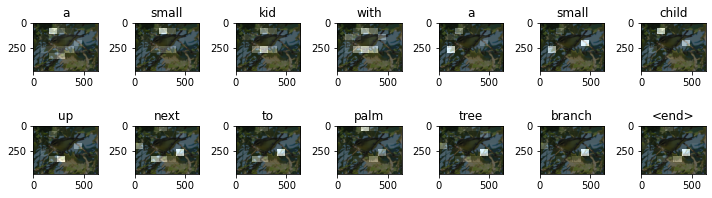

In [78]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: a man on a wetsuit surfing on a wave wearing a wave <end>


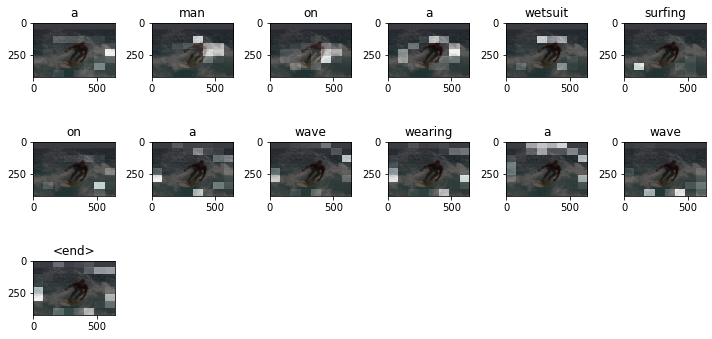

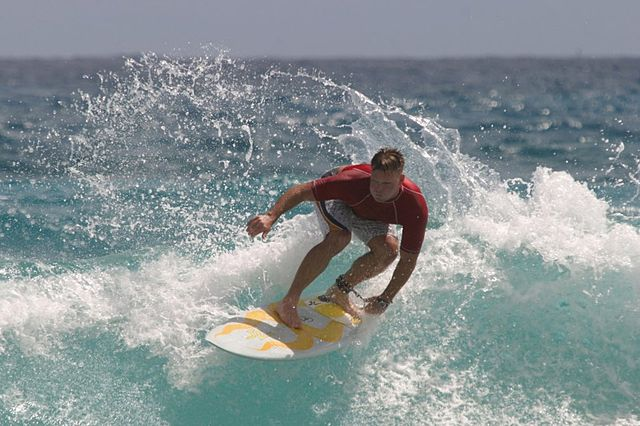

In [80]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

In [109]:
# creating a web server
from flask import Flask , request, jsonify

import time
import tensorflow as tf

app = Flask(__name__)

@app.route("/caption")
def AutoImageCaption():
    image_url=request.args.get('image')
    print('image_url')
    image_extension = image_url[-4:]
    image_path = tf.keras.utils.get_file(str(int(time.time()))+image_extension, origin=image_url)
    result, attention_plot = evaluate(image_path)
    print(result)
    caption = ''
    for token in result:
        if token == '<unk>':
            pass
        else:
            caption += ' ' + token
    
    data = {'Prediction Caption:': caption}

    return jsonify(data)

if __name__ == "__main__":
    app.run(host = '0.0.0.0',port=8081)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:8081/ (Press CTRL+C to quit)


image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:23:36] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'lady', 'in', 'a', 'pink', 'dress', 'face', 'in', 'cuba', 'reflected', 'in', 'her', '<unk>', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:23:43] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'woman', 'in', 'a', 'pink', 'dress', 'standing', 'in', 'a', 'parking', 'meter', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:23:48] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'lady', 'wearing', 'a', 'pink', 'and', 'purple', 'pink', 'shirt', 'flying', 'disc', 'in', 'the', 'intersection', '<end>']
image_url
475136/473831 [==============================] - 1s 1us/step


127.0.0.1 - - [27/Sep/2020 19:23:55] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'smiling', 'woman', 'in', 'a', 'tight', 'dress', 'shirt', 'with', 'purple', 'hat', 'while', 'holding', 'a', 'pink', 'tie', 'looks', 'like', 'woman', 'stands', 'in', 'a', 'mirror', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:02] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['this', 'is', 'a', 'pink', 'dress', 'is', 'wearing', 'a', 'small', 'white', 'shirt', 'and', '<unk>', 'costume', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:08] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'woman', 'smiling', 'in', 'a', 'mirror', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:16] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'woman', 'in', 'a', 'pink', 'dress', 'face', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:22] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'woman', 'in', 'a', 'pink', 'tie', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:26] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'bride', 'and', 'white', 'dress', 'is', 'wearing', 'a', 'white', 'shirt', 'and', 'purple', 'pink', 'shirt', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:31] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['the', 'woman', 'in', 'a', 'pink', '<unk>', 'costume', '<end>']
image_url
475136/473831 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:24:36] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/lenna.png HTTP/1.1" 200 -


['a', 'woman', 'is', 'dressed', 'in', 'a', 'mirror', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:27:39] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'brown', 'dog', 'is', 'on', 'his', 'nose', '<end>']
image_url
212992/208707 [==============================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:27:45] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'black', 'dog', 'standing', 'next', 'to', 'a', 'field', 'with', '<unk>', 'with', '<unk>', '<unk>', 'with', 'the', 'grass', 'with', 'a', 'dog', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:27:54] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'dog', 'is', 'laying', 'on', 'a', 'grassy', 'horse', 'on', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:28:00] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'couple', 'of', 'dog', 'resting', 'on', 'top', 'of', 'a', 'field', 'with', 'their', 'dog', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:28:09] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'group', 'of', 'snowmen', '<unk>', 'in', 'a', 'field', 'with', 'the', 'back', 'to', 'the', 'grass', 'and', 'some', 'other', 'animal', '<end>']
image_url
212992/208707 [==============================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:28:15] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'dog', 'is', 'next', 'to', 'a', 'field', 'with', 'flowers', 'near', 'the', 'grass', 'and', 'a', 'lush', 'green', 'grass', '<end>']
image_url
81920/80864 [==============================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:28:31] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/puppy.jpg HTTP/1.1" 200 -


['a', 'white', 'dog', 'sitting', 'on', 'top', 'of', 'a', 'couch', '<end>']
image_url
81920/80864 [==============================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:28:39] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/puppy.jpg HTTP/1.1" 200 -


['a', 'dog', 'is', 'sitting', 'on', 'top', 'of', 'it', '<end>']
image_url
81920/80864 [==============================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:28:44] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/puppy.jpg HTTP/1.1" 200 -


['a', 'brown', 'dog', 'laying', 'on', 'top', 'of', 'it', '<end>']
image_url
81920/80864 [==============================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:28:50] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/puppy.jpg HTTP/1.1" 200 -


['<unk>', 'dog', 'laying', 'on', 'the', '<unk>', '<end>']
image_url
32768/28698 [==================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:30:38] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation.jpg HTTP/1.1" 200 -


['a', 'brightly', 'colored', 'pink', 'beach', 'holding', 'a', 'large', 'ocean', 'beach', '<end>']
image_url
32768/28698 [==================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:30:46] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation.jpg HTTP/1.1" 200 -


['a', 'lounge', 'beach', 'carrying', 'a', 'pink', 'surfboard', '<end>']
image_url
32768/28698 [==================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:30:54] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation.jpg HTTP/1.1" 200 -


['a', 'white', 'beach', 'chairs', 'with', 'umbrellas', 'between', 'ocean', 'with', 'white', 'umbrella', '<end>']
image_url


[2020-09-27 19:31:08,899] ERROR in app: Exception on /caption [GET]
Traceback (most recent call last):
  File "C:\Users\anish\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\utils\data_utils.py", line 278, in get_file
    urlretrieve(origin, fpath, dl_progress)
  File "c:\python37\lib\urllib\request.py", line 247, in urlretrieve
    with contextlib.closing(urlopen(url, data)) as fp:
  File "c:\python37\lib\urllib\request.py", line 222, in urlopen
    return opener.open(url, data, timeout)
  File "c:\python37\lib\urllib\request.py", line 531, in open
    response = meth(req, response)
  File "c:\python37\lib\urllib\request.py", line 641, in http_response
    'http', request, response, code, msg, hdrs)
  File "c:\python37\lib\urllib\request.py", line 569, in error
    return self._call_chain(*args)
  File "c:\python37\lib\urllib\request.py", line 503, in _call_chain
    result = func(*args)
  File "c:\python37\lib\urllib\request.py", line 649, in http_error_default


image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:35:17] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'couple', 'of', 'men', 'on', 'a', 'sunny', 'day', 'with', 'her', 'one', 'tossing', 'clothing', 'at', 'her', '<unk>', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:35:23] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['young', 'girl', 'in', '<unk>', 'on', 'the', 'beach', 'while', 'standing', 'together', 'at', 'a', 'beach', 'with', 'a', 'crowd', 'of', 'water', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:35:29] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'girl', 'on', 'a', 'beach', 'holds', 'a', 'girl', 'while', 'holding', 'surfboards', 'on', 'the', 'beach', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:35:34] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'girl', 'in', 't', 'shirt', 'and', 'onto', 'an', 'empty', 'beach', 'and', 'couch', 'while', 'on', 'surfboards', 'near', 'other', 'and', 'matching', 'bikini', '<unk>', 'in', 'the', 'ocean', 'is', 'on', 'the', 'beach', '<end>']
image_url
8519680/8515435 [==============================] - 1s 0us/step


127.0.0.1 - - [27/Sep/2020 19:35:53] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/bird.jpg HTTP/1.1" 200 -


['a', 'bird', 'with', 'its', 'collar', 'and', 'a', 'tree', '<end>']
image_url
8192/6510 [=====================================] - 0s 0us/step


127.0.0.1 - - [27/Sep/2020 19:36:08] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/bird-2.jpg HTTP/1.1" 200 -


['a', 'red', 'yellow', 'and', 'white', 'bird', 'sitting', 'on', 'a', 'tree', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:39:33] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'trail', 'with', 'top', 'with', 'its', 'back', 'on', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:39:48] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['several', 'cow', 'being', 'resting', 'in', 'the', 'grass', 'on', 'top', 'of', 'it', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:39:55] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'dog', 'laying', 'on', 'a', 'metal', 'railing', 'with', 'a', 'dog', 'and', 'catching', 'on', 'a', 'metal', 'or', 'donkeys', '<end>']
image_url
212992/208707 [==============================] - 0s 1us/step


127.0.0.1 - - [27/Sep/2020 19:40:08] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/dog.jpg HTTP/1.1" 200 -


['a', 'brown', 'dog', 'laying', 'on', 'a', 'black', 'dog', '<end>']
image_url
8519680/8515435 [==============================] - 12s 1us/step


127.0.0.1 - - [27/Sep/2020 19:40:50] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/bird.jpg HTTP/1.1" 200 -


['a', 'bird', 'sits', 'in', 'a', 'pasture', '<end>']
image_url
8519680/8515435 [==============================] - 1s 0us/step


127.0.0.1 - - [27/Sep/2020 19:41:00] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/bird.jpg HTTP/1.1" 200 -


['a', 'bird', 'is', 'sitting', 'on', 'a', '<unk>', '<end>']
image_url
8519680/8515435 [==============================] - 4s 0us/step


127.0.0.1 - - [27/Sep/2020 19:41:10] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/bird.jpg HTTP/1.1" 200 -


['a', 'bird', 'sits', 'in', 'the', 'ground', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:41:41] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'girl', 'on', 'a', 'beach', 'and', 'white', 'dog', 'and', 'sunny', 'day', 'with', 'their', 'surfboards', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:42:10] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'small', 'girl', 'in', 'a', 'circus', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:42:19] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'large', 'girl', 'on', 'a', 'beach', 'watching', 'waves', 'in', 'front', 'of', 'water', '<end>']
image_url
81920/73805 [=================================] - 0s 2us/step


127.0.0.1 - - [27/Sep/2020 19:42:32] "GET /caption?image=https://raw.githubusercontent.com/anishLearnsToCode/image-captioning/master/assets/vacation-2.jpg HTTP/1.1" 200 -


['a', 'small', 'group', 'of', 'people', 'on', 'beach', 'is', 'standing', 'near', 'a', 'sandy', 'beach', 'watching', 'waves', '<end>']


# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.